EyeFi is a system of multiple security cameras that sense presence, send notification and interact with owner as chatbots. We achieve this goal in three parts.

**Part A:** Snag a pic triggered by presence detection with PIR sensor and send notification to owner. Notification may be a text message and may include a pic.

**Part B:** Add chatbot service to Part A. so that each unit (with camera) can respond to commends that direct it to capture and send a snapshot or short video clip.

**Part C:** Add to Part B. the ability to pan and tilt the camera.

## Part A

Snag an image in response to presence and send a notification to the subscriber's mobile phone. Detect presence with a PIR sensor. The camera is Picamera ([Pi NoIR](https://www.rs-online.com/designspark/raspberry-pi) v2.1) for [low-light sensitivity](https://pimylifeup.com/raspberry-pi-camera-vs-noir-camera/) although any other Picamera or USB webcam can be used. I have used [Pushsafer](https://www.pushsafer.com/) for notification and other services are available.

Let us start by sensing presence with the PIR sensor.

**Hardware set-up**

PIR Sensor <> Pi

- VCC <> Pin#4 (5V)
- OUT <> GPIO#2 (Pin#3)
- GND <> Pin#9 (GND)

**Software**

Use standard GPIO functionality.

In [1]:
import RPi.GPIO as GPIO
import time
from random import *
import requests
import config
import base64

In [2]:
GPIO.setmode(GPIO.BCM)

In [3]:
sense_presence = 2
GPIO.setup(sense_presence, GPIO.IN)
print(">>> ARMED <<<")
for i in range(15):
    presence = GPIO.input(sense_presence)
    print(presence, end="..")
    time.sleep(1.5)
print("\n>>> DISARMED <<<")

/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: This channel is already in use, continuing anyway.  Use GPIO.setwarnings(False) to disable warnings.
  


>>> ARMED <<<
1..1..1..1..1..1..1..1..1..1..1..1..1..1..1..
>>> DISARMED <<<


Upon sensing, the unit needs to suspend monitoring for a fixed interval. Allow the subscriber to configure the interval and set a timer that is reset each time that presence is detected. Write a function to scan to run monitoring for configurable test duration.

In [4]:
def sensePresence(on_sense=-1):
    if (on_sense != -1):
        return GPIO.input(on_sense) 
    return sample([0, 0, 0, 0, 1], 1)[0]

In [5]:
[sensePresence() for i in range(10)]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

In [44]:
def scanPresence(on_sense=16, scan_duration=120, 
                 pause_step=0.5, scan_interval=15, 
                 message="Alert! Presence detected."):
    """
    Executes a dry run of the sensor
    
    Input args:
    - on_sense (int) is the GPIO# (in Broadcom notation,) -1 for simulated values.
    - scan_duration (int) is the end-end duration of test cycle in seconds.
    - pause_step (float) is the delay to reduce speed, in seconds
    - scan_interval (int) is the pause after presence is sensed, in seconds
    - message (string) is the notification to send
    
    Return vals: None
    
    Sample usage: 
    >>> scanPresence(on_sense=-1) # Will print alerts to console.
    """
    t0 = suspend_until = time.time()
    hits = 0
    while True:        
        time_elapsed = time.time() - t0
        time.sleep(pause_step) 
        if (time_elapsed > scan_duration):
            print("Completed test run and quit!")
            break
        if (time.time() < suspend_until):
            continue
        if (sensePresence(on_sense=on_sense)):
            suspend_until = time.time() + scan_interval
            hits = hits+1
            print(time.asctime(time.localtime(time.time())), message)
            print("Paused until {}".format(time.asctime(time.localtime(suspend_until))))
            print('Hits in this cycle: {} [{:.2f}s]'.format(hits, time_elapsed))       

Note that if the scan duration is set to a negative number, the while loop will run forever or until the program is terminated.

In [45]:
scanPresence(on_sense=-1, scan_duration=30, 
                 pause_step=1, scan_interval=7, 
                 message="Alert! Presence detected.")

Sat Jul 18 15:11:25 2020 Alert! Presence detected.
Paused until Sat Jul 18 15:11:32 2020
Hits in this cycle: 1 [2.00s]
Sat Jul 18 15:11:33 2020 Alert! Presence detected.
Paused until Sat Jul 18 15:11:40 2020
Hits in this cycle: 2 [10.01s]
Sat Jul 18 15:11:40 2020 Alert! Presence detected.
Paused until Sat Jul 18 15:11:47 2020
Hits in this cycle: 3 [17.02s]
Sat Jul 18 15:11:50 2020 Alert! Presence detected.
Paused until Sat Jul 18 15:11:57 2020
Hits in this cycle: 4 [27.03s]
Completed test run and quit!


In [2]:
def pushNotification(title="Alert!", message="Presence detected.", picture=""):
    packet = {
        "k": config.pushSaferKey,   # Private key
        "m": message,               # Message text
        "t": title,                 # Title of the message
        "i": "98",                  # Icon number, 1-98
        "s": "28",                  # Sound number, 0-28
        "v": "3",                   # Vibration setting, 0-3
        "p": picture                # Picture 
    }
    r = requests.post("https://pushsafer.com:443/api", data=packet)
    return (r.status_code, r.reason)

First send a text notification. Include no image.

In [3]:
pushNotification("Hello!", "Testing 1, 2, 3.")

(200, 'OK')

Next, include an image. PushSafer API specifies that the packet acceps an image as a base64-encoded URL. PushSafer provides an [online conversion tool](https://www.pushsafer.com/en/image_to_dataurl_base64_converter) for conversion. Try it out with a sample image in a local folder. Copy the string to clipboard and assign it to a variable for passing as an argument.

In [4]:
picture="data:image/jpeg;base64,/9j/4QA6RXhpZgAASUkqAAgAAAABAJiCAgAWAAAAGgAAAAAAAABjb3B5cmlnaHQgSmFycm9kIEVyYmUAAAD/7AARRHVja3kAAQAEAAAAPAAA/+EEFWh0dHA6Ly9ucy5hZG9iZS5jb20veGFwLzEuMC8APD94cGFja2V0IGJlZ2luPSLvu78iIGlkPSJXNU0wTXBDZWhpSHpyZVN6TlRjemtjOWQiPz4gPHg6eG1wbWV0YSB4bWxuczp4PSJhZG9iZTpuczptZXRhLyIgeDp4bXB0az0iQWRvYmUgWE1QIENvcmUgNS4wLWMwNjEgNjQuMTQwOTQ5LCAyMDEwLzEyLzA3LTEwOjU3OjAxICAgICAgICAiPiA8cmRmOlJERiB4bWxuczpyZGY9Imh0dHA6Ly93d3cudzMub3JnLzE5OTkvMDIvMjItcmRmLXN5bnRheC1ucyMiPiA8cmRmOkRlc2NyaXB0aW9uIHJkZjphYm91dD0iIiB4bWxuczp4bXBSaWdodHM9Imh0dHA6Ly9ucy5hZG9iZS5jb20veGFwLzEuMC9yaWdodHMvIiB4bWxuczp4bXBNTT0iaHR0cDovL25zLmFkb2JlLmNvbS94YXAvMS4wL21tLyIgeG1sbnM6c3RSZWY9Imh0dHA6Ly9ucy5hZG9iZS5jb20veGFwLzEuMC9zVHlwZS9SZXNvdXJjZVJlZiMiIHhtbG5zOnhtcD0iaHR0cDovL25zLmFkb2JlLmNvbS94YXAvMS4wLyIgeG1sbnM6ZGM9Imh0dHA6Ly9wdXJsLm9yZy9kYy9lbGVtZW50cy8xLjEvIiB4bXBSaWdodHM6TWFya2VkPSJGYWxzZSIgeG1wTU06RG9jdW1lbnRJRD0ieG1wLmRpZDpFODYzMzkzMDM2QkExMUU0OUFCNTg2REM5QzhFMTA4OSIgeG1wTU06SW5zdGFuY2VJRD0ieG1wLmlpZDpFODYzMzkyRjM2QkExMUU0OUFCNTg2REM5QzhFMTA4OSIgeG1wOkNyZWF0b3JUb29sPSJBZG9iZSBQaG90b3Nob3AgRWxlbWVudHMgNC4wLjEgTWFjaW50b3NoIj4gPHhtcE1NOkRlcml2ZWRGcm9tIHN0UmVmOmluc3RhbmNlSUQ9InV1aWQ6NzhBQ0FFNEEyQUM4MTFERDhCRUFERUU1NzZGNUE4QTEiIHN0UmVmOmRvY3VtZW50SUQ9InV1aWQ6NzhBQ0FFNDkyQUM4MTFERDhCRUFERUU1NzZGNUE4QTEiLz4gPGRjOnJpZ2h0cz4gPHJkZjpBbHQ+IDxyZGY6bGkgeG1sOmxhbmc9IngtZGVmYXVsdCI+Y29weXJpZ2h0IEphcnJvZCBFcmJlPC9yZGY6bGk+IDwvcmRmOkFsdD4gPC9kYzpyaWdodHM+IDwvcmRmOkRlc2NyaXB0aW9uPiA8L3JkZjpSREY+IDwveDp4bXBtZXRhPiA8P3hwYWNrZXQgZW5kPSJyIj8+/+0AYlBob3Rvc2hvcCAzLjAAOEJJTQQEAAAAAAApHAFaAAMbJUccAgAAAgACHAJ0ABVjb3B5cmlnaHQgSmFycm9kIEVyYmUAOEJJTQQlAAAAAAAQJGLgkagzFv5wmZ2M0KH7Uf/uAA5BZG9iZQBkwAAAAAH/2wCEAAYEBAQFBAYFBQYJBgUGCQsIBgYICwwKCgsKCgwQDAwMDAwMEAwODxAPDgwTExQUExMcGxsbHB8fHx8fHx8fHx8BBwcHDQwNGBAQGBoVERUaHx8fHx8fHx8fHx8fHx8fHx8fHx8fHx8fHx8fHx8fHx8fHx8fHx8fHx8fHx8fHx8fH//AABEIAqMDhAMBEQACEQEDEQH/xACrAAACAwEBAQEAAAAAAAAAAAAEBQIDBgcBAAgBAAIDAQEBAAAAAAAAAAAAAAECAAMEBQYHEAABAwMDAgQDBwIFBAIBAgcBAAIDESEEMRIFQQZRYSITcYGRobHBMiMUB9FC8OFSMxXxYnIkgjQWkiU1ouJDYxcIEQACAgEEAQIDBwMDBQEBAAAAARECAyExEgRBUQVhIhPwcYGRoTIGscFC0SMU4fFSYjMVcv/aAAwDAQACEQMRAD8A4Riw2Fk6KUhrCygqdFAkpHAaIEAMmalUjILmsny52wQAukdoArcOG2S0IB0ftT+OvbibPmij3XoV2cda4lCNGOsHRuM4jDwowGsAp1oFXfI2MMBkQMaBUDyVUNhgg7JjItdFVJBAztOg0UgMHwdUV+ijBBJrG1uEJDBcxtOiVjAfL5YhhIa4CmleqalZLMdZZzXnM+bNzzDCPejcNraVABOv0XRwY9JZsShHUv4/7PxeP4szOA/fPbV8jhcA9As3by6x4Md7TaSzlsz9jA+Yj9MVa13wVGOvJjVrLOWZk0vMciWxirZHUFb2XUquNTXMI6z2Z2vHi40baXFC4lcrsZm2YMlzaftmtZ6egWSSkzXdHLx8djPc8gClBVaMWPkzRixs4H3DyLuT5B3sguqTTzXXpXijboka7sftQCE5GSwhw0qqM+WNDPa0jHubnYcDHMLXXoQ0BV4qSy3HXyzmc0k+bknbVznnr0C3pIubg0WLwLcXBMswFXCtwq3klwipWbZk+RiaZixhtusAmY9kFYkQDADqQjVESJTSMjFWuvoEGwst43jJeSnZG1pNSKlRuFIL2SR2jtTsfEwcSORzB7lLrl5+w3ojBfJJrmQNYzbSgFgFibKpB54DI2nRQKYjzoPZaSelSrKjGM5/l2Y7XUdSnRasdC+lDmfM8xNlyuY0kt+9akoLYjY84jgsjOmBcCWptEJax0LjO3MbCiDnAVAus9sslcgHPc5FiNMcR9VKBPSkltKGNEeTyeVUguJN1oSSGbg2fG8bicdjiaQUfRU3tOhXEmc7k7kMz/ZiPpvUBNSpZWsGchjjyJv1Tsb4+aq7Nr1r8qljJEm5LsV7jC6p0DvJW1mNQOB3w+FlciBJkZBjgb5p3aBG/QdB/a3HN9yR5nmYae2TWtErtZ7EhsIx+8eVyB7OJh0abMePBH6K8gsqoa8Zw/dU7hkTyezG/SOpJCFsmNCPIjY8Rw/sgPe57nj8xc4mtdRtNlh7HHIuNknX0K/qPdGnx4Y6FldrXAevwt4UVFiltijuLiH5mJM5grk4grvGj260VvXzcLQ9masGXi/gzn8Tt0l+uq7DOnA2xqbBS/iq2Ky2Sw+CiCBZNNpTosQpyG3qmGSA3sFUQM+iF0QBbNKJZIReB1CIQGYC46dESArjQkIkKXUpYoEK3sNPMoCsoc2/3ICnjWVqoQvhj9QRGQ0xYb6UQINoGUGiUJaQAPuUICZGiJBTkG9K/NEgLIAQgxWDyNHhqqmV2BpGiqRlTKnABViFT6UUB5BZCEGBlKACyL/qiMi40pZQhRIoyFLiFAEa3CBCLyPkgQodQnxUAWRsuFAhLWqAPjooEhQVUIWNBQIT6KBImn1UAeAKALmAAVUZEzyQ2+5QLBpSiiAj3KEKHuCBClxQAyNKlABbGy6ZIMBDG0TIJKiJD4BQhIM6UUITazrREh86gUIipzgFCFTrnVAhKKMkhFEDI4v+oVqCWbR4FMKX48QAXnTjF5fQeCDIDTzapSCyZ75H+23UqzDhtktCCq8nCN12TwWPh0zcoDdYiuq7tMKx1hbmmmKDbzd1YUEZeSPSND9iT6TLViM5nd/zzuLMcOLa0qNE9cCLFRIu43m8+Uh0lQCU7xoVpDuLljYFUvGLxGGJmCV16+XzVdqwKxxjs3AHyVLYjC2Y416JGwok5gYC7oEBkzF948o2LGkLCBIRSh8D4LTiozViqzL9rzuObE4PLrgEkChr8V1qqKmuIR3Rr/2/HRueQwOGo+C4WTWxzd2cs797lkm//b8cj2zU1Aut/WweWa8dOKJ/x725JNK3JlHpaQRVHs5uKgqzXOy4bI4IgGa0oPkuNZyzG9yb5gyJ73H0tBUSCkcP/lDuKbLzf2sbqRg02hdXrY4UnRrWKoV9odvnJyWSyNBaNa/ar810kV5HKg6NzHIYnF8b6aNLW6BYa1drC46yzj/MchJyeU7Z6quNKLpUrCNa0Rou1e15SRNI2o1IVWTKloZ7XlwW925PtNEEfUUp4I4a+S3Gjn+Qx/v7jr1TtDMviLyLm1OiZBRL2nTTNa25JugKzqXYfBMiY2VzRXUW6rH2chly3On4ppG0UAA6Ll23MzLXmop1SgKpHsY34Ihgx/ePMY+PivIdtcAVoxY2y7HSThvNczk5kz2tJLampXQrU0os4LhJMqZpeDSqLcCWZ0rieIgxYm0aNwCy3ySUtlfO8izFx3CtLKY6yPSpzeYy5+aSLglbVoXNwa7ieLhw4BK8epU2vLKnqIu6OacaxROt1onqiyqMe17i4uca/FOhi0ODhQWUIEY+PGTulNGi6jJATNykoi/bYlmm1lIkC0GnbnaOTyEzZcgUYbklC11Uqtf0OpcPxXG8fGGBoO2nqNOiy3yOxS1I4byuJG60jQ3q2oCp4Ng4M+dzmGHDZK07tY62NNUViYfpsrHccL3h0Tg0G1Aa6I/QZPpscQSSzx+5G5sjGV3srb6rNesCMx3N9u5+BMc4wU47IcXRStNQ2p/K8D8t9F1ev2K3SU/MdLBnVtP8kQgsP6K5l5OWv9KqIgDODT706LELJ2kE166JhgV4p0QAzyNlCiAKZ+XzSkK5a0oUwQKalKpkEEeDp8lCFRFEBYPH6IMBTsqfxUASbGNSoAKxoqm6AYGuNHQi11GMMI2W+KUh8+wUCA5TqiniigCucFEAO4HxQZGUPvdVsqsUSCyRlTBn2BVQjKJDanioAEeT9UAMgKV8lIIi1gt94RCScevVQhS41qgApc66ASJKhCDifkoA8ayuqJAiNiAC2lvuUCQdWqBD4NugQsYLKBSPnVAUIQNPFQB60KELRp5oERXI6yJIBZSKFFEgEkca6+ajIDucUrYGQQATaKooKCGMsmQSwKEPQLokLGM8VCF7WCmihD5woESA0jkSA8hNUCH0bTVEgZDGK6XRQAiwCsRJKt531UkIfQNHyXnzilM0tAlZBdkz0BFUEm3CIwngsWN8pypzSGG5r/cV6Hr4Vip8TfixQviN38zm5EgjgBoLMYL2Vk6luiGvH9p8vn0fkbgw9FHdIR5fQ2XF9hYsMY9weoLPbP6FXMZDtjEYKNFKJfrMise/8BCNFPqsaWFY3GNioQq7ZBWxpA0ttrRVsXyGxmwSMaAPlstsMJrYdSmpWR6VlnJO7OTGRnewDUakLqYccHRpXQdfx7hY+TlxscKbTUilrK7sW41Gz2ikG/705uHj8F0bX+st2sHguXgxuzMmGhy7isCfkeQEzgZATddO1lRaF+RwjufA8Zj4fHxMYyjiB8alcTNd2Zzm5GUsEjW6/wDRUICM53PzUeFhuaSBUU1WnBjlmnBSXJxzIw5eY5YyRGrd1XeC2Zc9cS1Nlk3sdD7f45uJhgOG1zW1KzvLz1MdquTJd+Zpkd7Ub6g9BdbcFDVjroKez+3pszLDnN9IKty34ory3jQ6zBx7cPELQKbW+F1zHaWZq21OZ950ZlAggktq4eC6eLY249jFyeqSp0GiYJZHc0FUAms7X4ETvZIRUk6JMt+JVktCOvcBxohiaNulFyc15Zisx4GNbp81nKyMjuihEI+b5MYsTnE0PRXYscl2Oks4p3lz82ZkPYHVaLLp48fFG5KEJuJ4ibKlBLSWm6ZtIptY6HwnCNx2NJbRZcmSSizkY8hlMxoSaitFVVSSlTBcrlZHIz+2ypadVrpWC9aDLhOAbCPckFDqlvcVsj3FyP7eJ0bFMdZGqjn+bI6R5cT6j4rRBYQixy5tVEhSbmtYPxUIVAuleGNNRVBBRpuD4vEhc2ael7iqFmJYe5vd2Nx0Xt4wq4jQKpY5AsZnn9289mz/AKJIBtQaK6uNIZwhrxfbPcnJyCSSZ7A7rf8AFR5K13EtkSNdx38fFrf/AGsmV9DUNDtCqbdpeCt5WzU8Xw2FgtDI2htBVziA6pWa+V2K3ZvcdY5bEa01sQyn+CqLaiBGM+N+9skTZIpmkSxOFWuabXCRqNURmX5jt9/Gk5MBDuPc7a1tQXxk6NcNSPNdLB2FfR/uOh1+xz0f7hXIRQrUjUCTUDSmRYhbNWvn+KZDgzm+KIpFrRu0UYAgW+HRAhRNUg+CKCByXTIINJZFhKiL/VABB16IEZ4GfRAWCxranREgfjRX0SgGMLNCgEMa2yBIKJ3Ur+CIRdOakokA5BbwUADSDwUYGVOaq2iuwNLVVsoYI8gV/FVAYLKdbogB3aoCnrWVKAYLQ0AKQQi4ohB5CgKUk/5oBPCfooQ+F9dVCFsbeqIC9rNOiEBg+cKKAIIAPWtqoFFgFAgEg4VUA0eAKEJsaFICSdYXUCDyut8VAAcrrnwRICvNSg2ApJSyKz5oUIi6NtSmQxe2wRRCQF0SFrWV1UCEMZZRCkzS6ISiZ1KqEBJHChChCsDcUSBEMelfmiQLaQB+KKAVyyWI+ikhQPv9VVCDeWSgXBZxRfkzalKyC9xdLKGtoS40XQ9uxS3Z+C/rUly/BpOK4fP5KSLExWVjj9LpGj0k9Sule86+DXkuqnR+H7f4XhogcgsdPQFxPiqLXb2KIdhi/unjIqtjoaWAFEqxNjrGyv8A/MWH8ib6Ifpkou4Jpn7QDco/SI6wM4J5JACaqtoUMha4m6RgYdCw2SsEhXpbQu0GqQYyfdPIQRskeZQGMrY6rRhqzXhocnbkfvOSfkvF62oupiRrerOpdoNxsHAdl0DCW1JNlR2224KsrlwZruTm5uVzDG2paDQeafDj41HquKNl2FwRjhEj231J/BZe1l8GLLeTpML6sDdNKAeS5bRnRTnZhghc5/5QCjWsseqlnHO9+dOZO6Flx18118GOEdDHVVRT2djTwP8AcLfzXqVR2sVb7iPJD0HnM8sYIT6jWmmimDCtiVUuTExQZPI5wABIc7p4Loyqoutbijrnavb0WFhtfs9VFyuxmbZz8lpZZ3Dn/t8WQ2sKKvFWWPhqcX57PM8rya3OpXYqoRuqtBDGfceQ3Q2Ve7EHXGYBLhXUkUTxAWoR1XtPiWxxtdShKwdjIZMrN3BGxkQDR9Fz7GYnQgbnG5SAFXI8nFjBxedFZWjY9KScr7z7t96R0MT61rRdPBhg3Y6JGU4/h5+QyA5zS5pNyrr2hByWOgcP2+zFiBc31UssOTLJkdgvNzIsWM1NFXWskqjFctyc2ZIY2VLTaq10pBdEIK4njWsZveKk3UvbUVsYZmZHjwm9KBVpSRIwXO8j7zzQ2qtFVBajPvqTXoE5GfNyHD0iyEgIVe53kdSpEhgJijaz1aeaKDAQ7OyJAImk+CkAHHC9q5Gc4OlrsNyT4JbXSEteDoXCdrcbiMG6MF4NakLPfK3sZ7WNFA6KEUbRrVQ9RWi93J4scfreB5kocGyKrYrzO7+JxnBks7Wh35XVVlcDZYsLA5u+4JJo4cN3vmm1jY2ipJNTU/1VterpqH6Ubmq4nPyspkfuxGIvGlTuafFZ8tEtimygOzI4/b9vIrJiSWewEbj4U+BWeracrRhq2nK3MXyGO/GyJIHf2mrTe7TcFdnFdXqmdbFfkkxfNWlaq1FwFKLmqYJRS/ioA+ogBkhpfRQKKZiP80yQQZ31RCCyA1RAV7NSgQ82XUCeiPyQBBYyMVUgjGeNGA0JWKMImdevgkJJdSgUIgPJPndMgi2XqEQwDvF1AQVGOqgGVSxn69EjK7oClZRVMoYBNa/3KsRgkhr1UAV0ugQtYxCSEyBRQElMpUkIK83QIVk0RIRqoiE4wTRQgXGyyhC8MFECFUn3qMDZXS6BCxjbKBRI0oftQCVOF1AQetF7/NQkFgAQCQkNFCAkztfvRAByvUADOKVgZE6oAJNCKQUXsCeAlzVCFzGKBLmM8en3KALgKJkQg9wFqosgJK/WiBAU1JRIWRsUJISywRIfOeAoQofIoQo3HcoQaZEtAQuAcQWZEtj5pWyDvtHtiflZvefSPHZ/uSOtRdvBXhjSNWJutdN2dCdnw8bjDA4eHc4ChlA1NPEJ+LtuW1olrYCh7e57kJC/Jkc3dqOis5VqN9VeBri9lxR09x9SleYV3Y1x+2sJoHUhI8rFdmMsfh8aM+lvzVbyMDYzgxGNAoNFW7ChbIG9AlkJa2PaD4oSFAvIZDYYCSU1VLHqpOW9850boDGHeomgC6OJQdHGkkZ7gMQSzsboagkrYnCH2NhzubLjYceLEaFw9VPBZ6rk5F46lfanEOy8trnCor4V6ps1+KK814R2PjMSKCJkYs21ei4t7yzC3Iy27XClh4KtAM73hyEcOE9rXUJFNbrV1qSzTgp5OVxce/JyDIRZxrXwXSyX4o0WtBpmHHw8Og9O0VHisamzKqqWZHOyZc/M2tNWk0W3HWEaVojf9l9tQs2zSM9QvU9Vk7WbwjLmudAbFE2CmlNFzWzIYHviZrIHgWHkt3WRrwo43ybg4kdV0WamwfCjIo8oIRM1Hb4M+Q1pHUKXcIl76HZO38PZjMPgLLkZramC71HjWFtK6eCzMrYHyGV7MLjWlOqatZGrWTkvendEvuuhiddxoaH711MGJeTdSkGS47i5+Qyx1qfUVqs0kPayR1ftntePGha9zb01IXKzZpMd8khXMSMxojSlhUBV0UsCRznmeRlyZzGw+mvyW7FSC9KCzjeMa1ofIFL39BWwnK5GDGYRUWSJNk4mS5vmzIXMY6tVdWhalBn3bnkl1/EqwJU9ga1EgLs/UulSAXNFD5+KYJZteRQV0UAPeB4P3XtfINKJXaBLM6Lx37fFgDbADqst9WVQU8j3ZhYQIDgXdEa4mwrGZXkO+87Jf7eLUB35VcsSSLVRIqZh9x8k9u+Z213TTVV9fsVvOkQNb5R3jfxzPM0SSzEnrW6tfZqil5DVcL2tx/GsaQP1xSj7VqVRkzuxU7NmrxJomAVdUtvQHqsrUlbQdK8TYxkgDXOJo5jjQV0VfGHqBaMzXOYcuRGMiNoMkAIlaDU7dQbgaLZ1Mqq+L8m/q5EnD8mZmuF0kdADfrWouiNBQ4XUFPQ0fXogQ9OllAg8hOpTIiB3lEklDxVQh5sKKImeCMlAkkwwWqoRFkbBXS6ARhjtIHX4JRRhGKCnVKwHrza3wQCAZB9VuuqYKQBIKnxJRDBQWnzUAyQjsoKVStISMrsL8hpVbKGK8itSqmICP1+9Qh4xtfIKARcxtAgA+cSoEGlPyQZGCyFQhW5Qh8ASaokCI4/qgANjZT+qhCbggQofclRkRADysgQtaEBjx6hCsqAZ6G/9FCQWVIF0AlEjtfBGAAMz/p4qEBJHXKACooCnwChCxgTIYvY3yRIXsaiwhEbEAMva0deqZIMEXmlfvRFYLK+igwO51a/agA+Yw1RIWsZa/RQh851P8kUEqe9QBVr+ChDzrTyQIX5M2t/iuCcQr43Ak5LObFf2WndM8eHgPMq/rYuVp8IiUuEdT4/iXxY8fvH9phtHohFiQBq5dWTbX/1G+JyvB4gpGG7hatqotNh+m/J5ld4QNqIW6eCCxNjrGLh3VkySWaadFYsIzxodYXNSPA3BLbEitoe4uWHgGvyVDpAsDOOQUCqaAkEMfX4JQwezTBjNxKiQUjKc7y7WsdU+f+a14sZqxYzl/N5f77KAFaNJNSt1aGlrwNOCgbjNErvzU1V1loWcQur+TzGtaK0s0eSSOKFtojpfa3CNxYQQ31FczsZZ0MOW8mvxoyKE3posTZQeZ2S2OMuJpRGqkeqk5tzsmRyOZsa6jAaVJ810KWWNHRpTQvxePGPGd4vSxVdsvMpvuZ/uPkQxpY030/wFow0Hx1K+zuMdl5bHvG4Vsrct+KBkvGh2jjOPbBA1oFLVIXGyXlmC9pCMhlGnokQqZzXvxwMb21qR0XT6qN+E5VkQGScgXut8F9g2LApGKaoQCDU9q8eGva8t1N1RmZTkOq8XK1jA3yC5OTcx2DpMtjW1JoKKtVFiTEd5dwxw4z6OoRotmDEa8eODkT5JuSzibkvNl0UoNDcI6x2R2vFDCxz2g1AJJH9Vg7OcxZbyzbT+1j49uguFhWrKlqznvcuaZ5THGakk1XQw44NdKCbF4ShMrxpclWXvAGV8nmx4rCK3AokSkiMNyfIy5Epa12p1WmlYLEUw8a+QbnJiEMnGEPT5IoKAJW2PTwQJID6jJ80qAXtF/uTEGXHs3Sitx5qQBmmj5GHEhBBAIFknEnETch3NlSuLInW8QUVRBiCrB4vM5J4dM4kHqUz0A9DXcZ29xmFtkmpUXoSFW8jexXLY0PcHC4bTtLWkdAq/ptg4MX5H8ktiIbjNLhW3go+sOsa8lY725zkHCPFhJeetOqsrgqtyNVQx4jje83uc6bJ9kPN6CpQtfGhLZK+h0PicSaPGb7kxfIygdIf7j5hYcl02Z2y3LjaC6b2y5z6b2ClTQUqK2VRFYy/N8O2HEOdie4cYPMcwcABG83aA7qF0ut2HZ8bbnT6/YdnxtuZ1wqtpsI7dSUGA86oEPHV/qoQHkr/VMiQUSdEQsrIJ/ooLJ6I6hQh62P5KBSJBgUkJYyO9KapSMNhaQKVQFDGf9EpD55oDRREAZ6a9ToiOgKQV+VkxCsMQFaLms8enVRgKZo7aUVbK7CzLbY06pGU2E2T+ZVMqAzqoQmwf1QAWigUIVyGxooQGkKDADPNFAlYrqoQtY2tFCBcLESIMY2jfNKSSMnXooAHd4KBPGoETLRSnkoGSLtNUCIrIUIej6KEPnGyhJBpnGhp16KCgMrtSECArzUoAZ4oAkAmgYujbW6JAiNqhApjB9NFCSXsZQU6oojPXUGqZBKJXmnwUAByG6hDxoJKhC5jPJQhJwAChChxr80SFZFbqEIOt0UZCvddKCQnD4/L5TMGLjNq7V7ugC4+DA8j+BxkpcI3/ABEHG8FE2BsYnzNTQVFfErsUoqqEbMeKEFz4/NcxKPcrHD0aOqasIs5quiGWF2W0NBeTXwUeQR3bGEXaGMKWqfkl+sTkwmPtjGabNQeZh5MvbwbY6FoU+qSQyDFdFpaiW1pAMIqixVTIEMkSwFAvJz7YSK0tb4pqosojmPcfKEzPbu6nT7l0cS0k3Y6mcj3PkL6alaKIsTG0U8hjEdLkUATsZuDcdl8BucJHi/jTRYezmjQx5b+DpMMAha1o06rlWcmNh8dRGTTRIwGQ7t5l2PG5rddAtnWxyzXhqY/iMmZ0znSDcHGq1djEmjU7whxyecBFc0IF7rPixwUrVmCm93PzqNvU0+S6FVCLZg6d2Twf7WNjnN81zuzlMOZm/iIDfAhc9meQLlcv2IHOFK9E9KyyzHWWcZ7z5wvnc0mpJ8V2cGOEdDGoRlsY75QTelyr2OMA86U+HwRQWzZdsY52tOtKU+ax57GXKzdQDbHUnpqsFjNuJe4Ocbjwuo6lB4qzFjkux4zk/L8plclkllSWk0AuulTGqo1bGl7Q7TkMrJnsqTe6pzZUlBmyXOtYWM3GxmilKD4aLk2cszbszvcvMOjBjjNzai04MXkvxVEHF4D8iQyvbUk1qtN7RoWuxPmsiPEgcG0BAVdati1UnNOWzZ8qUsZf4LXWkFux7xnByuO57bk6IWuI7DqTAZDHQNpa/gq1YCZmeWo0kGyuqywR5DqtoESMjBDepUIi326n4KEZbHIY9PkiSD6WaaU0qaeA6qB8hfHcYN/uSaa3QYsjeXnIMGPZEAH06JYkCqhNJy/J5r9sdaHwTKsBmAzD7T5fLcC+pDjcmqLskI8hs+D/AI6xWEPyRuNiQVnv2I2KbZGza4HCcfhge1E1p/1AXWa+WzK2xpHFF01VLbAW72RilaDrVDcgHnci1m31tDq2J62orKUkatD3FjxsmJ4yWikrNsorq0mo231S2bTleCS6vQxGdiPxMl+O8EUJ9sn+5nRy7OO6vVNHbx5FasoHAO34JmhistsT9UGArcaVKgwPI4g0P+CmIVE1KIDwDooAuZGpJCwMtRKST4x3rWqkkJsZfRAhewdUCBDKjp8FAEZHFQKApqk0CZIaChw69PBEh4xhKUDL2ssgKUztt4BIxLCfNsDT5JGUWEeT+Y11VTKmC/4ooAsYOqBCZqFAIplqoggsh8UAA7kQkmj7UCBEUdKIkDoY7WCAGW7TSiDBqVSE/VBDA7gT8FCEmNQCWXpdQDIO08FAkPGqgT3pWigCt5tdQDA53FCSAUpQkBSVAHoBRQSxja9EwQljKhQgTFHogALZGQEUQkRQfdRFEZRK6lUwGwSR5UCV0qdFCFsTOtPmgyF1KDRQCKJHIkKK3siQ9PmoEqkdZQhT5pRTpvbHAzYfHCCFu3Imo/KnOtT/AGj4IYsfCqRgw04qXubLie2cKJzXvZvkNy4qWsx3ruaBmFE38rQAPJUuxCDo6FSQosq0daIEZW6aJty4W6qJESIHOhAsdEeIYPRmRnzR4kgtjnrT7FIJBP3QLnQapYCkIud5BuxwDqK7FXUvx0OZco8z5riCSAaAroVRt8FmPivoDYdKK1MdGp7W4R2XPUg0abFVZsnFFWa0HU+M444kTQBfquNkvLMF3I1iJcQFSytl+VOyHHJPQIVUslVLOV915rcjLEbDq7RdjrUhHRooRHFa2CIucKWUyOWC2om5PlDK4xAklPjp5HpVIbdpcIJp2yOHWuiTPkhFOWyOrcdgtiha1oobLj3tLMFrDFkVAfhqqxUZzumXZjPv0qAtWBamnCtThfOOdLnP8akLtV2N7I4kW1qIUHwtBka7oFAs2vbuVA0NA69FjzVMeSrH/JcqIMYkGlrLNXHLFpQ5d3Bzc2VkPYHejRdDHjSRsrWAvtDgDl5TXubuFdfmhmycUU5bwdk4riYsWBrqXA1XHy5HZmGzbZRy/Itx2EA3NgFMVJLMdDKDGfyGTVwtVbZ4o0aJDeeKLBxLChA+CoTbYqRzbuTkpMvIMUZJFV0cVIRorWBj2l2myV3vTCrhcAqnPlhQijJYf8jxMMTqtYAaUcQFlWQqVjK8yRE018FfRltUc+5XJ3yOC0JFiQAxhcbpiBG0Ut8kYIRoAFGMiI9TvLwQIw/FijaQ51yiAsyc8tHtxa6WQIecdws+dNVwJrqEW4EtY3nB9owQBr3tuKaqi+XwVOxrcbDjiaA1oAHgsztJVZhsYDRZVsUs9wU1QAA8jy7MRm4uFR5hPXHyLKUlmZyf5IjfI6BkTnO0aW9StFOp8S76SQRw+Nm8i9s2aJRfewbqNT5GqrQS1o2Nvg48Qa0OBroDpT40WC7KGwXubjXZmAWsYDkY1ZYzS5b/AHAU8U/Vy8L67Mv6uThbXZmGDBSo63XZZ2Ct41QADyUpXwUCgSR1SbpiFTTU/eoAujbX8UGQKjYSP6aINgLRFStEJIfFnyQCSay/moRl7I+v0UASIooAplpRQZAslK/emHKttaU1UITZGD5pQF200qgxWDZDbH4JGJYS541sksUWEWQKuPmq2UsHAugAmAoA9cSgEHkcP8kQAzzU0QIitoJdb5IhZcyOtPvUIgyGIdQoBhjIwG3SsB88W+GihAaSlSoGSotvpqgEk0KBbJV/yUIRNKqEPAClkhF2hUIDyOUABzOr1UICPJUARopACTWk/FMMi+OOwChAuKOtwgQMijRJBcGhFAK5SKWRQASZygQalSiQm1lUGQuAACAGQe9QBQ81OtUwxEDxRIfONlCA71CEKKAP0fg8dFHE1rRQBJa5kGkbGMbSwqqmwQRlzIImkuIQ4kgQcj3LiwVo4V81ZXHI6qIJe8S95bGa+PVWrCPwIDmsqc2rfUBOsaQeKQbiuyXmpBNUWkgDjHgmIBIVLshbMZQxu6qtsUG5PNbFGRWlAhVSyylTBc/zDy8sBq3x+K246QbKVhGdx3+5NU3utFS2ZH2EwveGNbUnon8Fmx1bsnimx47HuGoXK7eQ5ua+psfaaSB0C58mZhEWO3UdUANiLu2ZuPjOo7QXKv69ZZdhrLOYcbA/P5F73XDTQeC61nxqbrOBzzeOMfEoNaWKzVcsrq5ZkOLwxk5x3eoVWxuEWvRHXe2uLbFCw0+C5Oe+phys1+PEA2lFiZlLMja2P8UEMjn/AHtnBsL2joDddDrVNeBHHJ3e7kucfG66yNrCWxbWt81AhMLAXCnzKZ7BaH3FvdEAarPkUlV6yQ5/ln+yWVv4/JLSmpK1gy+Bhy5mToXElX2tAb2g692fw37aJjttKCq5XYySYMlpZq8vIbFDTrRZK1liVUmI5WSXIyQ2+q340kjTVaDXjIIseLcbmmvmqcjkR7iDuzlQInNY6+lFf18ZfjRl+G4t+VkCR4ruK1ZLQh8ltDpfD8cyGANpcLkZsksxtnnK4f6ZIF1XTIFI5Z3e/wBvcF08RdRHOck75TVaSyCUQIHgoiQXJgwVuNTQG6BD5tqE/VREJh8jztFUADriOBknkBeKhBuBGzd8Rw8eO1trqi95KrMfsG0DyVAhe2UUrXRKwQU5HIwwtJc8CyKpIVWTG8/3yMdzmQGpFgtGPCXVojKTczynKSUc4hpNKLVWqSHUI1XbXb0bdr5QCSqsmWNiq9jo2CyKOFrQaDQLn3bbM9txpA1ooOvStxRVMVlsjDua5vqY2psbAnWvikZDAc7gDD5GSNoAjl/UjA0AJuPkV2etk50XqjsdfJzp8UKZLDyWgvBJQbqEA5Aa+CIDxjSSOqMkC4oydUrYA6OKgp9qUJZs8lCHxZT+qhDwMuoQuYLKBg8cFCQDyEVIRICv/MPDoiMeMbVBhLmMtpZAQu9s7aFBkbBspgofNJJXYRZ7CCfsSsosIMoeoqplTBqdUCExZQEFchIFUASDvdVRkKDc0RCTjYFCBUMen3qAegdHFohIC6lB+CASqQi/VQDBn0qUCIjS5qoMe0UCeH7lCEbqEPiUoSp79fNQUFlfSoURAOR1anooApN1IIehqKCWsZXpqpBAmONEgXHH80CBLG2RIekgIoANK8X6XTEBH1KATxraqALmtoL6IMh48iiBCh7qlMQhX6IkPKokK3nwQIVE1uoQ8oiQ7zJ3bxuNH/uAuHgUXibMyxsWZX8hYwaQxwJU+iMsQgy+7svMfsiOvmrFjSH4pEY+MysqjpHm+oTbCOw543tiOgLhr1VdskCuzNJh8FjR09PyVLyMVsaxYDG2DQB4qt2AFxY7QNEjsAnIxrW3tWyVsaqlmE7mzwJ5GNJ2NNK+K2dajalm7HQwufI6SQ9T5rbBoexbgY5pUJ6olEavtnj35GW0AVAKXLaEJmvCOycRift8ZoI1AXDy2lnNu5YwHiFQIRmzvYaT4BNWshrWTnfeXOzT1x2G7tV1OthS1Ojixxqedr4Bhg3uFzclTsW8CZLSwXu7Mqz22nyU69dRsSBO0OPkfkNfQ0JVue8IXLY69xeIY42+S4uS0mCzkbRtAVTKwbkJD7bvGiaqLEjknfuY8BzW9dKLrdapvw1MBgsBmJdc6rcXrca5jKwgi1EEMV4xoauTBD5MlrIQRaiR1A6ix8U+dOGjQlTYrbg3fa3a7WbXPbexWHPmMuS5v8eBmNCBoQLrnNyzMKeUzanY01PktGOpfSsC6HHq73HBWWfgdsD5blm40Tr6fajSjbGpWTIRiblMyrqlldPityiqLm4R0DgOCZFG0lo0XOzZZMeS5oWwhg0ssdtSpME5ENMRB8ElKuS6px/vxo9dPErsYEX1WhzZw/UNVoLGXCgCgIPS6iYJ5WpUkDLGY8klgNUGBsccXxBLqvHW6VsVs23F4scW0UVN2Vj2JzW/CioZW0fT50EbPU4WUSbDxYg5XuzHgaQ1w+qtriHWMxHKdyZuZIWxE0OivVUh9Ee8R2vn8jKJJwdpUdkhLXN9xfZWNBG2ov4qh52JzY/wuHxcfQ6eKqtkbK3Zhv7zGxxQuFknFsHFsMwuSimcAwh3UFLbHALVaGp2+zU12+DdVSxEI+6sAZXFPyYm1lxz7m6l9mjh8Fo6mTjePDNfUycbx4ZhHXFV12dYFlrqoAEe0ogJwRurX6INkGEEZSkDGMFLBABIsQkJDb/1RIfbbqELB+VEJ4/VQgJNqoQGcL1RkKJRt/wEAsJhjPX5KChGyoSsANkx+kpBbIQcgw1NdEYKbIz2a2hNFU0UsC6pBT6oAUIVSFCCA7zWqgCAbUohCI2XCJA6CIUSgYaxlkJAevt5KEBpSoRg7vHxUJJ4GoDHxooQg7wUCQNlAnjnWQZCiR2pQEApn1NSgQHc6v4piHgbVEJc1igC+NnldEIVFHQgJSBMbaBEhMmx+9EhTI/oEQMFkfenmoQrpe/TqoEsaKIAJOIAQAUSH70QlRNUSHhRIQe42UIVFxJUIeUURD2hqiEcw42bPf1GvjVbIkVsYwdu501Ghpr9yragrd4HnE9n5Mbg5zT5lLzSEd5Ndh8Q9gA2n40VNsiFdhxjYvtiipbkUYQsFK0ukZC8a3SsBcyny8krJAFy2Q2NmugT0RZRHL+ZyHSZr+gGq6uGsVOnjUISSRF8tW+N6KxIjHGFiANa02TliR0fsXi2B4cRUnUrB27mHsWOkPiayMUGg0XJkxg5ftaUIIIedz/bhfpYaFacVNTRiqYHHY7O5KtKtB1811J41NlrQjbsxRjYdbAAXouda0syzJz/AJaR2RnbQbVW/GoRprojb9m8a0NYS3wWPs3Meax0WCEBgAXMbMrZftoPNKBCrkn7Y3fAq2iLKI5H3s6Pc6mpquv19jpYtjDxudHLVtj4rWWDISGQ3Jp5KDIrc4h9BYdApIYIOmkeQ066AdFGxXY1fa3FiV7Xlt6ilVlz5IM+Sx0vDgjhiFBTxXLvaTHbUq5DkGhhY03KNKDUoKYonTy7ibVV7cFjYRmbYIDe9FWtWCqlmB5V02Zk+2wmhNF0aVVUbKqEaTtrt8Ma1zm3sarNmzGbLkNxjRNijDfBc+zlmRslNQDzoggIScrktZG6p8lox1NGNHJu8p2yBwXTw1NlKnPZ46ONFa0RnjXOJp0SsB7tJ0QIThYdwBujAGPOOjYddeiDBBosNjALDRVWEYxbOyMCpv4pYFgGzO42QsPq0RWMbgZPlO58iZ5EZN9FbWgYgDxOLz+Qk3SVvZGzgDsbHgezY4iHzCpHiqL5fQqtY2WNDi4sYa0BoAVDciA+d3DiY0bquFk1cTYyozMZHdvIZT3R4bCQbBw0WiuFLcsSSGvD8HymaRJmykA32oXy1rsV2vBscDjIcUN22cNVivkbKXZscQ1MZGlOipYrKSSZS135CNrh0IOqDCc65bCdg8hNiuNQx1WHxabhdvDk51VjtYsnOqYvkFvNWFhRsqVGAIhi9SUgdEyn3oNkCGioQIfFt7KIhHbZEJ80KEgmK/BQJXIKokA5epIUJBTW/n4KALI21IHyUCHQsqUGyBPttpXwSyBgmSz0+KAGhDnx2IRKrIzmcyhcKaKuxnshU6xoqxSLiNECQUvKgpT1soEsjbVQgVDHoiQPibp8EoAkAAX1UAVSUFUAg0l/P4qEKTpp8lCHqASJ6okK3VRCiNf6oBK3uKQDBJXlQAJIa6oAKv8AomCXMaiAvjZX4ohCo2Gn3oMgQxiiCy2wABUAVySWRICyPuiAr1UCetH0QYCRNAoQg5wpZQhWRVEhEtv+CISD6KAB3uKBCI1UIWsZUVRCXeydtUQQdq4btKCFjS5tTQJ8mfwjJaw/h4fHYQAwW0Wd5GxQ9uJCwXAr0VXIANMWNNqa3RQxSciNpqSExCTc6MCxrXopxDBY3K3G3XQoQSAhkxDS7o3VK0RIy3cHLhjX+rUFaseI24sZg8mYuc55FSTc/FbUaizjmB0nqHxqrakqPYogZQAKhBjvY6b2fCY4m281y+05ZzMzk2Dg57VzzPIuzpPZjJOiaikaqkwncWeXvMYN3aBdHBjN2OoR2rxYHrcLm9Uc9xMrHHcGSyHEcweCy41LFotTnOO73+Rrreq6OyNF9EdX7Yi2xNNOi5Od6nPyPU1sbhtH2rGyhkjIDVQKQi56Usgd0FFfiWpbjRxfurL35Tmi912sKhHRrsIGxhzriyuQyYVAyn5tPqoMTkpW6gyCOOwffmBp1+1Je0IryM6R29x7YWNK5ma8sx3Y3y8zZGfsVFayIqiYPkmkv8lpiCx6DOPbBFvNrKq2orUma5zlnPdsY7U0otWHGaMdY1IcFxJklEjwTVHNkhAyZNDoOFiNjiApQrmWtJhtaS94DUgsAGdlMjBqdKq2tR61MN3DzBIeGutpRbsWM2Uoc35TIdPKb2BNl0KqEaEhFlQ3JHTVRi2QHShvr/gKsUsAqiRIsjZUgDVEA7wICL+H4pGwDZmQ2JoJNx0SQBIXclze2oaddEyqGBBLLk5brVIPQpoI2hzwnbb5ZA57agpbWgR2N3x/GY2HGCQKi6y3u2Vs8zOdxcYEVFlFjbIqGez+6ppgY4Lk6UV9caQ/GAfA4bkeTlD5idhOia11VC2sbviO3sbEjaCwbhqVlvlllbsPYXsiFBQAeCpeojR67koGg7nj6qcGwKsg7+4sVn6e8bvDqmWFjfTG8U0eRjxyMtID6xToqLVgrEXdXDR5mGc6Eu/fYxPvREDa6EaFpFyQtPUzcHxez/qbOrm4vi9mYqgcLfFdQ6R4GdfogwMJhYag/VAgS0UP4oELRSigTwm+ihNj4C+lVCEg26hGSpXX5KBKpBdEgDMLlQKBwKuPVGCBULa0KAGMIWUAP0SNkCNtvAoABchvp0RAIuQZrRErsjOZzRUj5pGU2Ek4o5V2RWUGwSClbiL0UIRa1QgREw2RCGwx/wDRBisNjaRr1GiACZNAoQGkNAgEodQn4qEghS+ihDwmg1QaCQc77UQlRPioQiT1UZCiR1kgASR11AFDuvmgQ8Yw1BTECI2JghUbAFCBDGC3+AgQtBoPkoGSLngIgB3vrqoAp1RCetBohICVALKEIvdogRFZubIoh6GohIvNkYIDyO8FAFVLlAhYyI/5KEC4YK/YmQQz9r6NOqIsn6IZHtIOg0WVsyHsmTBB6nkAoRIDP8v3ZjQ1YxwJ6q2mFssWMzb+5Z53UYTdaVhSG4BEORly0Nz5KOqRJGOPBkOIJrRVtoEobYuM+gB+SptYDDs9n7fj3ONtwtVCmtoHxKWc35qUSyOFagWt4rpUrB0eMIQz0Dmhp16JgsY8dDfdS5+9WBqaXh8MyyNHn+KTJaELktodP4HGEUTbWAXIzWk5uRmhjczZewWRlJne5cuNkJaCr8FZZfiqYPBb+85F5cKtbp1qV07PjU2WcI33G4ghxt1ALVXOyXlmJsyneOYdpaOtQtOCppxIT9s8U+ScSFtzequzXhEy2Os8RiGKFopRcfI5Zgsxy1ttFSIeS0aK9RqogmP7szgyB7d1DQrb166mrDU4ty8u/Le7rUrsU2N0FeOat/7h0ToKLSaGxpTVQKIRh8soYL1OqVsjNt25xh9LiPiVizXM2S5t42Nhi8FhepnAckmV1OitqoHWhZjYzWDc4aKWYGLuZzw1rms16KzFSS3HQTcbxkmXP7jwSK1qr734oe94N3xXGMgYDSi52TJJhvaWNS4NCoEF+XnNjBqdFbWpZWpkOd5trWuAPRbcWI1UoYPk+RdPUAm/1W6tINKUCLJFHVCtQwunINftSsVgTmkkpWhGj2wUghbA5u6/1UFY0izWsjslZIBMnknuq1pv5IpEgogxJ8uQVuD1R2A2azh+3m2c4XrdU2uVtyaSJkGLGaUFNSqXLF3EvMc+QCyM1PSiemMZU8iPG4/O5KTc8nadArm1UjZp+K7Xiho54+Kz5MkiyaPHGPitoAGgDVUtyJDZTn9y4uMw+oeSauJsNaGcye9JpSW44JJ0WhYF5H4pE+MweX5GUSTvc2MmtKlG1lUW14Ndx/beJE5sjgXvF6lZL52U2uaCCEMbVtgs7clYQwQihcLOFHedVXYhzvuLjDgcrNGG7YZCZIf/ABcuz1svOifk6/WycqfEWsbU1+auZeFRNpRAgQ1vVAhMghvmoQiRQn7EQo9ZUnyQCWtZat1AM9IN0CMolqiQAkN04yKgLoEC8cIAGEQO1IwMtNvxQADTn02N/AoojEmaLlFgZn8+MGpokZQ0IsphBqqmUsCdp/VAVoheqhCbG+CgUFxR6AhQDDoY7IACWt+iBCL7DyQACyV+qISi9FGQjZAJFxtqoQqe5EhUXH6oBIOegwA0j0CA7zqgAhtr8FCFrGXHimIERR6fYiEIY3yUBBcLCn3KBPnvtrdQhS9yhGUE/REh61psUGQkgAi42UIV/VEhJrfooQkRRqhCiUokB3m9tSoQ9Ywk6IkC4IeqhGMsbGsLDyCKFYb7I9unXwTgOjct37jRkthIJ0FLqmuFlSx+plc/ublM47YWuAPVX0xJFiSRRh8Rn5EgdMTUq3kkB2NVxvbrAGlzfqqb5Sp2NDi8ZEywb81nteRQ5uMwCtAq+RJL8THLpRQddUtmM2ed2M2YNK0NKAKzq62L+stTlOc71OC6zOkxV7YMoJNSOqUrY+wGMLQALmlk6Q9UbXt/B2hhLfCpWTNYzZWb3BjLWgdFzLmGz1DJnhkRI8FUlqKjD9z5m4FjTXot/XobsVSjtjj3CXeRUu18lZnvoJmsa/KlGPi00oND8FhqpZTVSc45md2Vme2BUVXUxqEbK6I1fa2A1rWupfxWLsXMmZm/xI7AeS51mZGFEBoCRAQr5TMbHG6hurKVLaVk5d3XyxcXtrWq6+DGdHFWDnWS57pi49SVtLWEY9P+qBEfSkg20RDsNOCw/dmaSK1uSqsjhAvbQ6XxGKyGEErnZHLMdtS3JyNx2ttTolrUEHsEe71UsEWyMF5XPbCwgJsdJHpWRFB7mdPQVIrqtTiqLm0kbPh+LbFELUXPy5JZhvdjd1GN8lnKhdn8kyFpFQD4qylJLa0MZzHP7iWtdc2AW/FiNVMZl8x2RkA2stVYRchRkQSNrUadVamNIulArbRMMhflM9R+1BkYG8EFARlZugKR3bfxUJB8ZHusCgRoOwMF0rgSLINis1/G8bEwNLhpqVVawjGkmdBjigI+RVaq2BITZ3LSzHYw1/qra0GSKMHiZMmQSSeKLtAGzWYeLjYkQNBUC6zWs2Vg2f3FjwVAcKjzRWOSKsma5DuyWX0w3Plorq44LFVAGPg8ryUw31DSdE7aQHaDd9v9owQsa6UXGqy5MxRa5rsfBihYA0ABZrXbK2y5ziLeCUBKLNY07C6viApxI6jDGgZLE95eGta0uaHdT4BV2cCyCc3xuLy/CPZKAzNxWl+NJShPUtd5KzBleO/wZbgyOl1GxzdjDpSh6/ELts7JfG01SkLwNaoEPTpY6KEIkXRGJxtpp9EABTYxRKQjILEUUIAz1unICOB+1FDEAypFlAMMx49PLqlYJGEbSBWqRkPXIAA5zf8AFMQVZjdfuUAI81lQUCqyEWYw/wBFU0VWQte2h0QKyIbVQEF8UeiBGGwx/wDRQAZEyn4pSFu0gIEKZTbwRACSU8EGMioi3ioQiSKqEIPNj8FCA73HVQJUXKAKZHeKBCl7lCFdKoAJtYjBC6OO6JAhjNBRQhaLBQJ8TRQKK3OqoAifvUYDwN8dT0UIe7bIEIm1lCESLfeoQ8DSaJiE6UQIQkcKeSMEBnnVQhAMqa0qoiBEURNESNjDHg0RA2MYmgU6eKZIUu3itOifwCTUcd2g3a10wq7qltlSKuZoMTt3Fjp6QqnlYsjKLjceM0DQD5Kq2QEB0UDGj0hI7SAva0CyWSFjQCUAjLjoAXg/OqSzAxP3o4mHYLUB+1a+mtTb1Vocrz4nAkD5rqm97Cog+5ZLAjQ84RrnTtr1KZ6IjcI6dwUP6bT0C52ZmTKzV4oG0fisNzGwPmM724y0fVNjrJbjqYjIc7KzQ0XuujVcam3ZGv4TA2Ma53RYs15ZivYp7jyA2J3jQqYa6j4kYXBaJ88k+NlvtojTd6HR+BxQxgd0oFy81jBkepqcaoFaLJYo8H2VkBrSUKoNUYvuTlAyN9Ct+DHJrxUObclI+aRzjeq61awjelCEWXBtcTRMFkMe5pWnkoBBjMYveB9FBoNTwGGI6HqOqzZWZ8jNT+52RUB+IWXiUwfQMdK6viahS2gGGzyNx4CK3oqkpYFqZLPklysjYy4JWyiSRpShGj7f4nY1pcLrNmyGbJkNbHGGMHRYWzMAchltjY69wnrWR61kwfPcs81Yw1PkuhhxmylBJh4c2TIHSfABaLWgduB4OKY2Gpt4eCo+oJyMxzkAY5wbbwK1Y9S6pm5WEOPQq4sSBXxWNRU9UYJABkR7dErQrQHrYCnigI0RIqadEAhOJjF7xXRQVs0uFC2Fu5VsWAmTkSPS1Kqg4g5dkZBpcp9gh2HxwbRz9fxSWuK2MzmY+LHQUqOoVUNixIi5fuU3ZG71HQDVOsYeKEUOPncjLV1dpOit0QWzW8N2nG0Ne9vhqqb5St2NVh4GNjNG1oHms7s2VtjGPOgjsXAJOMg4yeZHOYsTa7h9UVibIsYvd3BNkPEcLdeqdYY3CqJDXjMN9RJLXe64CS9/QS9jRQge1t8FmZUAZkhjJYTRjrfGqNVJbRGFmgMU8kf+lxouzRykzr0cpM9jZUotjFlOqACB8uiYJMNJA+9AaS2OPogwBLW20QYskZW6oIgHkMrbROggUjCDVEJKKO+nwKhA6CO1fBI2AKAACUE6lb1ERsDyCL306JgoWZN70ojBBVls1CURoSZcRJStFNkKpovVYJWipkGxlKwMKijoLoADImXCAApjQL/VAB6+wQCCTV+Z1RADPH0QGgqcoBED9igSp7h8FAoGe43KICl7r/igQpe4lQhWT/0QAetBUIXRs/zRIEMaoQuDRREh44miASBKhCJUgBJrTXxRCiVAFGEi5AUrOvmoRn1FEQkAiQ8cQK+AUIDyOqFCFDgT5KELoo6gfYiGQ7Hgr8kRZD2MpQAaaKQKW1oPtViQCG/1aokg7IGtAsshmJska0+KAS5kjSbUv1VVqhkvbI0AX+KKQGie6qEEJsJJFOqkEHfHtMYvqqrAMr3lONz66eK39RG/rrQ57nOBDiugbmL44Nz6U16oimj4XGaJm1AFFLPQS2x0bhg2jWhc3MYsg9Dw1hp0WRozqpleezzvIBvpqteGhtx1gr7fwN8hlcKkmybPeFAuW/g2sUDYoajwXPblmR6sxfdeSdj6dVv69TbiQo7bxw+bdTqrczhAys6jxOOGxii5GRnPvuNgKBUiijl8jZG691bjrqW0RzXuDL3vLQamtSuvgrB0sVTPOIcKLUaIAM1lAbIkegDA0+58NQoVyOMIUcKj4IDNmkwpo2RgCxCz2RS0HQyGUgAktJ0VbUCNQPsSNkcYNFls5KWK+Wyy8+20/RW4qFlKlnA8P7rxI8Vr4qZskC5ckG2xMARMFtNFzrWkxtyeZjxGzwopVSRIxfPcgQCxpudFuxUNeOpnocGTJfucLVWp2SLnaB3h8U2Jgt81nteSl2klmkNjI6AIUCtTD85INxquhiRrojPzEEE+KugsBJiKXRJIBP6j5DT4IMVgb2gH8UgjIxs3OAA6qCDjBiDACdQlsBhRnJ9INhqlBJfiYjpHAnSuijZBqz2oG3+ZVbA0B5nNMiaQCPkgqEgQ5Ofk5T9rK0KsSgkBPHcFLO8OkCjtArZs+J4aLHa1xAB81nveStsZy5+PjspuAp0+Cq4tkiRByXdNCWxGp8ldXEOqxuBYb+Xz31FQCaWVj4oDaRoMLt3JeQZ3FwNyq7ZkhHYf4vHY+Gyu0WFzRZ3d2EepYOYgZIG7wAFPptg4DnCzIpo6tcLqi9IK2iGTC6WSuoBqB4FBOBq2gWczwgmidlY7KTNNXsb1HitPX7EPi9jXgzpOHsZ5jaeRW83M+dpdRERCnRMEuYKamqjCXxtB1QAE+3YpRHuVvbQ/eohkCzNF0yGAntFUwYLIIwXC3xQZA6Ng8PgUjAWub9QlEkHltXRFAAJ3GuvxTjSL5kQsAyG1BNPgg0KxTkxggpSpoWyQ3ofmlaKrIrEQVbEZfHHpayAoZFH0QYC4NAFkCJlTyoQEkJqT9FAg7j1QIVEf0RCVvIH+PFCCAsj/AKIkkGebnxUIVPKBColRsB4NUCFsbUSBMbaDyRIy9oCMBPaj6IEIOP8AVAhBQBIC/n4IhLAKAKEPnGnxUIVHwQARAqoiE2t+aJD51viiQokcLoEBnmtVCHrG1KhA2FlaIoDD4WgAIgbLybaUFEUK2VyS7QmCgP8Ac/q1r8kQwbyHvF0v5AUfpFboFR83kvNaG6n00FVGWHyWQ+m5JbGhWkNIJ5XuFdCqnVCNDSIu2glUsAdx8e6ZorWiSwGaSPHAjLlSRGA7zABPhW66XWOlgRz7MkbUj6LcaWyzDjDnDwsmgiHuB6ZLJbbC3NlxGQWU6eCwZVJhupGWRyIZCampVVcZKY9TKzF+Xk0BNC5a6qEaIhG44Dj/AGoG2XOz3lmHKxnyBLIXACgoqq7iU3Oa9y5O6Qs86Lp4VodCihDLtXFqGmnxVXYuZstjo2CzZG2y5d2ZGEySBrTVIiJGR7kz2RxuJPRbMFJNWKhzPMndLK9/iV16qFB0KqAIvI6WTjSDZDt3yUFbIRQndUBCQBrCWqBDcaZznBp+iWyFsanioTQE9Oiy5GZ7sPy8v2IyfHRVVrItVIqwo35mVu6K6z4osu4R0HhMBkcLaBc3LeWYb2kcPDWMJ8FQVmd5rKAaQDrrRacVTRiRjpYDk5FKVAW1OEaJhDrA41jGiyz3uUWsGSwNaLBVpiJyI+VYAxw+Kvxl9Tn/ADgIearo42bKCCQ0IurywHlNdFAMEkBQYAN4JKURovxowKFAUM3UAA0SgYViY7nvqRYoNijR0jYGCnRKGBNn8qT6Wn6JkiAUGJkZcgJqjogM0/FdvhtHOFvFU2uIx639riMpbcBqqnLFFuf3KxjS1p08EyxhVfUROy+Qz5NrKhp6qxJIOiHnFdsOcQ+YV8SVXfL6COxseO46DGaKABZb2bFC58mCFtXOogk2LxM9yvcRlBhgNzay0Y8MassrWCPFcFPOfdmeTWhonvlSFtaDW4PHsgjaGlY73kobkOcSKU+apYD2j4iyRgqP7m9CEu41RB3DhwQ5xlg/2J/UOlHdRQLo9XLyrD3R0OteVD3Qnc23nVakaiIbX4piFrW1tr4oBC4WH4FKxWEhtkJFKZQACihkBTD7kyGBSEwQiBtKfBKyMLiaLJGKSeAG6pSsCnIA0TIaBfO7X8E6CkASGpNfqmIDzNBBoFCAE8V0rQlkAywdAKpWillJg60VTK2WxxWCUQIa2gqlFZ84dFCA8xACgQOQ3KgSh2qhIKyT/VQJRKaf1UCCSOUFKHOA16IBKXKMhE3QASYLlEkBEbR/VQEhLG/YiElYfioFES7p06KEI0qVAQSAugQmAERj4/aoArKgDyhQISa3qoQ9NgmCVSOAQACSO6eHVQJAA/FEAREy4UAwyEXRAGMNlAHkkoGiKJADkZFdbIhQH7x316+KEjHXsPtCCCm5t0bZ5MzsOIuHxmgDZcKt5GCWEx4ETLbUnNkbYZFjsaNPkldgBLW3FdOqRsiQ44PGc6YPI9LVXd6C2Y+mpHjur1VVdw0OW965W5zo6rrdap1cK0MG9pfLZbCxoZYUJAr1CYdIc8dGQ8P+qruJk2NLA/ZGHeKzNGdVAc3NJcReg6J60LqoL7dxnTTNeRqq89oRTludJ4+EMhHwXIu9TnWci7npQ2J1OqsxIsxLU5pyQdNnjU0K6lNEbphG27Yw6RMssGexhyWNhG2jQsLKQDkc0MYb2T0rLLKVOf8AP5TsqR0bTatF1MNI1N2NQKGcS8i4N1e7j8wDPwPaqSrK2ksTE0gO8noE5GXRAg216pSItI8BREIdx0RMjSlu9BLmuxXtZGAsVjO1qDZ8plkDGm6eigeihD3gONDdrtvxWfNkKMtzZ4zBHH4LA2ZGD8hnBrDdNSsj1qZLPyXTyENK3UrBrqoRdx3GX3EeaTJkKb3HIg2tp4LPJVIJkig0ToepnuVNj9AtOM0URgOaIc91ehXQotDVUzWU4B1BfzVxYDBxNUQEXNqNEYJBSYb6INEaJxxGqRoRoYY+I5zgeirbK2MQGQs86apSCrkMwl1B9EyQYKcHjnzSguFQfsRdgPQ1fG8XHG0Fw06lUWuI2F5efFjsLWmlEiUgSM5mZ2RkPLY60JoKK5USG2L+P7dmnIfINwPilteBXY1nG8DDAA4tFfNUWySI2ND7cLPAAKoSBXn8+yBpAIqNFZXHJZWpnsnmMvOk2Rk7StNcaqPEDng+FIeJJbnW6ryZCq1jXY7Wxtp0CxtlLLTnRR2cUODYOLPWclG+zPV/VLbGwxAfFV7K1pS9CseLFaifJyG1l4QNnzD/AIqfDMTCXkPEtKuFPA9FpwuLpj4dLJmTc2tAuydRMiG0OumqIxbG26AAyIEaJWIy61ECA8pq00TIYAyDqmQwPWpTBkKhbb4pGKEtNPSUrIzx5JCUWADJd0HzKZDIWzuOnzonRAR1ymAR211GihCqWKuoogwWBn4ta2SFFgd+MQbCyrsVWPvZI6eKrK2SIp4figApkOvRQgHMT8lAgjyowlTigRMqc6nwRGBpXWRACPdVAhS49AoQgUCHwbUqALY2eWqJAljVCQW0RkMHhv8AFAjPESSSA/zQYSYb/jyUAfOUIQca/PRQjInzRASDevVKQlWg8kQlUj7VUkALI6pUCU0JJKJCxjVCBETfAXUFYXGKCoRIT3kKABppq9VCAEslyoFFO4181ICfoA8pjONQ8UVfBmbiTbyMNKbgUODJxLW5jXEBpU4snEKik30r80jFDomtcRVIyGq4fGbHjggXPUqi71Ea1LOTeGwEeWimPcsxrU5H3ZV2W5drr7HVxbGWFA8+Pgr0POo0xnAMAHVMOhthEMaB4qqxXYYyZZbE0E3SKoqQNGwzShrrk9QmegXobntzj9jW0C5nYuc/NY1pHtw06rAZjJdy54axwr4rXgoasSMdx7Tk5pk/trZb76IuyaI6RwkOyJvwXKyvUw3eo3mfti81ShUjIc/nububXWtFswUk1YqiPBxDlTbiK+BWu1oRbe0GhHEsbDpeizfU1KOZku48YMqWjStVsw2NmJmMePUfMrUWsJxma+HggAsod1PsUCNOPjpRx+SruytjcyFsYAP0VMaicQjicR804Lh80mW0IW7g3nGYgYwUGlKrm3tJiuwzInEbPgkSkVKTM8llvkeWtK2Y6waqVghgce97g94UveAXtBoYMYRt0+CyNyZpPJbBREFedIGg+Cuoi6qMjzOU0B16ardiqa8dTCcvkNc51Fuoi+qM9KNzlYMeRxVN7fFRuFJCiefY2wBBrQ9fJefy9/K3o4Ml8r3KIORaHgTxgitCPy1+BGianuGRb6irsW8jEZnG72lokiaR+WSjqH4jotdO+n+5QWfVT3GDMiER7mODhrULTWytsxtwDLzy51GlOqkSKMTGknkDiPimbgjNVx2HHE0EgClzVUWYhdm54iaQDQ+AS1qRVE1J8uWl6Eq2IC2PuK4BoIe8XVN8hXZmmxcOOJlA2lNFndpEJzSMjaSfkhBDOc1zbYmlodfRXUxjpGOlyZ8yfU7a6LUlA6UGl4LFiio51Km4r5qvIxbGojz8aNgAcAVmdWyp1Iy8yyh2X8KKLGTiCwxZWXNUkgKxtVRG4NFg4IgaOp6rLe8lNnI2ie1UtCBEYj3NL2hwNjUdCqmQyvPYH7PkXsbTZJ62U811utk5U+KOt18nKou2haC4ujZf70GGApjbeaWRHueuFPigmRA8ptfVOhoF8xO5MglbReoRIFR1ASMBbu+zqlCQkf4IQLIDknp9iKChdN1+9OglFBVOQmyOvzUITGNX5pWIz04dRUD5JGylsFlxbm2qrsylgskJAqkKwaQWQIgSZ3RGAyBSuqdVICDuKgSt56dEICDyHVEgHM6oKgAd5Jr9qgSt3XxQAfAKEJtZdABfGylFCFwBCZBJFAJ4QowQehtVIITDUCHtkQNEHHzsogyRp9VCHrW+SJCe0UQIVvdT8QpIGDSP6KEBya2RCSa1QgRHF9OigGwlkdNfoiAssBqoAqleoQCmfeiBEBvcoMjylq9VIIdPxuM5NrhuLjS1brRyRXyQ6wsDLLhv+irtdCtjvFwnAgm6odxGxrBBRtAqnYUvbua5jQPzG/wQWo1Tb4TQMZvQUWa25UA8s4CMg+Fk+NaluPc5V3RUzuPxuuzgWh1MexmWMrJ5laBxljQ7WCqg8DDGqHFIxGgh7t1EIAkM+CxHSZANLdFTmtCKstoR0viMURxttoFxstpObkcsMzCQwquoiRzruqRznuA+S6XXRvxIXduspIN2pKtzvQmU6Px0jWRgaaUXKvuYbEuQzGMjJrohRDUUmH5ecTTbRe66OJQjZVQOeCxQACPkqMtijJYe5DWtiPwVFXqV03MD3S5pa5q6OA6GIxDm+u3iVsLWgvHaA1QBbQBwqlCMcOTaB4JGhID4R7zgB10H9Uj0Fs4NhwXHUDSWrn5shjyWNQwCOOw6LG2Z4EnK5tAQCtGKsmilRXiwumkBN6rTZwh24NLhYrWtFljvYzWchcjQAQq0KAZJoCnqMjN8vlhjDdasVTTRHP8Am+TO5wBv/VdLFQ2UqZXKmMjtdVpSLYAnNKIGWNbtFaedPghbZ/cB7F3KcfDmtM+JHFE55oIISaXH9rXFzl5zLhlabnPa0jyZ/K4/PxCWTQuoK1brp8FkTK2miiOWlNjhTqD1p08k9bEmC/8AeBkolbuhfWzgaj5nQj4qyt/wHVglk/uTsfJG1zXV3SR2Fa1qW9Fsx969P3fNX9S36jX3Gp4uDHdH7kThIAKnbqPiOi2Uz1uvlZaoguycwNBa0qxVICx40uTIK6FFuCM0XF8M1gBc2+qpvkK7WNBFC1gFBSiobkrPZJWtahBDM85zLY2uDTdX0oWVqYbKz35Mpq6y0pQWQX4r2R0I1UZBjBk5byAytEIQGOMLBzpvzE+ZVdrJFTY/weIAILyqLZRGx3jwRxUoFntaSpuQg5MbGncQANAlgEA2Lyfuzlsf5QVa8cILrCHkcgo0EVqstkVg/ceK2bi2yNaN8JqXUuQU/Tycckepo6t4sZQBdg6hdGL/AIpWQJaKNSikZLDzRCgOY2KZBA3t9VQmCetaa36qEL2WP4JRWScbf1UAUyu2hSAyL5jUn4owMCvbr0BRSIiAjJPxTECY460BQBIZFjA9LpGyqzLHY9rC40SNlVgSfGoTboq2ypsWZMVOlkslbFc4o6ihELpymGSAZDdQKRU4+KAfBU81F1AoFlciQDld9BogQpJrooA81NCoQkxihC9jEIAy1jVCIn8fmiMSAv5oMkkg26LIT2D7UoD4hQBByISJFQiSCQZVQhPaAEJJJW91EAAz3qEgHcSfxRCfNYFCBEcVTpdEEhUcVBVEBaBVQBW91FAgc0lB8VGAClfUoBgqoSa+CgSe1Qh3h3J4TdCCfH4JVVmfiycPIwP0pdR0YeOgfjz7iNtKeKRoXiNMepCpsKEe2793CxpNKjyTUHrsbZrdsDQbelZHuVIQczLRhvotOJF+FHMu4pN8jiF1sWx1KLQQws9dVdIUNI20YPNSRi1hINjcaJWBoJgY6RzWipPgldoAbXt3A2lvp06rBnySYc1jc4ke2IdFzLPUwtgvJTbY3I0Q9Ec37iyGmYt87ldTCtDfRaFPCupIDpVLmZXl3NfHne3DroFz2pZmdRFzfcWwEbtOivxYy2lDP4fIHIyQT0+9a7aIssze8LIBED1WHJuZr6hWdmhsZHUoUQcdTn3ceWHvdQrp4VodDHojLmpePCq0jsMiI218UCI+c81tp1UgIXBK6zWi5slaAzV8BgucQ4jVY89zLlsdA43GayNviuZktJis9SefJtjN1XVBojL5RM0lPNbcag1JaDfi8KjQaapMtzPew5Y2jQAs7ZSyMlAFCIV5pIafvVlSypi+4ZSGup9Fuwo2YznHLPJkdfRdPGjXVCc13easGJsaCRUKEPnihIpREB5FkZWO5skD9sjPyHWn1XDvWG16GdprYHyOWnhc3IfhxyMH+45oNb2JNz9yxZaRqtjNbTWAaY8JlzCTEldBXcRHOwBzTWwLmek0Hkqk0xHG6Bn8dlNLAzbkNks1jTU1JsPAlFyheXqVx1hfWOrBcOhfbTpdJyjYau4dx2SfXLC8QPiaX3dtfQf2s/1f+JR+rxaa/QsqPOOycfNkY1zgHvADT0cetPArq4e74t+ZashseM4psdCW/wDRW3vIjY6ZE1oFlVIpCeZjAb26qJEEHLcq1jSA4VCupUsVTCctny5DyAagrVVQWg2Jx00jhQG+qLsBs0XHdvSuI3A0VVsglnBq+O4KGIDc2p8VnvlbK3YdQ40cYFBQBUuwkhDQ0eSRsDRRkZscIO5wsilIVQzPMdxNJMMLqk9QtWPF5Y6qOu14nOhEkmrkmZlWRmqZoKaBZGUl+Z6sRzNWvFws6cWTGxvUxrmFj3MpQtJGq7ycqTtJzqWRC+ijCEgWSiMqk1omCgSYUPkmQQVwuiEk0U+HggAsBpZAWDx7r/goQGmNQUUFAzmlMMQMfVQU+bFVygwZDDofolbEsw+DHFAq2ypl5xqjyCqdiqzAsjHIsAg2VCXPjpX7EsiiDKoHFMFCud6YIG86qBkpegMUSPoDREkAkrv6KEYI83URCHVRkPQ3ogQvay6gC1rfooQtAP8ARQJIMqpIJLRH9FJJJMMsgCT4qEK3H/JQhCyISTW1KhGWbRqLKSCSLzT8ECJgkj7oEYM8kkhRER81tSiFhEcSIAqKIaogbL9o+CgpW4gaKBBJ5R4qEAZZalAKB3G/moE+DT/moiE6WRIdbx+AzHDc5xVv1EU80M8ThpYiNyrtkQHYfYeJShPRZ7WEdhxjx7doVNgHsEv/AO6saOjrj4K6lflkuS+U2rpB7Qv0WIoRjO4ckt30PwW3AjXhqc45eZz3mh63XTodCuwBC4hw8VYRDSBxN+igZCmxigtqlYRtxOIJZAQDaizZbQV5GdB4fFDYxa9FysltTmZramhY2kduizmcRc5PshefJXYkX40cy5OQy5JvW/0XTq4RuQw4uIi6y5bGezlh2dlCOI1NCAqEpYqRieWzHSybAVrx1gtQVwcRDmk3r9VLsSxtcLJdGzw8lkepSC8nydA6+gVuOpbRGJ5XM3yG9aro4zXV6ATHgmmnmrRxhC0EABQJL2KlSSDXh+O92ZpIqP6qrJeEV5LQjofC4AaxtRSmq5ea5z8ljSsAZH8lkZQJ+TyCQWhX46GigBhQb5QSKq6zhDXtoabFhDWBZLMysvLbJSIHl6okQozz6fvVtC2piO4D+a9fBdHCbcaOf8kP1D41XQoakhYWkOqnGgmxnXxUAVyi9UUQqkNWFxPqHn0+HksHcwt/OvxK7rSQcukBBHra7yFCucZ7VF+XjxxSBz2h8T/9tzq+kk12nSyw5acX8DNesMhGHwglkwjIptY6rmuPi09KJeT2FSYfNA4RMOfju2PG9s7C2QDdep2lF6borVkDHCdT3YpA+L+17binmlLkexvAIDHs9z+6IOFHU8PAotjnQO2e4XRcewyb8nGB2yyE1fCfAjqFox5nXf8AaMtVJp5cuP2hIxwcxwq1zTUEHS631UggQcpy4aDQ3OiupQtrUymXPPkvIqb9AtCUDl+DwT5XAuCS14JJp8DhI2Uq0U6qi2Qpdh5j4kcYsFU7ChLQ0BIKeOla0XNKKBgWchzkOOxx3AUR+nI9ayYnlO5Jsmb24XWr0+K04sUalsIYcHxbZpGyzmrtaf8AVXXtCEubvAnx4GNY0i1gFhvVsz2qNW5FW+kVCqaK2gtkjnxXp8FTdAAOZ4R7MZvIxU9p/wDuN6g+K19TP/gzb1806MUtaAKrcbGyzp5oEKZKVTBQJJRMFFDxe3jdEJEIAZLcfH4KCSQc691CFUlHGqIxH2zqoMz0RAn8VAFkcNDWiDZGwuGK+likbK7MZwwVA6KqzKrMvfDRttPNVSUsX5UViUsiMznJClfJMgGZzTc/NWBSFM7vHVEYFkKgUDyGnWygQaR1lCAkjvkgAoPiigngBKgC6NgUghewW/FQha0fVAJY1qgCxrVAMsDRaqgJPTZAhW9xUgiK6Ihg+DaKBLGiyhJIl9FBYKJZB9iVhBXvOmqhIIAVRCXxxVRQAuGOigoQBZEBF7qdVAgk0wv81CAE0lSboDIGcSSoQ8DSoQsa01ooQnssiE/RcMTKBUNmMtMbARb5oSQvxxe6VkGeDD7hJ6NFVVZgYFx5380//tNarZEUNVlFTZF3/r1HgsD3MyMH3O8gSX1W7AbcRz3Le90vmugjY9iuNri4W6qwg3x2H0+CDIgxoG38Uoxp+3scktt81j7DMua5vePi2sFlyrnOuw2aQMjPiq0hEjFd0cgGxuFfotmGpsxVMLGfeyC7oStF7Qi+xocNmyKpssVrFFlIp5nMIa4fJW40GqMw0Gaep0qtWyHZp+KxaNHRZb2KWN3u2sKrQvkzvL5JAdf4rRjRdUx+ZlEzVW2mxeWY09SFYhpHWM7c3yRGQyxoC94pfyS2ZGzZcDxtA0kLFmyGTLZm0woAxgtRc+zkxtnuXPtB+iFUGqEkr3TSLUlCLloNOOxNtCQqL2Kr2HDG0sqSo+fooQDndQFMhkJeRko01+RV9EX0MLzsxobro4UbcaMNyEgc80W+qNMAGrvDzRIWtFAoApmF/BFBKg2l+qhDx8DAN9KMr6qdCeq5fZwKj5LZlN6wWNwcWZphn9LH2c43oPEeYWK9E1BnvUVt4t2PPLjEieJpO0uIaXMNSHtaTXRYLV4uGZ4jQ9MGRihrmOJxnGrCNNOtbfNBqCOnqiGUIpGlkTBHLIPVI0lpcOocB6SPkkgCxxsCxxxQu/ayRs3Bm4ua3cwt+IBLSE6YFpowyDNzOLlZlYbmOiIDXt1Y9vQPH4qK0FicaodYfcbW4j5MMOdig1nw61dCermeLVrwZ+HxqWVst0Exbs8NkjO+J4q1w0K69bpqUXJyOeP4MWc4XSWyCu4/xuOZGBQKi1yt2DWxhugSSKe7gOqhAbJzGRC5uiqyRJma5juWOJrg1yvpiLFQw3Jc1l5r3NjrQ9VeqJDhXCcVlPfuc0kppSByNnhYGW0AAEfYq7XRXaw8weOnBDpDRU3uvBW2NzmRQNDSbrPxbE4yMsSdr2A01VN0VtBbwJcOSJ1aEGgVNXxumhsdoaZmRGQ4tPS30Xbk60nzlEEokPzTIINI6pNUwyKHEV8FCEb/ABCgGfFwBqoLoQrX7kSPU+2KERMMJQGJtjuoAIjh+iVithcMN9KJGytsaQQekLPZlNmWyxHaq5K2xblx0BtTxUAZTmB+b/HVPUhks43KtQyFUrj8v6ohQK8qEgGkcoFAsjlAMGeSoQrofooEmxvVQBfGOqJC1rUAlzG3QIXMaoLJa1tAfuQZGelRgKnlQhU51dEQnwFVCEhRQh6TRQkg8kvTqoRg0kh6IEKrlQJbGy6IJDIWdVASFNbaygDxxA0+KgAWealaIhF8spJQGQK991CHlCdECFjGohLms8lCMnt+uqYB3uDKLm63VTqZWoCGzFxpT8EkBTC4T9iVgNHhQ+3gOkpeioerFWrEHESAcjMT1K6F18ptutEbFsrXYxoVz7LUxtamG7lFWyLdgRuxHP8AIicZDewXRSNjRZjtoUZIMoDQU180oQ/GhMr208UrcAs4Ruu38PawEhczPc52axrsaPYwVCwWZjYHyeRsY410Rqh6I5h3TyRdKWA0rqVvxVhG7GoF3GtdUHXqkysNmO5JiyH5LL5KoMry+UXOLa/RbMVR0ecXBucHEap7sWxrsOENjHksVmVNnuWaNKlRkZDnJaNNCteMtqjIyu3Sk1WpFgVifmAThQ/wqloA1TDo13BYO9zSRZZ8txMltDfcXhBrRZc3JcwXsNnUjjVJWtRPnZBLqA/JX46l1URwYdzxbVNe0AvY0ONEGtHgsrZQy/olRCqQogAcg2+9Oh0Z/lX+g+S0Y0aMaOf89kULvFdTDU3YzITO3PJ1utZewUmh8kQEt5H4oEgiaOp1RIe7D8VCF8TQNQCCKEEVB+RS2Sahg3DON7Zw8uB8j+QzIAx4YWRY/vMha6n6hfWrh+b02ItquPm6/G8J6GS9bJtL001/qNIv4144w5B5bP5HdHKyHBzMJmPIwFzXOe6aGX237aNs0ODq2IWDLSY9TmvsWtZKI0+3oEY/8TcpDjOz+M7iwMnHxXvZnQchjTROifHGZXVZF+53tLNv5K13aKhppT4Lvn2hP8TEZs+TCwt5Dio9j2MfHkYjml0bTUNq1pNWu8HtDgk3KqKNU7QJ8GLDy8nINXQZZoBDKCwhg01/MD4ootWrlFmRhviZRzTteNzdoratKkDW6LqFNFOFG7FLfbk2SsqKtIBO7oPEHqhMDU01GvDcvLxeecgMB490jW5sbfyx7tJANWjx6K3Dntj/AP5H5Rr4OsYD8TJx2z4sjZYXaPYaj6roK6spWxGF7QApJCqWRrb1oikEVZ3LMiabgKytJCqmO5vuStWsdfwC0UoWQZ6KHL5CUFxO0lWvQjNTw/azKNL2/GyqtkgR2Njx/DwRNHpCz2uV2sNmY8bG6AFVOzEAeU5SLCicSbjonpRsatJMjHzUubngNJ2grWsfFFvGDovEknHbW1lzsz1Mt9xkC4EgeCzC+RFkM2zP6itV18bmqOpjcpFDtVYWg0rx9E6IgZ5uaIjlLvs6BQDPgP6qAImhNFCHrW2RAWNZW3ggFFzYwQoRssbEOvzQbBITEyg/BI2KwyCOpCrsyqzGkMYoB0WezKLMseyyQUUZ7bHxKKIY7mKAO81bVBRjs9/qNFaEVSuCIUCyO1QIDSFQINI7UKAKTqVCHgFVCFrG1UIXMb1UCkXMjUAwmNnlqgCS4NQAekKBKnn6IgKnE3ooEiG1UITDVCM+dYIARRI7wUCkCyPJ0UIiu5KhCTWXUJIVFHYE6WqiAKjaBb5KELCbKAkHmlAHxUIATSH+igUBvd42UGK6VP3KALWMsoFF7WXBUIydgFAEdw3JiHfI8cD8ot5qh2M24VDBQ2ulkAZjxVlYBU1KVshsZMb2+NINtw+yioq/mFxvUw2ODFyLx4ldW2tTo3rKNTFP/wCvY6i6wWWpka1Mp3BIKOBsdFrwI14UYqdvqNFvRrZ5CDW2qgshsIP+LIBk0fA45fIKivms+a0Iqy20Oj8LiNawHauRmscy9h25g2rNJUZXuGUsiePkr8a1L8aOVcpumzCNRVdGuiNgy4zH2tBWbJqU2ZPkX7GEfYq61AjK5JL5aeJWyuiLUO+Ih0sqbsrszSQijfwWVspYLyElGEeCeg9TEc3N+ZbKF9TNG8ltFoQwfiVFPIJx6mj4lhe8NF6qNhOk9u4XpaafNYM1zLlsbXEiaxgNNFgszJZlGfLRpp1RohqITUMklKVFVp2RbMIcYGKQBZZ72KLMaNFG0VQp9RQhVJZFEAcgp0MjM81JtYT1utWJGnGc256Yuc6662JG/GjOPJrc6q8tKXgk1te1EQEJAW2+qhD5lb+ShEFRtB/ogQLggJeAL10StkNb25/yXHufLgsbM+VoZLjS19uRta0I0r4Erm97NSmN2vZVqvLKp+aY1GGN3VzGPLJFg4MOJSRr5MUxnaJW1rVpN6h1KaeC59ovDkw9jq48m/29Cub+RO7+CjflMwIM7i3l4yscbonsl6Pie4SiMdCA36LD2c1aXVeXzW8f3DjwKkNJtIzXPd7cR3KTk8txMkXIGjP+QwjCN7XOqW5EZZHvLR6WO1Van1E+i/8AHYyOTx2JKRhsdJkQw+uKYnZJGHC+wGrvSbXsU7qIqeCrdlYLWw5chlwZSNuRUhoebNDx/Y4+IsU1bNFjr6/mecjgxvxxNG3extTUfmaR40/BSzF4tC3GZkRe3O8h0j2uG0n8zK9XAaDzSTA1U9x7213FP29kkwOdJw8rt2dx5/PCSP8AdjHVvwV2LLx+4Ox06LlsPKw48vFkEmPM0PjePA3FV0qtWUoZIQcxzzYw4B11opjLFUxPJ83NO8sjJJK0qkDwU8dxGRlSB8gJBRtaANm54XgWRtaXNuFmvkK2zRwwtY0CiobEYXEQKAIMVlHI8jHjwkk6ao0rLIqnOuc5x+dMYWEkV8Vux44L61gc9rcMGkSHVV5rwhL2OiYAa2IDw6rm2cme4a53osbgLO7KYAqyKsyGRrRMWkMcaBx6ldPr3TUG7DZbC6UrWjQDSO6+KZDIHebePiiErNyoQ9ooQ823UFZY1hI8wpICwR3+5SSBEcYpfxStkL2s0+xBsBfDFdI2I2MMaG4PXoqbMptYYxR2H3qlspbPZmekoEEnJWBumqgmJ5t49Q+q01Q6MZnu9Rp800BgVzOpb7UCAr3DRQgNIf8AJAjB3m6jAQpdQhJoUIXsaLeShEXxRkqECo4tCfooKXhgCASRFOt0EQreVAFL9aokIhtfxUIS29SPkgQ9OnwUIUSPoiSAWV9SoFlJBN/FAhNjP8lIIXRxnciAIYyihCwGgsoQhJIB1UBAFNITX6oSRgcjyURioipUIWNjJUCXNjoPvKhCdgoAg92qKIVbrohP0PG6p0Wcyh+PG40AHxCRijTiMUy5zAQKNuUtnCI9EajljtxdvQDRU4tyYlqc8lkDOQPiSuvVTU6Xgbsyi2KxqFmtQodTM8/lAly04al+FGaNwSdei1GhhGLDY210UYoZBEQdLpWySavt3GILTTqsWexlzWOh8W0NjAPguVkepz7MPme1rCevRVQBGH7nkGx/XVasKNWNHPxjl+SSR1WyzhF7Y6x4fbj0+Sy2ZTIn5iYCqfGh6oRwRl8w8VobC2ani8WjR5aLJksVWY2DTSqoEFXKuoDdW0LamE5mQ7iPOy3ULkJG1qrkEPxSbf4snGRte2cQvc001VWS0IF2dQ4aAMjbbRc3I9TFdjp0oYzVUQVJCzJlLiRX4K6iLUizBxi524oXsLaw8x4do81nbKmy4tsgA8LbGqkkBpTRqZBQsy30afJWVRYkZHnZ/S6/RbcKNeNHOeZeS8rqYzbVQhK7xKtGPAK/1UIeuireihCHt0/D4IkC4IXPNvFBsg/4njS5wJ8VRkuV3ubXi8BgDd7NwF6AltaaAkdK6rge8dNdvBbE9G9n6PwzOszraUFcpiNy8drZXmOSM7mPYB6XEAHo3cLdVh9q9mxdOjVG3a0cm2C+Z2Yjl5XIx8tg5fDi5fji9v7jHayNj5GhuylS2txqK3+N10MnXe8S/Ur+mt1K08HP+bwO3hlOONkT4eTMXvOA+IxNicXWha4PkDmAflLqFczNV0emxc0ntoJZ25EToDlRmOUO9uLI/K0gijhWwNDTQo0vJQ8bDIBlFs2JkQNdNKx0bHghzH16Pa6gv4p5G5QoYFhRHEjtMW4MjvakL6n9vMDtDJq19BNmv+qgtXGvgukwmbJIZv0JGesbjTY7Tc09QfKx6pGxokAx5YnSbXbTNAS15bRzWl2mlfSUy01BV/mH4fLv44SRYzDFGD7kkJO4e2BRxZTzV+HK6OVsRW4lOfLk5OQGscHscA5sjTUEOuF6DFetq8lsX/EY8T2657ml7a1vUo3uS1jZ8VwkcLASAAOlFlvcpbHLImtbYKhsU9qAEURgmXyMcDSSRZOqyRVkxHcncXuNcxh1qteOkFtaivtzBkyJ/dcKknVW3cILcHTuMx/ZiAIuAsF3LM9h1jzhoWdoraD2PZIylQKiizWwLlJOWhKUNkwnsd6nNFGk9B5K7FbjZDYrQzNzNIqF10zprUDkN6J0OUPFb9VCHgUIfXB/ooBs9Y2pQAENbUKAZdGzSyVsAQ2MeCBJLWMqdErFbDMeJJZiWYzgiAAVFmZ7MNZHT4dVWyp6lOSKBRDIzvKGgdU0V1B0jC806xotFUWQY7kHeop2QVSvvTRIwAzndECMpeVAFJrWw1QIe7DooQsYy1VCIIiirooELiitdQWQlrLIAPaWr1UJJB5UCUvKgpChP9FAk2tUIenS/RAhRKbHwRRECyPNfBQMlJBOuiBD1kZNtQoBhLIaEIkLhHQKEJEUChCtzqAn6qEBZZSFCAcshJKASkuPxRITY0k1UCEMaAFBSemihCt7lAlLiDbVEh7Q/wCAiE/ReLFUAm/l5LM2ZJHOFELk6UKqsxWOO3omnJe4dLIZNg3Qw5rd7Lvgkx7jY9zmvJymPMBrQ11XXx7HSrsTbyDtmpqo6EdRNyUhmJvUqyqgaqgVNJbYq0YYY7hQEdUGEZYzNz2geSrbFsbngMUgCy5uexz8tjY4sW1gXPszKz7Nk2xqVQamD7imLi4fYtmJGzHsIcLE3vLiE2S0Bsw/JZ7cR8eizchEY7lpT7hHVbMZakecTBveDS5KORgsbDCgDWAUWK7KbIKkFG0PStFWhUIOW/K7xWihdUwPMfmK20LkhVHrf4kK6CQM8CMvkaPFOHwdM7VwwGtNFjzWKrs6BiNDIxfosDcmR6leTkk1AKatRq1KseNz31N09nAWPsHHDQCs12UtjBraBVikSFCEZHahQiAcl4AJ6p0MhLnzUabq+iLaIxfPZNj9KrfhRtxowXKSbnkV+S6FEalsLSfFWEJRgfVQhcPqoMe+3X/NQg04zELjSnxVV7C3ZtOG49ouW6UssOW5kyWNIwNjYAenRZWUCrlcxrGup0qnpWR6VMVyeZJMS1psVtpWDTVEMF0s2E7jM2FmVhSye6wZALxE8t27x/dbWgK5fuft7zOt1Z14JzVR8/pr4J8usrViDluC4hj5eKzJszHcY2z4OTBF7+I8yD1h0MjmyMcw2qxxr4Lz1LZK1Ty0eOz8blVqTonINmumwMRzxyOBywxgGufhzFkrm09O7EyWRzMfWzvTSq2cpUoo1WllDL+R4+LHI5XFzI+Sw8yJkmXFjbXj2HR0lZLE4NdHLCfzNvY1RmGGkPX9BVDh5mcXfv4v3eHiMEfHNLgHhj/U2U6h1tK/eoSqnfbwBswcZsoxxSKYE7KDY4tcag2sfAhBSCEj4SOiyRj5f6coNYHgVBPlX7WlPVjK06PQYcRNDh5Xs5MNWTuDvcBNGdC5gvVruo6LVh7Lxf8A8kquLOlcfgQsiY9gqxwq0+IK6DyTqtgtjANAFBolFIuNAb2UgIDm5jYWONaUTVqFKTA9yc+4bmtdfyWqlSxIyjZJJ5tzzWprRaEOjbdqtDNttFVkK7nQICSwUGqxMzhcEbqXrZV2YC/92xjttUvAWAsSF0ZINiFn5qQqrWojy7PcPOq7GNyjpU1QE4XVqLSpwPwRIeUH1UIfbf8AIqAZJjfJAUJjagwMIjZVIK2XtbWw6oAL4472QZA7HjFvK5VVmVXYygZ1VNmUMIpaiUSQTKNtUUFGa5aQ7Tfor6IuqjA81ICSFqqi1GSznjcfJRiiiV11WxShxQIQcK/1UAfBqBCQYoGC+OLp4KE2DIogBT6qC7hLW0UISNvgbqAIOd4qEKXu/wAkAlVyaa+CICbW9UCE6ABKEqe7WiIAWV5oaaqB8A5BPzRITZESVAMKjgAoPohJC4RgaoEPnAVomAVPd5qBBZX6/eoQDkeb+SAQc61UIfBpJUIXsFKfaiEtFvkoKeOcAoGClxJUCjwNJ+CJGXe16VIBJ+jcZtaaUCzMyMb4jf0318CqnuAbdsAEyO8Sjm2Hy7jPl2AwFVY9wY9zlfcY25BIXYwbHUx7CduS6lK/FaHUsJPALbXQAAyRGm6iMkYRiVP3/RRhHfGDdMwfJU32K7nReFjoxq5WZnOys08I/TCxsoF/JyUa5PRFlEYLkw6acjWpW2qhGpbBGDhFra06LNlsI2C8z+nGfhokrqw1MJnHfPTU9FuxrQv2Q14dlCAPmkyMpsazFA2U0KxWZUz2azSgiIzvMV2FacZdUwXK3c4ePVbqFwsaPVbqrkQd8LFumaT4oWegLbHVu32BrG2WHKUWNN71GW0WdVKlUGFXv+atiBxvx+NoaKi9im7HUMYa0KhsqLPsQkkESfJQkFMpNUURC7KdZPUepm+VyNodTwWrGjRjRg+bzCS6hrrbouliqbcagyWU8veStdUXwDFtkxCTQVCFzT4qDIugYXuCDYGaniMVooaXt9qy5LGe7NXhkRMv4XWK2pntqeZfIMa38yFaErQzHJZrpnlgrQlaqUguSgqw+KfK4EioPVG90iWuPMfiGsFdoGiy2yFLsR5Tg8HkcM4mUCADuhlbUPjeBZzSKfMdVmzY1krDFVmnKOdz8NyuDzzJchzIeRjFITGQY8iEdBXUO2g3uHLiOt8V+L/7mqVdSAZJjjeJ+JB/acg6QZmJE/bV4FZS2hHqttc3r9iuaVogptTzUi1sLY4XQESQgEQuZRkraaRSR2a5o+RRQsyeSYhzInAkOnj/AFGClHU1Ic2xHzReqFakFdhnPwaMIeyl91ywg0/MLgh1kCcOS0KePzhCTxnLjdC92yDKdcNOm13/AGmuqZWkCcKLGj4jn5e2M92LyDpJuKyHD2j+cx+Lmka06+SuwZuLh7Eemvg6C2aGSFs0TxJDI3dHI3RwPVdJahAszNbG01KetZDWsmN5/nQGuaHLTShakYiT3s3IJpUVVsBNBw/bckhaS342QteAOxv+E7eELWmlFlyZSm1jTw4sbG6aLM7MqZ9PNHGw116IVTZEhbA4yZFTdtVdZQgsfwRhzBS1lheNJyK7iXk4fbkPmup1rSjdgtKADSlPqtJokg4WUCV/BEhINNEANljG6ICyFRsqKD4pWxWEsjslFL2Nt5KAgIiFCKJLEYdALfcqmVWGEQtZVMz2LHG3mlAmL819AU9UPVGU5iSzgNLrTRF9UYPmJalxHVaEOzKZztUBGK5Dqq2KVaoAPQ26gYJtYoQtZF8FCBMcdOiAGwljRTwUATqAPAKAIucoSCl70CFRdUokk+A6oEJj/AUIRc+1ECFD3KEKHAk/FQkkooamtPgUWRsLjg0/BKAIERBooE8IpdEhTK4DooAElkoiEDmfYqBBnkkqBPA2p0UAWBqASYtoiQ8Ljp9FCETVQh81hJUAWsj6nVFEku2+miaCH6Lx2Cor9VisZBtGAzFkf0okWtkSq1D+1zSIu/1FP2EPlWo35M1hPwWem4tNzlvdIIlXY6+x08Rm60PgRr81qL2ENeNpSsVkXXbdQBOCPaQQoE0nBwB7wSFRltoU5XodC4qOjGhcrK9TnX3HZdtZ8lmKhNyc3pI+1XY6l9EZ6HD9yep8VotaEWNjduIGR1HQLHZyVOxl+5m0a6nRWYqluNmCc0uyD4VW6IRe9jQcTjkHTU2WXKymzNLC07R4BZWypkMkkNPRSo1TMcxIA1w+q140X0MNyB3SOH0WxFoExlXefgrUA0PCtHuNP2JbgZ0XiJ9kba3ssl0UtDluUXaJeMAgYYMRc4V1OqS7K7s0mHCA0LJZlFmGgWVYD6ihCJChEUytqEyAhTnOo0lW1RZUxfO5FA6+i34amzHUwHJzF7yPquljqa6oSy2N/mri0gASoAsZHbVQZIn7dHfigRjHAhG4OOqSzEszU4IbGAT16LJczsLm5AMYb38VWqSLxE+RnPldQG1aK+tILFWC/A4580m4iyS94FtaDWYHFhjR6eiw3yGW9wuXHDG/JVSKmKcpwbWqsqOZznJYsjHfEaB+0hj+rT/1Uy9f6i9H4f28FtEct5LkM7jsmTKe33XF4HI4zyN1H+lrvcp+W42yC4/K7ouTXCqPTx49P+gmTM6hH7mGQN91wwcjKDXf+zUQTEaUkHpcR/rY6vjXRWNK2uzI2rabMbcZkYWdk/tJW+zy8P6UsJcGkvaK7seVhG9jm3+8Knl6kqnMPchyWFPw3ISSO3SY+WRuB2lxBN3ENow+dKeKBP2sX52NjvIkNHwvdsfSv0rqC3wIqoNbUrwZoo4H8VyDTJh6skb6nQOr6ZY66tH9zPp4J/3IRaaMO4Ln8zt+U8ZlSCfAd+oJGeprQ+4kiPVjuoWrr5+Li2wq+XTwEc7zro3FhJBIBA8QRUH6LuY6pqUaKoyxfPnTCtaFXRAxquB7fqWucPBU3vAjZvOM4yKFo9PxWS9pKmx7BGxrRQWVDZUzzJyGRMLnGiNayRIyfJc6Hze3GamtKDotePGWqsDXh3FzAaVNlVlEuaONwZHVZWVRqL+UjL4i/qtHXtFjVgcMRldI2kC6o+5AjPg0fJQhYGnp46KEktZGlbEbC4o7DokFkKaw/JAhaGi1bEKEkmyx8krAG45+iqsVXD43UaqmUM8e8UQgCQsz5PSb6K2qLaoyPMza3utVEXpGH5V5q41VqCzMZjhVKypi15qVWwEQEAQWMaoEvbGT+KEkL2M8lIIXNF1BSVfkiQ+Lv8lAFbnIEKnGpr4KEPAPJQhMeNf8UQCiDnqAkpdJVQhXdxQghbHASNFJIFxQABAEhLYqfJEEs9LR1+qhEDTOpWnyQCBTSUJCIQKR+viiEGeaqBIU6/RQhMBQhO39FCHigD7aeqhCTYz1UJJa2PoEYATDaapoIe1/6owOfo6BhO0DqsNjENMyMx8ftAuRdLi1sNi/cFdvnbG1qszj5UOc5pdDXostdyqu5zbuqH1uJ811OuzpYWZBwO4rbJpJtLhfQBAVsm0100UFYXA0afCiDDJq+3orgFZc7M+Vm949ga0LlZGc+zCsicBvwVdUCqEGbNueR0K1UWhoS0J8fD1KXIxLsYyta2I/as5WtzFdykbTTzWrEjTRGMjgrKXdarVZljNJxjNobb4LBkZUxsw2VBWC50lGFPRFlUZDm57O+i240aKmQndukNNFqSGPImVN06RB1xjtjwShYkGt4/LNAFU6i8TTcb+pQ69FRfQquarjoNLLJdma7HsLaClFnbKi6yBDx1FCFZIUAUTyACqdIKM/yuSGtIqtGOpopUwfM5Be5wHmunhrBux1MplRbquIWyrNCE2SNrvBWIhCO5uoFBbI/JQcs2AEDVKwWD8IhtyqrIrsNW5bWsu7TRV8SpoHkmfM6l6JkoIMOM4l0jwSPhVVXyQJa5r+N4sMpZYMmQy3uO44o2NArfwWdspFnK5+FjwuklnZE1upc4DT4o1ZZWrOdcn37wT8h0GNktmmILhGDSobrQmyluxWilllXX1MnyH8h8fHI4OjIJZuafFV/wDKb2D9eqM1yvfHE8jF7L8ct2E7JyASGkULSOrb3b1Qyzf5trL7QV27NLKIJds9zQcfjycTlxsyuMyX7ccvo/Zu9Qb6rOH+krN9wlM3FQ9amhwsPs/PgyJICziuVjG+TjXkNwshsZHrZT9SGUA+l0OnUEVQhMbmk9AqKMTYcuE6N+fFA5rhMHB+ViE0ZslYxxjmhfX0yMqCqLPyO1KlOUCtix8+MwtmHuMbWGQsAe5ldu1x/u2uG29fGyZINHKgXS7sNjDmCjIml7JYw5zS0mm1wPqGlDW3mmThh5RuAZs0DnRSY+NMMZxc4xve0FocKHb4EGnW/wAVdasqULZeiPI2Y0obFLIRCbwTGp2mwLH10H3LX0u46PjbYNLR9xrOD7bu07atNKEdfgurlzKqkt8m0wcGOAAEUIWOvYWRShbodYEAmJDXUDblc/3D3CnWpysCmN2YXkwOhoIqyF2gAus/R92xdirt+2AXxNMxHcXMZDpHY4Ba9po4dV38FatStiJQA8Pw00snuzeNVZfJAWzZYUDYmtF7LHe0lNhvUGHx8FSxAadhfjOHgnxuGWUsZ14IcW9RZdVM6Mkdt9FJJJYxl/EqSCS9sdq0StgkIjh8vhRBsVsLjisEoC3bZAkn1aFQhJhqlYGGQUuq7FdgoOSQVNEJHimqKRIFHIS2N/Iq2iLqIyHLy1qtNUXJGO5V1a/anFsZvLJLiq7FQC7VVgPg1QhfGzRBkCWtA81AFgCJJPtB5qAPq9UCHxNRZQhA1QAeAXRCj4gdQgQg91FAFLnGqgYIBtTZQBfDD9UABsUPprRCASFMiUISIAChAeV9BX7USAMzxU+JQCASyV8gjAUCSOPREJCiATwC6JCQsVCHouVCMmG+P0UBJMMFalSAFjY6okLA2lfsRgMHhIomSCV19VPtTEg/TOFHWeNviQuazGNeYi2wtaOvRHBuWYSfCR0ITZmTKPsmImE+ayJ6lSZz/u3HOtLLo9axvwPQxPsipJFTVdA1MmYRoB5URIR2gIAC8VlXDxQZINjwUFA0/BY8zMuRmzw2kMXNuYrbkM6WjaKUQ9EJT65LeK0FvgbYcdGhZrsz2Z9nSUjN+iWqIjE85Jue4Ldiqa6ITwYvqH2I3YbMdYkVAOnksVymzC6UFtFUILeReACfBXURdQxPNy13CvyW7Gi+pnC6pV6GLoiKJwoMx5qOtbwUghouJm3vArVLbRAeiOgcFFuDfFYMljLkZtMCIBoWKzMtmMm6KsVnqgJK3EqERS+SgrVMkMLs3LDQrK1HqjJcxyIFb6rdioa8dDKZLvcJK3V0NVRZlxWP1VqZamZ7NbRyuqMUR13eCJEGsdaxUGkk0+dUBS6OfaEjQrCGzOdQahCBR5xGAZXBzhZZ8l4KrODX4cMGOwOfQAXqufkuZrNsS9xfyVwXDhwGQHTCzY23JPgKLLa4vFLdmF7k/l/ko8QexGcaeUVaXj8oOhKpV5YtsqWyOVchzXcPP8gI83KklfOaRvLiIy7pQaJr5ElJmtkdnqLeQzTiujibG9ufA7aZd3uNcdPQaXB8FQptr4ZLWj70Te6WCHGdkTUEg3xiS7mt8Wu0cw/Vps4IyvAi21BMuSZsr54B7tKNa9gpt612Xp/i6HKdyN6nnHZjJ4xgSMjBnkbslkdsDCbbXPd6WsdXU/lN/FG07krdbMdQCd4bDkBwzMeuzc1wc5jNRen6jKV8wo35RNtGarhMnFymOGTyjeMy8aIuwpRHJ7TyR+UOiEhie8fm3AscfzeKa1VZT5DTI6uDTRy83juzc6LBweUfJAZcqDKbEI5WRA7tg9xlZdg9D8WTcXUp1CpdIaTNKtyUrf4HuBi8V3PC3J7cyjHlPe843B50rTKW/wBzcbKcI45A7b/tSbZP/LVI9HL8D1vprr8RNJgHHyHMjZ7LxQTYcoLA15uQQ4VidWxBFFbSzq9CxPytj48PFkCaTDYGchEyk+DNUbgerfMdCLJsilStwxOq3Du1u434A/YyO341GiF7rPhkdrFJ89Cp/wAxqjTUgo4ceDTZ/ONxoGu91rpn39kaii5+D3Hk2lVpF96wDY3eUuMWTPDhjl3rIF9qy96rz6PwGt+KkYQ955czJMhjjFBDuIkksCBfr5JMXUxpcY3D9VPUsh4jIzZxyeR6mZPrY7oQQvVdPtY3ThT/AA0Kcun4jZkQiAaBQBXu0lRe2RoF9UgrQbBKXMoenVBoRoubT2JB1pZKnqGr1M1O2k7x5rq1eh0avQ+DK6JpI2XxRG1LnxQYoXHCK6fNLIJC44BX/FUrZC4RUFEsgIvZ6a9FJJJWbIyE9YfUfogyMJjeBqkaK2X+4Ka0SwI0UyzeF0yQVUT583pNCraouSMlykmq0JFkGT5Iip/xdFlbM/ki5VVipgZbdIAmxijIERt+xACZeG2UIe9EQHh80CHihD2ihD3aVCHhABUIVPcgAoe7/oiQiGkn71AyXxQHRKLIbDFewQAFsjAHxQkBYaBQKB5pKA0RIAZEvQfRQIBPL5okBJHXUGKTUohPkCHlUSHoF1CE2NNVANlzWVRIWtYNCoAkDQ/YjBCJca/NMgyVvfQIhKPd9SYh+quMbuzGeAXM8GRrQYc0Tb7EcJZi2JcJTcEcwMpo5QDAsfkoRie6oQ6M0+q3dd6m3Cc9e39Ug9F1FsbT1xDag/4KJClwqLBQgbhn1AVugyM3PBx2BpqufmZiys1kNGxedFz3uZBdnkurRW4y6gNiR1enu9CWY6ijowfBZWylizk3lrCOhVmNFlEY7kSDIfNbqbGupXjxgmtLqnIyuzGcTQAsrKmfSuA/FBICEPL5Aa01/MrsaLqmG5jI3Od8VtoWoS771VyCXNktqmQS+CT1C6LCjVdvNLntKqyMW7Oo8BDRjSublsYsjNdiijQstikLBFKpSQQdKAoCAaXIA1KKQRblZ4AN6AK1VHrUznKcsBUblpx4zRWpk87OMryAagrfSsI1VUIqYw7finkdMDzhSMqyrHTM5ks3PvpWy0ItICGl6IhZ7Qt+CAp6DolkgTjwOeaBK7AY94ziHPIJFSqb5Sm9x5lZvH8LimbJcBtFhW5WDLkKGpOYd4fyrm5wfjYDxjRNqCTYnyqsN8kme+VLSoF2dxGHJx03Pc28+24n9k2Ru4F5/vFTc1XO7OZp8a7iYlOr2Mrz8kudnzxz0ilxhJJNLK4CX22/2ujcW/ABt1Zjtxqn6iXTdoe4mdtggLY5JBDKKRudt2h7gNwdc+35Eijh4ItuzKkoQb2pwGRyE7s39xHNJAS2fDlLmlzQL/qlskGnRxuly5FVRGn2/ENKcnP2/wBDVdwPwouAla3CjxjkwOdHmY7GZcM5ofbZk4kji7CmDQaTMcatP9w0y0tZ3j9Hp+Kfn7i21a8f6R/Rrx95y33H7gY/06VAAN211odSF0IMk+hJmO2R20Oa0uA2tNRUk0oD/VQDHOHK73zgyyOZlxurDNKdpDogQGBwLhUf238vBLMa+C6rn5XuO8DPrJ+7cPQNo5HGHpBd/bIzwD+vmitNVsB/qh5hSTQ40rY5S/EyGOjyISAWlrr1aNA4aq39yErfg9NvIbDhQY2Q3JcxoxOTlIcAKbMxjSZAKWpMz1s/7gQsz+Vz6HTxtfg/6m547lMnFzouL56BnL8HkQvdxnuv2ZWK6n6sePlAOfsG/wBxscgcw+ATqtW2npJHj+aU4Kj2zHzTp28E+TMmwBvEbWtj5KIOLqEQNJEzbDcYdwv+UKi+RrYPJr935mQz8Z7pGzyNYzLge1rctrSYZHC7WSNttfUflcs6f6j2af3/ANSHHZGVlSOOSxrJsN/rJddzXuNCK/m+XzVWfHFZrswVtrDFvM9+YuFnsLWDKbjziR+P/a7abtPxokxe32tRqeLtWJK83aqn66nQuN7m7H7vhj4ubGLcZrvc2V9s/qAWqD0NlzK4ex1FLfJl9XjzKNjdYvCwYfGMhxZHuxMZtImyuqQP7W/Rdnoe6Y9KtRe78IXJia/AWTvDTXRelSKUgdmW1zqA2TcQwNcV1I6/RVWEa1CGv/TcPjZKlqRISTsrO/zXUpsjbXYsjj8evTwRDIVFH4Cw6IADIYqC6RsDYQ1iWRGyRFBZAhWfBRhRQ5qZMYi2tbj8FGFlrXdChArRIyBQkA88pAPimSCkJs+axH2q2qLKozPIP/MrR/BmeQF3IMqaEc7KuKrsUsH9vySAJtYgyFzW9FBSaJD6+qhD6iBD6hRIegWUISNqoAKnuUIwd5qoQ8bGTVAgRHBWigGwuKCgpRAAVHGLWSELCQGqEKJZQPGqiILp5tRVORIAll8NUYGSBZHkkoBKC66ITyyBD6iJCW2qhGTZGoAvZHfzUDBYGjToiBkqKAISEIpBK3OoEwQeSWoKhAfcUZIfrfg2bsuR3+hc+2xmv4DOXZVlVMQ2Mp4Z5ElE2bYmTY1BdWH5LEZ0ZXuJoMZp8VswGvCzm2U0mZzhrUrq12NyBi4nW6aRjypqFCQMMBpMjQlsLbY33BtIa1c3MzBkZonPIj+V1jKEhVlPJNAVfVF1UE8bF49UmRld2NHODI6rOVmb5nKAa7xWjEi/GjG5mSHSkV62W1LQ0hGLKKBZshTYZMkG2hWdlTKcmYBpP0CiQUjKczlEbgD81pxotRieSn3Pd4eK11RamAMcbnoVYEua86IoIXhtLpGjWhRbDJue3YKPaaLLlsU3Z03hAGxNXPvuZLvU0cMwA1VDEPX5IHVCCA0ua0DW6KQRVncqxjTeitrQetTNclzwAdRy1Y8RfXGZjK5OWd5oTRbKUSNNVB9iY8j3AkVCZ2I7QHmLa1KrBTFXIOo0hX0LqCPaC41WgtPfbuTRSQFMrBYINkJ48dXUtVU2sE0HHYO6hp8SsdsxXd6DbL5CHjcNzxQbRQLNlzpKWU8ZOM939zZuflSFjyYQdo3GwKwvI7asxZ8re2xl8TGdkcnj4THh02RIGuJ9URaTetRUUCrdtG/QyP0Oj/yi+bjeC4jg2OZBJMAHySERt9vTQ1Ib4rmdX5r2u/BszaVVUcrcw5kLmR5UG3DJJbPOG79ztu6HeA4igFRVdHlxa0fzfD+pjblR6a7/ANCX/EcnDG/IjfjiKIWl9/Gcz/4EP3H4USvJVuNfyYOL3/0Np2ZP2w/hzHLkyYnLYYcW4uLR887S0H3caQiIVYa1jeXV6LJ2ndPRSn5ey+//AFLcCq/h9vBl+UyaZmVlxZrMouIa7KYZMXM/VB3sfG9293UO/MPNacVNIaj4boqy210c/wBSnh+zuU5qCXNgbHj8bCS2bkcl8cMLHU3CNznuaC8ipY3U0PgVfZwjPWW4Qv5Pj8jF5B7JsQRNnaJo4It2wMeKtLN240NKi6gU0TeHbIonwMhawbPyUlFL7vc13A9FXGpZWEM8HLkYxmSCP3uMf1YnsFJYrk/EO6ilnXQWjjwy39yn/JD6IxthZNE5zsOQOfjX2uaQfVE8f9tKUTpurgqup1Rqe2o8bkIMrjMp7hi5rKHYRujlh9UM0YPVmo+CTNCcmnrOVA34sZ3J8I7FLRHzfDTFoI/IJYrj4slZp5LNfIkkjYtdfI624T8bF7mwj+znjafdjgJa7eZdvo2f7T4fUSfALm5HblBdV6FncfIMyJ86HMxxk8hN7EGPnxkNM0R9ezLjHon3hw2yOG9tNUaZW0JwScmLzu2XYsxyXPrDETKI23kie03jcR5Xt0V9ewmF0nfYDxuzuE5HlcSWSCTGeZQY5Y9oE1txqH7qi6tt2rKrhmd9arsmaLsz+NZcOb99MWtxC7HYxrK7nGBjXPL6AXdI1taea5nZ9wpa305m0THwZfhwcdTqmdE53F7YSZJzSrRrX/TTxTe2dunXyf7mlX5LMqdjE5c0/ubJGFr3Cu09K+K91SGpWxREF+HjubRzkl7CjWOVrW3KqFYTG4OYadVCAMsP6h8DddDG9DSnoXRxothDIoqdKJWwNhMbfFK2KWhvVKCTx9ul+qhCh1jUIhRS8UNaIjorpQ18blOE9rRBohF8u0W+vyRSIBTy2KdIdIT5slQftVqRYhFnXCYDEOZG5xIAJPgPNBlTFM+FkVJLDQKptFLK4ePypa7Iz80lmhZIvxponbXsIIQBJZDiZEorFG5wHWikokkXxvjdte0tcNQbKIiZ5/gokPgL08VCEqWUIfEgKAK3PQCUuKgD5kZJ+9AATFELaKAkLhibWlqqACGxgdPBKySSJp8OqUIPJMKEIEQBNNqPBEZIAnlNz4p0QDkf5pgyUOeaIBRCpUISANVCEmsKhC1rdPJQCLWMsoQua3/qoST2iICJNPxUIVPNAmQQeV9AjBECudUnwRCRRIfr7t+gdMepdqsGTZGa+4dyjaxEjokxvUNADjKtlA6lWZNhrrQ0gk/R+SxtalEGX5+SrD8CKLXhNWJGElhrI8nU1K6CsbUL5YyFYmMRY0lw6okHfFwF0jbdQq7vQqu9DecVFsjb8FzcrMNxhM8tYaKpIVIAI3Pv4qwsGWKQ1qz3KLEM3MDIz5JUgJGG7h5XaHUdS614qmqqMq3M3ya1utLHbHWC8miy3KbDRriG+fVUMUEzZvSU1UNUyHMTfmutVEWoyGY+rzfqtNR0VMJTQEuZcooI44yGrm0CW7AzdcJHtLfiFjyMqsbnjZtrWjosdzNZDVuYQNVW0IUT8hQG6KqMkKszlKA3VtaD1oZzkuWJButOPGX0qZ+R8079fktaUF6UDHA4supvFfJLa4juPsfjgxugHiqHcTkUZsYaw0taysoyypluUkFSAtuNGmgqab1VxaWdPsQIDvN/sCDAG8bj+48HzuVkzuEQ1EHtQwFxcAAKlcm9hGpZiO4+Xlz8bJdA9oii9DWl1Kk2rVc/NfVSZsl9HHg53zEnHyRY+HFjjEzoj/7Mhdu98uNtt6UCqxLIrNt8qvb4GG7rCURbz8TzsWJ8v8gcTFM1sDDkUYW327ATvpV3h1VmdpYrP4FVZ5r7zXfzNk5Z5Lj8vG3sghcTj5br0edC55NL63WHoRqmauzMqDmUGPLlF2TPksge15EJERc5zm39IiFl0rWVdEv1MSTs9XAzw8p7o2xsOLmzbgXzuxmsEW6h3PyGsDq9CHkhJaqnyvx/sBPTWH9vUYdoZDcjkpI8vDjOJkn2nZk2Y/j8ON8Q3Pa6QNIkdtc30N9WlFV2FpCfzLWIlwPifzarT74Rf3Bw3Zh47Pz/AN5kcdzONNNDFxkjJH+45jWGPYZdzy2QvIo47m0qbFYsPZ7KyqnGcbSfL+qf3fqXXxY4bmGhlwPf3b8/CYvbHLY2Tjdtsyo8/IjhLWSzZMcXtkARND9jmixvtP1XUtZzy0kxfSq/llpP4Lf/AKnWOC7k/izuTsLlOJzMeTiuNYWxZfMjDdPLKY7wyHJZ7kUOTRzNznVubrPfPRXVG/n3VfL/AO5bXBM2ifDf9DhwwcHInmx4MqTIfHK6N5k2NEjWEiOQhxaWlwpZX8nvBXtuKOW4/P4nJ9rKYYsiK4DwWhwPgNaFBWVlKHStR6jPjeSxMeRjZnn/AIjkyC6SnpgnNi4gCxbo6g80a66PdFlkv3LZm54ri5sVs2PUNfij3YqN2hxjO6m4GvqDqKi2SdGWYq8fxHLs9uLyGDzmIR7OaGYucz83tuBJxJS2hrRwMbqi9Qsaq3p5WpqnX7z6Xn8bjM+epDuN5YTNczaAyLLAo9pBptEg8vNC2F2UrcH1EhS3upj+Yk4nMjlGZBGx8EtLOigaWt06mqptgaryWxZXInbiajjePw+Rnhwzke1E8bBOG7/cmLSWx18TUmq5Xd7dsNOaXKN/gvU01UhGHjN47lYoeSLIo2ks91gDmxl7d2+o6AHRTJ2LWxO+JcrRohklI+weVYJZIYJm5D4KxQytux1DVz3D+1zeoVnXi0XtWLtEsvA0woS6EZRnJ9tzvcBbbc0Gl/ErTTsK2V4b0XCE09/t5K7r0FmcGSAmQDcfWWsFKPPj1K9T1Mj8FF6gBe1rVuEgDOXI+QNboVYqoLQ6wWPLKuKqtuIXSResLXj2L6bF0cf/AETNkbCGsAQAXNbWiVsVssFP6IAkrkpoogopcKn4Jh0VPH16IpDFe256JwkJLfLQKIgJK6iYZAGRIdBdOh0Lp2udVNySDyRDG4l2RJ69OoKpyZkloUZMsBU3BY8TbiqyvM2ZfqyxdJg4tSCyqHJjSWYeDjCT0MFaUv0QbYHoe5fEYTwS6MeNUU2ImEcVx2LDETEwa9VTlu0OLuc4fCzpRvaI3tNy2yOLK0tAwKeY7MZjYrZsWQvJF2laMeZvcRW1FGN29yUpI2bKdTorHmqOSf21yoY52xpA6VU+rUklsHaWXM28zWPpV0dCSAltlgIyxOwuNkc85OdK1rYy4BjWg7umtqVWTP2siS4JT8SJLyKcLsvKl5KKCeRrsRzqySRupIWjoAdCtLzaabiyafmOB7aw5YRi4Mcj6+2AXODNwAILgSd1R4qqjtGrK62bI4XH8W2SRj8CMOkadkYZu3OBNzu0aOuiNk35Ge2gXls492PHjuxIXsaXe5HA1rKAtFPaAvuJHSqFU09AOoAzs79xHM/F5GP0n9KOVhG4AVcC8GlW1ANk31o3Qrs14MzyEOTh5L8bKYYpmat1FPEHQhWJyPVyK5pjfyUHSAZpT8kyRASWQmgH0TEBnuPyRCiv71Ak2t0UIWNZaigCwMvXXqoEsaxQiRa1tFCEvioKeVRIQcigoHkdQXUkgLK4k2TSEraypRIXeydlUxD9a8T6JXt6FxWDJsUXQyzmkwGl1TTcFNxXhmk4vp0V99iy2w890iJZWiiNTL89Jr4+C1YkbMKMpIKkn6rYjYkAzNvUp6gIY8dXqxgNVwmLVzSBdZstijIzZYsIbGKLn3ZkZ7kUAQqFAbXAHz6pmFl5yQ1la6KhlDEHNcqGteAU1KllanPeXz3yyuFfOq3UWhoSgowQXSBGzFZp8IUaB0ostiuwxJozwCpFFnISUaVZUepjuXlPq+i10RYjMzEl5CuQ8njRe31TSEKx2EvH+NFGE0XFxAEWVN2KzZcU3aQst2Us0ONOWgEfJUWRWFuzDtrolgWAHKzaVqU9aj1qIc7kDe600oXVqJnTumktevTwWlVguSgccXxpftJGvVJe4lrGswuNDQLLJa5Q7BE8DY2GyFXJEzMcvPtqFsxI00Rjs6UukNNarfRGqqhAxsnHPA93RSCHobu++iDAN+LY1gLnGgF6/BZOwgMT96dzY8HHyY8L9jy0/qePkvO5uxNorqVZr8aibi42n+MszKLGSyPk/U3CrjS4HksOe3+8lJgxr/bbMHizYc0sUDPa3ZDtrmyxgxxihuXkOd1pZacicTroZ638KNfgVvk5biJsbmscs4xpc/GjkikifMDt9Tmx/nDdjrEhSrreaPURtp8lpBuO+8+bme1sBuVIY4OPgjmh3gOm20DWOe0bWNfJ53osOB8cjjd6fD7I1ZazRTsYBkuWcdmdiYn7s5MggkeMSNzffc7c2MEseDK7WjenRbnVbNwl8TGm4lKfw+2ppu24sDBgmf3DxD+eizozjMwMedhdjzMdq6GEs2kVu6vo01K5nf8ArZI+jf6cay/P46/l5NOCta63XL4f9PtAf37P2y7trAi4+McPzfE5RdN25CSfbeXCGUTkUq9nttLJtSHfNc/2ymemezv89LL9/r5TWukzDpsokuz8Hjj9rT/b/r/qYLkeV5DkOREnJbmZTHUkbNvLdta3bXdtFbgXPVd6tVVfLsY3N3qVxZz/AHP38kjo3seQx8TS2SVzvzfkLQ1sbDZoIGgTP0Aq+QnC7m7nxo8vB4PMlweLyS2DIgjOxknuD2w6RpJG97R6iEj6+N2V7JO68+fWPuJysk0thLHlZkMzvZlO+J21rmk1cTaoPgtMlew/4jJ5TnfbwS8ZE0BDm+88n0k+o7ngtb5kuCSzS1Iqtmhdx/Ctwn4Mb2Zszy8vgxWTSFjnNFHOliibCW21aX/FZLXtPLY10hLix52nycdH8NkO2crgNcYZHuIE+O6hA3Vc0vjNqmysyfMlYXi6yh03jm5keVhh7WOzY3FglaWvsd29hYSz9ORodX/Ars4GWqnyRx2yc1xWTg8gyV2TPG6SOaU73MysIUmaJKetrmfNNEL5fAHbXXyLWDChjxuRmBmZgExM5FocJGxSENdBksJIbtkHof8AlPkbLNlTtotOXj4+qLKfK59P6BXGd/chxXI5M/FCFro4mRj3490Y915qB1Bbtr9mi5va9spnolknedPh/wBzVXNDfwE0XeXIO5CZ887cmSd0sgFPylxFabbami1/8SlaKtVCSSErnfKWdV4TG4L/AIpsvb2HNJkZTnZedyT2uDpA47Cx261Q/wBNB4WXnH2syyNZ7JL9ta+nn8o1lmylay2vJq4MrHmx4zDF7MLxXYBVzb3YD87VV3tFK480ZLO+Z/lC2f8AqDLMaEMzFidsdIaA1EeO01cRTVz/ABr0Xsa51jq7XcJbszJTsZTlIM7FnaydhYJASyvUArqdHu4ezTlisrIlqtbhXGYW8hx/MrsmWBWaKDGEbB4FU0vyZWfPiq9b6PQtWxY2EilijJGywMpYUqhIrZYGoAk+cKKBRS8JkMitwpXqiOishFBIO0r0TogPKfNSQgM8g+KDuK7wCPe0lI8grylZZUKt3EeRhWENhrRV21K7OUG5DBLH8NEiM4oOINzqhPJbzKDH7TyR9AmGk+3Oewj6KQKRifJCCGk3S2orDyBtD3ZNXX3FStIQWMMiN5a1pHpA181CtMqx9jnkONa2KkD22Pc7HbE13tio8TdRKRKWbA45ogHuY0smIFZD/pA0VhamMf22LkYbJcNxf6R7kNbh/SvksNFkVmrIN7VQm/cPjyXbR7D21aZRoAB6v8Ba+Im4dmkk4sot7zY3vdTShpaviothKrVnsMH7jjfXD7k0cr4209Icx7iRp41GiadQNwwzkceKXFwsyOGOURsLZYyNpMgG1wNL+pqWuki1cNgHBRwHk4XOcYoHv9smjfQXt9ANdb0CORaFtth1zXB8ZnvhbmYbMh2PVjDeoDjcOcKeVAudX/kLM9a/RjT1krravGVPIznIfx72lNxwnx8qeDLlkc32dwc1ha6hBaRWiKz9lZ2mq/RjfzJarrj/AOxz/uztjP7fyY48h7ZoZhWKdgIaf+01/uXSxZVcCtJnnOrqrhyrX59FAnrWKSGSxrOlVAFoH29EQlgaoSSYH/VQhIH7VBT6qhCJKJCmR+qgQaV1USIqDS4ohCIob/YmRAn2/T/jVNBD9VwR7cp1NKlc9vQoewxlFYj8FStxVuKNu2ao/otHgtewy3VjqdKLO1qVpGW56Q+qi2YUa8KMu+fZurfxWvia0UOO/wCfimSgUIxIxuCjFNfwcYoCseZmbKzTMcA1ZGihguXMGtP3o1QUhe6apqpYjQNnZpaw3VMFSMdzGeXFwqtFEXJGXmeXv101WlFgy4uP1Vp8ElxGafEaA0ePRZbMSwQ80B8vxSCijk5BtIVtUWJGN5Z9a/41WqpZUQSfnVqGJMaa+aIRhiMqQoyNwabjIfykKi7K7M1WCyjarLYrY0iNPiq2IfSykDVFIKQpzcvW/ir6VLaoSzOdI40qtVUXVQw4rjC9wJFQfJC94FtY2vGcYGtFvmsV7me1h22EMZVUyVijlJw0FXY0XURiOaygS666OKhtpUzUvqeT4LYi+CpxIqAiEi0/VQgVjt3OH0QYBk+IxROk3EAC7Vxfcq3dZq4ArHNe6MWfKM2Y4EYcB2ueBXaTpZeew5aVtx/yZg7CtbXwhp/F+fluwcmFjI5WYj/ddDL+V24f5Kn3PFzShxInTto18TAdx52Jnc/kZIxGwwOmNcJkntximoDqWB8Vs6mO1MaTfJ+plzNWs9I+Av5aPHijjix5MabZ+eTGL3mjwHAb5GMJ27ttq3BVuKzerTX3lVojSDQdoP8A+cwDwckggjxQ+ebJkcB+iPUWtJINTSllk7llif1PuX4mnrfPXh5B+R5CXOzhNx0UXHcU17o8DHiY6kcUTaOnL20eLaurVx1UrVVrq3a33+vgRzK46LwKsluLBHIeJllDRHGJpXkRmrgRsYxp9Zr/AHfcnrZv9wvFePQ0nd/fDu58DjMOHhcTicfiGubDDCDuL9rGyOqA0hrdg9Lqm5K5nt3tr6zva2S13d+ftr9oL82TnVVShIyUuFkND8ssexuxpa6WxLntruFNtjQ08l1Oa2KUvKPsR2S9zvYZK55ZSQRCo2EitfImiVosTQ6wuB5GFkgGPJFOWggzxljvUdznVeBRxoA2nmk5t6FlcE7B3Gdi8rNx8ccePDjz+6Xy5cj5C58ZA/Tc2u3a3bq0A3V9Ku7/AAB/xreAvH7A5aHDMeVyjf2TnVbhsLmRyOBp6mtIrU/VXWwwpB/x7eWanE4j9jxxjzuXl4+CrXw4DXOw43io2urEdw3AkflsNNVys2XXRcv1CsceYQL3N25yHF4mHz/CSslgxP1MTPx5W5TDR1XMlcK3FSHb/wAzddEnX7CdnS/nxsWXx6JrwM+D5Theew8fMwYji8pjucczjQ935H2e/FJttbrsP1WrJzrpZzXw/wDUzYlVvTR+n+hLFc/iu5oy5jnYmZJvcNgo6Vg9uUjd+QvjeHGlKgKO2iYeE6CruKL/AIjl+T42QH2p3F0QFHHbkxB3ppUGlNrq+KFVKQLONzGY+b7PHSYUh3TxyOjNvWXk0YK//Ip8tPmTXkGK+jTGPZzOOn5/j8LlMtmBgPmBzJn7msaCK+2XN/KHkUc7pWqx+4PJTDa+OvO6Wi/v8Y9PJbhadobhfbQ6zyMXJdtdwdm43HcvLyPBcpkZEMTDkwxR1a8yGs7W1lb6/S19akUrdeSq8fYw9i+SlVmqk542fw/a/wBr9Wo0c+Dc26Wqlt9vzHuRzXIYG7I5AQQQZGS5uJBjyB4PtEgsfS+4AerpVa/bcmNpKku9Vu99f7a6epZZPyXzd0jNjbDjNjYGOBDaevSlCV36quVccmqYlVDlAzTlcjkwtmfvLatia6wA1Nz8F0+tfrdPFZ1qqU3tALJtjDGikgnLHDa9h2uHmulW9ctFautWpM70Y3a4kCqfHXUVbkw2rq+Gi2ItLALqAJ0CAD2wGigCDqE/eiRFTh0TIdFbgSPkiOipxA1TIJRLMGjzQbA2L8jJv59FW7FVrgT3FxuaBJJW2QoAfPwUgB6oQvidZKwB0AJZqkK7blOQwVt9iZCgUsYINrDqmQyZRtFCBqmCfRN3OuKqMjZCHHHvk0+Cg3LQPkvGQddClgpFrcZ0Z3su0npqExaraBM7mvidQ1Lb2QQvkS5rQYhIywJo4eCsRamH8fH7QDoHbWytAc0/6qJLC29BXLizOzKtoY61eXHTxT+Aq3gYzj38WJziaRkNbS/VItxZ1DeFb+hJGA1za1a13+rxshYW7LceR0bnxuYAajeBpu8PmpAj1BMvgst+U6XHkcY2hsrI2u2HcHVDTcBTl4HpkSWpsMf2pePbkS090hj7C9DbdX/tcqGtSqz1FZ4TIyeSyYHSbQ4CUbhWpcTcUHlRRtQMrwhfzXF43KYD+Pz4aYzXBr+tHx6HxrRV1rxcofkZN38ScNLlNmxsuQYjSBJHrcagFWvsNaDrI/IZ3J/EHGSRRv4pxhc1lSD1Upna3Ermfk5dncFyOFNJFNA4e2abgDQ06rXW6Zoq5Bg37FZIZLGt6qEZKihJPtVCHtv6KEk8JoFCFL30/wAeKIAd77qIJSak06pghEMPkiANjhoBZMiSW0FaJiSfqEOIyvmud4KnsMiaxmqp8laFUwpIPjdXLYuQU0n2qeSraERmOcqHO8CFqwmvEjIZL/WQtyNR9GfPzRFGOI2rwkYGa3iBtYCCseUx33HAno1Z4Kxbn5N9U6QyQA6Yhta+SrsBsVcnlGlKpEiuqMnyUtyD1WiiLUKoyXSa6q9sc0PGM08VRdlbNDAKN+9Z2Iz2YkD70EiQIuUksevRXULEZDk3VctNSxIUuHqPgrRicYuiQbYMNXNp9ElmBmq4uClCs12Vs0eMygCoZXYMrRpolAB5c9B5dVZVD1QkyZN76VutNEWpBPH4ZeRUVFU9nAWzXcTxrWhpICyZLlF7mkxoAwCyzNlDZ7kuDWFSqGqjJ81kUDrrbiqa8dTDcpPucRVdLGjZRC5tvJXFpFzQVAECy6gIDMJm2nikswMZ5bd2G4jXQLld7/5sVHIu6J8+B0/HmX9F7t72NvWmlVwMOKjfKNTndi9lK8CrtTuObiuSc3TGyGmOcG9QbaK3PiVqmbDk42XoWcpjjC5SKXjmjKknFaloc3e802CuoCz1vNWraF2XHDTWooy8WYZb8yTI93IjlByHuaHgSVq4mnpc0eCNcqSSS08FN6Ny3uaLn+P7d4PuHjOa7Vmd3HjRMGfycb4tsDTv/K72g0MY7/SRZcvBny5sVqZv9q1tF6/hO8evkvtStbK1PmjV/bx9wR3f3T2vz02Hk8bhS4efNABysdQyEuDW1jj20rQi7qCo81V0er2MPJZLK1J+X1NGTLXIlpFjNzxQBm8Uia2jtpA3EuO21NdoFV01Zmd1SGfYcfEZPckGJym+PGlpFBLAwve7Ic8GIHUjd4+Sx+5Wy1wu2LWy1c+nkOF1V1P2ZtM/jcDsXvbIgjxn8xx3J4TRMc4Nklhc97mu9nxDaUNRVceuS/f6yty4Xpb/AB0T0T1NnD6WTbkmvyFTf4947K5JzcbGkGGdohhJLCza31lzpNa+S7HX7t7wraerK31KL7vQ0mXFxvb7IMSTI/bYbiY2iR+4kitRtG4GniKhdHhL1LeVcdU3CMn3X33x8E0OH2xTLkgb+ryMm5sW6twyMhu74laliUqPBiy95V0rqzOcT3ByzeR/dZc8mVlEEMe4gRQt1c6lmsprUBDLVtbmJZ3Z66jjN7247KkiZkwf8vHjtEX7udjQHU/MRDQ+4f8Auedx8lkXWtunx+3qW/Wrs1JqO3Juy+RyCdmRxudM0tjETBjtcLAUpsDm1P5H1XOzrNVeGvzNeLg/gzLZ7f8A8f7mcW+43Cjfse2RkjHNYbb2iQMNAfC3guj1cvKsPd/aDP2MaTlfidB5eLPzuMjyoD+9ii2ZPH50MdKmtI2vF/Vt3M8dFVxXzLYmOzerE3fUWI3AxeQI38jNvyY5/c2ODHtY0xS7htdtI3N2/wCryS9e3JT+DDlqq6fiYnJgyYp48n8kcQLcksa0n3AHP3hx1tYVWiVasefBVVOtp/MZdo8AOf5dnFwTvgmymPdjNdFdzox7jzO5rtzGMja57nX00QbaUxLXp/YL/RlnCdrO5tvKvdy+FiM46N0zTkSOb7jhve90Rp+U+3+YDVzVj7nfWB0+S1nk9F92/wAddvgyzHid510QBw4ywBPFJ7ZcN7Lve7f1DiGlackbQDHO6O2cF/w3HcfhTco9o5nkMb3mt2uO9pAe1oafyPvQ1Xjux2M+bI1iTWOlo/HVNv4fcdVJJKd2aLjXHlmj3GiBjWgBwdcOpp4nXoF1facV8Dte9po1rP8AUGW6ahE4YwJSG11qN3UeK9h1M9MuNWo5qZbpp6jCMml1rxoVBDAtI7LKf9UBWz0jxuoCTwit9KqIhEojFb/iigoFkma2t7ph5Ap8sXoUJA7C6bJLjRp+JSOxW7FNDqUghBxoCUUAFkyKGlU6Qx7HOCRf4lRogdCSW/FVisZY7gG0+qRoqYsz8oNmoVbWuhEiIfujqKeaXyRoWHIP7gt8SruOg6QbjuqafRIxbF0np9Q6IICKY8v3NzdU7qCCDJm7nMJp4VStBIse1pJcRQ2IUGF+YHtjlJsDdnhZWU3GqCcVy8mQ1rHEH23GtNbJslI1C6jHOLY2F26gnFqdCkpqIgzjHxZWIIH+lzaOAHiEl1DEtoz6Bwxsp9BQuoXXtUKQF6oYvhjyATuO54u4WuNK1SbFaJ40rmkMc4byC3c4en5otELO3M1rJX4shBILmuJvap0CGWukhtXQdxEx5frNXQ1h31FxUGgVNloVeCjJxoJM50RBpKd9f+4Dy8UFsGrcFXHw4ceWcYMIhp+U9Cq711ktdm0MMmNskBaB6o3UaR4IFa3EHIcThy1E0TS52p61VdW0y8473dwUmByL3sYRA69aUuunhvKLcb0EIH0Vox9TxRkh9ooQiXU0RJBS940qiGSh7+ihEiqlfijBGWxx1NaJiMOhioKkIwAvsAT9UxCr3B7uvyRIfqOX05NfNc5bFfgYCpYVWKAzM9XirExy5n+3bokAZnuBpIK1YDTiMXM077rcaiUY8bqAQ0wtR1SMWxpcCajQPBZboz2qMfd9GqpgrgVZUtXfgiwsFlloKVv4qmxVYUZ7zR1dUKkqZjkXVJ+i0VRYgXEaS+qewxp+Mj0We7K2x1HQNB8FSysrncQCih0Zzk5dVfRD1Mpnvq8rRUdAGp806Ci+FtXD8EQj3joqhqrsIzWcdFQC3wWa7K2O4WgD4qkVn00oa030USIkJc3J1NVopUtqgGH1yAeK0FhqeHhFiQs+RlNma3Aja1oKyWZnsxiXhoSQAXZ+RRpNgrqVLqIxfOZNdwBXQw1NuOsGPyXkvqVtqjSijd4JwkwAf8dFAnvtmuigGXsJYKhtaUquf7h3K9fG7MlayGe+52O523TQFeeXub7NNoQzxwZHlOF4jksTLyBkCCeKt9S4gVNfJcfJ2smO6SryTMbw1snrBzSXCwf2lWSu/fvefR/YGDpXxXUeSyfwg5ioo31DeJ5Npjbx7wRK52zGn02NIo75rHlT/cvxNeG6/a/wCszEZFDJhYkjWce9zhE8tq7ZQF7yRTdUtoqaZG4dtyx4t1V6HvFchzHBcDl42HMxjOUAM8bmtcKPaWt2k3rtJVfZ62LNkrey1psDC7Uq0n+4y744mN21J2k7Q0dfM/Fbk2yh1SH2Ew8jJiY2Kxpklia0l5ptLK77nyCzZbLGna2yLqJ3aS8mk47t3GhnDmsDZA9r6BxIO2urgWn6LIuy7o2Lq1Nfi4Az8uPK5Jr8wMpFtD9rWl9dtZHja1oOtSsles6Y3XE1Vtltynvru3t3gxLFgTv/AHbpZmlrXCb9u+GjWh0T3Gp3uIrWjulrjV1unayqrePPqYsnbVZ9TlUvOc9zUuLBlbZcuJssokftid7dDJI0OO1rRQaLvY6pPQ5WXLe6SerDuQwsHlpMfF4ySNoD2Mgy8l7ImHeQNjpNNXJsnYrjq7Pwp03KK43YC5XtjneNz8nhoo2ZkrtrH5ONV0Ia8B/pc7b6qVr4KjD3qZsaulC+Je+parhal2HxWJxXHRT5Ria+Qu3McC6Qsa7a4fmFaGhIAGqLbtsW/RVaS3qe5PL8XMz2eI2YRLdrzMXMc4m9trmhn/xHzSfSsnNtRfqJ/tI5HJcwcGPG5xhnxm0bh8nuEvth1jHI9h9TXed0v0qzNNH6DrK1pYZdndx5nF5bMMuIYJQY9ps2So2kA1s+oHxV91zrPkpXyuH+0f8Ac+c7DgZx8cszoWyPzWx0Domh43P8bsMkg0sHdFmxY/mbezLs1tFG6Eb8b/mnyB7W4+JmNe7ZCQD7zAX+gm1drSaeBR5Kj18CRJpf/wDnrsni+VfncrysUszIiIMOrdsb99BKQ/cD7jPS0D/u+nB/kXuGXHauPFbjZ6uN58V+56v8INHTxJrk1P3mez+2e0sbAwJ8Tk8jM5LZOOVx5Igf2zo6hrQ87fTvbsNCaj1VXU6nZ7N73V6KtNOL/wDL/v8ApsV5cVKpayzZ9hYnAw8lgTcdiZzsl/H5Hv5Ttxhcd0TXlu70uYwk3aOoXC94vmvidbun/wBFC8/5R+P3/E3dWtE01P7Rl/KfdBxu7sLDY6PIyMfD92dwcHOc/Ikq0MABALWstfQp/wCM9WOta0b2hfh9v0K+1liyQ27e5cPx5MogwRFgAEfpeXWNHXr8Supjp80MtWw94rKEs1X0D3U23q49dDoF3+oqUrxqkkV3HrB1XQoVIJY0Eferx2ywNQkrk9LR/mhJJIOAARQUUvdS9Uw4FkZNLV0UDIrycu9lOQHYCdI5xugxGedf8apWA9t/VABRkOo0+aZERnc/N2PpXqtNajwF8dKZL9SUl0Bjpj9gqVTArLocwaVQdRGhNyeTunN9FdRaBSCsd36V9CFW0RoTySkZtCeqvjQZDvGqWg9PFZ2ISyX0hPgihYFWFIXzO2nVXXWg59JvZnNcSaONFFsAI9DZgDobqtoiLOSi349WiraKUepKmN7eO3m5oDSjnWB81pyL5S22xsc7CacJ8Xzb5LNVwyhWAO2ssyPfEXBr4tQeqszV8hvsM+SjdQSsNC11fiCFVR6gqE4U8bmMaa7nAXvRC6FaCcyP01rV9AWuPUhCoEIG8jkY3dEWygx5Ge7WtBQWIWjgnjLKqawbeSQCRpbU++0Paa09RHiVhjQpJzSzey6gIeBqNa66jzQW4EimLJiyI4MwHaS7ZLetHN6EI2p4DEaDeBx3yR2IPqafFUNCvVFPI4LJGiZtq6jzStDUtGhluZ4GHkoZI5G+sCx8U9LQWco1Rx3neIl43NfCWkRgnaVvpaUX1tKFZKYY8LkSFD3iutkxEyhzreIUIkQAJ6VUCWsj06lOgMLhiIH3pkQJFgiQomlAFEZICe9+ptr/AI1Qkng/WWUAJifArn02KkFxOq3xSsCB5fzlMhyyP8n4IMAh5yGrTTzV+FmjEzE5ER911RQV1W9M1HrIqj4KSQYYjaEJWLYdYrwBZUNFbUhpeTGqmhGgOVp3FyrsyqwJPaqobKmxNyEmvRNVBqZjNd6yFpqixFmBHVwP18ELEszU8fHtaD4rNZiWGQoGqsQCzH0aaJ6odIzPJSa3WmqLEZnKcS8noFdVDg7QCU4Q7EZV4tqo2Rs0nHQi1tFTZlTNPhMoBZZrCjDftbcqsWBfmZVtbK2tSxIR5Mxe43stNVBYXcewl4+1SzI2bDigGtAWW7KLGjgmAbros7KWiUuWKJq1GrUU52VVpJPxWmlTTSplOUfucfNb6I2URn8pgC0VLQUAJiFjadVCIt6oELYmFxLQFwffVyxcYmSzGSmL2Q7LmvReO/4+bDT4FjaMRyhzMCfLmjxvcxZG7HNrYEm5VnXzKyVbP5jn5sbTbS0EfKYHH5GNH/x7Qx0f53itXPPj/wCKsWWyfzCWw1svlB5xlxQshGOxkEZqwm5LiKH1fmUV6+orxteNAFkk8csQlcXRxgMAuaA6otp7AXyjH2nZMhjEZMMQq146u0+wKi1+KTkvrXk4gJh7YjqSWF1SKfGiqfbZdXp1NZwvaGFFysWLj5UELooTM3KyD7cdAG7m/wB3qDnHroKrDm7NrUmy0do/7/AeK0S01AszuPjMNk8UDG8hyDGulLcZwO2OKvuOJ/Lt+1dHrdXI4f7alHY7lKeZfoYrnO+Oc5O0kv7XC9sMOPiF0TZAHAt94V9Th/q69V2K4El8Tk5O1a712EfE8bl8jyLYI203lu9x6VNRXwFkcuRUUlWKjvaEdS47+PMKPAflc458jYtgxsaMBjJdetyAW9WnVctdz5jrU6imLal2P2rx4n/eOwi9rWthx45CXNpGBQMDwR6RQud4JX2rbTuPbrY6vRCrmJ+OhjOLh5Hu5UbXtJjY57feJ9QbsqaDTRacbe7Whly3jRbmX5PjOX4/jj75/eQTGGV0kAkIjnDKgubIxoa7ZVj/AB86LXjtR2+Jz7zBmM98Us5fjtLWDWpH2AaDyWuCgOgz8aODY3Dj3ltp5I6ubWx9TS0PqP8AU0qp0be5ZWwzHbvJ5HEY87YKZUMsmKY3gsc58Ya/2S3Xf7cjXAeANNFV9atLfB6ltac6wtzS9q+zzuN/xU+Xi4fI8ZKcjBiyWF0+WMlzYsiAvd6fRGNzWnXomy6pNFa0bL+O7bzOTdn40crY/wDj3x+1xrnhsntOP7d+0flD2vazd1oVS8qrZP1LODstTT/xx/LHamB29xnEZnHSY2Rx4nEmVCGGOaQyuIL2hwLt7XepzrNcPBeU929g7WXPfJS6tTI6vi29NP7f0Zt6/ax1qk9Gvt+pVxvD4Hc3cXHz4vbzeL4d0c45V4yIhDK9wc8CFsr2VLSHFu3WvVdzHh7OHDequr5I+Wfh6/hCj4fEpd8drptQg7iOYx29yubByLpu2u3MN44/Fy3thlkZNE1kwkIa0SNjewAbm2t8Vxe91F9OFRrJlvq4mGnPh6N67M1YbS5nSq+35CnI4vtfmcTtrH7dOLh83yETp+Vk9xzzCCz3Nha7RzKFjRr4WWunZy4PqWy83Sjhab6wmvhGrE41vHGNR3wDpI+MeHRNMmNK+CaZt2bmuoNrjrWi1Xt8ystmpNGPYecRnGPKDYI/cca+5M78PJdDp9h+mpL0NviBzoGF53ONyu9jZke4ZGLD7CtJGy0NSsB7T5KAB53AW+qKGQsycmh1TDSK8iZzipIsgz21+9AhV1/BEh44hQB4CSlZIA+Qk2xmv+AnotSIw+flufmUBtXRbaLQsNPwTT7YJvb8FlyMVjbJdsjtaqrQqAIs79Qtr1urHUjQDyU9Jgeieq0IN8B++AdQQqrbivcUZ4LM0OOlVbTVBQ+w3B0DfgqGtRGirKf+m5vRNXciQi4zKpnujOhqFfdaDNDfko/S2UatoqsbFQP7vuPa6uiZog0Dd8NDcEaKgjMTzeMeN5WLNjs1zqOotmO3KsDpyjb4U0eXhB7XVJastlDKWoZkd7+M7h2vtHObfFaJ5VLU5RtaNmho6+8UIWZ6FOwt4+VzJ3YpcA9j6AHUtPgrLqVIz9RnmSuEUku0BkY0rWvmq6rWBDIZ2THHyWLPIAGxSegOv6H6inxW6lZrBdVG+94ycVBLuAdGQ0OOhB6hc9L5mihqGFCWQxNq6pNOnQ6FVNCtCcSuxeQnxqtZh5FJaWtK29WkdHBaEuVfiWLVDzi8t/vGKUUkiAp5gXH2LPkr5FshnlZA/aseD6C67fBV1qIlqUZeIA9kzLteLnokDWxz3+Q+Kx3RGVrQCau+auw2cl2N6nInnbUG3kVtNBQ+ToNAjBGUOd80QEaEn71AyWMYSUUAMghsCeuiYgSB9EyIVSyhrTRSQi7Imr+JUkKBN/qqhJD9gZQ/WI81hpsU+ArH/IErAQmZeqKCjwaUUCKuWHp+auxluPcxmQwe64DxW6uxsR9HH5IkComkdKVQYGHwuobqtitDCNw2hZ7ldit9xb5FZ7sz2YBlGgNFWVmd5F5oafJW0HWxnZzueFoqixDHjIjUEhJdis1GJH6fwWaxW9wh5IHwSJAQrz5fSR4q2qLEZfkpSQfsWmpYhBKSXH7SrUMRYCTRMFDfAjO4GmgolsxbGl46OwVFhGPoTtbZUMU8nyKAivwUVQwKMucklX1qPVAbWl7vxVow647GIIVN7CWZosMbKeSztlVhh75DbG3VBICqUS5TjZX1qW1QFkSFwWiiL6ijJiJNTqr6svoxLmxgE+KuqyxMX7SNf8UVgZJNsVCFjT/0QAWNdTQ36qu9FbdBRduJDQ4Vaeq8b752KYXx9S6ibFXM4Qma6Op9uS1G+K8tkvMWXgstSdGZN/bbY3AxyvgLDWRn+oVurf8AmvypMn/GjZwMs3gophugf+htHrcancPJZqdx/wCW5e8U7bFfH9n5mZAZGsbUO1PXzCGX3CtHBK9eUNMfjYcZ74/aDXRnc80r8aLO8rvGu5eqKoLk5+LFtkje3Fx2is884a4sH9zgGkdNBqupg6UuLav4GXJ2YUr9Rv8AxZy8vcncvKYvG5BZwOLBHJ7eW2MOyMh52MLmitGVr6am2q2dzCsWFf8AlOhyqZvqZZ8GH794rHwuYysY4DI8pkrxM/GijaA4PN924ildDtWjqZnaifLT4lefGk9hVwv8fdz89yceLx7XzmckyOf/ALdyGje++rjdW5O3Wq13Kq9d+NjccXxOJ2/GMOI+5I9pZLO6P8/sSULWmpqzfWl+lVysvYeRz+n3nXw4OCHDsuGbDdjZcr3wRzOlAiicZCKNGwl2g39TXrZZ62X4mtY3OhR3FznHYHGxTTTCSV0ZjjgjLgGjzrRwZXUDVacGO2S0eDN2LrGpe5xb/kp3SOgDNwBJY6Gu8gO3Gg1pTyXd4KDg83IRl89+4xosXJmzMn2yRG2Z3oA/tpXSlUK4mnKhEeRNQ9RbtwMuzN+PONAW1aaf9zb/AGK3lZb6iNVe2g54viY5DG7OnEzw1xgia/8AU9LSemlBqXOaGi/kkvb0IqlODy8GEORxpNz8fkNoDidwEjX+icSkkh8W40IN6nxUvTkk/K+36hpaG/iOsCLtbDm28xymXFyENDAYIAzaah3+44lxuKtII+iq+re9fkWhZ9NVfzMhHnZp5ljeCrNyUk758bIjiJzA5p9x23YX77N3uq0kaJnj+R8tIX5iO65KPJ5w/AQyy846LlsKCLHjL4nyVhOQ2Mula6Jsga5m729uldz21GqzW71qKidLPnv547aSvvn0hPUs+ktdVobxzuG4PExeai5rFdmnGgnbiY0Amc0ukjc7HaHCSPexpcav02edFX1c2TK786cK0tCn/L4/b1Gda0qo+ZsDzO2Z+8J+S5Ti8WQMxpRK9ksnuGSScGTaDExrNznh1bN6DRV9n3LF1XWtn+6fwSGpheSWLsntXNb25kc8+WHGk42cQ5HFyfpztcQyjtvVxDxtb4VSL3Cr7CwpNq1Z5ePP+mrLHiary9PBse0uJkkwocR+U1zcgCet9u9zd2zab7gLFYu13FVWs6v5XH6xP3G3DVxBomRHGeMeOgdG7a5gFj4O3ea3dPM7NNfsaGsjX8caQtNdzXfkJFKgW+9db2ju27FLWskos0Zc1FV6DSLSq7ZUy4AAIAKpZABZQgpzcuhND8UyGE8sznlEhSTeqhCEhsiiIH31KeAnrjX8UoGeilUjAK+ZeWwG9qK3GgowxaZM4WrU/YtUwiw3XCx7YW2v4rJkK2F5rf0T8NUtdwIypnezL1tVao0Gg85OX1t+F0KoDH3BmuMFTk3EsAc8/ZIHU1VmENdhpw8wfjtPkq7rUFi7Lb6DZCu4plMORo5gttc0qtVv2jmuyow/CIAvRZKuGVmexXncWE0oVosiw0mLeIfcs1txGJu5+PGThyW9TRubTyVmK0MNWUdm57ZMYwF12WonzrWQXR53rxr8jFGVEKSQeoEeSGG0OAUYR2jzJy8ENfd7PS49VM1IYb1COZIxszGz2ixPtyu8D0UxapoWvoNYpRlYh2m7tQLi6qahiM5v3Jk5EE7mSg1Y4+o+RquliiJNNDqPDH/ke2ogHVEsXoIoKPIpb5rmZPlyFGRRYL4nJZl4MTwQXso0jW7RR169CFXlrDFsoM73y58EMefuoMVzSWgGhFRa3itPUfgfC9R5h8kDm4eU2rocxlKu+rPCvgqr00a9BeO69B7PVzTD0lBDT4OCz1K5LeHnGRxzon3lgJafkly1h/eTIocijn+IblYzm0uK9EqcMKtBwruvh5OOznWowk/VbsdpRppaUZ52qtLIItbdQBbHESiQJhhA11UIX0A/BFEIPkACaSQA5Ew/oFAi+R5KASnd6q9NUZIfsvJH6xWCuxSloE4zQQlsKz6doUqFMH3AapxhZyrtzD4HUqzGW49zHzCkzvNb67GtM9YiMXe4GtuUoGex5dDrolsIw+PK3AfYs1yi7Lt9RbRZLMz2YBmvF0tQIzHKSD1Dor8ZYhI0l0l9KrQMmaDi4TQVCpuxWaGBhawLOysjO6jSaWCiCkIuQmIJ+xXURZUzOfLcjxWiqLEKnGpThLIG1eEQjrCaKjw8ErAzR4NBQ9FRYrbGBmDRT7FXAAPIyq1urFUaoA5znu8irUoHDsLFJNxVJawrY/w8cAAqizK2xlEygA8FWIj6V9qKyiLEiprS7Xqr0WI+dDU+CdMsTBMuGjfinrYdMzee07ytNWW1Yucwk+asHI7fsRITpb7lGQJxcdzzToktYjsNv+Pc9jWRxlzqVr4Lx3vPt9bvk9WPiy+ouyMUxkiSM+nSq8R2MWSjjwba2TF/IYkLGfuZWF0fWmv2LPjs54rcFqrdkciHGlwosiKIxta4fp9SEuOzrdpuQcZUobxRy4mJ75IjgMfvxbwQxwv6SRQ0JbtqPFZmud48zA1rRohHLyXG8vzMMWXkw8RiPaPfkALrxsqNLVebbnWqu7Tr26+J2rV5LTt97/t6GO+VwkYzuLhOW5yKSHjHOy+LxppWY+Y1oDXNYXO3bSQQ1wbuq74Dou51syok7KLNao5/Yo76I2n8WcA7tKH97mTuMmbLHFNEItwZQ72GM1u/c3bW2q53f7yyWj/FfmX9bpOtf/Zm55XgeH5nuUNwo45pHQnLzpHETFsjh+jCXUoXuoTXoAufR2qt3xNHFKs2Xn7MKAwcDEbHxTnSy+46OIsDS/3IKlz442gfkDzR2hJah9dUXJsSuK1t9Ec95PuLOla3DkhiGPiPe2FsjCXgj0Vd/wB1BfzVeGla2d668v76nRr10luTjzubzAWMhMcJBBALwwA0P95IAstVGhbqtfJnu8+MjkkhhmnBkDA18cJ3X6NBs3cSei6fUzQnCON3K8nIrysbgMNuMc7EldksawGGV7MVkgaKFj2xxtyHs8Qxt/FaK3u5hqPhr/0MP06peZFeflt7hyRiY+K6V7Rsihx4GxshfuoNu4l5qP7S5zqkknor6Tj1f6vcRrlohjxPYvMwznj5MyDiZpcZ2Q5jXn3mfmLGvkaCQ+TZ+Vulb6JqdvG9Wm0vILYLrTRA7eIEXCNysqOdmDC39vkMl1eWkl/tMZt3ulksAHUsS42oq3k+eFE/b7f0GVPlloF4/isR3JwwcrG2GBs8R5RgHuNgxwQfY2soS8g+prLgW1Rz5LfTtw/dxfH429df7i1opU/iEd8/8Nm95T43AYzcziMOKFmM+CGSNho2rw4gAUa523zos/tVctOunlmuR7y5+07/AIj57K14WqQo4Lksvtnn8bm+Mldi8hhPL4JGgOLH3a8bXBzTZxaQRoulXI2VPGkJOQe2TkcdxeXh85kc6twNwLunzKsoV5DV8dNizYXsuJ3lm0OAbVt6NPnWt+qpyf0Hp8PIx7Wn5bjeRdz+CZM3huHljk5OCOZ0Y9LSTuAcGvcBf8pXL9xpizU+jaK5Mi+Vus+f0UmrE7VfJapbg3L81Jy/cc/NQtOM/ImjyWtkcXuD4wGNc43va3gtmHD9PEqPXf8AX7fiVu82lHQe2vdZjsJLjkukMsz3Ej1OO6tdb6rnXrW1ohcdoOji0RqIY2TS7pXb3Agno0nyoun1cNEkktPTwG7ZosKWwA0FguxgxVooqkl8DJZtsc47htWwVn0k4AKkEF2Vl0FioQTzyuedbdEUEHJRIQJUAUTyUamqgpFDZBXx8U8DNFhcfgErAyTTVttEjFEfPSbYnXpZW40MjIYR3ZlSbVWm+wx0HjGAQN+CxX3K2X5VTGR5XQREYvMcG5TjS4K1rYdHmc6rWuGlNFKgY97em3Q7daKnItRGDdzCgDr0T4SVL+2pt0NPDoly7gsNspp9k+NFVV6iIwpmEPNjdqXaLbvUtTN9jPEuMKaEUqsT0KWjMZg/bZzgTQVWqrlFlXoP+Mma+IXWe61FYRlRe7C5oGoNfgUKvUCZz/h5H4HcE0RP6ZNh8Stl1NSzdG/lDcnFIN2vbf6LFsyjYwfAzDje4MjAedjHuLmV+K2ZFNZL3qjccjCzL4+SEgO3N9J8xcLNS0MqWgv7UzxI2THe6joztp8FZnr5DdeRX/IfG1w35MbfWWGpHiNFb1r6NBx2ga/xVyP7vgY2OcXe0doAttdTRUdtayTMtRxxjouN57k+KNWvmeMvEb/aWSXdfWodVV3+aisVvWv3BnceJFyPF5MErDtlY5ocdNzgSKHySYXxshEzI9vclnTcFPAADncQ0bmACxgNqf8AkFry0SuviabtTPqbvh+Ug5jjsfLiNBMzcQTXa6ml/NYslODgz2rxcH3G5UuNzZgeC1s4O5unqb/VNkrNZQbKajuQfqOYRVpWNiJHN/5F7e93Ge8M8wfNaMFx6Wg43JCWuLTq0kLajUeshNdESBDGABAhZYaqAISSABEIJLNY+aIQGWWp+xQIM51SpBCP9vzRIfs/MbSSvWqwUKUW4uiFhSU2nmhUaovmf6jorkh0hdnv/SPidVZRaltFqZXI/wBwnxK2VNCKzIAEWMUZGWGtUJIKzOqa1t0SWKrMaYmSXEXtosmSxmsxqxztmqyWZSwLNJAKlRkZXknkuIr42WmiLEBYke5481a2Q0/Gx+kFZ7isbizfwVLEA8uWjT96aqGq5M5yM4uK/NaKIsRnMyQlxCvLUCVuiAJxR6qohQ6wQBQaJLCjyB+1oHSiqYkEpcg01QSDxApJS5xFbK1VHCcWEuI+7VCzAPsHGApb4qi9itscQxgADVUtlbZe70jw8UUNVFO0vPirkWoKhxqpnYPIvOKQ2tLJeQvIV8jHtafJXY2W1Zl84Deei2VNNRc5t7KxDlVLnxRIX4uOXG6W1gNwaPjeNFrWWXJkM97mnwMAN6arBlae5mtcH5ziP/Xc5sQPUkhcP3PEuDaRr6uXWGzL5HbmdJjiUMrGLhg0XB//ADbWpyS1N/8AyKpwyv8A4efJHpid7bGGscYq5tBUmlRTyXnO2lgvxb+fz8DQ7Jr4APNf8050kOPBI7/j43SuhYxx2tLBue5pNiQNPG6v6GXFRKzspvpP47CWxqDG53cUmd21DwreNhg9tzZTnD1STUc8Ubb+7d63brgWHVdXH1HXO8ru3P8Aj6bf08KPOpj5NprwNcLtLFZk4MmFlfv4poI5c5gfQCUX6Aah3WtD5LP2PcPlaadHtr9vsi/Dh8mr9/E4vKlOdhTR40cbHY8JrIx7jWjS/QWp8FxMlr5apVtr5/1g11xtrQzmB3BymC7Kmxw2KTIc97Xx1YI3Su3PcAPzE7Wj1dAuqmuKr6F1uvWz1KsfPzcN8GThzuiyIm7GvBrY3cCDUGpFfiqb1V1FloWWx1ekAe+U5Qle6sj3l7nyVO57jX1WdqdbK/HpogWqoNBjZkcmSMH05OTK7YMfA/Rx7+ndPPQyOvrsAB0CezhS/COfkxtKQ/lwDEcAStxHBh9OGNkm8fp2dVzxUmw3CtL+CmC7nlv95mvj5Iyrew+NxH+3jMDMnKdtkyGkl7RSriZXVOgJJ8VuXdtbRuY8GX/jVUuDSxcDiYMGJgdsxmbPDS5zGsFC1rmt3Nc+gfeW7v8AUaV8Kc3aS+bI93H2/IWtUtEZbuHl8XOxsLjsLh4uJ5zk8iLEmDH7smFhLmkPd1Ega6QjwI8Vp6GC1E7Wu8lY5J+H5/ul+BTmtMKItsaDubtwQvy8naZsqSYjBilJc3FjJo2SQbhuoNGNFvCymLNL9F/UNq6fExPZmJkNgyM98DsmSDJe3AY4bPfyHemrwAfy1LtrdOpqtvYstFMStfginEtJiYZr8bj8X9hPFymfLmZk1Hy40GOXYkLCavaz2X1f/wBznvN6WWO2VLVRVerf5b/2L/pvyYLursmFrmv4+cuhmkDGul/TDyGjc4tDnuAGm4ldDD2NYZnyY01oY7I4/Nn5jIiwsR+QzjoiJHYUT5G7WAEyOoDRp03H4rd9atKp2ary010Mjo3aEtgiF0cTI4ZCXSNaWvYNak12uIuKV8EHZsdVSQVDJNH+lHTG4+QtGQAXUl2m4IGtOirdE3ytrZbDptaLYYcJhx53NtirtgMhkfI1zahg0ZrQGltEma0V+I2NSztTu24ePZBIKPZkN9xjWP3kNP5dxNL+NlyfbM7zZnV0+Rf5fE6D0W4dDExoA9stp0H9V6vHiqvBW2MMajHDp5LUlBSxm2cBuvyVyBALkZdjdEgtfKXmp0RIUvUIU1pbREh84+mqABXlzeqitqh6nmOS4osLCXgj5eKUU+DqAmvRKwMzPcuRSIivyV2NDVM5xDC7LHUV1Vl3oFnR+ObSIVWOwjJ5X5D8FEBGG5R23LPiStddhyeQCcZrugCFdyNBvbWQN5alyoRhncke7HqEuJ6gqB9sSua4jQVT5kG2xqZ7wn4aLOtys5xzYdHy7Xj/AFLbTYsRvuEk3YbKHUBY7rUrsJO7IjGfeb8VfhYahPbkxfADWvWqXLuNYf7vTT/FFSVnPe62HF5qGdopuIqdFrxuallWbniZfewo71t96y3WpXfcwffGMcPmsfNYaAmhIWvC5rA+PU2fD5JyMKOStSQPms11DEuhJ6uP7qcLCLJFR4Aq/wDdQZKUaXnsZmVweQzWsZII+CpxOLIrThmS/iDMa1mZg/3xS7m+YVnaqW5VojX96uGPkcPzIsYpv20zvFkwtX4OCp6+qdSrFu16jPLmL4Cw3YRua4UFKi6rqoYkHPeD5I8d/JP7ev8A6+YGhzKUBcPSTdbcy5YzRE0H+BNL293hk8M6jMOZ5yMUu/0TXAH/AIvqFVdfUx8vKK0udZ8o0ncUr8fIwOUpZjwyXxAPiqcClOoMWrdTUxSMkMMrTVjwPtWK1fBUC9zcW2fjpARWgP0QxuGKnqfnLuLj/wBtycjaUBK6VHobaPQXtFOtUyYxMOHzRCVulHioQGlmHj8kSAckxJ8lApA7nEpiEafVQh7tFPwRCftHMb6/Jc2hmT0PseqNglkwqwlCoaiLLkLZP6LVRF9UL8l9WlWpFqQiyG+on7FeixC7Jl2ooInzMk3v/RRit6FWNK57gqbspszT8TA5237liyMz2ZoGQUYKXWZsrkV8k2jT4p6j1MfnEmSmq11LCfHxeoKWZGabCjo0VsKLPZiWCpXgDwSIEaCfPnsbq6iHSM1yE9jfVaKItSEkzyXV6qwJWDf/AB1UCF45oR4FMEb40gb/AFSMDGDMmgpW6TiLBF85dobJkgpFmOwvcBr5KMjHmBjCuhVN7CWY9xoqAeHVZ2ytsMbQJQKp4XFxACepYkF42OXXp8ap+QzY0gxQAkdypsukhAbol5ATM1y8kbHbHChOivxZFJqxrQyfIj1G66FGaqoXOv8ABXIZnkbKu8Qo2Ad8bittu0WbJYquzXcbhNIFvosF8mplu2PsaANAss9mZ2wiWNj4yx/5Sq7VlQwJtMClEEcPtNALegTUxpKPBZybcmYz87EgO9oY/GkJEsraE1FRSy8D/KPb3lyVz4fmq1GmqlHa6jcRbcUZ/BYfcj81+HymThZssbY43F59otc3bslofU07PoV523av1nXlTlSW/mXzTvP367l9lol/QzPGdk58+a/j+RyGQPxI2xYcJdvYTI4vcYzYbdgFPrS66Of3dVorVTtO/wAPv+MhrjSUvYc4fHcTiZLWTzsx5YHVlqSWPDh0c3UUoVgzZ8mRNpSnsalV8dFoyruTlZpa4EGZHPx8myZzY2Boa8Vozd/dtrqrOtjVVMQ/+nx/IswYF+6IZmJowYSGjrdbavU0cAeOlQ2/iVYyKp5M4n0uF+iNUTiE4mVkwhoiyBjlwLXFraAilL7BVx8OvmEfOxRlomMXZTImMxMFsk/M5cgMk9nOaKeuwsH7aNoLM06FWV312RieN/utpVD7icSPBZI7lBuyAQ57HOILQWlzbEg0G3XwqdE1MadpSMGa/oLh3PxrcKbk4cRsrXNMzMrDa7Hlkjx3gGNkj672yPkZDBRtyS8E0C2Pq1s+NtY9dk3/AKbsxPLbWCj+O+y4Yp5+7O4faYcaSWVuPI1zmfupQxz3A61iEjowL6KzsdlKvGv7Y/TaP7i46NuXuE8xkS81zkmBj5E8EbCIuQfitfBE1rHW2hrw+V7hbZ+WtyhislTl67DXo5gs5IY+NhmCEe0xlWsbFq5pNPb3ACpdWjqamypTm0ssjSDAcj31yfDcxXtsCHKfD7cuaNha2PTZteNtGuqbXK2LpUy1X1Nk5/H/ALGe+WHojLZ3OZkTXe/NIXulLPbjoxu17RuNG2pXcdLrfjxrx6FN7+oJh8lzXFTSZ3E5k8AyYnwZQxnuZ7kLvzMdsvR1BVPfFjyQrpPjqp9SttrVFuBwmdmcNynIYuTj4cOAN+Q2eQDJn0r7UdG1/N11+SqzdqtMtaNWs7bRsvv+2w1at1bWg57Wm/jgcTA3uN+ZLyGPLIWQNEhxnR0Dow4ReraXAh9DuqR0qsvfXedn9HiqOPSf/bfztHjfyWYfpR825t+1sSHuHm8juHh+JZwvAhj8ZjIzHvfIx24vdF6g0bZGjTosDz/8Wqw5bvJl0fnz8X9zLqfM+SUI6fwX/F5DGmSdjoh/uBoLHEkUqKGlLK/q1eOzh7sutqGHE4gyObDE9zWalx6fFd2nZvWOVlqVwxbkFkcp9oUYLfNdFZPUCR9+4O25WrHaRbAr5C5x8eitEIE1uoQpe6pomCQF/nqowHkx2tKBBHkPrIfirkiwLwG1v4JbsFi+Y0NkEKUyPo0/BRokGO7jnLnEadFfRD1Ku3oQZtxGuiFyM32LRsbVkZSyOYT7Z8hdGoUYLmD/AO4RXqtdNiyAnXBQ8kPuBdTK8L2QybCmh5eMyYbqXVVHqIhLwL2x5Rb42V2TYZmwIDoT8FlKjn3dADc1p8/uW7G9Cypq+2pS7FaAeiy5dyu25LujGEuA4gXAKOF6kruI+0JyAY3dCfircyLHsbOMVaPEhZioxnf2IfYZM0XYa1WjAxqDLs3K/cccwF1wOvkkzKGDIgT+QsQv4z3KVLDWqfrvWCUPOy80zccxh1AopmrqNdHnem+FkWZHTfE4UKfBroChoOJzGZnC+p13xkH5hU2rFiu61Of/AMeyDE7wzMc2cXFrT5AlaM6mpfbWp07u/FOX2tnNaKyQNbkRg+MTg/8ABYcLi6+JnpaGmDcRycfI8Di5ce0h7BvHgUXjdHxbmPI2VfMzmnduQ/C7tws/eQz3KbhoKmhW9a0LsWxuf5CJOBw3c0IqcWRsc+46skuHH4OCzdbe1CnE4s6+o95TLj5DtifIJpHFD+4Dm00bfp0VeP5MkAr8thr2Jy3/ACPCY7nfma0Ag+IVHbrFiZqRY2EzGzYrmuuCFkTM1jgH8l8YMbkfcAoC4ro4tUa8TMMbVvori+Cl8vgiAGkn162UJAM+QnrXxCAxS510SEaFEhIA/NEJL27eaPgh+1M5i5lGZalERpomsNBOZ/6ZSoNTNZ0h9zVbsa0NdNgCWQkVqrUixC7Ioan7U6GQiznivj5pgsRZTi56jKrBvGQ7nNr8VmyMoszbcNAA1YcjM9mOnQgMp8FTIgh5o7Wu8qqyhdUxWTeU/FbEOMONiHpsq7shoYbNVDK/JTlS0afNFIZGe5DJsfDqtFalkGczZ9xV6HgXPdU+BRIesN0QhUHiiFDCGWiUgSJiQBVAEF8RLiFIIOsDHuPFV3YtmaHDg2jRZrMqbGLRQfekFR46U+OiiQ6RPHG5w8ExYh7gwg0skbK7McQwWVTsVNg/IyxwR3u42AXK9y92p1VNjT1uu8jMpzOG7L9YO2mi8Zm/lNnkmkwdnD11VQZTPikDqG5b1Xvv4/7wuxXUXLhjUWkH6r1hQXxN20r01WXtZ1jo2GlOTgZQ5DgWkdAF8+9x/ktk3Wu50MfTUams7f5Rr3bJLE6BXey+42zy7HN7/X47Go3NDajQr0hxQTJydoJ6J61HrUS5ucKOq6jRqT4K6zrSrtbSq3NGPG21G4jzIPYhIiDdsjdzWggtHpqK/wBF4fF7v7fhz5Fi5qtt/wDxf3en3nW+ne1VO4xfJwjeCdPI2XIxclpdN+3j2SU9OlQ0t2fGy+ezmeaE0rL/AMnP2n9S5TZ6GYbzMh5DGzMgufFjkFoAa19PgPTVdC3Xrxda+TpU6/yNLdj7Iw+F5LIbBkPMvsxe8JonDcQ535Kga/FZKZL44cQm4gz0tkopRmR25l0llLQ2JjjsY4jc5oPkt77S0+JsedbeRZm40QlMccZjJALr1H1WjHdxLYFZ+QF2E1r7DaR1KvWTQZ3RU6FrpWh7toOpTK2mgXbSUTe18jjA1n5bM6E+BU/bqwaRL2NFw3bMuFmQwyvkfl5AcxpxXEx1bWkYc0te4mlfTQUvVNgz/UTdV9vU5XZ7HJf+oi5nuHH7hyG8HjN34kUrI86HGja87DQATTNc+r3Sax1c1oqXmtKegwY1jorPR+PEnBzW5WaUwt/9Dc9s8BhcxhYf7zELTBJICJpXGdzohRgkY4WbG59I2uvRoebuK5du3VZXRJq3r/jr9tfyLeLVV6D7km42S9+Njzh+JJ7jMptGhxEh3B40DXFxJKRXVnCcljTqjnfNZo49rZyxvHQRCTLy80BzHHHZ6JHxsc8vd7lNjRtDnbtWD83Sx1nTdvYzWu99jD5Pe7u54m4Xb8hhMMh9pmTRmT7YqGH07mf3VIqdArP+EsV3a8tP8grN9SsUcMzDcTNwXvhysWTcK74xeQsYC8eAvrVbrRfWrMyXD9wPyGTgT5wdK8xOmYwgBm7a1rTRwFup2lHHW6r6wDJarYCHNjaHsoYtXDT0l33tdZXRL+JVMA8jYZS17o3NcCQ14sWj/S/x+KtrKEcMtDgx2pFSC9pNQaD83lVWcRJH/b/OP4LJyZGOrLNCY2EP9IL73oeiyZ8KyRPgvx5HWTafxh3fPFnhphOQ7Ie1smS+pbRp0YNA1ZM+NV1/Q09fJy0Ozv5SKYvdEGw1tQitVmvkpVp2XJraDWqMXT1bM4B1bWI0K9D17fUorRE+GJbQqcSBX6Lo4qwU2ZVUq+AQeF3ioQocaG3inSISjCRkKM2QNjJpRFBSEbzV9fEq4Ya4TCIwVVZ6gsezUr/VGooJkvDY3IrVjoxHNP3zEa3Wii0GSG3bkFhZJl0FsbCEANHgsjKirOJEZ+GiNQmC5d1cs+NVsoOGRNJwvkle5IKuIq3MF+qNthWavLAdhmtqtVFdxEtTKYD3M5EUteivtsMbiA7oR1tZZWV2Rhe8WbZg4dCteJ6D1HPaM27HaPgqcyFuh/yMIlw3tPhWiqo9REjGcJSDlHsNhu6LXfWpd4NzEfSFlZU0JO8Mf3eOk8Q3RWYXDJVibsHKHsOjOrSfsKszoe+w/wC5sf8AccbKzX0lVYnDK1uYvszP9jMfiOJBBIotOZSi22qNP3ZjCfiJXU9QFQVVhfzFddGDdo5JfwBrWrKiqfIvmGsZDg52Qd9hxP5pDUjzKtyr5Sz/ABO5CJs0EkZuyWMtPzC5UwzHBy7s3NODLyfDzAtEUjnQ16XuulmpyiyNF1NUzM9/sc7PbIw1ZJRzQ40ALTqa2Csr+0fFojp3bIxe4eyJeMlc0iaPYTUelxFWOt/pKw5HxycijKockOwcmSbhcni8sD3sYvwsiI0FzUEgeFk+dRZWDm1i3qOP49gmxsZ8D7PheWO8DQ0r9iydm0sOVzqdFx5NzaeKyGSxyv8AmLiiMV07W2aa1W7r2LsFjiUko6LUapBZJvOiAUDudX7VApEDRCSEeqZEJhvimIWNYoEt2W/BGCH7Uy2bguTVmSoAQGq0sPJHVYgkBbmY5Oz69FtxbGzGLpH0Fyri1C7KyAGmpTIYznI5ArrdMLZizfud96WzK2POJjG5tfKiyXZRY23FhoY1YrmZjGWQbDQ9EkASMvzk9WuAV1EXVMi/1SmvitKHHXHR0p9yqswPYbF+1irEQrz8gCv1T1RZUzXIZINQtNEWISTvJVgxR1GvwUISZqPioQKiNBdMRBLHdPohAQmGpooyDfAh3EEquzgVs0mBBQALPdlbY8haA0Kkrkm51BdQiBXyEuoFZWpYhnxse5wPwsluFs02FAAAqGymzGVms81WVmc5Zm7J9T7j8rKrwP8ALKzGp3fb7fKCStL27SLUovDLQ6ZluVhbDkOb/aeq9L7N7jbBbl4C68kJ3wASAi9Svsnt3c+tjTOdlpDJhjQ6g6Lj/wAkzOuJwy/qV1Lo4i6wtVfKr3lyzqsP4eaODLHvvIDdL2Xo/Yc9K210Of3cbtXQ3UXIY8uPWJ4cB1qvd4r1stGebtiaeqFmZlkkgFba1HpUWSgvsWl7HGjqVoAfNcL+T999bqNVa53019PJu6tJtPoUvzeM4nDLuVmhbFMT7MMzw17jG1zgGV1PwXydYnl+XGnzW78fb9Do3sk5b0EbO9M/leLlhzuKkxmFrRhyyP2uc1zAd7mAC7T9Vqt7dXFdOt1b1/Mu6tHZ8o4o+4RkUuWBMxzyaBrwC5rfGvyS9ltV0N2VtV0HvH8Rx2EJZseR2RI594x6Wba2bTW3isubM7uPT7T/ANDLbNe2llARzcmLjwnH2UfO1uyUn0sob+fVDC3e3wRMVW9fQxssTgZBI8S3NHMFBTptXT5KdNDXSrjUO4Ttl3JRPnnkfBiRgtjexu98kh0aAqM/bWNwodv6FGXLwcLUV87xGLx8uxrnTxxsjdO9w2Fj3k1jI6ka2WzBl5qU1qCmfTaNRS7IZHJG9ji5sdy2riCDp5haUnbRlWa0jFsfGZjY89ma12WZXQTce5ji5rQ0GN7TptkNd1f6rX163rNWvjP9jmZLS4JcB2tl8PyHG0liMUsZOTixxlj5vcm958LnirSxrmtbuAFR5Vrr7HfpRN2TheZ/tuY69VvyOu7O7e5ONzP+Ne1rZNvuyTB/rcHggfl066rnYOxTNXlSYk3Y+tVqWBxfyDyT8dpPECeMEh74ZWsY1pAaaRuHqPzV/X6WOlnZOHb8dyrsY9NNTG8/lcnmYrjixNPuAsyJo3zYUETZKODcibMl9hjnVNg2poF1cFap+f6/lGpzsqcRH9v6nOxwnMTZMeVx0xyuSY57458Gr2NEZpT3aN915LT+Wooup9WsQ1C+Jh4uZT1NtxmZmcsz9pz2A7B5zDY8iZrtgm21Y73Wmv5XH8gosOSqxuaNOrNdLfUXzfuQJyXbE5xy9ksRyWuFPcDANCTVp/ApqZ038BLYfiYvPicHslgDS01ZLEa0pUA+n4hbsdvUzWr6EsHBzMn2YmsmdG5xiDxQ6EUaKkaDx0VnOqK4Zqu6v4ywOD7dHIHmoeQzppo4IMDGJcBHIXD3fdIb7gBbT0iiy4+472hKF8Q8GkC96cTgDKwYMJntxftYjMCza4SDWhNPzNohgyuHPqXZKaqPQv7OgzP+Tx4jDI5jHdHekE+ICr7FlxmS/AnJ3nHD81rWTM9t0DQCWWsLVK4eLLXrrnRc3e32g6Vl6knBzXFjXCRja7ZBYkL3eCbJNqJRjsyqQjpotqQiK/FMQ8fp8dEEQodr5FMQsaKNqSkZBbyU3Tw1T0QyF8AEj/GuhVjDA9gj2sVEisqnA8dbJkSBRyUuyN1TeieqGRjMkmTJHW9AtC0Q5reCgIib4nwVGRiWZomABvl5LMyoE5M0iNT0VlAo57yTq534ea2VWhZA5xmf+jp0VT3AwLCkYzMFfFPZaA8GslcDhk9KLOtxI1MpjNpyA6CqvewTcYgrC0LMxGpZkO9IztLtKFaMLDU+7LnBYG9UuVEsbVwDoSPELOitGDnIg5qulXXW5a1LqvQ2mDLuiF6hZborYN3C3dx8oPgpj3BUwfZ2U6HlJY+m4rTlUosex0HJpLjuroQVlW5Slqcvhpjd0OparqhbX+0vWx0Wek/GPGocxZq6Mq8mN4HkDjYudAT+Uu2harVlosaMlj5J/wDyGKVzqEyi/wA1ZctjQ/QfHuJw4XB1QWj7lyL7mG25yvvZ7+L72blx2ZlAF3h4FdLA5pBowuVAl7wmZkwe40kkfk8wrEtGh6mt/iDkt2A6N1AY7Dz8KrD2EV5kOIoXYH8ivkaNsHMND6A6SNbtd9aBM3OL7haL5I9Do/b/ABrY3ZEjW13OJJ+N1zMltSnI3A1bK2OVvQ1oR5IJFcSJP5D49ubwMtBUhp+xW4HDJjcWPy1l/pzyRmxaSPot5vQE56gSO4n+qDCfAFBEJbQnQSbQmIWttREhOikkP2vOAWrkGRC6UAEq1Dooe4bSigmc5eRoBPxWrEacZnMrMAGq0pF4kz+QF6GyYEmfyssveoK2fYrtz6nRV3ZXZmm4ptC1ZLspZrMGUhg6Giy2KWWZWT6KV6IJBSMvys4cT/jRaKItQnhbul8qq1hHuE3a0LPYWxdkS7WnwF1EiJCLkMj81/grqodGdzH7nLQixIBfWv3oyErAFeikkLGNNT9qhAhlE0BCIhX4qEGONDuoOiRsDZoePx/ymllTewjZosOEABZ7MrYeywSC7FM7wBSt01UGqKoIzJIriw03F4lAD1We9iuzNHjQhoHks7ZS2fZU0MDQ6Z4jb4k0Vd8taKW4Gx0dnojJZc0cmbLkNk9O30V8tNV8s947yz5G9/Q9P1sDrVIuxnvc0jKaWyAVFB0Oi5OG9ceT59iy1NPlEfcmGXRtnhaSwfneVsrlwtxTQtxJ+RAWW3dV6jp/yG2GnGA266sUl216z+4+737Kh7FuLCq7F0bnN9XVcNov4yVywSPPuOqE1bxsSFsWQZU8LQ1j3Bo1ANl0uv7nlxtQ9EZ8nVo9Wh/jTnIwxKbDR1dSB4L6Nh9zWXrvJTS0eTh5OvxyQDSchl4DnbKmCQVZE41JadV81w9298yzZ19TRr4QdF4U1C0MR3zzvK5DGYcHHsnym5MM2NyLtrjBtcCPbZc1OjvJbOr1MVsztWaUsmuH3+v9SjOrKsJTtqaHOxphFFPl5TZ8mSjsnYKbHOHgFV3OhTAv9tpr09Do9W7baj/qMuFfupiYsjYtwq4m4e4f6vkuB2FHzW1GzVe9h/iNZlRPgocFwIcGMaNjqaVqKhZcl0tdzLZurn9wHk4uFLyLIc7JGUwB7WRtLgKtANdzegV9KtYedflb8efsy/lZV+VQIuV43Hxs72Md7nx0ALjejifyrRhzO1ZZpx3brLDcbH5PjITA90kbXNdI6NjhscagNcb2INrKq1q3fJfmUWVcjlEOVkkyonnkw0Nc6kGPGKHeG3e5wF6VtdNicRw8efgHHRJ/KZjD7d4+UTZfJZJx8PHBM0Ue4yvAFfTSu1vmulbt3q1Wimz8+F/qxO0lslqE9sdp8I/Kyc6SSZuK73BFFMGxvdCJQIt7nV1aC53pR7fuWZJUrx5aS99Y1+Hw3MDxw5gvys/DwRLJgZ4mfHRrnaOLST6YyR0HUBVL6mVr6icf9DTTC/SBbgS8djYE00+EMieZjhjMc4y6AAGQuuKGtqLXbLbmktEvwFeJg+Pk8i/GZJkSDCw3OoGR0ha+9dm788p8h6R1XTo5+32gyWqgjO7jxSBg4boMjOZGZpMaEfuG4zIyTuDWh8cbiD63vI+Wi2YccLk/2/1MlrVmPJnMvK7Qly8ucZcudnYjmTy8nFJ+2x4ISNrg0R1d779xjjA+IotmOuRLVceWkb/ZGDLkrfVeBke3MuGZnIclyJ5CXGxIcaH3KOEWPV8rW+4PzU90Vc41PVUdjtfUiqUQHDh4SzBdwcnl5G6R0v6RY50cLAQA2+wnQ+ulfgtGGiTgryW8mdkwpRPMBJ68cNDgbgv/AL//AOYrdW01T8Mztax6DRnA9wY+AOSZNJiwMayVoNQd7y2gb5lp3fJMo1W5Xbw0bLt85XMdg80zLzcOGfiMmOeKfIBfPIxjC4RMafyR1sAOpK4Xbt9LuUitrLJXWNlrH56y/gkbcHzY3rsU8KziH8t+57sxHTRtG1o3uEchIs5pBFNo6K3t0y8Iw2hz+I+Pg3N0ajiuGiOFgYPDY1cyOYuys0vq58MsjtrR47Wlo+Sx1tk+pZ5LTXwvwX95NCpFUkdDax+PCYHkiVgEbnf6gLX+i6PtmCl7zVft1n4jXtCKK0bTqDYr1mNaGUocSTdaEgnwBKjARlF6eCBEUgXHmjJCx/pZXw1SkM9yUhL6DUq6iLEiXGRlzwfmpdkY+Aoyn1VBWBZLiASNUyGRm+YyaNcr6odGdxGmTJ8aHRW22CbviIQ2JtuiyZGVWGgAoqhRfyppAfEBWU3Ikc/ywXZwJ6FbK7FpooI6YFP+3qqXuKIGFwzR8bFWvYhr431wj1O1Z/IhnI3NGd8/xVz2IbbCdugF1lYjM/3dA1+OetrK7EwoUdoHbKRpdPlGZvG1MdPKyyspMB3Hui5EPFvUt2Jyi6hrODmL8dh8VRkWoti/mG7sOQeRSUeoq3OY8XKYOde3xctltUXeDp+L+pjt3eH3rG9zPY5p3ZCcTnWzCwJutlNUXUN3x8vu8Ru8Wfgs3krsjnXuOiy8wA2JNQtpdXYzrngcnHJ0Dx9hQux2tD9EcHP7nF45rUbBT6Ll33MV1qc+/l6Jv/qyUrLGfzDwJW3q7FmDcwudk+7iD2j6GmgadQHUJWo0Qan+I8gNy8uGtwNzG9SVjzrQqyrQ6ZzeGJ8XH5ANLcjClZJG8eFQCFnx2iV4ZTRw/vN1wMzxFuBHrFT4XWHItSm+wRnbzI150HTRNQlD6eAZfGyxuvVpsjMMW2h+Tu9MM4fcOXDSjd5I+q6C2NuNyjPkEpoLCTapSFgHz6IhJABFEJhpqmIWsjcSUxAj2PRWllBT9nSu9HkuOZkJs6cMBPirqotqhTLyAAN/qrIGM5zPIt2uur8aLqGRzuSGgdRaUWyIszO3E3qjIrYD7hc5LIBngNNbqqzK7M1PHN2gfYs1ypsfQyFrAVnaEgFzsujTVNVDJGdy5i9x+K0VQ59hsq6pQswDqEBrB4BUsALmTW1TVGQizH1Naq5DpCuZhJTcixAsjPtTKxCigqnA2WMUIXsAoEwQ7GjqRb4IMjHuBjVoaVroqbMRs0eDj0pVZ7MRsbRsoPuVbEgscaAoIIHK+rlbRDIY8bj1IJHxRswM1vHQgALLZlNmG5uYzBijc6N0hldtaG01pXquX3/cadWqtdNqzjQfB13lbSexme5W4/I50LTJJGYLSw0qaeO0LwnvfvFexlSorKq0l/6Hc6GC2KjmHIKYmZGM1rSIySWgEUHpXmqKbw3+LOlW3HxJfHDPJE4Sv9l7QN/91QFTdxb1I7JPRSetZI/HMDm1jktG52lChGvL0JZpORDL2tnRtkJkYXCpjjFyQFvr3KOB1nTM9KT7xY4bXtNHA9CFurtJqqi+NvpqkbLEj573ObsLreCiUajcUJ8rn+OwcpsE0gD3WPkt+Lo5MleSWhm7GelXDeo1w+44Q4GHIjewD0hxG0fJaOzlyuixw0kzI60esguby5bjS5fue+5npb7fqPqOjQqevXJW9abR6ktHGUHfxf2flZnL5XPZ0LocWu3Hx5DU/wDldew9s6j0tfwcbuZ+Exo2arvbi8DGwDJjwtjke4F7hqbqn33rUrhbqoZf7P2L3vFnJluG9xuS6SMtaGNq8lwaSAa0b4krwmdJ1hnoc+tYNPBymHlZQiEzhiBkm5zm3edvpbQXLtaLnPA61UpSYHR1UxrJXnTP9yPI4h0MGaYnNbC9hoWV/upQg6UVmGir/wDXlwmZTIlZ1aPf2OazMd7jIY/djDXBz91Hda1NroZc1LKa8o8DrInT4l/6nH7JJcjHjgZJGHTS+okOfQACprf8Elq85STlrZFNrJ7yec/+2njoCHbXV2hmw3B0pXbrp1UxOLtrZ/h+mpd1atHOua5jk+DMOXgOja8St3iZu9rhptI6A11Xf6nWx9hul528B77ikoKzO4eTyfclE3tjKi9uRsQowsIptFb0I1VeLBXG2kWY8FHVNqYEMzWNFbAAWWurkubLH5cmPiOyY2OibCwmeYgbQw23OJ0HmVbjwOz18nPz5a6sxXIdx4s7mswt+ZJ6mvEMRa1gp6XOkcNhFX+IHivRYOo1+7T7eh57sdtP9pXPHy2Tj43Hsc7Gw5g4vwW5Ub/dcDtbLJsDIIQ2lnyF3WhrQLRXjVt7x/6/ZsyWTf8A3+yQ/wCA7bZLLBnZmMG4OIBMzGiHtYwlY0H38iaWu8N3UBd+Z1ToQsmftRNU5b/F/cvtoaMWDzbRLwajuSPInw2Zb3Pfw8hbJJLBtbjuLQXUe+rQ8Op6WtBrqbUBw47JOP8AL9S6y/I5jl42dkZ0EmQz9rhTZEuNjCWm97oP/s5D7mjY9PM2C62OEmlrZKf9F+JhtLafidP7sp47iXZ2Rsc2V3uzs3xxDc8HIeXRsJ03O20+K1p6KpnbiW9Bj3z3jkc/3HA18QwsHj8ODjcXDjc5zMeHGBa2m69b1qblW2mJFruW9qyPbh8nFBw3/I5ufFUS0L3wsiBMrg3rUuDvM0C5Xc/fS1snClf1b2NeJaNJS2Mu1u8eHdw3/Bcnxb+TwZHOaydjD70LZT6t/X0P66rN3+jleT6uO/C/6P7vwLsGavHi1KOn9mY8mNCDLE3FwceaQ8a0XlbHctEh8a6eS5Pf62Ti7Vt/uXS/6x+BtxvSGtjSxysfHslDtrBubI5tyTpXyXo/Z8f0ksafzxLRny66i2c0cvV0RQUK4JZGOqVgZVLc/ioiEGAV+5RhPslwDEERGbyzuk+JWipYMOLjVdxbbDV/5CPBVCCvMeAHHp5K2qGRjeanruvqtFUWFHBxbpg7z6oXAzf4MdIx8FkZVZhbtPgkAKOZlDYXA+CtxoNTEkB+VbxstfgsNGG7cIgeH+AqRTN2/e/A/RXNaBNUwn9kb1t/0VHkrM3UjNv4q3wGDa8e79AU1osr3FYr7nP/AKpr4GqtxbgqZztZ9Mot61VuUZnQ4xVgPSixMpMT3lDtmD6WF1rwvQtoxv2xksfjNFa2CGVEyIc5gDsZ1dCNFTXcrRyuaMR9xV8XFbP8S5LQ6Vxzh+2b0sKLLbcpujE/yDABKyRutQVpw7FlBt23kbuI2k1oxV3XzAstTAcvM9uXO1upJWpFtFKEjaunZXoQlsPY732fktfw+O2t2NC5+VamPKtTO/yzj7uNZkAXFifBaOs40JicM5XDJ+mWk+mQEH49FrRrZoP40m9vuBsb/wAkrS2nmNDZUZF8pXdSjuvtsdxs7QdzDG4io0toufOplW5peBEf7NhFvQAs2TcS+40kjbLCepGiFXDE2KsV2wlp081Y0G2qPzt/NXFjH7gM7W0a/Vbcb+Uv67k5sRVWGkk0KQQmAUYGLWsNUwC+OIn4qCthkOOaqADP259rRQEn6smzRs1XKgpSM1y3IhtRX5K+iL6oyWXzIa5wa7Tqr1UZozfLcu5wdtKspoNVmbnzHuOqt5DyCl5Nz9UJAWxGrkANjzj2CrQqrMrsajAaBQrNYRjJzg1tPBVCinPlN/gnqOthQ67vvCuQQ/DZSldElmQPfIWs+HRVgFmTKTW+iuqgoXyNLqnUph0DyQ6n70JHAchm0pkEDcCSrUAkwJkRBMTb6WRCOMGCpBP1VdmKzSYEFKE6qizK2x9ixBo0oqGxGGMAAqq2yFU7yAigpFEMLnvAor04HNLxeJYWuqr2K7M02HFQVWezM7Yl7s5zjfbdx7SX5sMjdw2mjS4dD40K8f8AyjtYrYvpT/uKyZ2faevflz/xgU4WL+2dPI8ulcGVEsRB2E/6qr599Tlrrody1phLQ9GS4xR40rWtfUujeaBz6a36peDctapb/j6ljqk5T3DICXF0wFTHQhpFiT0KoScpepTdRp6g0eXMWkTNAkBdtaK0pW1lp7WGlLutdlo/v8j1x6SWZub+y49+S+MudELsJAr8CqMWHnZKdGytVm0I59lZX7vOmytgi91272xcBd9V4qDo46woDo2NMIpr1WdvUsR97NXAAa2FFJHbFOP/AB/xXJ8nlPzxIyVhBDSbEOvUUXRze75MOOtaficrNgpa7tZSG5n8WYb2huDEXR09e111Z7d3Oz2bPipaK7/QqtdDU9m/x3w/HxDImjc54/LC81aCOtF7bo9JOMl185xe52+Py49jaExQs2xgNHgLBdZI5bbe5ku9cuF2F7RdV7j6R1suF7/kqsMPc7ns2N85MPGXMIe00c2hBGtV4NnrBvE+UOZkQOc2QXDx0NFkaTlPYSyT0YdhZeKGz/vd5ncWvgljHrLhq2p9I+inhL/H7zNlw2lcNhjjSz4kszHzOyWsx3GNnoaC59CS534FUrH9RRGlfw+2v+hmycbRC46lsL8wYEbJHVa9otRu6jTX1AdQQqb/ACWaXn8Q8cdrtrwC8lI4t9b98jiPccbk9b+amLVyX4qJbbGH7vMA4rLmFC0RE1NLFd325WWWqempOz/8rfcZztfkcrPwy6SIvETQxtP7j1XR9xw1x30e5R0s7viU+APL5DmRmNlx8EOixpA50b3ep206FtDYqzHhxusO2tkZ+xmyN/KtBwMrE7i4/KkzcVvF8i9zAwaxzRxi0UrSC8hx1IotPXxrFCVpRz8yvdbQK4YuKwcfFjl43EmfiukkY5zP/X98uOwuie+TdGyxodSBUWWy2ZOfmev23My6lohpaBnGcbgQ4jcjOaxscobuynSxt3OaKe57dKlxqfUqsma1rQtC2uCtNd2FS/yB/HmOf237YZ2TGHNiyMuV00TAKU2RP/Sb8duvipTpZXrMFObPVP1EHcPdPZ/N8h7nK5jv2MMQ/RbLuZI8gmNro2bXODXU3aCgsCVrwdXLSvyrUx5c1HuZPuDu/jJ87H5LCLsjNEYjdG6NseNDGxpbDDC2g9DLOdUep329HB02qur2/V+rZlyZ1Ka3FXafMYWN3Lx2Xy8UuRwkGRFNyOHA7aZ2QvLwypI1Jvdb1RIytt6BuRyHb3J955XJtwpcPt7L5H3H8dju3Sx4z5Nzo4tPVtJosvZpk4WWOPqcXxnafEluKNHbbydr4ftqbjOX5LM7ayI8R2bxrP8Ai+KcRMWVa2XfK65a33No2itSvBdjurLSizK1uF9bbS/2wl+f4HbpjSbdYUrRf3B+zeB5XGhyspsH7bK5JzRycjwDWZpf7j2dG7t+gXUzuuTLjSc1rt//AC4j+g2KnBNvdm5iZFjQsZLESG0LaDW1Kk9V2r+2Yuwvm3WzXiRPqtbE581816mzQ2/gF2ep0qYkoU2SifJTa0gErqn5Lp1QhAVrRMEIAoxKxZBn6+Sgx4zVRkKM94EZpZGqDUQOo6RaBxzx7CIweqovuJYLmNGlIKI+VyAxjvhdXURZVGH5DI9yUjz0WlKEM2Ou3ce7TTXqqcjFZtcdtGAdFmZUTfYJSGd5+UtjctGNDVMvherJFRaq022LDR5JLcU/BUJaiGXYd2Zraqvewxq4x/6RHks/kqZmXSUzrg1qrY0GRteLkBxx5i6zW3K7C3uf/wCqR1AKsxBoZHtqWmeQPGiuybDM6fiUMI+CwvcoaM13nBWEu8lpwMegk7VznB/tk3BoKq/KtC2y0NwXboSOlOqyeSiDmfcI9jmWPGu78Vsrqi6rNxwc3uYrL1tdZborsZ7+QBtiBPkVfh2DjKe2cwHjHCt9tAjkWo1lqYnlJK50o81dUemwABXJaBrUfeg0OztHZk1MFjaEEhYsu5lykv5BjE3bk9R6m3CODcSu5xOMjZQ2PVbTaPOw2vPP4pB27XEkqu/7RLbH6IxIpDguIIO9hFD4aLlWepi8jvhmbcFniABRU3eot9xpjk18iLoCMWZ+T+3yaG39FoxqUPXY4/8AzkxkginBrUgrVjWhZh3OO0Tmok1qYJdG0EhEgTHGT0UFkOxsbqVASGsiDRooAuqKIgO7z8w32z6lg4k4mT5jlC8u9XyV1EWVMtPlPc4knVWBFWbISKlFBFbnXKaSSetP1RIgnHA3AeaDIzQ8aBavTQKqxWzSYejf+izWAwmeQBqQVISZkm5xqrKjg0Yq5MwtjXGaA21lWxTzJkoPvRqiJCyU7irhkQDK6oMYhMwBpJQCKco+GieqGkBcfUrUSC1g8AmREMMSGpHj/VBsLNDgY9KW0VNmVtmhwYAAPqs9mI2NYxRVsVFpIolgiBn+pwFa+KsqhkMePxqkI2ZLM0+BjUAsqbMosx3DFQBUtlRjO4WxHm5HthLspzGujke6gq3o0AdNtF86/lVqrPEOYUs9P7Wn9Ja6EuOlkkiyDkNJZmx+ptCwB1RtFeml153HemJXxvzWF98po25F+11/xZRlYvHZA/aZcbZY2ESQFtS5kmoLTqFV1u1fG26aclA1sfJJ/wBT33BiloY575D6fVoD8Cs0ctS3jz32L3zNj9yR7WiVoFHC4HwpZPlyWvfk93qVVpMJbGd7nc2bHEm4g0oBW2tdFq6bacGjHSDLx3IqukzVQe4mFkSQNfGzc1x2jxqsVrrlHkjuk9WFN4vMZl+09ha9nqukyXVdxfrVdZTCJcpn7gPA2vADDTQ+JKmHHR0fLfwV/S0NLw87RG0Wa6Q0+NF6/wDjXdSp9JcVbl+ZwfcMMufA0lkDRQUXukjz4sy8wNBurK1LK1Mf3LkRPY0EVkJsV5b+RZK8I8npPaMbTM9QUK8SeiSG/HevHb46H5WWTNoyuwWMW28ilCquYFYM4/De7JJYKuOlgTQXtWqqyZYRTntXjqMZY4o3HawxuN3CpNXdTU+KzqzZmpIJkxMku7xu5WUs0XVcCDuDtPjJcN4mc8syBeMOsPgup1fcsia0Urz5F4q8p7CmLjsDiMIR48FYWkAMBvWtyStP1MnYyTZ6i5KVpSFoi1/CnD42TKkgDTPM5xcXbjV16VVazO9lD0WgMcTHkTY3D5HIzlsZ9uEH1SdATotl+wsddQZLJfeZzul+RxjpOPMI/dAn257M3sFq+qxXV6DWVKyehz+1l4rTcxnK8xNDj+w+QumP6cpqCGt8iF2cOGbT4OTkzcawtxFk4eEY2yx0eHCuvXwWimS0wzJeieqFkrADRrQKeS3UZlvUrDb1KvTkqgLwcTJzshmLisc+R5o1o+8+SmTIqKWGlHZwjpnBdrYcT8LHkxzkY2MyQy7mhhkypWAF5cPUY4zZq8/2+5eybo+Nn/T/AFZ08PVWnJSv7nR+zO0ON4PKPKtilY8t9uNkbztjaXflNa/lvQLg+5Xy58SxpqU5c+Tbiw1o5SNizEL2uMGRsxTM5sLJNfGvzVft3af1K0vRvNCWi0ge60b8FYypnN2SPDmgUaCNF9A62JIxXKpLNqujVFYI4mqvQScQqUrIXyelqQUDeTW30ToY9YbIAFvJzAClfirMaHqLIKukNqq1ljNDiR7YwBrRZrPUqseZbqMUQEY3nszaHX8Vqoi1Iy0G6ae+lVY3oRm54LFDY2+YWW71EszRsFBRUsrPJDQKIBle4n+ggFasSLKiTi2Azt+KtvsN4HXJu24tPJUrcUzeE0vy6kVur7PQJrHenCI0t+Cz+RDHyy/+951VyWgUjb8O6uO3qAFmvuJYH7kbXFJ8qJ8W5KmK4T0ck746FaL7Ds6hgurA1YbblFhV3OwPxTXWisxPUlWYfgv089w8HLZfY0PY6HE+uPXyusb3KXuc57rIdyLfHctWPYsoa7tmQ/tmivQfcqciFuhZ/IDa41fKyswAqZ/t/IDcJwFPy0VllqWWRmuQP/tyHqUyGpsBxH/2WEeIr9UttxjtPaZ//b4yNaC6yZNzLkDO6GtfxGQ11wWlHD+4rW5w17AC8DUVqtjNqNB/H+Fk5HN4rYWk7XAlwFqdaqq9kq6itaH6cw+P24wip6aeHUrjO2pz7W1GEeMIWNHQa0SizJZjmlWn5IkFHdUDxEJ2atHRaOu9YGxbwcS/lTMfk4cJP9uvyXQdYRqrSLHMmtulguL4oN1qfBEEhsWKpIGwuPHaBYXQFkJYA3VEh4+YBEBT+6O/VQB1CXOe4E1+CztDijMlJPVMgoTzvIP3JhgKclzT56KAFzjR3w6JpDJNml0QhuN+cIMDNDxrTY9SqrsRmhxhYHw8VmsKz7Kko0hBEQmlJL/MK1IYtx2C1tUrZBi2zfNIADyZD0KtqFAZFT5+CcKLmM+36oMiBsp20E/RRIcSZRuQrahQKB9qdBCoGVKhGOsCCtDStq1SWYrNHg49gKfFUWYjY8xo9rVQ2VsLAoAlGK5XmlEyREfQM3OTwMaLi8eobZV2ZVdmkgayKF8r/wAkbC92mjRU6rNluq1dnslP5FSTs0l5KXdycd+09yAmTKOwNw3fpyEvIsC4UO25NFxcnv3VrheXlMf47W/Jmqvt+R34tQvXwZLk8n3OYOQKwzOc4RxOO7Y51LOdQih/N5VXz/3Pt07Wa1q8lR/+T29Y9Eek6uJ0xJPX7vIScqU4keMw1eS2N+6m0FxvV1T1r0XIXVfJP/y+yHqq8nbwWOxi+swDqAbnSAEhortqS0G1k1OrldW+L4Ld+BvqpaFDi19pCWlhDQCCdw8iAqojYdWjYnCxpLm7Q6E2dTqFXZ/mS1vPkV918WxnHfusb0siFZGOOvwWro5pvxt5GwZW3DFPb+DjvidLkxVDh+kT4rZ2srThM0N28GkgfBDsx3UYG09Y001XNsrOWii1W1KCRP7p3b2uLvTuGoA8UkRMlTpx8AU+O7HmdM+MOicQQQNSrK35KE9TRS6soT1DIpHvj3D9NhcHxgdDRWYL3WSqpPJPwZslUtw7JytkdCakC5X3Hr/NSr+B5TJVcmZzkM8ufSuq02+WrZdixyzNcnP7s9jUNXzb3rsc8seh63pY+NQcD006rinQQ24SlCw9TosnZK8g3dGRGXH8pNvFZE9SlPUKx3OY5j2uptuGqq6nQquplBuXPG9tG1rWtSNVRjq0Z8VGgN4IZtpWvVXovTE3JmUMrGC7Ybt1suh1OPKLeS3wZcv5XO5tuNHC5uKCPUQQC7Urs1+lgxWbsnZmLLyyXS2qhzzmBMzHBeSS0flrUBcnrZU3oaatNlXGz4sPCS5EMD5p4G73RQHdIXCvTx6qzLVvIq2cJ+uxkyOLPycR5ruOfmizM5vMYM1m9sDdlZNhJLWU0C9x1umsK4418pwMmfkk7NJ+BUe386WBuQ/H9vHcRSSQ3oeu1bKdiqcTLKX1rNTGhoeK/jpuRDuY9xBG57CQB8R4LJfvzY116CS3PX/xFmTSOEGa2INZvLZh08LK1e5UW6ZVb25vZhXGfwhLPlBmXyI2dfZZelK/3KX95VV8tfzF/wDzPWx1Dt3+OuI4TjNnHYgbJkMDnZMtHSv6C56daBcXs9vJmc2enoa8WGmNRVH3K8JFjMjjc30Oe6Fsn5WuaRQOr56hVY8szD1QzSH38f8AM4HJdvhjzvyWSPhyfEuYaBx/8hdX5sPF/eU0tyX3DHkcJkMjI21cyzt/VtbgH5K/q3tjumtwtyUTx0kIp5r2mC6vVWMVlDBZzQU+q2VQEDE1KsCXY7alJYBZOaDX5JUBAb9fPzTjHznUYSgER58u6QittFdUsSPMCIuk0ujZgZoY2UYs7K2A8nKGxuTVQUjnvPZG6Qj7lsoi0q4TGL5QSNULsBv+MgDIx8FksyqzGQ6eXVIKVzUDPxRRDG9wSVcQCteNFqQJwzay1180bkYx5g0h2+SSgsCXi492SCdK2Vl9gs0Oe4MxKDqFUhEYqpfn2vdX+Bze8LbHHhRZblbK+fd/67h5I4wVRhuNJ/5M08VovsWPY6dxpJx2rFbcosgbuBoOKT5WTY9wVOd4Em3lHD/ustz2NHg6DA4OxajqLLI9ymxzvudx/wCQFf8AUtVNi2jNb22D+3b8BZUXEuAd+O3YtK0torMRKGM4XJ2QvGtrK1lrFOa4Pme7zKYNSjGvktt1CTyE7P2i+nHMGtlly7mXIE9ySAcbKDoW6I4VqLQ4vLBLNlFkTC5znbbA9StOSyRrO7fxN2c3HijnfHR1BUnWpXM7GadDNnv4OwxYjWjSiwSYyckG5hoNEUxUxeTtkt0VqHPObg93jXmlTtKONxYWYZ+cO9JRIJoHCjmPcKfNdyJrJ1HrDMVFF/1VCBIdDGP6qQBhTWgf1QFZ6520aKEK3z08qKABJcnoP8FFBRR7j67+n2IkOpxuJbX/ABRZ2QFy9TS/iihhTkAVRTGAprj7lEyC6T89ExCcdbJkwJjHCaS4fcgws03GxGjbWVNmIx7Cwtbp0uVQwMFzDr1ClSIWbSXFWhYXjM0+FwksyBMhDW0qlQACZ1XGp+CtqEixlSPu8UWyF+yjadEshFuc6gToKEeQaup4K1DIrYL+f4pgjPDhJIQbIzRYGObUVVmK2aHDhsLV6rPZlbGbI6fDxVYjRbtoFEFA0tdysqhkG8fDUj7U1mFs1XGw7Wjx6LNdlFmOnYsWRiS4shpHOx0b3ChIDhSoqsubGslHS21lAtMjpZWW6cnPIeNz8XP/AGmX7kbcN497K2kM9upayVoIHpd96+V+5de/Xs8VlpLiVv8Ad8PtueuplpkpzrDdlt5n0DMyGPMlkfjhmyAbpNhaAWuNj5mq59MEY2054/0LMN3SFb/IFibLHGYg87dweR0Lv9Vr1uq3mcR4NbVZmAzEjhD3OfM6MMdu2Uq54NiKKr610oRTkb9J/sSmfSR7oZHPgFH7X6mQD7gq09IBWumq1/sVR5ks8rDMRGwCgIFAL1qUbUSWhY8SqnGp5nsjyMd2I+cPZIRcefielE2FNWTSBjUOYLm4MDeMEEAaTCN2+qr52d3ZiLI1eXsxLLJUgDRbKo6NahfGvj9p++xcaB3h8lTmTkozpyoHGUYnxNa1wcWULWj+8aUWTGnJgxyn9tCOPmxxO2CAiN1Lu0AK6ft3b/42VZGuUMmXC7rVi/ncqKIN9p59QJLDqF9d9h90/wCdieTjxhwcLP1fpNamXflF8pNdFs92zrFiZr6WGbAJcXPLj1NV8py35WdvU9PSsKD42oRqFWWjjjHNowg1c7UlZMyKrIcyOcYQxxp6q0WRP8imq1knGXtfHubuAufMJHsxbQ0y4ucXEG5rWg6JIK0j5xIic4m3QIrcnkpw8YPbJI5wB6Apsl4hEyXhwRbA4EO0+CPIjsIu6M5uNjvLnaA1JW7pY+TJXRSck7n/AJS9rjH4XA4owMuZvtZ2cDV7wD/Z4fFez6HtEOcr5rwvQ833O+2/l0fqYftzEibyDMrPjLhGQ9rXioca9art9m7VYqYOtRO0s6fyvHiV+LTd7TwHnwFdKLy+DtNTJ6F4+UD3Cx4CxsML/wBRwpSlPkqsvZjXwaPphhxDHM73DUigA8glr2eSnwK6mh4THcG73t3NkeGtB8FS+xyehVasGmzi0MjkoG+zimKnhtcHGi7fR66yV1Ofe0M5l/LWfmP7Qnlhe9rhJCcWhO5xJAaxjR5Lb1erhVuVFMvUo7NmqN/cC/wIzkncRymZlMa2M5DGiOQkTe6WgudtPT/NU+55Mby1wy6uOUraJiCroturfiToOPyIzM6TGkrHl45oAR+ZhFvjVJi1snVSmaHpuXZbJQA8iw6r1XTtVfL5M9/UWSuq4rq1ERTWqIWGQijbqtisrnIqogoooLIsdFGU/ZEfGiNdyGemfukV6LBpxcZN6XCruxbDcmjFUVCHm8kNYb/VW40W1Rz/ADXmTIIGlVrSHRoeAxabTSnmqMjEsbDFaWsFFmZSwnz6oEBcyQNiKeq1IjEc1KHzkV0K1URcgjhY7bv8VS3YLE+aNGU6qU3FSAeGaPeHxqnyBGXMyUxz4Kui1FMnhN3ZlfNXvYfY3/FtLYAslyli/uOX9FwrQUKsxINTJcO3fnbv+7VW32LGdM40D9u3zWK25RYp51tcN3hRHHuBHMoiW8wR5rd4L/B0DCLjh3/0rM9ytmC7jFeQH/lr81ppsNQ1vbzg3FHwVFtxbIQ985IMZFemitxIlEYbGmc1pA0VjLmUSOJca9UQojj/AP2B0JKQh2Ps5rhgtDjqLLNm3M2QfZ/D/usfYWl29V1yQJVwUYH8eshljlbEAaitlTfNIXlOnds4DcSMNoAVku5KL2k05a3UKpFLKq6hMAU5g2yEBXUZZQvefcwXCmrfwQ8gsj82d7wAczmMApevzqu7jc0Ojic0Ma1gBIHQqohe14AQIWGVtNfqgAplygB4nyQggK+Rz3W6ooElkOI55qUZBIw/40+zupfX/JCSSbzGqWBUWCV5bPtURBPltOuiZDgEmiLCL5Qd/h8EyIycVfBMAb8dHVw+xBkNlxWGSwWos12VsdCCjKU8KKpgkU58ZBqfgmqMhbT13TthCoBQfFVsB5O+o1qiggTjU/5K1BL4WE/NLZgLZBQXGmqWSCXOJv4K1DoTzXeVcGCeNHVygzHuBjmoPVLZis0vH4+lrrPZiNj7GgNKD5qlsqbGEWOaaJGwSfSQEBFDIEdCS9XVHGvGQ3v9Et2JY0+CzSoWazKbDN0ohgkmI3CNpeWkhtdorSp0WbNk+nS14nim/wAgUrysl6swcvM5GQ90eZkyvx5Q9zHvALY3OO72fSL0oBVfL/ee9m7Drybda6pNRv8A1g9Z1epWimiU/bUqmhjiiL4t3pDS7QgB1jXwuFyvp2cuNF9kbsd3aJPYaPdvaD+naQ18dLLPbQezjT1C4oiZBsaSSC7zoATW/wAEiTehTa2mpKUgYrgQGuBqfgUq/cCv7hbFFkSRvfHG50UZo5wFQOt/qtMf6/2NVrVTSb1Z6wN3A3+ISsjPG57seRzmkO1Ba67bovFyQXh5LUXSyB5LupNT4LRVQaq1gv4xh/dMfJ6IRRz3Ef2V1A6ozWUm9JKuxZcYW41Ax35sjWve6AerHk2Hadx9NDTyVHY+WeP7ZMHJqqn93ktnmjw8B8uTHtbu2mJpFTWu3W+q2e0e05O72fo1caS2/CMufKq6rUxvKcnNOSZDQN/K0aAfFfa/bfbcPTx8MX7Tl5Mtsjli2KRzg4+K8p/Ju1pxT3O50MMInGDU+S8Qzqo9Oqg4345tA2qyZWV3GnqLf+0LKUlzan1G3kkYjPPcIfurQdSjGhI0Jl26w0PVLECxBa1zqCMCrepSteStryETCGOBzidBW6rrLZVLbOEfyt3gRkHBxngvdY0OgXuvY/b9OVjH7n2uFeFd2cwwsTKzuRjjhjMspcCGdPmvT5MlcdZeh5/Hid7JJSdc4LsOp/ccjSSXaKRj8oC8p3Pd3bSux6Pr9GtNbas0ORx4YwClQ0UAN6AeC5uPI7M3aLY843FkjzBMyOpH5QfvWvL1r8VyTrV+Sq2SsDKLCyp5zLIweo1JT4/as2RRjU1KLdiq3HEGLkROZKXkNYahvRbPa/Y/q2avo6Mz5+yktAnK5MyS1kFRtLdoPjovbvoOuC1MT42a0Zy1bVNmR78imfwM+RxzdmbhMbk4rnes+7HfdQ+VVn6ft76+DjZ8rLyTs/7lWjK9gd5cm6HL7k5nIZlZHtY8EQo1gix4nOY2jG0FS8mnjRZ+9gpfSNTL0r8U236G47ZnzJ+TzeQmk91mRIH7+rSG0DWn/SRdV9Tq24NY9LRoabW112NBlZLiCBXYRp/jzXb6vU4Ra2uSNWV2tOi2FznXrVdFAPY21KDZAylGhVgB5DrdEhCiIws5OajaVorKIaokZ65L6K56Dmg41lIws9yuwVkSBjDU2olSFSMf3DlWIrULTjRckZjGhMuQCRUVVzegTbcPi7Ywf8XWS7Krj+NtB5qoQ9r9EBRZyk22IivTqraIapict/uZB+K0pFqH/Ex0irTpVU2FYBzriNPorMe5K+SnhfzghHIRhPOvpH8kMYJ1M/xTa5I61Vt9hmb7AaRCBRY7blLQh7nd+k4fRX4hqme7fFcr53T5Nh7bHSuO/wBtllisZ7H3N7f2rhUVopj3BU5kIweVcR0K3eDQtjc4zg3CFqWWd7lZz7n5CeQBPitVdiyhqeFm24oNb0VNkVsyneM++UjporabD1Rmom0BsmLCDo3SOowVPgFG4JIz4jtnkMucOLCxgIv1KpeVIV2O39n9sOhxo/cBPkfNY82WTNksb7B4WN22rbBY7XM7sOP+Mia0bW3HVV8iuT6GDY/SgUYwzju0JRCmRpDkSIWcj6Xg+Ksxj1JYzq47mnzCdoFkcB/knGZDz05H94Nfquxgf+2b+u/kOdOdRxppW6DGI7yEAwRq8qAZ6yBz7GwQYA7GwCTcfGqAsjjE44ClqBAWRj+1b7dKKAHGHXZRU2LD3Kb6an4IIgkzRTVOlqOhY8hNBAGS7rJglkQqaJkA0fBwbnN8FXcDOgcXh+gCmqy3ZU2NH4tGUoq5AjPcrBQnyT1ZahNt9XwuUzIXtsPgkIyid1a+CapChoJNVaQNx2WVdmQ+yKAXsPBBBgRZpV6HFLxVysQyDcOEEg0UbAzS8djl1B9FTZitmp4/CNAaKi1iqzHuLhGmipbK3YYx4np/Lp1SyKmQmxtaap6ssqCHEvWitTHTD8KHaRZV3sJZj3FoAqLMpYa140NCDYg6UNkqU6MWTn+2XGEsBeyHGilfHL7rP1bOs+MPruGlwvkXd6uTHmdbp8p3jR6xK/6HscN62Sa3+24JyMUQhjfxrd2HEf8A2nPcAGvdaoGpJACyUlNq/wC7xp9tDdgu04t+5/0LeFfKIp52vaWk+3suS0todzqaD1UCmXCmlOiB24lKC5k5nBkjq51KvYLWH5qlUXqk48AqoUMbh4mxYZBHK0UsXhnoBptpT1OBuArOt1aWT5P8vt9/4mGzdbNaP8yL4MSbDmfjOa0kB0hG4AuFN1f7R9VlShuXtEStf77Flb2V1yQqcYm47CWFwfeR4NCyhv8A+XyWjHXk38DU7WkYUxXOgle1rpR/tQFlRt/7gLjbZZUrS0jMrWhpbep5m8dgch+X9OYeqaSJtSGig0HRN17Xq4/x+2o2LPfFvqvEgzsHlZMUQSSsa8M24vpDrH8peARenRW1tSZXr+uk/b8iy2THM1n4lXFfusGJ0Ej5Z8hkhJlNKNP+naNBXwRzcbOYSXoHJjVtZUNAfdudM0xwtoGzt3SE03Exmg61avpH8D6OP6d88t3nj+Bye5aEqmOyZC5waLnVe17vZWOjK+ri5WLombWgL5V7n2vq5H6I9JhrCLmttVc1s0I+jYXPA6VQbhBkdYse2g8tVjuxLBe5w0NvBUlcEmTOY0069FHWRWpLIXh1QTcJbKBbKCRmANG9EOIsF0TvUHH5joksiuxmv5B7qx+M4uQRyATuBDW11PRdL2ro2y5FpoUZMix1bZwBuHkc/mtkga52U9/6sh0oV9BeSnXpD2POql895X4nWuzuwsTjY2yPaDkuG5zzqvIe4e6WyuPB3+v1q4lpubN2J7DKhpNlx635OC7kKMsTOm2hu1pvXqV9S9i9iw0xq9tbM5vZ7TmEE4GI9rw/r4rv9jrYslONloc95mmNQQwAnX6JcOCuOvGqhFVm7OWVZnImRm2lNvgqur0Viva0y7DWvKgAL3ONlvgQF5XuLF4ji84ysZJNJC8Nc7UAMNvmub7j1XlVWruirq0vP3j1vxUwcU4bisrM4Pj8aKNwOVLWSUVALWaDzpVUKnK5y8UusL1O8dvcYOO4qHHH5g0A/IUC6FKJbG1aKAvIdS3RaakQLqnCkEY7L/BJZkZfI61AlACuITIJB7qBQKM9ymRUmnwstFEWVQLhNLpQmtoFmmxGBsY8AsrKrMG5ObbEb9K0TUQaGF5icySUFzda6ItLOGw9zw4jVDIyM22Dj7WiyyWZTdhu2g0SCFchIBCiIZ3nMijXeC0Y0WVRlov1J/G60PYY1uCzZj+Bosz3EYh5s7pSArsYUT4Zm2nipfcjPOdeNh+CmNEQp4WMnIqPFPfYLN1jemEV+qyvcqZl+5ZqtI+SvxjVQv7ciJnBp11RyMNmdEwmlsbVjsUWBubef2zr9NU2Pci3OfYbN3JOJ/1LZbYu8GycRHhUrfaqPJWc65uRpzwfArVXYtqPMDNazGAr00SQKzNc69085Dakk6apkxqoI4rtnLn2mRpAdQgDVV2yJDO0Gz4PsWrh6LnUrJkzFNsh0HhezYsdrS6MWoaLK8klFshssHCjYAzaBb7lXZlVnI6xomtAFKqplchVBSiUAPI2h8EyCXw3CjAyEzSDqoQT8w8MDXnpqVbiWo1Nwbj+QifG9oV16D3UHDP5LyHnuWU1sG0XVw6UNnXXynOZCS8/EpBvJ8yKuqgQyHF3ECigkjDHwRbzSitjODFa3p5oADGuiYPgoAh+8Zup9iaCDnCptWdlhZkj0FKgoQ8h1ofNW1GQmkdcjwTkBn3KhC6C5A8UQmw7cgBcwnxCrvsIzo/FY9I2rJcpYfPEA3RVhWpmeXjoTZW1LEZ8s9ZRYWeuNBZKAElKeoT6JoJ8vBMyDCJoDVWAGzHEVp8k9RqiLMN1ahgDZWRPI6HPGY7nEW60VVrEk2PEYNaWVFrFVjX8fgANBoqLWM9mOoMQCllXJWEmANGiKCgaWEE6KxFiKxjeSZsZsuhg2lV2YrYbGdooqmVs+kyKeSNUSDOdxSx5ORhtkDnRseWygAV2uoQGuNL1boF4v+ZZ2njopVqpudY8He9nq0rNeRXyPHj3QGP3f2NjLdtA2/q8SK/FeI/5VrfuO/gyKNgOGTKw5HSRsdFFKPbmttBqLtPxCvpmaTVXuv0Lb1rfR6tbDPio580SyY7d2WTSGBldx2gbgBW9W+KqpSzyKlVLa/MxdiMccn8vqWTmjYo2OMhi/OXEtEe1pOz01Au0i6TDWsvktA18vaf1B+SzMh4Y1jiyDIaXyRxkFjjWpFB6unVLjotX5L+rjrq3q6lMuXNNMDDGGueNkbGUtartpNm1pqmx0VUWPGq11Yfxs2JHIxpmdj5B/OJD6mkt3bdwVNndOV+aMmat7VlqUXR5bIhI4wNezeGxytqGUFPTWt6FS1ddHCfgqdG/MHkkTZGskDQyMkkGMOc5hDhpTx6qY8iVbVe/xHTj7blOLNTJMbC60jiJHNuRa1KeV7o3SVZRZkp8sv0EPej2jPif74le6LcWMaGsZU9CNar61/DXx6LfGFyev/l+HiNjkdis2SM1C3c/eRXqFh9+9x04pnU6mGEGsZVo8V4ls6KLA06BCS1BWLD6gaKq9iNjBlqU16rOxAgUdQA0PUKsrbIEt3beg1TBLLAVHVIIzx0kLX3PyRSbFBs/PmGO72fT4FWYsSnUVVMHyHZeV3NyIflylsbB+b+gXexe4161IqjH2uosjXLYe8N2nhcV6I2gCPqsOfu3zfGSzHStVCQ7xsmH3q1AYzU9FbT2bs5NOMSV5M1Uhvn5cA44yNLXONmgEVqkp/Hu1S82WxlWarE0OIZCJX/nNqHwX1D2bJk+ilYwdlqdA0MZG3wXUMkgWTkXorKoIIXE1r0umgMGf57u3E46N4DgJBVJfIkLa6Ryzne4s7k2Zc7y79u2NzW+Bc6zVzs1+X3Ga925fojo/wDFHGcW3iTGZXZWXDHA+VxsyKR+5zo2DrtbtBPjVPgq3ZvwV9WFJ0Mm1engtqRpBJnVcrUhkRaLiqjYwVA2ja+KrYrIzO6IpAKCdURkC5koZGU1UMjM5T90q0VWhYH8XDVwJ1Vd2LYfijGeVFQVMQc3lUabq/HUtqjHSVlyPGpWkc1HCYga1pIWfJYSzNNFHRoH0WdlDLCECA2SQ1pRREY7nZ6kgG5K1Y0XVF/GRbpgdbp7sjNT+SDwACoK/JmOReHzmunRaKLQdB/FNowmirsBi7nJah19VZRBqVcCz9QE+KmQlmbH8sHyWbyVMxPcM9XkV+S00Wg9QvtiP1NPmkyMFjewABo+GqyNlDAebH/qu+BTY9wpGBxTt5F1Op1Wt7Fxos3KAwtbkJKrUU51yb3S5vpBND0V6Y6QbBFnOYGsaR8VOSQYHnAdsSzTiWdu51dDeizZMorvC0OocT2i9sTXe1TrTyosVshmtmRpOL4yGEgUG4a2VNnJXZmjigAZayrKpJRMpIKC6JJGMYAaq2KyxpNwgQqyW0Zu8E1SIqxJ6uDU1kM0Ez7SAlEEHcVf2Tj0obq7DuPXcyHa2T7k+Q1xqG2W/OtEasq0OZ/yewN5uR/i0Cy10f8Atouw/tMCIyXUA6qtDSEwYxr+KMiNjKGJoAr0QAFhzWhQDPXZQF60QIDy5pNgfoigQUe6/dWpqmCbDBcKD8FlsMFZF2Gv2JEwmf5BpqR9VamERzmhurAlHWqKIFYrauBpr0RCbrtmL8vkVXcRnROOaBGFjsiqAnIJ2n7ksBqjMcrQ1qnqOhA5oDio2EqmoAbKIAG6qsRC+Blx5oMIwDaMr9qQgvzDqrKjJaiTIaSSrkhiEGPUjxUY6NNxOFuLbLPYSxvOH49oAqKG1VluyizNViYYDRQKpspsHtgAb5ISKQlAFk6CgVxuVYOegAhBhLWtAqqmxSEsgalILcvNDQb38FZVD1qI8jk4DIGyte9wcDEGG4f0Nr1quX7/AO15O3iSpatOEt8tPGnzeDo9TJ9Nt+oTh5jDtGW0Seyfcie6oc5zq1LyKG1Kr5Tmp9O8WStEpqd/xW/5nbVXZTXSf0/AB5GOecMaJXSVcK2o01NA49A1U4mq6wbcbSAMjGfjZDoXuBeynrYT1+iurdWUmillasksTLmxpDKwVqCHMNaOB6FS9eSgGXGrqGOcaZ2PKXzMY5sr97XOFPapagoPPqstvmX4GG1OS0b0/UuxMXGych2TLExvuDcx5O1gIdtqRQ1KKc/LMS0p8KfX4CZMtqrinsIs6j8qZzRUbzShrodQVoxaVR08WlUSx8kROgHtkMZUThpALwR4kO2mvqqnr5nWSnLgdpaevgZ8J/ywxZJcnJZkSfuZC10YDSyFzR7bAWgAV61CPY+nbWiVeNatufmdvMfi/wAzm3UWaafwJ5OZLE2UNBjhaHO9Rq/bStyOqHtvQr2uzXGtFa35L/sXtVVeT1aMJyebLm5HuSa0DWt6NaNAF9b7Lx9PB9PHpWpg69Xe3JkYm0AA+1fOOzneSzszt0rCCWCyysuQTDFWhKrtYaQ1jNtCNQqWwBToJI2tlJBB6KpWT0K1edCzYDD7taHqlnWBZ1gpa0bq9EzY8l+MwPqK6aJLuCqzgrm9trjVtS1NWSbgkzmSH1/lHRX0q9luTYpfliO0Iofou/0P45nz62UIy5uzSq1Z5yE8EsTGx13/AN/Reu9m/jVetd2v8xy83dbXygbISaNAOzw6L1nGq8GB2YxxcLSosFXeGI7RsHuIY0B2oVVaJbCNyBZORWo6K6tQoCO5x8z1TELo8MyNcPEapbWJMGQ53+PDyOZ7jiSyv5ehWS9JZXaiZlf5M4HB4TiOJ4qAUy86cyOaNBHELuPzKqyVShFHYarSF5Nx/GePhQ8ZyjcNjn4zcpsEeY/80ghYC+n/AM3lW9ar3YvXShtGvkd6brWjSgU+fyTDInG0Ejx8EGQLA2tp4JRQWYiqKCil7wBWt/FMkNAp5HI1obK2qHSFEbd8mmuqtegxoeOgDWg/VZrsqswjLlDI9dEKrUCRjuZytznNqtWOpcgHjscvmDqW6JrvQJsuNx9jBanmsl2U2Y2aKBVsrPiKhQgu5GQNY4dKJ6oNTC8tNvmPxWyi0LUGcJESQaVVeRgsOc47ccitgPmkruIjKT+uei0IsG+I8MgJ8VVYViDlpi+Tb52VtUFDPgIiKEjokyAsaPKdsxj0VCWpWYPmHe5kEea1VWhZXY0PbUFGttos+RiWNnE30LOymRT3BO1uO4VuQrMa1GqjFYOFkT5pexppWxK02ski7YdZ3F5DscM6U6JFdCAPG9pe5PuLB5kpbZQya7A7LYQHBodTW1FQ8slf1NTX8T2xjwbHOaOlQszyNlN7GhMbYm0JueqTczqpGlJN4PxHn1ULA+KY0ApRCBIL47uBQIHRVISMWSxhob6JWQpzXUiJ+qapEK8KQ/uAK2V1loWWG8oOxVIrE/NRb8KQHwKsxuGFPUx3ZXHn91lucKbnrdnvojZnt8qMB/L2E2HkW9TIfuK00tNBsNpRgY4ANRVQdsvYAP6qCkjkBtkQFMmX5qEBzkPeaVUIWxNJIJ62CJICfbGynVGAwarj3+kfD7lksMw+T8vkqmyCPkGXNk6sMhBODuNfgFYrDQUBpBViFD8GOr2jxTBOg9uQ0A8FXcVm5w6CMLM0JB9lSAMKWApGa5JxNURhQ8UqlZASclMgA4bV3mTXzTyQPxIq0skbAH+ydunSiUIvzMc3KtqPUVzY16dQr0OkTwsXc8Wp4KWGZsuE48emoWO7KLM2/G4u2iy2KLMf48YDQVWyplkhAHgoiC/Jl1urqodIB9/1aqyB4LopamoKSwGEGUAG6qaEF+ZlbRqokMjNclyFN1DQrRWpfRGUz+ZkilEkT9sjDua4G4IV7w1yUdLKa2UNeqNNdBNL3JyrJA5uZI7a90oY9xcze9u1xLTY28UM/tnVzUdL468WktFDhejWxfTLarlPU2PZ3eGXkY0jc1rZntcAS0BrqaCgFl8r/k/sVOlnX0l/t3Wk6x66nV6/+9WZiyC8psX7x5iY6OJzqtY67gTc1+a85WY1Otjnik3LPnwgGwIQVhlYOEzcgwtyXEBgvILkuFaEjTrdVVXFtoyXxRPEk2csjawMaWAPBjI9Pr6n4VspXdt6k+ipmWBCF1C6h2A03dPgrfEmvkSjxZJHBjBUu0Su6W4ryJass9sw1iu2h9YrqUszqLPLUq5bK9vjJ6G76NFdfUb/AGL1P8Q689l5HtSv9TB3NKx6mSoC6q6Hvned7cUP1sUIviC83Y3VQdBFW5HwVFrDjCLGe5lWtsOqz2uB2QTHJE2AxltXeKracyI6uZKZH1AbU26J0h0j2rS0AIAk9AoL6KCtlbsl0ZO00TKkgiStjpH1PjqV3Oh7FlztacambN2a0RF8bRUuK9/7d7DhwLVSzjZu9a2wLI/o0WXoK0SUIxNt7kWRlzr3TAGOLiCziNFXawjYW9zI2/BVoVgM85cbKxIkAtC6hGv2JghOPjE9LeKR2Aw5kYYABZVNiyfEdFAHF+/OY4zO/kojNZ73HcHjGF0bXEe7NtMhbUXpvIBCyZXLceDF2Mi5JPwdO7SwJMDtbi8SWMRStgEk0YtSSb9R1fOrrrZhrFUaaKKpB8pCuRaimpJomGCIG3rRI2Bl7jRqUUDk1qU6GSAcqXaNbhWVQ8CHMnJeQDbqrqodE8CLc6tPmhdgZpIGhjB0sszclTFXLZO1jhXTwKtpUeqMfkSGaY1K1JQWpDvh8X8trVuqcjFZqMeINAWVmcJv/VABFxFEUQQ8xkAMd08FdRD1Rip3e5k+NStS2LDR8NFRoJCz3YrZZy8lIiKo0WotTNxAumJOivZZAykcWQKqBTOy1kyqK0KNZwmPtjaaUIVGRldgrlpdkJolohUYeQ+7m01utPgdG34DHcI2mllkyMrZowHNYTos5UI+Qwp8yX22AkE0qr62gsqOeF7WEMY3Nv1HVU3yyLbIM5OADzTbok+oJzJ4vExxupsFvqo7E5j3ChZGQKUAF1WytsPAq3dSnklEkl7TpI6k7QhMB5I8GM5otceKkiyesNDTqikMH4xqbJbIRh8dvkkgVkt4qCOqVoJVmjdGfgjUAnxXbckDqSr7bFrNAaGP5KhFQu5FgOLJ8E63AZLtXJjORkxilWPIK25a6I15V8qOefy89knJwN6tqStWFfIHCtGc+e4NuE5aCyTEFQhQ+VxQDBANc+ygIL4YKEfJMkGAoENBpZMkFol7zdKoimn491hW6wXHgaUJZ96obIkKeQYVEx0Z/JYNxWhMaClrFaiDTjYgZBXQKxCwdE4OLaxo+CpsKamA0YBRUsUqzHjafsUQUjO5h3E0PxQYfAsl+KQDA5RU0TIB7DFudZFsg6wcMkA0qqrMAwOLRunmgmFC7Lx7kU0V9GWIU5EF6LRUsgK4zFaXg06oXeglmbXiYWtANKrHkKLmowqUA8FmZQxnHI0MSQKDZOUADdMkMkJcrOFSK3V9alqqAfvausdVY0PAdj5NtVTYqsic2WANVXAkCbkc8AG6srUtqjJcpna38VorUvoZLkMwlxubnRaaovFwe5zhdPIxoe2Zzj58ZH5ZRscPtC85/Kuks/Tb/wAsfzL+5t9vy8ckf+Ru3OcS3cSRuq8VqT8yvjx6Gq9BtJj4kuGciAloBo1rtSs9W04ZlrksrQwRjKiydsvbLjjE12+qguKJOYiuUOaW1BqG1rTpVWKziCxMmGuDS5tdv+pLIGz7JnfNtq0DbYU6/FSlYJjoqiXnZQImxA3rU/Ret9izPFgvbwUZ1yskJGgrnZLu1m2X1UB+Ljudf7VlvaC5DNkIaFmdpBIZj+8B7bW2dpVU2jcqu1ueTwiJ1Gu3jqUa2kal5Bn6fFWIcrL9rapoIQ/cl42tuStGDqXy2iqK7tLVl8WK4jfJ06L2/tP8dVfmyas5Ha9wjSp7NIxg2s+a9niwqqhI49ruz1AZZC4/ctCQCMcRJsKlM2QY42INSqrWEbCnvbGPvokFAJp91bp0hgem5MQJx8at/DqktYDD442tHgqmxGz11EASB8hyEHH4OTyE5pBhxPmf8GAmnzUbhSSY3OJ9qScbmclLjTwY/Jc93DyGPO7OG5zcTGYTPOyKtBvdRrXO8BRYqV5pSol/oYa65PU7jK6rnO0qV00bgR5v8U46RFoJRYQ2FlG6XVTAzyR1qKIiA5HAAp0ESchOQHXsFfVFiQkc9z301qbK8Yd8VDYVWbIxLDed7WReFAqkhEjK8xkkk3uVqx1LKoTYkLpJfHr9qtbCbDi8bawWWS7K7sctFNAqmVnpKACjIkDWEp6oKRkOcyx6hX5/FasaLaiLEYZJvNPZ6DGrwWiOIV8NFnZWxdy8wJ21r4qygUgDDiLnCyezGLOQOyOnkghRPhR78mosOidvQLNrxkQZCLaBZbFTFvPS0BFU9ERIUcDwuXm5YLYzsrWtPNPkukhmzqHGcIIImtpel1gteTLa0hs3Guc2gv8Ael5ATLuM4kMNXNpTqlvcNrDvHxWh1ALqtsrbLJsctCiFkUZB9uc31VtVI6GHGkvcS81IFWpMmgtthi6Kv5Tqq0xAvHaySNrbEgUI6iiSweJcccbNvVRMVi3JjLH1HirqjVCMJ43DwKl0RoZ2211oqhYKg+9CowFpZvjNfBIBiXZtyvgVo8Fieg6BPsfK6p8lYByLqYUp6bSmW4Gct7J5MHuHlYnOu142hdbJT5EdHJX/AG0ZD+S85s/Mu8GVAVtVFUhMa0MTJKaeahZAK6rj5FAhJsJN0UiMIZEGpoIkTLg0IwMUyT0FlAA281rUokg3ODUEDwK59xxsypZ9ioYELs9taqJDIz+W31FXV2CDsuVfVEHPFN9bVYgI6BwzhtA6qqwDQskbtrX4KqAMGzJKgoEgR5RufHwS2ALpjr9yQAJtq6ieSDHAxNzhZJZgZpsLEa1jaqhsWS+aFoaRRNVjITZzQN3kr6FlRJPTetNS1hnHOAdc3S3ZXY1fHS02nostyiw/xpwG/JZ2VNF784AUqhAIFWbyet1bWpbWolyM6p1V9UWJFcOQXPqhYjGEeQQ3X6qmwjKpcomt0EgQJeQyje9VbVDpGV5Od1718FooXVEPIQZUBa+aF8TJRWMvBaHDyqnx5K2ni04LYaK8Vm51afVWQSTVcEzjY/cdmQuleAPYLTZrq3OoXF946mfsUrTFdUU/N8UPjyqjk3M0uBPh437UlzwB7jqUvTQr432upk62e+O/hnoupkdlyezGPFZYLRh5AYYyzYxzvTT5rE6KZXn9PiDsY4+asyDOZsldG1weGmgc3Q/BQuTlSEBxa0tqRXVVQVx5KnMB8wnTHTPXyyCAwCgYb6XQSUyBVU8gHKlEEe460stvV69s11Wpa7JKTMZmQZpi4m1bL0PbvWlViptUpxpvVnuLDvcuXe0GlIeYsDQ3T4LDexGyUlnUqggobccHmWKtHAg1PgFly7MyZdme8rDJTZFESTS9qGvh8EMFlu2Lhv6iWf3ISWSt2vpWh81srD2NasnsBbpJ5NjdOpC6/Q9utntpsVZs6opGeLhMhaHOuV9E9u9qphrsef7Xdd3CJ5plhjaXN2scLErr4b0u2qtNoxcGlLFcj9zqLUkE8jic5wFKqNkGONigCpF/BV2sI2ESPZG21qJUAXzzlxorEgwUVqfwRIE48FTWlkjYJDmNDQKKtiNkydUopW5wRSCc1/m/uJ2FwGPwsDiMjln7pyNRjxGpH/ycq8z2r6lPYvxr94B/C3FuycnJ5mSINxuOhGBg+kCsrzvmfXqaUCOFayVdWnk6hKSB8VoRsQO6tU6HLYWVIH1KDYAsUA80goPKb0TIZAGXNtaVZVDpGbz5txIqtFEWIpxYd0g6qWZDTYUQZGDRZrFdmU8lk7WuANE1KkqjH50/uymn2LUlBbAbxGLVwKrvYVmtxI9rFlbKGwsfRKwMi4ogFXKZW2M+KtpUeqMRymQZJaLWkWl/EYxLgSNSq8jAzQvpHHr0uqUIzO5jzJJf/NaKqBgvBjo0HypbzQsQE5Z1BRGpECcXHWUfFSzIzZ4kT3RgNbZZmyphWJ2yMydu8VBIrW6rtlgS14Npxna8WPT22UDbLJbK2UvIxq7Aa0VoK6JEyvkgnGw4WY7TtBe+5PghyciNtlj8Rro3EN9TL1HgjJE4K4W7XB1FGNyJZULiK9D0RqxTN8w14IcLFacRdSGT4qdxA6HqpkqG9TQMkqwWus0FLPIah1RbzRaJIzhrtvfzVYjAs6gBVuMaoNhS0kA8FZdD2Q8j9TKrMVlEnpd+KJAiBwcw+SRisS5Tw3Kt4q+q0LKrQZslrCKaEXVUCRqL+dlEXGTGti0p8amyClqcJ7Zm29yZk2787jSnU1XoLV+RHXtX/bEPd+QJuYlpfbqq7GdIRFt7pQnjY2/5KEJggf0RIRfO0DVEgLLk+BUCRjbJKaDRQgb/AMc/2d3VSSGvhYWyW6myxNBGkV2/HoVS6gBM5troqoyM5malX1RJAYz6qHXxVqDI84ogPaa26ohN1xL6ADRV2AOmz0FtOoVbRIB8mavVKKxVkPBJVbAwGah010KUBGFlXityjIB/xsDQRZV2YrY/iAay/XqqmKV5TwAfCiapYjPclkAAnQrRRallTOS5Q32+q0os8B2DkXsapLFbRpMDKoBf4rPYrshs3kGtbqAVS6iQC5PLWJ3fJMqjKopyOTJJvVXVqPAJ+5c52vwTkDsYm1VTZihweQPNVsBTPNQFFEQjz5rePgFdVDpDThf4+GZG3M5lz4WOIdFiMs4jWrz0r4Lx/v38wr1LfSwpXv5fhG3B1+SlhH8gdpZnLxQHBkDRiN9GO6+74HxXK/i38kxUtauXS13ubMmDlVQzm0GFPj5BhyIzHKw0cx1iF9Nrkres1co59k04ZoMCGwKrsytuTT8VQNdH51C+W/zHA69lX/8AJHoPbbzij0GJaNF5CToIshYTRoslswWYVQgbSfiqiorkq2wKZajLUpD/ANQF9x1TxoO1poJO4cxjpdsdm0XY9qv9JWs94EvRwkxGBU/FO2W1Q1w4toqsmSxaHMmDGnp5ql1kEFceQz9wwvb7jAaub4hF00C6trQ08E8RjiHttdEAPba22nieqwWSm3x/Q51qOXrqFx/uHAytIAFQ1mpPxqq+XGPsiq3FaGV5wZ03Kujnh9h7GtbtBrbUGq9N7T7RfJp4nUtWetKaOSeJisgG40qvpft/t9cNUoOJ2ey7saQwiSF2wAS7a7nefgvKfyL+R5sOV48eiXk09Tq1hWtqCvkyoA05MYkaT6Qbiy8r1Pdc2K1nS2ttzrWwUuoXgrycWPkJRJGWxUttA1Xr/Zf5TwxuuZO1pOb2Ol83oRh4yVjiSzcwGm4aFe0fdxxrZJwct47TpqH57Y48cSRtAaCASPxXB9l9zfYzZKu0pPQuz4YqnAhyMippVeqSMyQNWp805GgmCIn8VW2APjaGhVtlbZLegQju6KAPrVuQBqSdAB1URD84d4dwy8/3jm8pA100ULxi8bGLg7Tsjp/5OusnLk2zBnvyvCO79q8IOC7bwOLdT34Yw7KeP7p5PVIT/wDIrbSsKDdSnFJegbK6p+CdFpW0EmvVMSQuBgDamyRgsWSOo34qCgUrxclMkOJOQnFXXsFfVFiQldVz61rXqrhhnx2Ka1oqb2Fsxy8iOOvVUpSVmc5fLNxW/wCC00RakIomGWXStSrWNJqeJxaAdFluyuzH0baAVVJUSqKIAKZ30aT5aJkiIzHM5Y2uBK046l1UZfaZZq9FeMaXi8ba0EiqzWciWLeSeGxkdOqlQJSIg3dJ81eMNsdojhuqnqxHuKcqGbJmDYxqaVVi0QxpOA7Ve1jXvu40WbLlKr3Rr8fiwyjGt6U0WZ3KHaWP+J49rA1xABGqovYrszStbEIh5joqBEBZOhpYBWIkEIJhs2k2HUKNEZcZ/wBItabusT5KRqAhCBT8CmZGi6RrizTolQDNc5G7aSbrXhLsb1FvEz7ZqO+SuyV0LbrQ1ERq0UWJmVoviYdwt8UJIGscNngkaFYv5OXa0nwqrcaGqhVgZdcoNBstF66Frroa3EO5gWGxQyGZGaVAUqBHmFW91LEsLORjPv6UVtNh6bBTSGwtBPxSwSDP98ZZZwU+0hpc0iq0dWk3Q2Ks2RxjtAj/AJh5eC+jXO8q9DZdrLtB1Mr+TQznKymfk8mQ9ZHAHyBVFnqZ0BmgQIVukACJAaTIrZQhR7j3GlCVJCgjHwXOO53yUkjG+NiNaAKXP4IQAY/tT7Vaf4oiAcZERjnI81lQwZCasvqqmKD5gJbStkahM7nNN6f4CtqOL4wdycA74utUUMjY8dJtaK6lKyJDITGgSsJTNMT1+aqEYHI6qqYAWSlaH5pQF+M0bghIGPsEgAJGxbDQTNDUoovzsxrGk1T1RYZLlc+tRW5WihbURicueTVXSOM8KYgU+qVlb2HmLlEMoVTYWAh2eaa/NJBIBJsxxJTpDJFHuFxrr4pkQKx2VIIS2YrGuMygBKqbFZe51AlFAsuUBpFU1R0S7dxYZOWhnnIc2Gr2s1q4aV+C8/8AyP3b/jde1a/vaNvW6/PV7G6iyjO8hlzq550C+OLDa9td2dR1guDC5xjaWuf/AKR1Hknr1Lt/Lq0LyS1ZgO9O3Mk57uSjbWItDZmHVhHVfW/4r7xjy4VhemSvqZO1ib+ZCrDZQfivV2ZzxzhPAeB1J1Xgv5mtKHa9p2Y1LhtJ69F89OuiWMTW5+JQuC5e+QAV1r1VaQiqUTzsaypOuisrXUsrUXSZbtxoVoWMvVRDyDi+axW7EoQt1qWY+G7aHk3/ANKFsgEwuOQNbTwVLUjlEk5v96sVR4CcBhfV1KqrK4Ia/Hax+DCyKTeRHSMADeHfLwXO05Pkcq7au5XksxsiV/pcykcTBuEn5vCtT40S5cja33/T7hLYkvO4HnOZlN9yGMbYgSQPDqam697/AAvs468sd3F3qkY+9isqoUl3uGpNIxqfwC933e7j62N3uzD1utbLaENcbJfLA6Vzdu30g+QsvifuOd5s9r/+TPQ/RVIqgPlcyRskdSG20S9XBz0RfhokmQ4+OfJge2CQNcD+TQ08VbnyrHaKzAuXjV/Mi/8AemHGMbmk7QWuPmpfsZMlpbKvoKZFcnIPc326EAijj0oul7V2V1s1ckbEzYFZQUsmiFNooBq461XoOz/I75siSfGhkXQ41+JWxwfK5xoBWwXsOn7xgyRRW2Rzc3WulIxg9unpuugsitszFerW5YTdMIQ3KEPa0UIY7+Vu4zwvaGQ2F+3N5I/tccVo7a7/AHHD4Nsqc1orHqV5L8ayc9/ijgJc3uXFifERhcM399lFws7IeKQg/DUJcVdfgjJ1qzaX4O4TONybk3WtHQQM6pPimQx7Gwkj7VGRhrW7W0SiFM77EIoZIWZs+0G+nRW1Q6RnsvI3OK0VRaQx49zxatVLMBosHHDWg0+azWZXZlfJThjCBojRARkM+b3JD5/JakoRYgjjMYueCfikuyM1uDDtYKrLZlNg2golEIuUCK+QyA1hqrKIaqMdymTvkIF61WuiLiHG45fICQhdgZq8aIMhB6LM2VtiflJauLfvVtENUCxo90g63unbIxtJA90YaLKuRJHHb/b4eWyOZ9QqsmXwV3sbjB4wNaBtCx2sZuQ4gwY2gHUjp5qtsS1idmHaGgU6pQSENc4j4IQRMoyN7jQC3UooklccbgU0hLTVrVIIQEtD4IwGAyJ25niUjK2KObx6xuoNVfhepbRmYw2FuWB4rbd6Gi2xs+PgLmDrQXXOu9TK2MW4tBUBVyJJRKdidahQm5bIBhd4q/HXUei1EfFzE5or8lpyL5TRdaG945/6bVzbmNhU7dzKpExQfFLQ4gapmMwPlKe5U/IKyhKoonlpE2h/zTpDJGS7/nLeKe3dSo1WzpL5jR118xyzthzhk57gQPbZt3dATZdHKzdk/aZXLBjyJWOIcQ41cNCs6tyUlAHLP9egTCg73udYXCkhg9jxnH831SySQ3HwxUUFT4qEka4uA51LIkkd4fEmziLpHYV2Gv7CP2dtL6pOWpXycnnLQ7Zy7zpRU1ehcQgNrH5oWIQyhVmtEKhRns8a1VqChbHXdSisCh5xQu3x6BSQmqxLCn1VbsWJBjTUaU8fJBsFkVSuPVVsqsUOOqqYChx9V+qBAiAgFKwMb4soDfjqkYILp8za3W3VRIECDk+QcQaGqtqh6oz00eRkPsLHVaEWSE4vCyEBzgTUKSK8g4x+Kc0WCR2Edg1uG5o0VbYvIplxpB0+qkjJlbMN7nUIKkjcguPAoNEruTkXxRbD8EvIVhrKhv3JWwEZHgNIRRBVmzaq2qGSCu1jjh82TLIQ5vpYDptF143+Y5WsdaKqfLd+h0ujVy2bzjs7jRxInaQwVPuBxG5x6BeBpSkr9TXdXd4Ff/JvkyRJdoJAYOo8Fmy0hyjTWmkMZ8k1mXhy4+USDMwBzq3qFt9r92th7VcqXJ7MzfSlNLYy3EdsZOblTQRyNjjhNPcN618l9X7nvOLr1ra+9vBynictehXl4WRxuecaUhzm+prm6ELyX8m7FOxjpkp+1nZ9srxTQX7gLAevmvERqdRIsgkbtJN66JbIlkSMzI4y5xt0CHFtkVWxRkZm43K10xwaFUFfN5q1VGgByiCQR81fQrsgnFyXBu23mVXegOJ5O8NClUOiGFjTZuYzGiPrdUudQkNaNXGibJdUryYL3VVLNzg8bBx+BBFA33pJdpyGuuXHad1B0C41szvdt/gcy2R3s50jYpZG/GyHGKFwZK8Nayp3sqdEbtX/AAL3ZXrq9l+YbmFrdkkryHB3tv3AUAJqDrf4JcESv9JM+P0SBJXcc8kzTlrA0gtj9JcfgF3/AGHt5OvkbpjV36v/ABQM+K1qwIXTVJp+UH0jyVnunuN+zkbb+X0Oj1uusdYRL/lnR47oW1O7TwquV9CXI9sSbkqhbk5+cxsoO6gBqCKNCZxSuhLNUroNOTwDx7W5GI8iN1n01Cy4cv1NLGfDl+ppYSHOyWh0bTuMmtdVt+lXc0WrXcFflPDTG43GqtVFuHgtyv8AcHbQ2CbgJkQO/Lk3+nporqLjqij6Rbi5UzMxsrnODAKFviu77T7w+u2rOasxdrprIh+zKZIAQbleywe7YMkQzi5OnepaDX5rpJmQm1pcQ0dUQHAf5G7hbz3eU743e5xXBt9uMi7XOYfWf/k+yyWtNp9DF2ry+PodU/jXgsjie1mSZrS3keUec3La78w3/wC2w/8Aiyi04qwjThpxrBo5SrUXpFNL1TDBMDOpQYti55DWkoCi/JlorKodIQ8jkgA31V9altVAnqXOJI1Vow04+CrgdPNU2YrY+AEcd7UCo3KjPcvk2IqtFEPUz43STeN1exzR8TjAUssuSwlmaKJlGhUFLLSKCqAGDTu2tNUyCkZvl8sitD8lfjqW1Rl3gyzeS0pjGh4rEAa21lnvYWw0yHiOOgsAqUKjO5TjLNQC5KuqOlA84Xg3uAllbZJfIJexosLgRO8Vs0LPfLBU7QanC46PGhDQ0CnULO7yZ3aQuF9LCx8EBGhjjPq2h16JGIy18LS+o1QkCJtiAF0JCe+00nRQU+djN169FEwyC5DdrSrKjoXSyUFa6K5IZBeFPubQlVXqJZFudEJID1Qo4ZKsyb4/azBbqt6co1J6Gv4p4LB5hYMiMthr0NFUIAZ0dGkqyjDUxHO5ntlwJoF0cNZNVEAcDktlyAetVZmroWZFodF491GBcq5iYbI8bCPFVii2OctmLfOtVbGhZGgHzOWAQa0NVZhqSiBHZO8R0NNKhW8R+Jl/5GcW8WCTQCriCtfS3ZZg3OYcY72u3eUzXCgkdsaStjeptzOIRi5Mg/MqmCiCsAl19EQl8bBZCAB+NjmQgAWCAGP+P4qtDSl7VQdgM0GJxbWgWv40VbsI7B3tNY2gskkRsr3s37flooAjyoG808SqqGoXwE6JmAnkCrTTwsk8hEHIDXw8lahhTtAfXorEAe8W8WvdLdj1Zo8aYUsVWWBscnpvpqksxWVyOqUrZUyp1vl80oCgk10UAXwtfUUBKWCB7Pca2lEkAKcgzP8ASNFZWpJSKYuJfK71An49VaqoV5BnjcFE25AUdir6jD4+OhaLAJWI7lwxox4fFKw8j39uymiUkkH4QPRAZWPmYTWnRK2NzPXwACn1VbsMmDmMXqLqKw56SQLpiAmRLQHyT1QRHnT6+dldUdIdcPhObhBjBukf63k+a+a/yn3BZM3HxU7nTx8Kyw3HhLZRvOh06VXlLW9De9hpDismNdxbTqBZUu/qVWcDZ+K+aFsfuMLrCtaFV4q8LqyacP1Kq3jwGYHEvwmua0AbvU6h6ldv3LuZexHPwvBkTqtjNd4TgctBGRRzY618albMfXf/AOdy/wDY19S3zQBtfWI+S4DWp00exZG1hQdNRmpAczKc7rZX46FtawAPkJKvSLCDpG7blFIDPsLj8/kMlkGLEXOkqQ9wIYANS53QI5MtMdZszPky1rqxtL2nyeJiTT5Mkcbog5zYwagtY3duLrU8rLO+1Xnxh+N/j8CuvbrZwhE10s5DYmmR5uGi5WtpV3NTNT2zJ+yww7Hu7If+rK9ha5rmijmio9QB/FcvuLnbXwjFmorvXwN38rktyDuiHtm1G+kVPWqy1w1jcrXWUaMKhhYZHsxHvfHMC2RxP9wu13qKlbeLFN7OE7JaA2cYpHjHlaXhjg+SRxqdwFKAjojTRTUuwppckZ7OdTLfSzQKNHkulgy2rRpP925vqpSkFfJS/VRIsSKGTOZIJAPUwhwB8QndZUEanQ0MXLO9yPKnjAc5tHMYKV81geD/ABRjtg0dUwHO5lz3PbQshr6IiarRTrx94+Prwp8i6XJijbvIrI4enyV9aNhaYAyGaXc5tyNVe7JBdoPHRyAVe2gHiomvAOUlWyhqnkheyRhb6vzKtordSWNmkyhp0qLLZ06tZFBRnp8poYnNoK9V9Sw3SopPL5K/MzJ99d3Sdt8LO/Ia6bKyd0eI1p2NLnigrS9G1qaLl5b9qzeN24y5Tqv8fQe9sWOnONfT4nNew+1J+V5jD4xw/wDXje3kuckAsGg7ooXHxcei6WOmqXocfDR2tL+877K6p8PALYjoAjimHPWtJIpZFkDGNo34apRWUZMgARSCkJc7JABur61LUjOZeTvfb6FaEixIljRlxvdCzgDZoeOx9ra0+izWZXZl2dKGRkVQqhamR5OfdIQCtVUWFfHQl8gNFLvQJrePgowVF6LJdlNmM22+KQrZ882UIhdnzbWHzH2J6oepjuUn3vLVqoi1FOBj7pAfn80bMhqsLH2MBos12VsjkwmQ7ReugSpgTQVxXbzd4e5tjolvkEtkNPjYItEBQdCPFUOxU7DvFxY4WA0A6gqhuSuzknNLQV6alMkLBUwkmosiQZQk2r9UjFsHsuAlELRSiACJeApAS1jw5qkEAM6m0qyg1RBO4tJrXW3wWqpaieBlUkoT8AkyV0JZD0UfAR5LN5KWZXl49swNOq34noaMb0H3CzB0LL9FlyrUquPGONFnZWV5Td0ZTVZDmXfUM0THyN01sur1bSa8DM92XyXuZWwm4OhWnsV0NGauh2HjnAwtI8FxL7nOsGlViC6aPbPXodCra7Dp6Ge7hkNA2tDuF1qwLUsxblrZGuMW01oAmaIYn+WuRMeEId1AdVq6aLetSWc95jJ/a9kYOKB68mQyOOhpqr7eTTl1vBjgKmuqQEF8cZcbfNADDsXEe41ojIsmj4zjTaotrdVuwrNPiYjGNFf8BVtiNhL5mMFjolgRsAyMsuPhRGIADe4fzV9NaITqQOz31rVUVNQvY4CSninYCyWuwjySkAsbgOX5md0PG45l2kCSZx2xMr/rebfIXTcktyOyrua3jP4v4PD2u5GY8jlf3NBMcLT4Bo9TviVW8rexX9Vjdva/b0LdseGxo8qpOTJ9V+oLkdu8c4EwViI8DZTmyyuV+RTlYU+Kb+pvRyPKS1WTKWAyOtoFBLFnsudYCn2p1UrknFhCtTZNxFdwyLGY3pfzU4iO5cIm23IfTBzZ8WRA1PTROqgbL4nsGgpXUoNCSWtnveikClrXghK0Qm01NUrRCwJWiSWNaD8krQyZLakaDJB7AQqmixMFkYK6WSoskHlaQ1WIiFea4hpVtSxA0PGxTBj5buca+S877t7/AP8AGtwS1Ol1uqrKWaFmJkQta9ho0ilR4L5r2e19a7tbdnXqklBfFjOcamtfvWW1xmw/Fy24w9pw3tP9tOpVF6ctRLVnUa48I2+86jQKHaTc/BZ3qnqU3t4DY5NjTKaUFzXQDzV+HBkTSqpszPaHocz57mG8hz808d4W/px+BpqQvqfa9v8A+P7aqP8AdEsbp3nL9xNuQdgAK8A6aneSPnTmlPqoqjQBTPvY3V1UWIqLj1KeAn0GS+DIjmjp7kTg9m4bhUXuChanJNPyV3Sahms4HkRyDjLLLJFJXbke0wNYHOrsDadKLmdjG8eyTX2k52WnBQlIdyWFFJhPMkZyMdhbLMK7TKYzuaHHXb0KrxZXV8VCbiPh935kx2lxs2ZfjMnHys/LzY8dmI6WjY4I7saKerw1W/PR1qqt8jYqNJJuTVcZjySiN0krWsjdvAlsw36Fc62r4ryZuxdKYW/oXzTGYR5OQ8mJjnRwQMaCACNa21oja97UVfFSutOM1rv5YvzcvLx3Avq1hH6UZNAW+JA6o0xqxox46WWhGLuHAdG+LMic1wH6Ukd/VTqEX1bb1Ft1rpzVmfmyXyvL3mrjqt1aJLQ31rAO+Qk/grEhyyGNz6yOHobp8UtnGgswWvnfsLibMFW+SWtYYIF5fNM/calzzZx81ocIZwkeSQ7HlsgNRTcorStCtJNSj1szm1bFX2+o8EHX1K7Y/wAy4ujbGXvJkI/KwpYZQ6udD39mHwmVpIBFvCv9FFf5oF+o04ZRBie56nGg8l6TqezfUU2ZTm7XHSA+HFwoTvqCQvUdTo4cKnSTk5s2S7jwEQZDJJ6LNXuLJn4zoC2DjT4nIf5fyeXz+/cHjMXFlyxjxNGFjRtLt8j76Dz1K7VrTY4nZq20kjpvYPaMnbXBmLLc2Tl81/7jkpW3AedI2nqGC3xWmlYRZjx8VHkfSmiuRakUG5TBLoW1OiBGy+Q7QgIkKc7IoD0VtKl1UZnkc2hpX6FaaVLUhXC4yPr5qxhY84/HqRUeFVRdlbZoImhkdVne5UxRyuRY+Suqh0ZaZ5fJ43qtI444nHJ2qjIxWzT47A1o8VmZUwjogIyErqBRBRn+WyQAb+KvoiyqMvI10strk9ArpgsNBw/ETmhIp1We+QSzRp2YBjjDaVKo5FLYThcSJHbiLJLXK7XHsGA2NtKW8VU7FXIt9tsRFBdRMB8Hyka+nzUhEJFpdQKJkkIggdT8UGwBzGENSsDL2S0CECExLWykEghI41RSCTglo4eajRGj7NY0tJUqSpneQFD5Ba6FqAsZ4Eov8UbrQZmpwyDGBrULHYosJ+dxqVd0WnBYsxsr4LKDTsJ6ps1Q5UauE7m1CwsoJvFqdECGT7u4xs+LIKWIK2de8MtxWhnJ+34JcPuAxXALl1srmh0LOaydw4g1x2k+C4eTc5tw4vVZWD5QBLap6jIx3dEwaCT0cKLf1lqaMC1KeJnM07RWu2hKszVhDXrCMN/L7jJkwQsodzqEV6K/qaVLuoYfu3MGVk4+HAf/AFsOMMoLjfS6e7GmW2KIsFxOnxCrkDsM8PjCXC2qV2Kx9hcY1oBcEsgbHcLGRgU6ICk35VG0FkIFYHJkl1vogxYIsa57r6V+xI2MlAT7I2UvSqqnUUlmuq4qVZqF4ftcC6w6pmSDW8L2g6eJmXypdDA6hjxW2kePF5/sB8NVW7FVsnoaRr8aCBuPjRNgx4/yRx+kA/BCCuHuUSTuc6rRdSCQex+4fzm/go0RkgxrQSbpSSCZWMyVha40adEUh1eBWcRkZ2sFvFW1oF2I7Gtr4q2Cp6kTO1ov0RVSETmgCxon4kg+E73U8FIAS95jaVNUIBB6MlzjYUahBGi+OQkpWhWglpPVIAJa6pCVkLWk+QKApc02SNBksCVoKZ45tbdFW0OmVuiPVJA6sCTR/S6I6YnzYnP9DBWqfmqqWXVUuAnHxpPbaNtXNFDRfKvfcqt2bNPQ9H1VxopGOPLLCwtkaSwjQrhWSexodUxw58EOA2Roo+lQD4rEk3eCpS2UuxpHMGQaDeK2Tq6WgefgrdkmBjsjJl9vHiFauK3dL2/J2r8MamxXktWqlmb7g72yOQxzg4TTBhGnuP8A75B+AX1f2X+O06iVr/Nk/ocnJl5PTYSY7YoxucLiwV3v2C+TE4NPQyJXgNZKSLVqV8vtWGelqemQ0pVCBwd7wrEhkRrZEklbnUKZISzHnbWfkUfgRY8LmOeJZch5LZGtsPT0NKfJY+5jUcm2Zc1NeUs1g/btxjFMHNa9pr6ibAWqBb1VXNTq/GpnXJ2leBVj9vx4MAkx5BK2T1e2Adzdx0WjL2eTg1VzpuGoDJYMhuG18j2iNn5Yut/FZq2XLQSt684W/qSycjGfgyTmkEsQDoo9w2kG5tr9E2OkOHLbEqrVtG6Yq5vJwzLEYMj9yXMBeRo0+C1YcbS2g0ddWhyoE0kq0qpqRXVznUbon2CWMiaCNx+NUjsRj3gnwzYuXjR4vv5JvuLgBtNhSvgfBY+xWysnML7Mw9qVZOYQByPETYYZHMQd9D7ZN/qLW0V2LOr6oenY5aohgYmKx5e9xq0VjaBUC6fNdxCKc2ez08HmecWSZwexwldRjnGldo0pTRP166asmN3S0B4ooGOkYHFrDdgdoQPNSzZdbI3BWRjOxnSvoXCo9tpNfJWJWT20Kla3KCbmuZgxyRbnxmm+IG9fJNSnzTsym9vmemqBnMeRua/bauxba9zNH7h4r5RS1k8jHP3WHRLfvZXo7MZqq8FuFlCJ4Ljor+j2VjyK1ijPidloO4eaiHqbQOIo54AqR4V1XsF7/gRx7dG3qHNlD4w+mq7vXzLJVWRhvj4uAZ7rkdVqSARGoRIFRAAVSitlWVLRqKQyRnOTyqBxrpotNEXJGWypnSSUqtSRb4C+PxySDSyruxLGn4/H2gH/AAFlsyqzC8iTYwpaoVKTLcrklziK16LVSpahdixGSQJ24IanjcegBost2V2HDG0AsqSpsnQoABcouDfxTIJnsvGmndQVIKuVkWchjxHb4Dg5zfVr43VOTKC1zU42AyMAAfNZ2yh2kYRYUZeLJXYR2GUGLG0BoHXVVtlTYWcUABCQSUy4wpp8kZJJQ6CjRaikhPohQXFESB8IBaoK2Sc4gG/xUAitk1FIDBJsvq1sjBOJY6pAKiARDywhNBIkvkka6NKkCBLyDAWm2i0UZamIhM6N3wKuaLmjVcPke5E0+Sw5KwZrqGXcpAJISpjcMFWY+Kc4+dtPitzrKNUSjc8XO2SEGq511qZLbhxokAL+UhEkDwVbjcMi3OR8hBHidwsdpuK7FHNDpUc0On8JMHYzPgFysq1MF1qHvfS9VWkIUZE1WgJ6oJz7vDMLGvNb7gBT4rp9Sps66K+y53zOe9xNBW5T9peB+wZL+R5g7ko5Gj3HsJdtOlB4p8D4oODRMyGLxr3De8D3Hep9NKm9lXa0uRWxlBxYHT4pZFdg+KCKOlgoKEMmaPkpBCMuYANfkoQGfkyPsPqlYCyFhrV10jYGwuOv+SrYoRtPt6JJ1AVZLZJH+3FG6WRxO1jAXOPwASpmxM03C9vYfDmLM5Wk3JkbocIepsXgXeL/ALk6TexRazttsMp8vMyX7n/pNPndFVSAkkV7mNNyXEqALormyViyMMeFpFXXpdVtgbB8yWGMEk0qmrVsKEeRnbjY0aOq01pAyQE/PaPym/iVYqEaBJM/Wh+ZT8SRAM7JJs27vFFIjLGytYKvNT0AUaFPTkyPNB6R5JSE2EVvcn70GwBEZKDAGRa0ASMWQtgoLm3SiUBayQ6DRLBC+N9/NBoBe0+PVIwFrXWSMhY0DbVVsZEX6W+CUcFlFiPA1UZZUF9k7qgVJ1XF9yzWiEdPq0S1ZfjuEYLq0PUL5x38M2k7VWfPmkldTp0+C56qkWrQLbDLIxrSLAfJVOyRXyLeR5XHxMT9SQPMYtE3rRa/bPbf+TkiYQjTWpzvl+czeUnPunZA0+iEaD4+a+z+1+14enjVca18s5GbK7vXYoijqR4LpSUNh4gBYKLm+52jCzV0l/uI+LtltaL5TbVs9XVnjnWSpFiIE1KYMkXOoikQpc6t06QjNZgcTw+PxL8qTG/5F5e10UzC0kg0Aa1tdBQ1+1c3JlyWtE8PG/8AVbmG2W1rwnoapsGM3HIJZR1N7jQgEgGzj4eS5ayPX7fb4/AzqzklgubBkfs3ODpAPQ9/pDwTbbW9lL4uWqiCZfmry8AvOcxi4EJozdkTBwZEb+odT4BP1eu8jjwNgxWs/gjHy5Tpy6SW73XI6D4LrfTddPQ6tV6A5caUaE0FsEmwlxq7RB2IXNYBdoSNgbHGK+IYzBlRj34vREwAAOaSLk+OtVmczptuYMk8pq9GBzTYskULsOIYku1737Hka22VNzorK1sm+T5L7hq8k3y+YAdkSyxiNzjI/RrSauAFyPgr+CWo9kk/QuxMrHYHCJ0jXG7onXIpoK9UuTHYx3TnUFlynSvcIW73EauNK7bm40V+PHGhYlCUsqibNJkGIgRloJY0HdWovSq0167htMl8lUiBe31Bj98UdI5G02ndr1S2mq4vd6oWl+Vp2gIMbhGCDRjelaG/ks9U22F5VJQfdJbvFGGtLK50skNyr4Pot5dJW0WjWhV2UR6gYPPGWmtNdE9WRWDeIgL5mteLG46rv+zdOua0WOf283FaGhkoxu0aBfQcOJUrxWxxHZ2YKXfar0iE4hU00/yUZGEucGs+WiUWBVn5FARVXURZVGV5PJ3OcAfFaqItSF8GOXyV1rqns9BjQcfiaW+xZrWK2x9G322fJUvUqeor5PKo0q2lRqozOQ8vkPxWlIcYcZi1IJGt7qq7IzUYkAa1o081ls5KGwxrCaePkkbEkkYyBcfFI2SSiTGfM4ACynIkhmLwYIDnt9WtEtshW8g4xuMja2w+I8lU7FbuGjDDWVCWRWwiDENQ0+knQoNkYQ6D23C3zUFktFCEYFJCIOF9ToUCEZMWgrRAiYNJjkGqZDSWNBbYIgepTkPNKJ0gpFIf6kWgkvcFbfRCABkTtwogBlWV6QU1QoDOeGgtJVnAPEDnzGPJFdU6qMkKp2kkkfJWlyG/b+RR2wm4WfNUqy18mmnZvg06LKtzP5Oddxg42Zv0bVdTBqjZi1Rpu1+REsTRWyx9ikMoy1hmqbcA/RZCoE5AgRP+Cem4FucW7uyQ3mYyD/dX7V3evX5Tp4FodE7Xm93DjINbLl51DMmZajPMyNlPLoq6KStIDnzv0t1rdVdWgeJyrvDmWvzGwg/mkqV08FYRtwVgb9s5IgwpHA0DrBJnUsmbVmT56VnJ8vGxthG47j/qaz83y3EBSzipJdak2wsYVQ2USRlkY1pIPlRFEQHLmNboanyTwGQd2Y5xo21VICThZJJQnqlbFD4cegFdeqqdgcguOF1dKBVtiyERRAm+n4pGxoDfaHt6ISQ0ODxcHCUkaWzcw9v6uSTWPHadWRjq7xKNayM3y32KXZUEbi+pdK67pHXJKuhkZSeQbu9Th8EOIsMIxnMyHDbeiRsjUDuDFbE3c80/BVNyI9QPkeVjiBbHqBdWUxzuOqepls7knOeS91fAVWutR4gWZGc99Q35AK1IgBNmhn5nVd0aEyQ0EWzPku80b4JhGXCVx/L9UrEaJx1IFfjdK2BBDGnpp5qsgVDG4mw16lADDY4doq910GxWXiQVowfNKKyxpuCTVQAQwi1BZKyIIYb1KUhcJWnQ3SNAJtkBNkjCi9slqKtoJIuqKG6QYpe0dQhbYeu5ULPqFw+5Q62BnxYS0+NfsXku3h1bOnjsEPfFDHHLIypIoKdVxs2Ou7LKy9ELM/l53nZH+mw+Cz1w1mYNGPEvIl5PLbFCdxq53zK9f/Hvb7WvzK+1lVaiONu527/VdfSKqFB567ljLGhsLW/qldhUEyMoy2oXl/e/cfprjB1uhglyDU69V4Kzlyegoip7r0TJFpAu+xGCEHOqmgFmQcbIorGvb+dPDOxkjnPw9DCXENFT+YdAsvaxJrT9wl8cqVudAgkMp3FzTAwggAB1GtvUA6NJK5DvatFOvpP9P1MDqktN2ePmxvdjljHuOhfW/wBBSvglwzVy9oDxtDT0kE5/jY87Cjy6tgmxWkOe8bWlorYnxrom62a1bNbpxsP18nC3HdMx7QSa9CuqzqlgaB0SySS6KJ0gN6USWtAtrQfRuLamo3f2hRoW+pITStAaHOduB3g9fgpxTKGkUnbjsc8Na17TWMusdw/01VlfmcEbdmB5LntDXxBxe71PlFqE9CfFaMWJ20IreoPNJO2NoiLvfJPuOAN/muh1vbcmVSlNSl5KKznYu4+J+17cmJzi6mx/h8lty+w9l1miWnjyzLm7VJUM+yMDNcRHC9wYDuDq6krR1PYuzaidlxnx6C/83Et3JU3h+Ra7d6X62J+1W3/jmV+Rn7niagmMTlRIRtPt6gE+Cpt7B2IiEIu1hjfUrlbyjZNr4n+2TYC6zZ/bOxjSmpbTListGXYGU3ZI0sLdhrQm64+ejdiWUEsJseZMxg3FxN/ABdT2v215rw18pRnzcUaeDAhx22F/H4r3nT6FMP7UcbJndynIfUrppFZRWp/xonIXwClykYGeZUwaKI1REZzk8uxutNEXJGdkc6SQ9VoRYMuPxSCCbeAVV7CWZpMPHDWitlmsytssypAxh8UKoVGX5OepIGn4rVRFqQDjxF8gre4TthNPxmJRoNFlvYrsx7FDRuiztlLC8eEFwCrtYVsJdgxyigF/FV8hHaAvG45kdBSqV2K7XDv24DbWQK5JwtoadTaijIFxtFK+aDBJaNpdVuqWAn07gWAHUdPJOgJEGEaIkaCoxUBKxGXgAsSkB5Y20TIKBduoTDIFymuF+ierChc7J2SBrtFdxHguMjSQQdUsCh2FJVV2QLIJyYg+MnqlqxUzJcq58LnH6Ldj1NNNUIDy4ZMQ89bfFafplvEdYzhPFuHUWKz20EehdgSexlt+hSXUoFlKNxjuEsA62WB6MyQYrvXjnPhc4C4XQ6tzRheor7Iz9s3suP5TRP26eSzsV8nUcd26MELkswgXMVEDvgrMW4a7nAO85n/823/y/Fei6/7Tq4NjqPYr9+Awm1guR218xjz7jjmzsjr0VOHcppuY3N5MtY8Vs028F0qYzSq6nLuey3SZ4kro82/qt+OsGzFU0XF5jWcJK6R+zYwu3fKyz5F8wmVaiLjHQR4jcn3HSZGQHe4XaNa1x2tb411Kpu22U5XLj0JzZ4qaGnkq4K4ApcouNz8EyCkVBkkh9NUeQGG4+HpUfNI7EbGmNinp9VTawjYwix2ihOqrbAevpoNOpUSIke45o756oMdBvT7aKnlqAp5TuaFj9u6pOjRrXzXRpjLFUV/uOUznVYDHH4qx8ajaIaYmBK2hlcT/AI8lRe4rZouMjbGL9PuWexXZnvIco8foREku1Ksx08hrXSRByObsGwGruq0JDCOeTV0jqdVYiQwKTLc87IfqmSCkeR4pB3Pu49SmkDYVHEK6VKV2EkIjx69K01SOwrYSyDwFfMJWwSGw4ZN32A0CRsjsEBzWelgUFmT0XHrUBJY2hPpUYC9rCNdEAFgkaLAXSkJh7iblBkLGvoLIMhew9On4qqxC5rvBKwk2uSNBRB7wTbVK0OtzxhF6381zezjk34bkqjbUrzPdwnTxXkDz8wlgjFx0Xmc+Ky3Ohjjc94ng35mRvyPRCPtWN5qrSSzJkhaAndnaGUHsk49vuw19YrcfVfQ/457lhWOG4OX2eV4M1FjPjeWPYWuaaEHxXr+aalHNe4xibtoOqzZsqqg0rLJybQKDrqV88957qy34rwei6WLigOSgNAuOjpoGc6/jVWJDyeGqgSDiNeiZFdmTx8Z0rr2alveCLUZRCONrQW1a0gubpUdVmtLG8G7wJ/3j4Np2kULtxAIZQFoLrAg1XPwYnTKo9Tk2+VMIzMZ+NTbZ+53ttb/o13VFip2evej+ZQp+2pMV1cC5HOgfgxNl9WVASZY3NID/AFH81fAUVdaQ9FHj7f0LcONq7/8AF/oZOSN9yB63PoI2ipFamtPALo12+46P1EoRINOwOIqLgfEapZDyUwVOyGi1gEyqMUPyG6k1vUEWITqgnEuxGvla6YHdNoxxOnxCW7S08FOS0OPBVkQzmZnuuL2RAyEuHpBN6FWYuL+EirIo+8Gc7Inje5tKO9cpDqDrQD5K6t+KgrcJl3G5TvZa2oe5/wCQvF23p06Lv+zd7sVuuvh4LlaZan7zB3cVH81p0Gocvomp589abgdUAFjRT4oALG3KIILmNb1Gnig0FaFcPEYIlklbHWV4oXHz8Fg//OwpuyquVjR/yr6a7F/HcbHiMfQVc413Uuh0eksFWgZ8/MsyJKA+S6KRShbJJ1qrUh0iEbr069UzQzQUx21teqqYou5DJo03VlUPVGXzZi9xHXVaalqRXiY5c+p0TWsRs0fH4gFCR8gs1rFTY2ALWqorFHJZFN19FdRD1Qg9ibKm2xgkVvRXtpLUsNFxPACNrXPbVx1qsuTNJTbIaHHwGtbUNuFndym1gr2AG2FUkicj2A0ffQ9ErI2MYwBQNSFLGMYa4ICMm8ClKKICKI2kPPimY4X/AG+SQVorbLJE8gaHobqBLfU8AuuUUQ8aKO8kxAthsEojRc01slaAQkFqIoKB9twmCRycfdET1ohV6kTMzyYMbqnotePUvoD4+c1xDd2mlVY6EdWPOOlDiCFnyIrsh02PdH8bLPJVJn+ewN0biAtWG5fjZyfuIy405dSlDVdfFqjfj2NR2bnfucdo1FFk7FYZRnrA+zoTFI14qqKuSujnQ0XAZokiAJqdFlzVhlGRQz7uHHbLjPqOlaI4LQwUcHL+LyG4fOOYKUc6tF1cq5UN9lNTr3EZIkgb4EWXEuoZzronyzawP+CmN6i1OBd8RNbzTCber8V6HrP5Tq4XodJ7F/8ApRnxFlzO2tTL2Nxx3G8ftXHyVGBalGPc5vNK1zZST1JXXSg2vQ57ntfNyTY2C5dcj4rRyhGvHsP+4ZY8Lh4ePgcGTTtD5aipa0aV+JWfl5KbW+afQzb8o7Wsb+VooKW0VRmZ40yvte+qVhDIMMuNxqkbA2MoMMClrJXYRsPjx2s1VciyXB7WDSnwSwSDx2SemngiqjKpOFr5DYWQegWMsbCAo52tFTawrZ5vb+52dKaqidRZMh2txk89czOqXG4BXayXjRGq1vQ1rJYIwAAAsrZXBaMllQajySahaDYsh5b6bDyTKoAPLyQwkg1e7V3h8FdVEM9n5rIq1NT96tqpGQqrPlPBdVsdbjRWRBGwtjY4mgDXxQELWtL+lB4dUJFYXBFUgAJGxQ2OD5JZFCWCOIXudUCH3vFx8ApAD33WtFlIIeteDcmnkiAtbkNaKNuUIBBMS7jdCCE2vHRKQtaSRdBgCYm+PVKyF90jI2e+4BcpYCeGU1KEBSPvcCVodImyRtCD1WLNU1Y2VSzGlAuN2cMnSw2IYcXuZbS8VFV5/t9fRm6uTQ18GM1sP6Yp4BeR7XVcwtwfUK5nBrSK/ELL1sl6ZK6wpLVqYHl8Z0fKSlwpu9Q819y6GVWwVaON2KtXBJTQLm+45+KZf16SVNmJqCvA9hTaTvYSiZ3qKSqNlSi2qsHRBzj0RSAz5jXOIUbgSA+IBrQPDVUW1HZPd91EsERqe34HzYLIXH25vURqS5lQGVF+pK53ZslbRSYM11W07oY5ebg5GHJLBI9j8RwE2oayNtnUrQl27yT1XyRZt5LWmP8AGP8AX9CvHV1tD2f9TMZvPzTMDGtY1rH1bJs9TgLDdVX06yRsrhSchvE8hx0OWDI9xkLAdAYydSCTpoq743Etafb9DPmVmoIT8riZomxYXCKOtnSAb/TfUWv5KUwXopeoKzRpvcRlsYq/du2mzOhC1yze7EnSOZYtBL3bvaAqG1GopeniolP4fqZ6vWSkPyMJ5e3QWLhodw+qaFfQtfG4RGMihbk7iJhtsaAAgGpp4eCbF9N21cIxZLa/L4CTjxxsADQGmtqWvddn2L2/B3XZZLut1qko1XrJg7Oe1NUpItZFH+Roab0IHivo3X6+PEkqVVUjk5MtrubMsaT/AI81eymAiIEXPRIFlvW6gqRbGDbzTMJewaBKAKjFGpWQ+e6gRSILsqbpVW1Q6QvfJfzVqQxOF1euiDDMonPOGNpVBVIkIs/K3VvrorEi2qFZYXuTyMNuPwx4a0r0VbsVtj7Hg2t00VNmU2Z9lSBrT5KVIhDNDJkSbWg0qruUFkwajguDZGymwA0u6l1lyZTNkyjsYQZSoVDuVO4SzHFKUslkSSBiINKU8kZJJVLjN31GngjIysWwxkUGqEgbGEJLaVQELq6KAg8ZH66/ciSS8sNPldKKUPbQqDhMdDGKWooK2R23qUxC6I+KDAXtNClYrPZqFtQgiIBkfRwCsgeC+N++OiRoVmf7gxqRlwGmi04bF2NmEl5F0GUGE9aFdJUlGvjJs+38oStbdYM9YM2VGwxxVixMzA+diCSM/YmpaApnKe+eIc1rnAaeS7HVyG/BcVdhZYZOYSaEOuFZ2q6SWZ1KOnZkO/DLqXpouXV6mGr1AuFyTFke2TQHT4p8qlSPkUo0mefcxT8FmpuZ0ce5oexz7HC25y7WPWh0setTqnbOQX4zCTei4+esMwZFqN+QP/rur4Kmm5V5Pz9/IDyOcjroHXXoeqvlOr11odH7HmBwGU0oKLn9tambsLUZd0ThvHvJ8CqcC+YootTkIy5JHShla1dYeC7TWh03XQz+JJK7mHOIptP080z2LdqlcuTm8hmZWVIw+1OWx4z3NIJihNKsJ6F3gsWWOWngzXcafiXQceTcglI7FLGMPHgXpRVuwjsGx47WhI2I2W1aypqgRIpkzB0KPEMEY5i89UYHgYYuI55Fa3SOxB5iYG0A0VNrCOxbmOjgjNTS11S2I2Zj/lI/+R21vStOmqr8lfIs5XNg4zFOjbLq1Um5GJyO7ciSWkRrU9FbwSCPeCn5DJc2Sau06AqNVFbNc/KDWBjTSg9TkiqIJOR5UNGxl3HqrK1HQn9t0rjJKa9QFcgNk/dp6WBQUujpuG65SMDDYWl19PNVtisNi2t00SyKEBwDfuSkKXzXN6lFBggJ6C5p5fFOA8OaB5JlUhAZrnfDwUghfHlGtPog0QLhe51K9EjFDYWVSNgC4YtPFI2AKa0NCSSQRMl/BEkEXFQKRAvr8UrGPg4g1+KRjIkXn5qm9ZLquCVGlteqwZcRqpkPYatla6uhquXn68o10yyaTD5FrZGRvcAyQVY46VHSq4XY6HJSt0HkEzkbqltyvOdzpS52NOK4m7g4yHIxDKwUmjBII6jwK9D7B7tfC/pX1qxM2JX1MLM41vroul7rnLetjKxULy93LOtRFMzuqlUaalDnJ0hyLbkWqixGFt0HRVMiLA46JSMti2i7rpbAZouA52WOSaPIfCMUDcWP9Dj4lrvksPY660a3/MxdnBs1uLeYyeEc2c4gJnlcHgMqImA3LRXWn3rThrfSdvt9tyzF9TTlsJHzVqBc+K1qpoJHImLAN1WEUoL2WnD7flyTxpZx8DPbNRPVwX4+aBC90bmsljbo7VzeoCzZuterSvVpMDhuVqXY0+HHj1e9ocbOGpBOn0VFq2kNnZvYoly8p7t0bPcjFdjm1DqaVW3qe3ZMyfBS677CWyUr+5wVPmkewtki/wBwbWF1Rf5qp4nRw91uW8q7pkzDPua6NrjE1tvdNBWtLeN1tw+2ZcmJ5Eop66ax6fEx37NU+L3+AdFJK5oMjhQmoaBS1Lih+9dj+PWyUdK4q1+dvlZ78VHnx9xh7daNNtvT+pMAkXXvJOOXRMJKR2CEioCEggk3/qnRAiIABRgCIm1KVgCBYXQIDzyUbr8k6QUKsmSpV1UWIBL7/irIGSJtloEICCZmVbXRNWoUKXvL306J4LEFYePucCq7MVs0ODikCyotYqsw5/6bUslci6YOleGN16ozBExhgcXFFRxFXHqqrZJEvds03HMaKHQDwVFjNcPdG1zxQekJRS5uO0CqArYPOxodpfoEyGQKAN1+qcYLhhBpZIxGy2SLboigpgz5w0p0iQWQ5LXH4qOpGhiwB7KhVMSQeRorXomGR7C621AVnrjfyTBRNjkGBlrZFIBBcCHBKwC7JYQ63RWosRZhvBsksgWK+XgD4XWrUI43qCrOQ91wOgyt9KX1+C7XXco6OJyjRdmZ4cxlTfwVHaoVZqnSsKTdGKLk2RhYU4BzSPFKgGX7n4ds+M+1yDZacGSGXYrwzkmEw8dzu3QFy69nyodBvlU6xiTiXjwTrtXJsosc6+5nWZPs8kGm3q0WpqamiJqbH3w/DJ8liS1MrOSd7SNj5FjwLB4+9djrftN/X2Oi9oZG/Ci+AXL7KhmbMtTR5zwMdx8rLPRamdbn587+krzIFaVP4r0fW/YdbB+06D2A5zuPZXSllze3uZexuX/yBlux+LL7jaEvUrNivCpZyTjeWbEyR5NAa1I1uus9Do3qDzStixZJ2D/2s9/s4bdXEuPqd8gkvfSSXcRX8xvhcWWxRRPJeImhrdxrQa28Pkufa2phdp1Dm4bGCpF0klbbPjtZ8rKESB5cloKMBgEmyCbjpojA2xS2KSQoNjQM8DDcXA6jqq7WI2abAgY0CyobKmw+WZsTC4/JVimQ7i5sMY4V0SWEsznv/Ou/5Su5VTqVDHuDkMjn88w4xP7dp9Tguu7qiOmNeI7RhhDHzNqegOtVXSzv5A9DRMZDCzayjWt1IWlKBBXyHJuc4xxKytRoAgGs/UlPqTyBsh7kkthZo6qbAZNgoaMFT4oADoMcMFX/ABStiyECUE7WpGiQXNlawAuNSpApF2WXGg060QdQpFcmRHHqakoQTiATchUkCtVbWoeJ5HKXXJsnBBeyQk0beuiBGg7FicSC6/mksxRxjxWCpbFYyhY1oqSq2Au95oGuqQKR8JSVGSCdSVEGCL9ESFdDqbJWwnoqLJGGSRpRI0OSCqtWR1YmDdZ8mGS6uQuL98BjdqLs+Kw3wamiuQZYOU/9qxsh3FptXWi4/d6ab0L6W1DhJHIxzXEeofVcG/WdXKRerHPuYxf2+dK0flrVvwK3XnJSWbcMIAfK2lFyMmJ1ZuoCzPGiNUaalBunGZdE2l0tmAvDgq4A2fbwpAsn3vU0U4kkh7z5DtbqFdTA3shXZLcKiwnOu8+jyXb9t9otbJ86+U5/Y7arVwEPhx420DQSva19uwwlx2OI+5kbmQd8orRoAHl5Lo1UKEZ3q5eoO6jjcaaFDLjrkq63StV+oaXdXNXDPpGyOZQhrhWu/R3wqvCe8/x9YE8uJ/7flPx/qdvp+4c3xv8AuPY8bMkBmkdRrGlu2n5q00XK6vt2XJhvkppjqtX6x4LsvYpWyq/3MNjLCzY9npdT81r9Bfr4LpfxvtdeLYMqrOR+fPwn+hk7tbaWq4gkQK+IHQ1Xb7H8cpfInW3HGrTwj5fjH3mOndaWqm3qTaBai71MdMa40qq19FoYrWdt3JfGytzqg2QIYKfPolISIqa6BFELY2V+KdAYUwUsoAvjFBVBgJudQUKKRAHKl6J6oZCjKkueoV9UWJC904LlbxHSPJMoNFKhDiEAllLiSCnQYgljwue4ClfNLZhNBxuCTQkW8VmvYpvY0WPAxrBQLNaxS7FeXiue30ilOqCuDkWcfxjKhxHqPVLa7Etcbfsm7QQNOirTKnYJxodtNth4KNitjJjW0HilK2wljG0uEAMEzYxSoTIaopnBa4FXVHGOE8Fra/NV2QlgqZtRVKmBMQ8lWOp0stGMtqLMXkiMjYXdVfbHoWWoazAmD4hdYrIz2RLJCiIiiNxBRYYPXyU+CKRCcMlSo0RlpJ6IIBKKW9yg0BorzHClQjUZIHxJh7lE90FrQYyNEkJConUqOcd7cWHxyOpVdXqZDbgsZvtDNMM/tk6Gn0Wzs0lGjNU7Bw8/uQt+F1wsq1ObZDZrvNUiAfJRh8Lh5J6PUiOK96QnG5Rs7beq5Xb67msHRwPSDads5vv4DRWtlizVhmfLXUT8o4xcnXrWq0Y1NS3H+01WFlB2DUm1FjtXUz3Wpy3v6YfuWuBsHLqdZaGvAjdfx9miXAjANTRYO3XUp7Chmzz3/wDrOqdAsdNzKj8+98PEvPtY25B6a6r0GD9p1uvsdQ7FY2PjImnoAuZ2tzJ2XqAfylkRs4h4rchP01qJ118xxfEbJK5kAa5281cGip2hb8lpOnEs0vH4mPmcscyIukwcCMQYheKVmIrK4Af6dKrJms/2syZ8kaev9B6NjB8B9qzmZIEycpjbVGiKQEpFU+a4uNPgnSHVStpc861UkaAvHwy+xSuxBpDx7QBX40VNmBsYY+MAQAKBILIyjbsb4eSrZWxJznLNiY4E6JWK7HLO5OdLnOG65qqbMpbMl+5dv316qsEaHceB7Xh4/DZvFZSKu8l0GnZnT5QGZM8bWhpoGt6+K04sXEkyJcvPfKfbis3Sq1VqSIA5DHA2rrv6JhXqDsLpnbpPyokLwS4hjBZAVjLGx2Rt3Op5JGLJGWYvcA2zetEUiIiZ2QjUVOqkEBnZhcST8UyqGCqTkWRix+ajqBJi+Xk3SGgNfmpxQ8EoHGtTqmYGMIC59ANOqQDG2Hik3Iv0SWsIxzjYlBU6Km1gNhu9jBYfBILBW7Kr1RgaD5uRVBjQEwOJIqT5JGKGt6WsgQkYyRf5KSQrdQJSFZchAT0FAEk21QaCrEwLJHUdMm211TakllblzZ6DzWLLgk00yF/uuka2Rg2kWcKrl5uvGhppcR8xjue73dVl+lobsV4Ej4TS4osHY650MeQFkgIuubbE0ba3RSGGqRjyi9jRShVbYjZFwc11rooElRkNadQnrRvYkotgifJY2K0Y+s3Zctim+ZLYa42FFGy93ea911PbcaxqUcDs92ztoTklAG0fYuvixKqhGG1nZywOWUmvnrRXpCooJJKbwQnHE4keCEkC2QNLRuHmFnz4qZaul1yq/AaXdXK0ZY4gN29PNDB18eKnClUqen3hvktZy3qUl+27bUpSiry+34MirW1FFHKjSPyDXPdOU9z5pJJ8FsKQuKMlV2YQprQAPsVbITAUITaw/NFBCWR+SaQMtaCiAtBoAgArkkAGvzTJBSFeXMbq2tR0hHmZNDSt1prUtSF5yPUfxungZFUk9bDqpAQrj+OnyDpbxVd8iQLWg0/H8PHCwEtqfNY75pKLZBiIwwUoqpkqkKxX329ElhLDEhpaBSxVaKi/Gi2ut10RYtmNI4mbaUSMBBzAwm1uiKAfCUAj71IJAVFOHWQgVo+nbVqiIhXlRlXUZYizB3aFC4GhqKFvl0VRWJ+Xg3sdZXY2WUZiZnGLMoehXRSmpsWps+En3RNr9FgyrUx3Gs7atqFUhEDtZ/mmGKsoUumoFFONkAupXRNeoWMwQ6PzVBWgOWUsdrRWJSOiEmQHRnxRVdQgME7mzX6q1rQLRoMeXdGFkstSloz/AHNhe9A63QrV17Qy7FaGcnBfgcwRoCartP5qnSetTrPa2aJMdt/8FcTsVhnMyrU1LXWCyFJTkjcwj7EakRyb+RMKzpAPUOq7HUsbuuyzsLKL8drK3AQ7VdQ9hBHdkRjIkH1Q678C4X4J8byg/YbXnUVr8FLY9SXpqc1735AyZL2CwBsuhhpCNOOsG0/inNe/HYOnRYO7Uq7SOk8vNtwHmtDQ0XPxLUwLc/PPIyvy+6nR/wDfT7V3aaVOvi0odr7egGNgMBsABVcnNaWc7NaWc7/lnmN9MZprU3W7q1hSW9avkyPbO+IZGW2Nkswb7WIyUOLDI+19vhqrN9fCNj0qaSH28PFjx4yKRChcBQOcTVzvmVhs3ZyzDZ8nIPPnUHp6KJESF02S51aJhoK42Pe/y/FBhgaYuM0UrSqRsDY1xoh0GnVIxWMIm20ukEYVEAKE28SkbFYNyGc2OM0NLKtsVnN+6u4Gta5odpXQquzKHY5pmZrp5ia2VTFSKt/pqgE/SfMcjFjRljKF2hXaxYzoV1MfkZ0mRLsYa3uVrSgdqCTnsxo7/mUF1AHOdLIXvtXoiE+MrnODGaeKhBjiRtjbV1uqVsrepc6dz/SDRoQBBRNOI221RTQVUVy5Rc6pNta1TocEyuTbGNaURJxFRzpJn2Nk0DQH4jHOASNgY1x4XEgJGxGOsDGNRb4JbMVsf40TGNq7XwVLELnZLR+W/wBiEAIGQuv9EBiDiTooGCyGNzjTUIMLY1xYjSirbEbD2NAv9qUUhLKLjoikFAckgHWyMBIB1Tb6KNELmaeHxStAZaNEGgSSBBvVI0MmTtp4pWhkz7oq7VLK2Jbzt29FlyYTRS4LktcRQadQsl8Jqx5BfJjdaLDmwG/HlBZccrn5OsbKZgYQOYd23TRZL9cu+qmDytIcSLV0CyZOv6FtblsGBNL6y4DwBWa1eO5HlTL24IFC8/IarZbv4sdOONfN6lDq25YX+0jETZG3aLFei9qvi7ldVFqnN7VrYnK2ZGWegoDcL1dKKqhHKtZtyDbZHtLqgNAtVV5e3THZVb1Y9MTtsDVJNPsWpMrZJjAXDqjJAyKMAV6pHYBNzqISEqe65CYUrBrZFkCIY6m4UbAw5jQ0BVMBdG34UPyQCi5rQCaXPQIQEtZGK31TEkvoP6oitno+xEMnxP1RQAPJmo0jRPVDpCTMydTW/gr6osSEWVkbuq0VRYkCe4XGg1KZjDPiuJlyJgXCgr5rPlypIS10je8fxMUUTWtb6upXNvkbZktklhboCw7QPgkkTkVjFc8kEdUZJyL2YZa0018UJF5l0byG7XWI6qCsOxDUgeCDK2NY21aKpGLJTO2gr4IoiA3U3ap4GDMehoeiVgYZtq1KJIDkxDdVPVjojjtIf5JmEYN0VRWwLNYdjqp6MapgedYY5/c0XUwuUbcWo67Xy97WiqzdipTmqa194x8FjRnQOXUOicaCjNNYqgpqbhQgZm7Jy2vVarVlFvGUaTBmEkQNeixWWpQ0U57dtwnxhqJzk7TQmy0cSyCsZIEgobVqjA6Ro+NkLo2+Kx5FqUWRPksYSQu8wpjtDBVnHu8sT2MsygUIN13OtaVB0cNpRqew873IGCtdFi7dNSjsVOjQurGCuYzEz6UAtKiIc4/kKJv7aQ06Lp9R6mvrvUyv8e5e3IdHXQ0WrtV0NOeuhrO8A04Jf5Xpqs3X3M2F6mV4zNYcUg9KhbbU1Nd66mF7wdXLcRobhaaLQtqtDd/xGR+3bVc3u7mbtG87u5VmLxjj/dQrHgrNjFSss4r2pG3O7nkyK7qPJB1XVyOKnTelDsufmR4nFEg7aNXNrWbHOiWcK7n5M52dI51DQ1BK6torWDo0rxQdw0Hs4MEsjXB53ugNbUd6XPp8qLLktpxKsz14hji5yoKYKnRONQpIUjxuLepCkhCYog2lLFIxQ/HY49ErYJGuPj1A8FW2LIfFinwt40SOwjB8/Ijx2EWqqnYVswXcncgja5u6/l5JGUXszlXNcy/JmLQbVoksytIWtde6UYs3ileqgTs/KchJkZBY06lejpWDprQpiMeNHuP5ymYoHJkulfucfgEUQ8MpdRrdVCB2JAGirtaXqlsxWy90m70tNunmlAfGdkYoULSSqkCnyg4+VdVWWCzPymMjO1NSxEjPF8uRJToFoTHiENuP49ziKj+iFrCOxocTBDQLKtsrdhni4YBqQlYrYzhMcY+4IQKSOaXGgKEBSLY3EmuvglaI0XtBP0skAERY7nahK2QYQ4oAFrhK7CthTXtjCESQjJlgmgRVQwDS5Wt7pkiFAk3G10YIWxjQdAgBhTKAfalYjZL3BWiVoiPQRayWB0Ta4U/og0FMtbcFI0MmWNZVuiraGTIugqqLULq5CmTGHgs18ZqplBn4h8LLLfCaq5weXFNCKWWS+AvrlBW8eS6pbboNVlyYNC5ZyUuFNUbWmnRc3LgZbXKgiDHZBHWc75HXto0Ll5cKq9RvqN7H0nttiEQBpJdz/wCi2e2d2vTy/UanQTLj+rWJBH4se+rDpqHL0eP+U0ummuL8GS3t3HWQLLkkMhjNmDoPxXU9r6qtVZrfNZlHYyR8q0RBjKrtSYwmNgFPNRskFpdZKKyt7yExCo3Px8EyYGWxRkmv1RbAHxRgDzSNil7QK/egQvYwUuFCFzW3RIXxtQZCRRARJCYJRNJtCKQUhVlz0r5aq6qLEhBn5NyFooi1ITPkdI/aBVX7Djvh+IdKQXXB6rJmzQV3vBrMTHbjhrWgVCwWtJlbbNLxzQ9rSFQzPfcYyYbSAaXQkSSqTFLSDRFMKZaMdu2tFCSA5mNR1QmQUyeJUECiLQGOsZ1W0VbQjPcpo2VQQKipzx7lBoroLIDIHigp1StCjGJwLaKtiMoyoxt+SNWGrAY5NslPormtCyBnjkOGt1TYrZHIjBaa+CiZEzA91RBrHEWIqul12a8IF2rm7Zdvmn7FNB89dDo2O/fEPBctowsHnFCU6HQDkz+ktJuRZW1qFIxfIZhizgK2J/Fbq1mppotDYdv5PuQtv01XPzKGZsihjTNj3xfAKujK0zIci50UjulCV0Kamiopfym14Ff81b9MvVTZ9uZXuRtr4LnZ6wzLlWpoMhodEfgqK7lFTk/8iRbWOcBZdjps6HXYu/j/AJQNkDN2hVnbpoP2K6HYsHIDogari3WpzWgl7qtKVAMF39EXYryPBdDqvU04Nzl/Z+Z+35eRpNtxt81086mp0MilG57lzg/jH3qdtljw0+YxY1qc2wuWfG57CbVquk6nRaQq52R0+57rk/cmWhEjf/xdO2LDaSaUXN7VZMnZRf8AyNzAfA9gdQ0IUwY4K8FNTJfxxIwcg53TqfNX5Voa837TVd8c/sxHRMfelx4JMGLyZcWPWTlmAXZWY73Dcm/xJon7D8Gy0I2EcRc4BraNaA1rR0a0UCwyYt3IdFiWuPilkha7FA0CEgbIjE0oFJJJYzCcTokdhWxphYNKVBqdFXawrHWNhAXP0VNrCtnmdOyCM0187JGxJOe9z862Nr2h1EJKrWORdw84+aVzWurVK2VPUzwcSak3KQaC1qBCyoooE66wtib7j/zG916c6IFkZhkdUmg6BGAwUCZxKhA/DjuHuGmiUVhrp7bR80IEK5MlsbLm9EUhkhZLyBfJTp5oWroOkVTZrGtqDfqszbGQsmfJkOp0PRGgXoMOP4wudXbZX8iq9jS4WC1gpS40SiTI0ixW0FqlLIslr5Wxj4IwQXyZZc6jT8E0DJQFYrTSqVsI0x4j81VZiMYwYznUJ0VbYGxhGxkbfgkYrIy5bW26oqpIBH5Rca9OiZIaCiTK8DUp1UhU2UucaotECYqmiRgDIgAKpZFZN0h0H1UFgj7gB1UgZI9E1ShxCXMeErRAuFpcq2EKawUHRVMkloYKUSsKZ4YKnTRVupZXIRdi1GiqdC2uUofhbuiqeMtWYrOKGtJAuseTEX0yyDSQHoFzc2E10yAcjS0kg28Fys+CTVW5Q2UB5Y4ksd49CsqwS+PqWcvIJlchtf7cAFG/mcb1K9V7d/G8P05yLVmHP3bTCBCXPeXvuSakiy9PixVx1Va7Iw2s7OWWsFLpmAtrQfNSANkXPHz6IiyRcaqEJxR1RQGGwxBoveiDYsl7WnX7EoC5jVCF7On0RIXsBRIXN0QIReUyIVOfT4pgpAGVOACfBPVDoR5uQKG6vSLUJZYpsh1Ggmp6KzmkMmMeL4F5cC5ppW5WfJ2BL5INhx+LHBEGht9AsdrSZrOQn22uIAFK2QFbHXFjY1oVTKbjyIAihSlLZ46KoNRooFMqFgQURiLsf3QKBSQSfO45zW7gPiEVYnItgG0AFFoDDHxh8J8aJAIz+X+lKai34rTXVFyWgRjSEtB8ElkIMcWSpVdkLZF8zQRdKhaiXIrHMa9Vprqi5bDDjpq2+1VZKiWQbM2oPmqkIY7ufG3RPt0K3de2ppxOGYHiMs43IGM2uullrNTbkUo6vw04khaa1XFyqGcy6DcyEFhI1olqwVZl+WlMbXEdFtxqS+iMHzGYTktPnqt9KwjVSsG07Qyg6Jt1zuxXUy5q6mwcGuZRY0ZzKdxYjgHOaFtwWNGJnOuRy3wz0NiDZdOqlGtG67L5ASsaK/ELm9qpmzI3td0VVgMhzzv/AAzJjSUFbVXS6ltTZgtqcx7azH4vJFhNAHLp5ayjZkUo7d2/m+7jsuuHmpDOZkUGg9yrSs6RUY/vK+E/4Ld1ty7FucQhyDBzL3A0Id+K7KUo6n+Jq+T5IPwKl39qorSGUJanODlkZjwDauq0yalsX5kzXQmiBGzc9hhzOPqbVv5LNl3M2fcS99Zu58gra4onpog40VdjxmCB+TTVC7kbK50B+582WWVz3G1TTwVtdESqgp7Sw/fMs5Z6GGjXHq7r9Fz895ZXlsbDHgDT5rPJTIdHCAPNLIpZ7II0QbFktiwyTSlfNI7EkPg43yVbsLIdBhtZcjTQqtsVs9y8pkDDf4JGKzE9x8+yNrqvuVCuzRx7ujuF0r3AOqSlbKW5Ma95e8udqVWMkfBQJYw0UCi6tkAnTczK3E39IXqkdFIX+46R3kFAhmMyrxX5oCMYGUNaGjUIAIPyGRipKhIFGZyJe4hpsnSGgAlyaAmt1GFFMb8id1BXaD0VTohpSH3G8a9xFfkk2KnY0+DghjQKVPklbK0xrFE1g86KIh5Nkta2mh8kUgiufJfI/aK0VkQMlBbjYpqD1PRJawB1h4vp0uqbWA2OMbD0JqFU2I2GEsialFAsjOFwnVRlUAkyqkXKsVR4K3ZBpc2TJEgrDy8okkMx4yRUKuzEYeyjdUgpL3AbVKEEPC76dVEiMrMpJKJCTXnxRgiDcZrnUJ0KSwRnCGtAVLAEMPhokaIXsFfikaIXtZUCiVoElghqErQZIuhCRoerB5omgWVNqF9LgE0fRY8uI147i2aKtSBU+C5uTCba3AMiFxa8Ns6lQm6OJVzLktGPkvNXAmLCDTwXtDlFsYp9wSsMlgFBXxSpAk+JAViQJIXKnEJbE0k6JWiSFxMPQJWKwlop8fBK2KWspW+qBC0dKdfvRDBdGNCApJGi9n+AmATrQKIBQ99AeidBBZ5rG6dIdCvLmJqFYoRYkBN4+XIcK6dQltlSI7QOeN4Ng2lwqs18slV8g4OGIwAwWVclUl0MD9WqNkknHjuD6uQkVuRnhNpQkaJSqw6gcA3zSlUE3PBFuqMDQDyktIqikFF2HI3fRylkCyGBYCKhVorAJ2BjqjrqrUMgmB1W3uClsgNCjmYWhxePkrcTLaMEwnl1Aeisug2QfG8sd81VAjGEbg9iqYkC7lMclu4BXYmWUYJx+UGTUdUU+StyVlDWRpIiyRgI8FjehSJOdww6IkDVX4rallGcm5WD9tygeLepdmjmp0qOanQe08wPhYHa0XL7FdTFmrDNa4NfGFkMxlu4cUiN5aPktuCxfjscl5+WSLIc0g0812calHQopRqexOR3Bra1Kw9uhn7FTqGM4PjBC5NjCC8pge7EbV8U+O8Marg5F3rxj4S57RSlT5rs4LyjoYrSWfx/yw9wRl2h+5Vdugueh2TGmD8cFclrU573M33ZAJMaQeRWvrvUuxbnDspjsflnEf6l21qjpp6HXeycr3Mdnjaq5Harqc/MjbgbmjzWEzGa7qxXvwnnqKrTgtDLcb1Pz/zO7H5V50qbld2j0OpTVE8rl3HGpW4H2KcQcTPwtMmQXCp6qF0FuTI4Na3rVQDR0XtpzsfhQ86bagn4LLdyzLl1ZiudynchyXsMuXOo0DW5TtwPRHQf2EPD9rto0CQtaDa91TRt2KXblc5ry+U+bKbBUkuIFOtToFflvFS+Df8ADcS3juOhxf72jdIfFzrlcpudTLZyxjFENOuiDFYXFESLhK2IwuLFJ1CR2FbGEEDRSouqmxWwxgaB4JWCQXLy2QtJr0SgMZz/AHA1gd6kBHaDlPdPce4vAco2UNmAych80hc41VTYUisIDEgoQsbSn9FAlvTyQIbqWcvO0H5r1Z04LoWgfFBgYdG4Rt81BWRfPSrifilZIFOdyJcdoNimQ9UA+/YothJRQvneB/albA3CNFxfEj01FVW2VOxqcPAbGwWVbZS2GgtYPCigUgbI5BrbAgdFYqliqLJM10z9rdOqeIHgMw4N16XVdmJI8w8O4sqbWFdh1jYwaAaKoUKdMyNnyQgECrN5GthfwCetBlUVvyi4+XgrUh0oIGbzujBCTSXGqIrDYISTUpGxHYOYWMbfXoVU9QHhmrp9VIITDrIEISTgW+1FIhVvJdYdUyQQ7HjFt2iVkGMLw0WSNACo3JIAwqI1ISNETDIm1HxSMgSwGyrYrZe0dUrCmRcErGQPI0U+CDRYmL8hgVN6GilxfKyl1jviNlbCvNa7d6TQiy39TGo1Ksl3IsfASfjouirFckQ2gUIeOcbooJGpKdMBZEytPDqo2ALjYGj70jZGEMAoK/L4JGK2WNASsKJt6oBLmU6/4qiQvZTVEjLRX+qIp891kUQEmma0a2ViGBS10zqAa6BR2gMhcXCucQ54oqbZRXcZY/ExMYKNv4ql2ZW7hGLihshBFfiiJa2gY7DrQVpS6ElasWxQx+1XQhRgbZVtG+vTqiMFwR0/qkkVhjHGlAmQpJhLianRM0Rn07asJ0QQUCYsxElD4p7LQLRoIG1j1+SzspbKMqOrXeKerCmDQy7Neidodop5LbJFX6I00ZK6C7EADjeytuWMKyKtaC1JURBPHzF4AJukugWQdkQNfGbaqur1ETM3mRHHlr4ardS0o011G3E57XRhtb9Fmy0hlV6wE5wbJA5V13Fqcp7yxgyTeBoV2uq5Oh13oGdm8nVjATcUF1V2seonYqdIxpd8YNbLl2WphYPyuK2SF1q2TY7QxqM433zxxie6Ro0Jt5rvdXJKOngtoA9kZ5hyfbJ6o9ukoOeuh27h5RJA0nwC4ORanKsoGj2NcwjyVSYiOf8AffFNfjSODb0K6PVyamvBc5L21lvwefdC40BNl0cy5VNuRTU77weT7uK3zC4uRQzmXrDKucg3wOCfC9RqOGcP7rxzj8gXUpUm67mJyjqY9ja9gZ4MbBUDyWLtUMvYqzqWM4OYD5Lk2RgYv7gjacOS16KzC9RqPU/OPeNByj6agm3zXfxbHWxbGbnkIGtbK5F0FmBKxoIJvqhA568tnyo2NvvcAltoVydUyIIsLtclwoRH1teiwVtNjFZzcxXZ/b+TmcoeTLR+3jcSKpb9unPh/kabaUk0Pe3NO/4wQNN9AAtOKmsmbDTUzHY/Eszc6bksppfHiFvsV/KZf/6Qs3ZyS+JZkvpp5N4CS6v2rKZgzHhLjpdI2KxnDjtFLKpsRsI2gD8UgpJjw3RAhTk8g2Fut6JQGO57uMNDgHUQkrs4OYdx9yl2/wBVjWyDKHaTA5mZJkSFzjboFXZhSBkox6ECEgoEsFUQltLaWSkNnDf1G/VesOkw6NzWipspArJGbca6eCkAaAeRzaNLQaFAaqEpkc51TclCRwvEx5JXWBUA3Bp+K4qlLeardim1jWYOC2NgJFFW2VNl80zI29AokGqFGbygFb/RWKpZVCSbkXyv2tJ8FYPAwwGA0rcpbMEml4+IWrbzVFipj7HDGi/yVTELJsyOJpFRuCiqFVbFOVyhJNCra0LFUWy5Tnm5TwNBEPoK+KkCyXQsc51xfoowNjHHgDbnUpGytsJMrWCx+BSwKUmbefJSAljXgBJBD6SelQLlRIJX7gJ+KZIkBEFK1N/j4qNBQbE40ABshAA2CpISWIHRNrSyVivUNhZcVVdmAOYAFUwsvb4JGIWM0oUAo8e4DX6JYHQPK6gUgdAUxBr4+aDRZUDkbUfaqLUNNbC3Jjq42stONQhXaQGSKhV6YJBZmgVtRMmMCE3TIJZEwkoyQKiaB5+JQkUIYOv+LJGyFrAAaUSNkSJE/wCSiIkSbTUIkL49bohkJaRRQBL7FBQTJmuWjp1UkKYFJV1qmngjIZDuP2hwB/N0SWFbNFBE2RoceiqKGw6CNpt4qFbZL9tR26mmiiJJVmSUO4WKKQaqT3EBe2oKLIyT4HB1SKBK2RMuiFGXsq2FnrHhrqaUVtRCxsrQSa9dE5Ccrt0ZISrcgrZN7eSK/IK+JRY1oajCfVgIKyWRnaLJmhzaEIJgQoy2OjcSOq0UclqKTMz26EpuIOOooOW1k+2vXT4q7joWxoNt3uQ2VGzK5K8SUtlA6VRutAtD5rw6OvRZoKWI+cj9BcNVpw2NGJ6iLi+QdHk7a2C05KSi3LSUakS+7DXyWKIMqMH3pD+k408V0+o9Tb12ZbtTNDMoxm1CtfZroX566HX+HmbJAynVcHItTl2GUzQ6Oh8FWgVOd978cySJ/prYldXqWNuCxy7jJDh8tt8/xXUyqam+6mp3HtbLEmKw1rZefz1hnHyqGaZrwWrMUiHuXGEuJIOtFowOGWY7QzgPOY78Hn/d09VvhVdyjmp1aOanYeyOSbPiRitbBcns0hmDNWGarNi3Qm2oWej1KjiH8kwe3O5w+q7vVco6WBgHY3MezOxhdS6bsUlDZa6HdeFzWywNINbLhZawzl3UM95sl2K+nUFDFuLTc/N/fEUjeVfa+4r0GL9p2MS0MxMHbak/5KyS5FEZO+mhCGwGN+1MQ5XPwNpuY01KpyW0K7WhNm8/kbkm4/GxYUR9bxcBZ8K8mTEuVpFXA5eVxHbjqmjpfyil6I/8SjvyjU0310MlyOZmZkrY95ke921jR4kq+9+KZEoOjcPxbOO46HCbq0bpT4vd+Yrlz5ZmvaWNYcep0uq2ytsa40GxVWYkhgpSqRiMi77EJACZeYyFhFbhLIDH87zm3cd3xCDYlrQcz7h7iJL6O6lK2Z7WkwubmSZEhJNvBI2FIEShPUAnoCgSQUIWNCgS2np/FCQmyjeABVeuOl5PTkVt9FCNEZcrawoNipCqaR0jiT1SMcvw8R0jgaWNkANmp4ritKj4pWym1jW4HHiMbiNLKtsqswnImbGzVAiRnuS5INBunSLaoy+XyL5ZNrSfAqxIuSCMKNxoaVKjYrZpOPipQlIypmgxZGtaLqsVovl5JrG0DkFUKqLMjki/r5q1VgdIG95z3G6YJdG11KFK2K2XxxFxulbEbGEEYaKn6JGI2TlymtFAaKQQH94vOpRIXNNB8LlKwHz5g3qokGCg5BrqiFInE91fJGAwHQPr89ECDDHFQOtUrFGcDDQKtgGMEdlWwSFxkU+9VtEkJjVbIXtprqlYCReUIGKnuN0IIUSFwqjA6KHNLjbTwQHkrkhsUjQyYFPj+CZMaRfPFrb4J0xkL5YzdWJhkGMBrpZNI0lrGAU8lJIWtAQAWsAFCOnTySNgSJ1ShPmm6IScadACY2knyUIXVIpb5ochWyeNG/IdRo16pLMDcH2bx0kYsPT4lCjAmhZ7RElCLK4IwgxnABwFaXStiyPMB3pLTqqmVWQdG/a9vggIFyOOyrdFAC7JJcfDyT1GqX8Y5pIB+iFkCwzlh3NtokQsgtmmhTQEHkcdQmSICjKf7gb50V3HQdVG2ON8VVne4jF+VF/7DSLbSrqPQsq9DQcUWmIeSouii2ge9npJVYos5CH9Mu+xWUZZVmW5DL9rQ/FbsdZNNayZ3K5H/wBplHf0WuuPQsVdDYcTO6XHB8QudlrDMt1DITOMU4qbJlqhqqUPcCcPjArUrNeupRZFXJwh8TgUaPUNGYLJd+35C5pddKutTdvU2HHT+5AL3osV1DML0M93fDux3keBWrq2hmrA9Tk+FmnF5gh1qu/FdXIpqb7qUdp7VzhJAy91ws9dTlZawzVt9bLLKUmb7kwhLjSW6FbOveGX4nqcQ7hxnYnJCQWv+K7mNzU61HKOj9icqHwsa43oFy+1jOd2KHRsdwcyg1K5jMTQNyUW+JwN7FPjeo1TiH8iYIZK6Sg9PX5rudZ6HUwOUF/xnzbiRE43sB9yq7eMXsV0Oytf7mLXrRcnZnOORfyfhVBf4krsdO2hv67Oa8PMcfODfA1C3WUo12R3jsvKdNisLjqAuJ2qwzm5qwzT5jN+O8daLLVwzPU4T/IuC2LOMjvkAu/1nNTr4baGCdE1wIH18FaXJgORVg8x1UsyWZvP4z4hzI38nOKMAJFfALDlv4Mme2kC7n+RZyvce+tYYjSiux18DYKwpJc7yxMAZu2wRClG61VmxES7G4QZWU7lJmkxwmmMCLF51dfXasHYyS4FyWjQ6FDinWleqy2ZQ2GQ49LkfAKpsrbC2hI2KWE+On2JWxQPKy2saRVLIDI83zTWNd6roCWsc27h7gPqo5AotYwGbmPnkNTZV2ZEgRKE+UCejVAh6FAkgFCItYEBi2np8vigE0pk8F6+TpEfcprogQHlkLigyFmLjGR1wk2A3Bp+J42tLJWUtmv47Aa1oNNKJGypsPmkbEy3SyQCRnuT5EAEVTpFyqZHkeQdI4ta7X+qsSLqorwcZzjV2qjZHY0WHjBoBI0QKWxnC4MopACcnIBlgaeSnEPEGdlvedU0DwWQse8oNgGWNi9Sq3YVsKbDfwCWSt2LRsYFAFcmYBYfNNxAkDGYyOUGCohRo+1KAtdJtB8UoIBXyPefT9UQk4o6EV6ooMhcTegHSyIQyCPTxQANcWOpCRiMaQNAJVbAHxVNFWyBMbQAPNVsDRc11Ba6RhSJh9EIIfElKE8KhDz266/agSTx8e0W+aAUysstQBAaQeWKtyEB0xfkQdKWRRYmLpoBXRWJhBnR0t4JkwyV7SDX6IjIk1v+rRBshInXwCQiPC7oPqogkoyXGgumJAZiYz5HgEEDqpyA3A3lw2wxA0+ir5SVq0gpZXp8kYGD+LaGyj/uKFkVX2H3I8aXQBxALT4eKSrKq21M7ncXtaXeCurYtrcs41gcNp+BUsLcaQQNY+gCrEdizJhLWkjVRER5jyGRobc+KLQGirLZSp66hGrCiHFyN92pNqp7Ia6NGKPi81Syhi3NYW6FPUdA7HB7SmgjFmYfblHxV9NUWUH3GSB8IIvZZ8ihlNj7OxyPW0X6o0Y1WXcVkFj9hsOqmREuh6CHBZysEzWBzHDUAJqhqYDueJ7Wuczoun1rG3FqYSXN/VDa9aVXSVTSkdC7Syt+O1ta21XL7NdTDnWo25WE7d4Gh1VONleNkOHzwJPbJuPHwUy08hyVHcvrj+IWZFSMJ3HilmQH0vWi6XXtobcLlDLt/NbsEZOmqrz0KctYZHuajoHBulCpg0Y+Dc4jy9YuU3Do5dVW0OpGh1XsTKLoI6nwXK7O5zc6Ok4rqt+OiwMxMD5aNr4XK3G9RqHEv5BxfbeXtrY1K7vWtKOtgtoQ7A5RwkbGTobJe1XQTsVk7ZxeRvha7yXDutTmWRdmvqwoUQKnHf5IG5rvC9l2+psdHrmV/juf2+SIJp6gre0pRfm2P0Bx8hfhgjqFwr7nKtuc9/kVofC5p6XXT6bNfWOLyy+3yNrDdRdI3rY7t/Hku/BZXoAuR21qc7srU200lIz4UWJIyHFP5QkBldtF+hXb6ulTqddfKcximcHOH3rUoNSPMZhzM2OEVO9wFFRexW2dW598PAdnsghG2SVob53Cw49bSzC3zuc84+J7IZcp5oxt3O6mvQLbQ1WcJFHE8Zk9x81HgxOc3DjrJmSN1Yytr6VdoFR2szqoW7EbjXwdh47jo8fHhx4GlsULQyNmtGhc5uDPa0jWLGDQLKtspdpJOaBolYCG6iRkbBszObG03SMUyfM841gcQ7StQgVuxzjn+4K7vV8UCl2MFn58mQ8mtklmBIBKUc8UIeqEPaIEPQFAljWoBLWAoMaC3YdqgYHRcar1x0SDnWQbISgjL3+SWQNj/i8Dc4IMrszYcZhBoFdNUlmVMcF7Y2GlAqhYkTcln0BvqmQ9a6GQ5PkC4loNSU6Lq1AMbHdK8ON0zY1maDAwwPURQdUpW2NGNAFfBFCFORlbRQa9URqoGEjpHfE3RGD8PFc4io1StwCR1jYYa2rh8lW3InIKo0fBArZRNltYKBFIgBPyIHWtE6qFIHGS6V1imiAh8AsFU2R7Bm/bcm6USCFXPPkoRlzIxQVv4okkvZHZQhe0AWCJJDsaLqdeiDI2NIB0VZGHReaRgC45WgU6qtokFrZqnX5pWiQXNd50KVohcHVp9qRohNo6oAJNalJJKlEAkXCv4IEIlvRAJVJH00QGTBMiK1fooOmLpoDqP80w8gUmO69tU8jFLoiB5oOwyKHupZSRoIF6hAnB4/IynixDDqaKNwBuB8eGjxow6lfHqUnOSvnJCIlsoa0eSjIOQxssIDvCyUpWhQ/CaHAEWCZMfmUbHxTgsHhZOiTKNTFOyXDY0t1/MdbhVNamaIYo5CP0uoNU1SyoBhRljyeiseo93oMWuo9pGiSCsIyJC+C/gggIX4UwExaTS6ttXQayDs1gdHY3pqq0LViWB7ocih8VoiUX6NGqxXB7BQ6BZrGWxHKax0ZIF1EFMRCVzJi12mq0RKHBuVIMXuD8w1T4tx6bhPbeeXHZ5oZqC5ampma2SD4hZFuUpwJPcdDkgG3ktMSi9pNGkw5vcjBWWygoaglO0EEIIBke5cQGCQ0qSCAFs69tTXgtqcg5KMw5J6ELuVco3o3PZGQ47QDan3rndpGTsI6BkwtdjVcKmllzk9TGnqY10/7blttfTWoWz91TZx5VNfhz+7FXyWK1YZkgTdwYnuQufS9LLTgtDLcVtTGYHKOxswxEroZMco15MaakbcnmGbFc6t6LPSkMpooZyPuMFuWXea6NK6HRq9Dof8cZLZYW1P5aLmdqsGPs1g6rjvAaKG1Fzmc9oozpG+2aXCem5Ejkv8hNaYpKLs9U6XXMd2TORn7a2Dlf2NizMtDvfCSF2O2l7BcLItTmX3Dsw/omvgkruJU5B/IMoLHtH1Xa6ux0sCML2pk+zy7QDTc4afFaMqlF+RaH6O4FwfgMr4VquBl3ORk3Ml35ie5E8i1LGy39NmrrHC+YxXQ8ncUFQQuqtUdFbHWP45zJPYa0mw0XP7dUYuzU6FPlsbiuJ1oufWuphg4V/InJRzZ0ga4ECx+K7WFRU6eDSpgXvFXEHXRWlyZov484t+fzsZ21bGa+OiyZ7wirI4q2aD+SeSOTy8PFwjdFiN3TfJV4K6feZurXyzO8tJBDgwcdFC7Izc4hsOOw0kD5DSMgdR5K3Nfgi3JbWEdN7S7Rh4HiI8OgflvpJnTD++U9Af8AS3QLlWu7OXuzPfJP3Gjjx2svSirkqbJvs26Eigsj9fsSthYqzuTZE11CkbFMlzHcAY13q6IFdrQc957uFxLvVolbKWzE52dJkPN7JGwJARSjHigT5Qh6oQ9AQCSAJUCi1rUAouY3r0QGLtoogMMq0XrjeeAbnUCBJGnHYpcRbTxUYlma/isIANJFkjKGx8whjUjFAOQzw1pv0SpDJGU5PkidwrXongurUVRRPmkBN6lMO3A8wsKm2yUqbGzGhjUYEKpsgNFAjAyAaue7x8ERhng4dSKi6VsVs0GJiBrQSNFUytsJe4MaT4BQVC3M5FrLVCKUjpCPK5K5AOv4qxIZVBG5LpXUBqEwYGeG23xKWzFY0jfQWVQjZawlxugLIVGAFCFzeiKIWb6AAfRMkSS+BlTuUIMoiBZKwhMc4H9ErQYLRmAIcQ8S5mTuNj8ErqGAyOS1tVW0KFxuqFWwBbAVUwF7QlYrZMBBgPaa1QGk922QIeOagGSp7a/JAJRI0EXCgyYLJjkkkIyNIO/Gr/kjIysBZEFPwQkdMVTRGtR80UWJhfGcS+eRr3g7a2CFrQgO0G5h4yKLB3MFXAarNTLyZns9SDYTLjkuH5TdXwK3DAcnHZHI1wFwaH4Ij1bD2saY2ka/glSK5Pc2EiIPpaiZEqLXuD2ggElOh0NMGWrAK6/epZFb3J5sIMdR1SolWL4g0v2i1NU7GZZJ+m8X9JuEEKXk1jIHgggCN73MzAdAStaWhb4HHvB8A8fNZmtSoWZgoQ8a9VdjZZQe8Lke5D+Kpy1gruoYwnA9vw8VWisy3KOLJaj5LVjL6i3OzawOr1V9a6jVWoP2xmVy9u69U2eug+VaHSsb1w18lzGYmLeUw3Eh7B8QrsVi3HYK4nJoNh6JctQXQ5jiEgLjoFQyqRRzmF7mO4AdOitxWhllHDOKd3wjHySKUJqK6Lv4HNTq43KGnY2YwOZ6vUbUWbt1KM6OqNnD4AfJclowrcwvPMc3P9zQA0C6GDVG7DqoNH2/OJIA2qz5qwzNlUMY8jAx+OR5JKOGJV6nI+4NuNydW2uu3i1qdXFrUMh5FkmGQXCtKfYq3TUoddTCdyta5xI1qVsxmvGN/wCOuXEE3sONiRTyWbt4pUlfYpKk7XgZnuwDzC4d6wzlOsEsou9o+HRGm5DlP8guIY8dDX4Lr9U6OAw3ac4j5OnQuWjMpRdlWh37tuXdjs+C4mZanKyLUbZzT7DrahVU3K6nFP5B3+49mlV2+stDqYFoc/4aV0XMRE9Hfir8mxdY/SXauUHceyp6W+C4WZfMcrKtQXukNdA9xsCFo6zLcDOFdyuYOQoNQuxXY6VGb/8AjgMfFY1+Cw9sy9g0vdnJDCwXjdtdQ0+Cz4KSzLjpqfnzuLOfNkvebguNCV1XojoJQhdjwe4Ca0VbYZOp9jRR9udr5fP5DavIIhr1Js2nzWDN89+Jl7LbaojDyS5Lpsnks6UtmyH12HzvQ/Ba61hFqqqqEb/+K+0jO7/8u5GIieXdHxLH1qIzY5BB6kelnlUrldnNztHhGfNeNPLOkDHDRQBZ5M0kHx0upJEBTybQSSg2SRDynLNY1wB6JQMxHMc5QO9SVsrdjCc1zhIcQ7UJZKWzHZeW6Z5NbJWyJApQCeIBPFCHqhD4KEJAIBLGimuqjGRawGvn4JZCi6Nv+YQY0F1DTz1UGDKr1huCsWKrhWxOqYWTUcTh1pUfFKyqxpoWCNtNCNSkbK41KczMDGm/xQGVTM8lyRuAUYLK1Eg3Ty+SJZsOuPwrNt80CtscxxtYBSgUSEZVk5AYKePREKQuMjpHjxqiEZYGK5xBPyCW1gNmlwsMAAlVSV2sFyOZG1AUT5/IbQRVMkOkzN53Ikk3+CsSLEhb7skr6Nv4pwtDTBgsCdeqRsVscQDa2yRiMKj8folECmPAHx16IwRouEg628kUhT05QFqplUhZFLvuSjAUgwZTGCxQgZI9/wCQA0PxU4lioff8mP8AUjxGVS2HMc820UdQ8RpjSFU2Fga45c6nmqLFbGcDdFTZiMNY1ViMsBoaJSQe7roEglWqA2xIFBkPi63moRFTx0UCfCOtuqBDx0FkoZKHwC/3IyFWAMjHLjQC6I6ZVHwbpKSO/KDcINj/AFBpiY7WOpoB0StSK7DWCYurCSKBV0xKojcluHJHG98L6eqwqrWpFfqeT8dGbuNGO6gXQYVYgYHRtLRcNsT5IoDZN8zX45jcNOvimgAmLNkjh/8ApTotPf3XtUpal0/GReIa3LdJjmtLj7VW6iQJTllmXXodFeqSi57DDLLntD616UFqKlFSL8SVpj2nVRgYl5twik3NNKHotOLUux7BHE5nvQUcdxpdV5awxL1hkc51GuPRGm4ak+G5LbJt3UaLU81ZlxygXRoBO6UW0KxxBXAl5iMgbhYAG6uxMerMbyOQ8Mc2upoV0aVNFalXbDns5QbiafhVNmXyluRfKdgwnj9u0g3ouLZanMZ5lgPiI6gKV3JUT4uWIcnYtNqyi+ylGsxZQYhQrG0ZXuU5x3RuaBel6I13GRxr+TIA2KR7R6xevguz0rHR6zZiuzOcMecI3mpqLLV2KSjRmrody4jKM+K0i9QuJkrDOY1DFXc2NSIuAvqtHWtqX4LalfauSd2yqfsVJnqa7J9UB+CxIyI43/IbDDIZW2INCV2upbQ6nVtoZLC5x7WFhdWq12pJfakgfI5nu1qa1T1UD1UBXZtf+QBHiAqs+wMv7TvfCN/9VvwC4OXc4+R6hmXeJwVddxEcf/katXXsF1+tsdPAc74PILOTHmaBa77Gi60P0X2dKZMOMi9tVw+woZysu5osst9g3BKz13M63OK/yKBufahufou31djq4HocvwZCOVj8Q4LTfYuZ+iuznOdxzD/2hcbOtTmZlqQ7smMeK8+AKfrrUOLc/P3c2Q92eSDetV2K7HRrsdD/AIwyyyFznW6UWTtKSrPqiX8j8u+V3tMNQBQpurSEL16nK+VjY5zWg3Nz5VWq+xosW8Px02ZnY2FjAulmcG0Hh1Kz3txUsmi1Oi99cjxkB4vtKR0v7bBLJeR9mlSKWbU2qsXXq2+XqYcU2s7/AJCDtDtdvdvc7cd7XN4fDaJs80IHtbvRECP7pvuqU/bzcFC3ZbkuqqXud6EMbWtYxgjiY0MjjaKNa1oo1oHgBZccwNtnhY0AqCyBZcrWgklSRjLcvyYY1wqoQwPOc1QOo75JWxLWMDzHME19SQobMplZT5nE1sg2RIFShPFCHygT5Qh8oQ9CgUTaEAotYP8AAQYUXMbZKx4CI26IDJFm301+1QgXFHuIqvWpG0ccZjFzgUzZXY12BCGMHl0SMrZfkZOxhqbpYIkZzlOTub+WqKRYkInyPmeoWRAz47CNioV2Y9hiDAOlFEhJI5GSGg3RIKJ8oudQFRIYKwIHOIJHwQbA2ajjsbaRa3RVMrbG28MbrRAQV8jyFK0PxRSLEjL5+eSSAfJWJDpCol8z6Ij7DLCw9DQUQbFbG8MQaEpW2FRtPWykCtlweALFRIDZ4cgNJvRFVAQOb56/RPBEj5s5OpRDBcMyg1UgsVSD+Tp18lFUsVSh3KEmxunVSxVLsfIkkIBP+Ci0NA9wTcAKqzEehoMGIkiv1Wa7KbMfYkOnSizWZUxlE0C3VUsRsvB/6JSH241UISFygBkxZALJV8UAJkQOqMDk2tSsDJhg0QBJ77fhfyQImQfDur4oBk+Zgt3BzhXwCEkknKz0EUpTRQKBo4XmQ3pVGRpCIWhj9zunVEVllY3zh4NuqBAzMyI5IA1po/yUgFZQNjvAiLXn5qPcZgs7g2YBpq06lOiFeTELPaLeKNWMhTyEm0gNsetVpopRZUM4qWKTHcHahtd1dHKrIoZVfRi7Nj9W6u0g2V1NiyjDsWQyRUJrTqqb1hldtGeyuMTwQKBBEAO4YXjGEhN6VIWnr6suxID7bnL2kda0sj2VDJlUDjNiOyviFmqylGehkdDmmosCty1qX7o3fG/qRtJOvRc/IoMrZDmcXdCQNaJaPUNWc35dnsyPBsF1sLlGyhRwuU0Z7HN/NW/mVZlWhbZaHX+Jc52K0nUjQri5NzmXQVLH+mfNImKjIctO7EzmOFaE0IW/CuSNeNSjXcRmGWBp1qFjyVhmW9YZflVcKg69ElQV3OWfyHA50Eo/xZdbps6PWZxTDyHYnLNINBuuundSjbdaH6B7IzxPhR3rYFcPs0hnKzVhjrnow7FNRVV4XDExvUzXbrtmWRXV11uzao05dUb0OBx6eIXMaMPk5V/JOJujkDL9Sup07HR6rOONeWvIOoN12DefTzup4eCJBt2dlbORZu8a0VGZaC3Wh+heBm34jFwMy1OLk3DMwgRuqaghV13Ajjv8hurv8V2OstDpdfY5rgHZnsNbblrtsaLHe+xM4HDYK6AVXI7VdTmZ6mty5t0LqdAslVqZ0jkvf4NSSux1tjo4TmGKGt5Jp1o7T5rSzSfoTsySvGM8wKBcfsL5jm59yruc+7FI01ptKbr7i4zg/dMGzMcR8110tDo12NJ2pkuxMPe40AF1XdSC6kVdwcm7LyiNQK6J6KEHGoMtM18mUQDQfclu2Q6l/GXCY3F4mV3TyXpxsaNxirSpAHSviVzezd2aojN2ssLit2YzExOd7q55449pn5Lk5Hyybx6IIt353u02NbT7la8qxVl/9w1XCseh+ge2+3eP7d4iLi8I79v6mVkn8885FHSO+lGjoLLk3u7Pk92YsmTk5D3vDQkK5AsnNYxpNfmoEzPLcxRrjushIG2YLnudDQ4B1TSxqlbEtY53zPMkl1XVqUCsyeTlPmeTWyVsiQMSdUAniATxQh8oQ+UIehQhIAoBLGNQbCWtagMERhAdF7G28CgEt220UCMYIakACy9fBrZpOMxg2nS6VsqsxzvDG18EoqEvKchtBFaIIeqM3JLJPJ4pi3YY4GCSQSKE+KUSzH+NjhoHkiiuScszWDWyJEJczLcXEA6oodIqxYXSSAn6oNgbg0vHYwABpoq2xGx7C5sbQevikEBc7kA0EA+dFEh0jM5/IEk3r4J0h4FLi6V1vonGGGHh0uR8UGxGxvDG0CyUSQltB/REU+dMBXzRSAUSZfgU6RIBn5RJoCmgkHzMhSB0iZyCAUBlUqly6VFaDxTJFqqAy5zySGp0ixIuxXue69ak2CjGQ+wG2AHjRV2YtmanjcezT4rPexTZmmwIKLLZlLY6gAAHwVNitl7XEBKKtSQkNdUIBJNpqfvQYyLAOvggAsqlAfVBNtEYGJAIEkkNEASTYL0QIXBlQlASDUCEg00QgkkXAE0IUDJSYy01boCoNJ7PGSwk380UEoadoBFvNFoJJpbXWvgiCSMxdSg0Pj4KIKKZC0xtI/N96KLCw5DTjmMi9ESqBBn13HdoPuWvEzTQhgNcDUaE6KZRch9ysjg0OBodChi3FxkuKndsvcg0KmaoMm4zymF0O4ajRULcRCXns95wyxwFQ2m74LX166mjCtT7sz25WVFA3Q/FTtoOdmnzcYeyaDRYavUzJmL5UGLIDxa91uwvQ0U2Nf23lNkxGXq4LPnrDM91DHM7DNGaDVZxEzAd28S8Mkc0XC6PVyamrFYwfEZD4OaZG+1DcldO9Zqbbr5TvPAyh+I016D7l5/MtTk33GMrhtPUqlFaMn3HiAvEorUH5XW7r28GvDYYds5QdHtJuEnYqU51DH0zgGFZUVI5534B+3fa50XT6e5v6z1OB8lGRmktFw7ou1B04lHY/wCNJnHFjBK5HcRzuyjoPJMJxT1ssFNzHTcwsOWMbldpIAJr5Lp8Zqb3Wam3x+Qa+EbSLClQufampz2tTId5xe7jyO8iFq67hmrA4ZxPLh2ZLzoKmq7VWdXwB5H2UTSQI4CQR5sbz/qokvsLbY792nml+IwE/wBoXD7FYZyc1YY9zXj2Sdf81mpuVI5J35Qvd8K+K7PX2OjgOY7tuSwjo5arF52f+P5R7DR1sub2UYcyN/kEDGNdaLBVamRbnJv5AyWtqAdKrrdfY6GFHM+NPu8k2mhcAPqtLNJ+iu1Mb2+MiPXaK0+C42dzY5mZzYB7vyIcfEe5xvQ6alXdassOJScI5jIORmurpXU/FdhbHTrogmXkXw4bYmeCraK2tRazJddz+oqo7QSz0J8Fx8vJcvj4rGlxmkDajwqs97wmwpwdW/lF8eFwPF9qcfE52RnObWCP85Yyw/8A1voFzevq3d7I52L57uz8Gn7E7Qx+1+J9o0fymUGu5CcXuB6Ymf8AYz7TdZcuV3tLFzZeT+BoXSBoJNgOqqkpiRbnZ4Y00OiEkMpyvNsYHHcoxXYw3OdyWcA6/RLJW7SYDmOdfJuvXxStiyZbKyHSOJOiEkSBigE8UIeIEPFCHygT5QhIKBJtGnigwlrWpRki9jEBki9jUAovY2gH2IMZFvRQYdY9PcGnzqvYF72NDhadPkkK7FuXXZbd8qfZVACMxytdxru160/BFF1QbD/OPy9NUA2NHhU2D8vyqgipjMflNPLT/NMKK86tD+b5UUGQlf8A7nXXr8VGONeOpbT7UrK2aTDpQeP+SQQIkrstu+VPxShEXIV//wAn2JkOhDkV3/3a9aeCZDk8Sm/p86phWOcelB+FUgjC49AoK9ibtBr8teiZCgsla/3fYnIgWSv/AHfYmQxUdTr+KISbK+f2IDo9NfNQsqB5Ff8Au+xMixFI1H4pkOhngajTRCwrNLxlKjT7VTYSxrON06LNYosaPF0H4LOyoYM+eirYpZ16oAJN+agGWsSsKLmpQHvgoiEm6oMBZ/TqgQ9H+KoELI0CBDEoETCBGSUIVlAJH/Vp81AohJSgr9tfwTIZgr+uiISv+8a6ohPcmvtf3ddaKIKK2f7YUIyRpubp9tVEAS871+HT8VqwF2M94z/b6fP4I5dxb7lHL/7J/BDFuGhTwv5L1+f+SszAybmjf/sn4LKVIyncFP2r9NPOq2YNzTh3Puwq3ru160p9iPbG7Jusz/bP4rnLcyGI56nl+bzW3DuX0HPaVfbP5vnSiXslWY2MP+10WJlJnO5Nv7d9dmn91fwWnBuXYtzjmZ//ABttKfm//t/5rv0/YdNftO39pV/ZMrvrQa08PJef7G5y8u4/d8tVnKRF3BT2Xfl/x+K0YNzRiFnbFffP5/sor+xsNnNbLWnXRYUZkc+78r+3fr86Lp9Pc2dY4bmf/cdp+Zdnwdeux1n+Nv8A67fw0XL7hzu2dIyf/rO+HVcyu5gRy/nq/wDJGm7X+yn4rsYf2nUx7Go4Xd+3H+5S35tqyZdzFl/cC9y//Vd+KOHcbDucS5T/AOy/4nTTVdmux1VsLJ631TELeH/+0zXUIWFtsd07Mr+3Zr81x+1uc3Nua2f/AOudNFhruZjknf8AX3Xfguv1tjpYNjlxr+6603eVFsZejrnYNfaj/PoPBYexsZMx0d9f2x/N+XrRc5bmI47/ACNX1fm+VKLq9fY6GHYxHbtP+Tj0/N11V1tjRY/Rvb//APDmf+I0XHy/uOVl/cY/+Q6+y7/c0OlFu6hf1zjjqe+fy6/3VXRsbyc9LafakAwHL/K5JfYSxtP4h2//AJJi19j8rqe7Wun9tOqw9r9rKsv/AM39xuGbf/8AdEu/b7n7Rvt/vd3ubdpr+y2fp/8A676rDf8A+K+/7SYsP/zt/b+5vHdddeiyFDBM3dtP5/lRBBZmeV3Ud/u9dNqAjMJzm+h/3uv+lArZz/l91Xf72vXalFMvmfm/u66oIIA/VQJA/igQioQ+QIeKEPlAnqhCQQCWN06fNAKLmaoDovZqPkgMXs+SAS9nyQGRZ0+agx//2Q=="

In [5]:
pushNotification("Hello!", "Testing 1, 2, 3.", picture)

(200, 'OK')

Now, we will write a helper function to automate image conversion. Use the `base64` library in Python. The function accepts a path to image and returns the base64-encoded URL. 

In [6]:
def encodeImageBase64URL(path2image):
    with open(path2image, 'rb') as image_file:
        return ",".join(("data:image/jpeg;base64", base64.b64encode(image_file.read()).decode('utf-8')))

In [7]:
bee = encodeImageBase64URL("/home/pi/Pictures/bee.jpeg")

In [8]:
pushNotification("Flits like a butterfly!", "Stings like a ..", bee)

(200, 'OK')

In [50]:
def scanPresenceAndNotify(on_sense=16, scan_duration=120, 
                 pause_step=0.5, scan_interval=15, 
                 title="Alert!",
                 message="Presence detected."):
    """
    Executes a dry-run of sensing and notification system 
    with Pushsafer mobile notification service (from Germany.)
    
    Input args:
    - on_sense (int) is the GPIO# (in Broadcom notation,) -1 for simulated values.
    - scan_duration (int) is the end-end duration of test cycle in seconds.
    - pause_step (float) is the delay to reduce speed, in seconds
    - scan_interval (int) is the pause after presence is sensed, in seconds
    - message (string) is the notification to send
        
    Return vals: None
    
    Sample usage:
    >>> scanPresensceAndNotify(on_sense=-1)
    
    """
    t0 = suspend_until = time.time()
    hits = 0
    while True:        
        time_elapsed = time.time() - t0
        time.sleep(pause_step) 
        if (time_elapsed > scan_duration):
            print("Completed test run and quit!")
            break
        if (time.time() < suspend_until):
            continue
        if (sensePresence(on_sense=on_sense)):
            suspend_until = time.time() + scan_interval
            hits = hits+1
            print(time.asctime(time.localtime(time.time())), message)
            print("Paused until {}".format(time.asctime(time.localtime(suspend_until))))
            print('Hits in this cycle: {} [{:.2f}s]'.format(hits, time_elapsed)) 
            pushNotification(title=title, message=message)

In [51]:
scanPresenceAndNotify(on_sense=-1, scan_duration=30, 
                      pause_step=1, scan_interval=12)

Sat Jul 18 15:58:27 2020 Presence detected.
Paused until Sat Jul 18 15:58:39 2020
Hits in this cycle: 1 [2.00s]
Sat Jul 18 15:58:42 2020 Presence detected.
Paused until Sat Jul 18 15:58:54 2020
Hits in this cycle: 2 [16.23s]
Sat Jul 18 15:58:55 2020 Presence detected.
Paused until Sat Jul 18 15:59:07 2020
Hits in this cycle: 3 [29.46s]
Completed test run and quit!



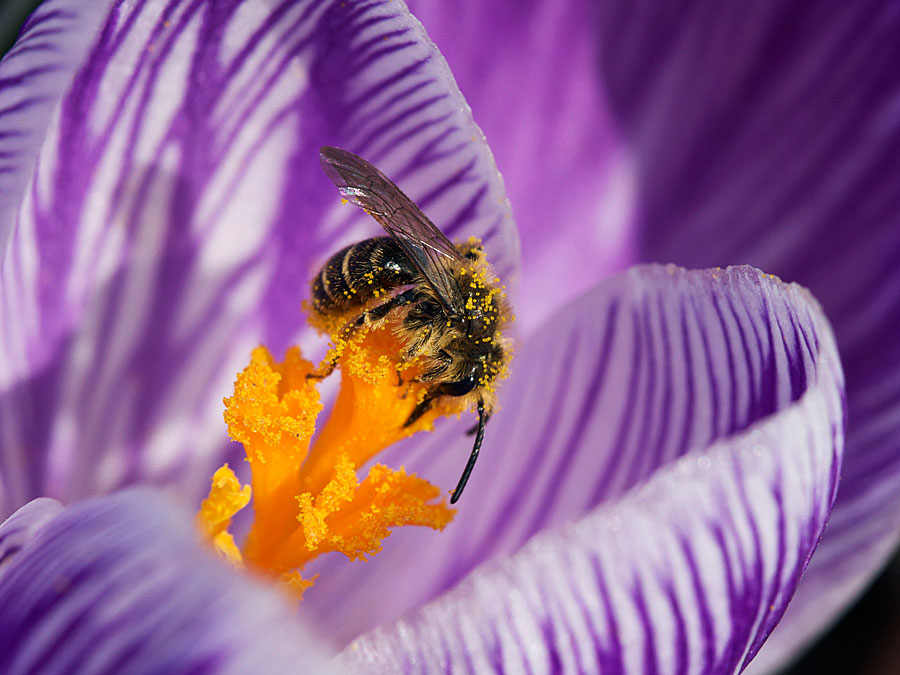

In [70]:
%%HTML
<img src=data:image/jpeg;base64,/9j/4QA6RXhpZgAASUkqAAgAAAABAJiCAgAWAAAAGgAAAAAAAABjb3B5cmlnaHQgSmFycm9kIEVyYmUAAAD/7AARRHVja3kAAQAEAAAAPAAA/+EEFWh0dHA6Ly9ucy5hZG9iZS5jb20veGFwLzEuMC8APD94cGFja2V0IGJlZ2luPSLvu78iIGlkPSJXNU0wTXBDZWhpSHpyZVN6TlRjemtjOWQiPz4gPHg6eG1wbWV0YSB4bWxuczp4PSJhZG9iZTpuczptZXRhLyIgeDp4bXB0az0iQWRvYmUgWE1QIENvcmUgNS4wLWMwNjEgNjQuMTQwOTQ5LCAyMDEwLzEyLzA3LTEwOjU3OjAxICAgICAgICAiPiA8cmRmOlJERiB4bWxuczpyZGY9Imh0dHA6Ly93d3cudzMub3JnLzE5OTkvMDIvMjItcmRmLXN5bnRheC1ucyMiPiA8cmRmOkRlc2NyaXB0aW9uIHJkZjphYm91dD0iIiB4bWxuczp4bXBSaWdodHM9Imh0dHA6Ly9ucy5hZG9iZS5jb20veGFwLzEuMC9yaWdodHMvIiB4bWxuczp4bXBNTT0iaHR0cDovL25zLmFkb2JlLmNvbS94YXAvMS4wL21tLyIgeG1sbnM6c3RSZWY9Imh0dHA6Ly9ucy5hZG9iZS5jb20veGFwLzEuMC9zVHlwZS9SZXNvdXJjZVJlZiMiIHhtbG5zOnhtcD0iaHR0cDovL25zLmFkb2JlLmNvbS94YXAvMS4wLyIgeG1sbnM6ZGM9Imh0dHA6Ly9wdXJsLm9yZy9kYy9lbGVtZW50cy8xLjEvIiB4bXBSaWdodHM6TWFya2VkPSJGYWxzZSIgeG1wTU06RG9jdW1lbnRJRD0ieG1wLmRpZDpFODYzMzkzMDM2QkExMUU0OUFCNTg2REM5QzhFMTA4OSIgeG1wTU06SW5zdGFuY2VJRD0ieG1wLmlpZDpFODYzMzkyRjM2QkExMUU0OUFCNTg2REM5QzhFMTA4OSIgeG1wOkNyZWF0b3JUb29sPSJBZG9iZSBQaG90b3Nob3AgRWxlbWVudHMgNC4wLjEgTWFjaW50b3NoIj4gPHhtcE1NOkRlcml2ZWRGcm9tIHN0UmVmOmluc3RhbmNlSUQ9InV1aWQ6NzhBQ0FFNEEyQUM4MTFERDhCRUFERUU1NzZGNUE4QTEiIHN0UmVmOmRvY3VtZW50SUQ9InV1aWQ6NzhBQ0FFNDkyQUM4MTFERDhCRUFERUU1NzZGNUE4QTEiLz4gPGRjOnJpZ2h0cz4gPHJkZjpBbHQ+IDxyZGY6bGkgeG1sOmxhbmc9IngtZGVmYXVsdCI+Y29weXJpZ2h0IEphcnJvZCBFcmJlPC9yZGY6bGk+IDwvcmRmOkFsdD4gPC9kYzpyaWdodHM+IDwvcmRmOkRlc2NyaXB0aW9uPiA8L3JkZjpSREY+IDwveDp4bXBtZXRhPiA8P3hwYWNrZXQgZW5kPSJyIj8+/+0AYlBob3Rvc2hvcCAzLjAAOEJJTQQEAAAAAAApHAFaAAMbJUccAgAAAgACHAJ0ABVjb3B5cmlnaHQgSmFycm9kIEVyYmUAOEJJTQQlAAAAAAAQJGLgkagzFv5wmZ2M0KH7Uf/uAA5BZG9iZQBkwAAAAAH/2wCEAAYEBAQFBAYFBQYJBgUGCQsIBgYICwwKCgsKCgwQDAwMDAwMEAwODxAPDgwTExQUExMcGxsbHB8fHx8fHx8fHx8BBwcHDQwNGBAQGBoVERUaHx8fHx8fHx8fHx8fHx8fHx8fHx8fHx8fHx8fHx8fHx8fHx8fHx8fHx8fHx8fHx8fH//AABEIAqMDhAMBEQACEQEDEQH/xACrAAACAwEBAQEAAAAAAAAAAAAEBQIDBgcBAAgBAAIDAQEBAAAAAAAAAAAAAAECAAMEBQYHEAABAwMDAgQDBwIFBAIBAgcBAAIDESEEMRIFQQZRYSITcYGRobHBMiMUB9FC8OFSMxXxYnIkgjQWkiU1ouJDYxcIEQACAgEEAQIDBwMDBQEBAAAAARECAyExEgRBUQVhIhPwcYGRoTIGscFC0SMU4fFSYjMVcv/aAAwDAQACEQMRAD8A4Riw2Fk6KUhrCygqdFAkpHAaIEAMmalUjILmsny52wQAukdoArcOG2S0IB0ftT+OvbibPmij3XoV2cda4lCNGOsHRuM4jDwowGsAp1oFXfI2MMBkQMaBUDyVUNhgg7JjItdFVJBAztOg0UgMHwdUV+ijBBJrG1uEJDBcxtOiVjAfL5YhhIa4CmleqalZLMdZZzXnM+bNzzDCPejcNraVABOv0XRwY9JZsShHUv4/7PxeP4szOA/fPbV8jhcA9As3by6x4Md7TaSzlsz9jA+Yj9MVa13wVGOvJjVrLOWZk0vMciWxirZHUFb2XUquNTXMI6z2Z2vHi40baXFC4lcrsZm2YMlzaftmtZ6egWSSkzXdHLx8djPc8gClBVaMWPkzRixs4H3DyLuT5B3sguqTTzXXpXijboka7sftQCE5GSwhw0qqM+WNDPa0jHubnYcDHMLXXoQ0BV4qSy3HXyzmc0k+bknbVznnr0C3pIubg0WLwLcXBMswFXCtwq3klwipWbZk+RiaZixhtusAmY9kFYkQDADqQjVESJTSMjFWuvoEGwst43jJeSnZG1pNSKlRuFIL2SR2jtTsfEwcSORzB7lLrl5+w3ojBfJJrmQNYzbSgFgFibKpB54DI2nRQKYjzoPZaSelSrKjGM5/l2Y7XUdSnRasdC+lDmfM8xNlyuY0kt+9akoLYjY84jgsjOmBcCWptEJax0LjO3MbCiDnAVAus9sslcgHPc5FiNMcR9VKBPSkltKGNEeTyeVUguJN1oSSGbg2fG8bicdjiaQUfRU3tOhXEmc7k7kMz/ZiPpvUBNSpZWsGchjjyJv1Tsb4+aq7Nr1r8qljJEm5LsV7jC6p0DvJW1mNQOB3w+FlciBJkZBjgb5p3aBG/QdB/a3HN9yR5nmYae2TWtErtZ7EhsIx+8eVyB7OJh0abMePBH6K8gsqoa8Zw/dU7hkTyezG/SOpJCFsmNCPIjY8Rw/sgPe57nj8xc4mtdRtNlh7HHIuNknX0K/qPdGnx4Y6FldrXAevwt4UVFiltijuLiH5mJM5grk4grvGj260VvXzcLQ9masGXi/gzn8Tt0l+uq7DOnA2xqbBS/iq2Ky2Sw+CiCBZNNpTosQpyG3qmGSA3sFUQM+iF0QBbNKJZIReB1CIQGYC46dESArjQkIkKXUpYoEK3sNPMoCsoc2/3ICnjWVqoQvhj9QRGQ0xYb6UQINoGUGiUJaQAPuUICZGiJBTkG9K/NEgLIAQgxWDyNHhqqmV2BpGiqRlTKnABViFT6UUB5BZCEGBlKACyL/qiMi40pZQhRIoyFLiFAEa3CBCLyPkgQodQnxUAWRsuFAhLWqAPjooEhQVUIWNBQIT6KBImn1UAeAKALmAAVUZEzyQ2+5QLBpSiiAj3KEKHuCBClxQAyNKlABbGy6ZIMBDG0TIJKiJD4BQhIM6UUITazrREh86gUIipzgFCFTrnVAhKKMkhFEDI4v+oVqCWbR4FMKX48QAXnTjF5fQeCDIDTzapSCyZ75H+23UqzDhtktCCq8nCN12TwWPh0zcoDdYiuq7tMKx1hbmmmKDbzd1YUEZeSPSND9iT6TLViM5nd/zzuLMcOLa0qNE9cCLFRIu43m8+Uh0lQCU7xoVpDuLljYFUvGLxGGJmCV16+XzVdqwKxxjs3AHyVLYjC2Y416JGwok5gYC7oEBkzF948o2LGkLCBIRSh8D4LTiozViqzL9rzuObE4PLrgEkChr8V1qqKmuIR3Rr/2/HRueQwOGo+C4WTWxzd2cs797lkm//b8cj2zU1Aut/WweWa8dOKJ/x725JNK3JlHpaQRVHs5uKgqzXOy4bI4IgGa0oPkuNZyzG9yb5gyJ73H0tBUSCkcP/lDuKbLzf2sbqRg02hdXrY4UnRrWKoV9odvnJyWSyNBaNa/ar810kV5HKg6NzHIYnF8b6aNLW6BYa1drC46yzj/MchJyeU7Z6quNKLpUrCNa0Rou1e15SRNI2o1IVWTKloZ7XlwW925PtNEEfUUp4I4a+S3Gjn+Qx/v7jr1TtDMviLyLm1OiZBRL2nTTNa25JugKzqXYfBMiY2VzRXUW6rH2chly3On4ppG0UAA6Ll23MzLXmop1SgKpHsY34Ihgx/ePMY+PivIdtcAVoxY2y7HSThvNczk5kz2tJLampXQrU0os4LhJMqZpeDSqLcCWZ0rieIgxYm0aNwCy3ySUtlfO8izFx3CtLKY6yPSpzeYy5+aSLglbVoXNwa7ieLhw4BK8epU2vLKnqIu6OacaxROt1onqiyqMe17i4uca/FOhi0ODhQWUIEY+PGTulNGi6jJATNykoi/bYlmm1lIkC0GnbnaOTyEzZcgUYbklC11Uqtf0OpcPxXG8fGGBoO2nqNOiy3yOxS1I4byuJG60jQ3q2oCp4Ng4M+dzmGHDZK07tY62NNUViYfpsrHccL3h0Tg0G1Aa6I/QZPpscQSSzx+5G5sjGV3srb6rNesCMx3N9u5+BMc4wU47IcXRStNQ2p/K8D8t9F1ev2K3SU/MdLBnVtP8kQgsP6K5l5OWv9KqIgDODT706LELJ2kE166JhgV4p0QAzyNlCiAKZ+XzSkK5a0oUwQKalKpkEEeDp8lCFRFEBYPH6IMBTsqfxUASbGNSoAKxoqm6AYGuNHQi11GMMI2W+KUh8+wUCA5TqiniigCucFEAO4HxQZGUPvdVsqsUSCyRlTBn2BVQjKJDanioAEeT9UAMgKV8lIIi1gt94RCScevVQhS41qgApc66ASJKhCDifkoA8ayuqJAiNiAC2lvuUCQdWqBD4NugQsYLKBSPnVAUIQNPFQB60KELRp5oERXI6yJIBZSKFFEgEkca6+ajIDucUrYGQQATaKooKCGMsmQSwKEPQLokLGM8VCF7WCmihD5woESA0jkSA8hNUCH0bTVEgZDGK6XRQAiwCsRJKt531UkIfQNHyXnzilM0tAlZBdkz0BFUEm3CIwngsWN8pypzSGG5r/cV6Hr4Vip8TfixQviN38zm5EgjgBoLMYL2Vk6luiGvH9p8vn0fkbgw9FHdIR5fQ2XF9hYsMY9weoLPbP6FXMZDtjEYKNFKJfrMise/8BCNFPqsaWFY3GNioQq7ZBWxpA0ttrRVsXyGxmwSMaAPlstsMJrYdSmpWR6VlnJO7OTGRnewDUakLqYccHRpXQdfx7hY+TlxscKbTUilrK7sW41Gz2ikG/705uHj8F0bX+st2sHguXgxuzMmGhy7isCfkeQEzgZATddO1lRaF+RwjufA8Zj4fHxMYyjiB8alcTNd2Zzm5GUsEjW6/wDRUICM53PzUeFhuaSBUU1WnBjlmnBSXJxzIw5eY5YyRGrd1XeC2Zc9cS1Nlk3sdD7f45uJhgOG1zW1KzvLz1MdquTJd+Zpkd7Ub6g9BdbcFDVjroKez+3pszLDnN9IKty34ory3jQ6zBx7cPELQKbW+F1zHaWZq21OZ950ZlAggktq4eC6eLY249jFyeqSp0GiYJZHc0FUAms7X4ETvZIRUk6JMt+JVktCOvcBxohiaNulFyc15Zisx4GNbp81nKyMjuihEI+b5MYsTnE0PRXYscl2Oks4p3lz82ZkPYHVaLLp48fFG5KEJuJ4ibKlBLSWm6ZtIptY6HwnCNx2NJbRZcmSSizkY8hlMxoSaitFVVSSlTBcrlZHIz+2ypadVrpWC9aDLhOAbCPckFDqlvcVsj3FyP7eJ0bFMdZGqjn+bI6R5cT6j4rRBYQixy5tVEhSbmtYPxUIVAuleGNNRVBBRpuD4vEhc2ael7iqFmJYe5vd2Nx0Xt4wq4jQKpY5AsZnn9289mz/AKJIBtQaK6uNIZwhrxfbPcnJyCSSZ7A7rf8AFR5K13EtkSNdx38fFrf/AGsmV9DUNDtCqbdpeCt5WzU8Xw2FgtDI2htBVziA6pWa+V2K3ZvcdY5bEa01sQyn+CqLaiBGM+N+9skTZIpmkSxOFWuabXCRqNURmX5jt9/Gk5MBDuPc7a1tQXxk6NcNSPNdLB2FfR/uOh1+xz0f7hXIRQrUjUCTUDSmRYhbNWvn+KZDgzm+KIpFrRu0UYAgW+HRAhRNUg+CKCByXTIINJZFhKiL/VABB16IEZ4GfRAWCxranREgfjRX0SgGMLNCgEMa2yBIKJ3Ur+CIRdOakokA5BbwUADSDwUYGVOaq2iuwNLVVsoYI8gV/FVAYLKdbogB3aoCnrWVKAYLQ0AKQQi4ohB5CgKUk/5oBPCfooQ+F9dVCFsbeqIC9rNOiEBg+cKKAIIAPWtqoFFgFAgEg4VUA0eAKEJsaFICSdYXUCDyut8VAAcrrnwRICvNSg2ApJSyKz5oUIi6NtSmQxe2wRRCQF0SFrWV1UCEMZZRCkzS6ISiZ1KqEBJHChChCsDcUSBEMelfmiQLaQB+KKAVyyWI+ikhQPv9VVCDeWSgXBZxRfkzalKyC9xdLKGtoS40XQ9uxS3Z+C/rUly/BpOK4fP5KSLExWVjj9LpGj0k9Sule86+DXkuqnR+H7f4XhogcgsdPQFxPiqLXb2KIdhi/unjIqtjoaWAFEqxNjrGyv8A/MWH8ib6Ifpkou4Jpn7QDco/SI6wM4J5JACaqtoUMha4m6RgYdCw2SsEhXpbQu0GqQYyfdPIQRskeZQGMrY6rRhqzXhocnbkfvOSfkvF62oupiRrerOpdoNxsHAdl0DCW1JNlR2224KsrlwZruTm5uVzDG2paDQeafDj41HquKNl2FwRjhEj231J/BZe1l8GLLeTpML6sDdNKAeS5bRnRTnZhghc5/5QCjWsseqlnHO9+dOZO6Flx18118GOEdDHVVRT2djTwP8AcLfzXqVR2sVb7iPJD0HnM8sYIT6jWmmimDCtiVUuTExQZPI5wABIc7p4Loyqoutbijrnavb0WFhtfs9VFyuxmbZz8lpZZ3Dn/t8WQ2sKKvFWWPhqcX57PM8rya3OpXYqoRuqtBDGfceQ3Q2Ve7EHXGYBLhXUkUTxAWoR1XtPiWxxtdShKwdjIZMrN3BGxkQDR9Fz7GYnQgbnG5SAFXI8nFjBxedFZWjY9KScr7z7t96R0MT61rRdPBhg3Y6JGU4/h5+QyA5zS5pNyrr2hByWOgcP2+zFiBc31UssOTLJkdgvNzIsWM1NFXWskqjFctyc2ZIY2VLTaq10pBdEIK4njWsZveKk3UvbUVsYZmZHjwm9KBVpSRIwXO8j7zzQ2qtFVBajPvqTXoE5GfNyHD0iyEgIVe53kdSpEhgJijaz1aeaKDAQ7OyJAImk+CkAHHC9q5Gc4OlrsNyT4JbXSEteDoXCdrcbiMG6MF4NakLPfK3sZ7WNFA6KEUbRrVQ9RWi93J4scfreB5kocGyKrYrzO7+JxnBks7Wh35XVVlcDZYsLA5u+4JJo4cN3vmm1jY2ipJNTU/1VterpqH6Ubmq4nPyspkfuxGIvGlTuafFZ8tEtimygOzI4/b9vIrJiSWewEbj4U+BWeracrRhq2nK3MXyGO/GyJIHf2mrTe7TcFdnFdXqmdbFfkkxfNWlaq1FwFKLmqYJRS/ioA+ogBkhpfRQKKZiP80yQQZ31RCCyA1RAV7NSgQ82XUCeiPyQBBYyMVUgjGeNGA0JWKMImdevgkJJdSgUIgPJPndMgi2XqEQwDvF1AQVGOqgGVSxn69EjK7oClZRVMoYBNa/3KsRgkhr1UAV0ugQtYxCSEyBRQElMpUkIK83QIVk0RIRqoiE4wTRQgXGyyhC8MFECFUn3qMDZXS6BCxjbKBRI0oftQCVOF1AQetF7/NQkFgAQCQkNFCAkztfvRAByvUADOKVgZE6oAJNCKQUXsCeAlzVCFzGKBLmM8en3KALgKJkQg9wFqosgJK/WiBAU1JRIWRsUJISywRIfOeAoQofIoQo3HcoQaZEtAQuAcQWZEtj5pWyDvtHtiflZvefSPHZ/uSOtRdvBXhjSNWJutdN2dCdnw8bjDA4eHc4ChlA1NPEJ+LtuW1olrYCh7e57kJC/Jkc3dqOis5VqN9VeBri9lxR09x9SleYV3Y1x+2sJoHUhI8rFdmMsfh8aM+lvzVbyMDYzgxGNAoNFW7ChbIG9AlkJa2PaD4oSFAvIZDYYCSU1VLHqpOW9850boDGHeomgC6OJQdHGkkZ7gMQSzsboagkrYnCH2NhzubLjYceLEaFw9VPBZ6rk5F46lfanEOy8trnCor4V6ps1+KK814R2PjMSKCJkYs21ei4t7yzC3Iy27XClh4KtAM73hyEcOE9rXUJFNbrV1qSzTgp5OVxce/JyDIRZxrXwXSyX4o0WtBpmHHw8Og9O0VHisamzKqqWZHOyZc/M2tNWk0W3HWEaVojf9l9tQs2zSM9QvU9Vk7WbwjLmudAbFE2CmlNFzWzIYHviZrIHgWHkt3WRrwo43ybg4kdV0WamwfCjIo8oIRM1Hb4M+Q1pHUKXcIl76HZO38PZjMPgLLkZramC71HjWFtK6eCzMrYHyGV7MLjWlOqatZGrWTkvendEvuuhiddxoaH711MGJeTdSkGS47i5+Qyx1qfUVqs0kPayR1ftntePGha9zb01IXKzZpMd8khXMSMxojSlhUBV0UsCRznmeRlyZzGw+mvyW7FSC9KCzjeMa1ofIFL39BWwnK5GDGYRUWSJNk4mS5vmzIXMY6tVdWhalBn3bnkl1/EqwJU9ga1EgLs/UulSAXNFD5+KYJZteRQV0UAPeB4P3XtfINKJXaBLM6Lx37fFgDbADqst9WVQU8j3ZhYQIDgXdEa4mwrGZXkO+87Jf7eLUB35VcsSSLVRIqZh9x8k9u+Z213TTVV9fsVvOkQNb5R3jfxzPM0SSzEnrW6tfZqil5DVcL2tx/GsaQP1xSj7VqVRkzuxU7NmrxJomAVdUtvQHqsrUlbQdK8TYxkgDXOJo5jjQV0VfGHqBaMzXOYcuRGMiNoMkAIlaDU7dQbgaLZ1Mqq+L8m/q5EnD8mZmuF0kdADfrWouiNBQ4XUFPQ0fXogQ9OllAg8hOpTIiB3lEklDxVQh5sKKImeCMlAkkwwWqoRFkbBXS6ARhjtIHX4JRRhGKCnVKwHrza3wQCAZB9VuuqYKQBIKnxJRDBQWnzUAyQjsoKVStISMrsL8hpVbKGK8itSqmICP1+9Qh4xtfIKARcxtAgA+cSoEGlPyQZGCyFQhW5Qh8ASaokCI4/qgANjZT+qhCbggQofclRkRADysgQtaEBjx6hCsqAZ6G/9FCQWVIF0AlEjtfBGAAMz/p4qEBJHXKACooCnwChCxgTIYvY3yRIXsaiwhEbEAMva0deqZIMEXmlfvRFYLK+igwO51a/agA+Yw1RIWsZa/RQh851P8kUEqe9QBVr+ChDzrTyQIX5M2t/iuCcQr43Ak5LObFf2WndM8eHgPMq/rYuVp8IiUuEdT4/iXxY8fvH9phtHohFiQBq5dWTbX/1G+JyvB4gpGG7hatqotNh+m/J5ld4QNqIW6eCCxNjrGLh3VkySWaadFYsIzxodYXNSPA3BLbEitoe4uWHgGvyVDpAsDOOQUCqaAkEMfX4JQwezTBjNxKiQUjKc7y7WsdU+f+a14sZqxYzl/N5f77KAFaNJNSt1aGlrwNOCgbjNErvzU1V1loWcQur+TzGtaK0s0eSSOKFtojpfa3CNxYQQ31FczsZZ0MOW8mvxoyKE3posTZQeZ2S2OMuJpRGqkeqk5tzsmRyOZsa6jAaVJ810KWWNHRpTQvxePGPGd4vSxVdsvMpvuZ/uPkQxpY030/wFow0Hx1K+zuMdl5bHvG4Vsrct+KBkvGh2jjOPbBA1oFLVIXGyXlmC9pCMhlGnokQqZzXvxwMb21qR0XT6qN+E5VkQGScgXut8F9g2LApGKaoQCDU9q8eGva8t1N1RmZTkOq8XK1jA3yC5OTcx2DpMtjW1JoKKtVFiTEd5dwxw4z6OoRotmDEa8eODkT5JuSzibkvNl0UoNDcI6x2R2vFDCxz2g1AJJH9Vg7OcxZbyzbT+1j49uguFhWrKlqznvcuaZ5THGakk1XQw44NdKCbF4ShMrxpclWXvAGV8nmx4rCK3AokSkiMNyfIy5Epa12p1WmlYLEUw8a+QbnJiEMnGEPT5IoKAJW2PTwQJID6jJ80qAXtF/uTEGXHs3Sitx5qQBmmj5GHEhBBAIFknEnETch3NlSuLInW8QUVRBiCrB4vM5J4dM4kHqUz0A9DXcZ29xmFtkmpUXoSFW8jexXLY0PcHC4bTtLWkdAq/ptg4MX5H8ktiIbjNLhW3go+sOsa8lY725zkHCPFhJeetOqsrgqtyNVQx4jje83uc6bJ9kPN6CpQtfGhLZK+h0PicSaPGb7kxfIygdIf7j5hYcl02Z2y3LjaC6b2y5z6b2ClTQUqK2VRFYy/N8O2HEOdie4cYPMcwcABG83aA7qF0ut2HZ8bbnT6/YdnxtuZ1wqtpsI7dSUGA86oEPHV/qoQHkr/VMiQUSdEQsrIJ/ooLJ6I6hQh62P5KBSJBgUkJYyO9KapSMNhaQKVQFDGf9EpD55oDRREAZ6a9ToiOgKQV+VkxCsMQFaLms8enVRgKZo7aUVbK7CzLbY06pGU2E2T+ZVMqAzqoQmwf1QAWigUIVyGxooQGkKDADPNFAlYrqoQtY2tFCBcLESIMY2jfNKSSMnXooAHd4KBPGoETLRSnkoGSLtNUCIrIUIej6KEPnGyhJBpnGhp16KCgMrtSECArzUoAZ4oAkAmgYujbW6JAiNqhApjB9NFCSXsZQU6oojPXUGqZBKJXmnwUAByG6hDxoJKhC5jPJQhJwAChChxr80SFZFbqEIOt0UZCvddKCQnD4/L5TMGLjNq7V7ugC4+DA8j+BxkpcI3/ABEHG8FE2BsYnzNTQVFfErsUoqqEbMeKEFz4/NcxKPcrHD0aOqasIs5quiGWF2W0NBeTXwUeQR3bGEXaGMKWqfkl+sTkwmPtjGabNQeZh5MvbwbY6FoU+qSQyDFdFpaiW1pAMIqixVTIEMkSwFAvJz7YSK0tb4pqosojmPcfKEzPbu6nT7l0cS0k3Y6mcj3PkL6alaKIsTG0U8hjEdLkUATsZuDcdl8BucJHi/jTRYezmjQx5b+DpMMAha1o06rlWcmNh8dRGTTRIwGQ7t5l2PG5rddAtnWxyzXhqY/iMmZ0znSDcHGq1djEmjU7whxyecBFc0IF7rPixwUrVmCm93PzqNvU0+S6FVCLZg6d2Twf7WNjnN81zuzlMOZm/iIDfAhc9meQLlcv2IHOFK9E9KyyzHWWcZ7z5wvnc0mpJ8V2cGOEdDGoRlsY75QTelyr2OMA86U+HwRQWzZdsY52tOtKU+ax57GXKzdQDbHUnpqsFjNuJe4Ocbjwuo6lB4qzFjkux4zk/L8plclkllSWk0AuulTGqo1bGl7Q7TkMrJnsqTe6pzZUlBmyXOtYWM3GxmilKD4aLk2cszbszvcvMOjBjjNzai04MXkvxVEHF4D8iQyvbUk1qtN7RoWuxPmsiPEgcG0BAVdati1UnNOWzZ8qUsZf4LXWkFux7xnByuO57bk6IWuI7DqTAZDHQNpa/gq1YCZmeWo0kGyuqywR5DqtoESMjBDepUIi326n4KEZbHIY9PkiSD6WaaU0qaeA6qB8hfHcYN/uSaa3QYsjeXnIMGPZEAH06JYkCqhNJy/J5r9sdaHwTKsBmAzD7T5fLcC+pDjcmqLskI8hs+D/AI6xWEPyRuNiQVnv2I2KbZGza4HCcfhge1E1p/1AXWa+WzK2xpHFF01VLbAW72RilaDrVDcgHnci1m31tDq2J62orKUkatD3FjxsmJ4yWikrNsorq0mo231S2bTleCS6vQxGdiPxMl+O8EUJ9sn+5nRy7OO6vVNHbx5FasoHAO34JmhistsT9UGArcaVKgwPI4g0P+CmIVE1KIDwDooAuZGpJCwMtRKST4x3rWqkkJsZfRAhewdUCBDKjp8FAEZHFQKApqk0CZIaChw69PBEh4xhKUDL2ssgKUztt4BIxLCfNsDT5JGUWEeT+Y11VTKmC/4ooAsYOqBCZqFAIplqoggsh8UAA7kQkmj7UCBEUdKIkDoY7WCAGW7TSiDBqVSE/VBDA7gT8FCEmNQCWXpdQDIO08FAkPGqgT3pWigCt5tdQDA53FCSAUpQkBSVAHoBRQSxja9EwQljKhQgTFHogALZGQEUQkRQfdRFEZRK6lUwGwSR5UCV0qdFCFsTOtPmgyF1KDRQCKJHIkKK3siQ9PmoEqkdZQhT5pRTpvbHAzYfHCCFu3Imo/KnOtT/AGj4IYsfCqRgw04qXubLie2cKJzXvZvkNy4qWsx3ruaBmFE38rQAPJUuxCDo6FSQosq0daIEZW6aJty4W6qJESIHOhAsdEeIYPRmRnzR4kgtjnrT7FIJBP3QLnQapYCkIud5BuxwDqK7FXUvx0OZco8z5riCSAaAroVRt8FmPivoDYdKK1MdGp7W4R2XPUg0abFVZsnFFWa0HU+M444kTQBfquNkvLMF3I1iJcQFSytl+VOyHHJPQIVUslVLOV915rcjLEbDq7RdjrUhHRooRHFa2CIucKWUyOWC2om5PlDK4xAklPjp5HpVIbdpcIJp2yOHWuiTPkhFOWyOrcdgtiha1oobLj3tLMFrDFkVAfhqqxUZzumXZjPv0qAtWBamnCtThfOOdLnP8akLtV2N7I4kW1qIUHwtBka7oFAs2vbuVA0NA69FjzVMeSrH/JcqIMYkGlrLNXHLFpQ5d3Bzc2VkPYHejRdDHjSRsrWAvtDgDl5TXubuFdfmhmycUU5bwdk4riYsWBrqXA1XHy5HZmGzbZRy/Itx2EA3NgFMVJLMdDKDGfyGTVwtVbZ4o0aJDeeKLBxLChA+CoTbYqRzbuTkpMvIMUZJFV0cVIRorWBj2l2myV3vTCrhcAqnPlhQijJYf8jxMMTqtYAaUcQFlWQqVjK8yRE018FfRltUc+5XJ3yOC0JFiQAxhcbpiBG0Ut8kYIRoAFGMiI9TvLwQIw/FijaQ51yiAsyc8tHtxa6WQIecdws+dNVwJrqEW4EtY3nB9owQBr3tuKaqi+XwVOxrcbDjiaA1oAHgsztJVZhsYDRZVsUs9wU1QAA8jy7MRm4uFR5hPXHyLKUlmZyf5IjfI6BkTnO0aW9StFOp8S76SQRw+Nm8i9s2aJRfewbqNT5GqrQS1o2Nvg48Qa0OBroDpT40WC7KGwXubjXZmAWsYDkY1ZYzS5b/AHAU8U/Vy8L67Mv6uThbXZmGDBSo63XZZ2Ct41QADyUpXwUCgSR1SbpiFTTU/eoAujbX8UGQKjYSP6aINgLRFStEJIfFnyQCSay/moRl7I+v0UASIooAplpRQZAslK/emHKttaU1UITZGD5pQF200qgxWDZDbH4JGJYS541sksUWEWQKuPmq2UsHAugAmAoA9cSgEHkcP8kQAzzU0QIitoJdb5IhZcyOtPvUIgyGIdQoBhjIwG3SsB88W+GihAaSlSoGSotvpqgEk0KBbJV/yUIRNKqEPAClkhF2hUIDyOUABzOr1UICPJUARopACTWk/FMMi+OOwChAuKOtwgQMijRJBcGhFAK5SKWRQASZygQalSiQm1lUGQuAACAGQe9QBQ81OtUwxEDxRIfONlCA71CEKKAP0fg8dFHE1rRQBJa5kGkbGMbSwqqmwQRlzIImkuIQ4kgQcj3LiwVo4V81ZXHI6qIJe8S95bGa+PVWrCPwIDmsqc2rfUBOsaQeKQbiuyXmpBNUWkgDjHgmIBIVLshbMZQxu6qtsUG5PNbFGRWlAhVSyylTBc/zDy8sBq3x+K246QbKVhGdx3+5NU3utFS2ZH2EwveGNbUnon8Fmx1bsnimx47HuGoXK7eQ5ua+psfaaSB0C58mZhEWO3UdUANiLu2ZuPjOo7QXKv69ZZdhrLOYcbA/P5F73XDTQeC61nxqbrOBzzeOMfEoNaWKzVcsrq5ZkOLwxk5x3eoVWxuEWvRHXe2uLbFCw0+C5Oe+phys1+PEA2lFiZlLMja2P8UEMjn/AHtnBsL2joDddDrVNeBHHJ3e7kucfG66yNrCWxbWt81AhMLAXCnzKZ7BaH3FvdEAarPkUlV6yQ5/ln+yWVv4/JLSmpK1gy+Bhy5mToXElX2tAb2g692fw37aJjttKCq5XYySYMlpZq8vIbFDTrRZK1liVUmI5WSXIyQ2+q340kjTVaDXjIIseLcbmmvmqcjkR7iDuzlQInNY6+lFf18ZfjRl+G4t+VkCR4ruK1ZLQh8ltDpfD8cyGANpcLkZsksxtnnK4f6ZIF1XTIFI5Z3e/wBvcF08RdRHOck75TVaSyCUQIHgoiQXJgwVuNTQG6BD5tqE/VREJh8jztFUADriOBknkBeKhBuBGzd8Rw8eO1trqi95KrMfsG0DyVAhe2UUrXRKwQU5HIwwtJc8CyKpIVWTG8/3yMdzmQGpFgtGPCXVojKTczynKSUc4hpNKLVWqSHUI1XbXb0bdr5QCSqsmWNiq9jo2CyKOFrQaDQLn3bbM9txpA1ooOvStxRVMVlsjDua5vqY2psbAnWvikZDAc7gDD5GSNoAjl/UjA0AJuPkV2etk50XqjsdfJzp8UKZLDyWgvBJQbqEA5Aa+CIDxjSSOqMkC4oydUrYA6OKgp9qUJZs8lCHxZT+qhDwMuoQuYLKBg8cFCQDyEVIRICv/MPDoiMeMbVBhLmMtpZAQu9s7aFBkbBspgofNJJXYRZ7CCfsSsosIMoeoqplTBqdUCExZQEFchIFUASDvdVRkKDc0RCTjYFCBUMen3qAegdHFohIC6lB+CASqQi/VQDBn0qUCIjS5qoMe0UCeH7lCEbqEPiUoSp79fNQUFlfSoURAOR1anooApN1IIehqKCWsZXpqpBAmONEgXHH80CBLG2RIekgIoANK8X6XTEBH1KATxraqALmtoL6IMh48iiBCh7qlMQhX6IkPKokK3nwQIVE1uoQ8oiQ7zJ3bxuNH/uAuHgUXibMyxsWZX8hYwaQxwJU+iMsQgy+7svMfsiOvmrFjSH4pEY+MysqjpHm+oTbCOw543tiOgLhr1VdskCuzNJh8FjR09PyVLyMVsaxYDG2DQB4qt2AFxY7QNEjsAnIxrW3tWyVsaqlmE7mzwJ5GNJ2NNK+K2dajalm7HQwufI6SQ9T5rbBoexbgY5pUJ6olEavtnj35GW0AVAKXLaEJmvCOycRift8ZoI1AXDy2lnNu5YwHiFQIRmzvYaT4BNWshrWTnfeXOzT1x2G7tV1OthS1Ojixxqedr4Bhg3uFzclTsW8CZLSwXu7Mqz22nyU69dRsSBO0OPkfkNfQ0JVue8IXLY69xeIY42+S4uS0mCzkbRtAVTKwbkJD7bvGiaqLEjknfuY8BzW9dKLrdapvw1MBgsBmJdc6rcXrca5jKwgi1EEMV4xoauTBD5MlrIQRaiR1A6ix8U+dOGjQlTYrbg3fa3a7WbXPbexWHPmMuS5v8eBmNCBoQLrnNyzMKeUzanY01PktGOpfSsC6HHq73HBWWfgdsD5blm40Tr6fajSjbGpWTIRiblMyrqlldPityiqLm4R0DgOCZFG0lo0XOzZZMeS5oWwhg0ssdtSpME5ENMRB8ElKuS6px/vxo9dPErsYEX1WhzZw/UNVoLGXCgCgIPS6iYJ5WpUkDLGY8klgNUGBsccXxBLqvHW6VsVs23F4scW0UVN2Vj2JzW/CioZW0fT50EbPU4WUSbDxYg5XuzHgaQ1w+qtriHWMxHKdyZuZIWxE0OivVUh9Ee8R2vn8jKJJwdpUdkhLXN9xfZWNBG2ov4qh52JzY/wuHxcfQ6eKqtkbK3Zhv7zGxxQuFknFsHFsMwuSimcAwh3UFLbHALVaGp2+zU12+DdVSxEI+6sAZXFPyYm1lxz7m6l9mjh8Fo6mTjePDNfUycbx4ZhHXFV12dYFlrqoAEe0ogJwRurX6INkGEEZSkDGMFLBABIsQkJDb/1RIfbbqELB+VEJ4/VQgJNqoQGcL1RkKJRt/wEAsJhjPX5KChGyoSsANkx+kpBbIQcgw1NdEYKbIz2a2hNFU0UsC6pBT6oAUIVSFCCA7zWqgCAbUohCI2XCJA6CIUSgYaxlkJAevt5KEBpSoRg7vHxUJJ4GoDHxooQg7wUCQNlAnjnWQZCiR2pQEApn1NSgQHc6v4piHgbVEJc1igC+NnldEIVFHQgJSBMbaBEhMmx+9EhTI/oEQMFkfenmoQrpe/TqoEsaKIAJOIAQAUSH70QlRNUSHhRIQe42UIVFxJUIeUURD2hqiEcw42bPf1GvjVbIkVsYwdu501Ghpr9yragrd4HnE9n5Mbg5zT5lLzSEd5Ndh8Q9gA2n40VNsiFdhxjYvtiipbkUYQsFK0ukZC8a3SsBcyny8krJAFy2Q2NmugT0RZRHL+ZyHSZr+gGq6uGsVOnjUISSRF8tW+N6KxIjHGFiANa02TliR0fsXi2B4cRUnUrB27mHsWOkPiayMUGg0XJkxg5ftaUIIIedz/bhfpYaFacVNTRiqYHHY7O5KtKtB1811J41NlrQjbsxRjYdbAAXouda0syzJz/AJaR2RnbQbVW/GoRprojb9m8a0NYS3wWPs3Meax0WCEBgAXMbMrZftoPNKBCrkn7Y3fAq2iLKI5H3s6Pc6mpquv19jpYtjDxudHLVtj4rWWDISGQ3Jp5KDIrc4h9BYdApIYIOmkeQ066AdFGxXY1fa3FiV7Xlt6ilVlz5IM+Sx0vDgjhiFBTxXLvaTHbUq5DkGhhY03KNKDUoKYonTy7ibVV7cFjYRmbYIDe9FWtWCqlmB5V02Zk+2wmhNF0aVVUbKqEaTtrt8Ma1zm3sarNmzGbLkNxjRNijDfBc+zlmRslNQDzoggIScrktZG6p8lox1NGNHJu8p2yBwXTw1NlKnPZ46ONFa0RnjXOJp0SsB7tJ0QIThYdwBujAGPOOjYddeiDBBosNjALDRVWEYxbOyMCpv4pYFgGzO42QsPq0RWMbgZPlO58iZ5EZN9FbWgYgDxOLz+Qk3SVvZGzgDsbHgezY4iHzCpHiqL5fQqtY2WNDi4sYa0BoAVDciA+d3DiY0bquFk1cTYyozMZHdvIZT3R4bCQbBw0WiuFLcsSSGvD8HymaRJmykA32oXy1rsV2vBscDjIcUN22cNVivkbKXZscQ1MZGlOipYrKSSZS135CNrh0IOqDCc65bCdg8hNiuNQx1WHxabhdvDk51VjtYsnOqYvkFvNWFhRsqVGAIhi9SUgdEyn3oNkCGioQIfFt7KIhHbZEJ80KEgmK/BQJXIKokA5epIUJBTW/n4KALI21IHyUCHQsqUGyBPttpXwSyBgmSz0+KAGhDnx2IRKrIzmcyhcKaKuxnshU6xoqxSLiNECQUvKgpT1soEsjbVQgVDHoiQPibp8EoAkAAX1UAVSUFUAg0l/P4qEKTpp8lCHqASJ6okK3VRCiNf6oBK3uKQDBJXlQAJIa6oAKv8AomCXMaiAvjZX4ohCo2Gn3oMgQxiiCy2wABUAVySWRICyPuiAr1UCetH0QYCRNAoQg5wpZQhWRVEhEtv+CISD6KAB3uKBCI1UIWsZUVRCXeydtUQQdq4btKCFjS5tTQJ8mfwjJaw/h4fHYQAwW0Wd5GxQ9uJCwXAr0VXIANMWNNqa3RQxSciNpqSExCTc6MCxrXopxDBY3K3G3XQoQSAhkxDS7o3VK0RIy3cHLhjX+rUFaseI24sZg8mYuc55FSTc/FbUaizjmB0nqHxqrakqPYogZQAKhBjvY6b2fCY4m281y+05ZzMzk2Dg57VzzPIuzpPZjJOiaikaqkwncWeXvMYN3aBdHBjN2OoR2rxYHrcLm9Uc9xMrHHcGSyHEcweCy41LFotTnOO73+Rrreq6OyNF9EdX7Yi2xNNOi5Od6nPyPU1sbhtH2rGyhkjIDVQKQi56Usgd0FFfiWpbjRxfurL35Tmi912sKhHRrsIGxhzriyuQyYVAyn5tPqoMTkpW6gyCOOwffmBp1+1Je0IryM6R29x7YWNK5ma8sx3Y3y8zZGfsVFayIqiYPkmkv8lpiCx6DOPbBFvNrKq2orUma5zlnPdsY7U0otWHGaMdY1IcFxJklEjwTVHNkhAyZNDoOFiNjiApQrmWtJhtaS94DUgsAGdlMjBqdKq2tR61MN3DzBIeGutpRbsWM2Uoc35TIdPKb2BNl0KqEaEhFlQ3JHTVRi2QHShvr/gKsUsAqiRIsjZUgDVEA7wICL+H4pGwDZmQ2JoJNx0SQBIXclze2oaddEyqGBBLLk5brVIPQpoI2hzwnbb5ZA57agpbWgR2N3x/GY2HGCQKi6y3u2Vs8zOdxcYEVFlFjbIqGez+6ppgY4Lk6UV9caQ/GAfA4bkeTlD5idhOia11VC2sbviO3sbEjaCwbhqVlvlllbsPYXsiFBQAeCpeojR67koGg7nj6qcGwKsg7+4sVn6e8bvDqmWFjfTG8U0eRjxyMtID6xToqLVgrEXdXDR5mGc6Eu/fYxPvREDa6EaFpFyQtPUzcHxez/qbOrm4vi9mYqgcLfFdQ6R4GdfogwMJhYag/VAgS0UP4oELRSigTwm+ihNj4C+lVCEg26hGSpXX5KBKpBdEgDMLlQKBwKuPVGCBULa0KAGMIWUAP0SNkCNtvAoABchvp0RAIuQZrRErsjOZzRUj5pGU2Ek4o5V2RWUGwSClbiL0UIRa1QgREw2RCGwx/wDRBisNjaRr1GiACZNAoQGkNAgEodQn4qEghS+ihDwmg1QaCQc77UQlRPioQiT1UZCiR1kgASR11AFDuvmgQ8Yw1BTECI2JghUbAFCBDGC3+AgQtBoPkoGSLngIgB3vrqoAp1RCetBohICVALKEIvdogRFZubIoh6GohIvNkYIDyO8FAFVLlAhYyI/5KEC4YK/YmQQz9r6NOqIsn6IZHtIOg0WVsyHsmTBB6nkAoRIDP8v3ZjQ1YxwJ6q2mFssWMzb+5Z53UYTdaVhSG4BEORly0Nz5KOqRJGOPBkOIJrRVtoEobYuM+gB+SptYDDs9n7fj3ONtwtVCmtoHxKWc35qUSyOFagWt4rpUrB0eMIQz0Dmhp16JgsY8dDfdS5+9WBqaXh8MyyNHn+KTJaELktodP4HGEUTbWAXIzWk5uRmhjczZewWRlJne5cuNkJaCr8FZZfiqYPBb+85F5cKtbp1qV07PjU2WcI33G4ghxt1ALVXOyXlmJsyneOYdpaOtQtOCppxIT9s8U+ScSFtzequzXhEy2Os8RiGKFopRcfI5Zgsxy1ttFSIeS0aK9RqogmP7szgyB7d1DQrb166mrDU4ty8u/Le7rUrsU2N0FeOat/7h0ToKLSaGxpTVQKIRh8soYL1OqVsjNt25xh9LiPiVizXM2S5t42Nhi8FhepnAckmV1OitqoHWhZjYzWDc4aKWYGLuZzw1rms16KzFSS3HQTcbxkmXP7jwSK1qr734oe94N3xXGMgYDSi52TJJhvaWNS4NCoEF+XnNjBqdFbWpZWpkOd5trWuAPRbcWI1UoYPk+RdPUAm/1W6tINKUCLJFHVCtQwunINftSsVgTmkkpWhGj2wUghbA5u6/1UFY0izWsjslZIBMnknuq1pv5IpEgogxJ8uQVuD1R2A2azh+3m2c4XrdU2uVtyaSJkGLGaUFNSqXLF3EvMc+QCyM1PSiemMZU8iPG4/O5KTc8nadArm1UjZp+K7Xiho54+Kz5MkiyaPHGPitoAGgDVUtyJDZTn9y4uMw+oeSauJsNaGcye9JpSW44JJ0WhYF5H4pE+MweX5GUSTvc2MmtKlG1lUW14Ndx/beJE5sjgXvF6lZL52U2uaCCEMbVtgs7clYQwQihcLOFHedVXYhzvuLjDgcrNGG7YZCZIf/ABcuz1svOifk6/WycqfEWsbU1+auZeFRNpRAgQ1vVAhMghvmoQiRQn7EQo9ZUnyQCWtZat1AM9IN0CMolqiQAkN04yKgLoEC8cIAGEQO1IwMtNvxQADTn02N/AoojEmaLlFgZn8+MGpokZQ0IsphBqqmUsCdp/VAVoheqhCbG+CgUFxR6AhQDDoY7IACWt+iBCL7DyQACyV+qISi9FGQjZAJFxtqoQqe5EhUXH6oBIOegwA0j0CA7zqgAhtr8FCFrGXHimIERR6fYiEIY3yUBBcLCn3KBPnvtrdQhS9yhGUE/REh61psUGQkgAi42UIV/VEhJrfooQkRRqhCiUokB3m9tSoQ9Ywk6IkC4IeqhGMsbGsLDyCKFYb7I9unXwTgOjct37jRkthIJ0FLqmuFlSx+plc/ublM47YWuAPVX0xJFiSRRh8Rn5EgdMTUq3kkB2NVxvbrAGlzfqqb5Sp2NDi8ZEywb81nteRQ5uMwCtAq+RJL8THLpRQddUtmM2ed2M2YNK0NKAKzq62L+stTlOc71OC6zOkxV7YMoJNSOqUrY+wGMLQALmlk6Q9UbXt/B2hhLfCpWTNYzZWb3BjLWgdFzLmGz1DJnhkRI8FUlqKjD9z5m4FjTXot/XobsVSjtjj3CXeRUu18lZnvoJmsa/KlGPi00oND8FhqpZTVSc45md2Vme2BUVXUxqEbK6I1fa2A1rWupfxWLsXMmZm/xI7AeS51mZGFEBoCRAQr5TMbHG6hurKVLaVk5d3XyxcXtrWq6+DGdHFWDnWS57pi49SVtLWEY9P+qBEfSkg20RDsNOCw/dmaSK1uSqsjhAvbQ6XxGKyGEErnZHLMdtS3JyNx2ttTolrUEHsEe71UsEWyMF5XPbCwgJsdJHpWRFB7mdPQVIrqtTiqLm0kbPh+LbFELUXPy5JZhvdjd1GN8lnKhdn8kyFpFQD4qylJLa0MZzHP7iWtdc2AW/FiNVMZl8x2RkA2stVYRchRkQSNrUadVamNIulArbRMMhflM9R+1BkYG8EFARlZugKR3bfxUJB8ZHusCgRoOwMF0rgSLINis1/G8bEwNLhpqVVawjGkmdBjigI+RVaq2BITZ3LSzHYw1/qra0GSKMHiZMmQSSeKLtAGzWYeLjYkQNBUC6zWs2Vg2f3FjwVAcKjzRWOSKsma5DuyWX0w3Plorq44LFVAGPg8ryUw31DSdE7aQHaDd9v9owQsa6UXGqy5MxRa5rsfBihYA0ABZrXbK2y5ziLeCUBKLNY07C6viApxI6jDGgZLE95eGta0uaHdT4BV2cCyCc3xuLy/CPZKAzNxWl+NJShPUtd5KzBleO/wZbgyOl1GxzdjDpSh6/ELts7JfG01SkLwNaoEPTpY6KEIkXRGJxtpp9EABTYxRKQjILEUUIAz1unICOB+1FDEAypFlAMMx49PLqlYJGEbSBWqRkPXIAA5zf8AFMQVZjdfuUAI81lQUCqyEWYw/wBFU0VWQte2h0QKyIbVQEF8UeiBGGwx/wDRQAZEyn4pSFu0gIEKZTbwRACSU8EGMioi3ioQiSKqEIPNj8FCA73HVQJUXKAKZHeKBCl7lCFdKoAJtYjBC6OO6JAhjNBRQhaLBQJ8TRQKK3OqoAifvUYDwN8dT0UIe7bIEIm1lCESLfeoQ8DSaJiE6UQIQkcKeSMEBnnVQhAMqa0qoiBEURNESNjDHg0RA2MYmgU6eKZIUu3itOifwCTUcd2g3a10wq7qltlSKuZoMTt3Fjp6QqnlYsjKLjceM0DQD5Kq2QEB0UDGj0hI7SAva0CyWSFjQCUAjLjoAXg/OqSzAxP3o4mHYLUB+1a+mtTb1Vocrz4nAkD5rqm97Cog+5ZLAjQ84RrnTtr1KZ6IjcI6dwUP6bT0C52ZmTKzV4oG0fisNzGwPmM724y0fVNjrJbjqYjIc7KzQ0XuujVcam3ZGv4TA2Ma53RYs15ZivYp7jyA2J3jQqYa6j4kYXBaJ88k+NlvtojTd6HR+BxQxgd0oFy81jBkepqcaoFaLJYo8H2VkBrSUKoNUYvuTlAyN9Ct+DHJrxUObclI+aRzjeq61awjelCEWXBtcTRMFkMe5pWnkoBBjMYveB9FBoNTwGGI6HqOqzZWZ8jNT+52RUB+IWXiUwfQMdK6viahS2gGGzyNx4CK3oqkpYFqZLPklysjYy4JWyiSRpShGj7f4nY1pcLrNmyGbJkNbHGGMHRYWzMAchltjY69wnrWR61kwfPcs81Yw1PkuhhxmylBJh4c2TIHSfABaLWgduB4OKY2Gpt4eCo+oJyMxzkAY5wbbwK1Y9S6pm5WEOPQq4sSBXxWNRU9UYJABkR7dErQrQHrYCnigI0RIqadEAhOJjF7xXRQVs0uFC2Fu5VsWAmTkSPS1Kqg4g5dkZBpcp9gh2HxwbRz9fxSWuK2MzmY+LHQUqOoVUNixIi5fuU3ZG71HQDVOsYeKEUOPncjLV1dpOit0QWzW8N2nG0Ne9vhqqb5St2NVh4GNjNG1oHms7s2VtjGPOgjsXAJOMg4yeZHOYsTa7h9UVibIsYvd3BNkPEcLdeqdYY3CqJDXjMN9RJLXe64CS9/QS9jRQge1t8FmZUAZkhjJYTRjrfGqNVJbRGFmgMU8kf+lxouzRykzr0cpM9jZUotjFlOqACB8uiYJMNJA+9AaS2OPogwBLW20QYskZW6oIgHkMrbROggUjCDVEJKKO+nwKhA6CO1fBI2AKAACUE6lb1ERsDyCL306JgoWZN70ojBBVls1CURoSZcRJStFNkKpovVYJWipkGxlKwMKijoLoADImXCAApjQL/VAB6+wQCCTV+Z1RADPH0QGgqcoBED9igSp7h8FAoGe43KICl7r/igQpe4lQhWT/0QAetBUIXRs/zRIEMaoQuDRREh44miASBKhCJUgBJrTXxRCiVAFGEi5AUrOvmoRn1FEQkAiQ8cQK+AUIDyOqFCFDgT5KELoo6gfYiGQ7Hgr8kRZD2MpQAaaKQKW1oPtViQCG/1aokg7IGtAsshmJska0+KAS5kjSbUv1VVqhkvbI0AX+KKQGie6qEEJsJJFOqkEHfHtMYvqqrAMr3lONz66eK39RG/rrQ57nOBDiugbmL44Nz6U16oimj4XGaJm1AFFLPQS2x0bhg2jWhc3MYsg9Dw1hp0WRozqpleezzvIBvpqteGhtx1gr7fwN8hlcKkmybPeFAuW/g2sUDYoajwXPblmR6sxfdeSdj6dVv69TbiQo7bxw+bdTqrczhAys6jxOOGxii5GRnPvuNgKBUiijl8jZG691bjrqW0RzXuDL3vLQamtSuvgrB0sVTPOIcKLUaIAM1lAbIkegDA0+58NQoVyOMIUcKj4IDNmkwpo2RgCxCz2RS0HQyGUgAktJ0VbUCNQPsSNkcYNFls5KWK+Wyy8+20/RW4qFlKlnA8P7rxI8Vr4qZskC5ckG2xMARMFtNFzrWkxtyeZjxGzwopVSRIxfPcgQCxpudFuxUNeOpnocGTJfucLVWp2SLnaB3h8U2Jgt81nteSl2klmkNjI6AIUCtTD85INxquhiRrojPzEEE+KugsBJiKXRJIBP6j5DT4IMVgb2gH8UgjIxs3OAA6qCDjBiDACdQlsBhRnJ9INhqlBJfiYjpHAnSuijZBqz2oG3+ZVbA0B5nNMiaQCPkgqEgQ5Ofk5T9rK0KsSgkBPHcFLO8OkCjtArZs+J4aLHa1xAB81nveStsZy5+PjspuAp0+Cq4tkiRByXdNCWxGp8ldXEOqxuBYb+Xz31FQCaWVj4oDaRoMLt3JeQZ3FwNyq7ZkhHYf4vHY+Gyu0WFzRZ3d2EepYOYgZIG7wAFPptg4DnCzIpo6tcLqi9IK2iGTC6WSuoBqB4FBOBq2gWczwgmidlY7KTNNXsb1HitPX7EPi9jXgzpOHsZ5jaeRW83M+dpdRERCnRMEuYKamqjCXxtB1QAE+3YpRHuVvbQ/eohkCzNF0yGAntFUwYLIIwXC3xQZA6Ng8PgUjAWub9QlEkHltXRFAAJ3GuvxTjSL5kQsAyG1BNPgg0KxTkxggpSpoWyQ3ofmlaKrIrEQVbEZfHHpayAoZFH0QYC4NAFkCJlTyoQEkJqT9FAg7j1QIVEf0RCVvIH+PFCCAsj/AKIkkGebnxUIVPKBColRsB4NUCFsbUSBMbaDyRIy9oCMBPaj6IEIOP8AVAhBQBIC/n4IhLAKAKEPnGnxUIVHwQARAqoiE2t+aJD51viiQokcLoEBnmtVCHrG1KhA2FlaIoDD4WgAIgbLybaUFEUK2VyS7QmCgP8Ac/q1r8kQwbyHvF0v5AUfpFboFR83kvNaG6n00FVGWHyWQ+m5JbGhWkNIJ5XuFdCqnVCNDSIu2glUsAdx8e6ZorWiSwGaSPHAjLlSRGA7zABPhW66XWOlgRz7MkbUj6LcaWyzDjDnDwsmgiHuB6ZLJbbC3NlxGQWU6eCwZVJhupGWRyIZCampVVcZKY9TKzF+Xk0BNC5a6qEaIhG44Dj/AGoG2XOz3lmHKxnyBLIXACgoqq7iU3Oa9y5O6Qs86Lp4VodCihDLtXFqGmnxVXYuZstjo2CzZG2y5d2ZGEySBrTVIiJGR7kz2RxuJPRbMFJNWKhzPMndLK9/iV16qFB0KqAIvI6WTjSDZDt3yUFbIRQndUBCQBrCWqBDcaZznBp+iWyFsanioTQE9Oiy5GZ7sPy8v2IyfHRVVrItVIqwo35mVu6K6z4osu4R0HhMBkcLaBc3LeWYb2kcPDWMJ8FQVmd5rKAaQDrrRacVTRiRjpYDk5FKVAW1OEaJhDrA41jGiyz3uUWsGSwNaLBVpiJyI+VYAxw+Kvxl9Tn/ADgIearo42bKCCQ0IurywHlNdFAMEkBQYAN4JKURovxowKFAUM3UAA0SgYViY7nvqRYoNijR0jYGCnRKGBNn8qT6Wn6JkiAUGJkZcgJqjogM0/FdvhtHOFvFU2uIx639riMpbcBqqnLFFuf3KxjS1p08EyxhVfUROy+Qz5NrKhp6qxJIOiHnFdsOcQ+YV8SVXfL6COxseO46DGaKABZb2bFC58mCFtXOogk2LxM9yvcRlBhgNzay0Y8MassrWCPFcFPOfdmeTWhonvlSFtaDW4PHsgjaGlY73kobkOcSKU+apYD2j4iyRgqP7m9CEu41RB3DhwQ5xlg/2J/UOlHdRQLo9XLyrD3R0OteVD3Qnc23nVakaiIbX4piFrW1tr4oBC4WH4FKxWEhtkJFKZQACihkBTD7kyGBSEwQiBtKfBKyMLiaLJGKSeAG6pSsCnIA0TIaBfO7X8E6CkASGpNfqmIDzNBBoFCAE8V0rQlkAywdAKpWillJg60VTK2WxxWCUQIa2gqlFZ84dFCA8xACgQOQ3KgSh2qhIKyT/VQJRKaf1UCCSOUFKHOA16IBKXKMhE3QASYLlEkBEbR/VQEhLG/YiElYfioFES7p06KEI0qVAQSAugQmAERj4/aoArKgDyhQISa3qoQ9NgmCVSOAQACSO6eHVQJAA/FEAREy4UAwyEXRAGMNlAHkkoGiKJADkZFdbIhQH7x316+KEjHXsPtCCCm5t0bZ5MzsOIuHxmgDZcKt5GCWEx4ETLbUnNkbYZFjsaNPkldgBLW3FdOqRsiQ44PGc6YPI9LVXd6C2Y+mpHjur1VVdw0OW965W5zo6rrdap1cK0MG9pfLZbCxoZYUJAr1CYdIc8dGQ8P+qruJk2NLA/ZGHeKzNGdVAc3NJcReg6J60LqoL7dxnTTNeRqq89oRTludJ4+EMhHwXIu9TnWci7npQ2J1OqsxIsxLU5pyQdNnjU0K6lNEbphG27Yw6RMssGexhyWNhG2jQsLKQDkc0MYb2T0rLLKVOf8AP5TsqR0bTatF1MNI1N2NQKGcS8i4N1e7j8wDPwPaqSrK2ksTE0gO8noE5GXRAg216pSItI8BREIdx0RMjSlu9BLmuxXtZGAsVjO1qDZ8plkDGm6eigeihD3gONDdrtvxWfNkKMtzZ4zBHH4LA2ZGD8hnBrDdNSsj1qZLPyXTyENK3UrBrqoRdx3GX3EeaTJkKb3HIg2tp4LPJVIJkig0ToepnuVNj9AtOM0URgOaIc91ehXQotDVUzWU4B1BfzVxYDBxNUQEXNqNEYJBSYb6INEaJxxGqRoRoYY+I5zgeirbK2MQGQs86apSCrkMwl1B9EyQYKcHjnzSguFQfsRdgPQ1fG8XHG0Fw06lUWuI2F5efFjsLWmlEiUgSM5mZ2RkPLY60JoKK5USG2L+P7dmnIfINwPilteBXY1nG8DDAA4tFfNUWySI2ND7cLPAAKoSBXn8+yBpAIqNFZXHJZWpnsnmMvOk2Rk7StNcaqPEDng+FIeJJbnW6ryZCq1jXY7Wxtp0CxtlLLTnRR2cUODYOLPWclG+zPV/VLbGwxAfFV7K1pS9CseLFaifJyG1l4QNnzD/AIqfDMTCXkPEtKuFPA9FpwuLpj4dLJmTc2tAuydRMiG0OumqIxbG26AAyIEaJWIy61ECA8pq00TIYAyDqmQwPWpTBkKhbb4pGKEtNPSUrIzx5JCUWADJd0HzKZDIWzuOnzonRAR1ymAR211GihCqWKuoogwWBn4ta2SFFgd+MQbCyrsVWPvZI6eKrK2SIp4figApkOvRQgHMT8lAgjyowlTigRMqc6nwRGBpXWRACPdVAhS49AoQgUCHwbUqALY2eWqJAljVCQW0RkMHhv8AFAjPESSSA/zQYSYb/jyUAfOUIQca/PRQjInzRASDevVKQlWg8kQlUj7VUkALI6pUCU0JJKJCxjVCBETfAXUFYXGKCoRIT3kKABppq9VCAEslyoFFO4181ICfoA8pjONQ8UVfBmbiTbyMNKbgUODJxLW5jXEBpU4snEKik30r80jFDomtcRVIyGq4fGbHjggXPUqi71Ea1LOTeGwEeWimPcsxrU5H3ZV2W5drr7HVxbGWFA8+Pgr0POo0xnAMAHVMOhthEMaB4qqxXYYyZZbE0E3SKoqQNGwzShrrk9QmegXobntzj9jW0C5nYuc/NY1pHtw06rAZjJdy54axwr4rXgoasSMdx7Tk5pk/trZb76IuyaI6RwkOyJvwXKyvUw3eo3mfti81ShUjIc/nububXWtFswUk1YqiPBxDlTbiK+BWu1oRbe0GhHEsbDpeizfU1KOZku48YMqWjStVsw2NmJmMePUfMrUWsJxma+HggAsod1PsUCNOPjpRx+SruytjcyFsYAP0VMaicQjicR804Lh80mW0IW7g3nGYgYwUGlKrm3tJiuwzInEbPgkSkVKTM8llvkeWtK2Y6waqVghgce97g94UveAXtBoYMYRt0+CyNyZpPJbBREFedIGg+Cuoi6qMjzOU0B16ardiqa8dTCcvkNc51Fuoi+qM9KNzlYMeRxVN7fFRuFJCiefY2wBBrQ9fJefy9/K3o4Ml8r3KIORaHgTxgitCPy1+BGianuGRb6irsW8jEZnG72lokiaR+WSjqH4jotdO+n+5QWfVT3GDMiER7mODhrULTWytsxtwDLzy51GlOqkSKMTGknkDiPimbgjNVx2HHE0EgClzVUWYhdm54iaQDQ+AS1qRVE1J8uWl6Eq2IC2PuK4BoIe8XVN8hXZmmxcOOJlA2lNFndpEJzSMjaSfkhBDOc1zbYmlodfRXUxjpGOlyZ8yfU7a6LUlA6UGl4LFiio51Km4r5qvIxbGojz8aNgAcAVmdWyp1Iy8yyh2X8KKLGTiCwxZWXNUkgKxtVRG4NFg4IgaOp6rLe8lNnI2ie1UtCBEYj3NL2hwNjUdCqmQyvPYH7PkXsbTZJ62U811utk5U+KOt18nKou2haC4ujZf70GGApjbeaWRHueuFPigmRA8ptfVOhoF8xO5MglbReoRIFR1ASMBbu+zqlCQkf4IQLIDknp9iKChdN1+9OglFBVOQmyOvzUITGNX5pWIz04dRUD5JGylsFlxbm2qrsylgskJAqkKwaQWQIgSZ3RGAyBSuqdVICDuKgSt56dEICDyHVEgHM6oKgAd5Jr9qgSt3XxQAfAKEJtZdABfGylFCFwBCZBJFAJ4QowQehtVIITDUCHtkQNEHHzsogyRp9VCHrW+SJCe0UQIVvdT8QpIGDSP6KEBya2RCSa1QgRHF9OigGwlkdNfoiAssBqoAqleoQCmfeiBEBvcoMjylq9VIIdPxuM5NrhuLjS1brRyRXyQ6wsDLLhv+irtdCtjvFwnAgm6odxGxrBBRtAqnYUvbua5jQPzG/wQWo1Tb4TQMZvQUWa25UA8s4CMg+Fk+NaluPc5V3RUzuPxuuzgWh1MexmWMrJ5laBxljQ7WCqg8DDGqHFIxGgh7t1EIAkM+CxHSZANLdFTmtCKstoR0viMURxttoFxstpObkcsMzCQwquoiRzruqRznuA+S6XXRvxIXduspIN2pKtzvQmU6Px0jWRgaaUXKvuYbEuQzGMjJrohRDUUmH5ecTTbRe66OJQjZVQOeCxQACPkqMtijJYe5DWtiPwVFXqV03MD3S5pa5q6OA6GIxDm+u3iVsLWgvHaA1QBbQBwqlCMcOTaB4JGhID4R7zgB10H9Uj0Fs4NhwXHUDSWrn5shjyWNQwCOOw6LG2Z4EnK5tAQCtGKsmilRXiwumkBN6rTZwh24NLhYrWtFljvYzWchcjQAQq0KAZJoCnqMjN8vlhjDdasVTTRHP8Am+TO5wBv/VdLFQ2UqZXKmMjtdVpSLYAnNKIGWNbtFaedPghbZ/cB7F3KcfDmtM+JHFE55oIISaXH9rXFzl5zLhlabnPa0jyZ/K4/PxCWTQuoK1brp8FkTK2miiOWlNjhTqD1p08k9bEmC/8AeBkolbuhfWzgaj5nQj4qyt/wHVglk/uTsfJG1zXV3SR2Fa1qW9Fsx969P3fNX9S36jX3Gp4uDHdH7kThIAKnbqPiOi2Uz1uvlZaoguycwNBa0qxVICx40uTIK6FFuCM0XF8M1gBc2+qpvkK7WNBFC1gFBSiobkrPZJWtahBDM85zLY2uDTdX0oWVqYbKz35Mpq6y0pQWQX4r2R0I1UZBjBk5byAytEIQGOMLBzpvzE+ZVdrJFTY/weIAILyqLZRGx3jwRxUoFntaSpuQg5MbGncQANAlgEA2Lyfuzlsf5QVa8cILrCHkcgo0EVqstkVg/ceK2bi2yNaN8JqXUuQU/Tycckepo6t4sZQBdg6hdGL/AIpWQJaKNSikZLDzRCgOY2KZBA3t9VQmCetaa36qEL2WP4JRWScbf1UAUyu2hSAyL5jUn4owMCvbr0BRSIiAjJPxTECY460BQBIZFjA9LpGyqzLHY9rC40SNlVgSfGoTboq2ypsWZMVOlkslbFc4o6ihELpymGSAZDdQKRU4+KAfBU81F1AoFlciQDld9BogQpJrooA81NCoQkxihC9jEIAy1jVCIn8fmiMSAv5oMkkg26LIT2D7UoD4hQBByISJFQiSCQZVQhPaAEJJJW91EAAz3qEgHcSfxRCfNYFCBEcVTpdEEhUcVBVEBaBVQBW91FAgc0lB8VGAClfUoBgqoSa+CgSe1Qh3h3J4TdCCfH4JVVmfiycPIwP0pdR0YeOgfjz7iNtKeKRoXiNMepCpsKEe2793CxpNKjyTUHrsbZrdsDQbelZHuVIQczLRhvotOJF+FHMu4pN8jiF1sWx1KLQQws9dVdIUNI20YPNSRi1hINjcaJWBoJgY6RzWipPgldoAbXt3A2lvp06rBnySYc1jc4ke2IdFzLPUwtgvJTbY3I0Q9Ec37iyGmYt87ldTCtDfRaFPCupIDpVLmZXl3NfHne3DroFz2pZmdRFzfcWwEbtOivxYy2lDP4fIHIyQT0+9a7aIssze8LIBED1WHJuZr6hWdmhsZHUoUQcdTn3ceWHvdQrp4VodDHojLmpePCq0jsMiI218UCI+c81tp1UgIXBK6zWi5slaAzV8BgucQ4jVY89zLlsdA43GayNviuZktJis9SefJtjN1XVBojL5RM0lPNbcag1JaDfi8KjQaapMtzPew5Y2jQAs7ZSyMlAFCIV5pIafvVlSypi+4ZSGup9Fuwo2YznHLPJkdfRdPGjXVCc13easGJsaCRUKEPnihIpREB5FkZWO5skD9sjPyHWn1XDvWG16GdprYHyOWnhc3IfhxyMH+45oNb2JNz9yxZaRqtjNbTWAaY8JlzCTEldBXcRHOwBzTWwLmek0Hkqk0xHG6Bn8dlNLAzbkNks1jTU1JsPAlFyheXqVx1hfWOrBcOhfbTpdJyjYau4dx2SfXLC8QPiaX3dtfQf2s/1f+JR+rxaa/QsqPOOycfNkY1zgHvADT0cetPArq4e74t+ZashseM4psdCW/wDRW3vIjY6ZE1oFlVIpCeZjAb26qJEEHLcq1jSA4VCupUsVTCctny5DyAagrVVQWg2Jx00jhQG+qLsBs0XHdvSuI3A0VVsglnBq+O4KGIDc2p8VnvlbK3YdQ40cYFBQBUuwkhDQ0eSRsDRRkZscIO5wsilIVQzPMdxNJMMLqk9QtWPF5Y6qOu14nOhEkmrkmZlWRmqZoKaBZGUl+Z6sRzNWvFws6cWTGxvUxrmFj3MpQtJGq7ycqTtJzqWRC+ijCEgWSiMqk1omCgSYUPkmQQVwuiEk0U+HggAsBpZAWDx7r/goQGmNQUUFAzmlMMQMfVQU+bFVygwZDDofolbEsw+DHFAq2ypl5xqjyCqdiqzAsjHIsAg2VCXPjpX7EsiiDKoHFMFCud6YIG86qBkpegMUSPoDREkAkrv6KEYI83URCHVRkPQ3ogQvay6gC1rfooQtAP8ARQJIMqpIJLRH9FJJJMMsgCT4qEK3H/JQhCyISTW1KhGWbRqLKSCSLzT8ECJgkj7oEYM8kkhRER81tSiFhEcSIAqKIaogbL9o+CgpW4gaKBBJ5R4qEAZZalAKB3G/moE+DT/moiE6WRIdbx+AzHDc5xVv1EU80M8ThpYiNyrtkQHYfYeJShPRZ7WEdhxjx7doVNgHsEv/AO6saOjrj4K6lflkuS+U2rpB7Qv0WIoRjO4ckt30PwW3AjXhqc45eZz3mh63XTodCuwBC4hw8VYRDSBxN+igZCmxigtqlYRtxOIJZAQDaizZbQV5GdB4fFDYxa9FysltTmZramhY2kduizmcRc5PshefJXYkX40cy5OQy5JvW/0XTq4RuQw4uIi6y5bGezlh2dlCOI1NCAqEpYqRieWzHSybAVrx1gtQVwcRDmk3r9VLsSxtcLJdGzw8lkepSC8nydA6+gVuOpbRGJ5XM3yG9aro4zXV6ATHgmmnmrRxhC0EABQJL2KlSSDXh+O92ZpIqP6qrJeEV5LQjofC4AaxtRSmq5ea5z8ljSsAZH8lkZQJ+TyCQWhX46GigBhQb5QSKq6zhDXtoabFhDWBZLMysvLbJSIHl6okQozz6fvVtC2piO4D+a9fBdHCbcaOf8kP1D41XQoakhYWkOqnGgmxnXxUAVyi9UUQqkNWFxPqHn0+HksHcwt/OvxK7rSQcukBBHra7yFCucZ7VF+XjxxSBz2h8T/9tzq+kk12nSyw5acX8DNesMhGHwglkwjIptY6rmuPi09KJeT2FSYfNA4RMOfju2PG9s7C2QDdep2lF6borVkDHCdT3YpA+L+17binmlLkexvAIDHs9z+6IOFHU8PAotjnQO2e4XRcewyb8nGB2yyE1fCfAjqFox5nXf8AaMtVJp5cuP2hIxwcxwq1zTUEHS631UggQcpy4aDQ3OiupQtrUymXPPkvIqb9AtCUDl+DwT5XAuCS14JJp8DhI2Uq0U6qi2Qpdh5j4kcYsFU7ChLQ0BIKeOla0XNKKBgWchzkOOxx3AUR+nI9ayYnlO5Jsmb24XWr0+K04sUalsIYcHxbZpGyzmrtaf8AVXXtCEubvAnx4GNY0i1gFhvVsz2qNW5FW+kVCqaK2gtkjnxXp8FTdAAOZ4R7MZvIxU9p/wDuN6g+K19TP/gzb1806MUtaAKrcbGyzp5oEKZKVTBQJJRMFFDxe3jdEJEIAZLcfH4KCSQc691CFUlHGqIxH2zqoMz0RAn8VAFkcNDWiDZGwuGK+likbK7MZwwVA6KqzKrMvfDRttPNVSUsX5UViUsiMznJClfJMgGZzTc/NWBSFM7vHVEYFkKgUDyGnWygQaR1lCAkjvkgAoPiigngBKgC6NgUghewW/FQha0fVAJY1qgCxrVAMsDRaqgJPTZAhW9xUgiK6Ihg+DaKBLGiyhJIl9FBYKJZB9iVhBXvOmqhIIAVRCXxxVRQAuGOigoQBZEBF7qdVAgk0wv81CAE0lSboDIGcSSoQ8DSoQsa01ooQnssiE/RcMTKBUNmMtMbARb5oSQvxxe6VkGeDD7hJ6NFVVZgYFx5380//tNarZEUNVlFTZF3/r1HgsD3MyMH3O8gSX1W7AbcRz3Le90vmugjY9iuNri4W6qwg3x2H0+CDIgxoG38Uoxp+3scktt81j7DMua5vePi2sFlyrnOuw2aQMjPiq0hEjFd0cgGxuFfotmGpsxVMLGfeyC7oStF7Qi+xocNmyKpssVrFFlIp5nMIa4fJW40GqMw0Gaep0qtWyHZp+KxaNHRZb2KWN3u2sKrQvkzvL5JAdf4rRjRdUx+ZlEzVW2mxeWY09SFYhpHWM7c3yRGQyxoC94pfyS2ZGzZcDxtA0kLFmyGTLZm0woAxgtRc+zkxtnuXPtB+iFUGqEkr3TSLUlCLloNOOxNtCQqL2Kr2HDG0sqSo+fooQDndQFMhkJeRko01+RV9EX0MLzsxobro4UbcaMNyEgc80W+qNMAGrvDzRIWtFAoApmF/BFBKg2l+qhDx8DAN9KMr6qdCeq5fZwKj5LZlN6wWNwcWZphn9LH2c43oPEeYWK9E1BnvUVt4t2PPLjEieJpO0uIaXMNSHtaTXRYLV4uGZ4jQ9MGRihrmOJxnGrCNNOtbfNBqCOnqiGUIpGlkTBHLIPVI0lpcOocB6SPkkgCxxsCxxxQu/ayRs3Bm4ua3cwt+IBLSE6YFpowyDNzOLlZlYbmOiIDXt1Y9vQPH4qK0FicaodYfcbW4j5MMOdig1nw61dCermeLVrwZ+HxqWVst0Exbs8NkjO+J4q1w0K69bpqUXJyOeP4MWc4XSWyCu4/xuOZGBQKi1yt2DWxhugSSKe7gOqhAbJzGRC5uiqyRJma5juWOJrg1yvpiLFQw3Jc1l5r3NjrQ9VeqJDhXCcVlPfuc0kppSByNnhYGW0AAEfYq7XRXaw8weOnBDpDRU3uvBW2NzmRQNDSbrPxbE4yMsSdr2A01VN0VtBbwJcOSJ1aEGgVNXxumhsdoaZmRGQ4tPS30Xbk60nzlEEokPzTIINI6pNUwyKHEV8FCEb/ABCgGfFwBqoLoQrX7kSPU+2KERMMJQGJtjuoAIjh+iVithcMN9KJGytsaQQekLPZlNmWyxHaq5K2xblx0BtTxUAZTmB+b/HVPUhks43KtQyFUrj8v6ohQK8qEgGkcoFAsjlAMGeSoQrofooEmxvVQBfGOqJC1rUAlzG3QIXMaoLJa1tAfuQZGelRgKnlQhU51dEQnwFVCEhRQh6TRQkg8kvTqoRg0kh6IEKrlQJbGy6IJDIWdVASFNbaygDxxA0+KgAWealaIhF8spJQGQK991CHlCdECFjGohLms8lCMnt+uqYB3uDKLm63VTqZWoCGzFxpT8EkBTC4T9iVgNHhQ+3gOkpeioerFWrEHESAcjMT1K6F18ptutEbFsrXYxoVz7LUxtamG7lFWyLdgRuxHP8AIicZDewXRSNjRZjtoUZIMoDQU180oQ/GhMr208UrcAs4Ruu38PawEhczPc52axrsaPYwVCwWZjYHyeRsY410Rqh6I5h3TyRdKWA0rqVvxVhG7GoF3GtdUHXqkysNmO5JiyH5LL5KoMry+UXOLa/RbMVR0ecXBucHEap7sWxrsOENjHksVmVNnuWaNKlRkZDnJaNNCteMtqjIyu3Sk1WpFgVifmAThQ/wqloA1TDo13BYO9zSRZZ8txMltDfcXhBrRZc3JcwXsNnUjjVJWtRPnZBLqA/JX46l1URwYdzxbVNe0AvY0ONEGtHgsrZQy/olRCqQogAcg2+9Oh0Z/lX+g+S0Y0aMaOf89kULvFdTDU3YzITO3PJ1utZewUmh8kQEt5H4oEgiaOp1RIe7D8VCF8TQNQCCKEEVB+RS2Sahg3DON7Zw8uB8j+QzIAx4YWRY/vMha6n6hfWrh+b02ItquPm6/G8J6GS9bJtL001/qNIv4144w5B5bP5HdHKyHBzMJmPIwFzXOe6aGX237aNs0ODq2IWDLSY9TmvsWtZKI0+3oEY/8TcpDjOz+M7iwMnHxXvZnQchjTROifHGZXVZF+53tLNv5K13aKhppT4Lvn2hP8TEZs+TCwt5Dio9j2MfHkYjml0bTUNq1pNWu8HtDgk3KqKNU7QJ8GLDy8nINXQZZoBDKCwhg01/MD4ootWrlFmRhviZRzTteNzdoratKkDW6LqFNFOFG7FLfbk2SsqKtIBO7oPEHqhMDU01GvDcvLxeecgMB490jW5sbfyx7tJANWjx6K3Dntj/AP5H5Rr4OsYD8TJx2z4sjZYXaPYaj6roK6spWxGF7QApJCqWRrb1oikEVZ3LMiabgKytJCqmO5vuStWsdfwC0UoWQZ6KHL5CUFxO0lWvQjNTw/azKNL2/GyqtkgR2Njx/DwRNHpCz2uV2sNmY8bG6AFVOzEAeU5SLCicSbjonpRsatJMjHzUubngNJ2grWsfFFvGDovEknHbW1lzsz1Mt9xkC4EgeCzC+RFkM2zP6itV18bmqOpjcpFDtVYWg0rx9E6IgZ5uaIjlLvs6BQDPgP6qAImhNFCHrW2RAWNZW3ggFFzYwQoRssbEOvzQbBITEyg/BI2KwyCOpCrsyqzGkMYoB0WezKLMseyyQUUZ7bHxKKIY7mKAO81bVBRjs9/qNFaEVSuCIUCyO1QIDSFQINI7UKAKTqVCHgFVCFrG1UIXMb1UCkXMjUAwmNnlqgCS4NQAekKBKnn6IgKnE3ooEiG1UITDVCM+dYIARRI7wUCkCyPJ0UIiu5KhCTWXUJIVFHYE6WqiAKjaBb5KELCbKAkHmlAHxUIATSH+igUBvd42UGK6VP3KALWMsoFF7WXBUIydgFAEdw3JiHfI8cD8ot5qh2M24VDBQ2ulkAZjxVlYBU1KVshsZMb2+NINtw+yioq/mFxvUw2ODFyLx4ldW2tTo3rKNTFP/wCvY6i6wWWpka1Mp3BIKOBsdFrwI14UYqdvqNFvRrZ5CDW2qgshsIP+LIBk0fA45fIKivms+a0Iqy20Oj8LiNawHauRmscy9h25g2rNJUZXuGUsiePkr8a1L8aOVcpumzCNRVdGuiNgy4zH2tBWbJqU2ZPkX7GEfYq61AjK5JL5aeJWyuiLUO+Ih0sqbsrszSQijfwWVspYLyElGEeCeg9TEc3N+ZbKF9TNG8ltFoQwfiVFPIJx6mj4lhe8NF6qNhOk9u4XpaafNYM1zLlsbXEiaxgNNFgszJZlGfLRpp1RohqITUMklKVFVp2RbMIcYGKQBZZ72KLMaNFG0VQp9RQhVJZFEAcgp0MjM81JtYT1utWJGnGc256Yuc6662JG/GjOPJrc6q8tKXgk1te1EQEJAW2+qhD5lb+ShEFRtB/ogQLggJeAL10StkNb25/yXHufLgsbM+VoZLjS19uRta0I0r4Erm97NSmN2vZVqvLKp+aY1GGN3VzGPLJFg4MOJSRr5MUxnaJW1rVpN6h1KaeC59ovDkw9jq48m/29Cub+RO7+CjflMwIM7i3l4yscbonsl6Pie4SiMdCA36LD2c1aXVeXzW8f3DjwKkNJtIzXPd7cR3KTk8txMkXIGjP+QwjCN7XOqW5EZZHvLR6WO1Van1E+i/8AHYyOTx2JKRhsdJkQw+uKYnZJGHC+wGrvSbXsU7qIqeCrdlYLWw5chlwZSNuRUhoebNDx/Y4+IsU1bNFjr6/mecjgxvxxNG3extTUfmaR40/BSzF4tC3GZkRe3O8h0j2uG0n8zK9XAaDzSTA1U9x7213FP29kkwOdJw8rt2dx5/PCSP8AdjHVvwV2LLx+4Ox06LlsPKw48vFkEmPM0PjePA3FV0qtWUoZIQcxzzYw4B11opjLFUxPJ83NO8sjJJK0qkDwU8dxGRlSB8gJBRtaANm54XgWRtaXNuFmvkK2zRwwtY0CiobEYXEQKAIMVlHI8jHjwkk6ao0rLIqnOuc5x+dMYWEkV8Vux44L61gc9rcMGkSHVV5rwhL2OiYAa2IDw6rm2cme4a53osbgLO7KYAqyKsyGRrRMWkMcaBx6ldPr3TUG7DZbC6UrWjQDSO6+KZDIHebePiiErNyoQ9ooQ823UFZY1hI8wpICwR3+5SSBEcYpfxStkL2s0+xBsBfDFdI2I2MMaG4PXoqbMptYYxR2H3qlspbPZmekoEEnJWBumqgmJ5t49Q+q01Q6MZnu9Rp800BgVzOpb7UCAr3DRQgNIf8AJAjB3m6jAQpdQhJoUIXsaLeShEXxRkqECo4tCfooKXhgCASRFOt0EQreVAFL9aokIhtfxUIS29SPkgQ9OnwUIUSPoiSAWV9SoFlJBN/FAhNjP8lIIXRxnciAIYyihCwGgsoQhJIB1UBAFNITX6oSRgcjyURioipUIWNjJUCXNjoPvKhCdgoAg92qKIVbrohP0PG6p0Wcyh+PG40AHxCRijTiMUy5zAQKNuUtnCI9EajljtxdvQDRU4tyYlqc8lkDOQPiSuvVTU6Xgbsyi2KxqFmtQodTM8/lAly04al+FGaNwSdei1GhhGLDY210UYoZBEQdLpWySavt3GILTTqsWexlzWOh8W0NjAPguVkepz7MPme1rCevRVQBGH7nkGx/XVasKNWNHPxjl+SSR1WyzhF7Y6x4fbj0+Sy2ZTIn5iYCqfGh6oRwRl8w8VobC2ani8WjR5aLJksVWY2DTSqoEFXKuoDdW0LamE5mQ7iPOy3ULkJG1qrkEPxSbf4snGRte2cQvc001VWS0IF2dQ4aAMjbbRc3I9TFdjp0oYzVUQVJCzJlLiRX4K6iLUizBxi524oXsLaw8x4do81nbKmy4tsgA8LbGqkkBpTRqZBQsy30afJWVRYkZHnZ/S6/RbcKNeNHOeZeS8rqYzbVQhK7xKtGPAK/1UIeuireihCHt0/D4IkC4IXPNvFBsg/4njS5wJ8VRkuV3ubXi8BgDd7NwF6AltaaAkdK6rge8dNdvBbE9G9n6PwzOszraUFcpiNy8drZXmOSM7mPYB6XEAHo3cLdVh9q9mxdOjVG3a0cm2C+Z2Yjl5XIx8tg5fDi5fji9v7jHayNj5GhuylS2txqK3+N10MnXe8S/Ur+mt1K08HP+bwO3hlOONkT4eTMXvOA+IxNicXWha4PkDmAflLqFczNV0emxc0ntoJZ25EToDlRmOUO9uLI/K0gijhWwNDTQo0vJQ8bDIBlFs2JkQNdNKx0bHghzH16Pa6gv4p5G5QoYFhRHEjtMW4MjvakL6n9vMDtDJq19BNmv+qgtXGvgukwmbJIZv0JGesbjTY7Tc09QfKx6pGxokAx5YnSbXbTNAS15bRzWl2mlfSUy01BV/mH4fLv44SRYzDFGD7kkJO4e2BRxZTzV+HK6OVsRW4lOfLk5OQGscHscA5sjTUEOuF6DFetq8lsX/EY8T2657ml7a1vUo3uS1jZ8VwkcLASAAOlFlvcpbHLImtbYKhsU9qAEURgmXyMcDSSRZOqyRVkxHcncXuNcxh1qteOkFtaivtzBkyJ/dcKknVW3cILcHTuMx/ZiAIuAsF3LM9h1jzhoWdoraD2PZIylQKiizWwLlJOWhKUNkwnsd6nNFGk9B5K7FbjZDYrQzNzNIqF10zprUDkN6J0OUPFb9VCHgUIfXB/ooBs9Y2pQAENbUKAZdGzSyVsAQ2MeCBJLWMqdErFbDMeJJZiWYzgiAAVFmZ7MNZHT4dVWyp6lOSKBRDIzvKGgdU0V1B0jC806xotFUWQY7kHeop2QVSvvTRIwAzndECMpeVAFJrWw1QIe7DooQsYy1VCIIiirooELiitdQWQlrLIAPaWr1UJJB5UCUvKgpChP9FAk2tUIenS/RAhRKbHwRRECyPNfBQMlJBOuiBD1kZNtQoBhLIaEIkLhHQKEJEUChCtzqAn6qEBZZSFCAcshJKASkuPxRITY0k1UCEMaAFBSemihCt7lAlLiDbVEh7Q/wCAiE/ReLFUAm/l5LM2ZJHOFELk6UKqsxWOO3omnJe4dLIZNg3Qw5rd7Lvgkx7jY9zmvJymPMBrQ11XXx7HSrsTbyDtmpqo6EdRNyUhmJvUqyqgaqgVNJbYq0YYY7hQEdUGEZYzNz2geSrbFsbngMUgCy5uexz8tjY4sW1gXPszKz7Nk2xqVQamD7imLi4fYtmJGzHsIcLE3vLiE2S0Bsw/JZ7cR8eizchEY7lpT7hHVbMZakecTBveDS5KORgsbDCgDWAUWK7KbIKkFG0PStFWhUIOW/K7xWihdUwPMfmK20LkhVHrf4kK6CQM8CMvkaPFOHwdM7VwwGtNFjzWKrs6BiNDIxfosDcmR6leTkk1AKatRq1KseNz31N09nAWPsHHDQCs12UtjBraBVikSFCEZHahQiAcl4AJ6p0MhLnzUabq+iLaIxfPZNj9KrfhRtxowXKSbnkV+S6FEalsLSfFWEJRgfVQhcPqoMe+3X/NQg04zELjSnxVV7C3ZtOG49ouW6UssOW5kyWNIwNjYAenRZWUCrlcxrGup0qnpWR6VMVyeZJMS1psVtpWDTVEMF0s2E7jM2FmVhSye6wZALxE8t27x/dbWgK5fuft7zOt1Z14JzVR8/pr4J8usrViDluC4hj5eKzJszHcY2z4OTBF7+I8yD1h0MjmyMcw2qxxr4Lz1LZK1Ty0eOz8blVqTonINmumwMRzxyOBywxgGufhzFkrm09O7EyWRzMfWzvTSq2cpUoo1WllDL+R4+LHI5XFzI+Sw8yJkmXFjbXj2HR0lZLE4NdHLCfzNvY1RmGGkPX9BVDh5mcXfv4v3eHiMEfHNLgHhj/U2U6h1tK/eoSqnfbwBswcZsoxxSKYE7KDY4tcag2sfAhBSCEj4SOiyRj5f6coNYHgVBPlX7WlPVjK06PQYcRNDh5Xs5MNWTuDvcBNGdC5gvVruo6LVh7Lxf8A8kquLOlcfgQsiY9gqxwq0+IK6DyTqtgtjANAFBolFIuNAb2UgIDm5jYWONaUTVqFKTA9yc+4bmtdfyWqlSxIyjZJJ5tzzWprRaEOjbdqtDNttFVkK7nQICSwUGqxMzhcEbqXrZV2YC/92xjttUvAWAsSF0ZINiFn5qQqrWojy7PcPOq7GNyjpU1QE4XVqLSpwPwRIeUH1UIfbf8AIqAZJjfJAUJjagwMIjZVIK2XtbWw6oAL4472QZA7HjFvK5VVmVXYygZ1VNmUMIpaiUSQTKNtUUFGa5aQ7Tfor6IuqjA81ICSFqqi1GSznjcfJRiiiV11WxShxQIQcK/1UAfBqBCQYoGC+OLp4KE2DIogBT6qC7hLW0UISNvgbqAIOd4qEKXu/wAkAlVyaa+CICbW9UCE6ABKEqe7WiIAWV5oaaqB8A5BPzRITZESVAMKjgAoPohJC4RgaoEPnAVomAVPd5qBBZX6/eoQDkeb+SAQc61UIfBpJUIXsFKfaiEtFvkoKeOcAoGClxJUCjwNJ+CJGXe16VIBJ+jcZtaaUCzMyMb4jf0318CqnuAbdsAEyO8Sjm2Hy7jPl2AwFVY9wY9zlfcY25BIXYwbHUx7CduS6lK/FaHUsJPALbXQAAyRGm6iMkYRiVP3/RRhHfGDdMwfJU32K7nReFjoxq5WZnOys08I/TCxsoF/JyUa5PRFlEYLkw6acjWpW2qhGpbBGDhFra06LNlsI2C8z+nGfhokrqw1MJnHfPTU9FuxrQv2Q14dlCAPmkyMpsazFA2U0KxWZUz2azSgiIzvMV2FacZdUwXK3c4ePVbqFwsaPVbqrkQd8LFumaT4oWegLbHVu32BrG2WHKUWNN71GW0WdVKlUGFXv+atiBxvx+NoaKi9im7HUMYa0KhsqLPsQkkESfJQkFMpNUURC7KdZPUepm+VyNodTwWrGjRjRg+bzCS6hrrbouliqbcagyWU8veStdUXwDFtkxCTQVCFzT4qDIugYXuCDYGaniMVooaXt9qy5LGe7NXhkRMv4XWK2pntqeZfIMa38yFaErQzHJZrpnlgrQlaqUguSgqw+KfK4EioPVG90iWuPMfiGsFdoGiy2yFLsR5Tg8HkcM4mUCADuhlbUPjeBZzSKfMdVmzY1krDFVmnKOdz8NyuDzzJchzIeRjFITGQY8iEdBXUO2g3uHLiOt8V+L/7mqVdSAZJjjeJ+JB/acg6QZmJE/bV4FZS2hHqttc3r9iuaVogptTzUi1sLY4XQESQgEQuZRkraaRSR2a5o+RRQsyeSYhzInAkOnj/AFGClHU1Ic2xHzReqFakFdhnPwaMIeyl91ywg0/MLgh1kCcOS0KePzhCTxnLjdC92yDKdcNOm13/AGmuqZWkCcKLGj4jn5e2M92LyDpJuKyHD2j+cx+Lmka06+SuwZuLh7Eemvg6C2aGSFs0TxJDI3dHI3RwPVdJahAszNbG01KetZDWsmN5/nQGuaHLTShakYiT3s3IJpUVVsBNBw/bckhaS342QteAOxv+E7eELWmlFlyZSm1jTw4sbG6aLM7MqZ9PNHGw116IVTZEhbA4yZFTdtVdZQgsfwRhzBS1lheNJyK7iXk4fbkPmup1rSjdgtKADSlPqtJokg4WUCV/BEhINNEANljG6ICyFRsqKD4pWxWEsjslFL2Nt5KAgIiFCKJLEYdALfcqmVWGEQtZVMz2LHG3mlAmL819AU9UPVGU5iSzgNLrTRF9UYPmJalxHVaEOzKZztUBGK5Dqq2KVaoAPQ26gYJtYoQtZF8FCBMcdOiAGwljRTwUATqAPAKAIucoSCl70CFRdUokk+A6oEJj/AUIRc+1ECFD3KEKHAk/FQkkooamtPgUWRsLjg0/BKAIERBooE8IpdEhTK4DooAElkoiEDmfYqBBnkkqBPA2p0UAWBqASYtoiQ8Ljp9FCETVQh81hJUAWsj6nVFEku2+miaCH6Lx2Cor9VisZBtGAzFkf0okWtkSq1D+1zSIu/1FP2EPlWo35M1hPwWem4tNzlvdIIlXY6+x08Rm60PgRr81qL2ENeNpSsVkXXbdQBOCPaQQoE0nBwB7wSFRltoU5XodC4qOjGhcrK9TnX3HZdtZ8lmKhNyc3pI+1XY6l9EZ6HD9yep8VotaEWNjduIGR1HQLHZyVOxl+5m0a6nRWYqluNmCc0uyD4VW6IRe9jQcTjkHTU2WXKymzNLC07R4BZWypkMkkNPRSo1TMcxIA1w+q140X0MNyB3SOH0WxFoExlXefgrUA0PCtHuNP2JbgZ0XiJ9kba3ssl0UtDluUXaJeMAgYYMRc4V1OqS7K7s0mHCA0LJZlFmGgWVYD6ihCJChEUytqEyAhTnOo0lW1RZUxfO5FA6+i34amzHUwHJzF7yPquljqa6oSy2N/mri0gASoAsZHbVQZIn7dHfigRjHAhG4OOqSzEszU4IbGAT16LJczsLm5AMYb38VWqSLxE+RnPldQG1aK+tILFWC/A4580m4iyS94FtaDWYHFhjR6eiw3yGW9wuXHDG/JVSKmKcpwbWqsqOZznJYsjHfEaB+0hj+rT/1Uy9f6i9H4f28FtEct5LkM7jsmTKe33XF4HI4zyN1H+lrvcp+W42yC4/K7ouTXCqPTx49P+gmTM6hH7mGQN91wwcjKDXf+zUQTEaUkHpcR/rY6vjXRWNK2uzI2rabMbcZkYWdk/tJW+zy8P6UsJcGkvaK7seVhG9jm3+8Knl6kqnMPchyWFPw3ISSO3SY+WRuB2lxBN3ENow+dKeKBP2sX52NjvIkNHwvdsfSv0rqC3wIqoNbUrwZoo4H8VyDTJh6skb6nQOr6ZY66tH9zPp4J/3IRaaMO4Ln8zt+U8ZlSCfAd+oJGeprQ+4kiPVjuoWrr5+Li2wq+XTwEc7zro3FhJBIBA8QRUH6LuY6pqUaKoyxfPnTCtaFXRAxquB7fqWucPBU3vAjZvOM4yKFo9PxWS9pKmx7BGxrRQWVDZUzzJyGRMLnGiNayRIyfJc6Hze3GamtKDotePGWqsDXh3FzAaVNlVlEuaONwZHVZWVRqL+UjL4i/qtHXtFjVgcMRldI2kC6o+5AjPg0fJQhYGnp46KEktZGlbEbC4o7DokFkKaw/JAhaGi1bEKEkmyx8krAG45+iqsVXD43UaqmUM8e8UQgCQsz5PSb6K2qLaoyPMza3utVEXpGH5V5q41VqCzMZjhVKypi15qVWwEQEAQWMaoEvbGT+KEkL2M8lIIXNF1BSVfkiQ+Lv8lAFbnIEKnGpr4KEPAPJQhMeNf8UQCiDnqAkpdJVQhXdxQghbHASNFJIFxQABAEhLYqfJEEs9LR1+qhEDTOpWnyQCBTSUJCIQKR+viiEGeaqBIU6/RQhMBQhO39FCHigD7aeqhCTYz1UJJa2PoEYATDaapoIe1/6owOfo6BhO0DqsNjENMyMx8ftAuRdLi1sNi/cFdvnbG1qszj5UOc5pdDXostdyqu5zbuqH1uJ811OuzpYWZBwO4rbJpJtLhfQBAVsm0100UFYXA0afCiDDJq+3orgFZc7M+Vm949ga0LlZGc+zCsicBvwVdUCqEGbNueR0K1UWhoS0J8fD1KXIxLsYyta2I/as5WtzFdykbTTzWrEjTRGMjgrKXdarVZljNJxjNobb4LBkZUxsw2VBWC50lGFPRFlUZDm57O+i240aKmQndukNNFqSGPImVN06RB1xjtjwShYkGt4/LNAFU6i8TTcb+pQ69FRfQquarjoNLLJdma7HsLaClFnbKi6yBDx1FCFZIUAUTyACqdIKM/yuSGtIqtGOpopUwfM5Be5wHmunhrBux1MplRbquIWyrNCE2SNrvBWIhCO5uoFBbI/JQcs2AEDVKwWD8IhtyqrIrsNW5bWsu7TRV8SpoHkmfM6l6JkoIMOM4l0jwSPhVVXyQJa5r+N4sMpZYMmQy3uO44o2NArfwWdspFnK5+FjwuklnZE1upc4DT4o1ZZWrOdcn37wT8h0GNktmmILhGDSobrQmyluxWilllXX1MnyH8h8fHI4OjIJZuafFV/wDKb2D9eqM1yvfHE8jF7L8ct2E7JyASGkULSOrb3b1Qyzf5trL7QV27NLKIJds9zQcfjycTlxsyuMyX7ccvo/Zu9Qb6rOH+krN9wlM3FQ9amhwsPs/PgyJICziuVjG+TjXkNwshsZHrZT9SGUA+l0OnUEVQhMbmk9AqKMTYcuE6N+fFA5rhMHB+ViE0ZslYxxjmhfX0yMqCqLPyO1KlOUCtix8+MwtmHuMbWGQsAe5ldu1x/u2uG29fGyZINHKgXS7sNjDmCjIml7JYw5zS0mm1wPqGlDW3mmThh5RuAZs0DnRSY+NMMZxc4xve0FocKHb4EGnW/wAVdasqULZeiPI2Y0obFLIRCbwTGp2mwLH10H3LX0u46PjbYNLR9xrOD7bu07atNKEdfgurlzKqkt8m0wcGOAAEUIWOvYWRShbodYEAmJDXUDblc/3D3CnWpysCmN2YXkwOhoIqyF2gAus/R92xdirt+2AXxNMxHcXMZDpHY4Ba9po4dV38FatStiJQA8Pw00snuzeNVZfJAWzZYUDYmtF7LHe0lNhvUGHx8FSxAadhfjOHgnxuGWUsZ14IcW9RZdVM6Mkdt9FJJJYxl/EqSCS9sdq0StgkIjh8vhRBsVsLjisEoC3bZAkn1aFQhJhqlYGGQUuq7FdgoOSQVNEJHimqKRIFHIS2N/Iq2iLqIyHLy1qtNUXJGO5V1a/anFsZvLJLiq7FQC7VVgPg1QhfGzRBkCWtA81AFgCJJPtB5qAPq9UCHxNRZQhA1QAeAXRCj4gdQgQg91FAFLnGqgYIBtTZQBfDD9UABsUPprRCASFMiUISIAChAeV9BX7USAMzxU+JQCASyV8gjAUCSOPREJCiATwC6JCQsVCHouVCMmG+P0UBJMMFalSAFjY6okLA2lfsRgMHhIomSCV19VPtTEg/TOFHWeNviQuazGNeYi2wtaOvRHBuWYSfCR0ITZmTKPsmImE+ayJ6lSZz/u3HOtLLo9axvwPQxPsipJFTVdA1MmYRoB5URIR2gIAC8VlXDxQZINjwUFA0/BY8zMuRmzw2kMXNuYrbkM6WjaKUQ9EJT65LeK0FvgbYcdGhZrsz2Z9nSUjN+iWqIjE85Jue4Ldiqa6ITwYvqH2I3YbMdYkVAOnksVymzC6UFtFUILeReACfBXURdQxPNy13CvyW7Gi+pnC6pV6GLoiKJwoMx5qOtbwUghouJm3vArVLbRAeiOgcFFuDfFYMljLkZtMCIBoWKzMtmMm6KsVnqgJK3EqERS+SgrVMkMLs3LDQrK1HqjJcxyIFb6rdioa8dDKZLvcJK3V0NVRZlxWP1VqZamZ7NbRyuqMUR13eCJEGsdaxUGkk0+dUBS6OfaEjQrCGzOdQahCBR5xGAZXBzhZZ8l4KrODX4cMGOwOfQAXqufkuZrNsS9xfyVwXDhwGQHTCzY23JPgKLLa4vFLdmF7k/l/ko8QexGcaeUVaXj8oOhKpV5YtsqWyOVchzXcPP8gI83KklfOaRvLiIy7pQaJr5ElJmtkdnqLeQzTiujibG9ufA7aZd3uNcdPQaXB8FQptr4ZLWj70Te6WCHGdkTUEg3xiS7mt8Wu0cw/Vps4IyvAi21BMuSZsr54B7tKNa9gpt612Xp/i6HKdyN6nnHZjJ4xgSMjBnkbslkdsDCbbXPd6WsdXU/lN/FG07krdbMdQCd4bDkBwzMeuzc1wc5jNRen6jKV8wo35RNtGarhMnFymOGTyjeMy8aIuwpRHJ7TyR+UOiEhie8fm3AscfzeKa1VZT5DTI6uDTRy83juzc6LBweUfJAZcqDKbEI5WRA7tg9xlZdg9D8WTcXUp1CpdIaTNKtyUrf4HuBi8V3PC3J7cyjHlPe843B50rTKW/wBzcbKcI45A7b/tSbZP/LVI9HL8D1vprr8RNJgHHyHMjZ7LxQTYcoLA15uQQ4VidWxBFFbSzq9CxPytj48PFkCaTDYGchEyk+DNUbgerfMdCLJsilStwxOq3Du1u434A/YyO341GiF7rPhkdrFJ89Cp/wAxqjTUgo4ceDTZ/ONxoGu91rpn39kaii5+D3Hk2lVpF96wDY3eUuMWTPDhjl3rIF9qy96rz6PwGt+KkYQ955czJMhjjFBDuIkksCBfr5JMXUxpcY3D9VPUsh4jIzZxyeR6mZPrY7oQQvVdPtY3ThT/AA0Kcun4jZkQiAaBQBXu0lRe2RoF9UgrQbBKXMoenVBoRoubT2JB1pZKnqGr1M1O2k7x5rq1eh0avQ+DK6JpI2XxRG1LnxQYoXHCK6fNLIJC44BX/FUrZC4RUFEsgIvZ6a9FJJJWbIyE9YfUfogyMJjeBqkaK2X+4Ka0SwI0UyzeF0yQVUT583pNCraouSMlykmq0JFkGT5Iip/xdFlbM/ki5VVipgZbdIAmxijIERt+xACZeG2UIe9EQHh80CHihD2ihD3aVCHhABUIVPcgAoe7/oiQiGkn71AyXxQHRKLIbDFewQAFsjAHxQkBYaBQKB5pKA0RIAZEvQfRQIBPL5okBJHXUGKTUohPkCHlUSHoF1CE2NNVANlzWVRIWtYNCoAkDQ/YjBCJca/NMgyVvfQIhKPd9SYh+quMbuzGeAXM8GRrQYc0Tb7EcJZi2JcJTcEcwMpo5QDAsfkoRie6oQ6M0+q3dd6m3Cc9e39Ug9F1FsbT1xDag/4KJClwqLBQgbhn1AVugyM3PBx2BpqufmZiys1kNGxedFz3uZBdnkurRW4y6gNiR1enu9CWY6ijowfBZWylizk3lrCOhVmNFlEY7kSDIfNbqbGupXjxgmtLqnIyuzGcTQAsrKmfSuA/FBICEPL5Aa01/MrsaLqmG5jI3Od8VtoWoS771VyCXNktqmQS+CT1C6LCjVdvNLntKqyMW7Oo8BDRjSublsYsjNdiijQstikLBFKpSQQdKAoCAaXIA1KKQRblZ4AN6AK1VHrUznKcsBUblpx4zRWpk87OMryAagrfSsI1VUIqYw7finkdMDzhSMqyrHTM5ks3PvpWy0ItICGl6IhZ7Qt+CAp6DolkgTjwOeaBK7AY94ziHPIJFSqb5Sm9x5lZvH8LimbJcBtFhW5WDLkKGpOYd4fyrm5wfjYDxjRNqCTYnyqsN8kme+VLSoF2dxGHJx03Pc28+24n9k2Ru4F5/vFTc1XO7OZp8a7iYlOr2Mrz8kudnzxz0ilxhJJNLK4CX22/2ujcW/ABt1Zjtxqn6iXTdoe4mdtggLY5JBDKKRudt2h7gNwdc+35Eijh4ItuzKkoQb2pwGRyE7s39xHNJAS2fDlLmlzQL/qlskGnRxuly5FVRGn2/ENKcnP2/wBDVdwPwouAla3CjxjkwOdHmY7GZcM5ofbZk4kji7CmDQaTMcatP9w0y0tZ3j9Hp+Kfn7i21a8f6R/Rrx95y33H7gY/06VAAN211odSF0IMk+hJmO2R20Oa0uA2tNRUk0oD/VQDHOHK73zgyyOZlxurDNKdpDogQGBwLhUf238vBLMa+C6rn5XuO8DPrJ+7cPQNo5HGHpBd/bIzwD+vmitNVsB/qh5hSTQ40rY5S/EyGOjyISAWlrr1aNA4aq39yErfg9NvIbDhQY2Q3JcxoxOTlIcAKbMxjSZAKWpMz1s/7gQsz+Vz6HTxtfg/6m547lMnFzouL56BnL8HkQvdxnuv2ZWK6n6sePlAOfsG/wBxscgcw+ATqtW2npJHj+aU4Kj2zHzTp28E+TMmwBvEbWtj5KIOLqEQNJEzbDcYdwv+UKi+RrYPJr935mQz8Z7pGzyNYzLge1rctrSYZHC7WSNttfUflcs6f6j2af3/ANSHHZGVlSOOSxrJsN/rJddzXuNCK/m+XzVWfHFZrswVtrDFvM9+YuFnsLWDKbjziR+P/a7abtPxokxe32tRqeLtWJK83aqn66nQuN7m7H7vhj4ubGLcZrvc2V9s/qAWqD0NlzK4ex1FLfJl9XjzKNjdYvCwYfGMhxZHuxMZtImyuqQP7W/Rdnoe6Y9KtRe78IXJia/AWTvDTXRelSKUgdmW1zqA2TcQwNcV1I6/RVWEa1CGv/TcPjZKlqRISTsrO/zXUpsjbXYsjj8evTwRDIVFH4Cw6IADIYqC6RsDYQ1iWRGyRFBZAhWfBRhRQ5qZMYi2tbj8FGFlrXdChArRIyBQkA88pAPimSCkJs+axH2q2qLKozPIP/MrR/BmeQF3IMqaEc7KuKrsUsH9vySAJtYgyFzW9FBSaJD6+qhD6iBD6hRIegWUISNqoAKnuUIwd5qoQ8bGTVAgRHBWigGwuKCgpRAAVHGLWSELCQGqEKJZQPGqiILp5tRVORIAll8NUYGSBZHkkoBKC66ITyyBD6iJCW2qhGTZGoAvZHfzUDBYGjToiBkqKAISEIpBK3OoEwQeSWoKhAfcUZIfrfg2bsuR3+hc+2xmv4DOXZVlVMQ2Mp4Z5ElE2bYmTY1BdWH5LEZ0ZXuJoMZp8VswGvCzm2U0mZzhrUrq12NyBi4nW6aRjypqFCQMMBpMjQlsLbY33BtIa1c3MzBkZonPIj+V1jKEhVlPJNAVfVF1UE8bF49UmRld2NHODI6rOVmb5nKAa7xWjEi/GjG5mSHSkV62W1LQ0hGLKKBZshTYZMkG2hWdlTKcmYBpP0CiQUjKczlEbgD81pxotRieSn3Pd4eK11RamAMcbnoVYEua86IoIXhtLpGjWhRbDJue3YKPaaLLlsU3Z03hAGxNXPvuZLvU0cMwA1VDEPX5IHVCCA0ua0DW6KQRVncqxjTeitrQetTNclzwAdRy1Y8RfXGZjK5OWd5oTRbKUSNNVB9iY8j3AkVCZ2I7QHmLa1KrBTFXIOo0hX0LqCPaC41WgtPfbuTRSQFMrBYINkJ48dXUtVU2sE0HHYO6hp8SsdsxXd6DbL5CHjcNzxQbRQLNlzpKWU8ZOM939zZuflSFjyYQdo3GwKwvI7asxZ8re2xl8TGdkcnj4THh02RIGuJ9URaTetRUUCrdtG/QyP0Oj/yi+bjeC4jg2OZBJMAHySERt9vTQ1Ib4rmdX5r2u/BszaVVUcrcw5kLmR5UG3DJJbPOG79ztu6HeA4igFRVdHlxa0fzfD+pjblR6a7/ANCX/EcnDG/IjfjiKIWl9/Gcz/4EP3H4USvJVuNfyYOL3/0Np2ZP2w/hzHLkyYnLYYcW4uLR887S0H3caQiIVYa1jeXV6LJ2ndPRSn5ey+//AFLcCq/h9vBl+UyaZmVlxZrMouIa7KYZMXM/VB3sfG9293UO/MPNacVNIaj4boqy210c/wBSnh+zuU5qCXNgbHj8bCS2bkcl8cMLHU3CNznuaC8ipY3U0PgVfZwjPWW4Qv5Pj8jF5B7JsQRNnaJo4It2wMeKtLN240NKi6gU0TeHbIonwMhawbPyUlFL7vc13A9FXGpZWEM8HLkYxmSCP3uMf1YnsFJYrk/EO6ilnXQWjjwy39yn/JD6IxthZNE5zsOQOfjX2uaQfVE8f9tKUTpurgqup1Rqe2o8bkIMrjMp7hi5rKHYRujlh9UM0YPVmo+CTNCcmnrOVA34sZ3J8I7FLRHzfDTFoI/IJYrj4slZp5LNfIkkjYtdfI624T8bF7mwj+znjafdjgJa7eZdvo2f7T4fUSfALm5HblBdV6FncfIMyJ86HMxxk8hN7EGPnxkNM0R9ezLjHon3hw2yOG9tNUaZW0JwScmLzu2XYsxyXPrDETKI23kie03jcR5Xt0V9ewmF0nfYDxuzuE5HlcSWSCTGeZQY5Y9oE1txqH7qi6tt2rKrhmd9arsmaLsz+NZcOb99MWtxC7HYxrK7nGBjXPL6AXdI1taea5nZ9wpa305m0THwZfhwcdTqmdE53F7YSZJzSrRrX/TTxTe2dunXyf7mlX5LMqdjE5c0/ubJGFr3Cu09K+K91SGpWxREF+HjubRzkl7CjWOVrW3KqFYTG4OYadVCAMsP6h8DddDG9DSnoXRxothDIoqdKJWwNhMbfFK2KWhvVKCTx9ul+qhCh1jUIhRS8UNaIjorpQ18blOE9rRBohF8u0W+vyRSIBTy2KdIdIT5slQftVqRYhFnXCYDEOZG5xIAJPgPNBlTFM+FkVJLDQKptFLK4ePypa7Iz80lmhZIvxponbXsIIQBJZDiZEorFG5wHWikokkXxvjdte0tcNQbKIiZ5/gokPgL08VCEqWUIfEgKAK3PQCUuKgD5kZJ+9AATFELaKAkLhibWlqqACGxgdPBKySSJp8OqUIPJMKEIEQBNNqPBEZIAnlNz4p0QDkf5pgyUOeaIBRCpUISANVCEmsKhC1rdPJQCLWMsoQua3/qoST2iICJNPxUIVPNAmQQeV9AjBECudUnwRCRRIfr7t+gdMepdqsGTZGa+4dyjaxEjokxvUNADjKtlA6lWZNhrrQ0gk/R+SxtalEGX5+SrD8CKLXhNWJGElhrI8nU1K6CsbUL5YyFYmMRY0lw6okHfFwF0jbdQq7vQqu9DecVFsjb8FzcrMNxhM8tYaKpIVIAI3Pv4qwsGWKQ1qz3KLEM3MDIz5JUgJGG7h5XaHUdS614qmqqMq3M3ya1utLHbHWC8miy3KbDRriG+fVUMUEzZvSU1UNUyHMTfmutVEWoyGY+rzfqtNR0VMJTQEuZcooI44yGrm0CW7AzdcJHtLfiFjyMqsbnjZtrWjosdzNZDVuYQNVW0IUT8hQG6KqMkKszlKA3VtaD1oZzkuWJButOPGX0qZ+R8079fktaUF6UDHA4supvFfJLa4juPsfjgxugHiqHcTkUZsYaw0taysoyypluUkFSAtuNGmgqab1VxaWdPsQIDvN/sCDAG8bj+48HzuVkzuEQ1EHtQwFxcAAKlcm9hGpZiO4+Xlz8bJdA9oii9DWl1Kk2rVc/NfVSZsl9HHg53zEnHyRY+HFjjEzoj/7Mhdu98uNtt6UCqxLIrNt8qvb4GG7rCURbz8TzsWJ8v8gcTFM1sDDkUYW327ATvpV3h1VmdpYrP4FVZ5r7zXfzNk5Z5Lj8vG3sghcTj5br0edC55NL63WHoRqmauzMqDmUGPLlF2TPksge15EJERc5zm39IiFl0rWVdEv1MSTs9XAzw8p7o2xsOLmzbgXzuxmsEW6h3PyGsDq9CHkhJaqnyvx/sBPTWH9vUYdoZDcjkpI8vDjOJkn2nZk2Y/j8ON8Q3Pa6QNIkdtc30N9WlFV2FpCfzLWIlwPifzarT74Rf3Bw3Zh47Pz/AN5kcdzONNNDFxkjJH+45jWGPYZdzy2QvIo47m0qbFYsPZ7KyqnGcbSfL+qf3fqXXxY4bmGhlwPf3b8/CYvbHLY2Tjdtsyo8/IjhLWSzZMcXtkARND9jmixvtP1XUtZzy0kxfSq/llpP4Lf/AKnWOC7k/izuTsLlOJzMeTiuNYWxZfMjDdPLKY7wyHJZ7kUOTRzNznVubrPfPRXVG/n3VfL/AO5bXBM2ifDf9DhwwcHInmx4MqTIfHK6N5k2NEjWEiOQhxaWlwpZX8nvBXtuKOW4/P4nJ9rKYYsiK4DwWhwPgNaFBWVlKHStR6jPjeSxMeRjZnn/AIjkyC6SnpgnNi4gCxbo6g80a66PdFlkv3LZm54ri5sVs2PUNfij3YqN2hxjO6m4GvqDqKi2SdGWYq8fxHLs9uLyGDzmIR7OaGYucz83tuBJxJS2hrRwMbqi9Qsaq3p5WpqnX7z6Xn8bjM+epDuN5YTNczaAyLLAo9pBptEg8vNC2F2UrcH1EhS3upj+Yk4nMjlGZBGx8EtLOigaWt06mqptgaryWxZXInbiajjePw+Rnhwzke1E8bBOG7/cmLSWx18TUmq5Xd7dsNOaXKN/gvU01UhGHjN47lYoeSLIo2ks91gDmxl7d2+o6AHRTJ2LWxO+JcrRohklI+weVYJZIYJm5D4KxQytux1DVz3D+1zeoVnXi0XtWLtEsvA0woS6EZRnJ9tzvcBbbc0Gl/ErTTsK2V4b0XCE09/t5K7r0FmcGSAmQDcfWWsFKPPj1K9T1Mj8FF6gBe1rVuEgDOXI+QNboVYqoLQ6wWPLKuKqtuIXSResLXj2L6bF0cf/AETNkbCGsAQAXNbWiVsVssFP6IAkrkpoogopcKn4Jh0VPH16IpDFe256JwkJLfLQKIgJK6iYZAGRIdBdOh0Lp2udVNySDyRDG4l2RJ69OoKpyZkloUZMsBU3BY8TbiqyvM2ZfqyxdJg4tSCyqHJjSWYeDjCT0MFaUv0QbYHoe5fEYTwS6MeNUU2ImEcVx2LDETEwa9VTlu0OLuc4fCzpRvaI3tNy2yOLK0tAwKeY7MZjYrZsWQvJF2laMeZvcRW1FGN29yUpI2bKdTorHmqOSf21yoY52xpA6VU+rUklsHaWXM28zWPpV0dCSAltlgIyxOwuNkc85OdK1rYy4BjWg7umtqVWTP2siS4JT8SJLyKcLsvKl5KKCeRrsRzqySRupIWjoAdCtLzaabiyafmOB7aw5YRi4Mcj6+2AXODNwAILgSd1R4qqjtGrK62bI4XH8W2SRj8CMOkadkYZu3OBNzu0aOuiNk35Ge2gXls492PHjuxIXsaXe5HA1rKAtFPaAvuJHSqFU09AOoAzs79xHM/F5GP0n9KOVhG4AVcC8GlW1ANk31o3Qrs14MzyEOTh5L8bKYYpmat1FPEHQhWJyPVyK5pjfyUHSAZpT8kyRASWQmgH0TEBnuPyRCiv71Ak2t0UIWNZaigCwMvXXqoEsaxQiRa1tFCEvioKeVRIQcigoHkdQXUkgLK4k2TSEraypRIXeydlUxD9a8T6JXt6FxWDJsUXQyzmkwGl1TTcFNxXhmk4vp0V99iy2w890iJZWiiNTL89Jr4+C1YkbMKMpIKkn6rYjYkAzNvUp6gIY8dXqxgNVwmLVzSBdZstijIzZYsIbGKLn3ZkZ7kUAQqFAbXAHz6pmFl5yQ1la6KhlDEHNcqGteAU1KllanPeXz3yyuFfOq3UWhoSgowQXSBGzFZp8IUaB0ostiuwxJozwCpFFnISUaVZUepjuXlPq+i10RYjMzEl5CuQ8njRe31TSEKx2EvH+NFGE0XFxAEWVN2KzZcU3aQst2Us0ONOWgEfJUWRWFuzDtrolgWAHKzaVqU9aj1qIc7kDe600oXVqJnTumktevTwWlVguSgccXxpftJGvVJe4lrGswuNDQLLJa5Q7BE8DY2GyFXJEzMcvPtqFsxI00Rjs6UukNNarfRGqqhAxsnHPA93RSCHobu++iDAN+LY1gLnGgF6/BZOwgMT96dzY8HHyY8L9jy0/qePkvO5uxNorqVZr8aibi42n+MszKLGSyPk/U3CrjS4HksOe3+8lJgxr/bbMHizYc0sUDPa3ZDtrmyxgxxihuXkOd1pZacicTroZ638KNfgVvk5biJsbmscs4xpc/GjkikifMDt9Tmx/nDdjrEhSrreaPURtp8lpBuO+8+bme1sBuVIY4OPgjmh3gOm20DWOe0bWNfJ53osOB8cjjd6fD7I1ZazRTsYBkuWcdmdiYn7s5MggkeMSNzffc7c2MEseDK7WjenRbnVbNwl8TGm4lKfw+2ppu24sDBgmf3DxD+eizozjMwMedhdjzMdq6GEs2kVu6vo01K5nf8ArZI+jf6cay/P46/l5NOCta63XL4f9PtAf37P2y7trAi4+McPzfE5RdN25CSfbeXCGUTkUq9nttLJtSHfNc/2ymemezv89LL9/r5TWukzDpsokuz8Hjj9rT/b/r/qYLkeV5DkOREnJbmZTHUkbNvLdta3bXdtFbgXPVd6tVVfLsY3N3qVxZz/AHP38kjo3seQx8TS2SVzvzfkLQ1sbDZoIGgTP0Aq+QnC7m7nxo8vB4PMlweLyS2DIgjOxknuD2w6RpJG97R6iEj6+N2V7JO68+fWPuJysk0thLHlZkMzvZlO+J21rmk1cTaoPgtMlew/4jJ5TnfbwS8ZE0BDm+88n0k+o7ngtb5kuCSzS1Iqtmhdx/Ctwn4Mb2Zszy8vgxWTSFjnNFHOliibCW21aX/FZLXtPLY10hLix52nycdH8NkO2crgNcYZHuIE+O6hA3Vc0vjNqmysyfMlYXi6yh03jm5keVhh7WOzY3FglaWvsd29hYSz9ORodX/Ars4GWqnyRx2yc1xWTg8gyV2TPG6SOaU73MysIUmaJKetrmfNNEL5fAHbXXyLWDChjxuRmBmZgExM5FocJGxSENdBksJIbtkHof8AlPkbLNlTtotOXj4+qLKfK59P6BXGd/chxXI5M/FCFro4mRj3490Y915qB1Bbtr9mi5va9spnolknedPh/wBzVXNDfwE0XeXIO5CZ887cmSd0sgFPylxFabbami1/8SlaKtVCSSErnfKWdV4TG4L/AIpsvb2HNJkZTnZedyT2uDpA47Cx261Q/wBNB4WXnH2syyNZ7JL9ta+nn8o1lmylay2vJq4MrHmx4zDF7MLxXYBVzb3YD87VV3tFK480ZLO+Z/lC2f8AqDLMaEMzFidsdIaA1EeO01cRTVz/ABr0Xsa51jq7XcJbszJTsZTlIM7FnaydhYJASyvUArqdHu4ezTlisrIlqtbhXGYW8hx/MrsmWBWaKDGEbB4FU0vyZWfPiq9b6PQtWxY2EilijJGywMpYUqhIrZYGoAk+cKKBRS8JkMitwpXqiOishFBIO0r0TogPKfNSQgM8g+KDuK7wCPe0lI8grylZZUKt3EeRhWENhrRV21K7OUG5DBLH8NEiM4oOINzqhPJbzKDH7TyR9AmGk+3Oewj6KQKRifJCCGk3S2orDyBtD3ZNXX3FStIQWMMiN5a1pHpA181CtMqx9jnkONa2KkD22Pc7HbE13tio8TdRKRKWbA45ogHuY0smIFZD/pA0VhamMf22LkYbJcNxf6R7kNbh/SvksNFkVmrIN7VQm/cPjyXbR7D21aZRoAB6v8Ba+Im4dmkk4sot7zY3vdTShpaviothKrVnsMH7jjfXD7k0cr4209Icx7iRp41GiadQNwwzkceKXFwsyOGOURsLZYyNpMgG1wNL+pqWuki1cNgHBRwHk4XOcYoHv9smjfQXt9ANdb0CORaFtth1zXB8ZnvhbmYbMh2PVjDeoDjcOcKeVAudX/kLM9a/RjT1krravGVPIznIfx72lNxwnx8qeDLlkc32dwc1ha6hBaRWiKz9lZ2mq/RjfzJarrj/AOxz/uztjP7fyY48h7ZoZhWKdgIaf+01/uXSxZVcCtJnnOrqrhyrX59FAnrWKSGSxrOlVAFoH29EQlgaoSSYH/VQhIH7VBT6qhCJKJCmR+qgQaV1USIqDS4ohCIob/YmRAn2/T/jVNBD9VwR7cp1NKlc9vQoewxlFYj8FStxVuKNu2ao/otHgtewy3VjqdKLO1qVpGW56Q+qi2YUa8KMu+fZurfxWvia0UOO/wCfimSgUIxIxuCjFNfwcYoCseZmbKzTMcA1ZGihguXMGtP3o1QUhe6apqpYjQNnZpaw3VMFSMdzGeXFwqtFEXJGXmeXv101WlFgy4uP1Vp8ElxGafEaA0ePRZbMSwQ80B8vxSCijk5BtIVtUWJGN5Z9a/41WqpZUQSfnVqGJMaa+aIRhiMqQoyNwabjIfykKi7K7M1WCyjarLYrY0iNPiq2IfSykDVFIKQpzcvW/ir6VLaoSzOdI40qtVUXVQw4rjC9wJFQfJC94FtY2vGcYGtFvmsV7me1h22EMZVUyVijlJw0FXY0XURiOaygS666OKhtpUzUvqeT4LYi+CpxIqAiEi0/VQgVjt3OH0QYBk+IxROk3EAC7Vxfcq3dZq4ArHNe6MWfKM2Y4EYcB2ueBXaTpZeew5aVtx/yZg7CtbXwhp/F+fluwcmFjI5WYj/ddDL+V24f5Kn3PFzShxInTto18TAdx52Jnc/kZIxGwwOmNcJkntximoDqWB8Vs6mO1MaTfJ+plzNWs9I+Av5aPHijjix5MabZ+eTGL3mjwHAb5GMJ27ttq3BVuKzerTX3lVojSDQdoP8A+cwDwckggjxQ+ebJkcB+iPUWtJINTSllk7llif1PuX4mnrfPXh5B+R5CXOzhNx0UXHcU17o8DHiY6kcUTaOnL20eLaurVx1UrVVrq3a33+vgRzK46LwKsluLBHIeJllDRHGJpXkRmrgRsYxp9Zr/AHfcnrZv9wvFePQ0nd/fDu58DjMOHhcTicfiGubDDCDuL9rGyOqA0hrdg9Lqm5K5nt3tr6zva2S13d+ftr9oL82TnVVShIyUuFkND8ssexuxpa6WxLntruFNtjQ08l1Oa2KUvKPsR2S9zvYZK55ZSQRCo2EitfImiVosTQ6wuB5GFkgGPJFOWggzxljvUdznVeBRxoA2nmk5t6FlcE7B3Gdi8rNx8ccePDjz+6Xy5cj5C58ZA/Tc2u3a3bq0A3V9Ku7/AAB/xreAvH7A5aHDMeVyjf2TnVbhsLmRyOBp6mtIrU/VXWwwpB/x7eWanE4j9jxxjzuXl4+CrXw4DXOw43io2urEdw3AkflsNNVys2XXRcv1CsceYQL3N25yHF4mHz/CSslgxP1MTPx5W5TDR1XMlcK3FSHb/wAzddEnX7CdnS/nxsWXx6JrwM+D5Theew8fMwYji8pjucczjQ935H2e/FJttbrsP1WrJzrpZzXw/wDUzYlVvTR+n+hLFc/iu5oy5jnYmZJvcNgo6Vg9uUjd+QvjeHGlKgKO2iYeE6CruKL/AIjl+T42QH2p3F0QFHHbkxB3ppUGlNrq+KFVKQLONzGY+b7PHSYUh3TxyOjNvWXk0YK//Ip8tPmTXkGK+jTGPZzOOn5/j8LlMtmBgPmBzJn7msaCK+2XN/KHkUc7pWqx+4PJTDa+OvO6Wi/v8Y9PJbhadobhfbQ6zyMXJdtdwdm43HcvLyPBcpkZEMTDkwxR1a8yGs7W1lb6/S19akUrdeSq8fYw9i+SlVmqk542fw/a/wBr9Wo0c+Dc26Wqlt9vzHuRzXIYG7I5AQQQZGS5uJBjyB4PtEgsfS+4AerpVa/bcmNpKku9Vu99f7a6epZZPyXzd0jNjbDjNjYGOBDaevSlCV36quVccmqYlVDlAzTlcjkwtmfvLatia6wA1Nz8F0+tfrdPFZ1qqU3tALJtjDGikgnLHDa9h2uHmulW9ctFautWpM70Y3a4kCqfHXUVbkw2rq+Gi2ItLALqAJ0CAD2wGigCDqE/eiRFTh0TIdFbgSPkiOipxA1TIJRLMGjzQbA2L8jJv59FW7FVrgT3FxuaBJJW2QoAfPwUgB6oQvidZKwB0AJZqkK7blOQwVt9iZCgUsYINrDqmQyZRtFCBqmCfRN3OuKqMjZCHHHvk0+Cg3LQPkvGQddClgpFrcZ0Z3su0npqExaraBM7mvidQ1Lb2QQvkS5rQYhIywJo4eCsRamH8fH7QDoHbWytAc0/6qJLC29BXLizOzKtoY61eXHTxT+Aq3gYzj38WJziaRkNbS/VItxZ1DeFb+hJGA1za1a13+rxshYW7LceR0bnxuYAajeBpu8PmpAj1BMvgst+U6XHkcY2hsrI2u2HcHVDTcBTl4HpkSWpsMf2pePbkS090hj7C9DbdX/tcqGtSqz1FZ4TIyeSyYHSbQ4CUbhWpcTcUHlRRtQMrwhfzXF43KYD+Pz4aYzXBr+tHx6HxrRV1rxcofkZN38ScNLlNmxsuQYjSBJHrcagFWvsNaDrI/IZ3J/EHGSRRv4pxhc1lSD1Upna3Ermfk5dncFyOFNJFNA4e2abgDQ06rXW6Zoq5Bg37FZIZLGt6qEZKihJPtVCHtv6KEk8JoFCFL30/wAeKIAd77qIJSak06pghEMPkiANjhoBZMiSW0FaJiSfqEOIyvmud4KnsMiaxmqp8laFUwpIPjdXLYuQU0n2qeSraERmOcqHO8CFqwmvEjIZL/WQtyNR9GfPzRFGOI2rwkYGa3iBtYCCseUx33HAno1Z4Kxbn5N9U6QyQA6Yhta+SrsBsVcnlGlKpEiuqMnyUtyD1WiiLUKoyXSa6q9sc0PGM08VRdlbNDAKN+9Z2Iz2YkD70EiQIuUksevRXULEZDk3VctNSxIUuHqPgrRicYuiQbYMNXNp9ElmBmq4uClCs12Vs0eMygCoZXYMrRpolAB5c9B5dVZVD1QkyZN76VutNEWpBPH4ZeRUVFU9nAWzXcTxrWhpICyZLlF7mkxoAwCyzNlDZ7kuDWFSqGqjJ81kUDrrbiqa8dTDcpPucRVdLGjZRC5tvJXFpFzQVAECy6gIDMJm2nikswMZ5bd2G4jXQLld7/5sVHIu6J8+B0/HmX9F7t72NvWmlVwMOKjfKNTndi9lK8CrtTuObiuSc3TGyGmOcG9QbaK3PiVqmbDk42XoWcpjjC5SKXjmjKknFaloc3e802CuoCz1vNWraF2XHDTWooy8WYZb8yTI93IjlByHuaHgSVq4mnpc0eCNcqSSS08FN6Ny3uaLn+P7d4PuHjOa7Vmd3HjRMGfycb4tsDTv/K72g0MY7/SRZcvBny5sVqZv9q1tF6/hO8evkvtStbK1PmjV/bx9wR3f3T2vz02Hk8bhS4efNABysdQyEuDW1jj20rQi7qCo81V0er2MPJZLK1J+X1NGTLXIlpFjNzxQBm8Uia2jtpA3EuO21NdoFV01Zmd1SGfYcfEZPckGJym+PGlpFBLAwve7Ic8GIHUjd4+Sx+5Wy1wu2LWy1c+nkOF1V1P2ZtM/jcDsXvbIgjxn8xx3J4TRMc4Nklhc97mu9nxDaUNRVceuS/f6yty4Xpb/AB0T0T1NnD6WTbkmvyFTf4947K5JzcbGkGGdohhJLCza31lzpNa+S7HX7t7wraerK31KL7vQ0mXFxvb7IMSTI/bYbiY2iR+4kitRtG4GniKhdHhL1LeVcdU3CMn3X33x8E0OH2xTLkgb+ryMm5sW6twyMhu74laliUqPBiy95V0rqzOcT3ByzeR/dZc8mVlEEMe4gRQt1c6lmsprUBDLVtbmJZ3Z66jjN7247KkiZkwf8vHjtEX7udjQHU/MRDQ+4f8Auedx8lkXWtunx+3qW/Wrs1JqO3Juy+RyCdmRxudM0tjETBjtcLAUpsDm1P5H1XOzrNVeGvzNeLg/gzLZ7f8A8f7mcW+43Cjfse2RkjHNYbb2iQMNAfC3guj1cvKsPd/aDP2MaTlfidB5eLPzuMjyoD+9ii2ZPH50MdKmtI2vF/Vt3M8dFVxXzLYmOzerE3fUWI3AxeQI38jNvyY5/c2ODHtY0xS7htdtI3N2/wCryS9e3JT+DDlqq6fiYnJgyYp48n8kcQLcksa0n3AHP3hx1tYVWiVasefBVVOtp/MZdo8AOf5dnFwTvgmymPdjNdFdzox7jzO5rtzGMja57nX00QbaUxLXp/YL/RlnCdrO5tvKvdy+FiM46N0zTkSOb7jhve90Rp+U+3+YDVzVj7nfWB0+S1nk9F92/wAddvgyzHid510QBw4ywBPFJ7ZcN7Lve7f1DiGlackbQDHO6O2cF/w3HcfhTco9o5nkMb3mt2uO9pAe1oafyPvQ1Xjux2M+bI1iTWOlo/HVNv4fcdVJJKd2aLjXHlmj3GiBjWgBwdcOpp4nXoF1facV8Dte9po1rP8AUGW6ahE4YwJSG11qN3UeK9h1M9MuNWo5qZbpp6jCMml1rxoVBDAtI7LKf9UBWz0jxuoCTwit9KqIhEojFb/iigoFkma2t7ph5Ap8sXoUJA7C6bJLjRp+JSOxW7FNDqUghBxoCUUAFkyKGlU6Qx7HOCRf4lRogdCSW/FVisZY7gG0+qRoqYsz8oNmoVbWuhEiIfujqKeaXyRoWHIP7gt8SruOg6QbjuqafRIxbF0np9Q6IICKY8v3NzdU7qCCDJm7nMJp4VStBIse1pJcRQ2IUGF+YHtjlJsDdnhZWU3GqCcVy8mQ1rHEH23GtNbJslI1C6jHOLY2F26gnFqdCkpqIgzjHxZWIIH+lzaOAHiEl1DEtoz6Bwxsp9BQuoXXtUKQF6oYvhjyATuO54u4WuNK1SbFaJ40rmkMc4byC3c4en5otELO3M1rJX4shBILmuJvap0CGWukhtXQdxEx5frNXQ1h31FxUGgVNloVeCjJxoJM50RBpKd9f+4Dy8UFsGrcFXHw4ceWcYMIhp+U9Cq711ktdm0MMmNskBaB6o3UaR4IFa3EHIcThy1E0TS52p61VdW0y8473dwUmByL3sYRA69aUuunhvKLcb0EIH0Vox9TxRkh9ooQiXU0RJBS940qiGSh7+ihEiqlfijBGWxx1NaJiMOhioKkIwAvsAT9UxCr3B7uvyRIfqOX05NfNc5bFfgYCpYVWKAzM9XirExy5n+3bokAZnuBpIK1YDTiMXM077rcaiUY8bqAQ0wtR1SMWxpcCajQPBZboz2qMfd9GqpgrgVZUtXfgiwsFlloKVv4qmxVYUZ7zR1dUKkqZjkXVJ+i0VRYgXEaS+qewxp+Mj0We7K2x1HQNB8FSysrncQCih0Zzk5dVfRD1Mpnvq8rRUdAGp806Ci+FtXD8EQj3joqhqrsIzWcdFQC3wWa7K2O4WgD4qkVn00oa030USIkJc3J1NVopUtqgGH1yAeK0FhqeHhFiQs+RlNma3Aja1oKyWZnsxiXhoSQAXZ+RRpNgrqVLqIxfOZNdwBXQw1NuOsGPyXkvqVtqjSijd4JwkwAf8dFAnvtmuigGXsJYKhtaUquf7h3K9fG7MlayGe+52O523TQFeeXub7NNoQzxwZHlOF4jksTLyBkCCeKt9S4gVNfJcfJ2smO6SryTMbw1snrBzSXCwf2lWSu/fvefR/YGDpXxXUeSyfwg5ioo31DeJ5Npjbx7wRK52zGn02NIo75rHlT/cvxNeG6/a/wCszEZFDJhYkjWce9zhE8tq7ZQF7yRTdUtoqaZG4dtyx4t1V6HvFchzHBcDl42HMxjOUAM8bmtcKPaWt2k3rtJVfZ62LNkrey1psDC7Uq0n+4y744mN21J2k7Q0dfM/Fbk2yh1SH2Ew8jJiY2Kxpklia0l5ptLK77nyCzZbLGna2yLqJ3aS8mk47t3GhnDmsDZA9r6BxIO2urgWn6LIuy7o2Lq1Nfi4Az8uPK5Jr8wMpFtD9rWl9dtZHja1oOtSsles6Y3XE1Vtltynvru3t3gxLFgTv/AHbpZmlrXCb9u+GjWh0T3Gp3uIrWjulrjV1unayqrePPqYsnbVZ9TlUvOc9zUuLBlbZcuJssokftid7dDJI0OO1rRQaLvY6pPQ5WXLe6SerDuQwsHlpMfF4ySNoD2Mgy8l7ImHeQNjpNNXJsnYrjq7Pwp03KK43YC5XtjneNz8nhoo2ZkrtrH5ONV0Ia8B/pc7b6qVr4KjD3qZsaulC+Je+parhal2HxWJxXHRT5Ria+Qu3McC6Qsa7a4fmFaGhIAGqLbtsW/RVaS3qe5PL8XMz2eI2YRLdrzMXMc4m9trmhn/xHzSfSsnNtRfqJ/tI5HJcwcGPG5xhnxm0bh8nuEvth1jHI9h9TXed0v0qzNNH6DrK1pYZdndx5nF5bMMuIYJQY9ps2So2kA1s+oHxV91zrPkpXyuH+0f8Ac+c7DgZx8cszoWyPzWx0Domh43P8bsMkg0sHdFmxY/mbezLs1tFG6Eb8b/mnyB7W4+JmNe7ZCQD7zAX+gm1drSaeBR5Kj18CRJpf/wDnrsni+VfncrysUszIiIMOrdsb99BKQ/cD7jPS0D/u+nB/kXuGXHauPFbjZ6uN58V+56v8INHTxJrk1P3mez+2e0sbAwJ8Tk8jM5LZOOVx5Igf2zo6hrQ87fTvbsNCaj1VXU6nZ7N73V6KtNOL/wDL/v8ApsV5cVKpayzZ9hYnAw8lgTcdiZzsl/H5Hv5Ttxhcd0TXlu70uYwk3aOoXC94vmvidbun/wBFC8/5R+P3/E3dWtE01P7Rl/KfdBxu7sLDY6PIyMfD92dwcHOc/Ikq0MABALWstfQp/wCM9WOta0b2hfh9v0K+1liyQ27e5cPx5MogwRFgAEfpeXWNHXr8Supjp80MtWw94rKEs1X0D3U23q49dDoF3+oqUrxqkkV3HrB1XQoVIJY0Eferx2ywNQkrk9LR/mhJJIOAARQUUvdS9Uw4FkZNLV0UDIrycu9lOQHYCdI5xugxGedf8apWA9t/VABRkOo0+aZERnc/N2PpXqtNajwF8dKZL9SUl0Bjpj9gqVTArLocwaVQdRGhNyeTunN9FdRaBSCsd36V9CFW0RoTySkZtCeqvjQZDvGqWg9PFZ2ISyX0hPgihYFWFIXzO2nVXXWg59JvZnNcSaONFFsAI9DZgDobqtoiLOSi349WiraKUepKmN7eO3m5oDSjnWB81pyL5S22xsc7CacJ8Xzb5LNVwyhWAO2ssyPfEXBr4tQeqszV8hvsM+SjdQSsNC11fiCFVR6gqE4U8bmMaa7nAXvRC6FaCcyP01rV9AWuPUhCoEIG8jkY3dEWygx5Ge7WtBQWIWjgnjLKqawbeSQCRpbU++0Paa09RHiVhjQpJzSzey6gIeBqNa66jzQW4EimLJiyI4MwHaS7ZLetHN6EI2p4DEaDeBx3yR2IPqafFUNCvVFPI4LJGiZtq6jzStDUtGhluZ4GHkoZI5G+sCx8U9LQWco1Rx3neIl43NfCWkRgnaVvpaUX1tKFZKYY8LkSFD3iutkxEyhzreIUIkQAJ6VUCWsj06lOgMLhiIH3pkQJFgiQomlAFEZICe9+ptr/AI1Qkng/WWUAJifArn02KkFxOq3xSsCB5fzlMhyyP8n4IMAh5yGrTTzV+FmjEzE5ER911RQV1W9M1HrIqj4KSQYYjaEJWLYdYrwBZUNFbUhpeTGqmhGgOVp3FyrsyqwJPaqobKmxNyEmvRNVBqZjNd6yFpqixFmBHVwP18ELEszU8fHtaD4rNZiWGQoGqsQCzH0aaJ6odIzPJSa3WmqLEZnKcS8noFdVDg7QCU4Q7EZV4tqo2Rs0nHQi1tFTZlTNPhMoBZZrCjDftbcqsWBfmZVtbK2tSxIR5Mxe43stNVBYXcewl4+1SzI2bDigGtAWW7KLGjgmAbros7KWiUuWKJq1GrUU52VVpJPxWmlTTSplOUfucfNb6I2URn8pgC0VLQUAJiFjadVCIt6oELYmFxLQFwffVyxcYmSzGSmL2Q7LmvReO/4+bDT4FjaMRyhzMCfLmjxvcxZG7HNrYEm5VnXzKyVbP5jn5sbTbS0EfKYHH5GNH/x7Qx0f53itXPPj/wCKsWWyfzCWw1svlB5xlxQshGOxkEZqwm5LiKH1fmUV6+orxteNAFkk8csQlcXRxgMAuaA6otp7AXyjH2nZMhjEZMMQq146u0+wKi1+KTkvrXk4gJh7YjqSWF1SKfGiqfbZdXp1NZwvaGFFysWLj5UELooTM3KyD7cdAG7m/wB3qDnHroKrDm7NrUmy0do/7/AeK0S01AszuPjMNk8UDG8hyDGulLcZwO2OKvuOJ/Lt+1dHrdXI4f7alHY7lKeZfoYrnO+Oc5O0kv7XC9sMOPiF0TZAHAt94V9Th/q69V2K4El8Tk5O1a712EfE8bl8jyLYI203lu9x6VNRXwFkcuRUUlWKjvaEdS47+PMKPAflc458jYtgxsaMBjJdetyAW9WnVctdz5jrU6imLal2P2rx4n/eOwi9rWthx45CXNpGBQMDwR6RQud4JX2rbTuPbrY6vRCrmJ+OhjOLh5Hu5UbXtJjY57feJ9QbsqaDTRacbe7Whly3jRbmX5PjOX4/jj75/eQTGGV0kAkIjnDKgubIxoa7ZVj/AB86LXjtR2+Jz7zBmM98Us5fjtLWDWpH2AaDyWuCgOgz8aODY3Dj3ltp5I6ubWx9TS0PqP8AU0qp0be5ZWwzHbvJ5HEY87YKZUMsmKY3gsc58Ya/2S3Xf7cjXAeANNFV9atLfB6ltac6wtzS9q+zzuN/xU+Xi4fI8ZKcjBiyWF0+WMlzYsiAvd6fRGNzWnXomy6pNFa0bL+O7bzOTdn40crY/wDj3x+1xrnhsntOP7d+0flD2vazd1oVS8qrZP1LODstTT/xx/LHamB29xnEZnHSY2Rx4nEmVCGGOaQyuIL2hwLt7XepzrNcPBeU929g7WXPfJS6tTI6vi29NP7f0Zt6/ax1qk9Gvt+pVxvD4Hc3cXHz4vbzeL4d0c45V4yIhDK9wc8CFsr2VLSHFu3WvVdzHh7OHDequr5I+Wfh6/hCj4fEpd8drptQg7iOYx29yubByLpu2u3MN44/Fy3thlkZNE1kwkIa0SNjewAbm2t8Vxe91F9OFRrJlvq4mGnPh6N67M1YbS5nSq+35CnI4vtfmcTtrH7dOLh83yETp+Vk9xzzCCz3Nha7RzKFjRr4WWunZy4PqWy83Sjhab6wmvhGrE41vHGNR3wDpI+MeHRNMmNK+CaZt2bmuoNrjrWi1Xt8ystmpNGPYecRnGPKDYI/cca+5M78PJdDp9h+mpL0NviBzoGF53ONyu9jZke4ZGLD7CtJGy0NSsB7T5KAB53AW+qKGQsycmh1TDSK8iZzipIsgz21+9AhV1/BEh44hQB4CSlZIA+Qk2xmv+AnotSIw+flufmUBtXRbaLQsNPwTT7YJvb8FlyMVjbJdsjtaqrQqAIs79Qtr1urHUjQDyU9Jgeieq0IN8B++AdQQqrbivcUZ4LM0OOlVbTVBQ+w3B0DfgqGtRGirKf+m5vRNXciQi4zKpnujOhqFfdaDNDfko/S2UatoqsbFQP7vuPa6uiZog0Dd8NDcEaKgjMTzeMeN5WLNjs1zqOotmO3KsDpyjb4U0eXhB7XVJastlDKWoZkd7+M7h2vtHObfFaJ5VLU5RtaNmho6+8UIWZ6FOwt4+VzJ3YpcA9j6AHUtPgrLqVIz9RnmSuEUku0BkY0rWvmq6rWBDIZ2THHyWLPIAGxSegOv6H6inxW6lZrBdVG+94ycVBLuAdGQ0OOhB6hc9L5mihqGFCWQxNq6pNOnQ6FVNCtCcSuxeQnxqtZh5FJaWtK29WkdHBaEuVfiWLVDzi8t/vGKUUkiAp5gXH2LPkr5FshnlZA/aseD6C67fBV1qIlqUZeIA9kzLteLnokDWxz3+Q+Kx3RGVrQCau+auw2cl2N6nInnbUG3kVtNBQ+ToNAjBGUOd80QEaEn71AyWMYSUUAMghsCeuiYgSB9EyIVSyhrTRSQi7Imr+JUkKBN/qqhJD9gZQ/WI81hpsU+ArH/IErAQmZeqKCjwaUUCKuWHp+auxluPcxmQwe64DxW6uxsR9HH5IkComkdKVQYGHwuobqtitDCNw2hZ7ldit9xb5FZ7sz2YBlGgNFWVmd5F5oafJW0HWxnZzueFoqixDHjIjUEhJdis1GJH6fwWaxW9wh5IHwSJAQrz5fSR4q2qLEZfkpSQfsWmpYhBKSXH7SrUMRYCTRMFDfAjO4GmgolsxbGl46OwVFhGPoTtbZUMU8nyKAivwUVQwKMucklX1qPVAbWl7vxVow647GIIVN7CWZosMbKeSztlVhh75DbG3VBICqUS5TjZX1qW1QFkSFwWiiL6ijJiJNTqr6svoxLmxgE+KuqyxMX7SNf8UVgZJNsVCFjT/0QAWNdTQ36qu9FbdBRduJDQ4Vaeq8b752KYXx9S6ibFXM4Qma6Op9uS1G+K8tkvMWXgstSdGZN/bbY3AxyvgLDWRn+oVurf8AmvypMn/GjZwMs3gophugf+htHrcancPJZqdx/wCW5e8U7bFfH9n5mZAZGsbUO1PXzCGX3CtHBK9eUNMfjYcZ74/aDXRnc80r8aLO8rvGu5eqKoLk5+LFtkje3Fx2is884a4sH9zgGkdNBqupg6UuLav4GXJ2YUr9Rv8AxZy8vcncvKYvG5BZwOLBHJ7eW2MOyMh52MLmitGVr6am2q2dzCsWFf8AlOhyqZvqZZ8GH794rHwuYysY4DI8pkrxM/GijaA4PN924ildDtWjqZnaifLT4lefGk9hVwv8fdz89yceLx7XzmckyOf/ALdyGje++rjdW5O3Wq13Kq9d+NjccXxOJ2/GMOI+5I9pZLO6P8/sSULWmpqzfWl+lVysvYeRz+n3nXw4OCHDsuGbDdjZcr3wRzOlAiicZCKNGwl2g39TXrZZ62X4mtY3OhR3FznHYHGxTTTCSV0ZjjgjLgGjzrRwZXUDVacGO2S0eDN2LrGpe5xb/kp3SOgDNwBJY6Gu8gO3Gg1pTyXd4KDg83IRl89+4xosXJmzMn2yRG2Z3oA/tpXSlUK4mnKhEeRNQ9RbtwMuzN+PONAW1aaf9zb/AGK3lZb6iNVe2g54viY5DG7OnEzw1xgia/8AU9LSemlBqXOaGi/kkvb0IqlODy8GEORxpNz8fkNoDidwEjX+icSkkh8W40IN6nxUvTkk/K+36hpaG/iOsCLtbDm28xymXFyENDAYIAzaah3+44lxuKtII+iq+re9fkWhZ9NVfzMhHnZp5ljeCrNyUk758bIjiJzA5p9x23YX77N3uq0kaJnj+R8tIX5iO65KPJ5w/AQyy846LlsKCLHjL4nyVhOQ2Mula6Jsga5m729uldz21GqzW71qKidLPnv547aSvvn0hPUs+ktdVobxzuG4PExeai5rFdmnGgnbiY0Amc0ukjc7HaHCSPexpcav02edFX1c2TK786cK0tCn/L4/b1Gda0qo+ZsDzO2Z+8J+S5Ti8WQMxpRK9ksnuGSScGTaDExrNznh1bN6DRV9n3LF1XWtn+6fwSGpheSWLsntXNb25kc8+WHGk42cQ5HFyfpztcQyjtvVxDxtb4VSL3Cr7CwpNq1Z5ePP+mrLHiary9PBse0uJkkwocR+U1zcgCet9u9zd2zab7gLFYu13FVWs6v5XH6xP3G3DVxBomRHGeMeOgdG7a5gFj4O3ea3dPM7NNfsaGsjX8caQtNdzXfkJFKgW+9db2ju27FLWskos0Zc1FV6DSLSq7ZUy4AAIAKpZABZQgpzcuhND8UyGE8sznlEhSTeqhCEhsiiIH31KeAnrjX8UoGeilUjAK+ZeWwG9qK3GgowxaZM4WrU/YtUwiw3XCx7YW2v4rJkK2F5rf0T8NUtdwIypnezL1tVao0Gg85OX1t+F0KoDH3BmuMFTk3EsAc8/ZIHU1VmENdhpw8wfjtPkq7rUFi7Lb6DZCu4plMORo5gttc0qtVv2jmuyow/CIAvRZKuGVmexXncWE0oVosiw0mLeIfcs1txGJu5+PGThyW9TRubTyVmK0MNWUdm57ZMYwF12WonzrWQXR53rxr8jFGVEKSQeoEeSGG0OAUYR2jzJy8ENfd7PS49VM1IYb1COZIxszGz2ixPtyu8D0UxapoWvoNYpRlYh2m7tQLi6qahiM5v3Jk5EE7mSg1Y4+o+RquliiJNNDqPDH/ke2ogHVEsXoIoKPIpb5rmZPlyFGRRYL4nJZl4MTwQXso0jW7RR169CFXlrDFsoM73y58EMefuoMVzSWgGhFRa3itPUfgfC9R5h8kDm4eU2rocxlKu+rPCvgqr00a9BeO69B7PVzTD0lBDT4OCz1K5LeHnGRxzon3lgJafkly1h/eTIocijn+IblYzm0uK9EqcMKtBwruvh5OOznWowk/VbsdpRppaUZ52qtLIItbdQBbHESiQJhhA11UIX0A/BFEIPkACaSQA5Ew/oFAi+R5KASnd6q9NUZIfsvJH6xWCuxSloE4zQQlsKz6doUqFMH3AapxhZyrtzD4HUqzGW49zHzCkzvNb67GtM9YiMXe4GtuUoGex5dDrolsIw+PK3AfYs1yi7Lt9RbRZLMz2YBmvF0tQIzHKSD1Dor8ZYhI0l0l9KrQMmaDi4TQVCpuxWaGBhawLOysjO6jSaWCiCkIuQmIJ+xXURZUzOfLcjxWiqLEKnGpThLIG1eEQjrCaKjw8ErAzR4NBQ9FRYrbGBmDRT7FXAAPIyq1urFUaoA5znu8irUoHDsLFJNxVJawrY/w8cAAqizK2xlEygA8FWIj6V9qKyiLEiprS7Xqr0WI+dDU+CdMsTBMuGjfinrYdMzee07ytNWW1Yucwk+asHI7fsRITpb7lGQJxcdzzToktYjsNv+Pc9jWRxlzqVr4Lx3vPt9bvk9WPiy+ouyMUxkiSM+nSq8R2MWSjjwba2TF/IYkLGfuZWF0fWmv2LPjs54rcFqrdkciHGlwosiKIxta4fp9SEuOzrdpuQcZUobxRy4mJ75IjgMfvxbwQxwv6SRQ0JbtqPFZmud48zA1rRohHLyXG8vzMMWXkw8RiPaPfkALrxsqNLVebbnWqu7Tr26+J2rV5LTt97/t6GO+VwkYzuLhOW5yKSHjHOy+LxppWY+Y1oDXNYXO3bSQQ1wbuq74Dou51syok7KLNao5/Yo76I2n8WcA7tKH97mTuMmbLHFNEItwZQ72GM1u/c3bW2q53f7yyWj/FfmX9bpOtf/Zm55XgeH5nuUNwo45pHQnLzpHETFsjh+jCXUoXuoTXoAufR2qt3xNHFKs2Xn7MKAwcDEbHxTnSy+46OIsDS/3IKlz442gfkDzR2hJah9dUXJsSuK1t9Ec95PuLOla3DkhiGPiPe2FsjCXgj0Vd/wB1BfzVeGla2d668v76nRr10luTjzubzAWMhMcJBBALwwA0P95IAstVGhbqtfJnu8+MjkkhhmnBkDA18cJ3X6NBs3cSei6fUzQnCON3K8nIrysbgMNuMc7EldksawGGV7MVkgaKFj2xxtyHs8Qxt/FaK3u5hqPhr/0MP06peZFeflt7hyRiY+K6V7Rsihx4GxshfuoNu4l5qP7S5zqkknor6Tj1f6vcRrlohjxPYvMwznj5MyDiZpcZ2Q5jXn3mfmLGvkaCQ+TZ+Vulb6JqdvG9Wm0vILYLrTRA7eIEXCNysqOdmDC39vkMl1eWkl/tMZt3ulksAHUsS42oq3k+eFE/b7f0GVPlloF4/isR3JwwcrG2GBs8R5RgHuNgxwQfY2soS8g+prLgW1Rz5LfTtw/dxfH429df7i1opU/iEd8/8Nm95T43AYzcziMOKFmM+CGSNho2rw4gAUa523zos/tVctOunlmuR7y5+07/AIj57K14WqQo4Lksvtnn8bm+Mldi8hhPL4JGgOLH3a8bXBzTZxaQRoulXI2VPGkJOQe2TkcdxeXh85kc6twNwLunzKsoV5DV8dNizYXsuJ3lm0OAbVt6NPnWt+qpyf0Hp8PIx7Wn5bjeRdz+CZM3huHljk5OCOZ0Y9LSTuAcGvcBf8pXL9xpizU+jaK5Mi+Vus+f0UmrE7VfJapbg3L81Jy/cc/NQtOM/ImjyWtkcXuD4wGNc43va3gtmHD9PEqPXf8AX7fiVu82lHQe2vdZjsJLjkukMsz3Ej1OO6tdb6rnXrW1ohcdoOji0RqIY2TS7pXb3Agno0nyoun1cNEkktPTwG7ZosKWwA0FguxgxVooqkl8DJZtsc47htWwVn0k4AKkEF2Vl0FioQTzyuedbdEUEHJRIQJUAUTyUamqgpFDZBXx8U8DNFhcfgErAyTTVttEjFEfPSbYnXpZW40MjIYR3ZlSbVWm+wx0HjGAQN+CxX3K2X5VTGR5XQREYvMcG5TjS4K1rYdHmc6rWuGlNFKgY97em3Q7daKnItRGDdzCgDr0T4SVL+2pt0NPDoly7gsNspp9k+NFVV6iIwpmEPNjdqXaLbvUtTN9jPEuMKaEUqsT0KWjMZg/bZzgTQVWqrlFlXoP+Mma+IXWe61FYRlRe7C5oGoNfgUKvUCZz/h5H4HcE0RP6ZNh8Stl1NSzdG/lDcnFIN2vbf6LFsyjYwfAzDje4MjAedjHuLmV+K2ZFNZL3qjccjCzL4+SEgO3N9J8xcLNS0MqWgv7UzxI2THe6joztp8FZnr5DdeRX/IfG1w35MbfWWGpHiNFb1r6NBx2ga/xVyP7vgY2OcXe0doAttdTRUdtayTMtRxxjouN57k+KNWvmeMvEb/aWSXdfWodVV3+aisVvWv3BnceJFyPF5MErDtlY5ocdNzgSKHySYXxshEzI9vclnTcFPAADncQ0bmACxgNqf8AkFry0SuviabtTPqbvh+Ug5jjsfLiNBMzcQTXa6ml/NYslODgz2rxcH3G5UuNzZgeC1s4O5unqb/VNkrNZQbKajuQfqOYRVpWNiJHN/5F7e93Ge8M8wfNaMFx6Wg43JCWuLTq0kLajUeshNdESBDGABAhZYaqAISSABEIJLNY+aIQGWWp+xQIM51SpBCP9vzRIfs/MbSSvWqwUKUW4uiFhSU2nmhUaovmf6jorkh0hdnv/SPidVZRaltFqZXI/wBwnxK2VNCKzIAEWMUZGWGtUJIKzOqa1t0SWKrMaYmSXEXtosmSxmsxqxztmqyWZSwLNJAKlRkZXknkuIr42WmiLEBYke5481a2Q0/Gx+kFZ7isbizfwVLEA8uWjT96aqGq5M5yM4uK/NaKIsRnMyQlxCvLUCVuiAJxR6qohQ6wQBQaJLCjyB+1oHSiqYkEpcg01QSDxApJS5xFbK1VHCcWEuI+7VCzAPsHGApb4qi9itscQxgADVUtlbZe70jw8UUNVFO0vPirkWoKhxqpnYPIvOKQ2tLJeQvIV8jHtafJXY2W1Zl84Deei2VNNRc5t7KxDlVLnxRIX4uOXG6W1gNwaPjeNFrWWXJkM97mnwMAN6arBlae5mtcH5ziP/Xc5sQPUkhcP3PEuDaRr6uXWGzL5HbmdJjiUMrGLhg0XB//ADbWpyS1N/8AyKpwyv8A4efJHpid7bGGscYq5tBUmlRTyXnO2lgvxb+fz8DQ7Jr4APNf8050kOPBI7/j43SuhYxx2tLBue5pNiQNPG6v6GXFRKzspvpP47CWxqDG53cUmd21DwreNhg9tzZTnD1STUc8Ubb+7d63brgWHVdXH1HXO8ru3P8Aj6bf08KPOpj5NprwNcLtLFZk4MmFlfv4poI5c5gfQCUX6Aah3WtD5LP2PcPlaadHtr9vsi/Dh8mr9/E4vKlOdhTR40cbHY8JrIx7jWjS/QWp8FxMlr5apVtr5/1g11xtrQzmB3BymC7Kmxw2KTIc97Xx1YI3Su3PcAPzE7Wj1dAuqmuKr6F1uvWz1KsfPzcN8GThzuiyIm7GvBrY3cCDUGpFfiqb1V1FloWWx1ekAe+U5Qle6sj3l7nyVO57jX1WdqdbK/HpogWqoNBjZkcmSMH05OTK7YMfA/Rx7+ndPPQyOvrsAB0CezhS/COfkxtKQ/lwDEcAStxHBh9OGNkm8fp2dVzxUmw3CtL+CmC7nlv95mvj5Iyrew+NxH+3jMDMnKdtkyGkl7RSriZXVOgJJ8VuXdtbRuY8GX/jVUuDSxcDiYMGJgdsxmbPDS5zGsFC1rmt3Nc+gfeW7v8AUaV8Kc3aS+bI93H2/IWtUtEZbuHl8XOxsLjsLh4uJ5zk8iLEmDH7smFhLmkPd1Ega6QjwI8Vp6GC1E7Wu8lY5J+H5/ul+BTmtMKItsaDubtwQvy8naZsqSYjBilJc3FjJo2SQbhuoNGNFvCymLNL9F/UNq6fExPZmJkNgyM98DsmSDJe3AY4bPfyHemrwAfy1LtrdOpqtvYstFMStfginEtJiYZr8bj8X9hPFymfLmZk1Hy40GOXYkLCavaz2X1f/wBznvN6WWO2VLVRVerf5b/2L/pvyYLursmFrmv4+cuhmkDGul/TDyGjc4tDnuAGm4ldDD2NYZnyY01oY7I4/Nn5jIiwsR+QzjoiJHYUT5G7WAEyOoDRp03H4rd9atKp2ary010Mjo3aEtgiF0cTI4ZCXSNaWvYNak12uIuKV8EHZsdVSQVDJNH+lHTG4+QtGQAXUl2m4IGtOirdE3ytrZbDptaLYYcJhx53NtirtgMhkfI1zahg0ZrQGltEma0V+I2NSztTu24ePZBIKPZkN9xjWP3kNP5dxNL+NlyfbM7zZnV0+Rf5fE6D0W4dDExoA9stp0H9V6vHiqvBW2MMajHDp5LUlBSxm2cBuvyVyBALkZdjdEgtfKXmp0RIUvUIU1pbREh84+mqABXlzeqitqh6nmOS4osLCXgj5eKUU+DqAmvRKwMzPcuRSIivyV2NDVM5xDC7LHUV1Vl3oFnR+ObSIVWOwjJ5X5D8FEBGG5R23LPiStddhyeQCcZrugCFdyNBvbWQN5alyoRhncke7HqEuJ6gqB9sSua4jQVT5kG2xqZ7wn4aLOtys5xzYdHy7Xj/AFLbTYsRvuEk3YbKHUBY7rUrsJO7IjGfeb8VfhYahPbkxfADWvWqXLuNYf7vTT/FFSVnPe62HF5qGdopuIqdFrxuallWbniZfewo71t96y3WpXfcwffGMcPmsfNYaAmhIWvC5rA+PU2fD5JyMKOStSQPms11DEuhJ6uP7qcLCLJFR4Aq/wDdQZKUaXnsZmVweQzWsZII+CpxOLIrThmS/iDMa1mZg/3xS7m+YVnaqW5VojX96uGPkcPzIsYpv20zvFkwtX4OCp6+qdSrFu16jPLmL4Cw3YRua4UFKi6rqoYkHPeD5I8d/JP7ev8A6+YGhzKUBcPSTdbcy5YzRE0H+BNL293hk8M6jMOZ5yMUu/0TXAH/AIvqFVdfUx8vKK0udZ8o0ncUr8fIwOUpZjwyXxAPiqcClOoMWrdTUxSMkMMrTVjwPtWK1fBUC9zcW2fjpARWgP0QxuGKnqfnLuLj/wBtycjaUBK6VHobaPQXtFOtUyYxMOHzRCVulHioQGlmHj8kSAckxJ8lApA7nEpiEafVQh7tFPwRCftHMb6/Jc2hmT0PseqNglkwqwlCoaiLLkLZP6LVRF9UL8l9WlWpFqQiyG+on7FeixC7Jl2ooInzMk3v/RRit6FWNK57gqbspszT8TA5237liyMz2ZoGQUYKXWZsrkV8k2jT4p6j1MfnEmSmq11LCfHxeoKWZGabCjo0VsKLPZiWCpXgDwSIEaCfPnsbq6iHSM1yE9jfVaKItSEkzyXV6qwJWDf/AB1UCF45oR4FMEb40gb/AFSMDGDMmgpW6TiLBF85dobJkgpFmOwvcBr5KMjHmBjCuhVN7CWY9xoqAeHVZ2ytsMbQJQKp4XFxACepYkF42OXXp8ap+QzY0gxQAkdypsukhAbol5ATM1y8kbHbHChOivxZFJqxrQyfIj1G66FGaqoXOv8ABXIZnkbKu8Qo2Ad8bittu0WbJYquzXcbhNIFvosF8mplu2PsaANAss9mZ2wiWNj4yx/5Sq7VlQwJtMClEEcPtNALegTUxpKPBZybcmYz87EgO9oY/GkJEsraE1FRSy8D/KPb3lyVz4fmq1GmqlHa6jcRbcUZ/BYfcj81+HymThZssbY43F59otc3bslofU07PoV523av1nXlTlSW/mXzTvP367l9lol/QzPGdk58+a/j+RyGQPxI2xYcJdvYTI4vcYzYbdgFPrS66Of3dVorVTtO/wAPv+MhrjSUvYc4fHcTiZLWTzsx5YHVlqSWPDh0c3UUoVgzZ8mRNpSnsalV8dFoyruTlZpa4EGZHPx8myZzY2Boa8Vozd/dtrqrOtjVVMQ/+nx/IswYF+6IZmJowYSGjrdbavU0cAeOlQ2/iVYyKp5M4n0uF+iNUTiE4mVkwhoiyBjlwLXFraAilL7BVx8OvmEfOxRlomMXZTImMxMFsk/M5cgMk9nOaKeuwsH7aNoLM06FWV312RieN/utpVD7icSPBZI7lBuyAQ57HOILQWlzbEg0G3XwqdE1MadpSMGa/oLh3PxrcKbk4cRsrXNMzMrDa7Hlkjx3gGNkj672yPkZDBRtyS8E0C2Pq1s+NtY9dk3/AKbsxPLbWCj+O+y4Yp5+7O4faYcaSWVuPI1zmfupQxz3A61iEjowL6KzsdlKvGv7Y/TaP7i46NuXuE8xkS81zkmBj5E8EbCIuQfitfBE1rHW2hrw+V7hbZ+WtyhislTl67DXo5gs5IY+NhmCEe0xlWsbFq5pNPb3ACpdWjqamypTm0ssjSDAcj31yfDcxXtsCHKfD7cuaNha2PTZteNtGuqbXK2LpUy1X1Nk5/H/ALGe+WHojLZ3OZkTXe/NIXulLPbjoxu17RuNG2pXcdLrfjxrx6FN7+oJh8lzXFTSZ3E5k8AyYnwZQxnuZ7kLvzMdsvR1BVPfFjyQrpPjqp9SttrVFuBwmdmcNynIYuTj4cOAN+Q2eQDJn0r7UdG1/N11+SqzdqtMtaNWs7bRsvv+2w1at1bWg57Wm/jgcTA3uN+ZLyGPLIWQNEhxnR0Dow4ReraXAh9DuqR0qsvfXedn9HiqOPSf/bfztHjfyWYfpR825t+1sSHuHm8juHh+JZwvAhj8ZjIzHvfIx24vdF6g0bZGjTosDz/8Wqw5bvJl0fnz8X9zLqfM+SUI6fwX/F5DGmSdjoh/uBoLHEkUqKGlLK/q1eOzh7sutqGHE4gyObDE9zWalx6fFd2nZvWOVlqVwxbkFkcp9oUYLfNdFZPUCR9+4O25WrHaRbAr5C5x8eitEIE1uoQpe6pomCQF/nqowHkx2tKBBHkPrIfirkiwLwG1v4JbsFi+Y0NkEKUyPo0/BRokGO7jnLnEadFfRD1Ku3oQZtxGuiFyM32LRsbVkZSyOYT7Z8hdGoUYLmD/AO4RXqtdNiyAnXBQ8kPuBdTK8L2QybCmh5eMyYbqXVVHqIhLwL2x5Rb42V2TYZmwIDoT8FlKjn3dADc1p8/uW7G9Cypq+2pS7FaAeiy5dyu25LujGEuA4gXAKOF6kruI+0JyAY3dCfircyLHsbOMVaPEhZioxnf2IfYZM0XYa1WjAxqDLs3K/cccwF1wOvkkzKGDIgT+QsQv4z3KVLDWqfrvWCUPOy80zccxh1AopmrqNdHnem+FkWZHTfE4UKfBroChoOJzGZnC+p13xkH5hU2rFiu61Of/AMeyDE7wzMc2cXFrT5AlaM6mpfbWp07u/FOX2tnNaKyQNbkRg+MTg/8ABYcLi6+JnpaGmDcRycfI8Di5ce0h7BvHgUXjdHxbmPI2VfMzmnduQ/C7tws/eQz3KbhoKmhW9a0LsWxuf5CJOBw3c0IqcWRsc+46skuHH4OCzdbe1CnE4s6+o95TLj5DtifIJpHFD+4Dm00bfp0VeP5MkAr8thr2Jy3/ACPCY7nfma0Ag+IVHbrFiZqRY2EzGzYrmuuCFkTM1jgH8l8YMbkfcAoC4ro4tUa8TMMbVvori+Cl8vgiAGkn162UJAM+QnrXxCAxS510SEaFEhIA/NEJL27eaPgh+1M5i5lGZalERpomsNBOZ/6ZSoNTNZ0h9zVbsa0NdNgCWQkVqrUixC7Ioan7U6GQiznivj5pgsRZTi56jKrBvGQ7nNr8VmyMoszbcNAA1YcjM9mOnQgMp8FTIgh5o7Wu8qqyhdUxWTeU/FbEOMONiHpsq7shoYbNVDK/JTlS0afNFIZGe5DJsfDqtFalkGczZ9xV6HgXPdU+BRIesN0QhUHiiFDCGWiUgSJiQBVAEF8RLiFIIOsDHuPFV3YtmaHDg2jRZrMqbGLRQfekFR46U+OiiQ6RPHG5w8ExYh7gwg0skbK7McQwWVTsVNg/IyxwR3u42AXK9y92p1VNjT1uu8jMpzOG7L9YO2mi8Zm/lNnkmkwdnD11VQZTPikDqG5b1Xvv4/7wuxXUXLhjUWkH6r1hQXxN20r01WXtZ1jo2GlOTgZQ5DgWkdAF8+9x/ktk3Wu50MfTUams7f5Rr3bJLE6BXey+42zy7HN7/X47Go3NDajQr0hxQTJydoJ6J61HrUS5ucKOq6jRqT4K6zrSrtbSq3NGPG21G4jzIPYhIiDdsjdzWggtHpqK/wBF4fF7v7fhz5Fi5qtt/wDxf3en3nW+ne1VO4xfJwjeCdPI2XIxclpdN+3j2SU9OlQ0t2fGy+ezmeaE0rL/AMnP2n9S5TZ6GYbzMh5DGzMgufFjkFoAa19PgPTVdC3Xrxda+TpU6/yNLdj7Iw+F5LIbBkPMvsxe8JonDcQ535Kga/FZKZL44cQm4gz0tkopRmR25l0llLQ2JjjsY4jc5oPkt77S0+JsedbeRZm40QlMccZjJALr1H1WjHdxLYFZ+QF2E1r7DaR1KvWTQZ3RU6FrpWh7toOpTK2mgXbSUTe18jjA1n5bM6E+BU/bqwaRL2NFw3bMuFmQwyvkfl5AcxpxXEx1bWkYc0te4mlfTQUvVNgz/UTdV9vU5XZ7HJf+oi5nuHH7hyG8HjN34kUrI86HGja87DQATTNc+r3Sax1c1oqXmtKegwY1jorPR+PEnBzW5WaUwt/9Dc9s8BhcxhYf7zELTBJICJpXGdzohRgkY4WbG59I2uvRoebuK5du3VZXRJq3r/jr9tfyLeLVV6D7km42S9+Njzh+JJ7jMptGhxEh3B40DXFxJKRXVnCcljTqjnfNZo49rZyxvHQRCTLy80BzHHHZ6JHxsc8vd7lNjRtDnbtWD83Sx1nTdvYzWu99jD5Pe7u54m4Xb8hhMMh9pmTRmT7YqGH07mf3VIqdArP+EsV3a8tP8grN9SsUcMzDcTNwXvhysWTcK74xeQsYC8eAvrVbrRfWrMyXD9wPyGTgT5wdK8xOmYwgBm7a1rTRwFup2lHHW6r6wDJarYCHNjaHsoYtXDT0l33tdZXRL+JVMA8jYZS17o3NcCQ14sWj/S/x+KtrKEcMtDgx2pFSC9pNQaD83lVWcRJH/b/OP4LJyZGOrLNCY2EP9IL73oeiyZ8KyRPgvx5HWTafxh3fPFnhphOQ7Ie1smS+pbRp0YNA1ZM+NV1/Q09fJy0Ozv5SKYvdEGw1tQitVmvkpVp2XJraDWqMXT1bM4B1bWI0K9D17fUorRE+GJbQqcSBX6Lo4qwU2ZVUq+AQeF3ioQocaG3inSISjCRkKM2QNjJpRFBSEbzV9fEq4Ya4TCIwVVZ6gsezUr/VGooJkvDY3IrVjoxHNP3zEa3Wii0GSG3bkFhZJl0FsbCEANHgsjKirOJEZ+GiNQmC5d1cs+NVsoOGRNJwvkle5IKuIq3MF+qNthWavLAdhmtqtVFdxEtTKYD3M5EUteivtsMbiA7oR1tZZWV2Rhe8WbZg4dCteJ6D1HPaM27HaPgqcyFuh/yMIlw3tPhWiqo9REjGcJSDlHsNhu6LXfWpd4NzEfSFlZU0JO8Mf3eOk8Q3RWYXDJVibsHKHsOjOrSfsKszoe+w/wC5sf8AccbKzX0lVYnDK1uYvszP9jMfiOJBBIotOZSi22qNP3ZjCfiJXU9QFQVVhfzFddGDdo5JfwBrWrKiqfIvmGsZDg52Qd9hxP5pDUjzKtyr5Sz/ABO5CJs0EkZuyWMtPzC5UwzHBy7s3NODLyfDzAtEUjnQ16XuulmpyiyNF1NUzM9/sc7PbIw1ZJRzQ40ALTqa2Csr+0fFojp3bIxe4eyJeMlc0iaPYTUelxFWOt/pKw5HxycijKockOwcmSbhcni8sD3sYvwsiI0FzUEgeFk+dRZWDm1i3qOP49gmxsZ8D7PheWO8DQ0r9iydm0sOVzqdFx5NzaeKyGSxyv8AmLiiMV07W2aa1W7r2LsFjiUko6LUapBZJvOiAUDudX7VApEDRCSEeqZEJhvimIWNYoEt2W/BGCH7Uy2bguTVmSoAQGq0sPJHVYgkBbmY5Oz69FtxbGzGLpH0Fyri1C7KyAGmpTIYznI5ArrdMLZizfud96WzK2POJjG5tfKiyXZRY23FhoY1YrmZjGWQbDQ9EkASMvzk9WuAV1EXVMi/1SmvitKHHXHR0p9yqswPYbF+1irEQrz8gCv1T1RZUzXIZINQtNEWISTvJVgxR1GvwUISZqPioQKiNBdMRBLHdPohAQmGpooyDfAh3EEquzgVs0mBBQALPdlbY8haA0Kkrkm51BdQiBXyEuoFZWpYhnxse5wPwsluFs02FAAAqGymzGVms81WVmc5Zm7J9T7j8rKrwP8ALKzGp3fb7fKCStL27SLUovDLQ6ZluVhbDkOb/aeq9L7N7jbBbl4C68kJ3wASAi9Svsnt3c+tjTOdlpDJhjQ6g6Lj/wAkzOuJwy/qV1Lo4i6wtVfKr3lyzqsP4eaODLHvvIDdL2Xo/Yc9K210Of3cbtXQ3UXIY8uPWJ4cB1qvd4r1stGebtiaeqFmZlkkgFba1HpUWSgvsWl7HGjqVoAfNcL+T999bqNVa53019PJu6tJtPoUvzeM4nDLuVmhbFMT7MMzw17jG1zgGV1PwXydYnl+XGnzW78fb9Do3sk5b0EbO9M/leLlhzuKkxmFrRhyyP2uc1zAd7mAC7T9Vqt7dXFdOt1b1/Mu6tHZ8o4o+4RkUuWBMxzyaBrwC5rfGvyS9ltV0N2VtV0HvH8Rx2EJZseR2RI594x6Wba2bTW3isubM7uPT7T/ANDLbNe2llARzcmLjwnH2UfO1uyUn0sob+fVDC3e3wRMVW9fQxssTgZBI8S3NHMFBTptXT5KdNDXSrjUO4Ttl3JRPnnkfBiRgtjexu98kh0aAqM/bWNwodv6FGXLwcLUV87xGLx8uxrnTxxsjdO9w2Fj3k1jI6ka2WzBl5qU1qCmfTaNRS7IZHJG9ji5sdy2riCDp5haUnbRlWa0jFsfGZjY89ma12WZXQTce5ji5rQ0GN7TptkNd1f6rX163rNWvjP9jmZLS4JcB2tl8PyHG0liMUsZOTixxlj5vcm958LnirSxrmtbuAFR5Vrr7HfpRN2TheZ/tuY69VvyOu7O7e5ONzP+Ne1rZNvuyTB/rcHggfl066rnYOxTNXlSYk3Y+tVqWBxfyDyT8dpPECeMEh74ZWsY1pAaaRuHqPzV/X6WOlnZOHb8dyrsY9NNTG8/lcnmYrjixNPuAsyJo3zYUETZKODcibMl9hjnVNg2poF1cFap+f6/lGpzsqcRH9v6nOxwnMTZMeVx0xyuSY57458Gr2NEZpT3aN915LT+Wooup9WsQ1C+Jh4uZT1NtxmZmcsz9pz2A7B5zDY8iZrtgm21Y73Wmv5XH8gosOSqxuaNOrNdLfUXzfuQJyXbE5xy9ksRyWuFPcDANCTVp/ApqZ038BLYfiYvPicHslgDS01ZLEa0pUA+n4hbsdvUzWr6EsHBzMn2YmsmdG5xiDxQ6EUaKkaDx0VnOqK4Zqu6v4ywOD7dHIHmoeQzppo4IMDGJcBHIXD3fdIb7gBbT0iiy4+472hKF8Q8GkC96cTgDKwYMJntxftYjMCza4SDWhNPzNohgyuHPqXZKaqPQv7OgzP+Tx4jDI5jHdHekE+ICr7FlxmS/AnJ3nHD81rWTM9t0DQCWWsLVK4eLLXrrnRc3e32g6Vl6knBzXFjXCRja7ZBYkL3eCbJNqJRjsyqQjpotqQiK/FMQ8fp8dEEQodr5FMQsaKNqSkZBbyU3Tw1T0QyF8AEj/GuhVjDA9gj2sVEisqnA8dbJkSBRyUuyN1TeieqGRjMkmTJHW9AtC0Q5reCgIib4nwVGRiWZomABvl5LMyoE5M0iNT0VlAo57yTq534ea2VWhZA5xmf+jp0VT3AwLCkYzMFfFPZaA8GslcDhk9KLOtxI1MpjNpyA6CqvewTcYgrC0LMxGpZkO9IztLtKFaMLDU+7LnBYG9UuVEsbVwDoSPELOitGDnIg5qulXXW5a1LqvQ2mDLuiF6hZborYN3C3dx8oPgpj3BUwfZ2U6HlJY+m4rTlUosex0HJpLjuroQVlW5Slqcvhpjd0OparqhbX+0vWx0Wek/GPGocxZq6Mq8mN4HkDjYudAT+Uu2harVlosaMlj5J/wDyGKVzqEyi/wA1ZctjQ/QfHuJw4XB1QWj7lyL7mG25yvvZ7+L72blx2ZlAF3h4FdLA5pBowuVAl7wmZkwe40kkfk8wrEtGh6mt/iDkt2A6N1AY7Dz8KrD2EV5kOIoXYH8ivkaNsHMND6A6SNbtd9aBM3OL7haL5I9Do/b/ABrY3ZEjW13OJJ+N1zMltSnI3A1bK2OVvQ1oR5IJFcSJP5D49ubwMtBUhp+xW4HDJjcWPy1l/pzyRmxaSPot5vQE56gSO4n+qDCfAFBEJbQnQSbQmIWttREhOikkP2vOAWrkGRC6UAEq1Dooe4bSigmc5eRoBPxWrEacZnMrMAGq0pF4kz+QF6GyYEmfyssveoK2fYrtz6nRV3ZXZmm4ptC1ZLspZrMGUhg6Giy2KWWZWT6KV6IJBSMvys4cT/jRaKItQnhbul8qq1hHuE3a0LPYWxdkS7WnwF1EiJCLkMj81/grqodGdzH7nLQixIBfWv3oyErAFeikkLGNNT9qhAhlE0BCIhX4qEGONDuoOiRsDZoePx/ymllTewjZosOEABZ7MrYeywSC7FM7wBSt01UGqKoIzJIriw03F4lAD1We9iuzNHjQhoHks7ZS2fZU0MDQ6Z4jb4k0Vd8taKW4Gx0dnojJZc0cmbLkNk9O30V8tNV8s947yz5G9/Q9P1sDrVIuxnvc0jKaWyAVFB0Oi5OG9ceT59iy1NPlEfcmGXRtnhaSwfneVsrlwtxTQtxJ+RAWW3dV6jp/yG2GnGA266sUl216z+4+737Kh7FuLCq7F0bnN9XVcNov4yVywSPPuOqE1bxsSFsWQZU8LQ1j3Bo1ANl0uv7nlxtQ9EZ8nVo9Wh/jTnIwxKbDR1dSB4L6Nh9zWXrvJTS0eTh5OvxyQDSchl4DnbKmCQVZE41JadV81w9298yzZ19TRr4QdF4U1C0MR3zzvK5DGYcHHsnym5MM2NyLtrjBtcCPbZc1OjvJbOr1MVsztWaUsmuH3+v9SjOrKsJTtqaHOxphFFPl5TZ8mSjsnYKbHOHgFV3OhTAv9tpr09Do9W7baj/qMuFfupiYsjYtwq4m4e4f6vkuB2FHzW1GzVe9h/iNZlRPgocFwIcGMaNjqaVqKhZcl0tdzLZurn9wHk4uFLyLIc7JGUwB7WRtLgKtANdzegV9KtYedflb8efsy/lZV+VQIuV43Hxs72Md7nx0ALjejifyrRhzO1ZZpx3brLDcbH5PjITA90kbXNdI6NjhscagNcb2INrKq1q3fJfmUWVcjlEOVkkyonnkw0Nc6kGPGKHeG3e5wF6VtdNicRw8efgHHRJ/KZjD7d4+UTZfJZJx8PHBM0Ue4yvAFfTSu1vmulbt3q1Wimz8+F/qxO0lslqE9sdp8I/Kyc6SSZuK73BFFMGxvdCJQIt7nV1aC53pR7fuWZJUrx5aS99Y1+Hw3MDxw5gvys/DwRLJgZ4mfHRrnaOLST6YyR0HUBVL6mVr6icf9DTTC/SBbgS8djYE00+EMieZjhjMc4y6AAGQuuKGtqLXbLbmktEvwFeJg+Pk8i/GZJkSDCw3OoGR0ha+9dm788p8h6R1XTo5+32gyWqgjO7jxSBg4boMjOZGZpMaEfuG4zIyTuDWh8cbiD63vI+Wi2YccLk/2/1MlrVmPJnMvK7Qly8ucZcudnYjmTy8nFJ+2x4ISNrg0R1d779xjjA+IotmOuRLVceWkb/ZGDLkrfVeBke3MuGZnIclyJ5CXGxIcaH3KOEWPV8rW+4PzU90Vc41PVUdjtfUiqUQHDh4SzBdwcnl5G6R0v6RY50cLAQA2+wnQ+ulfgtGGiTgryW8mdkwpRPMBJ68cNDgbgv/AL//AOYrdW01T8Mztax6DRnA9wY+AOSZNJiwMayVoNQd7y2gb5lp3fJMo1W5Xbw0bLt85XMdg80zLzcOGfiMmOeKfIBfPIxjC4RMafyR1sAOpK4Xbt9LuUitrLJXWNlrH56y/gkbcHzY3rsU8KziH8t+57sxHTRtG1o3uEchIs5pBFNo6K3t0y8Iw2hz+I+Pg3N0ajiuGiOFgYPDY1cyOYuys0vq58MsjtrR47Wlo+Sx1tk+pZ5LTXwvwX95NCpFUkdDax+PCYHkiVgEbnf6gLX+i6PtmCl7zVft1n4jXtCKK0bTqDYr1mNaGUocSTdaEgnwBKjARlF6eCBEUgXHmjJCx/pZXw1SkM9yUhL6DUq6iLEiXGRlzwfmpdkY+Aoyn1VBWBZLiASNUyGRm+YyaNcr6odGdxGmTJ8aHRW22CbviIQ2JtuiyZGVWGgAoqhRfyppAfEBWU3Ikc/ywXZwJ6FbK7FpooI6YFP+3qqXuKIGFwzR8bFWvYhr431wj1O1Z/IhnI3NGd8/xVz2IbbCdugF1lYjM/3dA1+OetrK7EwoUdoHbKRpdPlGZvG1MdPKyyspMB3Hui5EPFvUt2Jyi6hrODmL8dh8VRkWoti/mG7sOQeRSUeoq3OY8XKYOde3xctltUXeDp+L+pjt3eH3rG9zPY5p3ZCcTnWzCwJutlNUXUN3x8vu8Ru8Wfgs3krsjnXuOiy8wA2JNQtpdXYzrngcnHJ0Dx9hQux2tD9EcHP7nF45rUbBT6Ll33MV1qc+/l6Jv/qyUrLGfzDwJW3q7FmDcwudk+7iD2j6GmgadQHUJWo0Qan+I8gNy8uGtwNzG9SVjzrQqyrQ6ZzeGJ8XH5ANLcjClZJG8eFQCFnx2iV4ZTRw/vN1wMzxFuBHrFT4XWHItSm+wRnbzI150HTRNQlD6eAZfGyxuvVpsjMMW2h+Tu9MM4fcOXDSjd5I+q6C2NuNyjPkEpoLCTapSFgHz6IhJABFEJhpqmIWsjcSUxAj2PRWllBT9nSu9HkuOZkJs6cMBPirqotqhTLyAAN/qrIGM5zPIt2uur8aLqGRzuSGgdRaUWyIszO3E3qjIrYD7hc5LIBngNNbqqzK7M1PHN2gfYs1ypsfQyFrAVnaEgFzsujTVNVDJGdy5i9x+K0VQ59hsq6pQswDqEBrB4BUsALmTW1TVGQizH1Naq5DpCuZhJTcixAsjPtTKxCigqnA2WMUIXsAoEwQ7GjqRb4IMjHuBjVoaVroqbMRs0eDj0pVZ7MRsbRsoPuVbEgscaAoIIHK+rlbRDIY8bj1IJHxRswM1vHQgALLZlNmG5uYzBijc6N0hldtaG01pXquX3/cadWqtdNqzjQfB13lbSexme5W4/I50LTJJGYLSw0qaeO0LwnvfvFexlSorKq0l/6Hc6GC2KjmHIKYmZGM1rSIySWgEUHpXmqKbw3+LOlW3HxJfHDPJE4Sv9l7QN/91QFTdxb1I7JPRSetZI/HMDm1jktG52lChGvL0JZpORDL2tnRtkJkYXCpjjFyQFvr3KOB1nTM9KT7xY4bXtNHA9CFurtJqqi+NvpqkbLEj573ObsLreCiUajcUJ8rn+OwcpsE0gD3WPkt+Lo5MleSWhm7GelXDeo1w+44Q4GHIjewD0hxG0fJaOzlyuixw0kzI60esguby5bjS5fue+5npb7fqPqOjQqevXJW9abR6ktHGUHfxf2flZnL5XPZ0LocWu3Hx5DU/wDldew9s6j0tfwcbuZ+Exo2arvbi8DGwDJjwtjke4F7hqbqn33rUrhbqoZf7P2L3vFnJluG9xuS6SMtaGNq8lwaSAa0b4krwmdJ1hnoc+tYNPBymHlZQiEzhiBkm5zm3edvpbQXLtaLnPA61UpSYHR1UxrJXnTP9yPI4h0MGaYnNbC9hoWV/upQg6UVmGir/wDXlwmZTIlZ1aPf2OazMd7jIY/djDXBz91Hda1NroZc1LKa8o8DrInT4l/6nH7JJcjHjgZJGHTS+okOfQACprf8Elq85STlrZFNrJ7yec/+2njoCHbXV2hmw3B0pXbrp1UxOLtrZ/h+mpd1atHOua5jk+DMOXgOja8St3iZu9rhptI6A11Xf6nWx9hul528B77ikoKzO4eTyfclE3tjKi9uRsQowsIptFb0I1VeLBXG2kWY8FHVNqYEMzWNFbAAWWurkubLH5cmPiOyY2OibCwmeYgbQw23OJ0HmVbjwOz18nPz5a6sxXIdx4s7mswt+ZJ6mvEMRa1gp6XOkcNhFX+IHivRYOo1+7T7eh57sdtP9pXPHy2Tj43Hsc7Gw5g4vwW5Ub/dcDtbLJsDIIQ2lnyF3WhrQLRXjVt7x/6/ZsyWTf8A3+yQ/wCA7bZLLBnZmMG4OIBMzGiHtYwlY0H38iaWu8N3UBd+Z1ToQsmftRNU5b/F/cvtoaMWDzbRLwajuSPInw2Zb3Pfw8hbJJLBtbjuLQXUe+rQ8Op6WtBrqbUBw47JOP8AL9S6y/I5jl42dkZ0EmQz9rhTZEuNjCWm97oP/s5D7mjY9PM2C62OEmlrZKf9F+JhtLafidP7sp47iXZ2Rsc2V3uzs3xxDc8HIeXRsJ03O20+K1p6KpnbiW9Bj3z3jkc/3HA18QwsHj8ODjcXDjc5zMeHGBa2m69b1qblW2mJFruW9qyPbh8nFBw3/I5ufFUS0L3wsiBMrg3rUuDvM0C5Xc/fS1snClf1b2NeJaNJS2Mu1u8eHdw3/Bcnxb+TwZHOaydjD70LZT6t/X0P66rN3+jleT6uO/C/6P7vwLsGavHi1KOn9mY8mNCDLE3FwceaQ8a0XlbHctEh8a6eS5Pf62Ti7Vt/uXS/6x+BtxvSGtjSxysfHslDtrBubI5tyTpXyXo/Z8f0ksafzxLRny66i2c0cvV0RQUK4JZGOqVgZVLc/ioiEGAV+5RhPslwDEERGbyzuk+JWipYMOLjVdxbbDV/5CPBVCCvMeAHHp5K2qGRjeanruvqtFUWFHBxbpg7z6oXAzf4MdIx8FkZVZhbtPgkAKOZlDYXA+CtxoNTEkB+VbxstfgsNGG7cIgeH+AqRTN2/e/A/RXNaBNUwn9kb1t/0VHkrM3UjNv4q3wGDa8e79AU1osr3FYr7nP/AKpr4GqtxbgqZztZ9Mot61VuUZnQ4xVgPSixMpMT3lDtmD6WF1rwvQtoxv2xksfjNFa2CGVEyIc5gDsZ1dCNFTXcrRyuaMR9xV8XFbP8S5LQ6Vxzh+2b0sKLLbcpujE/yDABKyRutQVpw7FlBt23kbuI2k1oxV3XzAstTAcvM9uXO1upJWpFtFKEjaunZXoQlsPY732fktfw+O2t2NC5+VamPKtTO/yzj7uNZkAXFifBaOs40JicM5XDJ+mWk+mQEH49FrRrZoP40m9vuBsb/wAkrS2nmNDZUZF8pXdSjuvtsdxs7QdzDG4io0toufOplW5peBEf7NhFvQAs2TcS+40kjbLCepGiFXDE2KsV2wlp081Y0G2qPzt/NXFjH7gM7W0a/Vbcb+Uv67k5sRVWGkk0KQQmAUYGLWsNUwC+OIn4qCthkOOaqADP259rRQEn6smzRs1XKgpSM1y3IhtRX5K+iL6oyWXzIa5wa7Tqr1UZozfLcu5wdtKspoNVmbnzHuOqt5DyCl5Nz9UJAWxGrkANjzj2CrQqrMrsajAaBQrNYRjJzg1tPBVCinPlN/gnqOthQ67vvCuQQ/DZSldElmQPfIWs+HRVgFmTKTW+iuqgoXyNLqnUph0DyQ6n70JHAchm0pkEDcCSrUAkwJkRBMTb6WRCOMGCpBP1VdmKzSYEFKE6qizK2x9ixBo0oqGxGGMAAqq2yFU7yAigpFEMLnvAor04HNLxeJYWuqr2K7M02HFQVWezM7Yl7s5zjfbdx7SX5sMjdw2mjS4dD40K8f8AyjtYrYvpT/uKyZ2faevflz/xgU4WL+2dPI8ulcGVEsRB2E/6qr599Tlrrody1phLQ9GS4xR40rWtfUujeaBz6a36peDctapb/j6ljqk5T3DICXF0wFTHQhpFiT0KoScpepTdRp6g0eXMWkTNAkBdtaK0pW1lp7WGlLutdlo/v8j1x6SWZub+y49+S+MudELsJAr8CqMWHnZKdGytVm0I59lZX7vOmytgi91272xcBd9V4qDo46woDo2NMIpr1WdvUsR97NXAAa2FFJHbFOP/AB/xXJ8nlPzxIyVhBDSbEOvUUXRze75MOOtaficrNgpa7tZSG5n8WYb2huDEXR09e111Z7d3Oz2bPipaK7/QqtdDU9m/x3w/HxDImjc54/LC81aCOtF7bo9JOMl185xe52+Py49jaExQs2xgNHgLBdZI5bbe5ku9cuF2F7RdV7j6R1suF7/kqsMPc7ns2N85MPGXMIe00c2hBGtV4NnrBvE+UOZkQOc2QXDx0NFkaTlPYSyT0YdhZeKGz/vd5ncWvgljHrLhq2p9I+inhL/H7zNlw2lcNhjjSz4kszHzOyWsx3GNnoaC59CS534FUrH9RRGlfw+2v+hmycbRC46lsL8wYEbJHVa9otRu6jTX1AdQQqb/ACWaXn8Q8cdrtrwC8lI4t9b98jiPccbk9b+amLVyX4qJbbGH7vMA4rLmFC0RE1NLFd325WWWqempOz/8rfcZztfkcrPwy6SIvETQxtP7j1XR9xw1x30e5R0s7viU+APL5DmRmNlx8EOixpA50b3ep206FtDYqzHhxusO2tkZ+xmyN/KtBwMrE7i4/KkzcVvF8i9zAwaxzRxi0UrSC8hx1IotPXxrFCVpRz8yvdbQK4YuKwcfFjl43EmfiukkY5zP/X98uOwuie+TdGyxodSBUWWy2ZOfmev23My6lohpaBnGcbgQ4jcjOaxscobuynSxt3OaKe57dKlxqfUqsma1rQtC2uCtNd2FS/yB/HmOf237YZ2TGHNiyMuV00TAKU2RP/Sb8duvipTpZXrMFObPVP1EHcPdPZ/N8h7nK5jv2MMQ/RbLuZI8gmNro2bXODXU3aCgsCVrwdXLSvyrUx5c1HuZPuDu/jJ87H5LCLsjNEYjdG6NseNDGxpbDDC2g9DLOdUep329HB02qur2/V+rZlyZ1Ka3FXafMYWN3Lx2Xy8UuRwkGRFNyOHA7aZ2QvLwypI1Jvdb1RIytt6BuRyHb3J955XJtwpcPt7L5H3H8dju3Sx4z5Nzo4tPVtJosvZpk4WWOPqcXxnafEluKNHbbydr4ftqbjOX5LM7ayI8R2bxrP8Ai+KcRMWVa2XfK65a33No2itSvBdjurLSizK1uF9bbS/2wl+f4HbpjSbdYUrRf3B+zeB5XGhyspsH7bK5JzRycjwDWZpf7j2dG7t+gXUzuuTLjSc1rt//AC4j+g2KnBNvdm5iZFjQsZLESG0LaDW1Kk9V2r+2Yuwvm3WzXiRPqtbE581816mzQ2/gF2ep0qYkoU2SifJTa0gErqn5Lp1QhAVrRMEIAoxKxZBn6+Sgx4zVRkKM94EZpZGqDUQOo6RaBxzx7CIweqovuJYLmNGlIKI+VyAxjvhdXURZVGH5DI9yUjz0WlKEM2Ou3ce7TTXqqcjFZtcdtGAdFmZUTfYJSGd5+UtjctGNDVMvherJFRaq022LDR5JLcU/BUJaiGXYd2Zraqvewxq4x/6RHks/kqZmXSUzrg1qrY0GRteLkBxx5i6zW3K7C3uf/wCqR1AKsxBoZHtqWmeQPGiuybDM6fiUMI+CwvcoaM13nBWEu8lpwMegk7VznB/tk3BoKq/KtC2y0NwXboSOlOqyeSiDmfcI9jmWPGu78Vsrqi6rNxwc3uYrL1tdZborsZ7+QBtiBPkVfh2DjKe2cwHjHCt9tAjkWo1lqYnlJK50o81dUemwABXJaBrUfeg0OztHZk1MFjaEEhYsu5lykv5BjE3bk9R6m3CODcSu5xOMjZQ2PVbTaPOw2vPP4pB27XEkqu/7RLbH6IxIpDguIIO9hFD4aLlWepi8jvhmbcFniABRU3eot9xpjk18iLoCMWZ+T+3yaG39FoxqUPXY4/8AzkxkginBrUgrVjWhZh3OO0Tmok1qYJdG0EhEgTHGT0UFkOxsbqVASGsiDRooAuqKIgO7z8w32z6lg4k4mT5jlC8u9XyV1EWVMtPlPc4knVWBFWbISKlFBFbnXKaSSetP1RIgnHA3AeaDIzQ8aBavTQKqxWzSYejf+izWAwmeQBqQVISZkm5xqrKjg0Yq5MwtjXGaA21lWxTzJkoPvRqiJCyU7irhkQDK6oMYhMwBpJQCKco+GieqGkBcfUrUSC1g8AmREMMSGpHj/VBsLNDgY9KW0VNmVtmhwYAAPqs9mI2NYxRVsVFpIolgiBn+pwFa+KsqhkMePxqkI2ZLM0+BjUAsqbMosx3DFQBUtlRjO4WxHm5HthLspzGujke6gq3o0AdNtF86/lVqrPEOYUs9P7Wn9Ja6EuOlkkiyDkNJZmx+ptCwB1RtFeml153HemJXxvzWF98po25F+11/xZRlYvHZA/aZcbZY2ESQFtS5kmoLTqFV1u1fG26aclA1sfJJ/wBT33BiloY575D6fVoD8Cs0ctS3jz32L3zNj9yR7WiVoFHC4HwpZPlyWvfk93qVVpMJbGd7nc2bHEm4g0oBW2tdFq6bacGjHSDLx3IqukzVQe4mFkSQNfGzc1x2jxqsVrrlHkjuk9WFN4vMZl+09ha9nqukyXVdxfrVdZTCJcpn7gPA2vADDTQ+JKmHHR0fLfwV/S0NLw87RG0Wa6Q0+NF6/wDjXdSp9JcVbl+ZwfcMMufA0lkDRQUXukjz4sy8wNBurK1LK1Mf3LkRPY0EVkJsV5b+RZK8I8npPaMbTM9QUK8SeiSG/HevHb46H5WWTNoyuwWMW28ilCquYFYM4/De7JJYKuOlgTQXtWqqyZYRTntXjqMZY4o3HawxuN3CpNXdTU+KzqzZmpIJkxMku7xu5WUs0XVcCDuDtPjJcN4mc8syBeMOsPgup1fcsia0Urz5F4q8p7CmLjsDiMIR48FYWkAMBvWtyStP1MnYyTZ6i5KVpSFoi1/CnD42TKkgDTPM5xcXbjV16VVazO9lD0WgMcTHkTY3D5HIzlsZ9uEH1SdATotl+wsddQZLJfeZzul+RxjpOPMI/dAn257M3sFq+qxXV6DWVKyehz+1l4rTcxnK8xNDj+w+QumP6cpqCGt8iF2cOGbT4OTkzcawtxFk4eEY2yx0eHCuvXwWimS0wzJeieqFkrADRrQKeS3UZlvUrDb1KvTkqgLwcTJzshmLisc+R5o1o+8+SmTIqKWGlHZwjpnBdrYcT8LHkxzkY2MyQy7mhhkypWAF5cPUY4zZq8/2+5eybo+Nn/T/AFZ08PVWnJSv7nR+zO0ON4PKPKtilY8t9uNkbztjaXflNa/lvQLg+5Xy58SxpqU5c+Tbiw1o5SNizEL2uMGRsxTM5sLJNfGvzVft3af1K0vRvNCWi0ge60b8FYypnN2SPDmgUaCNF9A62JIxXKpLNqujVFYI4mqvQScQqUrIXyelqQUDeTW30ToY9YbIAFvJzAClfirMaHqLIKukNqq1ljNDiR7YwBrRZrPUqseZbqMUQEY3nszaHX8Vqoi1Iy0G6ae+lVY3oRm54LFDY2+YWW71EszRsFBRUsrPJDQKIBle4n+ggFasSLKiTi2Azt+KtvsN4HXJu24tPJUrcUzeE0vy6kVur7PQJrHenCI0t+Cz+RDHyy/+951VyWgUjb8O6uO3qAFmvuJYH7kbXFJ8qJ8W5KmK4T0ck746FaL7Ds6hgurA1YbblFhV3OwPxTXWisxPUlWYfgv089w8HLZfY0PY6HE+uPXyusb3KXuc57rIdyLfHctWPYsoa7tmQ/tmivQfcqciFuhZ/IDa41fKyswAqZ/t/IDcJwFPy0VllqWWRmuQP/tyHqUyGpsBxH/2WEeIr9UttxjtPaZ//b4yNaC6yZNzLkDO6GtfxGQ11wWlHD+4rW5w17AC8DUVqtjNqNB/H+Fk5HN4rYWk7XAlwFqdaqq9kq6itaH6cw+P24wip6aeHUrjO2pz7W1GEeMIWNHQa0SizJZjmlWn5IkFHdUDxEJ2atHRaOu9YGxbwcS/lTMfk4cJP9uvyXQdYRqrSLHMmtulguL4oN1qfBEEhsWKpIGwuPHaBYXQFkJYA3VEh4+YBEBT+6O/VQB1CXOe4E1+CztDijMlJPVMgoTzvIP3JhgKclzT56KAFzjR3w6JpDJNml0QhuN+cIMDNDxrTY9SqrsRmhxhYHw8VmsKz7Kko0hBEQmlJL/MK1IYtx2C1tUrZBi2zfNIADyZD0KtqFAZFT5+CcKLmM+36oMiBsp20E/RRIcSZRuQrahQKB9qdBCoGVKhGOsCCtDStq1SWYrNHg49gKfFUWYjY8xo9rVQ2VsLAoAlGK5XmlEyREfQM3OTwMaLi8eobZV2ZVdmkgayKF8r/wAkbC92mjRU6rNluq1dnslP5FSTs0l5KXdycd+09yAmTKOwNw3fpyEvIsC4UO25NFxcnv3VrheXlMf47W/Jmqvt+R34tQvXwZLk8n3OYOQKwzOc4RxOO7Y51LOdQih/N5VXz/3Pt07Wa1q8lR/+T29Y9Eek6uJ0xJPX7vIScqU4keMw1eS2N+6m0FxvV1T1r0XIXVfJP/y+yHqq8nbwWOxi+swDqAbnSAEhortqS0G1k1OrldW+L4Ld+BvqpaFDi19pCWlhDQCCdw8iAqojYdWjYnCxpLm7Q6E2dTqFXZ/mS1vPkV918WxnHfusb0siFZGOOvwWro5pvxt5GwZW3DFPb+DjvidLkxVDh+kT4rZ2srThM0N28GkgfBDsx3UYG09Y001XNsrOWii1W1KCRP7p3b2uLvTuGoA8UkRMlTpx8AU+O7HmdM+MOicQQQNSrK35KE9TRS6soT1DIpHvj3D9NhcHxgdDRWYL3WSqpPJPwZslUtw7JytkdCakC5X3Hr/NSr+B5TJVcmZzkM8ufSuq02+WrZdixyzNcnP7s9jUNXzb3rsc8seh63pY+NQcD006rinQQ24SlCw9TosnZK8g3dGRGXH8pNvFZE9SlPUKx3OY5j2uptuGqq6nQquplBuXPG9tG1rWtSNVRjq0Z8VGgN4IZtpWvVXovTE3JmUMrGC7Ybt1suh1OPKLeS3wZcv5XO5tuNHC5uKCPUQQC7Urs1+lgxWbsnZmLLyyXS2qhzzmBMzHBeSS0flrUBcnrZU3oaatNlXGz4sPCS5EMD5p4G73RQHdIXCvTx6qzLVvIq2cJ+uxkyOLPycR5ruOfmizM5vMYM1m9sDdlZNhJLWU0C9x1umsK4418pwMmfkk7NJ+BUe386WBuQ/H9vHcRSSQ3oeu1bKdiqcTLKX1rNTGhoeK/jpuRDuY9xBG57CQB8R4LJfvzY116CS3PX/xFmTSOEGa2INZvLZh08LK1e5UW6ZVb25vZhXGfwhLPlBmXyI2dfZZelK/3KX95VV8tfzF/wDzPWx1Dt3+OuI4TjNnHYgbJkMDnZMtHSv6C56daBcXs9vJmc2enoa8WGmNRVH3K8JFjMjjc30Oe6Fsn5WuaRQOr56hVY8szD1QzSH38f8AM4HJdvhjzvyWSPhyfEuYaBx/8hdX5sPF/eU0tyX3DHkcJkMjI21cyzt/VtbgH5K/q3tjumtwtyUTx0kIp5r2mC6vVWMVlDBZzQU+q2VQEDE1KsCXY7alJYBZOaDX5JUBAb9fPzTjHznUYSgER58u6QittFdUsSPMCIuk0ujZgZoY2UYs7K2A8nKGxuTVQUjnvPZG6Qj7lsoi0q4TGL5QSNULsBv+MgDIx8FksyqzGQ6eXVIKVzUDPxRRDG9wSVcQCteNFqQJwzay1180bkYx5g0h2+SSgsCXi492SCdK2Vl9gs0Oe4MxKDqFUhEYqpfn2vdX+Bze8LbHHhRZblbK+fd/67h5I4wVRhuNJ/5M08VovsWPY6dxpJx2rFbcosgbuBoOKT5WTY9wVOd4Em3lHD/ustz2NHg6DA4OxajqLLI9ymxzvudx/wCQFf8AUtVNi2jNb22D+3b8BZUXEuAd+O3YtK0torMRKGM4XJ2QvGtrK1lrFOa4Pme7zKYNSjGvktt1CTyE7P2i+nHMGtlly7mXIE9ySAcbKDoW6I4VqLQ4vLBLNlFkTC5znbbA9StOSyRrO7fxN2c3HijnfHR1BUnWpXM7GadDNnv4OwxYjWjSiwSYyckG5hoNEUxUxeTtkt0VqHPObg93jXmlTtKONxYWYZ+cO9JRIJoHCjmPcKfNdyJrJ1HrDMVFF/1VCBIdDGP6qQBhTWgf1QFZ6520aKEK3z08qKABJcnoP8FFBRR7j67+n2IkOpxuJbX/ABRZ2QFy9TS/iihhTkAVRTGAprj7lEyC6T89ExCcdbJkwJjHCaS4fcgws03GxGjbWVNmIx7Cwtbp0uVQwMFzDr1ClSIWbSXFWhYXjM0+FwksyBMhDW0qlQACZ1XGp+CtqEixlSPu8UWyF+yjadEshFuc6gToKEeQaup4K1DIrYL+f4pgjPDhJIQbIzRYGObUVVmK2aHDhsLV6rPZlbGbI6fDxVYjRbtoFEFA0tdysqhkG8fDUj7U1mFs1XGw7Wjx6LNdlFmOnYsWRiS4shpHOx0b3ChIDhSoqsubGslHS21lAtMjpZWW6cnPIeNz8XP/AGmX7kbcN497K2kM9upayVoIHpd96+V+5de/Xs8VlpLiVv8Ad8PtueuplpkpzrDdlt5n0DMyGPMlkfjhmyAbpNhaAWuNj5mq59MEY2054/0LMN3SFb/IFibLHGYg87dweR0Lv9Vr1uq3mcR4NbVZmAzEjhD3OfM6MMdu2Uq54NiKKr610oRTkb9J/sSmfSR7oZHPgFH7X6mQD7gq09IBWumq1/sVR5ks8rDMRGwCgIFAL1qUbUSWhY8SqnGp5nsjyMd2I+cPZIRcefielE2FNWTSBjUOYLm4MDeMEEAaTCN2+qr52d3ZiLI1eXsxLLJUgDRbKo6NahfGvj9p++xcaB3h8lTmTkozpyoHGUYnxNa1wcWULWj+8aUWTGnJgxyn9tCOPmxxO2CAiN1Lu0AK6ft3b/42VZGuUMmXC7rVi/ncqKIN9p59QJLDqF9d9h90/wCdieTjxhwcLP1fpNamXflF8pNdFs92zrFiZr6WGbAJcXPLj1NV8py35WdvU9PSsKD42oRqFWWjjjHNowg1c7UlZMyKrIcyOcYQxxp6q0WRP8imq1knGXtfHubuAufMJHsxbQ0y4ucXEG5rWg6JIK0j5xIic4m3QIrcnkpw8YPbJI5wB6Apsl4hEyXhwRbA4EO0+CPIjsIu6M5uNjvLnaA1JW7pY+TJXRSck7n/AJS9rjH4XA4owMuZvtZ2cDV7wD/Z4fFez6HtEOcr5rwvQ833O+2/l0fqYftzEibyDMrPjLhGQ9rXioca9art9m7VYqYOtRO0s6fyvHiV+LTd7TwHnwFdKLy+DtNTJ6F4+UD3Cx4CxsML/wBRwpSlPkqsvZjXwaPphhxDHM73DUigA8glr2eSnwK6mh4THcG73t3NkeGtB8FS+xyehVasGmzi0MjkoG+zimKnhtcHGi7fR66yV1Ofe0M5l/LWfmP7Qnlhe9rhJCcWhO5xJAaxjR5Lb1erhVuVFMvUo7NmqN/cC/wIzkncRymZlMa2M5DGiOQkTe6WgudtPT/NU+55Mby1wy6uOUraJiCroturfiToOPyIzM6TGkrHl45oAR+ZhFvjVJi1snVSmaHpuXZbJQA8iw6r1XTtVfL5M9/UWSuq4rq1ERTWqIWGQijbqtisrnIqogoooLIsdFGU/ZEfGiNdyGemfukV6LBpxcZN6XCruxbDcmjFUVCHm8kNYb/VW40W1Rz/ADXmTIIGlVrSHRoeAxabTSnmqMjEsbDFaWsFFmZSwnz6oEBcyQNiKeq1IjEc1KHzkV0K1URcgjhY7bv8VS3YLE+aNGU6qU3FSAeGaPeHxqnyBGXMyUxz4Kui1FMnhN3ZlfNXvYfY3/FtLYAslyli/uOX9FwrQUKsxINTJcO3fnbv+7VW32LGdM40D9u3zWK25RYp51tcN3hRHHuBHMoiW8wR5rd4L/B0DCLjh3/0rM9ytmC7jFeQH/lr81ppsNQ1vbzg3FHwVFtxbIQ985IMZFemitxIlEYbGmc1pA0VjLmUSOJca9UQojj/AP2B0JKQh2Ps5rhgtDjqLLNm3M2QfZ/D/usfYWl29V1yQJVwUYH8eshljlbEAaitlTfNIXlOnds4DcSMNoAVku5KL2k05a3UKpFLKq6hMAU5g2yEBXUZZQvefcwXCmrfwQ8gsj82d7wAczmMApevzqu7jc0Ojic0Ma1gBIHQqohe14AQIWGVtNfqgAplygB4nyQggK+Rz3W6ooElkOI55qUZBIw/40+zupfX/JCSSbzGqWBUWCV5bPtURBPltOuiZDgEmiLCL5Qd/h8EyIycVfBMAb8dHVw+xBkNlxWGSwWos12VsdCCjKU8KKpgkU58ZBqfgmqMhbT13TthCoBQfFVsB5O+o1qiggTjU/5K1BL4WE/NLZgLZBQXGmqWSCXOJv4K1DoTzXeVcGCeNHVygzHuBjmoPVLZis0vH4+lrrPZiNj7GgNKD5qlsqbGEWOaaJGwSfSQEBFDIEdCS9XVHGvGQ3v9Et2JY0+CzSoWazKbDN0ohgkmI3CNpeWkhtdorSp0WbNk+nS14nim/wAgUrysl6swcvM5GQ90eZkyvx5Q9zHvALY3OO72fSL0oBVfL/ee9m7Drybda6pNRv8A1g9Z1epWimiU/bUqmhjiiL4t3pDS7QgB1jXwuFyvp2cuNF9kbsd3aJPYaPdvaD+naQ18dLLPbQezjT1C4oiZBsaSSC7zoATW/wAEiTehTa2mpKUgYrgQGuBqfgUq/cCv7hbFFkSRvfHG50UZo5wFQOt/qtMf6/2NVrVTSb1Z6wN3A3+ISsjPG57seRzmkO1Ba67bovFyQXh5LUXSyB5LupNT4LRVQaq1gv4xh/dMfJ6IRRz3Ef2V1A6ozWUm9JKuxZcYW41Ax35sjWve6AerHk2Hadx9NDTyVHY+WeP7ZMHJqqn93ktnmjw8B8uTHtbu2mJpFTWu3W+q2e0e05O72fo1caS2/CMufKq6rUxvKcnNOSZDQN/K0aAfFfa/bfbcPTx8MX7Tl5Mtsjli2KRzg4+K8p/Ju1pxT3O50MMInGDU+S8Qzqo9Oqg4345tA2qyZWV3GnqLf+0LKUlzan1G3kkYjPPcIfurQdSjGhI0Jl26w0PVLECxBa1zqCMCrepSteStryETCGOBzidBW6rrLZVLbOEfyt3gRkHBxngvdY0OgXuvY/b9OVjH7n2uFeFd2cwwsTKzuRjjhjMspcCGdPmvT5MlcdZeh5/Hid7JJSdc4LsOp/ccjSSXaKRj8oC8p3Pd3bSux6Pr9GtNbas0ORx4YwClQ0UAN6AeC5uPI7M3aLY843FkjzBMyOpH5QfvWvL1r8VyTrV+Sq2SsDKLCyp5zLIweo1JT4/as2RRjU1KLdiq3HEGLkROZKXkNYahvRbPa/Y/q2avo6Mz5+yktAnK5MyS1kFRtLdoPjovbvoOuC1MT42a0Zy1bVNmR78imfwM+RxzdmbhMbk4rnes+7HfdQ+VVn6ft76+DjZ8rLyTs/7lWjK9gd5cm6HL7k5nIZlZHtY8EQo1gix4nOY2jG0FS8mnjRZ+9gpfSNTL0r8U236G47ZnzJ+TzeQmk91mRIH7+rSG0DWn/SRdV9Tq24NY9LRoabW112NBlZLiCBXYRp/jzXb6vU4Ra2uSNWV2tOi2FznXrVdFAPY21KDZAylGhVgB5DrdEhCiIws5OajaVorKIaokZ65L6K56Dmg41lIws9yuwVkSBjDU2olSFSMf3DlWIrULTjRckZjGhMuQCRUVVzegTbcPi7Ywf8XWS7Krj+NtB5qoQ9r9EBRZyk22IivTqraIapict/uZB+K0pFqH/Ex0irTpVU2FYBzriNPorMe5K+SnhfzghHIRhPOvpH8kMYJ1M/xTa5I61Vt9hmb7AaRCBRY7blLQh7nd+k4fRX4hqme7fFcr53T5Nh7bHSuO/wBtllisZ7H3N7f2rhUVopj3BU5kIweVcR0K3eDQtjc4zg3CFqWWd7lZz7n5CeQBPitVdiyhqeFm24oNb0VNkVsyneM++UjporabD1Rmom0BsmLCDo3SOowVPgFG4JIz4jtnkMucOLCxgIv1KpeVIV2O39n9sOhxo/cBPkfNY82WTNksb7B4WN22rbBY7XM7sOP+Mia0bW3HVV8iuT6GDY/SgUYwzju0JRCmRpDkSIWcj6Xg+Ksxj1JYzq47mnzCdoFkcB/knGZDz05H94Nfquxgf+2b+u/kOdOdRxppW6DGI7yEAwRq8qAZ6yBz7GwQYA7GwCTcfGqAsjjE44ClqBAWRj+1b7dKKAHGHXZRU2LD3Kb6an4IIgkzRTVOlqOhY8hNBAGS7rJglkQqaJkA0fBwbnN8FXcDOgcXh+gCmqy3ZU2NH4tGUoq5AjPcrBQnyT1ZahNt9XwuUzIXtsPgkIyid1a+CapChoJNVaQNx2WVdmQ+yKAXsPBBBgRZpV6HFLxVysQyDcOEEg0UbAzS8djl1B9FTZitmp4/CNAaKi1iqzHuLhGmipbK3YYx4np/Lp1SyKmQmxtaap6ssqCHEvWitTHTD8KHaRZV3sJZj3FoAqLMpYa140NCDYg6UNkqU6MWTn+2XGEsBeyHGilfHL7rP1bOs+MPruGlwvkXd6uTHmdbp8p3jR6xK/6HscN62Sa3+24JyMUQhjfxrd2HEf8A2nPcAGvdaoGpJACyUlNq/wC7xp9tDdgu04t+5/0LeFfKIp52vaWk+3suS0todzqaD1UCmXCmlOiB24lKC5k5nBkjq51KvYLWH5qlUXqk48AqoUMbh4mxYZBHK0UsXhnoBptpT1OBuArOt1aWT5P8vt9/4mGzdbNaP8yL4MSbDmfjOa0kB0hG4AuFN1f7R9VlShuXtEStf77Flb2V1yQqcYm47CWFwfeR4NCyhv8A+XyWjHXk38DU7WkYUxXOgle1rpR/tQFlRt/7gLjbZZUrS0jMrWhpbep5m8dgch+X9OYeqaSJtSGig0HRN17Xq4/x+2o2LPfFvqvEgzsHlZMUQSSsa8M24vpDrH8peARenRW1tSZXr+uk/b8iy2THM1n4lXFfusGJ0Ej5Z8hkhJlNKNP+naNBXwRzcbOYSXoHJjVtZUNAfdudM0xwtoGzt3SE03Exmg61avpH8D6OP6d88t3nj+Bye5aEqmOyZC5waLnVe17vZWOjK+ri5WLombWgL5V7n2vq5H6I9JhrCLmttVc1s0I+jYXPA6VQbhBkdYse2g8tVjuxLBe5w0NvBUlcEmTOY0069FHWRWpLIXh1QTcJbKBbKCRmANG9EOIsF0TvUHH5joksiuxmv5B7qx+M4uQRyATuBDW11PRdL2ro2y5FpoUZMix1bZwBuHkc/mtkga52U9/6sh0oV9BeSnXpD2POql895X4nWuzuwsTjY2yPaDkuG5zzqvIe4e6WyuPB3+v1q4lpubN2J7DKhpNlx635OC7kKMsTOm2hu1pvXqV9S9i9iw0xq9tbM5vZ7TmEE4GI9rw/r4rv9jrYslONloc95mmNQQwAnX6JcOCuOvGqhFVm7OWVZnImRm2lNvgqur0Viva0y7DWvKgAL3ONlvgQF5XuLF4ji84ysZJNJC8Nc7UAMNvmub7j1XlVWruirq0vP3j1vxUwcU4bisrM4Pj8aKNwOVLWSUVALWaDzpVUKnK5y8UusL1O8dvcYOO4qHHH5g0A/IUC6FKJbG1aKAvIdS3RaakQLqnCkEY7L/BJZkZfI61AlACuITIJB7qBQKM9ymRUmnwstFEWVQLhNLpQmtoFmmxGBsY8AsrKrMG5ObbEb9K0TUQaGF5icySUFzda6ItLOGw9zw4jVDIyM22Dj7WiyyWZTdhu2g0SCFchIBCiIZ3nMijXeC0Y0WVRlov1J/G60PYY1uCzZj+Bosz3EYh5s7pSArsYUT4Zm2nipfcjPOdeNh+CmNEQp4WMnIqPFPfYLN1jemEV+qyvcqZl+5ZqtI+SvxjVQv7ciJnBp11RyMNmdEwmlsbVjsUWBubef2zr9NU2Pci3OfYbN3JOJ/1LZbYu8GycRHhUrfaqPJWc65uRpzwfArVXYtqPMDNazGAr00SQKzNc69085Dakk6apkxqoI4rtnLn2mRpAdQgDVV2yJDO0Gz4PsWrh6LnUrJkzFNsh0HhezYsdrS6MWoaLK8klFshssHCjYAzaBb7lXZlVnI6xomtAFKqplchVBSiUAPI2h8EyCXw3CjAyEzSDqoQT8w8MDXnpqVbiWo1Nwbj+QifG9oV16D3UHDP5LyHnuWU1sG0XVw6UNnXXynOZCS8/EpBvJ8yKuqgQyHF3ECigkjDHwRbzSitjODFa3p5oADGuiYPgoAh+8Zup9iaCDnCptWdlhZkj0FKgoQ8h1ofNW1GQmkdcjwTkBn3KhC6C5A8UQmw7cgBcwnxCrvsIzo/FY9I2rJcpYfPEA3RVhWpmeXjoTZW1LEZ8s9ZRYWeuNBZKAElKeoT6JoJ8vBMyDCJoDVWAGzHEVp8k9RqiLMN1ahgDZWRPI6HPGY7nEW60VVrEk2PEYNaWVFrFVjX8fgANBoqLWM9mOoMQCllXJWEmANGiKCgaWEE6KxFiKxjeSZsZsuhg2lV2YrYbGdooqmVs+kyKeSNUSDOdxSx5ORhtkDnRseWygAV2uoQGuNL1boF4v+ZZ2njopVqpudY8He9nq0rNeRXyPHj3QGP3f2NjLdtA2/q8SK/FeI/5VrfuO/gyKNgOGTKw5HSRsdFFKPbmttBqLtPxCvpmaTVXuv0Lb1rfR6tbDPio580SyY7d2WTSGBldx2gbgBW9W+KqpSzyKlVLa/MxdiMccn8vqWTmjYo2OMhi/OXEtEe1pOz01Au0i6TDWsvktA18vaf1B+SzMh4Y1jiyDIaXyRxkFjjWpFB6unVLjotX5L+rjrq3q6lMuXNNMDDGGueNkbGUtartpNm1pqmx0VUWPGq11Yfxs2JHIxpmdj5B/OJD6mkt3bdwVNndOV+aMmat7VlqUXR5bIhI4wNezeGxytqGUFPTWt6FS1ddHCfgqdG/MHkkTZGskDQyMkkGMOc5hDhpTx6qY8iVbVe/xHTj7blOLNTJMbC60jiJHNuRa1KeV7o3SVZRZkp8sv0EPej2jPif74le6LcWMaGsZU9CNar61/DXx6LfGFyev/l+HiNjkdis2SM1C3c/eRXqFh9+9x04pnU6mGEGsZVo8V4ls6KLA06BCS1BWLD6gaKq9iNjBlqU16rOxAgUdQA0PUKsrbIEt3beg1TBLLAVHVIIzx0kLX3PyRSbFBs/PmGO72fT4FWYsSnUVVMHyHZeV3NyIflylsbB+b+gXexe4161IqjH2uosjXLYe8N2nhcV6I2gCPqsOfu3zfGSzHStVCQ7xsmH3q1AYzU9FbT2bs5NOMSV5M1Uhvn5cA44yNLXONmgEVqkp/Hu1S82WxlWarE0OIZCJX/nNqHwX1D2bJk+ilYwdlqdA0MZG3wXUMkgWTkXorKoIIXE1r0umgMGf57u3E46N4DgJBVJfIkLa6Ryzne4s7k2Zc7y79u2NzW+Bc6zVzs1+X3Ga925fojo/wDFHGcW3iTGZXZWXDHA+VxsyKR+5zo2DrtbtBPjVPgq3ZvwV9WFJ0Mm1engtqRpBJnVcrUhkRaLiqjYwVA2ja+KrYrIzO6IpAKCdURkC5koZGU1UMjM5T90q0VWhYH8XDVwJ1Vd2LYfijGeVFQVMQc3lUabq/HUtqjHSVlyPGpWkc1HCYga1pIWfJYSzNNFHRoH0WdlDLCECA2SQ1pRREY7nZ6kgG5K1Y0XVF/GRbpgdbp7sjNT+SDwACoK/JmOReHzmunRaKLQdB/FNowmirsBi7nJah19VZRBqVcCz9QE+KmQlmbH8sHyWbyVMxPcM9XkV+S00Wg9QvtiP1NPmkyMFjewABo+GqyNlDAebH/qu+BTY9wpGBxTt5F1Op1Wt7Fxos3KAwtbkJKrUU51yb3S5vpBND0V6Y6QbBFnOYGsaR8VOSQYHnAdsSzTiWdu51dDeizZMorvC0OocT2i9sTXe1TrTyosVshmtmRpOL4yGEgUG4a2VNnJXZmjigAZayrKpJRMpIKC6JJGMYAaq2KyxpNwgQqyW0Zu8E1SIqxJ6uDU1kM0Ez7SAlEEHcVf2Tj0obq7DuPXcyHa2T7k+Q1xqG2W/OtEasq0OZ/yewN5uR/i0Cy10f8Atouw/tMCIyXUA6qtDSEwYxr+KMiNjKGJoAr0QAFhzWhQDPXZQF60QIDy5pNgfoigQUe6/dWpqmCbDBcKD8FlsMFZF2Gv2JEwmf5BpqR9VamERzmhurAlHWqKIFYrauBpr0RCbrtmL8vkVXcRnROOaBGFjsiqAnIJ2n7ksBqjMcrQ1qnqOhA5oDio2EqmoAbKIAG6qsRC+Blx5oMIwDaMr9qQgvzDqrKjJaiTIaSSrkhiEGPUjxUY6NNxOFuLbLPYSxvOH49oAqKG1VluyizNViYYDRQKpspsHtgAb5ISKQlAFk6CgVxuVYOegAhBhLWtAqqmxSEsgalILcvNDQb38FZVD1qI8jk4DIGyte9wcDEGG4f0Nr1quX7/AO15O3iSpatOEt8tPGnzeDo9TJ9Nt+oTh5jDtGW0Seyfcie6oc5zq1LyKG1Kr5Tmp9O8WStEpqd/xW/5nbVXZTXSf0/AB5GOecMaJXSVcK2o01NA49A1U4mq6wbcbSAMjGfjZDoXuBeynrYT1+iurdWUmillasksTLmxpDKwVqCHMNaOB6FS9eSgGXGrqGOcaZ2PKXzMY5sr97XOFPapagoPPqstvmX4GG1OS0b0/UuxMXGych2TLExvuDcx5O1gIdtqRQ1KKc/LMS0p8KfX4CZMtqrinsIs6j8qZzRUbzShrodQVoxaVR08WlUSx8kROgHtkMZUThpALwR4kO2mvqqnr5nWSnLgdpaevgZ8J/ywxZJcnJZkSfuZC10YDSyFzR7bAWgAV61CPY+nbWiVeNatufmdvMfi/wAzm3UWaafwJ5OZLE2UNBjhaHO9Rq/bStyOqHtvQr2uzXGtFa35L/sXtVVeT1aMJyebLm5HuSa0DWt6NaNAF9b7Lx9PB9PHpWpg69Xe3JkYm0AA+1fOOzneSzszt0rCCWCyysuQTDFWhKrtYaQ1jNtCNQqWwBToJI2tlJBB6KpWT0K1edCzYDD7taHqlnWBZ1gpa0bq9EzY8l+MwPqK6aJLuCqzgrm9trjVtS1NWSbgkzmSH1/lHRX0q9luTYpfliO0Iofou/0P45nz62UIy5uzSq1Z5yE8EsTGx13/AN/Reu9m/jVetd2v8xy83dbXygbISaNAOzw6L1nGq8GB2YxxcLSosFXeGI7RsHuIY0B2oVVaJbCNyBZORWo6K6tQoCO5x8z1TELo8MyNcPEapbWJMGQ53+PDyOZ7jiSyv5ehWS9JZXaiZlf5M4HB4TiOJ4qAUy86cyOaNBHELuPzKqyVShFHYarSF5Nx/GePhQ8ZyjcNjn4zcpsEeY/80ghYC+n/AM3lW9ar3YvXShtGvkd6brWjSgU+fyTDInG0Ejx8EGQLA2tp4JRQWYiqKCil7wBWt/FMkNAp5HI1obK2qHSFEbd8mmuqtegxoeOgDWg/VZrsqswjLlDI9dEKrUCRjuZytznNqtWOpcgHjscvmDqW6JrvQJsuNx9jBanmsl2U2Y2aKBVsrPiKhQgu5GQNY4dKJ6oNTC8tNvmPxWyi0LUGcJESQaVVeRgsOc47ccitgPmkruIjKT+uei0IsG+I8MgJ8VVYViDlpi+Tb52VtUFDPgIiKEjokyAsaPKdsxj0VCWpWYPmHe5kEea1VWhZXY0PbUFGttos+RiWNnE30LOymRT3BO1uO4VuQrMa1GqjFYOFkT5pexppWxK02ski7YdZ3F5DscM6U6JFdCAPG9pe5PuLB5kpbZQya7A7LYQHBodTW1FQ8slf1NTX8T2xjwbHOaOlQszyNlN7GhMbYm0JueqTczqpGlJN4PxHn1ULA+KY0ApRCBIL47uBQIHRVISMWSxhob6JWQpzXUiJ+qapEK8KQ/uAK2V1loWWG8oOxVIrE/NRb8KQHwKsxuGFPUx3ZXHn91lucKbnrdnvojZnt8qMB/L2E2HkW9TIfuK00tNBsNpRgY4ANRVQdsvYAP6qCkjkBtkQFMmX5qEBzkPeaVUIWxNJIJ62CJICfbGynVGAwarj3+kfD7lksMw+T8vkqmyCPkGXNk6sMhBODuNfgFYrDQUBpBViFD8GOr2jxTBOg9uQ0A8FXcVm5w6CMLM0JB9lSAMKWApGa5JxNURhQ8UqlZASclMgA4bV3mTXzTyQPxIq0skbAH+ydunSiUIvzMc3KtqPUVzY16dQr0OkTwsXc8Wp4KWGZsuE48emoWO7KLM2/G4u2iy2KLMf48YDQVWyplkhAHgoiC/Jl1urqodIB9/1aqyB4LopamoKSwGEGUAG6qaEF+ZlbRqokMjNclyFN1DQrRWpfRGUz+ZkilEkT9sjDua4G4IV7w1yUdLKa2UNeqNNdBNL3JyrJA5uZI7a90oY9xcze9u1xLTY28UM/tnVzUdL468WktFDhejWxfTLarlPU2PZ3eGXkY0jc1rZntcAS0BrqaCgFl8r/k/sVOlnX0l/t3Wk6x66nV6/+9WZiyC8psX7x5iY6OJzqtY67gTc1+a85WY1Otjnik3LPnwgGwIQVhlYOEzcgwtyXEBgvILkuFaEjTrdVVXFtoyXxRPEk2csjawMaWAPBjI9Pr6n4VspXdt6k+ipmWBCF1C6h2A03dPgrfEmvkSjxZJHBjBUu0Su6W4ryJass9sw1iu2h9YrqUszqLPLUq5bK9vjJ6G76NFdfUb/AGL1P8Q689l5HtSv9TB3NKx6mSoC6q6Hvned7cUP1sUIviC83Y3VQdBFW5HwVFrDjCLGe5lWtsOqz2uB2QTHJE2AxltXeKracyI6uZKZH1AbU26J0h0j2rS0AIAk9AoL6KCtlbsl0ZO00TKkgiStjpH1PjqV3Oh7FlztacambN2a0RF8bRUuK9/7d7DhwLVSzjZu9a2wLI/o0WXoK0SUIxNt7kWRlzr3TAGOLiCziNFXawjYW9zI2/BVoVgM85cbKxIkAtC6hGv2JghOPjE9LeKR2Aw5kYYABZVNiyfEdFAHF+/OY4zO/kojNZ73HcHjGF0bXEe7NtMhbUXpvIBCyZXLceDF2Mi5JPwdO7SwJMDtbi8SWMRStgEk0YtSSb9R1fOrrrZhrFUaaKKpB8pCuRaimpJomGCIG3rRI2Bl7jRqUUDk1qU6GSAcqXaNbhWVQ8CHMnJeQDbqrqodE8CLc6tPmhdgZpIGhjB0sszclTFXLZO1jhXTwKtpUeqMfkSGaY1K1JQWpDvh8X8trVuqcjFZqMeINAWVmcJv/VABFxFEUQQ8xkAMd08FdRD1Rip3e5k+NStS2LDR8NFRoJCz3YrZZy8lIiKo0WotTNxAumJOivZZAykcWQKqBTOy1kyqK0KNZwmPtjaaUIVGRldgrlpdkJolohUYeQ+7m01utPgdG34DHcI2mllkyMrZowHNYTos5UI+Qwp8yX22AkE0qr62gsqOeF7WEMY3Nv1HVU3yyLbIM5OADzTbok+oJzJ4vExxupsFvqo7E5j3ChZGQKUAF1WytsPAq3dSnklEkl7TpI6k7QhMB5I8GM5otceKkiyesNDTqikMH4xqbJbIRh8dvkkgVkt4qCOqVoJVmjdGfgjUAnxXbckDqSr7bFrNAaGP5KhFQu5FgOLJ8E63AZLtXJjORkxilWPIK25a6I15V8qOefy89knJwN6tqStWFfIHCtGc+e4NuE5aCyTEFQhQ+VxQDBANc+ygIL4YKEfJMkGAoENBpZMkFol7zdKoimn491hW6wXHgaUJZ96obIkKeQYVEx0Z/JYNxWhMaClrFaiDTjYgZBXQKxCwdE4OLaxo+CpsKamA0YBRUsUqzHjafsUQUjO5h3E0PxQYfAsl+KQDA5RU0TIB7DFudZFsg6wcMkA0qqrMAwOLRunmgmFC7Lx7kU0V9GWIU5EF6LRUsgK4zFaXg06oXeglmbXiYWtANKrHkKLmowqUA8FmZQxnHI0MSQKDZOUADdMkMkJcrOFSK3V9alqqAfvausdVY0PAdj5NtVTYqsic2WANVXAkCbkc8AG6srUtqjJcpna38VorUvoZLkMwlxubnRaaovFwe5zhdPIxoe2Zzj58ZH5ZRscPtC85/Kuks/Tb/wAsfzL+5t9vy8ckf+Ru3OcS3cSRuq8VqT8yvjx6Gq9BtJj4kuGciAloBo1rtSs9W04ZlrksrQwRjKiydsvbLjjE12+qguKJOYiuUOaW1BqG1rTpVWKziCxMmGuDS5tdv+pLIGz7JnfNtq0DbYU6/FSlYJjoqiXnZQImxA3rU/Ret9izPFgvbwUZ1yskJGgrnZLu1m2X1UB+Ljudf7VlvaC5DNkIaFmdpBIZj+8B7bW2dpVU2jcqu1ueTwiJ1Gu3jqUa2kal5Bn6fFWIcrL9rapoIQ/cl42tuStGDqXy2iqK7tLVl8WK4jfJ06L2/tP8dVfmyas5Ha9wjSp7NIxg2s+a9niwqqhI49ruz1AZZC4/ctCQCMcRJsKlM2QY42INSqrWEbCnvbGPvokFAJp91bp0hgem5MQJx8at/DqktYDD442tHgqmxGz11EASB8hyEHH4OTyE5pBhxPmf8GAmnzUbhSSY3OJ9qScbmclLjTwY/Jc93DyGPO7OG5zcTGYTPOyKtBvdRrXO8BRYqV5pSol/oYa65PU7jK6rnO0qV00bgR5v8U46RFoJRYQ2FlG6XVTAzyR1qKIiA5HAAp0ESchOQHXsFfVFiQkc9z301qbK8Yd8VDYVWbIxLDed7WReFAqkhEjK8xkkk3uVqx1LKoTYkLpJfHr9qtbCbDi8bawWWS7K7sctFNAqmVnpKACjIkDWEp6oKRkOcyx6hX5/FasaLaiLEYZJvNPZ6DGrwWiOIV8NFnZWxdy8wJ21r4qygUgDDiLnCyezGLOQOyOnkghRPhR78mosOidvQLNrxkQZCLaBZbFTFvPS0BFU9ERIUcDwuXm5YLYzsrWtPNPkukhmzqHGcIIImtpel1gteTLa0hs3Guc2gv8Ael5ATLuM4kMNXNpTqlvcNrDvHxWh1ALqtsrbLJsctCiFkUZB9uc31VtVI6GHGkvcS81IFWpMmgtthi6Kv5Tqq0xAvHaySNrbEgUI6iiSweJcccbNvVRMVi3JjLH1HirqjVCMJ43DwKl0RoZ2211oqhYKg+9CowFpZvjNfBIBiXZtyvgVo8Fieg6BPsfK6p8lYByLqYUp6bSmW4Gct7J5MHuHlYnOu142hdbJT5EdHJX/AG0ZD+S85s/Mu8GVAVtVFUhMa0MTJKaeahZAK6rj5FAhJsJN0UiMIZEGpoIkTLg0IwMUyT0FlAA281rUokg3ODUEDwK59xxsypZ9ioYELs9taqJDIz+W31FXV2CDsuVfVEHPFN9bVYgI6BwzhtA6qqwDQskbtrX4KqAMGzJKgoEgR5RufHwS2ALpjr9yQAJtq6ieSDHAxNzhZJZgZpsLEa1jaqhsWS+aFoaRRNVjITZzQN3kr6FlRJPTetNS1hnHOAdc3S3ZXY1fHS02nostyiw/xpwG/JZ2VNF784AUqhAIFWbyet1bWpbWolyM6p1V9UWJFcOQXPqhYjGEeQQ3X6qmwjKpcomt0EgQJeQyje9VbVDpGV5Od1718FooXVEPIQZUBa+aF8TJRWMvBaHDyqnx5K2ni04LYaK8Vm51afVWQSTVcEzjY/cdmQuleAPYLTZrq3OoXF946mfsUrTFdUU/N8UPjyqjk3M0uBPh437UlzwB7jqUvTQr432upk62e+O/hnoupkdlyezGPFZYLRh5AYYyzYxzvTT5rE6KZXn9PiDsY4+asyDOZsldG1weGmgc3Q/BQuTlSEBxa0tqRXVVQVx5KnMB8wnTHTPXyyCAwCgYb6XQSUyBVU8gHKlEEe460stvV69s11Wpa7JKTMZmQZpi4m1bL0PbvWlViptUpxpvVnuLDvcuXe0GlIeYsDQ3T4LDexGyUlnUqggobccHmWKtHAg1PgFly7MyZdme8rDJTZFESTS9qGvh8EMFlu2Lhv6iWf3ISWSt2vpWh81srD2NasnsBbpJ5NjdOpC6/Q9utntpsVZs6opGeLhMhaHOuV9E9u9qphrsef7Xdd3CJ5plhjaXN2scLErr4b0u2qtNoxcGlLFcj9zqLUkE8jic5wFKqNkGONigCpF/BV2sI2ESPZG21qJUAXzzlxorEgwUVqfwRIE48FTWlkjYJDmNDQKKtiNkydUopW5wRSCc1/m/uJ2FwGPwsDiMjln7pyNRjxGpH/ycq8z2r6lPYvxr94B/C3FuycnJ5mSINxuOhGBg+kCsrzvmfXqaUCOFayVdWnk6hKSB8VoRsQO6tU6HLYWVIH1KDYAsUA80goPKb0TIZAGXNtaVZVDpGbz5txIqtFEWIpxYd0g6qWZDTYUQZGDRZrFdmU8lk7WuANE1KkqjH50/uymn2LUlBbAbxGLVwKrvYVmtxI9rFlbKGwsfRKwMi4ogFXKZW2M+KtpUeqMRymQZJaLWkWl/EYxLgSNSq8jAzQvpHHr0uqUIzO5jzJJf/NaKqBgvBjo0HypbzQsQE5Z1BRGpECcXHWUfFSzIzZ4kT3RgNbZZmyphWJ2yMydu8VBIrW6rtlgS14Npxna8WPT22UDbLJbK2UvIxq7Aa0VoK6JEyvkgnGw4WY7TtBe+5PghyciNtlj8Rro3EN9TL1HgjJE4K4W7XB1FGNyJZULiK9D0RqxTN8w14IcLFacRdSGT4qdxA6HqpkqG9TQMkqwWus0FLPIah1RbzRaJIzhrtvfzVYjAs6gBVuMaoNhS0kA8FZdD2Q8j9TKrMVlEnpd+KJAiBwcw+SRisS5Tw3Kt4q+q0LKrQZslrCKaEXVUCRqL+dlEXGTGti0p8amyClqcJ7Zm29yZk2787jSnU1XoLV+RHXtX/bEPd+QJuYlpfbqq7GdIRFt7pQnjY2/5KEJggf0RIRfO0DVEgLLk+BUCRjbJKaDRQgb/AMc/2d3VSSGvhYWyW6myxNBGkV2/HoVS6gBM5troqoyM5malX1RJAYz6qHXxVqDI84ogPaa26ohN1xL6ADRV2AOmz0FtOoVbRIB8mavVKKxVkPBJVbAwGah010KUBGFlXityjIB/xsDQRZV2YrY/iAay/XqqmKV5TwAfCiapYjPclkAAnQrRRallTOS5Q32+q0os8B2DkXsapLFbRpMDKoBf4rPYrshs3kGtbqAVS6iQC5PLWJ3fJMqjKopyOTJJvVXVqPAJ+5c52vwTkDsYm1VTZihweQPNVsBTPNQFFEQjz5rePgFdVDpDThf4+GZG3M5lz4WOIdFiMs4jWrz0r4Lx/v38wr1LfSwpXv5fhG3B1+SlhH8gdpZnLxQHBkDRiN9GO6+74HxXK/i38kxUtauXS13ubMmDlVQzm0GFPj5BhyIzHKw0cx1iF9Nrkres1co59k04ZoMCGwKrsytuTT8VQNdH51C+W/zHA69lX/8AJHoPbbzij0GJaNF5CToIshYTRoslswWYVQgbSfiqiorkq2wKZajLUpD/ANQF9x1TxoO1poJO4cxjpdsdm0XY9qv9JWs94EvRwkxGBU/FO2W1Q1w4toqsmSxaHMmDGnp5ql1kEFceQz9wwvb7jAaub4hF00C6trQ08E8RjiHttdEAPba22nieqwWSm3x/Q51qOXrqFx/uHAytIAFQ1mpPxqq+XGPsiq3FaGV5wZ03Kujnh9h7GtbtBrbUGq9N7T7RfJp4nUtWetKaOSeJisgG40qvpft/t9cNUoOJ2ey7saQwiSF2wAS7a7nefgvKfyL+R5sOV48eiXk09Tq1hWtqCvkyoA05MYkaT6Qbiy8r1Pdc2K1nS2ttzrWwUuoXgrycWPkJRJGWxUttA1Xr/Zf5TwxuuZO1pOb2Ol83oRh4yVjiSzcwGm4aFe0fdxxrZJwct47TpqH57Y48cSRtAaCASPxXB9l9zfYzZKu0pPQuz4YqnAhyMippVeqSMyQNWp805GgmCIn8VW2APjaGhVtlbZLegQju6KAPrVuQBqSdAB1URD84d4dwy8/3jm8pA100ULxi8bGLg7Tsjp/5OusnLk2zBnvyvCO79q8IOC7bwOLdT34Yw7KeP7p5PVIT/wDIrbSsKDdSnFJegbK6p+CdFpW0EmvVMSQuBgDamyRgsWSOo34qCgUrxclMkOJOQnFXXsFfVFiQldVz61rXqrhhnx2Ka1oqb2Fsxy8iOOvVUpSVmc5fLNxW/wCC00RakIomGWXStSrWNJqeJxaAdFluyuzH0baAVVJUSqKIAKZ30aT5aJkiIzHM5Y2uBK046l1UZfaZZq9FeMaXi8ba0EiqzWciWLeSeGxkdOqlQJSIg3dJ81eMNsdojhuqnqxHuKcqGbJmDYxqaVVi0QxpOA7Ve1jXvu40WbLlKr3Rr8fiwyjGt6U0WZ3KHaWP+J49rA1xABGqovYrszStbEIh5joqBEBZOhpYBWIkEIJhs2k2HUKNEZcZ/wBItabusT5KRqAhCBT8CmZGi6RrizTolQDNc5G7aSbrXhLsb1FvEz7ZqO+SuyV0LbrQ1ERq0UWJmVoviYdwt8UJIGscNngkaFYv5OXa0nwqrcaGqhVgZdcoNBstF66Frroa3EO5gWGxQyGZGaVAUqBHmFW91LEsLORjPv6UVtNh6bBTSGwtBPxSwSDP98ZZZwU+0hpc0iq0dWk3Q2Ks2RxjtAj/AJh5eC+jXO8q9DZdrLtB1Mr+TQznKymfk8mQ9ZHAHyBVFnqZ0BmgQIVukACJAaTIrZQhR7j3GlCVJCgjHwXOO53yUkjG+NiNaAKXP4IQAY/tT7Vaf4oiAcZERjnI81lQwZCasvqqmKD5gJbStkahM7nNN6f4CtqOL4wdycA74utUUMjY8dJtaK6lKyJDITGgSsJTNMT1+aqEYHI6qqYAWSlaH5pQF+M0bghIGPsEgAJGxbDQTNDUoovzsxrGk1T1RYZLlc+tRW5WihbURicueTVXSOM8KYgU+qVlb2HmLlEMoVTYWAh2eaa/NJBIBJsxxJTpDJFHuFxrr4pkQKx2VIIS2YrGuMygBKqbFZe51AlFAsuUBpFU1R0S7dxYZOWhnnIc2Gr2s1q4aV+C8/8AyP3b/jde1a/vaNvW6/PV7G6iyjO8hlzq550C+OLDa9td2dR1guDC5xjaWuf/AKR1Hknr1Lt/Lq0LyS1ZgO9O3Mk57uSjbWItDZmHVhHVfW/4r7xjy4VhemSvqZO1ib+ZCrDZQfivV2ZzxzhPAeB1J1Xgv5mtKHa9p2Y1LhtJ69F89OuiWMTW5+JQuC5e+QAV1r1VaQiqUTzsaypOuisrXUsrUXSZbtxoVoWMvVRDyDi+axW7EoQt1qWY+G7aHk3/ANKFsgEwuOQNbTwVLUjlEk5v96sVR4CcBhfV1KqrK4Ia/Hax+DCyKTeRHSMADeHfLwXO05Pkcq7au5XksxsiV/pcykcTBuEn5vCtT40S5cja33/T7hLYkvO4HnOZlN9yGMbYgSQPDqam697/AAvs468sd3F3qkY+9isqoUl3uGpNIxqfwC933e7j62N3uzD1utbLaENcbJfLA6Vzdu30g+QsvifuOd5s9r/+TPQ/RVIqgPlcyRskdSG20S9XBz0RfhokmQ4+OfJge2CQNcD+TQ08VbnyrHaKzAuXjV/Mi/8AemHGMbmk7QWuPmpfsZMlpbKvoKZFcnIPc326EAijj0oul7V2V1s1ckbEzYFZQUsmiFNooBq461XoOz/I75siSfGhkXQ41+JWxwfK5xoBWwXsOn7xgyRRW2Rzc3WulIxg9unpuugsitszFerW5YTdMIQ3KEPa0UIY7+Vu4zwvaGQ2F+3N5I/tccVo7a7/AHHD4Nsqc1orHqV5L8ayc9/ijgJc3uXFifERhcM399lFws7IeKQg/DUJcVdfgjJ1qzaX4O4TONybk3WtHQQM6pPimQx7Gwkj7VGRhrW7W0SiFM77EIoZIWZs+0G+nRW1Q6RnsvI3OK0VRaQx49zxatVLMBosHHDWg0+azWZXZlfJThjCBojRARkM+b3JD5/JakoRYgjjMYueCfikuyM1uDDtYKrLZlNg2golEIuUCK+QyA1hqrKIaqMdymTvkIF61WuiLiHG45fICQhdgZq8aIMhB6LM2VtiflJauLfvVtENUCxo90g63unbIxtJA90YaLKuRJHHb/b4eWyOZ9QqsmXwV3sbjB4wNaBtCx2sZuQ4gwY2gHUjp5qtsS1idmHaGgU6pQSENc4j4IQRMoyN7jQC3UooklccbgU0hLTVrVIIQEtD4IwGAyJ25niUjK2KObx6xuoNVfhepbRmYw2FuWB4rbd6Gi2xs+PgLmDrQXXOu9TK2MW4tBUBVyJJRKdidahQm5bIBhd4q/HXUei1EfFzE5or8lpyL5TRdaG945/6bVzbmNhU7dzKpExQfFLQ4gapmMwPlKe5U/IKyhKoonlpE2h/zTpDJGS7/nLeKe3dSo1WzpL5jR118xyzthzhk57gQPbZt3dATZdHKzdk/aZXLBjyJWOIcQ41cNCs6tyUlAHLP9egTCg73udYXCkhg9jxnH831SySQ3HwxUUFT4qEka4uA51LIkkd4fEmziLpHYV2Gv7CP2dtL6pOWpXycnnLQ7Zy7zpRU1ehcQgNrH5oWIQyhVmtEKhRns8a1VqChbHXdSisCh5xQu3x6BSQmqxLCn1VbsWJBjTUaU8fJBsFkVSuPVVsqsUOOqqYChx9V+qBAiAgFKwMb4soDfjqkYILp8za3W3VRIECDk+QcQaGqtqh6oz00eRkPsLHVaEWSE4vCyEBzgTUKSK8g4x+Kc0WCR2Edg1uG5o0VbYvIplxpB0+qkjJlbMN7nUIKkjcguPAoNEruTkXxRbD8EvIVhrKhv3JWwEZHgNIRRBVmzaq2qGSCu1jjh82TLIQ5vpYDptF143+Y5WsdaKqfLd+h0ujVy2bzjs7jRxInaQwVPuBxG5x6BeBpSkr9TXdXd4Ff/JvkyRJdoJAYOo8Fmy0hyjTWmkMZ8k1mXhy4+USDMwBzq3qFt9r92th7VcqXJ7MzfSlNLYy3EdsZOblTQRyNjjhNPcN618l9X7nvOLr1ra+9vBynictehXl4WRxuecaUhzm+prm6ELyX8m7FOxjpkp+1nZ9srxTQX7gLAevmvERqdRIsgkbtJN66JbIlkSMzI4y5xt0CHFtkVWxRkZm43K10xwaFUFfN5q1VGgByiCQR81fQrsgnFyXBu23mVXegOJ5O8NClUOiGFjTZuYzGiPrdUudQkNaNXGibJdUryYL3VVLNzg8bBx+BBFA33pJdpyGuuXHad1B0C41szvdt/gcy2R3s50jYpZG/GyHGKFwZK8Nayp3sqdEbtX/AAL3ZXrq9l+YbmFrdkkryHB3tv3AUAJqDrf4JcESv9JM+P0SBJXcc8kzTlrA0gtj9JcfgF3/AGHt5OvkbpjV36v/ABQM+K1qwIXTVJp+UH0jyVnunuN+zkbb+X0Oj1uusdYRL/lnR47oW1O7TwquV9CXI9sSbkqhbk5+cxsoO6gBqCKNCZxSuhLNUroNOTwDx7W5GI8iN1n01Cy4cv1NLGfDl+ppYSHOyWh0bTuMmtdVt+lXc0WrXcFflPDTG43GqtVFuHgtyv8AcHbQ2CbgJkQO/Lk3+nporqLjqij6Rbi5UzMxsrnODAKFviu77T7w+u2rOasxdrprIh+zKZIAQbleywe7YMkQzi5OnepaDX5rpJmQm1pcQ0dUQHAf5G7hbz3eU743e5xXBt9uMi7XOYfWf/k+yyWtNp9DF2ry+PodU/jXgsjie1mSZrS3keUec3La78w3/wC2w/8Aiyi04qwjThpxrBo5SrUXpFNL1TDBMDOpQYti55DWkoCi/JlorKodIQ8jkgA31V9altVAnqXOJI1Vow04+CrgdPNU2YrY+AEcd7UCo3KjPcvk2IqtFEPUz43STeN1exzR8TjAUssuSwlmaKJlGhUFLLSKCqAGDTu2tNUyCkZvl8sitD8lfjqW1Rl3gyzeS0pjGh4rEAa21lnvYWw0yHiOOgsAqUKjO5TjLNQC5KuqOlA84Xg3uAllbZJfIJexosLgRO8Vs0LPfLBU7QanC46PGhDQ0CnULO7yZ3aQuF9LCx8EBGhjjPq2h16JGIy18LS+o1QkCJtiAF0JCe+00nRQU+djN169FEwyC5DdrSrKjoXSyUFa6K5IZBeFPubQlVXqJZFudEJID1Qo4ZKsyb4/azBbqt6co1J6Gv4p4LB5hYMiMthr0NFUIAZ0dGkqyjDUxHO5ntlwJoF0cNZNVEAcDktlyAetVZmroWZFodF491GBcq5iYbI8bCPFVii2OctmLfOtVbGhZGgHzOWAQa0NVZhqSiBHZO8R0NNKhW8R+Jl/5GcW8WCTQCriCtfS3ZZg3OYcY72u3eUzXCgkdsaStjeptzOIRi5Mg/MqmCiCsAl19EQl8bBZCAB+NjmQgAWCAGP+P4qtDSl7VQdgM0GJxbWgWv40VbsI7B3tNY2gskkRsr3s37flooAjyoG808SqqGoXwE6JmAnkCrTTwsk8hEHIDXw8lahhTtAfXorEAe8W8WvdLdj1Zo8aYUsVWWBscnpvpqksxWVyOqUrZUyp1vl80oCgk10UAXwtfUUBKWCB7Pca2lEkAKcgzP8ASNFZWpJSKYuJfK71An49VaqoV5BnjcFE25AUdir6jD4+OhaLAJWI7lwxox4fFKw8j39uymiUkkH4QPRAZWPmYTWnRK2NzPXwACn1VbsMmDmMXqLqKw56SQLpiAmRLQHyT1QRHnT6+dldUdIdcPhObhBjBukf63k+a+a/yn3BZM3HxU7nTx8Kyw3HhLZRvOh06VXlLW9De9hpDismNdxbTqBZUu/qVWcDZ+K+aFsfuMLrCtaFV4q8LqyacP1Kq3jwGYHEvwmua0AbvU6h6ldv3LuZexHPwvBkTqtjNd4TgctBGRRzY618albMfXf/AOdy/wDY19S3zQBtfWI+S4DWp00exZG1hQdNRmpAczKc7rZX46FtawAPkJKvSLCDpG7blFIDPsLj8/kMlkGLEXOkqQ9wIYANS53QI5MtMdZszPky1rqxtL2nyeJiTT5Mkcbog5zYwagtY3duLrU8rLO+1Xnxh+N/j8CuvbrZwhE10s5DYmmR5uGi5WtpV3NTNT2zJ+yww7Hu7If+rK9ha5rmijmio9QB/FcvuLnbXwjFmorvXwN38rktyDuiHtm1G+kVPWqy1w1jcrXWUaMKhhYZHsxHvfHMC2RxP9wu13qKlbeLFN7OE7JaA2cYpHjHlaXhjg+SRxqdwFKAjojTRTUuwppckZ7OdTLfSzQKNHkulgy2rRpP925vqpSkFfJS/VRIsSKGTOZIJAPUwhwB8QndZUEanQ0MXLO9yPKnjAc5tHMYKV81geD/ABRjtg0dUwHO5lz3PbQshr6IiarRTrx94+Prwp8i6XJijbvIrI4enyV9aNhaYAyGaXc5tyNVe7JBdoPHRyAVe2gHiomvAOUlWyhqnkheyRhb6vzKtordSWNmkyhp0qLLZ06tZFBRnp8poYnNoK9V9Sw3SopPL5K/MzJ99d3Sdt8LO/Ia6bKyd0eI1p2NLnigrS9G1qaLl5b9qzeN24y5Tqv8fQe9sWOnONfT4nNew+1J+V5jD4xw/wDXje3kuckAsGg7ooXHxcei6WOmqXocfDR2tL+877K6p8PALYjoAjimHPWtJIpZFkDGNo34apRWUZMgARSCkJc7JABur61LUjOZeTvfb6FaEixIljRlxvdCzgDZoeOx9ra0+izWZXZl2dKGRkVQqhamR5OfdIQCtVUWFfHQl8gNFLvQJrePgowVF6LJdlNmM22+KQrZ882UIhdnzbWHzH2J6oepjuUn3vLVqoi1FOBj7pAfn80bMhqsLH2MBos12VsjkwmQ7ReugSpgTQVxXbzd4e5tjolvkEtkNPjYItEBQdCPFUOxU7DvFxY4WA0A6gqhuSuzknNLQV6alMkLBUwkmosiQZQk2r9UjFsHsuAlELRSiACJeApAS1jw5qkEAM6m0qyg1RBO4tJrXW3wWqpaieBlUkoT8AkyV0JZD0UfAR5LN5KWZXl49swNOq34noaMb0H3CzB0LL9FlyrUquPGONFnZWV5Td0ZTVZDmXfUM0THyN01sur1bSa8DM92XyXuZWwm4OhWnsV0NGauh2HjnAwtI8FxL7nOsGlViC6aPbPXodCra7Dp6Ge7hkNA2tDuF1qwLUsxblrZGuMW01oAmaIYn+WuRMeEId1AdVq6aLetSWc95jJ/a9kYOKB68mQyOOhpqr7eTTl1vBjgKmuqQEF8cZcbfNADDsXEe41ojIsmj4zjTaotrdVuwrNPiYjGNFf8BVtiNhL5mMFjolgRsAyMsuPhRGIADe4fzV9NaITqQOz31rVUVNQvY4CSninYCyWuwjySkAsbgOX5md0PG45l2kCSZx2xMr/rebfIXTcktyOyrua3jP4v4PD2u5GY8jlf3NBMcLT4Bo9TviVW8rexX9Vjdva/b0LdseGxo8qpOTJ9V+oLkdu8c4EwViI8DZTmyyuV+RTlYU+Kb+pvRyPKS1WTKWAyOtoFBLFnsudYCn2p1UrknFhCtTZNxFdwyLGY3pfzU4iO5cIm23IfTBzZ8WRA1PTROqgbL4nsGgpXUoNCSWtnveikClrXghK0Qm01NUrRCwJWiSWNaD8krQyZLakaDJB7AQqmixMFkYK6WSoskHlaQ1WIiFea4hpVtSxA0PGxTBj5buca+S877t7/AP8AGtwS1Ol1uqrKWaFmJkQta9ho0ilR4L5r2e19a7tbdnXqklBfFjOcamtfvWW1xmw/Fy24w9pw3tP9tOpVF6ctRLVnUa48I2+86jQKHaTc/BZ3qnqU3t4DY5NjTKaUFzXQDzV+HBkTSqpszPaHocz57mG8hz808d4W/px+BpqQvqfa9v8A+P7aqP8AdEsbp3nL9xNuQdgAK8A6aneSPnTmlPqoqjQBTPvY3V1UWIqLj1KeAn0GS+DIjmjp7kTg9m4bhUXuChanJNPyV3Sahms4HkRyDjLLLJFJXbke0wNYHOrsDadKLmdjG8eyTX2k52WnBQlIdyWFFJhPMkZyMdhbLMK7TKYzuaHHXb0KrxZXV8VCbiPh935kx2lxs2ZfjMnHys/LzY8dmI6WjY4I7saKerw1W/PR1qqt8jYqNJJuTVcZjySiN0krWsjdvAlsw36Fc62r4ryZuxdKYW/oXzTGYR5OQ8mJjnRwQMaCACNa21oja97UVfFSutOM1rv5YvzcvLx3Avq1hH6UZNAW+JA6o0xqxox46WWhGLuHAdG+LMic1wH6Ukd/VTqEX1bb1Ft1rpzVmfmyXyvL3mrjqt1aJLQ31rAO+Qk/grEhyyGNz6yOHobp8UtnGgswWvnfsLibMFW+SWtYYIF5fNM/calzzZx81ocIZwkeSQ7HlsgNRTcorStCtJNSj1szm1bFX2+o8EHX1K7Y/wAy4ujbGXvJkI/KwpYZQ6udD39mHwmVpIBFvCv9FFf5oF+o04ZRBie56nGg8l6TqezfUU2ZTm7XHSA+HFwoTvqCQvUdTo4cKnSTk5s2S7jwEQZDJJ6LNXuLJn4zoC2DjT4nIf5fyeXz+/cHjMXFlyxjxNGFjRtLt8j76Dz1K7VrTY4nZq20kjpvYPaMnbXBmLLc2Tl81/7jkpW3AedI2nqGC3xWmlYRZjx8VHkfSmiuRakUG5TBLoW1OiBGy+Q7QgIkKc7IoD0VtKl1UZnkc2hpX6FaaVLUhXC4yPr5qxhY84/HqRUeFVRdlbZoImhkdVne5UxRyuRY+Suqh0ZaZ5fJ43qtI444nHJ2qjIxWzT47A1o8VmZUwjogIyErqBRBRn+WyQAb+KvoiyqMvI10strk9ArpgsNBw/ETmhIp1We+QSzRp2YBjjDaVKo5FLYThcSJHbiLJLXK7XHsGA2NtKW8VU7FXIt9tsRFBdRMB8Hyka+nzUhEJFpdQKJkkIggdT8UGwBzGENSsDL2S0CECExLWykEghI41RSCTglo4eajRGj7NY0tJUqSpneQFD5Ba6FqAsZ4Eov8UbrQZmpwyDGBrULHYosJ+dxqVd0WnBYsxsr4LKDTsJ6ps1Q5UauE7m1CwsoJvFqdECGT7u4xs+LIKWIK2de8MtxWhnJ+34JcPuAxXALl1srmh0LOaydw4g1x2k+C4eTc5tw4vVZWD5QBLap6jIx3dEwaCT0cKLf1lqaMC1KeJnM07RWu2hKszVhDXrCMN/L7jJkwQsodzqEV6K/qaVLuoYfu3MGVk4+HAf/AFsOMMoLjfS6e7GmW2KIsFxOnxCrkDsM8PjCXC2qV2Kx9hcY1oBcEsgbHcLGRgU6ICk35VG0FkIFYHJkl1vogxYIsa57r6V+xI2MlAT7I2UvSqqnUUlmuq4qVZqF4ftcC6w6pmSDW8L2g6eJmXypdDA6hjxW2kePF5/sB8NVW7FVsnoaRr8aCBuPjRNgx4/yRx+kA/BCCuHuUSTuc6rRdSCQex+4fzm/go0RkgxrQSbpSSCZWMyVha40adEUh1eBWcRkZ2sFvFW1oF2I7Gtr4q2Cp6kTO1ov0RVSETmgCxon4kg+E73U8FIAS95jaVNUIBB6MlzjYUahBGi+OQkpWhWglpPVIAJa6pCVkLWk+QKApc02SNBksCVoKZ45tbdFW0OmVuiPVJA6sCTR/S6I6YnzYnP9DBWqfmqqWXVUuAnHxpPbaNtXNFDRfKvfcqt2bNPQ9H1VxopGOPLLCwtkaSwjQrhWSexodUxw58EOA2Roo+lQD4rEk3eCpS2UuxpHMGQaDeK2Tq6WgefgrdkmBjsjJl9vHiFauK3dL2/J2r8MamxXktWqlmb7g72yOQxzg4TTBhGnuP8A75B+AX1f2X+O06iVr/Nk/ocnJl5PTYSY7YoxucLiwV3v2C+TE4NPQyJXgNZKSLVqV8vtWGelqemQ0pVCBwd7wrEhkRrZEklbnUKZISzHnbWfkUfgRY8LmOeJZch5LZGtsPT0NKfJY+5jUcm2Zc1NeUs1g/btxjFMHNa9pr6ibAWqBb1VXNTq/GpnXJ2leBVj9vx4MAkx5BK2T1e2Adzdx0WjL2eTg1VzpuGoDJYMhuG18j2iNn5Yut/FZq2XLQSt684W/qSycjGfgyTmkEsQDoo9w2kG5tr9E2OkOHLbEqrVtG6Yq5vJwzLEYMj9yXMBeRo0+C1YcbS2g0ddWhyoE0kq0qpqRXVznUbon2CWMiaCNx+NUjsRj3gnwzYuXjR4vv5JvuLgBtNhSvgfBY+xWysnML7Mw9qVZOYQByPETYYZHMQd9D7ZN/qLW0V2LOr6oenY5aohgYmKx5e9xq0VjaBUC6fNdxCKc2ez08HmecWSZwexwldRjnGldo0pTRP166asmN3S0B4ooGOkYHFrDdgdoQPNSzZdbI3BWRjOxnSvoXCo9tpNfJWJWT20Kla3KCbmuZgxyRbnxmm+IG9fJNSnzTsym9vmemqBnMeRua/bauxba9zNH7h4r5RS1k8jHP3WHRLfvZXo7MZqq8FuFlCJ4Ljor+j2VjyK1ijPidloO4eaiHqbQOIo54AqR4V1XsF7/gRx7dG3qHNlD4w+mq7vXzLJVWRhvj4uAZ7rkdVqSARGoRIFRAAVSitlWVLRqKQyRnOTyqBxrpotNEXJGWypnSSUqtSRb4C+PxySDSyruxLGn4/H2gH/AAFlsyqzC8iTYwpaoVKTLcrklziK16LVSpahdixGSQJ24IanjcegBost2V2HDG0AsqSpsnQoABcouDfxTIJnsvGmndQVIKuVkWchjxHb4Dg5zfVr43VOTKC1zU42AyMAAfNZ2yh2kYRYUZeLJXYR2GUGLG0BoHXVVtlTYWcUABCQSUy4wpp8kZJJQ6CjRaikhPohQXFESB8IBaoK2Sc4gG/xUAitk1FIDBJsvq1sjBOJY6pAKiARDywhNBIkvkka6NKkCBLyDAWm2i0UZamIhM6N3wKuaLmjVcPke5E0+Sw5KwZrqGXcpAJISpjcMFWY+Kc4+dtPitzrKNUSjc8XO2SEGq511qZLbhxokAL+UhEkDwVbjcMi3OR8hBHidwsdpuK7FHNDpUc0On8JMHYzPgFysq1MF1qHvfS9VWkIUZE1WgJ6oJz7vDMLGvNb7gBT4rp9Sps66K+y53zOe9xNBW5T9peB+wZL+R5g7ko5Gj3HsJdtOlB4p8D4oODRMyGLxr3De8D3Hep9NKm9lXa0uRWxlBxYHT4pZFdg+KCKOlgoKEMmaPkpBCMuYANfkoQGfkyPsPqlYCyFhrV10jYGwuOv+SrYoRtPt6JJ1AVZLZJH+3FG6WRxO1jAXOPwASpmxM03C9vYfDmLM5Wk3JkbocIepsXgXeL/ALk6TexRazttsMp8vMyX7n/pNPndFVSAkkV7mNNyXEqALormyViyMMeFpFXXpdVtgbB8yWGMEk0qmrVsKEeRnbjY0aOq01pAyQE/PaPym/iVYqEaBJM/Wh+ZT8SRAM7JJs27vFFIjLGytYKvNT0AUaFPTkyPNB6R5JSE2EVvcn70GwBEZKDAGRa0ASMWQtgoLm3SiUBayQ6DRLBC+N9/NBoBe0+PVIwFrXWSMhY0DbVVsZEX6W+CUcFlFiPA1UZZUF9k7qgVJ1XF9yzWiEdPq0S1ZfjuEYLq0PUL5x38M2k7VWfPmkldTp0+C56qkWrQLbDLIxrSLAfJVOyRXyLeR5XHxMT9SQPMYtE3rRa/bPbf+TkiYQjTWpzvl+czeUnPunZA0+iEaD4+a+z+1+14enjVca18s5GbK7vXYoijqR4LpSUNh4gBYKLm+52jCzV0l/uI+LtltaL5TbVs9XVnjnWSpFiIE1KYMkXOoikQpc6t06QjNZgcTw+PxL8qTG/5F5e10UzC0kg0Aa1tdBQ1+1c3JlyWtE8PG/8AVbmG2W1rwnoapsGM3HIJZR1N7jQgEgGzj4eS5ayPX7fb4/AzqzklgubBkfs3ODpAPQ9/pDwTbbW9lL4uWqiCZfmry8AvOcxi4EJozdkTBwZEb+odT4BP1eu8jjwNgxWs/gjHy5Tpy6SW73XI6D4LrfTddPQ6tV6A5caUaE0FsEmwlxq7RB2IXNYBdoSNgbHGK+IYzBlRj34vREwAAOaSLk+OtVmczptuYMk8pq9GBzTYskULsOIYku1737Hka22VNzorK1sm+T5L7hq8k3y+YAdkSyxiNzjI/RrSauAFyPgr+CWo9kk/QuxMrHYHCJ0jXG7onXIpoK9UuTHYx3TnUFlynSvcIW73EauNK7bm40V+PHGhYlCUsqibNJkGIgRloJY0HdWovSq0167htMl8lUiBe31Bj98UdI5G02ndr1S2mq4vd6oWl+Vp2gIMbhGCDRjelaG/ks9U22F5VJQfdJbvFGGtLK50skNyr4Pot5dJW0WjWhV2UR6gYPPGWmtNdE9WRWDeIgL5mteLG46rv+zdOua0WOf283FaGhkoxu0aBfQcOJUrxWxxHZ2YKXfar0iE4hU00/yUZGEucGs+WiUWBVn5FARVXURZVGV5PJ3OcAfFaqItSF8GOXyV1rqns9BjQcfiaW+xZrWK2x9G322fJUvUqeor5PKo0q2lRqozOQ8vkPxWlIcYcZi1IJGt7qq7IzUYkAa1o081ls5KGwxrCaePkkbEkkYyBcfFI2SSiTGfM4ACynIkhmLwYIDnt9WtEtshW8g4xuMja2w+I8lU7FbuGjDDWVCWRWwiDENQ0+knQoNkYQ6D23C3zUFktFCEYFJCIOF9ToUCEZMWgrRAiYNJjkGqZDSWNBbYIgepTkPNKJ0gpFIf6kWgkvcFbfRCABkTtwogBlWV6QU1QoDOeGgtJVnAPEDnzGPJFdU6qMkKp2kkkfJWlyG/b+RR2wm4WfNUqy18mmnZvg06LKtzP5Oddxg42Zv0bVdTBqjZi1Rpu1+REsTRWyx9ikMoy1hmqbcA/RZCoE5AgRP+Cem4FucW7uyQ3mYyD/dX7V3evX5Tp4FodE7Xm93DjINbLl51DMmZajPMyNlPLoq6KStIDnzv0t1rdVdWgeJyrvDmWvzGwg/mkqV08FYRtwVgb9s5IgwpHA0DrBJnUsmbVmT56VnJ8vGxthG47j/qaz83y3EBSzipJdak2wsYVQ2USRlkY1pIPlRFEQHLmNboanyTwGQd2Y5xo21VICThZJJQnqlbFD4cegFdeqqdgcguOF1dKBVtiyERRAm+n4pGxoDfaHt6ISQ0ODxcHCUkaWzcw9v6uSTWPHadWRjq7xKNayM3y32KXZUEbi+pdK67pHXJKuhkZSeQbu9Th8EOIsMIxnMyHDbeiRsjUDuDFbE3c80/BVNyI9QPkeVjiBbHqBdWUxzuOqepls7knOeS91fAVWutR4gWZGc99Q35AK1IgBNmhn5nVd0aEyQ0EWzPku80b4JhGXCVx/L9UrEaJx1IFfjdK2BBDGnpp5qsgVDG4mw16lADDY4doq910GxWXiQVowfNKKyxpuCTVQAQwi1BZKyIIYb1KUhcJWnQ3SNAJtkBNkjCi9slqKtoJIuqKG6QYpe0dQhbYeu5ULPqFw+5Q62BnxYS0+NfsXku3h1bOnjsEPfFDHHLIypIoKdVxs2Ou7LKy9ELM/l53nZH+mw+Cz1w1mYNGPEvIl5PLbFCdxq53zK9f/Hvb7WvzK+1lVaiONu527/VdfSKqFB567ljLGhsLW/qldhUEyMoy2oXl/e/cfprjB1uhglyDU69V4Kzlyegoip7r0TJFpAu+xGCEHOqmgFmQcbIorGvb+dPDOxkjnPw9DCXENFT+YdAsvaxJrT9wl8cqVudAgkMp3FzTAwggAB1GtvUA6NJK5DvatFOvpP9P1MDqktN2ePmxvdjljHuOhfW/wBBSvglwzVy9oDxtDT0kE5/jY87Cjy6tgmxWkOe8bWlorYnxrom62a1bNbpxsP18nC3HdMx7QSa9CuqzqlgaB0SySS6KJ0gN6USWtAtrQfRuLamo3f2hRoW+pITStAaHOduB3g9fgpxTKGkUnbjsc8Na17TWMusdw/01VlfmcEbdmB5LntDXxBxe71PlFqE9CfFaMWJ20IreoPNJO2NoiLvfJPuOAN/muh1vbcmVSlNSl5KKznYu4+J+17cmJzi6mx/h8lty+w9l1miWnjyzLm7VJUM+yMDNcRHC9wYDuDq6krR1PYuzaidlxnx6C/83Et3JU3h+Ra7d6X62J+1W3/jmV+Rn7niagmMTlRIRtPt6gE+Cpt7B2IiEIu1hjfUrlbyjZNr4n+2TYC6zZ/bOxjSmpbTListGXYGU3ZI0sLdhrQm64+ejdiWUEsJseZMxg3FxN/ABdT2v215rw18pRnzcUaeDAhx22F/H4r3nT6FMP7UcbJndynIfUrppFZRWp/xonIXwClykYGeZUwaKI1REZzk8uxutNEXJGdkc6SQ9VoRYMuPxSCCbeAVV7CWZpMPHDWitlmsytssypAxh8UKoVGX5OepIGn4rVRFqQDjxF8gre4TthNPxmJRoNFlvYrsx7FDRuiztlLC8eEFwCrtYVsJdgxyigF/FV8hHaAvG45kdBSqV2K7XDv24DbWQK5JwtoadTaijIFxtFK+aDBJaNpdVuqWAn07gWAHUdPJOgJEGEaIkaCoxUBKxGXgAsSkB5Y20TIKBduoTDIFymuF+ierChc7J2SBrtFdxHguMjSQQdUsCh2FJVV2QLIJyYg+MnqlqxUzJcq58LnH6Ldj1NNNUIDy4ZMQ89bfFafplvEdYzhPFuHUWKz20EehdgSexlt+hSXUoFlKNxjuEsA62WB6MyQYrvXjnPhc4C4XQ6tzRheor7Iz9s3suP5TRP26eSzsV8nUcd26MELkswgXMVEDvgrMW4a7nAO85n/823/y/Fei6/7Tq4NjqPYr9+Awm1guR218xjz7jjmzsjr0VOHcppuY3N5MtY8Vs028F0qYzSq6nLuey3SZ4kro82/qt+OsGzFU0XF5jWcJK6R+zYwu3fKyz5F8wmVaiLjHQR4jcn3HSZGQHe4XaNa1x2tb411Kpu22U5XLj0JzZ4qaGnkq4K4ApcouNz8EyCkVBkkh9NUeQGG4+HpUfNI7EbGmNinp9VTawjYwix2ihOqrbAevpoNOpUSIke45o756oMdBvT7aKnlqAp5TuaFj9u6pOjRrXzXRpjLFUV/uOUznVYDHH4qx8ajaIaYmBK2hlcT/AI8lRe4rZouMjbGL9PuWexXZnvIco8foREku1Ksx08hrXSRByObsGwGruq0JDCOeTV0jqdVYiQwKTLc87IfqmSCkeR4pB3Pu49SmkDYVHEK6VKV2EkIjx69K01SOwrYSyDwFfMJWwSGw4ZN32A0CRsjsEBzWelgUFmT0XHrUBJY2hPpUYC9rCNdEAFgkaLAXSkJh7iblBkLGvoLIMhew9On4qqxC5rvBKwk2uSNBRB7wTbVK0OtzxhF6381zezjk34bkqjbUrzPdwnTxXkDz8wlgjFx0Xmc+Ky3Ohjjc94ng35mRvyPRCPtWN5qrSSzJkhaAndnaGUHsk49vuw19YrcfVfQ/457lhWOG4OX2eV4M1FjPjeWPYWuaaEHxXr+aalHNe4xibtoOqzZsqqg0rLJybQKDrqV88957qy34rwei6WLigOSgNAuOjpoGc6/jVWJDyeGqgSDiNeiZFdmTx8Z0rr2alveCLUZRCONrQW1a0gubpUdVmtLG8G7wJ/3j4Np2kULtxAIZQFoLrAg1XPwYnTKo9Tk2+VMIzMZ+NTbZ+53ttb/o13VFip2evej+ZQp+2pMV1cC5HOgfgxNl9WVASZY3NID/AFH81fAUVdaQ9FHj7f0LcONq7/8AF/oZOSN9yB63PoI2ipFamtPALo12+46P1EoRINOwOIqLgfEapZDyUwVOyGi1gEyqMUPyG6k1vUEWITqgnEuxGvla6YHdNoxxOnxCW7S08FOS0OPBVkQzmZnuuL2RAyEuHpBN6FWYuL+EirIo+8Gc7Inje5tKO9cpDqDrQD5K6t+KgrcJl3G5TvZa2oe5/wCQvF23p06Lv+zd7sVuuvh4LlaZan7zB3cVH81p0Gocvomp589abgdUAFjRT4oALG3KIILmNb1Gnig0FaFcPEYIlklbHWV4oXHz8Fg//OwpuyquVjR/yr6a7F/HcbHiMfQVc413Uuh0eksFWgZ8/MsyJKA+S6KRShbJJ1qrUh0iEbr069UzQzQUx21teqqYou5DJo03VlUPVGXzZi9xHXVaalqRXiY5c+p0TWsRs0fH4gFCR8gs1rFTY2ALWqorFHJZFN19FdRD1Qg9ibKm2xgkVvRXtpLUsNFxPACNrXPbVx1qsuTNJTbIaHHwGtbUNuFndym1gr2AG2FUkicj2A0ffQ9ErI2MYwBQNSFLGMYa4ICMm8ClKKICKI2kPPimY4X/AG+SQVorbLJE8gaHobqBLfU8AuuUUQ8aKO8kxAthsEojRc01slaAQkFqIoKB9twmCRycfdET1ohV6kTMzyYMbqnotePUvoD4+c1xDd2mlVY6EdWPOOlDiCFnyIrsh02PdH8bLPJVJn+ewN0biAtWG5fjZyfuIy405dSlDVdfFqjfj2NR2bnfucdo1FFk7FYZRnrA+zoTFI14qqKuSujnQ0XAZokiAJqdFlzVhlGRQz7uHHbLjPqOlaI4LQwUcHL+LyG4fOOYKUc6tF1cq5UN9lNTr3EZIkgb4EWXEuoZzronyzawP+CmN6i1OBd8RNbzTCber8V6HrP5Tq4XodJ7F/8ApRnxFlzO2tTL2Nxx3G8ftXHyVGBalGPc5vNK1zZST1JXXSg2vQ57ntfNyTY2C5dcj4rRyhGvHsP+4ZY8Lh4ePgcGTTtD5aipa0aV+JWfl5KbW+afQzb8o7Wsb+VooKW0VRmZ40yvte+qVhDIMMuNxqkbA2MoMMClrJXYRsPjx2s1VciyXB7WDSnwSwSDx2SemngiqjKpOFr5DYWQegWMsbCAo52tFTawrZ5vb+52dKaqidRZMh2txk89czOqXG4BXayXjRGq1vQ1rJYIwAAAsrZXBaMllQajySahaDYsh5b6bDyTKoAPLyQwkg1e7V3h8FdVEM9n5rIq1NT96tqpGQqrPlPBdVsdbjRWRBGwtjY4mgDXxQELWtL+lB4dUJFYXBFUgAJGxQ2OD5JZFCWCOIXudUCH3vFx8ApAD33WtFlIIeteDcmnkiAtbkNaKNuUIBBMS7jdCCE2vHRKQtaSRdBgCYm+PVKyF90jI2e+4BcpYCeGU1KEBSPvcCVodImyRtCD1WLNU1Y2VSzGlAuN2cMnSw2IYcXuZbS8VFV5/t9fRm6uTQ18GM1sP6Yp4BeR7XVcwtwfUK5nBrSK/ELL1sl6ZK6wpLVqYHl8Z0fKSlwpu9Q819y6GVWwVaON2KtXBJTQLm+45+KZf16SVNmJqCvA9hTaTvYSiZ3qKSqNlSi2qsHRBzj0RSAz5jXOIUbgSA+IBrQPDVUW1HZPd91EsERqe34HzYLIXH25vURqS5lQGVF+pK53ZslbRSYM11W07oY5ebg5GHJLBI9j8RwE2oayNtnUrQl27yT1XyRZt5LWmP8AGP8AX9CvHV1tD2f9TMZvPzTMDGtY1rH1bJs9TgLDdVX06yRsrhSchvE8hx0OWDI9xkLAdAYydSCTpoq743Etafb9DPmVmoIT8riZomxYXCKOtnSAb/TfUWv5KUwXopeoKzRpvcRlsYq/du2mzOhC1yze7EnSOZYtBL3bvaAqG1GopeniolP4fqZ6vWSkPyMJ5e3QWLhodw+qaFfQtfG4RGMihbk7iJhtsaAAgGpp4eCbF9N21cIxZLa/L4CTjxxsADQGmtqWvddn2L2/B3XZZLut1qko1XrJg7Oe1NUpItZFH+Roab0IHivo3X6+PEkqVVUjk5MtrubMsaT/AI81eymAiIEXPRIFlvW6gqRbGDbzTMJewaBKAKjFGpWQ+e6gRSILsqbpVW1Q6QvfJfzVqQxOF1euiDDMonPOGNpVBVIkIs/K3VvrorEi2qFZYXuTyMNuPwx4a0r0VbsVtj7Hg2t00VNmU2Z9lSBrT5KVIhDNDJkSbWg0qruUFkwajguDZGymwA0u6l1lyZTNkyjsYQZSoVDuVO4SzHFKUslkSSBiINKU8kZJJVLjN31GngjIysWwxkUGqEgbGEJLaVQELq6KAg8ZH66/ciSS8sNPldKKUPbQqDhMdDGKWooK2R23qUxC6I+KDAXtNClYrPZqFtQgiIBkfRwCsgeC+N++OiRoVmf7gxqRlwGmi04bF2NmEl5F0GUGE9aFdJUlGvjJs+38oStbdYM9YM2VGwxxVixMzA+diCSM/YmpaApnKe+eIc1rnAaeS7HVyG/BcVdhZYZOYSaEOuFZ2q6SWZ1KOnZkO/DLqXpouXV6mGr1AuFyTFke2TQHT4p8qlSPkUo0mefcxT8FmpuZ0ce5oexz7HC25y7WPWh0setTqnbOQX4zCTei4+esMwZFqN+QP/rur4Kmm5V5Pz9/IDyOcjroHXXoeqvlOr11odH7HmBwGU0oKLn9tambsLUZd0ThvHvJ8CqcC+YootTkIy5JHShla1dYeC7TWh03XQz+JJK7mHOIptP080z2LdqlcuTm8hmZWVIw+1OWx4z3NIJihNKsJ6F3gsWWOWngzXcafiXQceTcglI7FLGMPHgXpRVuwjsGx47WhI2I2W1aypqgRIpkzB0KPEMEY5i89UYHgYYuI55Fa3SOxB5iYG0A0VNrCOxbmOjgjNTS11S2I2Zj/lI/+R21vStOmqr8lfIs5XNg4zFOjbLq1Um5GJyO7ciSWkRrU9FbwSCPeCn5DJc2Sau06AqNVFbNc/KDWBjTSg9TkiqIJOR5UNGxl3HqrK1HQn9t0rjJKa9QFcgNk/dp6WBQUujpuG65SMDDYWl19PNVtisNi2t00SyKEBwDfuSkKXzXN6lFBggJ6C5p5fFOA8OaB5JlUhAZrnfDwUghfHlGtPog0QLhe51K9EjFDYWVSNgC4YtPFI2AKa0NCSSQRMl/BEkEXFQKRAvr8UrGPg4g1+KRjIkXn5qm9ZLquCVGlteqwZcRqpkPYatla6uhquXn68o10yyaTD5FrZGRvcAyQVY46VHSq4XY6HJSt0HkEzkbqltyvOdzpS52NOK4m7g4yHIxDKwUmjBII6jwK9D7B7tfC/pX1qxM2JX1MLM41vroul7rnLetjKxULy93LOtRFMzuqlUaalDnJ0hyLbkWqixGFt0HRVMiLA46JSMti2i7rpbAZouA52WOSaPIfCMUDcWP9Dj4lrvksPY660a3/MxdnBs1uLeYyeEc2c4gJnlcHgMqImA3LRXWn3rThrfSdvt9tyzF9TTlsJHzVqBc+K1qpoJHImLAN1WEUoL2WnD7flyTxpZx8DPbNRPVwX4+aBC90bmsljbo7VzeoCzZuterSvVpMDhuVqXY0+HHj1e9ocbOGpBOn0VFq2kNnZvYoly8p7t0bPcjFdjm1DqaVW3qe3ZMyfBS677CWyUr+5wVPmkewtki/wBwbWF1Rf5qp4nRw91uW8q7pkzDPua6NrjE1tvdNBWtLeN1tw+2ZcmJ5Eop66ax6fEx37NU+L3+AdFJK5oMjhQmoaBS1Lih+9dj+PWyUdK4q1+dvlZ78VHnx9xh7daNNtvT+pMAkXXvJOOXRMJKR2CEioCEggk3/qnRAiIABRgCIm1KVgCBYXQIDzyUbr8k6QUKsmSpV1UWIBL7/irIGSJtloEICCZmVbXRNWoUKXvL306J4LEFYePucCq7MVs0ODikCyotYqsw5/6bUslci6YOleGN16ozBExhgcXFFRxFXHqqrZJEvds03HMaKHQDwVFjNcPdG1zxQekJRS5uO0CqArYPOxodpfoEyGQKAN1+qcYLhhBpZIxGy2SLboigpgz5w0p0iQWQ5LXH4qOpGhiwB7KhVMSQeRorXomGR7C621AVnrjfyTBRNjkGBlrZFIBBcCHBKwC7JYQ63RWosRZhvBsksgWK+XgD4XWrUI43qCrOQ91wOgyt9KX1+C7XXco6OJyjRdmZ4cxlTfwVHaoVZqnSsKTdGKLk2RhYU4BzSPFKgGX7n4ds+M+1yDZacGSGXYrwzkmEw8dzu3QFy69nyodBvlU6xiTiXjwTrtXJsosc6+5nWZPs8kGm3q0WpqamiJqbH3w/DJ8liS1MrOSd7SNj5FjwLB4+9djrftN/X2Oi9oZG/Ci+AXL7KhmbMtTR5zwMdx8rLPRamdbn587+krzIFaVP4r0fW/YdbB+06D2A5zuPZXSllze3uZexuX/yBlux+LL7jaEvUrNivCpZyTjeWbEyR5NAa1I1uus9Do3qDzStixZJ2D/2s9/s4bdXEuPqd8gkvfSSXcRX8xvhcWWxRRPJeImhrdxrQa28Pkufa2phdp1Dm4bGCpF0klbbPjtZ8rKESB5cloKMBgEmyCbjpojA2xS2KSQoNjQM8DDcXA6jqq7WI2abAgY0CyobKmw+WZsTC4/JVimQ7i5sMY4V0SWEsznv/Ou/5Su5VTqVDHuDkMjn88w4xP7dp9Tguu7qiOmNeI7RhhDHzNqegOtVXSzv5A9DRMZDCzayjWt1IWlKBBXyHJuc4xxKytRoAgGs/UlPqTyBsh7kkthZo6qbAZNgoaMFT4oADoMcMFX/ABStiyECUE7WpGiQXNlawAuNSpApF2WXGg060QdQpFcmRHHqakoQTiATchUkCtVbWoeJ5HKXXJsnBBeyQk0beuiBGg7FicSC6/mksxRxjxWCpbFYyhY1oqSq2Au95oGuqQKR8JSVGSCdSVEGCL9ESFdDqbJWwnoqLJGGSRpRI0OSCqtWR1YmDdZ8mGS6uQuL98BjdqLs+Kw3wamiuQZYOU/9qxsh3FptXWi4/d6ab0L6W1DhJHIxzXEeofVcG/WdXKRerHPuYxf2+dK0flrVvwK3XnJSWbcMIAfK2lFyMmJ1ZuoCzPGiNUaalBunGZdE2l0tmAvDgq4A2fbwpAsn3vU0U4kkh7z5DtbqFdTA3shXZLcKiwnOu8+jyXb9t9otbJ86+U5/Y7arVwEPhx420DQSva19uwwlx2OI+5kbmQd8orRoAHl5Lo1UKEZ3q5eoO6jjcaaFDLjrkq63StV+oaXdXNXDPpGyOZQhrhWu/R3wqvCe8/x9YE8uJ/7flPx/qdvp+4c3xv8AuPY8bMkBmkdRrGlu2n5q00XK6vt2XJhvkppjqtX6x4LsvYpWyq/3MNjLCzY9npdT81r9Bfr4LpfxvtdeLYMqrOR+fPwn+hk7tbaWq4gkQK+IHQ1Xb7H8cpfInW3HGrTwj5fjH3mOndaWqm3qTaBai71MdMa40qq19FoYrWdt3JfGytzqg2QIYKfPolISIqa6BFELY2V+KdAYUwUsoAvjFBVBgJudQUKKRAHKl6J6oZCjKkueoV9UWJC904LlbxHSPJMoNFKhDiEAllLiSCnQYgljwue4ClfNLZhNBxuCTQkW8VmvYpvY0WPAxrBQLNaxS7FeXiue30ilOqCuDkWcfxjKhxHqPVLa7Etcbfsm7QQNOirTKnYJxodtNth4KNitjJjW0HilK2wljG0uEAMEzYxSoTIaopnBa4FXVHGOE8Fra/NV2QlgqZtRVKmBMQ8lWOp0stGMtqLMXkiMjYXdVfbHoWWoazAmD4hdYrIz2RLJCiIiiNxBRYYPXyU+CKRCcMlSo0RlpJ6IIBKKW9yg0BorzHClQjUZIHxJh7lE90FrQYyNEkJConUqOcd7cWHxyOpVdXqZDbgsZvtDNMM/tk6Gn0Wzs0lGjNU7Bw8/uQt+F1wsq1ObZDZrvNUiAfJRh8Lh5J6PUiOK96QnG5Rs7beq5Xb67msHRwPSDads5vv4DRWtlizVhmfLXUT8o4xcnXrWq0Y1NS3H+01WFlB2DUm1FjtXUz3Wpy3v6YfuWuBsHLqdZaGvAjdfx9miXAjANTRYO3XUp7Chmzz3/wDrOqdAsdNzKj8+98PEvPtY25B6a6r0GD9p1uvsdQ7FY2PjImnoAuZ2tzJ2XqAfylkRs4h4rchP01qJ118xxfEbJK5kAa5281cGip2hb8lpOnEs0vH4mPmcscyIukwcCMQYheKVmIrK4Af6dKrJms/2syZ8kaev9B6NjB8B9qzmZIEycpjbVGiKQEpFU+a4uNPgnSHVStpc861UkaAvHwy+xSuxBpDx7QBX40VNmBsYY+MAQAKBILIyjbsb4eSrZWxJznLNiY4E6JWK7HLO5OdLnOG65qqbMpbMl+5dv316qsEaHceB7Xh4/DZvFZSKu8l0GnZnT5QGZM8bWhpoGt6+K04sXEkyJcvPfKfbis3Sq1VqSIA5DHA2rrv6JhXqDsLpnbpPyokLwS4hjBZAVjLGx2Rt3Op5JGLJGWYvcA2zetEUiIiZ2QjUVOqkEBnZhcST8UyqGCqTkWRix+ajqBJi+Xk3SGgNfmpxQ8EoHGtTqmYGMIC59ANOqQDG2Hik3Iv0SWsIxzjYlBU6Km1gNhu9jBYfBILBW7Kr1RgaD5uRVBjQEwOJIqT5JGKGt6WsgQkYyRf5KSQrdQJSFZchAT0FAEk21QaCrEwLJHUdMm211TakllblzZ6DzWLLgk00yF/uuka2Rg2kWcKrl5uvGhppcR8xjue73dVl+lobsV4Ej4TS4osHY650MeQFkgIuubbE0ba3RSGGqRjyi9jRShVbYjZFwc11rooElRkNadQnrRvYkotgifJY2K0Y+s3Zctim+ZLYa42FFGy93ea911PbcaxqUcDs92ztoTklAG0fYuvixKqhGG1nZywOWUmvnrRXpCooJJKbwQnHE4keCEkC2QNLRuHmFnz4qZaul1yq/AaXdXK0ZY4gN29PNDB18eKnClUqen3hvktZy3qUl+27bUpSiry+34MirW1FFHKjSPyDXPdOU9z5pJJ8FsKQuKMlV2YQprQAPsVbITAUITaw/NFBCWR+SaQMtaCiAtBoAgArkkAGvzTJBSFeXMbq2tR0hHmZNDSt1prUtSF5yPUfxungZFUk9bDqpAQrj+OnyDpbxVd8iQLWg0/H8PHCwEtqfNY75pKLZBiIwwUoqpkqkKxX329ElhLDEhpaBSxVaKi/Gi2ut10RYtmNI4mbaUSMBBzAwm1uiKAfCUAj71IJAVFOHWQgVo+nbVqiIhXlRlXUZYizB3aFC4GhqKFvl0VRWJ+Xg3sdZXY2WUZiZnGLMoehXRSmpsWps+En3RNr9FgyrUx3Gs7atqFUhEDtZ/mmGKsoUumoFFONkAupXRNeoWMwQ6PzVBWgOWUsdrRWJSOiEmQHRnxRVdQgME7mzX6q1rQLRoMeXdGFkstSloz/AHNhe9A63QrV17Qy7FaGcnBfgcwRoCartP5qnSetTrPa2aJMdt/8FcTsVhnMyrU1LXWCyFJTkjcwj7EakRyb+RMKzpAPUOq7HUsbuuyzsLKL8drK3AQ7VdQ9hBHdkRjIkH1Q678C4X4J8byg/YbXnUVr8FLY9SXpqc1735AyZL2CwBsuhhpCNOOsG0/inNe/HYOnRYO7Uq7SOk8vNtwHmtDQ0XPxLUwLc/PPIyvy+6nR/wDfT7V3aaVOvi0odr7egGNgMBsABVcnNaWc7NaWc7/lnmN9MZprU3W7q1hSW9avkyPbO+IZGW2Nkswb7WIyUOLDI+19vhqrN9fCNj0qaSH28PFjx4yKRChcBQOcTVzvmVhs3ZyzDZ8nIPPnUHp6KJESF02S51aJhoK42Pe/y/FBhgaYuM0UrSqRsDY1xoh0GnVIxWMIm20ukEYVEAKE28SkbFYNyGc2OM0NLKtsVnN+6u4Gta5odpXQquzKHY5pmZrp5ia2VTFSKt/pqgE/SfMcjFjRljKF2hXaxYzoV1MfkZ0mRLsYa3uVrSgdqCTnsxo7/mUF1AHOdLIXvtXoiE+MrnODGaeKhBjiRtjbV1uqVsrepc6dz/SDRoQBBRNOI221RTQVUVy5Rc6pNta1TocEyuTbGNaURJxFRzpJn2Nk0DQH4jHOASNgY1x4XEgJGxGOsDGNRb4JbMVsf40TGNq7XwVLELnZLR+W/wBiEAIGQuv9EBiDiTooGCyGNzjTUIMLY1xYjSirbEbD2NAv9qUUhLKLjoikFAckgHWyMBIB1Tb6KNELmaeHxStAZaNEGgSSBBvVI0MmTtp4pWhkz7oq7VLK2Jbzt29FlyYTRS4LktcRQadQsl8Jqx5BfJjdaLDmwG/HlBZccrn5OsbKZgYQOYd23TRZL9cu+qmDytIcSLV0CyZOv6FtblsGBNL6y4DwBWa1eO5HlTL24IFC8/IarZbv4sdOONfN6lDq25YX+0jETZG3aLFei9qvi7ldVFqnN7VrYnK2ZGWegoDcL1dKKqhHKtZtyDbZHtLqgNAtVV5e3THZVb1Y9MTtsDVJNPsWpMrZJjAXDqjJAyKMAV6pHYBNzqISEqe65CYUrBrZFkCIY6m4UbAw5jQ0BVMBdG34UPyQCi5rQCaXPQIQEtZGK31TEkvoP6oitno+xEMnxP1RQAPJmo0jRPVDpCTMydTW/gr6osSEWVkbuq0VRYkCe4XGg1KZjDPiuJlyJgXCgr5rPlypIS10je8fxMUUTWtb6upXNvkbZktklhboCw7QPgkkTkVjFc8kEdUZJyL2YZa0018UJF5l0byG7XWI6qCsOxDUgeCDK2NY21aKpGLJTO2gr4IoiA3U3ap4GDMehoeiVgYZtq1KJIDkxDdVPVjojjtIf5JmEYN0VRWwLNYdjqp6MapgedYY5/c0XUwuUbcWo67Xy97WiqzdipTmqa194x8FjRnQOXUOicaCjNNYqgpqbhQgZm7Jy2vVarVlFvGUaTBmEkQNeixWWpQ0U57dtwnxhqJzk7TQmy0cSyCsZIEgobVqjA6Ro+NkLo2+Kx5FqUWRPksYSQu8wpjtDBVnHu8sT2MsygUIN13OtaVB0cNpRqew873IGCtdFi7dNSjsVOjQurGCuYzEz6UAtKiIc4/kKJv7aQ06Lp9R6mvrvUyv8e5e3IdHXQ0WrtV0NOeuhrO8A04Jf5Xpqs3X3M2F6mV4zNYcUg9KhbbU1Nd66mF7wdXLcRobhaaLQtqtDd/xGR+3bVc3u7mbtG87u5VmLxjj/dQrHgrNjFSss4r2pG3O7nkyK7qPJB1XVyOKnTelDsufmR4nFEg7aNXNrWbHOiWcK7n5M52dI51DQ1BK6torWDo0rxQdw0Hs4MEsjXB53ugNbUd6XPp8qLLktpxKsz14hji5yoKYKnRONQpIUjxuLepCkhCYog2lLFIxQ/HY49ErYJGuPj1A8FW2LIfFinwt40SOwjB8/Ijx2EWqqnYVswXcncgja5u6/l5JGUXszlXNcy/JmLQbVoksytIWtde6UYs3ileqgTs/KchJkZBY06lejpWDprQpiMeNHuP5ymYoHJkulfucfgEUQ8MpdRrdVCB2JAGirtaXqlsxWy90m70tNunmlAfGdkYoULSSqkCnyg4+VdVWWCzPymMjO1NSxEjPF8uRJToFoTHiENuP49ziKj+iFrCOxocTBDQLKtsrdhni4YBqQlYrYzhMcY+4IQKSOaXGgKEBSLY3EmuvglaI0XtBP0skAERY7nahK2QYQ4oAFrhK7CthTXtjCESQjJlgmgRVQwDS5Wt7pkiFAk3G10YIWxjQdAgBhTKAfalYjZL3BWiVoiPQRayWB0Ta4U/og0FMtbcFI0MmWNZVuiraGTIugqqLULq5CmTGHgs18ZqplBn4h8LLLfCaq5weXFNCKWWS+AvrlBW8eS6pbboNVlyYNC5ZyUuFNUbWmnRc3LgZbXKgiDHZBHWc75HXto0Ll5cKq9RvqN7H0nttiEQBpJdz/wCi2e2d2vTy/UanQTLj+rWJBH4se+rDpqHL0eP+U0ummuL8GS3t3HWQLLkkMhjNmDoPxXU9r6qtVZrfNZlHYyR8q0RBjKrtSYwmNgFPNRskFpdZKKyt7yExCo3Px8EyYGWxRkmv1RbAHxRgDzSNil7QK/egQvYwUuFCFzW3RIXxtQZCRRARJCYJRNJtCKQUhVlz0r5aq6qLEhBn5NyFooi1ITPkdI/aBVX7Djvh+IdKQXXB6rJmzQV3vBrMTHbjhrWgVCwWtJlbbNLxzQ9rSFQzPfcYyYbSAaXQkSSqTFLSDRFMKZaMdu2tFCSA5mNR1QmQUyeJUECiLQGOsZ1W0VbQjPcpo2VQQKipzx7lBoroLIDIHigp1StCjGJwLaKtiMoyoxt+SNWGrAY5NslPormtCyBnjkOGt1TYrZHIjBaa+CiZEzA91RBrHEWIqul12a8IF2rm7Zdvmn7FNB89dDo2O/fEPBctowsHnFCU6HQDkz+ktJuRZW1qFIxfIZhizgK2J/Fbq1mppotDYdv5PuQtv01XPzKGZsihjTNj3xfAKujK0zIci50UjulCV0Kamiopfym14Ff81b9MvVTZ9uZXuRtr4LnZ6wzLlWpoMhodEfgqK7lFTk/8iRbWOcBZdjps6HXYu/j/AJQNkDN2hVnbpoP2K6HYsHIDogari3WpzWgl7qtKVAMF39EXYryPBdDqvU04Nzl/Z+Z+35eRpNtxt81086mp0MilG57lzg/jH3qdtljw0+YxY1qc2wuWfG57CbVquk6nRaQq52R0+57rk/cmWhEjf/xdO2LDaSaUXN7VZMnZRf8AyNzAfA9gdQ0IUwY4K8FNTJfxxIwcg53TqfNX5Voa837TVd8c/sxHRMfelx4JMGLyZcWPWTlmAXZWY73Dcm/xJon7D8Gy0I2EcRc4BraNaA1rR0a0UCwyYt3IdFiWuPilkha7FA0CEgbIjE0oFJJJYzCcTokdhWxphYNKVBqdFXawrHWNhAXP0VNrCtnmdOyCM0187JGxJOe9z862Nr2h1EJKrWORdw84+aVzWurVK2VPUzwcSak3KQaC1qBCyoooE66wtib7j/zG916c6IFkZhkdUmg6BGAwUCZxKhA/DjuHuGmiUVhrp7bR80IEK5MlsbLm9EUhkhZLyBfJTp5oWroOkVTZrGtqDfqszbGQsmfJkOp0PRGgXoMOP4wudXbZX8iq9jS4WC1gpS40SiTI0ixW0FqlLIslr5Wxj4IwQXyZZc6jT8E0DJQFYrTSqVsI0x4j81VZiMYwYznUJ0VbYGxhGxkbfgkYrIy5bW26oqpIBH5Rca9OiZIaCiTK8DUp1UhU2UucaotECYqmiRgDIgAKpZFZN0h0H1UFgj7gB1UgZI9E1ShxCXMeErRAuFpcq2EKawUHRVMkloYKUSsKZ4YKnTRVupZXIRdi1GiqdC2uUofhbuiqeMtWYrOKGtJAuseTEX0yyDSQHoFzc2E10yAcjS0kg28Fys+CTVW5Q2UB5Y4ksd49CsqwS+PqWcvIJlchtf7cAFG/mcb1K9V7d/G8P05yLVmHP3bTCBCXPeXvuSakiy9PixVx1Va7Iw2s7OWWsFLpmAtrQfNSANkXPHz6IiyRcaqEJxR1RQGGwxBoveiDYsl7WnX7EoC5jVCF7On0RIXsBRIXN0QIReUyIVOfT4pgpAGVOACfBPVDoR5uQKG6vSLUJZYpsh1Ggmp6KzmkMmMeL4F5cC5ppW5WfJ2BL5INhx+LHBEGht9AsdrSZrOQn22uIAFK2QFbHXFjY1oVTKbjyIAihSlLZ46KoNRooFMqFgQURiLsf3QKBSQSfO45zW7gPiEVYnItgG0AFFoDDHxh8J8aJAIz+X+lKai34rTXVFyWgRjSEtB8ElkIMcWSpVdkLZF8zQRdKhaiXIrHMa9Vprqi5bDDjpq2+1VZKiWQbM2oPmqkIY7ufG3RPt0K3de2ppxOGYHiMs43IGM2uullrNTbkUo6vw04khaa1XFyqGcy6DcyEFhI1olqwVZl+WlMbXEdFtxqS+iMHzGYTktPnqt9KwjVSsG07Qyg6Jt1zuxXUy5q6mwcGuZRY0ZzKdxYjgHOaFtwWNGJnOuRy3wz0NiDZdOqlGtG67L5ASsaK/ELm9qpmzI3td0VVgMhzzv/AAzJjSUFbVXS6ltTZgtqcx7azH4vJFhNAHLp5ayjZkUo7d2/m+7jsuuHmpDOZkUGg9yrSs6RUY/vK+E/4Ld1ty7FucQhyDBzL3A0Id+K7KUo6n+Jq+T5IPwKl39qorSGUJanODlkZjwDauq0yalsX5kzXQmiBGzc9hhzOPqbVv5LNl3M2fcS99Zu58gra4onpog40VdjxmCB+TTVC7kbK50B+582WWVz3G1TTwVtdESqgp7Sw/fMs5Z6GGjXHq7r9Fz895ZXlsbDHgDT5rPJTIdHCAPNLIpZ7II0QbFktiwyTSlfNI7EkPg43yVbsLIdBhtZcjTQqtsVs9y8pkDDf4JGKzE9x8+yNrqvuVCuzRx7ujuF0r3AOqSlbKW5Ma95e8udqVWMkfBQJYw0UCi6tkAnTczK3E39IXqkdFIX+46R3kFAhmMyrxX5oCMYGUNaGjUIAIPyGRipKhIFGZyJe4hpsnSGgAlyaAmt1GFFMb8id1BXaD0VTohpSH3G8a9xFfkk2KnY0+DghjQKVPklbK0xrFE1g86KIh5Nkta2mh8kUgiufJfI/aK0VkQMlBbjYpqD1PRJawB1h4vp0uqbWA2OMbD0JqFU2I2GEsialFAsjOFwnVRlUAkyqkXKsVR4K3ZBpc2TJEgrDy8okkMx4yRUKuzEYeyjdUgpL3AbVKEEPC76dVEiMrMpJKJCTXnxRgiDcZrnUJ0KSwRnCGtAVLAEMPhokaIXsFfikaIXtZUCiVoElghqErQZIuhCRoerB5omgWVNqF9LgE0fRY8uI147i2aKtSBU+C5uTCba3AMiFxa8Ns6lQm6OJVzLktGPkvNXAmLCDTwXtDlFsYp9wSsMlgFBXxSpAk+JAViQJIXKnEJbE0k6JWiSFxMPQJWKwlop8fBK2KWspW+qBC0dKdfvRDBdGNCApJGi9n+AmATrQKIBQ99AeidBBZ5rG6dIdCvLmJqFYoRYkBN4+XIcK6dQltlSI7QOeN4Ng2lwqs18slV8g4OGIwAwWVclUl0MD9WqNkknHjuD6uQkVuRnhNpQkaJSqw6gcA3zSlUE3PBFuqMDQDyktIqikFF2HI3fRylkCyGBYCKhVorAJ2BjqjrqrUMgmB1W3uClsgNCjmYWhxePkrcTLaMEwnl1Aeisug2QfG8sd81VAjGEbg9iqYkC7lMclu4BXYmWUYJx+UGTUdUU+StyVlDWRpIiyRgI8FjehSJOdww6IkDVX4rallGcm5WD9tygeLepdmjmp0qOanQe08wPhYHa0XL7FdTFmrDNa4NfGFkMxlu4cUiN5aPktuCxfjscl5+WSLIc0g0812calHQopRqexOR3Bra1Kw9uhn7FTqGM4PjBC5NjCC8pge7EbV8U+O8Marg5F3rxj4S57RSlT5rs4LyjoYrSWfx/yw9wRl2h+5Vdugueh2TGmD8cFclrU573M33ZAJMaQeRWvrvUuxbnDspjsflnEf6l21qjpp6HXeycr3Mdnjaq5Harqc/MjbgbmjzWEzGa7qxXvwnnqKrTgtDLcb1Pz/zO7H5V50qbld2j0OpTVE8rl3HGpW4H2KcQcTPwtMmQXCp6qF0FuTI4Na3rVQDR0XtpzsfhQ86bagn4LLdyzLl1ZiudynchyXsMuXOo0DW5TtwPRHQf2EPD9rto0CQtaDa91TRt2KXblc5ry+U+bKbBUkuIFOtToFflvFS+Df8ADcS3juOhxf72jdIfFzrlcpudTLZyxjFENOuiDFYXFESLhK2IwuLFJ1CR2FbGEEDRSouqmxWwxgaB4JWCQXLy2QtJr0SgMZz/AHA1gd6kBHaDlPdPce4vAco2UNmAych80hc41VTYUisIDEgoQsbSn9FAlvTyQIbqWcvO0H5r1Z04LoWgfFBgYdG4Rt81BWRfPSrifilZIFOdyJcdoNimQ9UA+/YothJRQvneB/albA3CNFxfEj01FVW2VOxqcPAbGwWVbZS2GgtYPCigUgbI5BrbAgdFYqliqLJM10z9rdOqeIHgMw4N16XVdmJI8w8O4sqbWFdh1jYwaAaKoUKdMyNnyQgECrN5GthfwCetBlUVvyi4+XgrUh0oIGbzujBCTSXGqIrDYISTUpGxHYOYWMbfXoVU9QHhmrp9VIITDrIEISTgW+1FIhVvJdYdUyQQ7HjFt2iVkGMLw0WSNACo3JIAwqI1ISNETDIm1HxSMgSwGyrYrZe0dUrCmRcErGQPI0U+CDRYmL8hgVN6GilxfKyl1jviNlbCvNa7d6TQiy39TGo1Ksl3IsfASfjouirFckQ2gUIeOcbooJGpKdMBZEytPDqo2ALjYGj70jZGEMAoK/L4JGK2WNASsKJt6oBLmU6/4qiQvZTVEjLRX+qIp891kUQEmma0a2ViGBS10zqAa6BR2gMhcXCucQ54oqbZRXcZY/ExMYKNv4ql2ZW7hGLihshBFfiiJa2gY7DrQVpS6ElasWxQx+1XQhRgbZVtG+vTqiMFwR0/qkkVhjHGlAmQpJhLianRM0Rn07asJ0QQUCYsxElD4p7LQLRoIG1j1+SzspbKMqOrXeKerCmDQy7Neidodop5LbJFX6I00ZK6C7EADjeytuWMKyKtaC1JURBPHzF4AJukugWQdkQNfGbaqur1ETM3mRHHlr4ardS0o011G3E57XRhtb9Fmy0hlV6wE5wbJA5V13Fqcp7yxgyTeBoV2uq5Oh13oGdm8nVjATcUF1V2seonYqdIxpd8YNbLl2WphYPyuK2SF1q2TY7QxqM433zxxie6Ro0Jt5rvdXJKOngtoA9kZ5hyfbJ6o9ukoOeuh27h5RJA0nwC4ORanKsoGj2NcwjyVSYiOf8AffFNfjSODb0K6PVyamvBc5L21lvwefdC40BNl0cy5VNuRTU77weT7uK3zC4uRQzmXrDKucg3wOCfC9RqOGcP7rxzj8gXUpUm67mJyjqY9ja9gZ4MbBUDyWLtUMvYqzqWM4OYD5Lk2RgYv7gjacOS16KzC9RqPU/OPeNByj6agm3zXfxbHWxbGbnkIGtbK5F0FmBKxoIJvqhA568tnyo2NvvcAltoVydUyIIsLtclwoRH1teiwVtNjFZzcxXZ/b+TmcoeTLR+3jcSKpb9unPh/kabaUk0Pe3NO/4wQNN9AAtOKmsmbDTUzHY/Eszc6bksppfHiFvsV/KZf/6Qs3ZyS+JZkvpp5N4CS6v2rKZgzHhLjpdI2KxnDjtFLKpsRsI2gD8UgpJjw3RAhTk8g2Fut6JQGO57uMNDgHUQkrs4OYdx9yl2/wBVjWyDKHaTA5mZJkSFzjboFXZhSBkox6ECEgoEsFUQltLaWSkNnDf1G/VesOkw6NzWipspArJGbca6eCkAaAeRzaNLQaFAaqEpkc51TclCRwvEx5JXWBUA3Bp+K4qlLeardim1jWYOC2NgJFFW2VNl80zI29AokGqFGbygFb/RWKpZVCSbkXyv2tJ8FYPAwwGA0rcpbMEml4+IWrbzVFipj7HDGi/yVTELJsyOJpFRuCiqFVbFOVyhJNCra0LFUWy5Tnm5TwNBEPoK+KkCyXQsc51xfoowNjHHgDbnUpGytsJMrWCx+BSwKUmbefJSAljXgBJBD6SelQLlRIJX7gJ+KZIkBEFK1N/j4qNBQbE40ABshAA2CpISWIHRNrSyVivUNhZcVVdmAOYAFUwsvb4JGIWM0oUAo8e4DX6JYHQPK6gUgdAUxBr4+aDRZUDkbUfaqLUNNbC3Jjq42stONQhXaQGSKhV6YJBZmgVtRMmMCE3TIJZEwkoyQKiaB5+JQkUIYOv+LJGyFrAAaUSNkSJE/wCSiIkSbTUIkL49bohkJaRRQBL7FBQTJmuWjp1UkKYFJV1qmngjIZDuP2hwB/N0SWFbNFBE2RoceiqKGw6CNpt4qFbZL9tR26mmiiJJVmSUO4WKKQaqT3EBe2oKLIyT4HB1SKBK2RMuiFGXsq2FnrHhrqaUVtRCxsrQSa9dE5Ccrt0ZISrcgrZN7eSK/IK+JRY1oajCfVgIKyWRnaLJmhzaEIJgQoy2OjcSOq0UclqKTMz26EpuIOOooOW1k+2vXT4q7joWxoNt3uQ2VGzK5K8SUtlA6VRutAtD5rw6OvRZoKWI+cj9BcNVpw2NGJ6iLi+QdHk7a2C05KSi3LSUakS+7DXyWKIMqMH3pD+k408V0+o9Tb12ZbtTNDMoxm1CtfZroX566HX+HmbJAynVcHItTl2GUzQ6Oh8FWgVOd978cySJ/prYldXqWNuCxy7jJDh8tt8/xXUyqam+6mp3HtbLEmKw1rZefz1hnHyqGaZrwWrMUiHuXGEuJIOtFowOGWY7QzgPOY78Hn/d09VvhVdyjmp1aOanYeyOSbPiRitbBcns0hmDNWGarNi3Qm2oWej1KjiH8kwe3O5w+q7vVco6WBgHY3MezOxhdS6bsUlDZa6HdeFzWywNINbLhZawzl3UM95sl2K+nUFDFuLTc/N/fEUjeVfa+4r0GL9p2MS0MxMHbak/5KyS5FEZO+mhCGwGN+1MQ5XPwNpuY01KpyW0K7WhNm8/kbkm4/GxYUR9bxcBZ8K8mTEuVpFXA5eVxHbjqmjpfyil6I/8SjvyjU0310MlyOZmZkrY95ke921jR4kq+9+KZEoOjcPxbOO46HCbq0bpT4vd+Yrlz5ZmvaWNYcep0uq2ytsa40GxVWYkhgpSqRiMi77EJACZeYyFhFbhLIDH87zm3cd3xCDYlrQcz7h7iJL6O6lK2Z7WkwubmSZEhJNvBI2FIEShPUAnoCgSQUIWNCgS2np/FCQmyjeABVeuOl5PTkVt9FCNEZcrawoNipCqaR0jiT1SMcvw8R0jgaWNkANmp4ritKj4pWym1jW4HHiMbiNLKtsqswnImbGzVAiRnuS5INBunSLaoy+XyL5ZNrSfAqxIuSCMKNxoaVKjYrZpOPipQlIypmgxZGtaLqsVovl5JrG0DkFUKqLMjki/r5q1VgdIG95z3G6YJdG11KFK2K2XxxFxulbEbGEEYaKn6JGI2TlymtFAaKQQH94vOpRIXNNB8LlKwHz5g3qokGCg5BrqiFInE91fJGAwHQPr89ECDDHFQOtUrFGcDDQKtgGMEdlWwSFxkU+9VtEkJjVbIXtprqlYCReUIGKnuN0IIUSFwqjA6KHNLjbTwQHkrkhsUjQyYFPj+CZMaRfPFrb4J0xkL5YzdWJhkGMBrpZNI0lrGAU8lJIWtAQAWsAFCOnTySNgSJ1ShPmm6IScadACY2knyUIXVIpb5ochWyeNG/IdRo16pLMDcH2bx0kYsPT4lCjAmhZ7RElCLK4IwgxnABwFaXStiyPMB3pLTqqmVWQdG/a9vggIFyOOyrdFAC7JJcfDyT1GqX8Y5pIB+iFkCwzlh3NtokQsgtmmhTQEHkcdQmSICjKf7gb50V3HQdVG2ON8VVne4jF+VF/7DSLbSrqPQsq9DQcUWmIeSouii2ge9npJVYos5CH9Mu+xWUZZVmW5DL9rQ/FbsdZNNayZ3K5H/wBplHf0WuuPQsVdDYcTO6XHB8QudlrDMt1DITOMU4qbJlqhqqUPcCcPjArUrNeupRZFXJwh8TgUaPUNGYLJd+35C5pddKutTdvU2HHT+5AL3osV1DML0M93fDux3keBWrq2hmrA9Tk+FmnF5gh1qu/FdXIpqb7qUdp7VzhJAy91ws9dTlZawzVt9bLLKUmb7kwhLjSW6FbOveGX4nqcQ7hxnYnJCQWv+K7mNzU61HKOj9icqHwsa43oFy+1jOd2KHRsdwcyg1K5jMTQNyUW+JwN7FPjeo1TiH8iYIZK6Sg9PX5rudZ6HUwOUF/xnzbiRE43sB9yq7eMXsV0Oytf7mLXrRcnZnOORfyfhVBf4krsdO2hv67Oa8PMcfODfA1C3WUo12R3jsvKdNisLjqAuJ2qwzm5qwzT5jN+O8daLLVwzPU4T/IuC2LOMjvkAu/1nNTr4baGCdE1wIH18FaXJgORVg8x1UsyWZvP4z4hzI38nOKMAJFfALDlv4Mme2kC7n+RZyvce+tYYjSiux18DYKwpJc7yxMAZu2wRClG61VmxES7G4QZWU7lJmkxwmmMCLF51dfXasHYyS4FyWjQ6FDinWleqy2ZQ2GQ49LkfAKpsrbC2hI2KWE+On2JWxQPKy2saRVLIDI83zTWNd6roCWsc27h7gPqo5AotYwGbmPnkNTZV2ZEgRKE+UCejVAh6FAkgFCItYEBi2np8vigE0pk8F6+TpEfcprogQHlkLigyFmLjGR1wk2A3Bp+J42tLJWUtmv47Aa1oNNKJGypsPmkbEy3SyQCRnuT5EAEVTpFyqZHkeQdI4ta7X+qsSLqorwcZzjV2qjZHY0WHjBoBI0QKWxnC4MopACcnIBlgaeSnEPEGdlvedU0DwWQse8oNgGWNi9Sq3YVsKbDfwCWSt2LRsYFAFcmYBYfNNxAkDGYyOUGCohRo+1KAtdJtB8UoIBXyPefT9UQk4o6EV6ooMhcTegHSyIQyCPTxQANcWOpCRiMaQNAJVbAHxVNFWyBMbQAPNVsDRc11Ba6RhSJh9EIIfElKE8KhDz266/agSTx8e0W+aAUysstQBAaQeWKtyEB0xfkQdKWRRYmLpoBXRWJhBnR0t4JkwyV7SDX6IjIk1v+rRBshInXwCQiPC7oPqogkoyXGgumJAZiYz5HgEEDqpyA3A3lw2wxA0+ir5SVq0gpZXp8kYGD+LaGyj/uKFkVX2H3I8aXQBxALT4eKSrKq21M7ncXtaXeCurYtrcs41gcNp+BUsLcaQQNY+gCrEdizJhLWkjVRER5jyGRobc+KLQGirLZSp66hGrCiHFyN92pNqp7Ia6NGKPi81Syhi3NYW6FPUdA7HB7SmgjFmYfblHxV9NUWUH3GSB8IIvZZ8ihlNj7OxyPW0X6o0Y1WXcVkFj9hsOqmREuh6CHBZysEzWBzHDUAJqhqYDueJ7Wuczoun1rG3FqYSXN/VDa9aVXSVTSkdC7Syt+O1ta21XL7NdTDnWo25WE7d4Gh1VONleNkOHzwJPbJuPHwUy08hyVHcvrj+IWZFSMJ3HilmQH0vWi6XXtobcLlDLt/NbsEZOmqrz0KctYZHuajoHBulCpg0Y+Dc4jy9YuU3Do5dVW0OpGh1XsTKLoI6nwXK7O5zc6Ok4rqt+OiwMxMD5aNr4XK3G9RqHEv5BxfbeXtrY1K7vWtKOtgtoQ7A5RwkbGTobJe1XQTsVk7ZxeRvha7yXDutTmWRdmvqwoUQKnHf5IG5rvC9l2+psdHrmV/juf2+SIJp6gre0pRfm2P0Bx8hfhgjqFwr7nKtuc9/kVofC5p6XXT6bNfWOLyy+3yNrDdRdI3rY7t/Hku/BZXoAuR21qc7srU200lIz4UWJIyHFP5QkBldtF+hXb6ulTqddfKcximcHOH3rUoNSPMZhzM2OEVO9wFFRexW2dW598PAdnsghG2SVob53Cw49bSzC3zuc84+J7IZcp5oxt3O6mvQLbQ1WcJFHE8Zk9x81HgxOc3DjrJmSN1Yytr6VdoFR2szqoW7EbjXwdh47jo8fHhx4GlsULQyNmtGhc5uDPa0jWLGDQLKtspdpJOaBolYCG6iRkbBszObG03SMUyfM841gcQ7StQgVuxzjn+4K7vV8UCl2MFn58mQ8mtklmBIBKUc8UIeqEPaIEPQFAljWoBLWAoMaC3YdqgYHRcar1x0SDnWQbISgjL3+SWQNj/i8Dc4IMrszYcZhBoFdNUlmVMcF7Y2GlAqhYkTcln0BvqmQ9a6GQ5PkC4loNSU6Lq1AMbHdK8ON0zY1maDAwwPURQdUpW2NGNAFfBFCFORlbRQa9URqoGEjpHfE3RGD8PFc4io1StwCR1jYYa2rh8lW3InIKo0fBArZRNltYKBFIgBPyIHWtE6qFIHGS6V1imiAh8AsFU2R7Bm/bcm6USCFXPPkoRlzIxQVv4okkvZHZQhe0AWCJJDsaLqdeiDI2NIB0VZGHReaRgC45WgU6qtokFrZqnX5pWiQXNd50KVohcHVp9qRohNo6oAJNalJJKlEAkXCv4IEIlvRAJVJH00QGTBMiK1fooOmLpoDqP80w8gUmO69tU8jFLoiB5oOwyKHupZSRoIF6hAnB4/IynixDDqaKNwBuB8eGjxow6lfHqUnOSvnJCIlsoa0eSjIOQxssIDvCyUpWhQ/CaHAEWCZMfmUbHxTgsHhZOiTKNTFOyXDY0t1/MdbhVNamaIYo5CP0uoNU1SyoBhRljyeiseo93oMWuo9pGiSCsIyJC+C/gggIX4UwExaTS6ttXQayDs1gdHY3pqq0LViWB7ocih8VoiUX6NGqxXB7BQ6BZrGWxHKax0ZIF1EFMRCVzJi12mq0RKHBuVIMXuD8w1T4tx6bhPbeeXHZ5oZqC5ampma2SD4hZFuUpwJPcdDkgG3ktMSi9pNGkw5vcjBWWygoaglO0EEIIBke5cQGCQ0qSCAFs69tTXgtqcg5KMw5J6ELuVco3o3PZGQ47QDan3rndpGTsI6BkwtdjVcKmllzk9TGnqY10/7blttfTWoWz91TZx5VNfhz+7FXyWK1YZkgTdwYnuQufS9LLTgtDLcVtTGYHKOxswxEroZMco15MaakbcnmGbFc6t6LPSkMpooZyPuMFuWXea6NK6HRq9Dof8cZLZYW1P5aLmdqsGPs1g6rjvAaKG1Fzmc9oozpG+2aXCem5Ejkv8hNaYpKLs9U6XXMd2TORn7a2Dlf2NizMtDvfCSF2O2l7BcLItTmX3Dsw/omvgkruJU5B/IMoLHtH1Xa6ux0sCML2pk+zy7QDTc4afFaMqlF+RaH6O4FwfgMr4VquBl3ORk3Ml35ie5E8i1LGy39NmrrHC+YxXQ8ncUFQQuqtUdFbHWP45zJPYa0mw0XP7dUYuzU6FPlsbiuJ1oufWuphg4V/InJRzZ0ga4ECx+K7WFRU6eDSpgXvFXEHXRWlyZov484t+fzsZ21bGa+OiyZ7wirI4q2aD+SeSOTy8PFwjdFiN3TfJV4K6feZurXyzO8tJBDgwcdFC7Izc4hsOOw0kD5DSMgdR5K3Nfgi3JbWEdN7S7Rh4HiI8OgflvpJnTD++U9Af8AS3QLlWu7OXuzPfJP3Gjjx2svSirkqbJvs26Eigsj9fsSthYqzuTZE11CkbFMlzHcAY13q6IFdrQc957uFxLvVolbKWzE52dJkPN7JGwJARSjHigT5Qh6oQ9AQCSAJUCi1rUAouY3r0QGLtoogMMq0XrjeeAbnUCBJGnHYpcRbTxUYlma/isIANJFkjKGx8whjUjFAOQzw1pv0SpDJGU5PkidwrXongurUVRRPmkBN6lMO3A8wsKm2yUqbGzGhjUYEKpsgNFAjAyAaue7x8ERhng4dSKi6VsVs0GJiBrQSNFUytsJe4MaT4BQVC3M5FrLVCKUjpCPK5K5AOv4qxIZVBG5LpXUBqEwYGeG23xKWzFY0jfQWVQjZawlxugLIVGAFCFzeiKIWb6AAfRMkSS+BlTuUIMoiBZKwhMc4H9ErQYLRmAIcQ8S5mTuNj8ErqGAyOS1tVW0KFxuqFWwBbAVUwF7QlYrZMBBgPaa1QGk922QIeOagGSp7a/JAJRI0EXCgyYLJjkkkIyNIO/Gr/kjIysBZEFPwQkdMVTRGtR80UWJhfGcS+eRr3g7a2CFrQgO0G5h4yKLB3MFXAarNTLyZns9SDYTLjkuH5TdXwK3DAcnHZHI1wFwaH4Ij1bD2saY2ka/glSK5Pc2EiIPpaiZEqLXuD2ggElOh0NMGWrAK6/epZFb3J5sIMdR1SolWL4g0v2i1NU7GZZJ+m8X9JuEEKXk1jIHgggCN73MzAdAStaWhb4HHvB8A8fNZmtSoWZgoQ8a9VdjZZQe8Lke5D+Kpy1gruoYwnA9vw8VWisy3KOLJaj5LVjL6i3OzawOr1V9a6jVWoP2xmVy9u69U2eug+VaHSsb1w18lzGYmLeUw3Eh7B8QrsVi3HYK4nJoNh6JctQXQ5jiEgLjoFQyqRRzmF7mO4AdOitxWhllHDOKd3wjHySKUJqK6Lv4HNTq43KGnY2YwOZ6vUbUWbt1KM6OqNnD4AfJclowrcwvPMc3P9zQA0C6GDVG7DqoNH2/OJIA2qz5qwzNlUMY8jAx+OR5JKOGJV6nI+4NuNydW2uu3i1qdXFrUMh5FkmGQXCtKfYq3TUoddTCdyta5xI1qVsxmvGN/wCOuXEE3sONiRTyWbt4pUlfYpKk7XgZnuwDzC4d6wzlOsEsou9o+HRGm5DlP8guIY8dDX4Lr9U6OAw3ac4j5OnQuWjMpRdlWh37tuXdjs+C4mZanKyLUbZzT7DrahVU3K6nFP5B3+49mlV2+stDqYFoc/4aV0XMRE9Hfir8mxdY/SXauUHceyp6W+C4WZfMcrKtQXukNdA9xsCFo6zLcDOFdyuYOQoNQuxXY6VGb/8AjgMfFY1+Cw9sy9g0vdnJDCwXjdtdQ0+Cz4KSzLjpqfnzuLOfNkvebguNCV1XojoJQhdjwe4Ca0VbYZOp9jRR9udr5fP5DavIIhr1Js2nzWDN89+Jl7LbaojDyS5Lpsnks6UtmyH12HzvQ/Ba61hFqqqqEb/+K+0jO7/8u5GIieXdHxLH1qIzY5BB6kelnlUrldnNztHhGfNeNPLOkDHDRQBZ5M0kHx0upJEBTybQSSg2SRDynLNY1wB6JQMxHMc5QO9SVsrdjCc1zhIcQ7UJZKWzHZeW6Z5NbJWyJApQCeIBPFCHqhD4KEJAIBLGimuqjGRawGvn4JZCi6Nv+YQY0F1DTz1UGDKr1huCsWKrhWxOqYWTUcTh1pUfFKyqxpoWCNtNCNSkbK41KczMDGm/xQGVTM8lyRuAUYLK1Eg3Ty+SJZsOuPwrNt80CtscxxtYBSgUSEZVk5AYKePREKQuMjpHjxqiEZYGK5xBPyCW1gNmlwsMAAlVSV2sFyOZG1AUT5/IbQRVMkOkzN53Ikk3+CsSLEhb7skr6Nv4pwtDTBgsCdeqRsVscQDa2yRiMKj8folECmPAHx16IwRouEg628kUhT05QFqplUhZFLvuSjAUgwZTGCxQgZI9/wCQA0PxU4lioff8mP8AUjxGVS2HMc820UdQ8RpjSFU2Fga45c6nmqLFbGcDdFTZiMNY1ViMsBoaJSQe7roEglWqA2xIFBkPi63moRFTx0UCfCOtuqBDx0FkoZKHwC/3IyFWAMjHLjQC6I6ZVHwbpKSO/KDcINj/AFBpiY7WOpoB0StSK7DWCYurCSKBV0xKojcluHJHG98L6eqwqrWpFfqeT8dGbuNGO6gXQYVYgYHRtLRcNsT5IoDZN8zX45jcNOvimgAmLNkjh/8ApTotPf3XtUpal0/GReIa3LdJjmtLj7VW6iQJTllmXXodFeqSi57DDLLntD616UFqKlFSL8SVpj2nVRgYl5twik3NNKHotOLUux7BHE5nvQUcdxpdV5awxL1hkc51GuPRGm4ak+G5LbJt3UaLU81ZlxygXRoBO6UW0KxxBXAl5iMgbhYAG6uxMerMbyOQ8Mc2upoV0aVNFalXbDns5QbiafhVNmXyluRfKdgwnj9u0g3ouLZanMZ5lgPiI6gKV3JUT4uWIcnYtNqyi+ylGsxZQYhQrG0ZXuU5x3RuaBel6I13GRxr+TIA2KR7R6xevguz0rHR6zZiuzOcMecI3mpqLLV2KSjRmrody4jKM+K0i9QuJkrDOY1DFXc2NSIuAvqtHWtqX4LalfauSd2yqfsVJnqa7J9UB+CxIyI43/IbDDIZW2INCV2upbQ6nVtoZLC5x7WFhdWq12pJfakgfI5nu1qa1T1UD1UBXZtf+QBHiAqs+wMv7TvfCN/9VvwC4OXc4+R6hmXeJwVddxEcf/katXXsF1+tsdPAc74PILOTHmaBa77Gi60P0X2dKZMOMi9tVw+woZysu5osst9g3BKz13M63OK/yKBufahufou31djq4HocvwZCOVj8Q4LTfYuZ+iuznOdxzD/2hcbOtTmZlqQ7smMeK8+AKfrrUOLc/P3c2Q92eSDetV2K7HRrsdD/AIwyyyFznW6UWTtKSrPqiX8j8u+V3tMNQBQpurSEL16nK+VjY5zWg3Nz5VWq+xosW8Px02ZnY2FjAulmcG0Hh1Kz3txUsmi1Oi99cjxkB4vtKR0v7bBLJeR9mlSKWbU2qsXXq2+XqYcU2s7/AJCDtDtdvdvc7cd7XN4fDaJs80IHtbvRECP7pvuqU/bzcFC3ZbkuqqXud6EMbWtYxgjiY0MjjaKNa1oo1oHgBZccwNtnhY0AqCyBZcrWgklSRjLcvyYY1wqoQwPOc1QOo75JWxLWMDzHME19SQobMplZT5nE1sg2RIFShPFCHygT5Qh8oQ9CgUTaEAotYP8AAQYUXMbZKx4CI26IDJFm301+1QgXFHuIqvWpG0ccZjFzgUzZXY12BCGMHl0SMrZfkZOxhqbpYIkZzlOTub+WqKRYkInyPmeoWRAz47CNioV2Y9hiDAOlFEhJI5GSGg3RIKJ8oudQFRIYKwIHOIJHwQbA2ajjsbaRa3RVMrbG28MbrRAQV8jyFK0PxRSLEjL5+eSSAfJWJDpCol8z6Ij7DLCw9DQUQbFbG8MQaEpW2FRtPWykCtlweALFRIDZ4cgNJvRFVAQOb56/RPBEj5s5OpRDBcMyg1UgsVSD+Tp18lFUsVSh3KEmxunVSxVLsfIkkIBP+Ci0NA9wTcAKqzEehoMGIkiv1Wa7KbMfYkOnSizWZUxlE0C3VUsRsvB/6JSH241UISFygBkxZALJV8UAJkQOqMDk2tSsDJhg0QBJ77fhfyQImQfDur4oBk+Zgt3BzhXwCEkknKz0EUpTRQKBo4XmQ3pVGRpCIWhj9zunVEVllY3zh4NuqBAzMyI5IA1po/yUgFZQNjvAiLXn5qPcZgs7g2YBpq06lOiFeTELPaLeKNWMhTyEm0gNsetVpopRZUM4qWKTHcHahtd1dHKrIoZVfRi7Nj9W6u0g2V1NiyjDsWQyRUJrTqqb1hldtGeyuMTwQKBBEAO4YXjGEhN6VIWnr6suxID7bnL2kda0sj2VDJlUDjNiOyviFmqylGehkdDmmosCty1qX7o3fG/qRtJOvRc/IoMrZDmcXdCQNaJaPUNWc35dnsyPBsF1sLlGyhRwuU0Z7HN/NW/mVZlWhbZaHX+Jc52K0nUjQri5NzmXQVLH+mfNImKjIctO7EzmOFaE0IW/CuSNeNSjXcRmGWBp1qFjyVhmW9YZflVcKg69ElQV3OWfyHA50Eo/xZdbps6PWZxTDyHYnLNINBuuundSjbdaH6B7IzxPhR3rYFcPs0hnKzVhjrnow7FNRVV4XDExvUzXbrtmWRXV11uzao05dUb0OBx6eIXMaMPk5V/JOJujkDL9Sup07HR6rOONeWvIOoN12DefTzup4eCJBt2dlbORZu8a0VGZaC3Wh+heBm34jFwMy1OLk3DMwgRuqaghV13Ajjv8hurv8V2OstDpdfY5rgHZnsNbblrtsaLHe+xM4HDYK6AVXI7VdTmZ6mty5t0LqdAslVqZ0jkvf4NSSux1tjo4TmGKGt5Jp1o7T5rSzSfoTsySvGM8wKBcfsL5jm59yruc+7FI01ptKbr7i4zg/dMGzMcR8110tDo12NJ2pkuxMPe40AF1XdSC6kVdwcm7LyiNQK6J6KEHGoMtM18mUQDQfclu2Q6l/GXCY3F4mV3TyXpxsaNxirSpAHSviVzezd2aojN2ssLit2YzExOd7q55449pn5Lk5Hyybx6IIt353u02NbT7la8qxVl/9w1XCseh+ge2+3eP7d4iLi8I79v6mVkn8885FHSO+lGjoLLk3u7Pk92YsmTk5D3vDQkK5AsnNYxpNfmoEzPLcxRrjushIG2YLnudDQ4B1TSxqlbEtY53zPMkl1XVqUCsyeTlPmeTWyVsiQMSdUAniATxQh8oQ+UIehQhIAoBLGNQbCWtagMERhAdF7G28CgEt220UCMYIakACy9fBrZpOMxg2nS6VsqsxzvDG18EoqEvKchtBFaIIeqM3JLJPJ4pi3YY4GCSQSKE+KUSzH+NjhoHkiiuScszWDWyJEJczLcXEA6oodIqxYXSSAn6oNgbg0vHYwABpoq2xGx7C5sbQevikEBc7kA0EA+dFEh0jM5/IEk3r4J0h4FLi6V1vonGGGHh0uR8UGxGxvDG0CyUSQltB/REU+dMBXzRSAUSZfgU6RIBn5RJoCmgkHzMhSB0iZyCAUBlUqly6VFaDxTJFqqAy5zySGp0ixIuxXue69ak2CjGQ+wG2AHjRV2YtmanjcezT4rPexTZmmwIKLLZlLY6gAAHwVNitl7XEBKKtSQkNdUIBJNpqfvQYyLAOvggAsqlAfVBNtEYGJAIEkkNEASTYL0QIXBlQlASDUCEg00QgkkXAE0IUDJSYy01boCoNJ7PGSwk380UEoadoBFvNFoJJpbXWvgiCSMxdSg0Pj4KIKKZC0xtI/N96KLCw5DTjmMi9ESqBBn13HdoPuWvEzTQhgNcDUaE6KZRch9ysjg0OBodChi3FxkuKndsvcg0KmaoMm4zymF0O4ajRULcRCXns95wyxwFQ2m74LX166mjCtT7sz25WVFA3Q/FTtoOdmnzcYeyaDRYavUzJmL5UGLIDxa91uwvQ0U2Nf23lNkxGXq4LPnrDM91DHM7DNGaDVZxEzAd28S8Mkc0XC6PVyamrFYwfEZD4OaZG+1DcldO9Zqbbr5TvPAyh+I016D7l5/MtTk33GMrhtPUqlFaMn3HiAvEorUH5XW7r28GvDYYds5QdHtJuEnYqU51DH0zgGFZUVI5534B+3fa50XT6e5v6z1OB8lGRmktFw7ou1B04lHY/wCNJnHFjBK5HcRzuyjoPJMJxT1ssFNzHTcwsOWMbldpIAJr5Lp8Zqb3Wam3x+Qa+EbSLClQufampz2tTId5xe7jyO8iFq67hmrA4ZxPLh2ZLzoKmq7VWdXwB5H2UTSQI4CQR5sbz/qokvsLbY792nml+IwE/wBoXD7FYZyc1YY9zXj2Sdf81mpuVI5J35Qvd8K+K7PX2OjgOY7tuSwjo5arF52f+P5R7DR1sub2UYcyN/kEDGNdaLBVamRbnJv5AyWtqAdKrrdfY6GFHM+NPu8k2mhcAPqtLNJ+iu1Mb2+MiPXaK0+C42dzY5mZzYB7vyIcfEe5xvQ6alXdassOJScI5jIORmurpXU/FdhbHTrogmXkXw4bYmeCraK2tRazJddz+oqo7QSz0J8Fx8vJcvj4rGlxmkDajwqs97wmwpwdW/lF8eFwPF9qcfE52RnObWCP85Yyw/8A1voFzevq3d7I52L57uz8Gn7E7Qx+1+J9o0fymUGu5CcXuB6Ymf8AYz7TdZcuV3tLFzZeT+BoXSBoJNgOqqkpiRbnZ4Y00OiEkMpyvNsYHHcoxXYw3OdyWcA6/RLJW7SYDmOdfJuvXxStiyZbKyHSOJOiEkSBigE8UIeIEPFCHygT5QhIKBJtGnigwlrWpRki9jEBki9jUAovY2gH2IMZFvRQYdY9PcGnzqvYF72NDhadPkkK7FuXXZbd8qfZVACMxytdxru160/BFF1QbD/OPy9NUA2NHhU2D8vyqgipjMflNPLT/NMKK86tD+b5UUGQlf8A7nXXr8VGONeOpbT7UrK2aTDpQeP+SQQIkrstu+VPxShEXIV//wAn2JkOhDkV3/3a9aeCZDk8Sm/p86phWOcelB+FUgjC49AoK9ibtBr8teiZCgsla/3fYnIgWSv/AHfYmQxUdTr+KISbK+f2IDo9NfNQsqB5Ff8Au+xMixFI1H4pkOhngajTRCwrNLxlKjT7VTYSxrON06LNYosaPF0H4LOyoYM+eirYpZ16oAJN+agGWsSsKLmpQHvgoiEm6oMBZ/TqgQ9H+KoELI0CBDEoETCBGSUIVlAJH/Vp81AohJSgr9tfwTIZgr+uiISv+8a6ohPcmvtf3ddaKIKK2f7YUIyRpubp9tVEAS871+HT8VqwF2M94z/b6fP4I5dxb7lHL/7J/BDFuGhTwv5L1+f+SszAybmjf/sn4LKVIyncFP2r9NPOq2YNzTh3Puwq3ru160p9iPbG7Jusz/bP4rnLcyGI56nl+bzW3DuX0HPaVfbP5vnSiXslWY2MP+10WJlJnO5Nv7d9dmn91fwWnBuXYtzjmZ//ABttKfm//t/5rv0/YdNftO39pV/ZMrvrQa08PJef7G5y8u4/d8tVnKRF3BT2Xfl/x+K0YNzRiFnbFffP5/sor+xsNnNbLWnXRYUZkc+78r+3fr86Lp9Pc2dY4bmf/cdp+Zdnwdeux1n+Nv8A67fw0XL7hzu2dIyf/rO+HVcyu5gRy/nq/wDJGm7X+yn4rsYf2nUx7Go4Xd+3H+5S35tqyZdzFl/cC9y//Vd+KOHcbDucS5T/AOy/4nTTVdmux1VsLJ631TELeH/+0zXUIWFtsd07Mr+3Zr81x+1uc3Nua2f/AOudNFhruZjknf8AX3Xfguv1tjpYNjlxr+6603eVFsZejrnYNfaj/PoPBYexsZMx0d9f2x/N+XrRc5bmI47/ACNX1fm+VKLq9fY6GHYxHbtP+Tj0/N11V1tjRY/Rvb//APDmf+I0XHy/uOVl/cY/+Q6+y7/c0OlFu6hf1zjjqe+fy6/3VXRsbyc9LafakAwHL/K5JfYSxtP4h2//AJJi19j8rqe7Wun9tOqw9r9rKsv/AM39xuGbf/8AdEu/b7n7Rvt/vd3ubdpr+y2fp/8A676rDf8A+K+/7SYsP/zt/b+5vHdddeiyFDBM3dtP5/lRBBZmeV3Ud/u9dNqAjMJzm+h/3uv+lArZz/l91Xf72vXalFMvmfm/u66oIIA/VQJA/igQioQ+QIeKEPlAnqhCQQCWN06fNAKLmaoDovZqPkgMXs+SAS9nyQGRZ0+agx//2Q==>

In [71]:
bee

'data:image/jpeg;base64, /9j/4QA6RXhpZgAASUkqAAgAAAABAJiCAgAWAAAAGgAAAAAAAABjb3B5cmlnaHQgSmFycm9kIEVyYmUAAAD/7AARRHVja3kAAQAEAAAAPAAA/+EEFWh0dHA6Ly9ucy5hZG9iZS5jb20veGFwLzEuMC8APD94cGFja2V0IGJlZ2luPSLvu78iIGlkPSJXNU0wTXBDZWhpSHpyZVN6TlRjemtjOWQiPz4gPHg6eG1wbWV0YSB4bWxuczp4PSJhZG9iZTpuczptZXRhLyIgeDp4bXB0az0iQWRvYmUgWE1QIENvcmUgNS4wLWMwNjEgNjQuMTQwOTQ5LCAyMDEwLzEyLzA3LTEwOjU3OjAxICAgICAgICAiPiA8cmRmOlJERiB4bWxuczpyZGY9Imh0dHA6Ly93d3cudzMub3JnLzE5OTkvMDIvMjItcmRmLXN5bnRheC1ucyMiPiA8cmRmOkRlc2NyaXB0aW9uIHJkZjphYm91dD0iIiB4bWxuczp4bXBSaWdodHM9Imh0dHA6Ly9ucy5hZG9iZS5jb20veGFwLzEuMC9yaWdodHMvIiB4bWxuczp4bXBNTT0iaHR0cDovL25zLmFkb2JlLmNvbS94YXAvMS4wL21tLyIgeG1sbnM6c3RSZWY9Imh0dHA6Ly9ucy5hZG9iZS5jb20veGFwLzEuMC9zVHlwZS9SZXNvdXJjZVJlZiMiIHhtbG5zOnhtcD0iaHR0cDovL25zLmFkb2JlLmNvbS94YXAvMS4wLyIgeG1sbnM6ZGM9Imh0dHA6Ly9wdXJsLm9yZy9kYy9lbGVtZW50cy8xLjEvIiB4bXBSaWdodHM6TWFya2VkPSJGYWxzZSIgeG1wTU06RG9jdW1lbnRJRD0ieG1wLmRpZDpFODYzMzkzMDM2QkExMUU0OUFCNTg2REM5QzhFMTA4OSIgeG1wTU06SW5zdGFuY2VJRD0ieG1wLmlpZDp


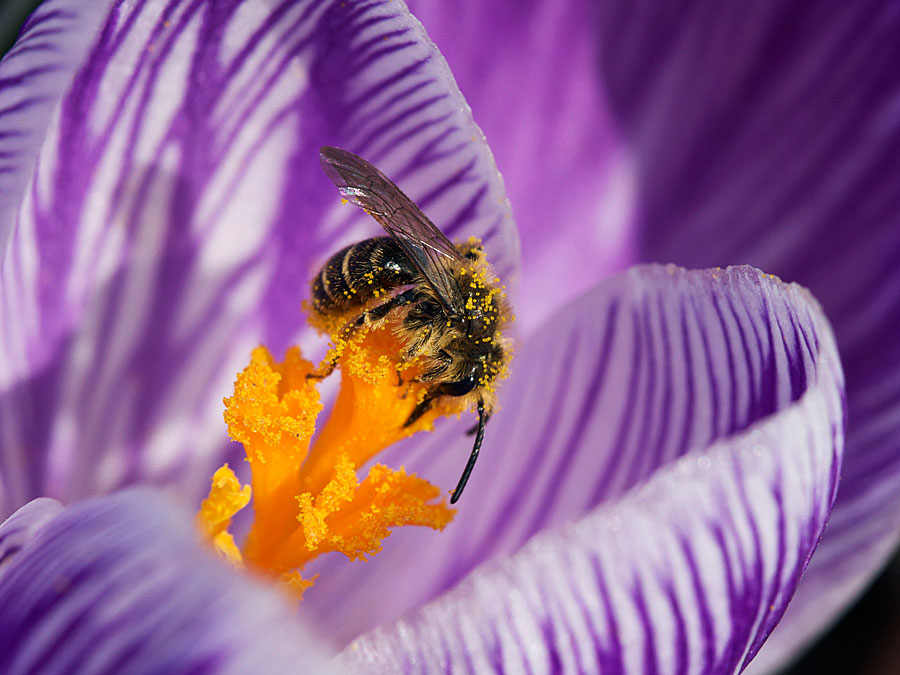

In [75]:
%%html
<img src=data:image/jpeg;base64,/9j/4QA6RXhpZgAASUkqAAgAAAABAJiCAgAWAAAAGgAAAAAAAABjb3B5cmlnaHQgSmFycm9kIEVyYmUAAAD/7AARRHVja3kAAQAEAAAAPAAA/+EEFWh0dHA6Ly9ucy5hZG9iZS5jb20veGFwLzEuMC8APD94cGFja2V0IGJlZ2luPSLvu78iIGlkPSJXNU0wTXBDZWhpSHpyZVN6TlRjemtjOWQiPz4gPHg6eG1wbWV0YSB4bWxuczp4PSJhZG9iZTpuczptZXRhLyIgeDp4bXB0az0iQWRvYmUgWE1QIENvcmUgNS4wLWMwNjEgNjQuMTQwOTQ5LCAyMDEwLzEyLzA3LTEwOjU3OjAxICAgICAgICAiPiA8cmRmOlJERiB4bWxuczpyZGY9Imh0dHA6Ly93d3cudzMub3JnLzE5OTkvMDIvMjItcmRmLXN5bnRheC1ucyMiPiA8cmRmOkRlc2NyaXB0aW9uIHJkZjphYm91dD0iIiB4bWxuczp4bXBSaWdodHM9Imh0dHA6Ly9ucy5hZG9iZS5jb20veGFwLzEuMC9yaWdodHMvIiB4bWxuczp4bXBNTT0iaHR0cDovL25zLmFkb2JlLmNvbS94YXAvMS4wL21tLyIgeG1sbnM6c3RSZWY9Imh0dHA6Ly9ucy5hZG9iZS5jb20veGFwLzEuMC9zVHlwZS9SZXNvdXJjZVJlZiMiIHhtbG5zOnhtcD0iaHR0cDovL25zLmFkb2JlLmNvbS94YXAvMS4wLyIgeG1sbnM6ZGM9Imh0dHA6Ly9wdXJsLm9yZy9kYy9lbGVtZW50cy8xLjEvIiB4bXBSaWdodHM6TWFya2VkPSJGYWxzZSIgeG1wTU06RG9jdW1lbnRJRD0ieG1wLmRpZDpFODYzMzkzMDM2QkExMUU0OUFCNTg2REM5QzhFMTA4OSIgeG1wTU06SW5zdGFuY2VJRD0ieG1wLmlpZDpFODYzMzkyRjM2QkExMUU0OUFCNTg2REM5QzhFMTA4OSIgeG1wOkNyZWF0b3JUb29sPSJBZG9iZSBQaG90b3Nob3AgRWxlbWVudHMgNC4wLjEgTWFjaW50b3NoIj4gPHhtcE1NOkRlcml2ZWRGcm9tIHN0UmVmOmluc3RhbmNlSUQ9InV1aWQ6NzhBQ0FFNEEyQUM4MTFERDhCRUFERUU1NzZGNUE4QTEiIHN0UmVmOmRvY3VtZW50SUQ9InV1aWQ6NzhBQ0FFNDkyQUM4MTFERDhCRUFERUU1NzZGNUE4QTEiLz4gPGRjOnJpZ2h0cz4gPHJkZjpBbHQ+IDxyZGY6bGkgeG1sOmxhbmc9IngtZGVmYXVsdCI+Y29weXJpZ2h0IEphcnJvZCBFcmJlPC9yZGY6bGk+IDwvcmRmOkFsdD4gPC9kYzpyaWdodHM+IDwvcmRmOkRlc2NyaXB0aW9uPiA8L3JkZjpSREY+IDwveDp4bXBtZXRhPiA8P3hwYWNrZXQgZW5kPSJyIj8+/+0AYlBob3Rvc2hvcCAzLjAAOEJJTQQEAAAAAAApHAFaAAMbJUccAgAAAgACHAJ0ABVjb3B5cmlnaHQgSmFycm9kIEVyYmUAOEJJTQQlAAAAAAAQJGLgkagzFv5wmZ2M0KH7Uf/uAA5BZG9iZQBkwAAAAAH/2wCEAAYEBAQFBAYFBQYJBgUGCQsIBgYICwwKCgsKCgwQDAwMDAwMEAwODxAPDgwTExQUExMcGxsbHB8fHx8fHx8fHx8BBwcHDQwNGBAQGBoVERUaHx8fHx8fHx8fHx8fHx8fHx8fHx8fHx8fHx8fHx8fHx8fHx8fHx8fHx8fHx8fHx8fH//AABEIAqMDhAMBEQACEQEDEQH/xACrAAACAwEBAQEAAAAAAAAAAAAEBQIDBgcBAAgBAAIDAQEBAAAAAAAAAAAAAAECAAMEBQYHEAABAwMDAgQDBwIFBAIBAgcBAAIDESEEMRIFQQZRYSITcYGRobHBMiMUB9FC8OFSMxXxYnIkgjQWkiU1ouJDYxcIEQACAgEEAQIDBwMDBQEBAAAAARECAyExEgRBUQVhIhPwcYGRoTIGscFC0SMU4fFSYjMVcv/aAAwDAQACEQMRAD8A4Riw2Fk6KUhrCygqdFAkpHAaIEAMmalUjILmsny52wQAukdoArcOG2S0IB0ftT+OvbibPmij3XoV2cda4lCNGOsHRuM4jDwowGsAp1oFXfI2MMBkQMaBUDyVUNhgg7JjItdFVJBAztOg0UgMHwdUV+ijBBJrG1uEJDBcxtOiVjAfL5YhhIa4CmleqalZLMdZZzXnM+bNzzDCPejcNraVABOv0XRwY9JZsShHUv4/7PxeP4szOA/fPbV8jhcA9As3by6x4Md7TaSzlsz9jA+Yj9MVa13wVGOvJjVrLOWZk0vMciWxirZHUFb2XUquNTXMI6z2Z2vHi40baXFC4lcrsZm2YMlzaftmtZ6egWSSkzXdHLx8djPc8gClBVaMWPkzRixs4H3DyLuT5B3sguqTTzXXpXijboka7sftQCE5GSwhw0qqM+WNDPa0jHubnYcDHMLXXoQ0BV4qSy3HXyzmc0k+bknbVznnr0C3pIubg0WLwLcXBMswFXCtwq3klwipWbZk+RiaZixhtusAmY9kFYkQDADqQjVESJTSMjFWuvoEGwst43jJeSnZG1pNSKlRuFIL2SR2jtTsfEwcSORzB7lLrl5+w3ojBfJJrmQNYzbSgFgFibKpB54DI2nRQKYjzoPZaSelSrKjGM5/l2Y7XUdSnRasdC+lDmfM8xNlyuY0kt+9akoLYjY84jgsjOmBcCWptEJax0LjO3MbCiDnAVAus9sslcgHPc5FiNMcR9VKBPSkltKGNEeTyeVUguJN1oSSGbg2fG8bicdjiaQUfRU3tOhXEmc7k7kMz/ZiPpvUBNSpZWsGchjjyJv1Tsb4+aq7Nr1r8qljJEm5LsV7jC6p0DvJW1mNQOB3w+FlciBJkZBjgb5p3aBG/QdB/a3HN9yR5nmYae2TWtErtZ7EhsIx+8eVyB7OJh0abMePBH6K8gsqoa8Zw/dU7hkTyezG/SOpJCFsmNCPIjY8Rw/sgPe57nj8xc4mtdRtNlh7HHIuNknX0K/qPdGnx4Y6FldrXAevwt4UVFiltijuLiH5mJM5grk4grvGj260VvXzcLQ9masGXi/gzn8Tt0l+uq7DOnA2xqbBS/iq2Ky2Sw+CiCBZNNpTosQpyG3qmGSA3sFUQM+iF0QBbNKJZIReB1CIQGYC46dESArjQkIkKXUpYoEK3sNPMoCsoc2/3ICnjWVqoQvhj9QRGQ0xYb6UQINoGUGiUJaQAPuUICZGiJBTkG9K/NEgLIAQgxWDyNHhqqmV2BpGiqRlTKnABViFT6UUB5BZCEGBlKACyL/qiMi40pZQhRIoyFLiFAEa3CBCLyPkgQodQnxUAWRsuFAhLWqAPjooEhQVUIWNBQIT6KBImn1UAeAKALmAAVUZEzyQ2+5QLBpSiiAj3KEKHuCBClxQAyNKlABbGy6ZIMBDG0TIJKiJD4BQhIM6UUITazrREh86gUIipzgFCFTrnVAhKKMkhFEDI4v+oVqCWbR4FMKX48QAXnTjF5fQeCDIDTzapSCyZ75H+23UqzDhtktCCq8nCN12TwWPh0zcoDdYiuq7tMKx1hbmmmKDbzd1YUEZeSPSND9iT6TLViM5nd/zzuLMcOLa0qNE9cCLFRIu43m8+Uh0lQCU7xoVpDuLljYFUvGLxGGJmCV16+XzVdqwKxxjs3AHyVLYjC2Y416JGwok5gYC7oEBkzF948o2LGkLCBIRSh8D4LTiozViqzL9rzuObE4PLrgEkChr8V1qqKmuIR3Rr/2/HRueQwOGo+C4WTWxzd2cs797lkm//b8cj2zU1Aut/WweWa8dOKJ/x725JNK3JlHpaQRVHs5uKgqzXOy4bI4IgGa0oPkuNZyzG9yb5gyJ73H0tBUSCkcP/lDuKbLzf2sbqRg02hdXrY4UnRrWKoV9odvnJyWSyNBaNa/ar810kV5HKg6NzHIYnF8b6aNLW6BYa1drC46yzj/MchJyeU7Z6quNKLpUrCNa0Rou1e15SRNI2o1IVWTKloZ7XlwW925PtNEEfUUp4I4a+S3Gjn+Qx/v7jr1TtDMviLyLm1OiZBRL2nTTNa25JugKzqXYfBMiY2VzRXUW6rH2chly3On4ppG0UAA6Ll23MzLXmop1SgKpHsY34Ihgx/ePMY+PivIdtcAVoxY2y7HSThvNczk5kz2tJLampXQrU0os4LhJMqZpeDSqLcCWZ0rieIgxYm0aNwCy3ySUtlfO8izFx3CtLKY6yPSpzeYy5+aSLglbVoXNwa7ieLhw4BK8epU2vLKnqIu6OacaxROt1onqiyqMe17i4uca/FOhi0ODhQWUIEY+PGTulNGi6jJATNykoi/bYlmm1lIkC0GnbnaOTyEzZcgUYbklC11Uqtf0OpcPxXG8fGGBoO2nqNOiy3yOxS1I4byuJG60jQ3q2oCp4Ng4M+dzmGHDZK07tY62NNUViYfpsrHccL3h0Tg0G1Aa6I/QZPpscQSSzx+5G5sjGV3srb6rNesCMx3N9u5+BMc4wU47IcXRStNQ2p/K8D8t9F1ev2K3SU/MdLBnVtP8kQgsP6K5l5OWv9KqIgDODT706LELJ2kE166JhgV4p0QAzyNlCiAKZ+XzSkK5a0oUwQKalKpkEEeDp8lCFRFEBYPH6IMBTsqfxUASbGNSoAKxoqm6AYGuNHQi11GMMI2W+KUh8+wUCA5TqiniigCucFEAO4HxQZGUPvdVsqsUSCyRlTBn2BVQjKJDanioAEeT9UAMgKV8lIIi1gt94RCScevVQhS41qgApc66ASJKhCDifkoA8ayuqJAiNiAC2lvuUCQdWqBD4NugQsYLKBSPnVAUIQNPFQB60KELRp5oERXI6yJIBZSKFFEgEkca6+ajIDucUrYGQQATaKooKCGMsmQSwKEPQLokLGM8VCF7WCmihD5woESA0jkSA8hNUCH0bTVEgZDGK6XRQAiwCsRJKt531UkIfQNHyXnzilM0tAlZBdkz0BFUEm3CIwngsWN8pypzSGG5r/cV6Hr4Vip8TfixQviN38zm5EgjgBoLMYL2Vk6luiGvH9p8vn0fkbgw9FHdIR5fQ2XF9hYsMY9weoLPbP6FXMZDtjEYKNFKJfrMise/8BCNFPqsaWFY3GNioQq7ZBWxpA0ttrRVsXyGxmwSMaAPlstsMJrYdSmpWR6VlnJO7OTGRnewDUakLqYccHRpXQdfx7hY+TlxscKbTUilrK7sW41Gz2ikG/705uHj8F0bX+st2sHguXgxuzMmGhy7isCfkeQEzgZATddO1lRaF+RwjufA8Zj4fHxMYyjiB8alcTNd2Zzm5GUsEjW6/wDRUICM53PzUeFhuaSBUU1WnBjlmnBSXJxzIw5eY5YyRGrd1XeC2Zc9cS1Nlk3sdD7f45uJhgOG1zW1KzvLz1MdquTJd+Zpkd7Ub6g9BdbcFDVjroKez+3pszLDnN9IKty34ory3jQ6zBx7cPELQKbW+F1zHaWZq21OZ950ZlAggktq4eC6eLY249jFyeqSp0GiYJZHc0FUAms7X4ETvZIRUk6JMt+JVktCOvcBxohiaNulFyc15Zisx4GNbp81nKyMjuihEI+b5MYsTnE0PRXYscl2Oks4p3lz82ZkPYHVaLLp48fFG5KEJuJ4ibKlBLSWm6ZtIptY6HwnCNx2NJbRZcmSSizkY8hlMxoSaitFVVSSlTBcrlZHIz+2ypadVrpWC9aDLhOAbCPckFDqlvcVsj3FyP7eJ0bFMdZGqjn+bI6R5cT6j4rRBYQixy5tVEhSbmtYPxUIVAuleGNNRVBBRpuD4vEhc2ael7iqFmJYe5vd2Nx0Xt4wq4jQKpY5AsZnn9289mz/AKJIBtQaK6uNIZwhrxfbPcnJyCSSZ7A7rf8AFR5K13EtkSNdx38fFrf/AGsmV9DUNDtCqbdpeCt5WzU8Xw2FgtDI2htBVziA6pWa+V2K3ZvcdY5bEa01sQyn+CqLaiBGM+N+9skTZIpmkSxOFWuabXCRqNURmX5jt9/Gk5MBDuPc7a1tQXxk6NcNSPNdLB2FfR/uOh1+xz0f7hXIRQrUjUCTUDSmRYhbNWvn+KZDgzm+KIpFrRu0UYAgW+HRAhRNUg+CKCByXTIINJZFhKiL/VABB16IEZ4GfRAWCxranREgfjRX0SgGMLNCgEMa2yBIKJ3Ur+CIRdOakokA5BbwUADSDwUYGVOaq2iuwNLVVsoYI8gV/FVAYLKdbogB3aoCnrWVKAYLQ0AKQQi4ohB5CgKUk/5oBPCfooQ+F9dVCFsbeqIC9rNOiEBg+cKKAIIAPWtqoFFgFAgEg4VUA0eAKEJsaFICSdYXUCDyut8VAAcrrnwRICvNSg2ApJSyKz5oUIi6NtSmQxe2wRRCQF0SFrWV1UCEMZZRCkzS6ISiZ1KqEBJHChChCsDcUSBEMelfmiQLaQB+KKAVyyWI+ikhQPv9VVCDeWSgXBZxRfkzalKyC9xdLKGtoS40XQ9uxS3Z+C/rUly/BpOK4fP5KSLExWVjj9LpGj0k9Sule86+DXkuqnR+H7f4XhogcgsdPQFxPiqLXb2KIdhi/unjIqtjoaWAFEqxNjrGyv8A/MWH8ib6Ifpkou4Jpn7QDco/SI6wM4J5JACaqtoUMha4m6RgYdCw2SsEhXpbQu0GqQYyfdPIQRskeZQGMrY6rRhqzXhocnbkfvOSfkvF62oupiRrerOpdoNxsHAdl0DCW1JNlR2224KsrlwZruTm5uVzDG2paDQeafDj41HquKNl2FwRjhEj231J/BZe1l8GLLeTpML6sDdNKAeS5bRnRTnZhghc5/5QCjWsseqlnHO9+dOZO6Flx18118GOEdDHVVRT2djTwP8AcLfzXqVR2sVb7iPJD0HnM8sYIT6jWmmimDCtiVUuTExQZPI5wABIc7p4Loyqoutbijrnavb0WFhtfs9VFyuxmbZz8lpZZ3Dn/t8WQ2sKKvFWWPhqcX57PM8rya3OpXYqoRuqtBDGfceQ3Q2Ve7EHXGYBLhXUkUTxAWoR1XtPiWxxtdShKwdjIZMrN3BGxkQDR9Fz7GYnQgbnG5SAFXI8nFjBxedFZWjY9KScr7z7t96R0MT61rRdPBhg3Y6JGU4/h5+QyA5zS5pNyrr2hByWOgcP2+zFiBc31UssOTLJkdgvNzIsWM1NFXWskqjFctyc2ZIY2VLTaq10pBdEIK4njWsZveKk3UvbUVsYZmZHjwm9KBVpSRIwXO8j7zzQ2qtFVBajPvqTXoE5GfNyHD0iyEgIVe53kdSpEhgJijaz1aeaKDAQ7OyJAImk+CkAHHC9q5Gc4OlrsNyT4JbXSEteDoXCdrcbiMG6MF4NakLPfK3sZ7WNFA6KEUbRrVQ9RWi93J4scfreB5kocGyKrYrzO7+JxnBks7Wh35XVVlcDZYsLA5u+4JJo4cN3vmm1jY2ipJNTU/1VterpqH6Ubmq4nPyspkfuxGIvGlTuafFZ8tEtimygOzI4/b9vIrJiSWewEbj4U+BWeracrRhq2nK3MXyGO/GyJIHf2mrTe7TcFdnFdXqmdbFfkkxfNWlaq1FwFKLmqYJRS/ioA+ogBkhpfRQKKZiP80yQQZ31RCCyA1RAV7NSgQ82XUCeiPyQBBYyMVUgjGeNGA0JWKMImdevgkJJdSgUIgPJPndMgi2XqEQwDvF1AQVGOqgGVSxn69EjK7oClZRVMoYBNa/3KsRgkhr1UAV0ugQtYxCSEyBRQElMpUkIK83QIVk0RIRqoiE4wTRQgXGyyhC8MFECFUn3qMDZXS6BCxjbKBRI0oftQCVOF1AQetF7/NQkFgAQCQkNFCAkztfvRAByvUADOKVgZE6oAJNCKQUXsCeAlzVCFzGKBLmM8en3KALgKJkQg9wFqosgJK/WiBAU1JRIWRsUJISywRIfOeAoQofIoQo3HcoQaZEtAQuAcQWZEtj5pWyDvtHtiflZvefSPHZ/uSOtRdvBXhjSNWJutdN2dCdnw8bjDA4eHc4ChlA1NPEJ+LtuW1olrYCh7e57kJC/Jkc3dqOis5VqN9VeBri9lxR09x9SleYV3Y1x+2sJoHUhI8rFdmMsfh8aM+lvzVbyMDYzgxGNAoNFW7ChbIG9AlkJa2PaD4oSFAvIZDYYCSU1VLHqpOW9850boDGHeomgC6OJQdHGkkZ7gMQSzsboagkrYnCH2NhzubLjYceLEaFw9VPBZ6rk5F46lfanEOy8trnCor4V6ps1+KK814R2PjMSKCJkYs21ei4t7yzC3Iy27XClh4KtAM73hyEcOE9rXUJFNbrV1qSzTgp5OVxce/JyDIRZxrXwXSyX4o0WtBpmHHw8Og9O0VHisamzKqqWZHOyZc/M2tNWk0W3HWEaVojf9l9tQs2zSM9QvU9Vk7WbwjLmudAbFE2CmlNFzWzIYHviZrIHgWHkt3WRrwo43ybg4kdV0WamwfCjIo8oIRM1Hb4M+Q1pHUKXcIl76HZO38PZjMPgLLkZramC71HjWFtK6eCzMrYHyGV7MLjWlOqatZGrWTkvendEvuuhiddxoaH711MGJeTdSkGS47i5+Qyx1qfUVqs0kPayR1ftntePGha9zb01IXKzZpMd8khXMSMxojSlhUBV0UsCRznmeRlyZzGw+mvyW7FSC9KCzjeMa1ofIFL39BWwnK5GDGYRUWSJNk4mS5vmzIXMY6tVdWhalBn3bnkl1/EqwJU9ga1EgLs/UulSAXNFD5+KYJZteRQV0UAPeB4P3XtfINKJXaBLM6Lx37fFgDbADqst9WVQU8j3ZhYQIDgXdEa4mwrGZXkO+87Jf7eLUB35VcsSSLVRIqZh9x8k9u+Z213TTVV9fsVvOkQNb5R3jfxzPM0SSzEnrW6tfZqil5DVcL2tx/GsaQP1xSj7VqVRkzuxU7NmrxJomAVdUtvQHqsrUlbQdK8TYxkgDXOJo5jjQV0VfGHqBaMzXOYcuRGMiNoMkAIlaDU7dQbgaLZ1Mqq+L8m/q5EnD8mZmuF0kdADfrWouiNBQ4XUFPQ0fXogQ9OllAg8hOpTIiB3lEklDxVQh5sKKImeCMlAkkwwWqoRFkbBXS6ARhjtIHX4JRRhGKCnVKwHrza3wQCAZB9VuuqYKQBIKnxJRDBQWnzUAyQjsoKVStISMrsL8hpVbKGK8itSqmICP1+9Qh4xtfIKARcxtAgA+cSoEGlPyQZGCyFQhW5Qh8ASaokCI4/qgANjZT+qhCbggQofclRkRADysgQtaEBjx6hCsqAZ6G/9FCQWVIF0AlEjtfBGAAMz/p4qEBJHXKACooCnwChCxgTIYvY3yRIXsaiwhEbEAMva0deqZIMEXmlfvRFYLK+igwO51a/agA+Yw1RIWsZa/RQh851P8kUEqe9QBVr+ChDzrTyQIX5M2t/iuCcQr43Ak5LObFf2WndM8eHgPMq/rYuVp8IiUuEdT4/iXxY8fvH9phtHohFiQBq5dWTbX/1G+JyvB4gpGG7hatqotNh+m/J5ld4QNqIW6eCCxNjrGLh3VkySWaadFYsIzxodYXNSPA3BLbEitoe4uWHgGvyVDpAsDOOQUCqaAkEMfX4JQwezTBjNxKiQUjKc7y7WsdU+f+a14sZqxYzl/N5f77KAFaNJNSt1aGlrwNOCgbjNErvzU1V1loWcQur+TzGtaK0s0eSSOKFtojpfa3CNxYQQ31FczsZZ0MOW8mvxoyKE3posTZQeZ2S2OMuJpRGqkeqk5tzsmRyOZsa6jAaVJ810KWWNHRpTQvxePGPGd4vSxVdsvMpvuZ/uPkQxpY030/wFow0Hx1K+zuMdl5bHvG4Vsrct+KBkvGh2jjOPbBA1oFLVIXGyXlmC9pCMhlGnokQqZzXvxwMb21qR0XT6qN+E5VkQGScgXut8F9g2LApGKaoQCDU9q8eGva8t1N1RmZTkOq8XK1jA3yC5OTcx2DpMtjW1JoKKtVFiTEd5dwxw4z6OoRotmDEa8eODkT5JuSzibkvNl0UoNDcI6x2R2vFDCxz2g1AJJH9Vg7OcxZbyzbT+1j49uguFhWrKlqznvcuaZ5THGakk1XQw44NdKCbF4ShMrxpclWXvAGV8nmx4rCK3AokSkiMNyfIy5Epa12p1WmlYLEUw8a+QbnJiEMnGEPT5IoKAJW2PTwQJID6jJ80qAXtF/uTEGXHs3Sitx5qQBmmj5GHEhBBAIFknEnETch3NlSuLInW8QUVRBiCrB4vM5J4dM4kHqUz0A9DXcZ29xmFtkmpUXoSFW8jexXLY0PcHC4bTtLWkdAq/ptg4MX5H8ktiIbjNLhW3go+sOsa8lY725zkHCPFhJeetOqsrgqtyNVQx4jje83uc6bJ9kPN6CpQtfGhLZK+h0PicSaPGb7kxfIygdIf7j5hYcl02Z2y3LjaC6b2y5z6b2ClTQUqK2VRFYy/N8O2HEOdie4cYPMcwcABG83aA7qF0ut2HZ8bbnT6/YdnxtuZ1wqtpsI7dSUGA86oEPHV/qoQHkr/VMiQUSdEQsrIJ/ooLJ6I6hQh62P5KBSJBgUkJYyO9KapSMNhaQKVQFDGf9EpD55oDRREAZ6a9ToiOgKQV+VkxCsMQFaLms8enVRgKZo7aUVbK7CzLbY06pGU2E2T+ZVMqAzqoQmwf1QAWigUIVyGxooQGkKDADPNFAlYrqoQtY2tFCBcLESIMY2jfNKSSMnXooAHd4KBPGoETLRSnkoGSLtNUCIrIUIej6KEPnGyhJBpnGhp16KCgMrtSECArzUoAZ4oAkAmgYujbW6JAiNqhApjB9NFCSXsZQU6oojPXUGqZBKJXmnwUAByG6hDxoJKhC5jPJQhJwAChChxr80SFZFbqEIOt0UZCvddKCQnD4/L5TMGLjNq7V7ugC4+DA8j+BxkpcI3/ABEHG8FE2BsYnzNTQVFfErsUoqqEbMeKEFz4/NcxKPcrHD0aOqasIs5quiGWF2W0NBeTXwUeQR3bGEXaGMKWqfkl+sTkwmPtjGabNQeZh5MvbwbY6FoU+qSQyDFdFpaiW1pAMIqixVTIEMkSwFAvJz7YSK0tb4pqosojmPcfKEzPbu6nT7l0cS0k3Y6mcj3PkL6alaKIsTG0U8hjEdLkUATsZuDcdl8BucJHi/jTRYezmjQx5b+DpMMAha1o06rlWcmNh8dRGTTRIwGQ7t5l2PG5rddAtnWxyzXhqY/iMmZ0znSDcHGq1djEmjU7whxyecBFc0IF7rPixwUrVmCm93PzqNvU0+S6FVCLZg6d2Twf7WNjnN81zuzlMOZm/iIDfAhc9meQLlcv2IHOFK9E9KyyzHWWcZ7z5wvnc0mpJ8V2cGOEdDGoRlsY75QTelyr2OMA86U+HwRQWzZdsY52tOtKU+ax57GXKzdQDbHUnpqsFjNuJe4Ocbjwuo6lB4qzFjkux4zk/L8plclkllSWk0AuulTGqo1bGl7Q7TkMrJnsqTe6pzZUlBmyXOtYWM3GxmilKD4aLk2cszbszvcvMOjBjjNzai04MXkvxVEHF4D8iQyvbUk1qtN7RoWuxPmsiPEgcG0BAVdati1UnNOWzZ8qUsZf4LXWkFux7xnByuO57bk6IWuI7DqTAZDHQNpa/gq1YCZmeWo0kGyuqywR5DqtoESMjBDepUIi326n4KEZbHIY9PkiSD6WaaU0qaeA6qB8hfHcYN/uSaa3QYsjeXnIMGPZEAH06JYkCqhNJy/J5r9sdaHwTKsBmAzD7T5fLcC+pDjcmqLskI8hs+D/AI6xWEPyRuNiQVnv2I2KbZGza4HCcfhge1E1p/1AXWa+WzK2xpHFF01VLbAW72RilaDrVDcgHnci1m31tDq2J62orKUkatD3FjxsmJ4yWikrNsorq0mo231S2bTleCS6vQxGdiPxMl+O8EUJ9sn+5nRy7OO6vVNHbx5FasoHAO34JmhistsT9UGArcaVKgwPI4g0P+CmIVE1KIDwDooAuZGpJCwMtRKST4x3rWqkkJsZfRAhewdUCBDKjp8FAEZHFQKApqk0CZIaChw69PBEh4xhKUDL2ssgKUztt4BIxLCfNsDT5JGUWEeT+Y11VTKmC/4ooAsYOqBCZqFAIplqoggsh8UAA7kQkmj7UCBEUdKIkDoY7WCAGW7TSiDBqVSE/VBDA7gT8FCEmNQCWXpdQDIO08FAkPGqgT3pWigCt5tdQDA53FCSAUpQkBSVAHoBRQSxja9EwQljKhQgTFHogALZGQEUQkRQfdRFEZRK6lUwGwSR5UCV0qdFCFsTOtPmgyF1KDRQCKJHIkKK3siQ9PmoEqkdZQhT5pRTpvbHAzYfHCCFu3Imo/KnOtT/AGj4IYsfCqRgw04qXubLie2cKJzXvZvkNy4qWsx3ruaBmFE38rQAPJUuxCDo6FSQosq0daIEZW6aJty4W6qJESIHOhAsdEeIYPRmRnzR4kgtjnrT7FIJBP3QLnQapYCkIud5BuxwDqK7FXUvx0OZco8z5riCSAaAroVRt8FmPivoDYdKK1MdGp7W4R2XPUg0abFVZsnFFWa0HU+M444kTQBfquNkvLMF3I1iJcQFSytl+VOyHHJPQIVUslVLOV915rcjLEbDq7RdjrUhHRooRHFa2CIucKWUyOWC2om5PlDK4xAklPjp5HpVIbdpcIJp2yOHWuiTPkhFOWyOrcdgtiha1oobLj3tLMFrDFkVAfhqqxUZzumXZjPv0qAtWBamnCtThfOOdLnP8akLtV2N7I4kW1qIUHwtBka7oFAs2vbuVA0NA69FjzVMeSrH/JcqIMYkGlrLNXHLFpQ5d3Bzc2VkPYHejRdDHjSRsrWAvtDgDl5TXubuFdfmhmycUU5bwdk4riYsWBrqXA1XHy5HZmGzbZRy/Itx2EA3NgFMVJLMdDKDGfyGTVwtVbZ4o0aJDeeKLBxLChA+CoTbYqRzbuTkpMvIMUZJFV0cVIRorWBj2l2myV3vTCrhcAqnPlhQijJYf8jxMMTqtYAaUcQFlWQqVjK8yRE018FfRltUc+5XJ3yOC0JFiQAxhcbpiBG0Ut8kYIRoAFGMiI9TvLwQIw/FijaQ51yiAsyc8tHtxa6WQIecdws+dNVwJrqEW4EtY3nB9owQBr3tuKaqi+XwVOxrcbDjiaA1oAHgsztJVZhsYDRZVsUs9wU1QAA8jy7MRm4uFR5hPXHyLKUlmZyf5IjfI6BkTnO0aW9StFOp8S76SQRw+Nm8i9s2aJRfewbqNT5GqrQS1o2Nvg48Qa0OBroDpT40WC7KGwXubjXZmAWsYDkY1ZYzS5b/AHAU8U/Vy8L67Mv6uThbXZmGDBSo63XZZ2Ct41QADyUpXwUCgSR1SbpiFTTU/eoAujbX8UGQKjYSP6aINgLRFStEJIfFnyQCSay/moRl7I+v0UASIooAplpRQZAslK/emHKttaU1UITZGD5pQF200qgxWDZDbH4JGJYS541sksUWEWQKuPmq2UsHAugAmAoA9cSgEHkcP8kQAzzU0QIitoJdb5IhZcyOtPvUIgyGIdQoBhjIwG3SsB88W+GihAaSlSoGSotvpqgEk0KBbJV/yUIRNKqEPAClkhF2hUIDyOUABzOr1UICPJUARopACTWk/FMMi+OOwChAuKOtwgQMijRJBcGhFAK5SKWRQASZygQalSiQm1lUGQuAACAGQe9QBQ81OtUwxEDxRIfONlCA71CEKKAP0fg8dFHE1rRQBJa5kGkbGMbSwqqmwQRlzIImkuIQ4kgQcj3LiwVo4V81ZXHI6qIJe8S95bGa+PVWrCPwIDmsqc2rfUBOsaQeKQbiuyXmpBNUWkgDjHgmIBIVLshbMZQxu6qtsUG5PNbFGRWlAhVSyylTBc/zDy8sBq3x+K246QbKVhGdx3+5NU3utFS2ZH2EwveGNbUnon8Fmx1bsnimx47HuGoXK7eQ5ua+psfaaSB0C58mZhEWO3UdUANiLu2ZuPjOo7QXKv69ZZdhrLOYcbA/P5F73XDTQeC61nxqbrOBzzeOMfEoNaWKzVcsrq5ZkOLwxk5x3eoVWxuEWvRHXe2uLbFCw0+C5Oe+phys1+PEA2lFiZlLMja2P8UEMjn/AHtnBsL2joDddDrVNeBHHJ3e7kucfG66yNrCWxbWt81AhMLAXCnzKZ7BaH3FvdEAarPkUlV6yQ5/ln+yWVv4/JLSmpK1gy+Bhy5mToXElX2tAb2g692fw37aJjttKCq5XYySYMlpZq8vIbFDTrRZK1liVUmI5WSXIyQ2+q340kjTVaDXjIIseLcbmmvmqcjkR7iDuzlQInNY6+lFf18ZfjRl+G4t+VkCR4ruK1ZLQh8ltDpfD8cyGANpcLkZsksxtnnK4f6ZIF1XTIFI5Z3e/wBvcF08RdRHOck75TVaSyCUQIHgoiQXJgwVuNTQG6BD5tqE/VREJh8jztFUADriOBknkBeKhBuBGzd8Rw8eO1trqi95KrMfsG0DyVAhe2UUrXRKwQU5HIwwtJc8CyKpIVWTG8/3yMdzmQGpFgtGPCXVojKTczynKSUc4hpNKLVWqSHUI1XbXb0bdr5QCSqsmWNiq9jo2CyKOFrQaDQLn3bbM9txpA1ooOvStxRVMVlsjDua5vqY2psbAnWvikZDAc7gDD5GSNoAjl/UjA0AJuPkV2etk50XqjsdfJzp8UKZLDyWgvBJQbqEA5Aa+CIDxjSSOqMkC4oydUrYA6OKgp9qUJZs8lCHxZT+qhDwMuoQuYLKBg8cFCQDyEVIRICv/MPDoiMeMbVBhLmMtpZAQu9s7aFBkbBspgofNJJXYRZ7CCfsSsosIMoeoqplTBqdUCExZQEFchIFUASDvdVRkKDc0RCTjYFCBUMen3qAegdHFohIC6lB+CASqQi/VQDBn0qUCIjS5qoMe0UCeH7lCEbqEPiUoSp79fNQUFlfSoURAOR1anooApN1IIehqKCWsZXpqpBAmONEgXHH80CBLG2RIekgIoANK8X6XTEBH1KATxraqALmtoL6IMh48iiBCh7qlMQhX6IkPKokK3nwQIVE1uoQ8oiQ7zJ3bxuNH/uAuHgUXibMyxsWZX8hYwaQxwJU+iMsQgy+7svMfsiOvmrFjSH4pEY+MysqjpHm+oTbCOw543tiOgLhr1VdskCuzNJh8FjR09PyVLyMVsaxYDG2DQB4qt2AFxY7QNEjsAnIxrW3tWyVsaqlmE7mzwJ5GNJ2NNK+K2dajalm7HQwufI6SQ9T5rbBoexbgY5pUJ6olEavtnj35GW0AVAKXLaEJmvCOycRift8ZoI1AXDy2lnNu5YwHiFQIRmzvYaT4BNWshrWTnfeXOzT1x2G7tV1OthS1Ojixxqedr4Bhg3uFzclTsW8CZLSwXu7Mqz22nyU69dRsSBO0OPkfkNfQ0JVue8IXLY69xeIY42+S4uS0mCzkbRtAVTKwbkJD7bvGiaqLEjknfuY8BzW9dKLrdapvw1MBgsBmJdc6rcXrca5jKwgi1EEMV4xoauTBD5MlrIQRaiR1A6ix8U+dOGjQlTYrbg3fa3a7WbXPbexWHPmMuS5v8eBmNCBoQLrnNyzMKeUzanY01PktGOpfSsC6HHq73HBWWfgdsD5blm40Tr6fajSjbGpWTIRiblMyrqlldPityiqLm4R0DgOCZFG0lo0XOzZZMeS5oWwhg0ssdtSpME5ENMRB8ElKuS6px/vxo9dPErsYEX1WhzZw/UNVoLGXCgCgIPS6iYJ5WpUkDLGY8klgNUGBsccXxBLqvHW6VsVs23F4scW0UVN2Vj2JzW/CioZW0fT50EbPU4WUSbDxYg5XuzHgaQ1w+qtriHWMxHKdyZuZIWxE0OivVUh9Ee8R2vn8jKJJwdpUdkhLXN9xfZWNBG2ov4qh52JzY/wuHxcfQ6eKqtkbK3Zhv7zGxxQuFknFsHFsMwuSimcAwh3UFLbHALVaGp2+zU12+DdVSxEI+6sAZXFPyYm1lxz7m6l9mjh8Fo6mTjePDNfUycbx4ZhHXFV12dYFlrqoAEe0ogJwRurX6INkGEEZSkDGMFLBABIsQkJDb/1RIfbbqELB+VEJ4/VQgJNqoQGcL1RkKJRt/wEAsJhjPX5KChGyoSsANkx+kpBbIQcgw1NdEYKbIz2a2hNFU0UsC6pBT6oAUIVSFCCA7zWqgCAbUohCI2XCJA6CIUSgYaxlkJAevt5KEBpSoRg7vHxUJJ4GoDHxooQg7wUCQNlAnjnWQZCiR2pQEApn1NSgQHc6v4piHgbVEJc1igC+NnldEIVFHQgJSBMbaBEhMmx+9EhTI/oEQMFkfenmoQrpe/TqoEsaKIAJOIAQAUSH70QlRNUSHhRIQe42UIVFxJUIeUURD2hqiEcw42bPf1GvjVbIkVsYwdu501Ghpr9yragrd4HnE9n5Mbg5zT5lLzSEd5Ndh8Q9gA2n40VNsiFdhxjYvtiipbkUYQsFK0ukZC8a3SsBcyny8krJAFy2Q2NmugT0RZRHL+ZyHSZr+gGq6uGsVOnjUISSRF8tW+N6KxIjHGFiANa02TliR0fsXi2B4cRUnUrB27mHsWOkPiayMUGg0XJkxg5ftaUIIIedz/bhfpYaFacVNTRiqYHHY7O5KtKtB1811J41NlrQjbsxRjYdbAAXouda0syzJz/AJaR2RnbQbVW/GoRprojb9m8a0NYS3wWPs3Meax0WCEBgAXMbMrZftoPNKBCrkn7Y3fAq2iLKI5H3s6Pc6mpquv19jpYtjDxudHLVtj4rWWDISGQ3Jp5KDIrc4h9BYdApIYIOmkeQ066AdFGxXY1fa3FiV7Xlt6ilVlz5IM+Sx0vDgjhiFBTxXLvaTHbUq5DkGhhY03KNKDUoKYonTy7ibVV7cFjYRmbYIDe9FWtWCqlmB5V02Zk+2wmhNF0aVVUbKqEaTtrt8Ma1zm3sarNmzGbLkNxjRNijDfBc+zlmRslNQDzoggIScrktZG6p8lox1NGNHJu8p2yBwXTw1NlKnPZ46ONFa0RnjXOJp0SsB7tJ0QIThYdwBujAGPOOjYddeiDBBosNjALDRVWEYxbOyMCpv4pYFgGzO42QsPq0RWMbgZPlO58iZ5EZN9FbWgYgDxOLz+Qk3SVvZGzgDsbHgezY4iHzCpHiqL5fQqtY2WNDi4sYa0BoAVDciA+d3DiY0bquFk1cTYyozMZHdvIZT3R4bCQbBw0WiuFLcsSSGvD8HymaRJmykA32oXy1rsV2vBscDjIcUN22cNVivkbKXZscQ1MZGlOipYrKSSZS135CNrh0IOqDCc65bCdg8hNiuNQx1WHxabhdvDk51VjtYsnOqYvkFvNWFhRsqVGAIhi9SUgdEyn3oNkCGioQIfFt7KIhHbZEJ80KEgmK/BQJXIKokA5epIUJBTW/n4KALI21IHyUCHQsqUGyBPttpXwSyBgmSz0+KAGhDnx2IRKrIzmcyhcKaKuxnshU6xoqxSLiNECQUvKgpT1soEsjbVQgVDHoiQPibp8EoAkAAX1UAVSUFUAg0l/P4qEKTpp8lCHqASJ6okK3VRCiNf6oBK3uKQDBJXlQAJIa6oAKv8AomCXMaiAvjZX4ohCo2Gn3oMgQxiiCy2wABUAVySWRICyPuiAr1UCetH0QYCRNAoQg5wpZQhWRVEhEtv+CISD6KAB3uKBCI1UIWsZUVRCXeydtUQQdq4btKCFjS5tTQJ8mfwjJaw/h4fHYQAwW0Wd5GxQ9uJCwXAr0VXIANMWNNqa3RQxSciNpqSExCTc6MCxrXopxDBY3K3G3XQoQSAhkxDS7o3VK0RIy3cHLhjX+rUFaseI24sZg8mYuc55FSTc/FbUaizjmB0nqHxqrakqPYogZQAKhBjvY6b2fCY4m281y+05ZzMzk2Dg57VzzPIuzpPZjJOiaikaqkwncWeXvMYN3aBdHBjN2OoR2rxYHrcLm9Uc9xMrHHcGSyHEcweCy41LFotTnOO73+Rrreq6OyNF9EdX7Yi2xNNOi5Od6nPyPU1sbhtH2rGyhkjIDVQKQi56Usgd0FFfiWpbjRxfurL35Tmi912sKhHRrsIGxhzriyuQyYVAyn5tPqoMTkpW6gyCOOwffmBp1+1Je0IryM6R29x7YWNK5ma8sx3Y3y8zZGfsVFayIqiYPkmkv8lpiCx6DOPbBFvNrKq2orUma5zlnPdsY7U0otWHGaMdY1IcFxJklEjwTVHNkhAyZNDoOFiNjiApQrmWtJhtaS94DUgsAGdlMjBqdKq2tR61MN3DzBIeGutpRbsWM2Uoc35TIdPKb2BNl0KqEaEhFlQ3JHTVRi2QHShvr/gKsUsAqiRIsjZUgDVEA7wICL+H4pGwDZmQ2JoJNx0SQBIXclze2oaddEyqGBBLLk5brVIPQpoI2hzwnbb5ZA57agpbWgR2N3x/GY2HGCQKi6y3u2Vs8zOdxcYEVFlFjbIqGez+6ppgY4Lk6UV9caQ/GAfA4bkeTlD5idhOia11VC2sbviO3sbEjaCwbhqVlvlllbsPYXsiFBQAeCpeojR67koGg7nj6qcGwKsg7+4sVn6e8bvDqmWFjfTG8U0eRjxyMtID6xToqLVgrEXdXDR5mGc6Eu/fYxPvREDa6EaFpFyQtPUzcHxez/qbOrm4vi9mYqgcLfFdQ6R4GdfogwMJhYag/VAgS0UP4oELRSigTwm+ihNj4C+lVCEg26hGSpXX5KBKpBdEgDMLlQKBwKuPVGCBULa0KAGMIWUAP0SNkCNtvAoABchvp0RAIuQZrRErsjOZzRUj5pGU2Ek4o5V2RWUGwSClbiL0UIRa1QgREw2RCGwx/wDRBisNjaRr1GiACZNAoQGkNAgEodQn4qEghS+ihDwmg1QaCQc77UQlRPioQiT1UZCiR1kgASR11AFDuvmgQ8Yw1BTECI2JghUbAFCBDGC3+AgQtBoPkoGSLngIgB3vrqoAp1RCetBohICVALKEIvdogRFZubIoh6GohIvNkYIDyO8FAFVLlAhYyI/5KEC4YK/YmQQz9r6NOqIsn6IZHtIOg0WVsyHsmTBB6nkAoRIDP8v3ZjQ1YxwJ6q2mFssWMzb+5Z53UYTdaVhSG4BEORly0Nz5KOqRJGOPBkOIJrRVtoEobYuM+gB+SptYDDs9n7fj3ONtwtVCmtoHxKWc35qUSyOFagWt4rpUrB0eMIQz0Dmhp16JgsY8dDfdS5+9WBqaXh8MyyNHn+KTJaELktodP4HGEUTbWAXIzWk5uRmhjczZewWRlJne5cuNkJaCr8FZZfiqYPBb+85F5cKtbp1qV07PjU2WcI33G4ghxt1ALVXOyXlmJsyneOYdpaOtQtOCppxIT9s8U+ScSFtzequzXhEy2Os8RiGKFopRcfI5Zgsxy1ttFSIeS0aK9RqogmP7szgyB7d1DQrb166mrDU4ty8u/Le7rUrsU2N0FeOat/7h0ToKLSaGxpTVQKIRh8soYL1OqVsjNt25xh9LiPiVizXM2S5t42Nhi8FhepnAckmV1OitqoHWhZjYzWDc4aKWYGLuZzw1rms16KzFSS3HQTcbxkmXP7jwSK1qr734oe94N3xXGMgYDSi52TJJhvaWNS4NCoEF+XnNjBqdFbWpZWpkOd5trWuAPRbcWI1UoYPk+RdPUAm/1W6tINKUCLJFHVCtQwunINftSsVgTmkkpWhGj2wUghbA5u6/1UFY0izWsjslZIBMnknuq1pv5IpEgogxJ8uQVuD1R2A2azh+3m2c4XrdU2uVtyaSJkGLGaUFNSqXLF3EvMc+QCyM1PSiemMZU8iPG4/O5KTc8nadArm1UjZp+K7Xiho54+Kz5MkiyaPHGPitoAGgDVUtyJDZTn9y4uMw+oeSauJsNaGcye9JpSW44JJ0WhYF5H4pE+MweX5GUSTvc2MmtKlG1lUW14Ndx/beJE5sjgXvF6lZL52U2uaCCEMbVtgs7clYQwQihcLOFHedVXYhzvuLjDgcrNGG7YZCZIf/ABcuz1svOifk6/WycqfEWsbU1+auZeFRNpRAgQ1vVAhMghvmoQiRQn7EQo9ZUnyQCWtZat1AM9IN0CMolqiQAkN04yKgLoEC8cIAGEQO1IwMtNvxQADTn02N/AoojEmaLlFgZn8+MGpokZQ0IsphBqqmUsCdp/VAVoheqhCbG+CgUFxR6AhQDDoY7IACWt+iBCL7DyQACyV+qISi9FGQjZAJFxtqoQqe5EhUXH6oBIOegwA0j0CA7zqgAhtr8FCFrGXHimIERR6fYiEIY3yUBBcLCn3KBPnvtrdQhS9yhGUE/REh61psUGQkgAi42UIV/VEhJrfooQkRRqhCiUokB3m9tSoQ9Ywk6IkC4IeqhGMsbGsLDyCKFYb7I9unXwTgOjct37jRkthIJ0FLqmuFlSx+plc/ublM47YWuAPVX0xJFiSRRh8Rn5EgdMTUq3kkB2NVxvbrAGlzfqqb5Sp2NDi8ZEywb81nteRQ5uMwCtAq+RJL8THLpRQddUtmM2ed2M2YNK0NKAKzq62L+stTlOc71OC6zOkxV7YMoJNSOqUrY+wGMLQALmlk6Q9UbXt/B2hhLfCpWTNYzZWb3BjLWgdFzLmGz1DJnhkRI8FUlqKjD9z5m4FjTXot/XobsVSjtjj3CXeRUu18lZnvoJmsa/KlGPi00oND8FhqpZTVSc45md2Vme2BUVXUxqEbK6I1fa2A1rWupfxWLsXMmZm/xI7AeS51mZGFEBoCRAQr5TMbHG6hurKVLaVk5d3XyxcXtrWq6+DGdHFWDnWS57pi49SVtLWEY9P+qBEfSkg20RDsNOCw/dmaSK1uSqsjhAvbQ6XxGKyGEErnZHLMdtS3JyNx2ttTolrUEHsEe71UsEWyMF5XPbCwgJsdJHpWRFB7mdPQVIrqtTiqLm0kbPh+LbFELUXPy5JZhvdjd1GN8lnKhdn8kyFpFQD4qylJLa0MZzHP7iWtdc2AW/FiNVMZl8x2RkA2stVYRchRkQSNrUadVamNIulArbRMMhflM9R+1BkYG8EFARlZugKR3bfxUJB8ZHusCgRoOwMF0rgSLINis1/G8bEwNLhpqVVawjGkmdBjigI+RVaq2BITZ3LSzHYw1/qra0GSKMHiZMmQSSeKLtAGzWYeLjYkQNBUC6zWs2Vg2f3FjwVAcKjzRWOSKsma5DuyWX0w3Plorq44LFVAGPg8ryUw31DSdE7aQHaDd9v9owQsa6UXGqy5MxRa5rsfBihYA0ABZrXbK2y5ziLeCUBKLNY07C6viApxI6jDGgZLE95eGta0uaHdT4BV2cCyCc3xuLy/CPZKAzNxWl+NJShPUtd5KzBleO/wZbgyOl1GxzdjDpSh6/ELts7JfG01SkLwNaoEPTpY6KEIkXRGJxtpp9EABTYxRKQjILEUUIAz1unICOB+1FDEAypFlAMMx49PLqlYJGEbSBWqRkPXIAA5zf8AFMQVZjdfuUAI81lQUCqyEWYw/wBFU0VWQte2h0QKyIbVQEF8UeiBGGwx/wDRQAZEyn4pSFu0gIEKZTbwRACSU8EGMioi3ioQiSKqEIPNj8FCA73HVQJUXKAKZHeKBCl7lCFdKoAJtYjBC6OO6JAhjNBRQhaLBQJ8TRQKK3OqoAifvUYDwN8dT0UIe7bIEIm1lCESLfeoQ8DSaJiE6UQIQkcKeSMEBnnVQhAMqa0qoiBEURNESNjDHg0RA2MYmgU6eKZIUu3itOifwCTUcd2g3a10wq7qltlSKuZoMTt3Fjp6QqnlYsjKLjceM0DQD5Kq2QEB0UDGj0hI7SAva0CyWSFjQCUAjLjoAXg/OqSzAxP3o4mHYLUB+1a+mtTb1Vocrz4nAkD5rqm97Cog+5ZLAjQ84RrnTtr1KZ6IjcI6dwUP6bT0C52ZmTKzV4oG0fisNzGwPmM724y0fVNjrJbjqYjIc7KzQ0XuujVcam3ZGv4TA2Ma53RYs15ZivYp7jyA2J3jQqYa6j4kYXBaJ88k+NlvtojTd6HR+BxQxgd0oFy81jBkepqcaoFaLJYo8H2VkBrSUKoNUYvuTlAyN9Ct+DHJrxUObclI+aRzjeq61awjelCEWXBtcTRMFkMe5pWnkoBBjMYveB9FBoNTwGGI6HqOqzZWZ8jNT+52RUB+IWXiUwfQMdK6viahS2gGGzyNx4CK3oqkpYFqZLPklysjYy4JWyiSRpShGj7f4nY1pcLrNmyGbJkNbHGGMHRYWzMAchltjY69wnrWR61kwfPcs81Yw1PkuhhxmylBJh4c2TIHSfABaLWgduB4OKY2Gpt4eCo+oJyMxzkAY5wbbwK1Y9S6pm5WEOPQq4sSBXxWNRU9UYJABkR7dErQrQHrYCnigI0RIqadEAhOJjF7xXRQVs0uFC2Fu5VsWAmTkSPS1Kqg4g5dkZBpcp9gh2HxwbRz9fxSWuK2MzmY+LHQUqOoVUNixIi5fuU3ZG71HQDVOsYeKEUOPncjLV1dpOit0QWzW8N2nG0Ne9vhqqb5St2NVh4GNjNG1oHms7s2VtjGPOgjsXAJOMg4yeZHOYsTa7h9UVibIsYvd3BNkPEcLdeqdYY3CqJDXjMN9RJLXe64CS9/QS9jRQge1t8FmZUAZkhjJYTRjrfGqNVJbRGFmgMU8kf+lxouzRykzr0cpM9jZUotjFlOqACB8uiYJMNJA+9AaS2OPogwBLW20QYskZW6oIgHkMrbROggUjCDVEJKKO+nwKhA6CO1fBI2AKAACUE6lb1ERsDyCL306JgoWZN70ojBBVls1CURoSZcRJStFNkKpovVYJWipkGxlKwMKijoLoADImXCAApjQL/VAB6+wQCCTV+Z1RADPH0QGgqcoBED9igSp7h8FAoGe43KICl7r/igQpe4lQhWT/0QAetBUIXRs/zRIEMaoQuDRREh44miASBKhCJUgBJrTXxRCiVAFGEi5AUrOvmoRn1FEQkAiQ8cQK+AUIDyOqFCFDgT5KELoo6gfYiGQ7Hgr8kRZD2MpQAaaKQKW1oPtViQCG/1aokg7IGtAsshmJska0+KAS5kjSbUv1VVqhkvbI0AX+KKQGie6qEEJsJJFOqkEHfHtMYvqqrAMr3lONz66eK39RG/rrQ57nOBDiugbmL44Nz6U16oimj4XGaJm1AFFLPQS2x0bhg2jWhc3MYsg9Dw1hp0WRozqpleezzvIBvpqteGhtx1gr7fwN8hlcKkmybPeFAuW/g2sUDYoajwXPblmR6sxfdeSdj6dVv69TbiQo7bxw+bdTqrczhAys6jxOOGxii5GRnPvuNgKBUiijl8jZG691bjrqW0RzXuDL3vLQamtSuvgrB0sVTPOIcKLUaIAM1lAbIkegDA0+58NQoVyOMIUcKj4IDNmkwpo2RgCxCz2RS0HQyGUgAktJ0VbUCNQPsSNkcYNFls5KWK+Wyy8+20/RW4qFlKlnA8P7rxI8Vr4qZskC5ckG2xMARMFtNFzrWkxtyeZjxGzwopVSRIxfPcgQCxpudFuxUNeOpnocGTJfucLVWp2SLnaB3h8U2Jgt81nteSl2klmkNjI6AIUCtTD85INxquhiRrojPzEEE+KugsBJiKXRJIBP6j5DT4IMVgb2gH8UgjIxs3OAA6qCDjBiDACdQlsBhRnJ9INhqlBJfiYjpHAnSuijZBqz2oG3+ZVbA0B5nNMiaQCPkgqEgQ5Ofk5T9rK0KsSgkBPHcFLO8OkCjtArZs+J4aLHa1xAB81nveStsZy5+PjspuAp0+Cq4tkiRByXdNCWxGp8ldXEOqxuBYb+Xz31FQCaWVj4oDaRoMLt3JeQZ3FwNyq7ZkhHYf4vHY+Gyu0WFzRZ3d2EepYOYgZIG7wAFPptg4DnCzIpo6tcLqi9IK2iGTC6WSuoBqB4FBOBq2gWczwgmidlY7KTNNXsb1HitPX7EPi9jXgzpOHsZ5jaeRW83M+dpdRERCnRMEuYKamqjCXxtB1QAE+3YpRHuVvbQ/eohkCzNF0yGAntFUwYLIIwXC3xQZA6Ng8PgUjAWub9QlEkHltXRFAAJ3GuvxTjSL5kQsAyG1BNPgg0KxTkxggpSpoWyQ3ofmlaKrIrEQVbEZfHHpayAoZFH0QYC4NAFkCJlTyoQEkJqT9FAg7j1QIVEf0RCVvIH+PFCCAsj/AKIkkGebnxUIVPKBColRsB4NUCFsbUSBMbaDyRIy9oCMBPaj6IEIOP8AVAhBQBIC/n4IhLAKAKEPnGnxUIVHwQARAqoiE2t+aJD51viiQokcLoEBnmtVCHrG1KhA2FlaIoDD4WgAIgbLybaUFEUK2VyS7QmCgP8Ac/q1r8kQwbyHvF0v5AUfpFboFR83kvNaG6n00FVGWHyWQ+m5JbGhWkNIJ5XuFdCqnVCNDSIu2glUsAdx8e6ZorWiSwGaSPHAjLlSRGA7zABPhW66XWOlgRz7MkbUj6LcaWyzDjDnDwsmgiHuB6ZLJbbC3NlxGQWU6eCwZVJhupGWRyIZCampVVcZKY9TKzF+Xk0BNC5a6qEaIhG44Dj/AGoG2XOz3lmHKxnyBLIXACgoqq7iU3Oa9y5O6Qs86Lp4VodCihDLtXFqGmnxVXYuZstjo2CzZG2y5d2ZGEySBrTVIiJGR7kz2RxuJPRbMFJNWKhzPMndLK9/iV16qFB0KqAIvI6WTjSDZDt3yUFbIRQndUBCQBrCWqBDcaZznBp+iWyFsanioTQE9Oiy5GZ7sPy8v2IyfHRVVrItVIqwo35mVu6K6z4osu4R0HhMBkcLaBc3LeWYb2kcPDWMJ8FQVmd5rKAaQDrrRacVTRiRjpYDk5FKVAW1OEaJhDrA41jGiyz3uUWsGSwNaLBVpiJyI+VYAxw+Kvxl9Tn/ADgIearo42bKCCQ0IurywHlNdFAMEkBQYAN4JKURovxowKFAUM3UAA0SgYViY7nvqRYoNijR0jYGCnRKGBNn8qT6Wn6JkiAUGJkZcgJqjogM0/FdvhtHOFvFU2uIx639riMpbcBqqnLFFuf3KxjS1p08EyxhVfUROy+Qz5NrKhp6qxJIOiHnFdsOcQ+YV8SVXfL6COxseO46DGaKABZb2bFC58mCFtXOogk2LxM9yvcRlBhgNzay0Y8MassrWCPFcFPOfdmeTWhonvlSFtaDW4PHsgjaGlY73kobkOcSKU+apYD2j4iyRgqP7m9CEu41RB3DhwQ5xlg/2J/UOlHdRQLo9XLyrD3R0OteVD3Qnc23nVakaiIbX4piFrW1tr4oBC4WH4FKxWEhtkJFKZQACihkBTD7kyGBSEwQiBtKfBKyMLiaLJGKSeAG6pSsCnIA0TIaBfO7X8E6CkASGpNfqmIDzNBBoFCAE8V0rQlkAywdAKpWillJg60VTK2WxxWCUQIa2gqlFZ84dFCA8xACgQOQ3KgSh2qhIKyT/VQJRKaf1UCCSOUFKHOA16IBKXKMhE3QASYLlEkBEbR/VQEhLG/YiElYfioFES7p06KEI0qVAQSAugQmAERj4/aoArKgDyhQISa3qoQ9NgmCVSOAQACSO6eHVQJAA/FEAREy4UAwyEXRAGMNlAHkkoGiKJADkZFdbIhQH7x316+KEjHXsPtCCCm5t0bZ5MzsOIuHxmgDZcKt5GCWEx4ETLbUnNkbYZFjsaNPkldgBLW3FdOqRsiQ44PGc6YPI9LVXd6C2Y+mpHjur1VVdw0OW965W5zo6rrdap1cK0MG9pfLZbCxoZYUJAr1CYdIc8dGQ8P+qruJk2NLA/ZGHeKzNGdVAc3NJcReg6J60LqoL7dxnTTNeRqq89oRTludJ4+EMhHwXIu9TnWci7npQ2J1OqsxIsxLU5pyQdNnjU0K6lNEbphG27Yw6RMssGexhyWNhG2jQsLKQDkc0MYb2T0rLLKVOf8AP5TsqR0bTatF1MNI1N2NQKGcS8i4N1e7j8wDPwPaqSrK2ksTE0gO8noE5GXRAg216pSItI8BREIdx0RMjSlu9BLmuxXtZGAsVjO1qDZ8plkDGm6eigeihD3gONDdrtvxWfNkKMtzZ4zBHH4LA2ZGD8hnBrDdNSsj1qZLPyXTyENK3UrBrqoRdx3GX3EeaTJkKb3HIg2tp4LPJVIJkig0ToepnuVNj9AtOM0URgOaIc91ehXQotDVUzWU4B1BfzVxYDBxNUQEXNqNEYJBSYb6INEaJxxGqRoRoYY+I5zgeirbK2MQGQs86apSCrkMwl1B9EyQYKcHjnzSguFQfsRdgPQ1fG8XHG0Fw06lUWuI2F5efFjsLWmlEiUgSM5mZ2RkPLY60JoKK5USG2L+P7dmnIfINwPilteBXY1nG8DDAA4tFfNUWySI2ND7cLPAAKoSBXn8+yBpAIqNFZXHJZWpnsnmMvOk2Rk7StNcaqPEDng+FIeJJbnW6ryZCq1jXY7Wxtp0CxtlLLTnRR2cUODYOLPWclG+zPV/VLbGwxAfFV7K1pS9CseLFaifJyG1l4QNnzD/AIqfDMTCXkPEtKuFPA9FpwuLpj4dLJmTc2tAuydRMiG0OumqIxbG26AAyIEaJWIy61ECA8pq00TIYAyDqmQwPWpTBkKhbb4pGKEtNPSUrIzx5JCUWADJd0HzKZDIWzuOnzonRAR1ymAR211GihCqWKuoogwWBn4ta2SFFgd+MQbCyrsVWPvZI6eKrK2SIp4figApkOvRQgHMT8lAgjyowlTigRMqc6nwRGBpXWRACPdVAhS49AoQgUCHwbUqALY2eWqJAljVCQW0RkMHhv8AFAjPESSSA/zQYSYb/jyUAfOUIQca/PRQjInzRASDevVKQlWg8kQlUj7VUkALI6pUCU0JJKJCxjVCBETfAXUFYXGKCoRIT3kKABppq9VCAEslyoFFO4181ICfoA8pjONQ8UVfBmbiTbyMNKbgUODJxLW5jXEBpU4snEKik30r80jFDomtcRVIyGq4fGbHjggXPUqi71Ea1LOTeGwEeWimPcsxrU5H3ZV2W5drr7HVxbGWFA8+Pgr0POo0xnAMAHVMOhthEMaB4qqxXYYyZZbE0E3SKoqQNGwzShrrk9QmegXobntzj9jW0C5nYuc/NY1pHtw06rAZjJdy54axwr4rXgoasSMdx7Tk5pk/trZb76IuyaI6RwkOyJvwXKyvUw3eo3mfti81ShUjIc/nububXWtFswUk1YqiPBxDlTbiK+BWu1oRbe0GhHEsbDpeizfU1KOZku48YMqWjStVsw2NmJmMePUfMrUWsJxma+HggAsod1PsUCNOPjpRx+SruytjcyFsYAP0VMaicQjicR804Lh80mW0IW7g3nGYgYwUGlKrm3tJiuwzInEbPgkSkVKTM8llvkeWtK2Y6waqVghgce97g94UveAXtBoYMYRt0+CyNyZpPJbBREFedIGg+Cuoi6qMjzOU0B16ardiqa8dTCcvkNc51Fuoi+qM9KNzlYMeRxVN7fFRuFJCiefY2wBBrQ9fJefy9/K3o4Ml8r3KIORaHgTxgitCPy1+BGianuGRb6irsW8jEZnG72lokiaR+WSjqH4jotdO+n+5QWfVT3GDMiER7mODhrULTWytsxtwDLzy51GlOqkSKMTGknkDiPimbgjNVx2HHE0EgClzVUWYhdm54iaQDQ+AS1qRVE1J8uWl6Eq2IC2PuK4BoIe8XVN8hXZmmxcOOJlA2lNFndpEJzSMjaSfkhBDOc1zbYmlodfRXUxjpGOlyZ8yfU7a6LUlA6UGl4LFiio51Km4r5qvIxbGojz8aNgAcAVmdWyp1Iy8yyh2X8KKLGTiCwxZWXNUkgKxtVRG4NFg4IgaOp6rLe8lNnI2ie1UtCBEYj3NL2hwNjUdCqmQyvPYH7PkXsbTZJ62U811utk5U+KOt18nKou2haC4ujZf70GGApjbeaWRHueuFPigmRA8ptfVOhoF8xO5MglbReoRIFR1ASMBbu+zqlCQkf4IQLIDknp9iKChdN1+9OglFBVOQmyOvzUITGNX5pWIz04dRUD5JGylsFlxbm2qrsylgskJAqkKwaQWQIgSZ3RGAyBSuqdVICDuKgSt56dEICDyHVEgHM6oKgAd5Jr9qgSt3XxQAfAKEJtZdABfGylFCFwBCZBJFAJ4QowQehtVIITDUCHtkQNEHHzsogyRp9VCHrW+SJCe0UQIVvdT8QpIGDSP6KEBya2RCSa1QgRHF9OigGwlkdNfoiAssBqoAqleoQCmfeiBEBvcoMjylq9VIIdPxuM5NrhuLjS1brRyRXyQ6wsDLLhv+irtdCtjvFwnAgm6odxGxrBBRtAqnYUvbua5jQPzG/wQWo1Tb4TQMZvQUWa25UA8s4CMg+Fk+NaluPc5V3RUzuPxuuzgWh1MexmWMrJ5laBxljQ7WCqg8DDGqHFIxGgh7t1EIAkM+CxHSZANLdFTmtCKstoR0viMURxttoFxstpObkcsMzCQwquoiRzruqRznuA+S6XXRvxIXduspIN2pKtzvQmU6Px0jWRgaaUXKvuYbEuQzGMjJrohRDUUmH5ecTTbRe66OJQjZVQOeCxQACPkqMtijJYe5DWtiPwVFXqV03MD3S5pa5q6OA6GIxDm+u3iVsLWgvHaA1QBbQBwqlCMcOTaB4JGhID4R7zgB10H9Uj0Fs4NhwXHUDSWrn5shjyWNQwCOOw6LG2Z4EnK5tAQCtGKsmilRXiwumkBN6rTZwh24NLhYrWtFljvYzWchcjQAQq0KAZJoCnqMjN8vlhjDdasVTTRHP8Am+TO5wBv/VdLFQ2UqZXKmMjtdVpSLYAnNKIGWNbtFaedPghbZ/cB7F3KcfDmtM+JHFE55oIISaXH9rXFzl5zLhlabnPa0jyZ/K4/PxCWTQuoK1brp8FkTK2miiOWlNjhTqD1p08k9bEmC/8AeBkolbuhfWzgaj5nQj4qyt/wHVglk/uTsfJG1zXV3SR2Fa1qW9Fsx969P3fNX9S36jX3Gp4uDHdH7kThIAKnbqPiOi2Uz1uvlZaoguycwNBa0qxVICx40uTIK6FFuCM0XF8M1gBc2+qpvkK7WNBFC1gFBSiobkrPZJWtahBDM85zLY2uDTdX0oWVqYbKz35Mpq6y0pQWQX4r2R0I1UZBjBk5byAytEIQGOMLBzpvzE+ZVdrJFTY/weIAILyqLZRGx3jwRxUoFntaSpuQg5MbGncQANAlgEA2Lyfuzlsf5QVa8cILrCHkcgo0EVqstkVg/ceK2bi2yNaN8JqXUuQU/Tycckepo6t4sZQBdg6hdGL/AIpWQJaKNSikZLDzRCgOY2KZBA3t9VQmCetaa36qEL2WP4JRWScbf1UAUyu2hSAyL5jUn4owMCvbr0BRSIiAjJPxTECY460BQBIZFjA9LpGyqzLHY9rC40SNlVgSfGoTboq2ypsWZMVOlkslbFc4o6ihELpymGSAZDdQKRU4+KAfBU81F1AoFlciQDld9BogQpJrooA81NCoQkxihC9jEIAy1jVCIn8fmiMSAv5oMkkg26LIT2D7UoD4hQBByISJFQiSCQZVQhPaAEJJJW91EAAz3qEgHcSfxRCfNYFCBEcVTpdEEhUcVBVEBaBVQBW91FAgc0lB8VGAClfUoBgqoSa+CgSe1Qh3h3J4TdCCfH4JVVmfiycPIwP0pdR0YeOgfjz7iNtKeKRoXiNMepCpsKEe2793CxpNKjyTUHrsbZrdsDQbelZHuVIQczLRhvotOJF+FHMu4pN8jiF1sWx1KLQQws9dVdIUNI20YPNSRi1hINjcaJWBoJgY6RzWipPgldoAbXt3A2lvp06rBnySYc1jc4ke2IdFzLPUwtgvJTbY3I0Q9Ec37iyGmYt87ldTCtDfRaFPCupIDpVLmZXl3NfHne3DroFz2pZmdRFzfcWwEbtOivxYy2lDP4fIHIyQT0+9a7aIssze8LIBED1WHJuZr6hWdmhsZHUoUQcdTn3ceWHvdQrp4VodDHojLmpePCq0jsMiI218UCI+c81tp1UgIXBK6zWi5slaAzV8BgucQ4jVY89zLlsdA43GayNviuZktJis9SefJtjN1XVBojL5RM0lPNbcag1JaDfi8KjQaapMtzPew5Y2jQAs7ZSyMlAFCIV5pIafvVlSypi+4ZSGup9Fuwo2YznHLPJkdfRdPGjXVCc13easGJsaCRUKEPnihIpREB5FkZWO5skD9sjPyHWn1XDvWG16GdprYHyOWnhc3IfhxyMH+45oNb2JNz9yxZaRqtjNbTWAaY8JlzCTEldBXcRHOwBzTWwLmek0Hkqk0xHG6Bn8dlNLAzbkNks1jTU1JsPAlFyheXqVx1hfWOrBcOhfbTpdJyjYau4dx2SfXLC8QPiaX3dtfQf2s/1f+JR+rxaa/QsqPOOycfNkY1zgHvADT0cetPArq4e74t+ZashseM4psdCW/wDRW3vIjY6ZE1oFlVIpCeZjAb26qJEEHLcq1jSA4VCupUsVTCctny5DyAagrVVQWg2Jx00jhQG+qLsBs0XHdvSuI3A0VVsglnBq+O4KGIDc2p8VnvlbK3YdQ40cYFBQBUuwkhDQ0eSRsDRRkZscIO5wsilIVQzPMdxNJMMLqk9QtWPF5Y6qOu14nOhEkmrkmZlWRmqZoKaBZGUl+Z6sRzNWvFws6cWTGxvUxrmFj3MpQtJGq7ycqTtJzqWRC+ijCEgWSiMqk1omCgSYUPkmQQVwuiEk0U+HggAsBpZAWDx7r/goQGmNQUUFAzmlMMQMfVQU+bFVygwZDDofolbEsw+DHFAq2ypl5xqjyCqdiqzAsjHIsAg2VCXPjpX7EsiiDKoHFMFCud6YIG86qBkpegMUSPoDREkAkrv6KEYI83URCHVRkPQ3ogQvay6gC1rfooQtAP8ARQJIMqpIJLRH9FJJJMMsgCT4qEK3H/JQhCyISTW1KhGWbRqLKSCSLzT8ECJgkj7oEYM8kkhRER81tSiFhEcSIAqKIaogbL9o+CgpW4gaKBBJ5R4qEAZZalAKB3G/moE+DT/moiE6WRIdbx+AzHDc5xVv1EU80M8ThpYiNyrtkQHYfYeJShPRZ7WEdhxjx7doVNgHsEv/AO6saOjrj4K6lflkuS+U2rpB7Qv0WIoRjO4ckt30PwW3AjXhqc45eZz3mh63XTodCuwBC4hw8VYRDSBxN+igZCmxigtqlYRtxOIJZAQDaizZbQV5GdB4fFDYxa9FysltTmZramhY2kduizmcRc5PshefJXYkX40cy5OQy5JvW/0XTq4RuQw4uIi6y5bGezlh2dlCOI1NCAqEpYqRieWzHSybAVrx1gtQVwcRDmk3r9VLsSxtcLJdGzw8lkepSC8nydA6+gVuOpbRGJ5XM3yG9aro4zXV6ATHgmmnmrRxhC0EABQJL2KlSSDXh+O92ZpIqP6qrJeEV5LQjofC4AaxtRSmq5ea5z8ljSsAZH8lkZQJ+TyCQWhX46GigBhQb5QSKq6zhDXtoabFhDWBZLMysvLbJSIHl6okQozz6fvVtC2piO4D+a9fBdHCbcaOf8kP1D41XQoakhYWkOqnGgmxnXxUAVyi9UUQqkNWFxPqHn0+HksHcwt/OvxK7rSQcukBBHra7yFCucZ7VF+XjxxSBz2h8T/9tzq+kk12nSyw5acX8DNesMhGHwglkwjIptY6rmuPi09KJeT2FSYfNA4RMOfju2PG9s7C2QDdep2lF6borVkDHCdT3YpA+L+17binmlLkexvAIDHs9z+6IOFHU8PAotjnQO2e4XRcewyb8nGB2yyE1fCfAjqFox5nXf8AaMtVJp5cuP2hIxwcxwq1zTUEHS631UggQcpy4aDQ3OiupQtrUymXPPkvIqb9AtCUDl+DwT5XAuCS14JJp8DhI2Uq0U6qi2Qpdh5j4kcYsFU7ChLQ0BIKeOla0XNKKBgWchzkOOxx3AUR+nI9ayYnlO5Jsmb24XWr0+K04sUalsIYcHxbZpGyzmrtaf8AVXXtCEubvAnx4GNY0i1gFhvVsz2qNW5FW+kVCqaK2gtkjnxXp8FTdAAOZ4R7MZvIxU9p/wDuN6g+K19TP/gzb1806MUtaAKrcbGyzp5oEKZKVTBQJJRMFFDxe3jdEJEIAZLcfH4KCSQc691CFUlHGqIxH2zqoMz0RAn8VAFkcNDWiDZGwuGK+likbK7MZwwVA6KqzKrMvfDRttPNVSUsX5UViUsiMznJClfJMgGZzTc/NWBSFM7vHVEYFkKgUDyGnWygQaR1lCAkjvkgAoPiigngBKgC6NgUghewW/FQha0fVAJY1qgCxrVAMsDRaqgJPTZAhW9xUgiK6Ihg+DaKBLGiyhJIl9FBYKJZB9iVhBXvOmqhIIAVRCXxxVRQAuGOigoQBZEBF7qdVAgk0wv81CAE0lSboDIGcSSoQ8DSoQsa01ooQnssiE/RcMTKBUNmMtMbARb5oSQvxxe6VkGeDD7hJ6NFVVZgYFx5380//tNarZEUNVlFTZF3/r1HgsD3MyMH3O8gSX1W7AbcRz3Le90vmugjY9iuNri4W6qwg3x2H0+CDIgxoG38Uoxp+3scktt81j7DMua5vePi2sFlyrnOuw2aQMjPiq0hEjFd0cgGxuFfotmGpsxVMLGfeyC7oStF7Qi+xocNmyKpssVrFFlIp5nMIa4fJW40GqMw0Gaep0qtWyHZp+KxaNHRZb2KWN3u2sKrQvkzvL5JAdf4rRjRdUx+ZlEzVW2mxeWY09SFYhpHWM7c3yRGQyxoC94pfyS2ZGzZcDxtA0kLFmyGTLZm0woAxgtRc+zkxtnuXPtB+iFUGqEkr3TSLUlCLloNOOxNtCQqL2Kr2HDG0sqSo+fooQDndQFMhkJeRko01+RV9EX0MLzsxobro4UbcaMNyEgc80W+qNMAGrvDzRIWtFAoApmF/BFBKg2l+qhDx8DAN9KMr6qdCeq5fZwKj5LZlN6wWNwcWZphn9LH2c43oPEeYWK9E1BnvUVt4t2PPLjEieJpO0uIaXMNSHtaTXRYLV4uGZ4jQ9MGRihrmOJxnGrCNNOtbfNBqCOnqiGUIpGlkTBHLIPVI0lpcOocB6SPkkgCxxsCxxxQu/ayRs3Bm4ua3cwt+IBLSE6YFpowyDNzOLlZlYbmOiIDXt1Y9vQPH4qK0FicaodYfcbW4j5MMOdig1nw61dCermeLVrwZ+HxqWVst0Exbs8NkjO+J4q1w0K69bpqUXJyOeP4MWc4XSWyCu4/xuOZGBQKi1yt2DWxhugSSKe7gOqhAbJzGRC5uiqyRJma5juWOJrg1yvpiLFQw3Jc1l5r3NjrQ9VeqJDhXCcVlPfuc0kppSByNnhYGW0AAEfYq7XRXaw8weOnBDpDRU3uvBW2NzmRQNDSbrPxbE4yMsSdr2A01VN0VtBbwJcOSJ1aEGgVNXxumhsdoaZmRGQ4tPS30Xbk60nzlEEokPzTIINI6pNUwyKHEV8FCEb/ABCgGfFwBqoLoQrX7kSPU+2KERMMJQGJtjuoAIjh+iVithcMN9KJGytsaQQekLPZlNmWyxHaq5K2xblx0BtTxUAZTmB+b/HVPUhks43KtQyFUrj8v6ohQK8qEgGkcoFAsjlAMGeSoQrofooEmxvVQBfGOqJC1rUAlzG3QIXMaoLJa1tAfuQZGelRgKnlQhU51dEQnwFVCEhRQh6TRQkg8kvTqoRg0kh6IEKrlQJbGy6IJDIWdVASFNbaygDxxA0+KgAWealaIhF8spJQGQK991CHlCdECFjGohLms8lCMnt+uqYB3uDKLm63VTqZWoCGzFxpT8EkBTC4T9iVgNHhQ+3gOkpeioerFWrEHESAcjMT1K6F18ptutEbFsrXYxoVz7LUxtamG7lFWyLdgRuxHP8AIicZDewXRSNjRZjtoUZIMoDQU180oQ/GhMr208UrcAs4Ruu38PawEhczPc52axrsaPYwVCwWZjYHyeRsY410Rqh6I5h3TyRdKWA0rqVvxVhG7GoF3GtdUHXqkysNmO5JiyH5LL5KoMry+UXOLa/RbMVR0ecXBucHEap7sWxrsOENjHksVmVNnuWaNKlRkZDnJaNNCteMtqjIyu3Sk1WpFgVifmAThQ/wqloA1TDo13BYO9zSRZZ8txMltDfcXhBrRZc3JcwXsNnUjjVJWtRPnZBLqA/JX46l1URwYdzxbVNe0AvY0ONEGtHgsrZQy/olRCqQogAcg2+9Oh0Z/lX+g+S0Y0aMaOf89kULvFdTDU3YzITO3PJ1utZewUmh8kQEt5H4oEgiaOp1RIe7D8VCF8TQNQCCKEEVB+RS2Sahg3DON7Zw8uB8j+QzIAx4YWRY/vMha6n6hfWrh+b02ItquPm6/G8J6GS9bJtL001/qNIv4144w5B5bP5HdHKyHBzMJmPIwFzXOe6aGX237aNs0ODq2IWDLSY9TmvsWtZKI0+3oEY/8TcpDjOz+M7iwMnHxXvZnQchjTROifHGZXVZF+53tLNv5K13aKhppT4Lvn2hP8TEZs+TCwt5Dio9j2MfHkYjml0bTUNq1pNWu8HtDgk3KqKNU7QJ8GLDy8nINXQZZoBDKCwhg01/MD4ootWrlFmRhviZRzTteNzdoratKkDW6LqFNFOFG7FLfbk2SsqKtIBO7oPEHqhMDU01GvDcvLxeecgMB490jW5sbfyx7tJANWjx6K3Dntj/AP5H5Rr4OsYD8TJx2z4sjZYXaPYaj6roK6spWxGF7QApJCqWRrb1oikEVZ3LMiabgKytJCqmO5vuStWsdfwC0UoWQZ6KHL5CUFxO0lWvQjNTw/azKNL2/GyqtkgR2Njx/DwRNHpCz2uV2sNmY8bG6AFVOzEAeU5SLCicSbjonpRsatJMjHzUubngNJ2grWsfFFvGDovEknHbW1lzsz1Mt9xkC4EgeCzC+RFkM2zP6itV18bmqOpjcpFDtVYWg0rx9E6IgZ5uaIjlLvs6BQDPgP6qAImhNFCHrW2RAWNZW3ggFFzYwQoRssbEOvzQbBITEyg/BI2KwyCOpCrsyqzGkMYoB0WezKLMseyyQUUZ7bHxKKIY7mKAO81bVBRjs9/qNFaEVSuCIUCyO1QIDSFQINI7UKAKTqVCHgFVCFrG1UIXMb1UCkXMjUAwmNnlqgCS4NQAekKBKnn6IgKnE3ooEiG1UITDVCM+dYIARRI7wUCkCyPJ0UIiu5KhCTWXUJIVFHYE6WqiAKjaBb5KELCbKAkHmlAHxUIATSH+igUBvd42UGK6VP3KALWMsoFF7WXBUIydgFAEdw3JiHfI8cD8ot5qh2M24VDBQ2ulkAZjxVlYBU1KVshsZMb2+NINtw+yioq/mFxvUw2ODFyLx4ldW2tTo3rKNTFP/wCvY6i6wWWpka1Mp3BIKOBsdFrwI14UYqdvqNFvRrZ5CDW2qgshsIP+LIBk0fA45fIKivms+a0Iqy20Oj8LiNawHauRmscy9h25g2rNJUZXuGUsiePkr8a1L8aOVcpumzCNRVdGuiNgy4zH2tBWbJqU2ZPkX7GEfYq61AjK5JL5aeJWyuiLUO+Ih0sqbsrszSQijfwWVspYLyElGEeCeg9TEc3N+ZbKF9TNG8ltFoQwfiVFPIJx6mj4lhe8NF6qNhOk9u4XpaafNYM1zLlsbXEiaxgNNFgszJZlGfLRpp1RohqITUMklKVFVp2RbMIcYGKQBZZ72KLMaNFG0VQp9RQhVJZFEAcgp0MjM81JtYT1utWJGnGc256Yuc6662JG/GjOPJrc6q8tKXgk1te1EQEJAW2+qhD5lb+ShEFRtB/ogQLggJeAL10StkNb25/yXHufLgsbM+VoZLjS19uRta0I0r4Erm97NSmN2vZVqvLKp+aY1GGN3VzGPLJFg4MOJSRr5MUxnaJW1rVpN6h1KaeC59ovDkw9jq48m/29Cub+RO7+CjflMwIM7i3l4yscbonsl6Pie4SiMdCA36LD2c1aXVeXzW8f3DjwKkNJtIzXPd7cR3KTk8txMkXIGjP+QwjCN7XOqW5EZZHvLR6WO1Van1E+i/8AHYyOTx2JKRhsdJkQw+uKYnZJGHC+wGrvSbXsU7qIqeCrdlYLWw5chlwZSNuRUhoebNDx/Y4+IsU1bNFjr6/mecjgxvxxNG3extTUfmaR40/BSzF4tC3GZkRe3O8h0j2uG0n8zK9XAaDzSTA1U9x7213FP29kkwOdJw8rt2dx5/PCSP8AdjHVvwV2LLx+4Ox06LlsPKw48vFkEmPM0PjePA3FV0qtWUoZIQcxzzYw4B11opjLFUxPJ83NO8sjJJK0qkDwU8dxGRlSB8gJBRtaANm54XgWRtaXNuFmvkK2zRwwtY0CiobEYXEQKAIMVlHI8jHjwkk6ao0rLIqnOuc5x+dMYWEkV8Vux44L61gc9rcMGkSHVV5rwhL2OiYAa2IDw6rm2cme4a53osbgLO7KYAqyKsyGRrRMWkMcaBx6ldPr3TUG7DZbC6UrWjQDSO6+KZDIHebePiiErNyoQ9ooQ823UFZY1hI8wpICwR3+5SSBEcYpfxStkL2s0+xBsBfDFdI2I2MMaG4PXoqbMptYYxR2H3qlspbPZmekoEEnJWBumqgmJ5t49Q+q01Q6MZnu9Rp800BgVzOpb7UCAr3DRQgNIf8AJAjB3m6jAQpdQhJoUIXsaLeShEXxRkqECo4tCfooKXhgCASRFOt0EQreVAFL9aokIhtfxUIS29SPkgQ9OnwUIUSPoiSAWV9SoFlJBN/FAhNjP8lIIXRxnciAIYyihCwGgsoQhJIB1UBAFNITX6oSRgcjyURioipUIWNjJUCXNjoPvKhCdgoAg92qKIVbrohP0PG6p0Wcyh+PG40AHxCRijTiMUy5zAQKNuUtnCI9EajljtxdvQDRU4tyYlqc8lkDOQPiSuvVTU6Xgbsyi2KxqFmtQodTM8/lAly04al+FGaNwSdei1GhhGLDY210UYoZBEQdLpWySavt3GILTTqsWexlzWOh8W0NjAPguVkepz7MPme1rCevRVQBGH7nkGx/XVasKNWNHPxjl+SSR1WyzhF7Y6x4fbj0+Sy2ZTIn5iYCqfGh6oRwRl8w8VobC2ani8WjR5aLJksVWY2DTSqoEFXKuoDdW0LamE5mQ7iPOy3ULkJG1qrkEPxSbf4snGRte2cQvc001VWS0IF2dQ4aAMjbbRc3I9TFdjp0oYzVUQVJCzJlLiRX4K6iLUizBxi524oXsLaw8x4do81nbKmy4tsgA8LbGqkkBpTRqZBQsy30afJWVRYkZHnZ/S6/RbcKNeNHOeZeS8rqYzbVQhK7xKtGPAK/1UIeuireihCHt0/D4IkC4IXPNvFBsg/4njS5wJ8VRkuV3ubXi8BgDd7NwF6AltaaAkdK6rge8dNdvBbE9G9n6PwzOszraUFcpiNy8drZXmOSM7mPYB6XEAHo3cLdVh9q9mxdOjVG3a0cm2C+Z2Yjl5XIx8tg5fDi5fji9v7jHayNj5GhuylS2txqK3+N10MnXe8S/Ur+mt1K08HP+bwO3hlOONkT4eTMXvOA+IxNicXWha4PkDmAflLqFczNV0emxc0ntoJZ25EToDlRmOUO9uLI/K0gijhWwNDTQo0vJQ8bDIBlFs2JkQNdNKx0bHghzH16Pa6gv4p5G5QoYFhRHEjtMW4MjvakL6n9vMDtDJq19BNmv+qgtXGvgukwmbJIZv0JGesbjTY7Tc09QfKx6pGxokAx5YnSbXbTNAS15bRzWl2mlfSUy01BV/mH4fLv44SRYzDFGD7kkJO4e2BRxZTzV+HK6OVsRW4lOfLk5OQGscHscA5sjTUEOuF6DFetq8lsX/EY8T2657ml7a1vUo3uS1jZ8VwkcLASAAOlFlvcpbHLImtbYKhsU9qAEURgmXyMcDSSRZOqyRVkxHcncXuNcxh1qteOkFtaivtzBkyJ/dcKknVW3cILcHTuMx/ZiAIuAsF3LM9h1jzhoWdoraD2PZIylQKiizWwLlJOWhKUNkwnsd6nNFGk9B5K7FbjZDYrQzNzNIqF10zprUDkN6J0OUPFb9VCHgUIfXB/ooBs9Y2pQAENbUKAZdGzSyVsAQ2MeCBJLWMqdErFbDMeJJZiWYzgiAAVFmZ7MNZHT4dVWyp6lOSKBRDIzvKGgdU0V1B0jC806xotFUWQY7kHeop2QVSvvTRIwAzndECMpeVAFJrWw1QIe7DooQsYy1VCIIiirooELiitdQWQlrLIAPaWr1UJJB5UCUvKgpChP9FAk2tUIenS/RAhRKbHwRRECyPNfBQMlJBOuiBD1kZNtQoBhLIaEIkLhHQKEJEUChCtzqAn6qEBZZSFCAcshJKASkuPxRITY0k1UCEMaAFBSemihCt7lAlLiDbVEh7Q/wCAiE/ReLFUAm/l5LM2ZJHOFELk6UKqsxWOO3omnJe4dLIZNg3Qw5rd7Lvgkx7jY9zmvJymPMBrQ11XXx7HSrsTbyDtmpqo6EdRNyUhmJvUqyqgaqgVNJbYq0YYY7hQEdUGEZYzNz2geSrbFsbngMUgCy5uexz8tjY4sW1gXPszKz7Nk2xqVQamD7imLi4fYtmJGzHsIcLE3vLiE2S0Bsw/JZ7cR8eizchEY7lpT7hHVbMZakecTBveDS5KORgsbDCgDWAUWK7KbIKkFG0PStFWhUIOW/K7xWihdUwPMfmK20LkhVHrf4kK6CQM8CMvkaPFOHwdM7VwwGtNFjzWKrs6BiNDIxfosDcmR6leTkk1AKatRq1KseNz31N09nAWPsHHDQCs12UtjBraBVikSFCEZHahQiAcl4AJ6p0MhLnzUabq+iLaIxfPZNj9KrfhRtxowXKSbnkV+S6FEalsLSfFWEJRgfVQhcPqoMe+3X/NQg04zELjSnxVV7C3ZtOG49ouW6UssOW5kyWNIwNjYAenRZWUCrlcxrGup0qnpWR6VMVyeZJMS1psVtpWDTVEMF0s2E7jM2FmVhSye6wZALxE8t27x/dbWgK5fuft7zOt1Z14JzVR8/pr4J8usrViDluC4hj5eKzJszHcY2z4OTBF7+I8yD1h0MjmyMcw2qxxr4Lz1LZK1Ty0eOz8blVqTonINmumwMRzxyOBywxgGufhzFkrm09O7EyWRzMfWzvTSq2cpUoo1WllDL+R4+LHI5XFzI+Sw8yJkmXFjbXj2HR0lZLE4NdHLCfzNvY1RmGGkPX9BVDh5mcXfv4v3eHiMEfHNLgHhj/U2U6h1tK/eoSqnfbwBswcZsoxxSKYE7KDY4tcag2sfAhBSCEj4SOiyRj5f6coNYHgVBPlX7WlPVjK06PQYcRNDh5Xs5MNWTuDvcBNGdC5gvVruo6LVh7Lxf8A8kquLOlcfgQsiY9gqxwq0+IK6DyTqtgtjANAFBolFIuNAb2UgIDm5jYWONaUTVqFKTA9yc+4bmtdfyWqlSxIyjZJJ5tzzWprRaEOjbdqtDNttFVkK7nQICSwUGqxMzhcEbqXrZV2YC/92xjttUvAWAsSF0ZINiFn5qQqrWojy7PcPOq7GNyjpU1QE4XVqLSpwPwRIeUH1UIfbf8AIqAZJjfJAUJjagwMIjZVIK2XtbWw6oAL4472QZA7HjFvK5VVmVXYygZ1VNmUMIpaiUSQTKNtUUFGa5aQ7Tfor6IuqjA81ICSFqqi1GSznjcfJRiiiV11WxShxQIQcK/1UAfBqBCQYoGC+OLp4KE2DIogBT6qC7hLW0UISNvgbqAIOd4qEKXu/wAkAlVyaa+CICbW9UCE6ABKEqe7WiIAWV5oaaqB8A5BPzRITZESVAMKjgAoPohJC4RgaoEPnAVomAVPd5qBBZX6/eoQDkeb+SAQc61UIfBpJUIXsFKfaiEtFvkoKeOcAoGClxJUCjwNJ+CJGXe16VIBJ+jcZtaaUCzMyMb4jf0318CqnuAbdsAEyO8Sjm2Hy7jPl2AwFVY9wY9zlfcY25BIXYwbHUx7CduS6lK/FaHUsJPALbXQAAyRGm6iMkYRiVP3/RRhHfGDdMwfJU32K7nReFjoxq5WZnOys08I/TCxsoF/JyUa5PRFlEYLkw6acjWpW2qhGpbBGDhFra06LNlsI2C8z+nGfhokrqw1MJnHfPTU9FuxrQv2Q14dlCAPmkyMpsazFA2U0KxWZUz2azSgiIzvMV2FacZdUwXK3c4ePVbqFwsaPVbqrkQd8LFumaT4oWegLbHVu32BrG2WHKUWNN71GW0WdVKlUGFXv+atiBxvx+NoaKi9im7HUMYa0KhsqLPsQkkESfJQkFMpNUURC7KdZPUepm+VyNodTwWrGjRjRg+bzCS6hrrbouliqbcagyWU8veStdUXwDFtkxCTQVCFzT4qDIugYXuCDYGaniMVooaXt9qy5LGe7NXhkRMv4XWK2pntqeZfIMa38yFaErQzHJZrpnlgrQlaqUguSgqw+KfK4EioPVG90iWuPMfiGsFdoGiy2yFLsR5Tg8HkcM4mUCADuhlbUPjeBZzSKfMdVmzY1krDFVmnKOdz8NyuDzzJchzIeRjFITGQY8iEdBXUO2g3uHLiOt8V+L/7mqVdSAZJjjeJ+JB/acg6QZmJE/bV4FZS2hHqttc3r9iuaVogptTzUi1sLY4XQESQgEQuZRkraaRSR2a5o+RRQsyeSYhzInAkOnj/AFGClHU1Ic2xHzReqFakFdhnPwaMIeyl91ywg0/MLgh1kCcOS0KePzhCTxnLjdC92yDKdcNOm13/AGmuqZWkCcKLGj4jn5e2M92LyDpJuKyHD2j+cx+Lmka06+SuwZuLh7Eemvg6C2aGSFs0TxJDI3dHI3RwPVdJahAszNbG01KetZDWsmN5/nQGuaHLTShakYiT3s3IJpUVVsBNBw/bckhaS342QteAOxv+E7eELWmlFlyZSm1jTw4sbG6aLM7MqZ9PNHGw116IVTZEhbA4yZFTdtVdZQgsfwRhzBS1lheNJyK7iXk4fbkPmup1rSjdgtKADSlPqtJokg4WUCV/BEhINNEANljG6ICyFRsqKD4pWxWEsjslFL2Nt5KAgIiFCKJLEYdALfcqmVWGEQtZVMz2LHG3mlAmL819AU9UPVGU5iSzgNLrTRF9UYPmJalxHVaEOzKZztUBGK5Dqq2KVaoAPQ26gYJtYoQtZF8FCBMcdOiAGwljRTwUATqAPAKAIucoSCl70CFRdUokk+A6oEJj/AUIRc+1ECFD3KEKHAk/FQkkooamtPgUWRsLjg0/BKAIERBooE8IpdEhTK4DooAElkoiEDmfYqBBnkkqBPA2p0UAWBqASYtoiQ8Ljp9FCETVQh81hJUAWsj6nVFEku2+miaCH6Lx2Cor9VisZBtGAzFkf0okWtkSq1D+1zSIu/1FP2EPlWo35M1hPwWem4tNzlvdIIlXY6+x08Rm60PgRr81qL2ENeNpSsVkXXbdQBOCPaQQoE0nBwB7wSFRltoU5XodC4qOjGhcrK9TnX3HZdtZ8lmKhNyc3pI+1XY6l9EZ6HD9yep8VotaEWNjduIGR1HQLHZyVOxl+5m0a6nRWYqluNmCc0uyD4VW6IRe9jQcTjkHTU2WXKymzNLC07R4BZWypkMkkNPRSo1TMcxIA1w+q140X0MNyB3SOH0WxFoExlXefgrUA0PCtHuNP2JbgZ0XiJ9kba3ssl0UtDluUXaJeMAgYYMRc4V1OqS7K7s0mHCA0LJZlFmGgWVYD6ihCJChEUytqEyAhTnOo0lW1RZUxfO5FA6+i34amzHUwHJzF7yPquljqa6oSy2N/mri0gASoAsZHbVQZIn7dHfigRjHAhG4OOqSzEszU4IbGAT16LJczsLm5AMYb38VWqSLxE+RnPldQG1aK+tILFWC/A4580m4iyS94FtaDWYHFhjR6eiw3yGW9wuXHDG/JVSKmKcpwbWqsqOZznJYsjHfEaB+0hj+rT/1Uy9f6i9H4f28FtEct5LkM7jsmTKe33XF4HI4zyN1H+lrvcp+W42yC4/K7ouTXCqPTx49P+gmTM6hH7mGQN91wwcjKDXf+zUQTEaUkHpcR/rY6vjXRWNK2uzI2rabMbcZkYWdk/tJW+zy8P6UsJcGkvaK7seVhG9jm3+8Knl6kqnMPchyWFPw3ISSO3SY+WRuB2lxBN3ENow+dKeKBP2sX52NjvIkNHwvdsfSv0rqC3wIqoNbUrwZoo4H8VyDTJh6skb6nQOr6ZY66tH9zPp4J/3IRaaMO4Ln8zt+U8ZlSCfAd+oJGeprQ+4kiPVjuoWrr5+Li2wq+XTwEc7zro3FhJBIBA8QRUH6LuY6pqUaKoyxfPnTCtaFXRAxquB7fqWucPBU3vAjZvOM4yKFo9PxWS9pKmx7BGxrRQWVDZUzzJyGRMLnGiNayRIyfJc6Hze3GamtKDotePGWqsDXh3FzAaVNlVlEuaONwZHVZWVRqL+UjL4i/qtHXtFjVgcMRldI2kC6o+5AjPg0fJQhYGnp46KEktZGlbEbC4o7DokFkKaw/JAhaGi1bEKEkmyx8krAG45+iqsVXD43UaqmUM8e8UQgCQsz5PSb6K2qLaoyPMza3utVEXpGH5V5q41VqCzMZjhVKypi15qVWwEQEAQWMaoEvbGT+KEkL2M8lIIXNF1BSVfkiQ+Lv8lAFbnIEKnGpr4KEPAPJQhMeNf8UQCiDnqAkpdJVQhXdxQghbHASNFJIFxQABAEhLYqfJEEs9LR1+qhEDTOpWnyQCBTSUJCIQKR+viiEGeaqBIU6/RQhMBQhO39FCHigD7aeqhCTYz1UJJa2PoEYATDaapoIe1/6owOfo6BhO0DqsNjENMyMx8ftAuRdLi1sNi/cFdvnbG1qszj5UOc5pdDXostdyqu5zbuqH1uJ811OuzpYWZBwO4rbJpJtLhfQBAVsm0100UFYXA0afCiDDJq+3orgFZc7M+Vm949ga0LlZGc+zCsicBvwVdUCqEGbNueR0K1UWhoS0J8fD1KXIxLsYyta2I/as5WtzFdykbTTzWrEjTRGMjgrKXdarVZljNJxjNobb4LBkZUxsw2VBWC50lGFPRFlUZDm57O+i240aKmQndukNNFqSGPImVN06RB1xjtjwShYkGt4/LNAFU6i8TTcb+pQ69FRfQquarjoNLLJdma7HsLaClFnbKi6yBDx1FCFZIUAUTyACqdIKM/yuSGtIqtGOpopUwfM5Be5wHmunhrBux1MplRbquIWyrNCE2SNrvBWIhCO5uoFBbI/JQcs2AEDVKwWD8IhtyqrIrsNW5bWsu7TRV8SpoHkmfM6l6JkoIMOM4l0jwSPhVVXyQJa5r+N4sMpZYMmQy3uO44o2NArfwWdspFnK5+FjwuklnZE1upc4DT4o1ZZWrOdcn37wT8h0GNktmmILhGDSobrQmyluxWilllXX1MnyH8h8fHI4OjIJZuafFV/wDKb2D9eqM1yvfHE8jF7L8ct2E7JyASGkULSOrb3b1Qyzf5trL7QV27NLKIJds9zQcfjycTlxsyuMyX7ccvo/Zu9Qb6rOH+krN9wlM3FQ9amhwsPs/PgyJICziuVjG+TjXkNwshsZHrZT9SGUA+l0OnUEVQhMbmk9AqKMTYcuE6N+fFA5rhMHB+ViE0ZslYxxjmhfX0yMqCqLPyO1KlOUCtix8+MwtmHuMbWGQsAe5ldu1x/u2uG29fGyZINHKgXS7sNjDmCjIml7JYw5zS0mm1wPqGlDW3mmThh5RuAZs0DnRSY+NMMZxc4xve0FocKHb4EGnW/wAVdasqULZeiPI2Y0obFLIRCbwTGp2mwLH10H3LX0u46PjbYNLR9xrOD7bu07atNKEdfgurlzKqkt8m0wcGOAAEUIWOvYWRShbodYEAmJDXUDblc/3D3CnWpysCmN2YXkwOhoIqyF2gAus/R92xdirt+2AXxNMxHcXMZDpHY4Ba9po4dV38FatStiJQA8Pw00snuzeNVZfJAWzZYUDYmtF7LHe0lNhvUGHx8FSxAadhfjOHgnxuGWUsZ14IcW9RZdVM6Mkdt9FJJJYxl/EqSCS9sdq0StgkIjh8vhRBsVsLjisEoC3bZAkn1aFQhJhqlYGGQUuq7FdgoOSQVNEJHimqKRIFHIS2N/Iq2iLqIyHLy1qtNUXJGO5V1a/anFsZvLJLiq7FQC7VVgPg1QhfGzRBkCWtA81AFgCJJPtB5qAPq9UCHxNRZQhA1QAeAXRCj4gdQgQg91FAFLnGqgYIBtTZQBfDD9UABsUPprRCASFMiUISIAChAeV9BX7USAMzxU+JQCASyV8gjAUCSOPREJCiATwC6JCQsVCHouVCMmG+P0UBJMMFalSAFjY6okLA2lfsRgMHhIomSCV19VPtTEg/TOFHWeNviQuazGNeYi2wtaOvRHBuWYSfCR0ITZmTKPsmImE+ayJ6lSZz/u3HOtLLo9axvwPQxPsipJFTVdA1MmYRoB5URIR2gIAC8VlXDxQZINjwUFA0/BY8zMuRmzw2kMXNuYrbkM6WjaKUQ9EJT65LeK0FvgbYcdGhZrsz2Z9nSUjN+iWqIjE85Jue4Ldiqa6ITwYvqH2I3YbMdYkVAOnksVymzC6UFtFUILeReACfBXURdQxPNy13CvyW7Gi+pnC6pV6GLoiKJwoMx5qOtbwUghouJm3vArVLbRAeiOgcFFuDfFYMljLkZtMCIBoWKzMtmMm6KsVnqgJK3EqERS+SgrVMkMLs3LDQrK1HqjJcxyIFb6rdioa8dDKZLvcJK3V0NVRZlxWP1VqZamZ7NbRyuqMUR13eCJEGsdaxUGkk0+dUBS6OfaEjQrCGzOdQahCBR5xGAZXBzhZZ8l4KrODX4cMGOwOfQAXqufkuZrNsS9xfyVwXDhwGQHTCzY23JPgKLLa4vFLdmF7k/l/ko8QexGcaeUVaXj8oOhKpV5YtsqWyOVchzXcPP8gI83KklfOaRvLiIy7pQaJr5ElJmtkdnqLeQzTiujibG9ufA7aZd3uNcdPQaXB8FQptr4ZLWj70Te6WCHGdkTUEg3xiS7mt8Wu0cw/Vps4IyvAi21BMuSZsr54B7tKNa9gpt612Xp/i6HKdyN6nnHZjJ4xgSMjBnkbslkdsDCbbXPd6WsdXU/lN/FG07krdbMdQCd4bDkBwzMeuzc1wc5jNRen6jKV8wo35RNtGarhMnFymOGTyjeMy8aIuwpRHJ7TyR+UOiEhie8fm3AscfzeKa1VZT5DTI6uDTRy83juzc6LBweUfJAZcqDKbEI5WRA7tg9xlZdg9D8WTcXUp1CpdIaTNKtyUrf4HuBi8V3PC3J7cyjHlPe843B50rTKW/wBzcbKcI45A7b/tSbZP/LVI9HL8D1vprr8RNJgHHyHMjZ7LxQTYcoLA15uQQ4VidWxBFFbSzq9CxPytj48PFkCaTDYGchEyk+DNUbgerfMdCLJsilStwxOq3Du1u434A/YyO341GiF7rPhkdrFJ89Cp/wAxqjTUgo4ceDTZ/ONxoGu91rpn39kaii5+D3Hk2lVpF96wDY3eUuMWTPDhjl3rIF9qy96rz6PwGt+KkYQ955czJMhjjFBDuIkksCBfr5JMXUxpcY3D9VPUsh4jIzZxyeR6mZPrY7oQQvVdPtY3ThT/AA0Kcun4jZkQiAaBQBXu0lRe2RoF9UgrQbBKXMoenVBoRoubT2JB1pZKnqGr1M1O2k7x5rq1eh0avQ+DK6JpI2XxRG1LnxQYoXHCK6fNLIJC44BX/FUrZC4RUFEsgIvZ6a9FJJJWbIyE9YfUfogyMJjeBqkaK2X+4Ka0SwI0UyzeF0yQVUT583pNCraouSMlykmq0JFkGT5Iip/xdFlbM/ki5VVipgZbdIAmxijIERt+xACZeG2UIe9EQHh80CHihD2ihD3aVCHhABUIVPcgAoe7/oiQiGkn71AyXxQHRKLIbDFewQAFsjAHxQkBYaBQKB5pKA0RIAZEvQfRQIBPL5okBJHXUGKTUohPkCHlUSHoF1CE2NNVANlzWVRIWtYNCoAkDQ/YjBCJca/NMgyVvfQIhKPd9SYh+quMbuzGeAXM8GRrQYc0Tb7EcJZi2JcJTcEcwMpo5QDAsfkoRie6oQ6M0+q3dd6m3Cc9e39Ug9F1FsbT1xDag/4KJClwqLBQgbhn1AVugyM3PBx2BpqufmZiys1kNGxedFz3uZBdnkurRW4y6gNiR1enu9CWY6ijowfBZWylizk3lrCOhVmNFlEY7kSDIfNbqbGupXjxgmtLqnIyuzGcTQAsrKmfSuA/FBICEPL5Aa01/MrsaLqmG5jI3Od8VtoWoS771VyCXNktqmQS+CT1C6LCjVdvNLntKqyMW7Oo8BDRjSublsYsjNdiijQstikLBFKpSQQdKAoCAaXIA1KKQRblZ4AN6AK1VHrUznKcsBUblpx4zRWpk87OMryAagrfSsI1VUIqYw7finkdMDzhSMqyrHTM5ks3PvpWy0ItICGl6IhZ7Qt+CAp6DolkgTjwOeaBK7AY94ziHPIJFSqb5Sm9x5lZvH8LimbJcBtFhW5WDLkKGpOYd4fyrm5wfjYDxjRNqCTYnyqsN8kme+VLSoF2dxGHJx03Pc28+24n9k2Ru4F5/vFTc1XO7OZp8a7iYlOr2Mrz8kudnzxz0ilxhJJNLK4CX22/2ujcW/ABt1Zjtxqn6iXTdoe4mdtggLY5JBDKKRudt2h7gNwdc+35Eijh4ItuzKkoQb2pwGRyE7s39xHNJAS2fDlLmlzQL/qlskGnRxuly5FVRGn2/ENKcnP2/wBDVdwPwouAla3CjxjkwOdHmY7GZcM5ofbZk4kji7CmDQaTMcatP9w0y0tZ3j9Hp+Kfn7i21a8f6R/Rrx95y33H7gY/06VAAN211odSF0IMk+hJmO2R20Oa0uA2tNRUk0oD/VQDHOHK73zgyyOZlxurDNKdpDogQGBwLhUf238vBLMa+C6rn5XuO8DPrJ+7cPQNo5HGHpBd/bIzwD+vmitNVsB/qh5hSTQ40rY5S/EyGOjyISAWlrr1aNA4aq39yErfg9NvIbDhQY2Q3JcxoxOTlIcAKbMxjSZAKWpMz1s/7gQsz+Vz6HTxtfg/6m547lMnFzouL56BnL8HkQvdxnuv2ZWK6n6sePlAOfsG/wBxscgcw+ATqtW2npJHj+aU4Kj2zHzTp28E+TMmwBvEbWtj5KIOLqEQNJEzbDcYdwv+UKi+RrYPJr935mQz8Z7pGzyNYzLge1rctrSYZHC7WSNttfUflcs6f6j2af3/ANSHHZGVlSOOSxrJsN/rJddzXuNCK/m+XzVWfHFZrswVtrDFvM9+YuFnsLWDKbjziR+P/a7abtPxokxe32tRqeLtWJK83aqn66nQuN7m7H7vhj4ubGLcZrvc2V9s/qAWqD0NlzK4ex1FLfJl9XjzKNjdYvCwYfGMhxZHuxMZtImyuqQP7W/Rdnoe6Y9KtRe78IXJia/AWTvDTXRelSKUgdmW1zqA2TcQwNcV1I6/RVWEa1CGv/TcPjZKlqRISTsrO/zXUpsjbXYsjj8evTwRDIVFH4Cw6IADIYqC6RsDYQ1iWRGyRFBZAhWfBRhRQ5qZMYi2tbj8FGFlrXdChArRIyBQkA88pAPimSCkJs+axH2q2qLKozPIP/MrR/BmeQF3IMqaEc7KuKrsUsH9vySAJtYgyFzW9FBSaJD6+qhD6iBD6hRIegWUISNqoAKnuUIwd5qoQ8bGTVAgRHBWigGwuKCgpRAAVHGLWSELCQGqEKJZQPGqiILp5tRVORIAll8NUYGSBZHkkoBKC66ITyyBD6iJCW2qhGTZGoAvZHfzUDBYGjToiBkqKAISEIpBK3OoEwQeSWoKhAfcUZIfrfg2bsuR3+hc+2xmv4DOXZVlVMQ2Mp4Z5ElE2bYmTY1BdWH5LEZ0ZXuJoMZp8VswGvCzm2U0mZzhrUrq12NyBi4nW6aRjypqFCQMMBpMjQlsLbY33BtIa1c3MzBkZonPIj+V1jKEhVlPJNAVfVF1UE8bF49UmRld2NHODI6rOVmb5nKAa7xWjEi/GjG5mSHSkV62W1LQ0hGLKKBZshTYZMkG2hWdlTKcmYBpP0CiQUjKczlEbgD81pxotRieSn3Pd4eK11RamAMcbnoVYEua86IoIXhtLpGjWhRbDJue3YKPaaLLlsU3Z03hAGxNXPvuZLvU0cMwA1VDEPX5IHVCCA0ua0DW6KQRVncqxjTeitrQetTNclzwAdRy1Y8RfXGZjK5OWd5oTRbKUSNNVB9iY8j3AkVCZ2I7QHmLa1KrBTFXIOo0hX0LqCPaC41WgtPfbuTRSQFMrBYINkJ48dXUtVU2sE0HHYO6hp8SsdsxXd6DbL5CHjcNzxQbRQLNlzpKWU8ZOM939zZuflSFjyYQdo3GwKwvI7asxZ8re2xl8TGdkcnj4THh02RIGuJ9URaTetRUUCrdtG/QyP0Oj/yi+bjeC4jg2OZBJMAHySERt9vTQ1Ib4rmdX5r2u/BszaVVUcrcw5kLmR5UG3DJJbPOG79ztu6HeA4igFRVdHlxa0fzfD+pjblR6a7/ANCX/EcnDG/IjfjiKIWl9/Gcz/4EP3H4USvJVuNfyYOL3/0Np2ZP2w/hzHLkyYnLYYcW4uLR887S0H3caQiIVYa1jeXV6LJ2ndPRSn5ey+//AFLcCq/h9vBl+UyaZmVlxZrMouIa7KYZMXM/VB3sfG9293UO/MPNacVNIaj4boqy210c/wBSnh+zuU5qCXNgbHj8bCS2bkcl8cMLHU3CNznuaC8ipY3U0PgVfZwjPWW4Qv5Pj8jF5B7JsQRNnaJo4It2wMeKtLN240NKi6gU0TeHbIonwMhawbPyUlFL7vc13A9FXGpZWEM8HLkYxmSCP3uMf1YnsFJYrk/EO6ilnXQWjjwy39yn/JD6IxthZNE5zsOQOfjX2uaQfVE8f9tKUTpurgqup1Rqe2o8bkIMrjMp7hi5rKHYRujlh9UM0YPVmo+CTNCcmnrOVA34sZ3J8I7FLRHzfDTFoI/IJYrj4slZp5LNfIkkjYtdfI624T8bF7mwj+znjafdjgJa7eZdvo2f7T4fUSfALm5HblBdV6FncfIMyJ86HMxxk8hN7EGPnxkNM0R9ezLjHon3hw2yOG9tNUaZW0JwScmLzu2XYsxyXPrDETKI23kie03jcR5Xt0V9ewmF0nfYDxuzuE5HlcSWSCTGeZQY5Y9oE1txqH7qi6tt2rKrhmd9arsmaLsz+NZcOb99MWtxC7HYxrK7nGBjXPL6AXdI1taea5nZ9wpa305m0THwZfhwcdTqmdE53F7YSZJzSrRrX/TTxTe2dunXyf7mlX5LMqdjE5c0/ubJGFr3Cu09K+K91SGpWxREF+HjubRzkl7CjWOVrW3KqFYTG4OYadVCAMsP6h8DddDG9DSnoXRxothDIoqdKJWwNhMbfFK2KWhvVKCTx9ul+qhCh1jUIhRS8UNaIjorpQ18blOE9rRBohF8u0W+vyRSIBTy2KdIdIT5slQftVqRYhFnXCYDEOZG5xIAJPgPNBlTFM+FkVJLDQKptFLK4ePypa7Iz80lmhZIvxponbXsIIQBJZDiZEorFG5wHWikokkXxvjdte0tcNQbKIiZ5/gokPgL08VCEqWUIfEgKAK3PQCUuKgD5kZJ+9AATFELaKAkLhibWlqqACGxgdPBKySSJp8OqUIPJMKEIEQBNNqPBEZIAnlNz4p0QDkf5pgyUOeaIBRCpUISANVCEmsKhC1rdPJQCLWMsoQua3/qoST2iICJNPxUIVPNAmQQeV9AjBECudUnwRCRRIfr7t+gdMepdqsGTZGa+4dyjaxEjokxvUNADjKtlA6lWZNhrrQ0gk/R+SxtalEGX5+SrD8CKLXhNWJGElhrI8nU1K6CsbUL5YyFYmMRY0lw6okHfFwF0jbdQq7vQqu9DecVFsjb8FzcrMNxhM8tYaKpIVIAI3Pv4qwsGWKQ1qz3KLEM3MDIz5JUgJGG7h5XaHUdS614qmqqMq3M3ya1utLHbHWC8miy3KbDRriG+fVUMUEzZvSU1UNUyHMTfmutVEWoyGY+rzfqtNR0VMJTQEuZcooI44yGrm0CW7AzdcJHtLfiFjyMqsbnjZtrWjosdzNZDVuYQNVW0IUT8hQG6KqMkKszlKA3VtaD1oZzkuWJButOPGX0qZ+R8079fktaUF6UDHA4supvFfJLa4juPsfjgxugHiqHcTkUZsYaw0taysoyypluUkFSAtuNGmgqab1VxaWdPsQIDvN/sCDAG8bj+48HzuVkzuEQ1EHtQwFxcAAKlcm9hGpZiO4+Xlz8bJdA9oii9DWl1Kk2rVc/NfVSZsl9HHg53zEnHyRY+HFjjEzoj/7Mhdu98uNtt6UCqxLIrNt8qvb4GG7rCURbz8TzsWJ8v8gcTFM1sDDkUYW327ATvpV3h1VmdpYrP4FVZ5r7zXfzNk5Z5Lj8vG3sghcTj5br0edC55NL63WHoRqmauzMqDmUGPLlF2TPksge15EJERc5zm39IiFl0rWVdEv1MSTs9XAzw8p7o2xsOLmzbgXzuxmsEW6h3PyGsDq9CHkhJaqnyvx/sBPTWH9vUYdoZDcjkpI8vDjOJkn2nZk2Y/j8ON8Q3Pa6QNIkdtc30N9WlFV2FpCfzLWIlwPifzarT74Rf3Bw3Zh47Pz/AN5kcdzONNNDFxkjJH+45jWGPYZdzy2QvIo47m0qbFYsPZ7KyqnGcbSfL+qf3fqXXxY4bmGhlwPf3b8/CYvbHLY2Tjdtsyo8/IjhLWSzZMcXtkARND9jmixvtP1XUtZzy0kxfSq/llpP4Lf/AKnWOC7k/izuTsLlOJzMeTiuNYWxZfMjDdPLKY7wyHJZ7kUOTRzNznVubrPfPRXVG/n3VfL/AO5bXBM2ifDf9DhwwcHInmx4MqTIfHK6N5k2NEjWEiOQhxaWlwpZX8nvBXtuKOW4/P4nJ9rKYYsiK4DwWhwPgNaFBWVlKHStR6jPjeSxMeRjZnn/AIjkyC6SnpgnNi4gCxbo6g80a66PdFlkv3LZm54ri5sVs2PUNfij3YqN2hxjO6m4GvqDqKi2SdGWYq8fxHLs9uLyGDzmIR7OaGYucz83tuBJxJS2hrRwMbqi9Qsaq3p5WpqnX7z6Xn8bjM+epDuN5YTNczaAyLLAo9pBptEg8vNC2F2UrcH1EhS3upj+Yk4nMjlGZBGx8EtLOigaWt06mqptgaryWxZXInbiajjePw+Rnhwzke1E8bBOG7/cmLSWx18TUmq5Xd7dsNOaXKN/gvU01UhGHjN47lYoeSLIo2ks91gDmxl7d2+o6AHRTJ2LWxO+JcrRohklI+weVYJZIYJm5D4KxQytux1DVz3D+1zeoVnXi0XtWLtEsvA0woS6EZRnJ9tzvcBbbc0Gl/ErTTsK2V4b0XCE09/t5K7r0FmcGSAmQDcfWWsFKPPj1K9T1Mj8FF6gBe1rVuEgDOXI+QNboVYqoLQ6wWPLKuKqtuIXSResLXj2L6bF0cf/AETNkbCGsAQAXNbWiVsVssFP6IAkrkpoogopcKn4Jh0VPH16IpDFe256JwkJLfLQKIgJK6iYZAGRIdBdOh0Lp2udVNySDyRDG4l2RJ69OoKpyZkloUZMsBU3BY8TbiqyvM2ZfqyxdJg4tSCyqHJjSWYeDjCT0MFaUv0QbYHoe5fEYTwS6MeNUU2ImEcVx2LDETEwa9VTlu0OLuc4fCzpRvaI3tNy2yOLK0tAwKeY7MZjYrZsWQvJF2laMeZvcRW1FGN29yUpI2bKdTorHmqOSf21yoY52xpA6VU+rUklsHaWXM28zWPpV0dCSAltlgIyxOwuNkc85OdK1rYy4BjWg7umtqVWTP2siS4JT8SJLyKcLsvKl5KKCeRrsRzqySRupIWjoAdCtLzaabiyafmOB7aw5YRi4Mcj6+2AXODNwAILgSd1R4qqjtGrK62bI4XH8W2SRj8CMOkadkYZu3OBNzu0aOuiNk35Ge2gXls492PHjuxIXsaXe5HA1rKAtFPaAvuJHSqFU09AOoAzs79xHM/F5GP0n9KOVhG4AVcC8GlW1ANk31o3Qrs14MzyEOTh5L8bKYYpmat1FPEHQhWJyPVyK5pjfyUHSAZpT8kyRASWQmgH0TEBnuPyRCiv71Ak2t0UIWNZaigCwMvXXqoEsaxQiRa1tFCEvioKeVRIQcigoHkdQXUkgLK4k2TSEraypRIXeydlUxD9a8T6JXt6FxWDJsUXQyzmkwGl1TTcFNxXhmk4vp0V99iy2w890iJZWiiNTL89Jr4+C1YkbMKMpIKkn6rYjYkAzNvUp6gIY8dXqxgNVwmLVzSBdZstijIzZYsIbGKLn3ZkZ7kUAQqFAbXAHz6pmFl5yQ1la6KhlDEHNcqGteAU1KllanPeXz3yyuFfOq3UWhoSgowQXSBGzFZp8IUaB0ostiuwxJozwCpFFnISUaVZUepjuXlPq+i10RYjMzEl5CuQ8njRe31TSEKx2EvH+NFGE0XFxAEWVN2KzZcU3aQst2Us0ONOWgEfJUWRWFuzDtrolgWAHKzaVqU9aj1qIc7kDe600oXVqJnTumktevTwWlVguSgccXxpftJGvVJe4lrGswuNDQLLJa5Q7BE8DY2GyFXJEzMcvPtqFsxI00Rjs6UukNNarfRGqqhAxsnHPA93RSCHobu++iDAN+LY1gLnGgF6/BZOwgMT96dzY8HHyY8L9jy0/qePkvO5uxNorqVZr8aibi42n+MszKLGSyPk/U3CrjS4HksOe3+8lJgxr/bbMHizYc0sUDPa3ZDtrmyxgxxihuXkOd1pZacicTroZ638KNfgVvk5biJsbmscs4xpc/GjkikifMDt9Tmx/nDdjrEhSrreaPURtp8lpBuO+8+bme1sBuVIY4OPgjmh3gOm20DWOe0bWNfJ53osOB8cjjd6fD7I1ZazRTsYBkuWcdmdiYn7s5MggkeMSNzffc7c2MEseDK7WjenRbnVbNwl8TGm4lKfw+2ppu24sDBgmf3DxD+eizozjMwMedhdjzMdq6GEs2kVu6vo01K5nf8ArZI+jf6cay/P46/l5NOCta63XL4f9PtAf37P2y7trAi4+McPzfE5RdN25CSfbeXCGUTkUq9nttLJtSHfNc/2ymemezv89LL9/r5TWukzDpsokuz8Hjj9rT/b/r/qYLkeV5DkOREnJbmZTHUkbNvLdta3bXdtFbgXPVd6tVVfLsY3N3qVxZz/AHP38kjo3seQx8TS2SVzvzfkLQ1sbDZoIGgTP0Aq+QnC7m7nxo8vB4PMlweLyS2DIgjOxknuD2w6RpJG97R6iEj6+N2V7JO68+fWPuJysk0thLHlZkMzvZlO+J21rmk1cTaoPgtMlew/4jJ5TnfbwS8ZE0BDm+88n0k+o7ngtb5kuCSzS1Iqtmhdx/Ctwn4Mb2Zszy8vgxWTSFjnNFHOliibCW21aX/FZLXtPLY10hLix52nycdH8NkO2crgNcYZHuIE+O6hA3Vc0vjNqmysyfMlYXi6yh03jm5keVhh7WOzY3FglaWvsd29hYSz9ORodX/Ars4GWqnyRx2yc1xWTg8gyV2TPG6SOaU73MysIUmaJKetrmfNNEL5fAHbXXyLWDChjxuRmBmZgExM5FocJGxSENdBksJIbtkHof8AlPkbLNlTtotOXj4+qLKfK59P6BXGd/chxXI5M/FCFro4mRj3490Y915qB1Bbtr9mi5va9spnolknedPh/wBzVXNDfwE0XeXIO5CZ887cmSd0sgFPylxFabbami1/8SlaKtVCSSErnfKWdV4TG4L/AIpsvb2HNJkZTnZedyT2uDpA47Cx261Q/wBNB4WXnH2syyNZ7JL9ta+nn8o1lmylay2vJq4MrHmx4zDF7MLxXYBVzb3YD87VV3tFK480ZLO+Z/lC2f8AqDLMaEMzFidsdIaA1EeO01cRTVz/ABr0Xsa51jq7XcJbszJTsZTlIM7FnaydhYJASyvUArqdHu4ezTlisrIlqtbhXGYW8hx/MrsmWBWaKDGEbB4FU0vyZWfPiq9b6PQtWxY2EilijJGywMpYUqhIrZYGoAk+cKKBRS8JkMitwpXqiOishFBIO0r0TogPKfNSQgM8g+KDuK7wCPe0lI8grylZZUKt3EeRhWENhrRV21K7OUG5DBLH8NEiM4oOINzqhPJbzKDH7TyR9AmGk+3Oewj6KQKRifJCCGk3S2orDyBtD3ZNXX3FStIQWMMiN5a1pHpA181CtMqx9jnkONa2KkD22Pc7HbE13tio8TdRKRKWbA45ogHuY0smIFZD/pA0VhamMf22LkYbJcNxf6R7kNbh/SvksNFkVmrIN7VQm/cPjyXbR7D21aZRoAB6v8Ba+Im4dmkk4sot7zY3vdTShpaviothKrVnsMH7jjfXD7k0cr4209Icx7iRp41GiadQNwwzkceKXFwsyOGOURsLZYyNpMgG1wNL+pqWuki1cNgHBRwHk4XOcYoHv9smjfQXt9ANdb0CORaFtth1zXB8ZnvhbmYbMh2PVjDeoDjcOcKeVAudX/kLM9a/RjT1krravGVPIznIfx72lNxwnx8qeDLlkc32dwc1ha6hBaRWiKz9lZ2mq/RjfzJarrj/AOxz/uztjP7fyY48h7ZoZhWKdgIaf+01/uXSxZVcCtJnnOrqrhyrX59FAnrWKSGSxrOlVAFoH29EQlgaoSSYH/VQhIH7VBT6qhCJKJCmR+qgQaV1USIqDS4ohCIob/YmRAn2/T/jVNBD9VwR7cp1NKlc9vQoewxlFYj8FStxVuKNu2ao/otHgtewy3VjqdKLO1qVpGW56Q+qi2YUa8KMu+fZurfxWvia0UOO/wCfimSgUIxIxuCjFNfwcYoCseZmbKzTMcA1ZGihguXMGtP3o1QUhe6apqpYjQNnZpaw3VMFSMdzGeXFwqtFEXJGXmeXv101WlFgy4uP1Vp8ElxGafEaA0ePRZbMSwQ80B8vxSCijk5BtIVtUWJGN5Z9a/41WqpZUQSfnVqGJMaa+aIRhiMqQoyNwabjIfykKi7K7M1WCyjarLYrY0iNPiq2IfSykDVFIKQpzcvW/ir6VLaoSzOdI40qtVUXVQw4rjC9wJFQfJC94FtY2vGcYGtFvmsV7me1h22EMZVUyVijlJw0FXY0XURiOaygS666OKhtpUzUvqeT4LYi+CpxIqAiEi0/VQgVjt3OH0QYBk+IxROk3EAC7Vxfcq3dZq4ArHNe6MWfKM2Y4EYcB2ueBXaTpZeew5aVtx/yZg7CtbXwhp/F+fluwcmFjI5WYj/ddDL+V24f5Kn3PFzShxInTto18TAdx52Jnc/kZIxGwwOmNcJkntximoDqWB8Vs6mO1MaTfJ+plzNWs9I+Av5aPHijjix5MabZ+eTGL3mjwHAb5GMJ27ttq3BVuKzerTX3lVojSDQdoP8A+cwDwckggjxQ+ebJkcB+iPUWtJINTSllk7llif1PuX4mnrfPXh5B+R5CXOzhNx0UXHcU17o8DHiY6kcUTaOnL20eLaurVx1UrVVrq3a33+vgRzK46LwKsluLBHIeJllDRHGJpXkRmrgRsYxp9Zr/AHfcnrZv9wvFePQ0nd/fDu58DjMOHhcTicfiGubDDCDuL9rGyOqA0hrdg9Lqm5K5nt3tr6zva2S13d+ftr9oL82TnVVShIyUuFkND8ssexuxpa6WxLntruFNtjQ08l1Oa2KUvKPsR2S9zvYZK55ZSQRCo2EitfImiVosTQ6wuB5GFkgGPJFOWggzxljvUdznVeBRxoA2nmk5t6FlcE7B3Gdi8rNx8ccePDjz+6Xy5cj5C58ZA/Tc2u3a3bq0A3V9Ku7/AAB/xreAvH7A5aHDMeVyjf2TnVbhsLmRyOBp6mtIrU/VXWwwpB/x7eWanE4j9jxxjzuXl4+CrXw4DXOw43io2urEdw3AkflsNNVys2XXRcv1CsceYQL3N25yHF4mHz/CSslgxP1MTPx5W5TDR1XMlcK3FSHb/wAzddEnX7CdnS/nxsWXx6JrwM+D5Theew8fMwYji8pjucczjQ935H2e/FJttbrsP1WrJzrpZzXw/wDUzYlVvTR+n+hLFc/iu5oy5jnYmZJvcNgo6Vg9uUjd+QvjeHGlKgKO2iYeE6CruKL/AIjl+T42QH2p3F0QFHHbkxB3ppUGlNrq+KFVKQLONzGY+b7PHSYUh3TxyOjNvWXk0YK//Ip8tPmTXkGK+jTGPZzOOn5/j8LlMtmBgPmBzJn7msaCK+2XN/KHkUc7pWqx+4PJTDa+OvO6Wi/v8Y9PJbhadobhfbQ6zyMXJdtdwdm43HcvLyPBcpkZEMTDkwxR1a8yGs7W1lb6/S19akUrdeSq8fYw9i+SlVmqk542fw/a/wBr9Wo0c+Dc26Wqlt9vzHuRzXIYG7I5AQQQZGS5uJBjyB4PtEgsfS+4AerpVa/bcmNpKku9Vu99f7a6epZZPyXzd0jNjbDjNjYGOBDaevSlCV36quVccmqYlVDlAzTlcjkwtmfvLatia6wA1Nz8F0+tfrdPFZ1qqU3tALJtjDGikgnLHDa9h2uHmulW9ctFautWpM70Y3a4kCqfHXUVbkw2rq+Gi2ItLALqAJ0CAD2wGigCDqE/eiRFTh0TIdFbgSPkiOipxA1TIJRLMGjzQbA2L8jJv59FW7FVrgT3FxuaBJJW2QoAfPwUgB6oQvidZKwB0AJZqkK7blOQwVt9iZCgUsYINrDqmQyZRtFCBqmCfRN3OuKqMjZCHHHvk0+Cg3LQPkvGQddClgpFrcZ0Z3su0npqExaraBM7mvidQ1Lb2QQvkS5rQYhIywJo4eCsRamH8fH7QDoHbWytAc0/6qJLC29BXLizOzKtoY61eXHTxT+Aq3gYzj38WJziaRkNbS/VItxZ1DeFb+hJGA1za1a13+rxshYW7LceR0bnxuYAajeBpu8PmpAj1BMvgst+U6XHkcY2hsrI2u2HcHVDTcBTl4HpkSWpsMf2pePbkS090hj7C9DbdX/tcqGtSqz1FZ4TIyeSyYHSbQ4CUbhWpcTcUHlRRtQMrwhfzXF43KYD+Pz4aYzXBr+tHx6HxrRV1rxcofkZN38ScNLlNmxsuQYjSBJHrcagFWvsNaDrI/IZ3J/EHGSRRv4pxhc1lSD1Upna3Ermfk5dncFyOFNJFNA4e2abgDQ06rXW6Zoq5Bg37FZIZLGt6qEZKihJPtVCHtv6KEk8JoFCFL30/wAeKIAd77qIJSak06pghEMPkiANjhoBZMiSW0FaJiSfqEOIyvmud4KnsMiaxmqp8laFUwpIPjdXLYuQU0n2qeSraERmOcqHO8CFqwmvEjIZL/WQtyNR9GfPzRFGOI2rwkYGa3iBtYCCseUx33HAno1Z4Kxbn5N9U6QyQA6Yhta+SrsBsVcnlGlKpEiuqMnyUtyD1WiiLUKoyXSa6q9sc0PGM08VRdlbNDAKN+9Z2Iz2YkD70EiQIuUksevRXULEZDk3VctNSxIUuHqPgrRicYuiQbYMNXNp9ElmBmq4uClCs12Vs0eMygCoZXYMrRpolAB5c9B5dVZVD1QkyZN76VutNEWpBPH4ZeRUVFU9nAWzXcTxrWhpICyZLlF7mkxoAwCyzNlDZ7kuDWFSqGqjJ81kUDrrbiqa8dTDcpPucRVdLGjZRC5tvJXFpFzQVAECy6gIDMJm2nikswMZ5bd2G4jXQLld7/5sVHIu6J8+B0/HmX9F7t72NvWmlVwMOKjfKNTndi9lK8CrtTuObiuSc3TGyGmOcG9QbaK3PiVqmbDk42XoWcpjjC5SKXjmjKknFaloc3e802CuoCz1vNWraF2XHDTWooy8WYZb8yTI93IjlByHuaHgSVq4mnpc0eCNcqSSS08FN6Ny3uaLn+P7d4PuHjOa7Vmd3HjRMGfycb4tsDTv/K72g0MY7/SRZcvBny5sVqZv9q1tF6/hO8evkvtStbK1PmjV/bx9wR3f3T2vz02Hk8bhS4efNABysdQyEuDW1jj20rQi7qCo81V0er2MPJZLK1J+X1NGTLXIlpFjNzxQBm8Uia2jtpA3EuO21NdoFV01Zmd1SGfYcfEZPckGJym+PGlpFBLAwve7Ic8GIHUjd4+Sx+5Wy1wu2LWy1c+nkOF1V1P2ZtM/jcDsXvbIgjxn8xx3J4TRMc4Nklhc97mu9nxDaUNRVceuS/f6yty4Xpb/AB0T0T1NnD6WTbkmvyFTf4947K5JzcbGkGGdohhJLCza31lzpNa+S7HX7t7wraerK31KL7vQ0mXFxvb7IMSTI/bYbiY2iR+4kitRtG4GniKhdHhL1LeVcdU3CMn3X33x8E0OH2xTLkgb+ryMm5sW6twyMhu74laliUqPBiy95V0rqzOcT3ByzeR/dZc8mVlEEMe4gRQt1c6lmsprUBDLVtbmJZ3Z66jjN7247KkiZkwf8vHjtEX7udjQHU/MRDQ+4f8Auedx8lkXWtunx+3qW/Wrs1JqO3Juy+RyCdmRxudM0tjETBjtcLAUpsDm1P5H1XOzrNVeGvzNeLg/gzLZ7f8A8f7mcW+43Cjfse2RkjHNYbb2iQMNAfC3guj1cvKsPd/aDP2MaTlfidB5eLPzuMjyoD+9ii2ZPH50MdKmtI2vF/Vt3M8dFVxXzLYmOzerE3fUWI3AxeQI38jNvyY5/c2ODHtY0xS7htdtI3N2/wCryS9e3JT+DDlqq6fiYnJgyYp48n8kcQLcksa0n3AHP3hx1tYVWiVasefBVVOtp/MZdo8AOf5dnFwTvgmymPdjNdFdzox7jzO5rtzGMja57nX00QbaUxLXp/YL/RlnCdrO5tvKvdy+FiM46N0zTkSOb7jhve90Rp+U+3+YDVzVj7nfWB0+S1nk9F92/wAddvgyzHid510QBw4ywBPFJ7ZcN7Lve7f1DiGlackbQDHO6O2cF/w3HcfhTco9o5nkMb3mt2uO9pAe1oafyPvQ1Xjux2M+bI1iTWOlo/HVNv4fcdVJJKd2aLjXHlmj3GiBjWgBwdcOpp4nXoF1facV8Dte9po1rP8AUGW6ahE4YwJSG11qN3UeK9h1M9MuNWo5qZbpp6jCMml1rxoVBDAtI7LKf9UBWz0jxuoCTwit9KqIhEojFb/iigoFkma2t7ph5Ap8sXoUJA7C6bJLjRp+JSOxW7FNDqUghBxoCUUAFkyKGlU6Qx7HOCRf4lRogdCSW/FVisZY7gG0+qRoqYsz8oNmoVbWuhEiIfujqKeaXyRoWHIP7gt8SruOg6QbjuqafRIxbF0np9Q6IICKY8v3NzdU7qCCDJm7nMJp4VStBIse1pJcRQ2IUGF+YHtjlJsDdnhZWU3GqCcVy8mQ1rHEH23GtNbJslI1C6jHOLY2F26gnFqdCkpqIgzjHxZWIIH+lzaOAHiEl1DEtoz6Bwxsp9BQuoXXtUKQF6oYvhjyATuO54u4WuNK1SbFaJ40rmkMc4byC3c4en5otELO3M1rJX4shBILmuJvap0CGWukhtXQdxEx5frNXQ1h31FxUGgVNloVeCjJxoJM50RBpKd9f+4Dy8UFsGrcFXHw4ceWcYMIhp+U9Cq711ktdm0MMmNskBaB6o3UaR4IFa3EHIcThy1E0TS52p61VdW0y8473dwUmByL3sYRA69aUuunhvKLcb0EIH0Vox9TxRkh9ooQiXU0RJBS940qiGSh7+ihEiqlfijBGWxx1NaJiMOhioKkIwAvsAT9UxCr3B7uvyRIfqOX05NfNc5bFfgYCpYVWKAzM9XirExy5n+3bokAZnuBpIK1YDTiMXM077rcaiUY8bqAQ0wtR1SMWxpcCajQPBZboz2qMfd9GqpgrgVZUtXfgiwsFlloKVv4qmxVYUZ7zR1dUKkqZjkXVJ+i0VRYgXEaS+qewxp+Mj0We7K2x1HQNB8FSysrncQCih0Zzk5dVfRD1Mpnvq8rRUdAGp806Ci+FtXD8EQj3joqhqrsIzWcdFQC3wWa7K2O4WgD4qkVn00oa030USIkJc3J1NVopUtqgGH1yAeK0FhqeHhFiQs+RlNma3Aja1oKyWZnsxiXhoSQAXZ+RRpNgrqVLqIxfOZNdwBXQw1NuOsGPyXkvqVtqjSijd4JwkwAf8dFAnvtmuigGXsJYKhtaUquf7h3K9fG7MlayGe+52O523TQFeeXub7NNoQzxwZHlOF4jksTLyBkCCeKt9S4gVNfJcfJ2smO6SryTMbw1snrBzSXCwf2lWSu/fvefR/YGDpXxXUeSyfwg5ioo31DeJ5Npjbx7wRK52zGn02NIo75rHlT/cvxNeG6/a/wCszEZFDJhYkjWce9zhE8tq7ZQF7yRTdUtoqaZG4dtyx4t1V6HvFchzHBcDl42HMxjOUAM8bmtcKPaWt2k3rtJVfZ62LNkrey1psDC7Uq0n+4y744mN21J2k7Q0dfM/Fbk2yh1SH2Ew8jJiY2Kxpklia0l5ptLK77nyCzZbLGna2yLqJ3aS8mk47t3GhnDmsDZA9r6BxIO2urgWn6LIuy7o2Lq1Nfi4Az8uPK5Jr8wMpFtD9rWl9dtZHja1oOtSsles6Y3XE1Vtltynvru3t3gxLFgTv/AHbpZmlrXCb9u+GjWh0T3Gp3uIrWjulrjV1unayqrePPqYsnbVZ9TlUvOc9zUuLBlbZcuJssokftid7dDJI0OO1rRQaLvY6pPQ5WXLe6SerDuQwsHlpMfF4ySNoD2Mgy8l7ImHeQNjpNNXJsnYrjq7Pwp03KK43YC5XtjneNz8nhoo2ZkrtrH5ONV0Ia8B/pc7b6qVr4KjD3qZsaulC+Je+parhal2HxWJxXHRT5Ria+Qu3McC6Qsa7a4fmFaGhIAGqLbtsW/RVaS3qe5PL8XMz2eI2YRLdrzMXMc4m9trmhn/xHzSfSsnNtRfqJ/tI5HJcwcGPG5xhnxm0bh8nuEvth1jHI9h9TXed0v0qzNNH6DrK1pYZdndx5nF5bMMuIYJQY9ps2So2kA1s+oHxV91zrPkpXyuH+0f8Ac+c7DgZx8cszoWyPzWx0Domh43P8bsMkg0sHdFmxY/mbezLs1tFG6Eb8b/mnyB7W4+JmNe7ZCQD7zAX+gm1drSaeBR5Kj18CRJpf/wDnrsni+VfncrysUszIiIMOrdsb99BKQ/cD7jPS0D/u+nB/kXuGXHauPFbjZ6uN58V+56v8INHTxJrk1P3mez+2e0sbAwJ8Tk8jM5LZOOVx5Igf2zo6hrQ87fTvbsNCaj1VXU6nZ7N73V6KtNOL/wDL/v8ApsV5cVKpayzZ9hYnAw8lgTcdiZzsl/H5Hv5Ttxhcd0TXlu70uYwk3aOoXC94vmvidbun/wBFC8/5R+P3/E3dWtE01P7Rl/KfdBxu7sLDY6PIyMfD92dwcHOc/Ikq0MABALWstfQp/wCM9WOta0b2hfh9v0K+1liyQ27e5cPx5MogwRFgAEfpeXWNHXr8Supjp80MtWw94rKEs1X0D3U23q49dDoF3+oqUrxqkkV3HrB1XQoVIJY0Eferx2ywNQkrk9LR/mhJJIOAARQUUvdS9Uw4FkZNLV0UDIrycu9lOQHYCdI5xugxGedf8apWA9t/VABRkOo0+aZERnc/N2PpXqtNajwF8dKZL9SUl0Bjpj9gqVTArLocwaVQdRGhNyeTunN9FdRaBSCsd36V9CFW0RoTySkZtCeqvjQZDvGqWg9PFZ2ISyX0hPgihYFWFIXzO2nVXXWg59JvZnNcSaONFFsAI9DZgDobqtoiLOSi349WiraKUepKmN7eO3m5oDSjnWB81pyL5S22xsc7CacJ8Xzb5LNVwyhWAO2ssyPfEXBr4tQeqszV8hvsM+SjdQSsNC11fiCFVR6gqE4U8bmMaa7nAXvRC6FaCcyP01rV9AWuPUhCoEIG8jkY3dEWygx5Ge7WtBQWIWjgnjLKqawbeSQCRpbU++0Paa09RHiVhjQpJzSzey6gIeBqNa66jzQW4EimLJiyI4MwHaS7ZLetHN6EI2p4DEaDeBx3yR2IPqafFUNCvVFPI4LJGiZtq6jzStDUtGhluZ4GHkoZI5G+sCx8U9LQWco1Rx3neIl43NfCWkRgnaVvpaUX1tKFZKYY8LkSFD3iutkxEyhzreIUIkQAJ6VUCWsj06lOgMLhiIH3pkQJFgiQomlAFEZICe9+ptr/AI1Qkng/WWUAJifArn02KkFxOq3xSsCB5fzlMhyyP8n4IMAh5yGrTTzV+FmjEzE5ER911RQV1W9M1HrIqj4KSQYYjaEJWLYdYrwBZUNFbUhpeTGqmhGgOVp3FyrsyqwJPaqobKmxNyEmvRNVBqZjNd6yFpqixFmBHVwP18ELEszU8fHtaD4rNZiWGQoGqsQCzH0aaJ6odIzPJSa3WmqLEZnKcS8noFdVDg7QCU4Q7EZV4tqo2Rs0nHQi1tFTZlTNPhMoBZZrCjDftbcqsWBfmZVtbK2tSxIR5Mxe43stNVBYXcewl4+1SzI2bDigGtAWW7KLGjgmAbros7KWiUuWKJq1GrUU52VVpJPxWmlTTSplOUfucfNb6I2URn8pgC0VLQUAJiFjadVCIt6oELYmFxLQFwffVyxcYmSzGSmL2Q7LmvReO/4+bDT4FjaMRyhzMCfLmjxvcxZG7HNrYEm5VnXzKyVbP5jn5sbTbS0EfKYHH5GNH/x7Qx0f53itXPPj/wCKsWWyfzCWw1svlB5xlxQshGOxkEZqwm5LiKH1fmUV6+orxteNAFkk8csQlcXRxgMAuaA6otp7AXyjH2nZMhjEZMMQq146u0+wKi1+KTkvrXk4gJh7YjqSWF1SKfGiqfbZdXp1NZwvaGFFysWLj5UELooTM3KyD7cdAG7m/wB3qDnHroKrDm7NrUmy0do/7/AeK0S01AszuPjMNk8UDG8hyDGulLcZwO2OKvuOJ/Lt+1dHrdXI4f7alHY7lKeZfoYrnO+Oc5O0kv7XC9sMOPiF0TZAHAt94V9Th/q69V2K4El8Tk5O1a712EfE8bl8jyLYI203lu9x6VNRXwFkcuRUUlWKjvaEdS47+PMKPAflc458jYtgxsaMBjJdetyAW9WnVctdz5jrU6imLal2P2rx4n/eOwi9rWthx45CXNpGBQMDwR6RQud4JX2rbTuPbrY6vRCrmJ+OhjOLh5Hu5UbXtJjY57feJ9QbsqaDTRacbe7Whly3jRbmX5PjOX4/jj75/eQTGGV0kAkIjnDKgubIxoa7ZVj/AB86LXjtR2+Jz7zBmM98Us5fjtLWDWpH2AaDyWuCgOgz8aODY3Dj3ltp5I6ubWx9TS0PqP8AU0qp0be5ZWwzHbvJ5HEY87YKZUMsmKY3gsc58Ya/2S3Xf7cjXAeANNFV9atLfB6ltac6wtzS9q+zzuN/xU+Xi4fI8ZKcjBiyWF0+WMlzYsiAvd6fRGNzWnXomy6pNFa0bL+O7bzOTdn40crY/wDj3x+1xrnhsntOP7d+0flD2vazd1oVS8qrZP1LODstTT/xx/LHamB29xnEZnHSY2Rx4nEmVCGGOaQyuIL2hwLt7XepzrNcPBeU929g7WXPfJS6tTI6vi29NP7f0Zt6/ax1qk9Gvt+pVxvD4Hc3cXHz4vbzeL4d0c45V4yIhDK9wc8CFsr2VLSHFu3WvVdzHh7OHDequr5I+Wfh6/hCj4fEpd8drptQg7iOYx29yubByLpu2u3MN44/Fy3thlkZNE1kwkIa0SNjewAbm2t8Vxe91F9OFRrJlvq4mGnPh6N67M1YbS5nSq+35CnI4vtfmcTtrH7dOLh83yETp+Vk9xzzCCz3Nha7RzKFjRr4WWunZy4PqWy83Sjhab6wmvhGrE41vHGNR3wDpI+MeHRNMmNK+CaZt2bmuoNrjrWi1Xt8ystmpNGPYecRnGPKDYI/cca+5M78PJdDp9h+mpL0NviBzoGF53ONyu9jZke4ZGLD7CtJGy0NSsB7T5KAB53AW+qKGQsycmh1TDSK8iZzipIsgz21+9AhV1/BEh44hQB4CSlZIA+Qk2xmv+AnotSIw+flufmUBtXRbaLQsNPwTT7YJvb8FlyMVjbJdsjtaqrQqAIs79Qtr1urHUjQDyU9Jgeieq0IN8B++AdQQqrbivcUZ4LM0OOlVbTVBQ+w3B0DfgqGtRGirKf+m5vRNXciQi4zKpnujOhqFfdaDNDfko/S2UatoqsbFQP7vuPa6uiZog0Dd8NDcEaKgjMTzeMeN5WLNjs1zqOotmO3KsDpyjb4U0eXhB7XVJastlDKWoZkd7+M7h2vtHObfFaJ5VLU5RtaNmho6+8UIWZ6FOwt4+VzJ3YpcA9j6AHUtPgrLqVIz9RnmSuEUku0BkY0rWvmq6rWBDIZ2THHyWLPIAGxSegOv6H6inxW6lZrBdVG+94ycVBLuAdGQ0OOhB6hc9L5mihqGFCWQxNq6pNOnQ6FVNCtCcSuxeQnxqtZh5FJaWtK29WkdHBaEuVfiWLVDzi8t/vGKUUkiAp5gXH2LPkr5FshnlZA/aseD6C67fBV1qIlqUZeIA9kzLteLnokDWxz3+Q+Kx3RGVrQCau+auw2cl2N6nInnbUG3kVtNBQ+ToNAjBGUOd80QEaEn71AyWMYSUUAMghsCeuiYgSB9EyIVSyhrTRSQi7Imr+JUkKBN/qqhJD9gZQ/WI81hpsU+ArH/IErAQmZeqKCjwaUUCKuWHp+auxluPcxmQwe64DxW6uxsR9HH5IkComkdKVQYGHwuobqtitDCNw2hZ7ldit9xb5FZ7sz2YBlGgNFWVmd5F5oafJW0HWxnZzueFoqixDHjIjUEhJdis1GJH6fwWaxW9wh5IHwSJAQrz5fSR4q2qLEZfkpSQfsWmpYhBKSXH7SrUMRYCTRMFDfAjO4GmgolsxbGl46OwVFhGPoTtbZUMU8nyKAivwUVQwKMucklX1qPVAbWl7vxVow647GIIVN7CWZosMbKeSztlVhh75DbG3VBICqUS5TjZX1qW1QFkSFwWiiL6ijJiJNTqr6svoxLmxgE+KuqyxMX7SNf8UVgZJNsVCFjT/0QAWNdTQ36qu9FbdBRduJDQ4Vaeq8b752KYXx9S6ibFXM4Qma6Op9uS1G+K8tkvMWXgstSdGZN/bbY3AxyvgLDWRn+oVurf8AmvypMn/GjZwMs3gophugf+htHrcancPJZqdx/wCW5e8U7bFfH9n5mZAZGsbUO1PXzCGX3CtHBK9eUNMfjYcZ74/aDXRnc80r8aLO8rvGu5eqKoLk5+LFtkje3Fx2is884a4sH9zgGkdNBqupg6UuLav4GXJ2YUr9Rv8AxZy8vcncvKYvG5BZwOLBHJ7eW2MOyMh52MLmitGVr6am2q2dzCsWFf8AlOhyqZvqZZ8GH794rHwuYysY4DI8pkrxM/GijaA4PN924ildDtWjqZnaifLT4lefGk9hVwv8fdz89yceLx7XzmckyOf/ALdyGje++rjdW5O3Wq13Kq9d+NjccXxOJ2/GMOI+5I9pZLO6P8/sSULWmpqzfWl+lVysvYeRz+n3nXw4OCHDsuGbDdjZcr3wRzOlAiicZCKNGwl2g39TXrZZ62X4mtY3OhR3FznHYHGxTTTCSV0ZjjgjLgGjzrRwZXUDVacGO2S0eDN2LrGpe5xb/kp3SOgDNwBJY6Gu8gO3Gg1pTyXd4KDg83IRl89+4xosXJmzMn2yRG2Z3oA/tpXSlUK4mnKhEeRNQ9RbtwMuzN+PONAW1aaf9zb/AGK3lZb6iNVe2g54viY5DG7OnEzw1xgia/8AU9LSemlBqXOaGi/kkvb0IqlODy8GEORxpNz8fkNoDidwEjX+icSkkh8W40IN6nxUvTkk/K+36hpaG/iOsCLtbDm28xymXFyENDAYIAzaah3+44lxuKtII+iq+re9fkWhZ9NVfzMhHnZp5ljeCrNyUk758bIjiJzA5p9x23YX77N3uq0kaJnj+R8tIX5iO65KPJ5w/AQyy846LlsKCLHjL4nyVhOQ2Mula6Jsga5m729uldz21GqzW71qKidLPnv547aSvvn0hPUs+ktdVobxzuG4PExeai5rFdmnGgnbiY0Amc0ukjc7HaHCSPexpcav02edFX1c2TK786cK0tCn/L4/b1Gda0qo+ZsDzO2Z+8J+S5Ti8WQMxpRK9ksnuGSScGTaDExrNznh1bN6DRV9n3LF1XWtn+6fwSGpheSWLsntXNb25kc8+WHGk42cQ5HFyfpztcQyjtvVxDxtb4VSL3Cr7CwpNq1Z5ePP+mrLHiary9PBse0uJkkwocR+U1zcgCet9u9zd2zab7gLFYu13FVWs6v5XH6xP3G3DVxBomRHGeMeOgdG7a5gFj4O3ea3dPM7NNfsaGsjX8caQtNdzXfkJFKgW+9db2ju27FLWskos0Zc1FV6DSLSq7ZUy4AAIAKpZABZQgpzcuhND8UyGE8sznlEhSTeqhCEhsiiIH31KeAnrjX8UoGeilUjAK+ZeWwG9qK3GgowxaZM4WrU/YtUwiw3XCx7YW2v4rJkK2F5rf0T8NUtdwIypnezL1tVao0Gg85OX1t+F0KoDH3BmuMFTk3EsAc8/ZIHU1VmENdhpw8wfjtPkq7rUFi7Lb6DZCu4plMORo5gttc0qtVv2jmuyow/CIAvRZKuGVmexXncWE0oVosiw0mLeIfcs1txGJu5+PGThyW9TRubTyVmK0MNWUdm57ZMYwF12WonzrWQXR53rxr8jFGVEKSQeoEeSGG0OAUYR2jzJy8ENfd7PS49VM1IYb1COZIxszGz2ixPtyu8D0UxapoWvoNYpRlYh2m7tQLi6qahiM5v3Jk5EE7mSg1Y4+o+RquliiJNNDqPDH/ke2ogHVEsXoIoKPIpb5rmZPlyFGRRYL4nJZl4MTwQXso0jW7RR169CFXlrDFsoM73y58EMefuoMVzSWgGhFRa3itPUfgfC9R5h8kDm4eU2rocxlKu+rPCvgqr00a9BeO69B7PVzTD0lBDT4OCz1K5LeHnGRxzon3lgJafkly1h/eTIocijn+IblYzm0uK9EqcMKtBwruvh5OOznWowk/VbsdpRppaUZ52qtLIItbdQBbHESiQJhhA11UIX0A/BFEIPkACaSQA5Ew/oFAi+R5KASnd6q9NUZIfsvJH6xWCuxSloE4zQQlsKz6doUqFMH3AapxhZyrtzD4HUqzGW49zHzCkzvNb67GtM9YiMXe4GtuUoGex5dDrolsIw+PK3AfYs1yi7Lt9RbRZLMz2YBmvF0tQIzHKSD1Dor8ZYhI0l0l9KrQMmaDi4TQVCpuxWaGBhawLOysjO6jSaWCiCkIuQmIJ+xXURZUzOfLcjxWiqLEKnGpThLIG1eEQjrCaKjw8ErAzR4NBQ9FRYrbGBmDRT7FXAAPIyq1urFUaoA5znu8irUoHDsLFJNxVJawrY/w8cAAqizK2xlEygA8FWIj6V9qKyiLEiprS7Xqr0WI+dDU+CdMsTBMuGjfinrYdMzee07ytNWW1Yucwk+asHI7fsRITpb7lGQJxcdzzToktYjsNv+Pc9jWRxlzqVr4Lx3vPt9bvk9WPiy+ouyMUxkiSM+nSq8R2MWSjjwba2TF/IYkLGfuZWF0fWmv2LPjs54rcFqrdkciHGlwosiKIxta4fp9SEuOzrdpuQcZUobxRy4mJ75IjgMfvxbwQxwv6SRQ0JbtqPFZmud48zA1rRohHLyXG8vzMMWXkw8RiPaPfkALrxsqNLVebbnWqu7Tr26+J2rV5LTt97/t6GO+VwkYzuLhOW5yKSHjHOy+LxppWY+Y1oDXNYXO3bSQQ1wbuq74Dou51syok7KLNao5/Yo76I2n8WcA7tKH97mTuMmbLHFNEItwZQ72GM1u/c3bW2q53f7yyWj/FfmX9bpOtf/Zm55XgeH5nuUNwo45pHQnLzpHETFsjh+jCXUoXuoTXoAufR2qt3xNHFKs2Xn7MKAwcDEbHxTnSy+46OIsDS/3IKlz442gfkDzR2hJah9dUXJsSuK1t9Ec95PuLOla3DkhiGPiPe2FsjCXgj0Vd/wB1BfzVeGla2d668v76nRr10luTjzubzAWMhMcJBBALwwA0P95IAstVGhbqtfJnu8+MjkkhhmnBkDA18cJ3X6NBs3cSei6fUzQnCON3K8nIrysbgMNuMc7EldksawGGV7MVkgaKFj2xxtyHs8Qxt/FaK3u5hqPhr/0MP06peZFeflt7hyRiY+K6V7Rsihx4GxshfuoNu4l5qP7S5zqkknor6Tj1f6vcRrlohjxPYvMwznj5MyDiZpcZ2Q5jXn3mfmLGvkaCQ+TZ+Vulb6JqdvG9Wm0vILYLrTRA7eIEXCNysqOdmDC39vkMl1eWkl/tMZt3ulksAHUsS42oq3k+eFE/b7f0GVPlloF4/isR3JwwcrG2GBs8R5RgHuNgxwQfY2soS8g+prLgW1Rz5LfTtw/dxfH429df7i1opU/iEd8/8Nm95T43AYzcziMOKFmM+CGSNho2rw4gAUa523zos/tVctOunlmuR7y5+07/AIj57K14WqQo4Lksvtnn8bm+Mldi8hhPL4JGgOLH3a8bXBzTZxaQRoulXI2VPGkJOQe2TkcdxeXh85kc6twNwLunzKsoV5DV8dNizYXsuJ3lm0OAbVt6NPnWt+qpyf0Hp8PIx7Wn5bjeRdz+CZM3huHljk5OCOZ0Y9LSTuAcGvcBf8pXL9xpizU+jaK5Mi+Vus+f0UmrE7VfJapbg3L81Jy/cc/NQtOM/ImjyWtkcXuD4wGNc43va3gtmHD9PEqPXf8AX7fiVu82lHQe2vdZjsJLjkukMsz3Ej1OO6tdb6rnXrW1ohcdoOji0RqIY2TS7pXb3Agno0nyoun1cNEkktPTwG7ZosKWwA0FguxgxVooqkl8DJZtsc47htWwVn0k4AKkEF2Vl0FioQTzyuedbdEUEHJRIQJUAUTyUamqgpFDZBXx8U8DNFhcfgErAyTTVttEjFEfPSbYnXpZW40MjIYR3ZlSbVWm+wx0HjGAQN+CxX3K2X5VTGR5XQREYvMcG5TjS4K1rYdHmc6rWuGlNFKgY97em3Q7daKnItRGDdzCgDr0T4SVL+2pt0NPDoly7gsNspp9k+NFVV6iIwpmEPNjdqXaLbvUtTN9jPEuMKaEUqsT0KWjMZg/bZzgTQVWqrlFlXoP+Mma+IXWe61FYRlRe7C5oGoNfgUKvUCZz/h5H4HcE0RP6ZNh8Stl1NSzdG/lDcnFIN2vbf6LFsyjYwfAzDje4MjAedjHuLmV+K2ZFNZL3qjccjCzL4+SEgO3N9J8xcLNS0MqWgv7UzxI2THe6joztp8FZnr5DdeRX/IfG1w35MbfWWGpHiNFb1r6NBx2ga/xVyP7vgY2OcXe0doAttdTRUdtayTMtRxxjouN57k+KNWvmeMvEb/aWSXdfWodVV3+aisVvWv3BnceJFyPF5MErDtlY5ocdNzgSKHySYXxshEzI9vclnTcFPAADncQ0bmACxgNqf8AkFry0SuviabtTPqbvh+Ug5jjsfLiNBMzcQTXa6ml/NYslODgz2rxcH3G5UuNzZgeC1s4O5unqb/VNkrNZQbKajuQfqOYRVpWNiJHN/5F7e93Ge8M8wfNaMFx6Wg43JCWuLTq0kLajUeshNdESBDGABAhZYaqAISSABEIJLNY+aIQGWWp+xQIM51SpBCP9vzRIfs/MbSSvWqwUKUW4uiFhSU2nmhUaovmf6jorkh0hdnv/SPidVZRaltFqZXI/wBwnxK2VNCKzIAEWMUZGWGtUJIKzOqa1t0SWKrMaYmSXEXtosmSxmsxqxztmqyWZSwLNJAKlRkZXknkuIr42WmiLEBYke5481a2Q0/Gx+kFZ7isbizfwVLEA8uWjT96aqGq5M5yM4uK/NaKIsRnMyQlxCvLUCVuiAJxR6qohQ6wQBQaJLCjyB+1oHSiqYkEpcg01QSDxApJS5xFbK1VHCcWEuI+7VCzAPsHGApb4qi9itscQxgADVUtlbZe70jw8UUNVFO0vPirkWoKhxqpnYPIvOKQ2tLJeQvIV8jHtafJXY2W1Zl84Deei2VNNRc5t7KxDlVLnxRIX4uOXG6W1gNwaPjeNFrWWXJkM97mnwMAN6arBlae5mtcH5ziP/Xc5sQPUkhcP3PEuDaRr6uXWGzL5HbmdJjiUMrGLhg0XB//ADbWpyS1N/8AyKpwyv8A4efJHpid7bGGscYq5tBUmlRTyXnO2lgvxb+fz8DQ7Jr4APNf8050kOPBI7/j43SuhYxx2tLBue5pNiQNPG6v6GXFRKzspvpP47CWxqDG53cUmd21DwreNhg9tzZTnD1STUc8Ubb+7d63brgWHVdXH1HXO8ru3P8Aj6bf08KPOpj5NprwNcLtLFZk4MmFlfv4poI5c5gfQCUX6Aah3WtD5LP2PcPlaadHtr9vsi/Dh8mr9/E4vKlOdhTR40cbHY8JrIx7jWjS/QWp8FxMlr5apVtr5/1g11xtrQzmB3BymC7Kmxw2KTIc97Xx1YI3Su3PcAPzE7Wj1dAuqmuKr6F1uvWz1KsfPzcN8GThzuiyIm7GvBrY3cCDUGpFfiqb1V1FloWWx1ekAe+U5Qle6sj3l7nyVO57jX1WdqdbK/HpogWqoNBjZkcmSMH05OTK7YMfA/Rx7+ndPPQyOvrsAB0CezhS/COfkxtKQ/lwDEcAStxHBh9OGNkm8fp2dVzxUmw3CtL+CmC7nlv95mvj5Iyrew+NxH+3jMDMnKdtkyGkl7RSriZXVOgJJ8VuXdtbRuY8GX/jVUuDSxcDiYMGJgdsxmbPDS5zGsFC1rmt3Nc+gfeW7v8AUaV8Kc3aS+bI93H2/IWtUtEZbuHl8XOxsLjsLh4uJ5zk8iLEmDH7smFhLmkPd1Ega6QjwI8Vp6GC1E7Wu8lY5J+H5/ul+BTmtMKItsaDubtwQvy8naZsqSYjBilJc3FjJo2SQbhuoNGNFvCymLNL9F/UNq6fExPZmJkNgyM98DsmSDJe3AY4bPfyHemrwAfy1LtrdOpqtvYstFMStfginEtJiYZr8bj8X9hPFymfLmZk1Hy40GOXYkLCavaz2X1f/wBznvN6WWO2VLVRVerf5b/2L/pvyYLursmFrmv4+cuhmkDGul/TDyGjc4tDnuAGm4ldDD2NYZnyY01oY7I4/Nn5jIiwsR+QzjoiJHYUT5G7WAEyOoDRp03H4rd9atKp2ary010Mjo3aEtgiF0cTI4ZCXSNaWvYNak12uIuKV8EHZsdVSQVDJNH+lHTG4+QtGQAXUl2m4IGtOirdE3ytrZbDptaLYYcJhx53NtirtgMhkfI1zahg0ZrQGltEma0V+I2NSztTu24ePZBIKPZkN9xjWP3kNP5dxNL+NlyfbM7zZnV0+Rf5fE6D0W4dDExoA9stp0H9V6vHiqvBW2MMajHDp5LUlBSxm2cBuvyVyBALkZdjdEgtfKXmp0RIUvUIU1pbREh84+mqABXlzeqitqh6nmOS4osLCXgj5eKUU+DqAmvRKwMzPcuRSIivyV2NDVM5xDC7LHUV1Vl3oFnR+ObSIVWOwjJ5X5D8FEBGG5R23LPiStddhyeQCcZrugCFdyNBvbWQN5alyoRhncke7HqEuJ6gqB9sSua4jQVT5kG2xqZ7wn4aLOtys5xzYdHy7Xj/AFLbTYsRvuEk3YbKHUBY7rUrsJO7IjGfeb8VfhYahPbkxfADWvWqXLuNYf7vTT/FFSVnPe62HF5qGdopuIqdFrxuallWbniZfewo71t96y3WpXfcwffGMcPmsfNYaAmhIWvC5rA+PU2fD5JyMKOStSQPms11DEuhJ6uP7qcLCLJFR4Aq/wDdQZKUaXnsZmVweQzWsZII+CpxOLIrThmS/iDMa1mZg/3xS7m+YVnaqW5VojX96uGPkcPzIsYpv20zvFkwtX4OCp6+qdSrFu16jPLmL4Cw3YRua4UFKi6rqoYkHPeD5I8d/JP7ev8A6+YGhzKUBcPSTdbcy5YzRE0H+BNL293hk8M6jMOZ5yMUu/0TXAH/AIvqFVdfUx8vKK0udZ8o0ncUr8fIwOUpZjwyXxAPiqcClOoMWrdTUxSMkMMrTVjwPtWK1fBUC9zcW2fjpARWgP0QxuGKnqfnLuLj/wBtycjaUBK6VHobaPQXtFOtUyYxMOHzRCVulHioQGlmHj8kSAckxJ8lApA7nEpiEafVQh7tFPwRCftHMb6/Jc2hmT0PseqNglkwqwlCoaiLLkLZP6LVRF9UL8l9WlWpFqQiyG+on7FeixC7Jl2ooInzMk3v/RRit6FWNK57gqbspszT8TA5237liyMz2ZoGQUYKXWZsrkV8k2jT4p6j1MfnEmSmq11LCfHxeoKWZGabCjo0VsKLPZiWCpXgDwSIEaCfPnsbq6iHSM1yE9jfVaKItSEkzyXV6qwJWDf/AB1UCF45oR4FMEb40gb/AFSMDGDMmgpW6TiLBF85dobJkgpFmOwvcBr5KMjHmBjCuhVN7CWY9xoqAeHVZ2ytsMbQJQKp4XFxACepYkF42OXXp8ap+QzY0gxQAkdypsukhAbol5ATM1y8kbHbHChOivxZFJqxrQyfIj1G66FGaqoXOv8ABXIZnkbKu8Qo2Ad8bittu0WbJYquzXcbhNIFvosF8mplu2PsaANAss9mZ2wiWNj4yx/5Sq7VlQwJtMClEEcPtNALegTUxpKPBZybcmYz87EgO9oY/GkJEsraE1FRSy8D/KPb3lyVz4fmq1GmqlHa6jcRbcUZ/BYfcj81+HymThZssbY43F59otc3bslofU07PoV523av1nXlTlSW/mXzTvP367l9lol/QzPGdk58+a/j+RyGQPxI2xYcJdvYTI4vcYzYbdgFPrS66Of3dVorVTtO/wAPv+MhrjSUvYc4fHcTiZLWTzsx5YHVlqSWPDh0c3UUoVgzZ8mRNpSnsalV8dFoyruTlZpa4EGZHPx8myZzY2Boa8Vozd/dtrqrOtjVVMQ/+nx/IswYF+6IZmJowYSGjrdbavU0cAeOlQ2/iVYyKp5M4n0uF+iNUTiE4mVkwhoiyBjlwLXFraAilL7BVx8OvmEfOxRlomMXZTImMxMFsk/M5cgMk9nOaKeuwsH7aNoLM06FWV312RieN/utpVD7icSPBZI7lBuyAQ57HOILQWlzbEg0G3XwqdE1MadpSMGa/oLh3PxrcKbk4cRsrXNMzMrDa7Hlkjx3gGNkj672yPkZDBRtyS8E0C2Pq1s+NtY9dk3/AKbsxPLbWCj+O+y4Yp5+7O4faYcaSWVuPI1zmfupQxz3A61iEjowL6KzsdlKvGv7Y/TaP7i46NuXuE8xkS81zkmBj5E8EbCIuQfitfBE1rHW2hrw+V7hbZ+WtyhislTl67DXo5gs5IY+NhmCEe0xlWsbFq5pNPb3ACpdWjqamypTm0ssjSDAcj31yfDcxXtsCHKfD7cuaNha2PTZteNtGuqbXK2LpUy1X1Nk5/H/ALGe+WHojLZ3OZkTXe/NIXulLPbjoxu17RuNG2pXcdLrfjxrx6FN7+oJh8lzXFTSZ3E5k8AyYnwZQxnuZ7kLvzMdsvR1BVPfFjyQrpPjqp9SttrVFuBwmdmcNynIYuTj4cOAN+Q2eQDJn0r7UdG1/N11+SqzdqtMtaNWs7bRsvv+2w1at1bWg57Wm/jgcTA3uN+ZLyGPLIWQNEhxnR0Dow4ReraXAh9DuqR0qsvfXedn9HiqOPSf/bfztHjfyWYfpR825t+1sSHuHm8juHh+JZwvAhj8ZjIzHvfIx24vdF6g0bZGjTosDz/8Wqw5bvJl0fnz8X9zLqfM+SUI6fwX/F5DGmSdjoh/uBoLHEkUqKGlLK/q1eOzh7sutqGHE4gyObDE9zWalx6fFd2nZvWOVlqVwxbkFkcp9oUYLfNdFZPUCR9+4O25WrHaRbAr5C5x8eitEIE1uoQpe6pomCQF/nqowHkx2tKBBHkPrIfirkiwLwG1v4JbsFi+Y0NkEKUyPo0/BRokGO7jnLnEadFfRD1Ku3oQZtxGuiFyM32LRsbVkZSyOYT7Z8hdGoUYLmD/AO4RXqtdNiyAnXBQ8kPuBdTK8L2QybCmh5eMyYbqXVVHqIhLwL2x5Rb42V2TYZmwIDoT8FlKjn3dADc1p8/uW7G9Cypq+2pS7FaAeiy5dyu25LujGEuA4gXAKOF6kruI+0JyAY3dCfircyLHsbOMVaPEhZioxnf2IfYZM0XYa1WjAxqDLs3K/cccwF1wOvkkzKGDIgT+QsQv4z3KVLDWqfrvWCUPOy80zccxh1AopmrqNdHnem+FkWZHTfE4UKfBroChoOJzGZnC+p13xkH5hU2rFiu61Of/AMeyDE7wzMc2cXFrT5AlaM6mpfbWp07u/FOX2tnNaKyQNbkRg+MTg/8ABYcLi6+JnpaGmDcRycfI8Di5ce0h7BvHgUXjdHxbmPI2VfMzmnduQ/C7tws/eQz3KbhoKmhW9a0LsWxuf5CJOBw3c0IqcWRsc+46skuHH4OCzdbe1CnE4s6+o95TLj5DtifIJpHFD+4Dm00bfp0VeP5MkAr8thr2Jy3/ACPCY7nfma0Ag+IVHbrFiZqRY2EzGzYrmuuCFkTM1jgH8l8YMbkfcAoC4ro4tUa8TMMbVvori+Cl8vgiAGkn162UJAM+QnrXxCAxS510SEaFEhIA/NEJL27eaPgh+1M5i5lGZalERpomsNBOZ/6ZSoNTNZ0h9zVbsa0NdNgCWQkVqrUixC7Ioan7U6GQiznivj5pgsRZTi56jKrBvGQ7nNr8VmyMoszbcNAA1YcjM9mOnQgMp8FTIgh5o7Wu8qqyhdUxWTeU/FbEOMONiHpsq7shoYbNVDK/JTlS0afNFIZGe5DJsfDqtFalkGczZ9xV6HgXPdU+BRIesN0QhUHiiFDCGWiUgSJiQBVAEF8RLiFIIOsDHuPFV3YtmaHDg2jRZrMqbGLRQfekFR46U+OiiQ6RPHG5w8ExYh7gwg0skbK7McQwWVTsVNg/IyxwR3u42AXK9y92p1VNjT1uu8jMpzOG7L9YO2mi8Zm/lNnkmkwdnD11VQZTPikDqG5b1Xvv4/7wuxXUXLhjUWkH6r1hQXxN20r01WXtZ1jo2GlOTgZQ5DgWkdAF8+9x/ktk3Wu50MfTUams7f5Rr3bJLE6BXey+42zy7HN7/X47Go3NDajQr0hxQTJydoJ6J61HrUS5ucKOq6jRqT4K6zrSrtbSq3NGPG21G4jzIPYhIiDdsjdzWggtHpqK/wBF4fF7v7fhz5Fi5qtt/wDxf3en3nW+ne1VO4xfJwjeCdPI2XIxclpdN+3j2SU9OlQ0t2fGy+ezmeaE0rL/AMnP2n9S5TZ6GYbzMh5DGzMgufFjkFoAa19PgPTVdC3Xrxda+TpU6/yNLdj7Iw+F5LIbBkPMvsxe8JonDcQ535Kga/FZKZL44cQm4gz0tkopRmR25l0llLQ2JjjsY4jc5oPkt77S0+JsedbeRZm40QlMccZjJALr1H1WjHdxLYFZ+QF2E1r7DaR1KvWTQZ3RU6FrpWh7toOpTK2mgXbSUTe18jjA1n5bM6E+BU/bqwaRL2NFw3bMuFmQwyvkfl5AcxpxXEx1bWkYc0te4mlfTQUvVNgz/UTdV9vU5XZ7HJf+oi5nuHH7hyG8HjN34kUrI86HGja87DQATTNc+r3Sax1c1oqXmtKegwY1jorPR+PEnBzW5WaUwt/9Dc9s8BhcxhYf7zELTBJICJpXGdzohRgkY4WbG59I2uvRoebuK5du3VZXRJq3r/jr9tfyLeLVV6D7km42S9+Njzh+JJ7jMptGhxEh3B40DXFxJKRXVnCcljTqjnfNZo49rZyxvHQRCTLy80BzHHHZ6JHxsc8vd7lNjRtDnbtWD83Sx1nTdvYzWu99jD5Pe7u54m4Xb8hhMMh9pmTRmT7YqGH07mf3VIqdArP+EsV3a8tP8grN9SsUcMzDcTNwXvhysWTcK74xeQsYC8eAvrVbrRfWrMyXD9wPyGTgT5wdK8xOmYwgBm7a1rTRwFup2lHHW6r6wDJarYCHNjaHsoYtXDT0l33tdZXRL+JVMA8jYZS17o3NcCQ14sWj/S/x+KtrKEcMtDgx2pFSC9pNQaD83lVWcRJH/b/OP4LJyZGOrLNCY2EP9IL73oeiyZ8KyRPgvx5HWTafxh3fPFnhphOQ7Ie1smS+pbRp0YNA1ZM+NV1/Q09fJy0Ozv5SKYvdEGw1tQitVmvkpVp2XJraDWqMXT1bM4B1bWI0K9D17fUorRE+GJbQqcSBX6Lo4qwU2ZVUq+AQeF3ioQocaG3inSISjCRkKM2QNjJpRFBSEbzV9fEq4Ya4TCIwVVZ6gsezUr/VGooJkvDY3IrVjoxHNP3zEa3Wii0GSG3bkFhZJl0FsbCEANHgsjKirOJEZ+GiNQmC5d1cs+NVsoOGRNJwvkle5IKuIq3MF+qNthWavLAdhmtqtVFdxEtTKYD3M5EUteivtsMbiA7oR1tZZWV2Rhe8WbZg4dCteJ6D1HPaM27HaPgqcyFuh/yMIlw3tPhWiqo9REjGcJSDlHsNhu6LXfWpd4NzEfSFlZU0JO8Mf3eOk8Q3RWYXDJVibsHKHsOjOrSfsKszoe+w/wC5sf8AccbKzX0lVYnDK1uYvszP9jMfiOJBBIotOZSi22qNP3ZjCfiJXU9QFQVVhfzFddGDdo5JfwBrWrKiqfIvmGsZDg52Qd9hxP5pDUjzKtyr5Sz/ABO5CJs0EkZuyWMtPzC5UwzHBy7s3NODLyfDzAtEUjnQ16XuulmpyiyNF1NUzM9/sc7PbIw1ZJRzQ40ALTqa2Csr+0fFojp3bIxe4eyJeMlc0iaPYTUelxFWOt/pKw5HxycijKockOwcmSbhcni8sD3sYvwsiI0FzUEgeFk+dRZWDm1i3qOP49gmxsZ8D7PheWO8DQ0r9iydm0sOVzqdFx5NzaeKyGSxyv8AmLiiMV07W2aa1W7r2LsFjiUko6LUapBZJvOiAUDudX7VApEDRCSEeqZEJhvimIWNYoEt2W/BGCH7Uy2bguTVmSoAQGq0sPJHVYgkBbmY5Oz69FtxbGzGLpH0Fyri1C7KyAGmpTIYznI5ArrdMLZizfud96WzK2POJjG5tfKiyXZRY23FhoY1YrmZjGWQbDQ9EkASMvzk9WuAV1EXVMi/1SmvitKHHXHR0p9yqswPYbF+1irEQrz8gCv1T1RZUzXIZINQtNEWISTvJVgxR1GvwUISZqPioQKiNBdMRBLHdPohAQmGpooyDfAh3EEquzgVs0mBBQALPdlbY8haA0Kkrkm51BdQiBXyEuoFZWpYhnxse5wPwsluFs02FAAAqGymzGVms81WVmc5Zm7J9T7j8rKrwP8ALKzGp3fb7fKCStL27SLUovDLQ6ZluVhbDkOb/aeq9L7N7jbBbl4C68kJ3wASAi9Svsnt3c+tjTOdlpDJhjQ6g6Lj/wAkzOuJwy/qV1Lo4i6wtVfKr3lyzqsP4eaODLHvvIDdL2Xo/Yc9K210Of3cbtXQ3UXIY8uPWJ4cB1qvd4r1stGebtiaeqFmZlkkgFba1HpUWSgvsWl7HGjqVoAfNcL+T999bqNVa53019PJu6tJtPoUvzeM4nDLuVmhbFMT7MMzw17jG1zgGV1PwXydYnl+XGnzW78fb9Do3sk5b0EbO9M/leLlhzuKkxmFrRhyyP2uc1zAd7mAC7T9Vqt7dXFdOt1b1/Mu6tHZ8o4o+4RkUuWBMxzyaBrwC5rfGvyS9ltV0N2VtV0HvH8Rx2EJZseR2RI594x6Wba2bTW3isubM7uPT7T/ANDLbNe2llARzcmLjwnH2UfO1uyUn0sob+fVDC3e3wRMVW9fQxssTgZBI8S3NHMFBTptXT5KdNDXSrjUO4Ttl3JRPnnkfBiRgtjexu98kh0aAqM/bWNwodv6FGXLwcLUV87xGLx8uxrnTxxsjdO9w2Fj3k1jI6ka2WzBl5qU1qCmfTaNRS7IZHJG9ji5sdy2riCDp5haUnbRlWa0jFsfGZjY89ma12WZXQTce5ji5rQ0GN7TptkNd1f6rX163rNWvjP9jmZLS4JcB2tl8PyHG0liMUsZOTixxlj5vcm958LnirSxrmtbuAFR5Vrr7HfpRN2TheZ/tuY69VvyOu7O7e5ONzP+Ne1rZNvuyTB/rcHggfl066rnYOxTNXlSYk3Y+tVqWBxfyDyT8dpPECeMEh74ZWsY1pAaaRuHqPzV/X6WOlnZOHb8dyrsY9NNTG8/lcnmYrjixNPuAsyJo3zYUETZKODcibMl9hjnVNg2poF1cFap+f6/lGpzsqcRH9v6nOxwnMTZMeVx0xyuSY57458Gr2NEZpT3aN915LT+Wooup9WsQ1C+Jh4uZT1NtxmZmcsz9pz2A7B5zDY8iZrtgm21Y73Wmv5XH8gosOSqxuaNOrNdLfUXzfuQJyXbE5xy9ksRyWuFPcDANCTVp/ApqZ038BLYfiYvPicHslgDS01ZLEa0pUA+n4hbsdvUzWr6EsHBzMn2YmsmdG5xiDxQ6EUaKkaDx0VnOqK4Zqu6v4ywOD7dHIHmoeQzppo4IMDGJcBHIXD3fdIb7gBbT0iiy4+472hKF8Q8GkC96cTgDKwYMJntxftYjMCza4SDWhNPzNohgyuHPqXZKaqPQv7OgzP+Tx4jDI5jHdHekE+ICr7FlxmS/AnJ3nHD81rWTM9t0DQCWWsLVK4eLLXrrnRc3e32g6Vl6knBzXFjXCRja7ZBYkL3eCbJNqJRjsyqQjpotqQiK/FMQ8fp8dEEQodr5FMQsaKNqSkZBbyU3Tw1T0QyF8AEj/GuhVjDA9gj2sVEisqnA8dbJkSBRyUuyN1TeieqGRjMkmTJHW9AtC0Q5reCgIib4nwVGRiWZomABvl5LMyoE5M0iNT0VlAo57yTq534ea2VWhZA5xmf+jp0VT3AwLCkYzMFfFPZaA8GslcDhk9KLOtxI1MpjNpyA6CqvewTcYgrC0LMxGpZkO9IztLtKFaMLDU+7LnBYG9UuVEsbVwDoSPELOitGDnIg5qulXXW5a1LqvQ2mDLuiF6hZborYN3C3dx8oPgpj3BUwfZ2U6HlJY+m4rTlUosex0HJpLjuroQVlW5Slqcvhpjd0OparqhbX+0vWx0Wek/GPGocxZq6Mq8mN4HkDjYudAT+Uu2harVlosaMlj5J/wDyGKVzqEyi/wA1ZctjQ/QfHuJw4XB1QWj7lyL7mG25yvvZ7+L72blx2ZlAF3h4FdLA5pBowuVAl7wmZkwe40kkfk8wrEtGh6mt/iDkt2A6N1AY7Dz8KrD2EV5kOIoXYH8ivkaNsHMND6A6SNbtd9aBM3OL7haL5I9Do/b/ABrY3ZEjW13OJJ+N1zMltSnI3A1bK2OVvQ1oR5IJFcSJP5D49ubwMtBUhp+xW4HDJjcWPy1l/pzyRmxaSPot5vQE56gSO4n+qDCfAFBEJbQnQSbQmIWttREhOikkP2vOAWrkGRC6UAEq1Dooe4bSigmc5eRoBPxWrEacZnMrMAGq0pF4kz+QF6GyYEmfyssveoK2fYrtz6nRV3ZXZmm4ptC1ZLspZrMGUhg6Giy2KWWZWT6KV6IJBSMvys4cT/jRaKItQnhbul8qq1hHuE3a0LPYWxdkS7WnwF1EiJCLkMj81/grqodGdzH7nLQixIBfWv3oyErAFeikkLGNNT9qhAhlE0BCIhX4qEGONDuoOiRsDZoePx/ymllTewjZosOEABZ7MrYeywSC7FM7wBSt01UGqKoIzJIriw03F4lAD1We9iuzNHjQhoHks7ZS2fZU0MDQ6Z4jb4k0Vd8taKW4Gx0dnojJZc0cmbLkNk9O30V8tNV8s947yz5G9/Q9P1sDrVIuxnvc0jKaWyAVFB0Oi5OG9ceT59iy1NPlEfcmGXRtnhaSwfneVsrlwtxTQtxJ+RAWW3dV6jp/yG2GnGA266sUl216z+4+737Kh7FuLCq7F0bnN9XVcNov4yVywSPPuOqE1bxsSFsWQZU8LQ1j3Bo1ANl0uv7nlxtQ9EZ8nVo9Wh/jTnIwxKbDR1dSB4L6Nh9zWXrvJTS0eTh5OvxyQDSchl4DnbKmCQVZE41JadV81w9298yzZ19TRr4QdF4U1C0MR3zzvK5DGYcHHsnym5MM2NyLtrjBtcCPbZc1OjvJbOr1MVsztWaUsmuH3+v9SjOrKsJTtqaHOxphFFPl5TZ8mSjsnYKbHOHgFV3OhTAv9tpr09Do9W7baj/qMuFfupiYsjYtwq4m4e4f6vkuB2FHzW1GzVe9h/iNZlRPgocFwIcGMaNjqaVqKhZcl0tdzLZurn9wHk4uFLyLIc7JGUwB7WRtLgKtANdzegV9KtYedflb8efsy/lZV+VQIuV43Hxs72Md7nx0ALjejifyrRhzO1ZZpx3brLDcbH5PjITA90kbXNdI6NjhscagNcb2INrKq1q3fJfmUWVcjlEOVkkyonnkw0Nc6kGPGKHeG3e5wF6VtdNicRw8efgHHRJ/KZjD7d4+UTZfJZJx8PHBM0Ue4yvAFfTSu1vmulbt3q1Wimz8+F/qxO0lslqE9sdp8I/Kyc6SSZuK73BFFMGxvdCJQIt7nV1aC53pR7fuWZJUrx5aS99Y1+Hw3MDxw5gvys/DwRLJgZ4mfHRrnaOLST6YyR0HUBVL6mVr6icf9DTTC/SBbgS8djYE00+EMieZjhjMc4y6AAGQuuKGtqLXbLbmktEvwFeJg+Pk8i/GZJkSDCw3OoGR0ha+9dm788p8h6R1XTo5+32gyWqgjO7jxSBg4boMjOZGZpMaEfuG4zIyTuDWh8cbiD63vI+Wi2YccLk/2/1MlrVmPJnMvK7Qly8ucZcudnYjmTy8nFJ+2x4ISNrg0R1d779xjjA+IotmOuRLVceWkb/ZGDLkrfVeBke3MuGZnIclyJ5CXGxIcaH3KOEWPV8rW+4PzU90Vc41PVUdjtfUiqUQHDh4SzBdwcnl5G6R0v6RY50cLAQA2+wnQ+ulfgtGGiTgryW8mdkwpRPMBJ68cNDgbgv/AL//AOYrdW01T8Mztax6DRnA9wY+AOSZNJiwMayVoNQd7y2gb5lp3fJMo1W5Xbw0bLt85XMdg80zLzcOGfiMmOeKfIBfPIxjC4RMafyR1sAOpK4Xbt9LuUitrLJXWNlrH56y/gkbcHzY3rsU8KziH8t+57sxHTRtG1o3uEchIs5pBFNo6K3t0y8Iw2hz+I+Pg3N0ajiuGiOFgYPDY1cyOYuys0vq58MsjtrR47Wlo+Sx1tk+pZ5LTXwvwX95NCpFUkdDax+PCYHkiVgEbnf6gLX+i6PtmCl7zVft1n4jXtCKK0bTqDYr1mNaGUocSTdaEgnwBKjARlF6eCBEUgXHmjJCx/pZXw1SkM9yUhL6DUq6iLEiXGRlzwfmpdkY+Aoyn1VBWBZLiASNUyGRm+YyaNcr6odGdxGmTJ8aHRW22CbviIQ2JtuiyZGVWGgAoqhRfyppAfEBWU3Ikc/ywXZwJ6FbK7FpooI6YFP+3qqXuKIGFwzR8bFWvYhr431wj1O1Z/IhnI3NGd8/xVz2IbbCdugF1lYjM/3dA1+OetrK7EwoUdoHbKRpdPlGZvG1MdPKyyspMB3Hui5EPFvUt2Jyi6hrODmL8dh8VRkWoti/mG7sOQeRSUeoq3OY8XKYOde3xctltUXeDp+L+pjt3eH3rG9zPY5p3ZCcTnWzCwJutlNUXUN3x8vu8Ru8Wfgs3krsjnXuOiy8wA2JNQtpdXYzrngcnHJ0Dx9hQux2tD9EcHP7nF45rUbBT6Ll33MV1qc+/l6Jv/qyUrLGfzDwJW3q7FmDcwudk+7iD2j6GmgadQHUJWo0Qan+I8gNy8uGtwNzG9SVjzrQqyrQ6ZzeGJ8XH5ANLcjClZJG8eFQCFnx2iV4ZTRw/vN1wMzxFuBHrFT4XWHItSm+wRnbzI150HTRNQlD6eAZfGyxuvVpsjMMW2h+Tu9MM4fcOXDSjd5I+q6C2NuNyjPkEpoLCTapSFgHz6IhJABFEJhpqmIWsjcSUxAj2PRWllBT9nSu9HkuOZkJs6cMBPirqotqhTLyAAN/qrIGM5zPIt2uur8aLqGRzuSGgdRaUWyIszO3E3qjIrYD7hc5LIBngNNbqqzK7M1PHN2gfYs1ypsfQyFrAVnaEgFzsujTVNVDJGdy5i9x+K0VQ59hsq6pQswDqEBrB4BUsALmTW1TVGQizH1Naq5DpCuZhJTcixAsjPtTKxCigqnA2WMUIXsAoEwQ7GjqRb4IMjHuBjVoaVroqbMRs0eDj0pVZ7MRsbRsoPuVbEgscaAoIIHK+rlbRDIY8bj1IJHxRswM1vHQgALLZlNmG5uYzBijc6N0hldtaG01pXquX3/cadWqtdNqzjQfB13lbSexme5W4/I50LTJJGYLSw0qaeO0LwnvfvFexlSorKq0l/6Hc6GC2KjmHIKYmZGM1rSIySWgEUHpXmqKbw3+LOlW3HxJfHDPJE4Sv9l7QN/91QFTdxb1I7JPRSetZI/HMDm1jktG52lChGvL0JZpORDL2tnRtkJkYXCpjjFyQFvr3KOB1nTM9KT7xY4bXtNHA9CFurtJqqi+NvpqkbLEj573ObsLreCiUajcUJ8rn+OwcpsE0gD3WPkt+Lo5MleSWhm7GelXDeo1w+44Q4GHIjewD0hxG0fJaOzlyuixw0kzI60esguby5bjS5fue+5npb7fqPqOjQqevXJW9abR6ktHGUHfxf2flZnL5XPZ0LocWu3Hx5DU/wDldew9s6j0tfwcbuZ+Exo2arvbi8DGwDJjwtjke4F7hqbqn33rUrhbqoZf7P2L3vFnJluG9xuS6SMtaGNq8lwaSAa0b4krwmdJ1hnoc+tYNPBymHlZQiEzhiBkm5zm3edvpbQXLtaLnPA61UpSYHR1UxrJXnTP9yPI4h0MGaYnNbC9hoWV/upQg6UVmGir/wDXlwmZTIlZ1aPf2OazMd7jIY/djDXBz91Hda1NroZc1LKa8o8DrInT4l/6nH7JJcjHjgZJGHTS+okOfQACprf8Elq85STlrZFNrJ7yec/+2njoCHbXV2hmw3B0pXbrp1UxOLtrZ/h+mpd1atHOua5jk+DMOXgOja8St3iZu9rhptI6A11Xf6nWx9hul528B77ikoKzO4eTyfclE3tjKi9uRsQowsIptFb0I1VeLBXG2kWY8FHVNqYEMzWNFbAAWWurkubLH5cmPiOyY2OibCwmeYgbQw23OJ0HmVbjwOz18nPz5a6sxXIdx4s7mswt+ZJ6mvEMRa1gp6XOkcNhFX+IHivRYOo1+7T7eh57sdtP9pXPHy2Tj43Hsc7Gw5g4vwW5Ub/dcDtbLJsDIIQ2lnyF3WhrQLRXjVt7x/6/ZsyWTf8A3+yQ/wCA7bZLLBnZmMG4OIBMzGiHtYwlY0H38iaWu8N3UBd+Z1ToQsmftRNU5b/F/cvtoaMWDzbRLwajuSPInw2Zb3Pfw8hbJJLBtbjuLQXUe+rQ8Op6WtBrqbUBw47JOP8AL9S6y/I5jl42dkZ0EmQz9rhTZEuNjCWm97oP/s5D7mjY9PM2C62OEmlrZKf9F+JhtLafidP7sp47iXZ2Rsc2V3uzs3xxDc8HIeXRsJ03O20+K1p6KpnbiW9Bj3z3jkc/3HA18QwsHj8ODjcXDjc5zMeHGBa2m69b1qblW2mJFruW9qyPbh8nFBw3/I5ufFUS0L3wsiBMrg3rUuDvM0C5Xc/fS1snClf1b2NeJaNJS2Mu1u8eHdw3/Bcnxb+TwZHOaydjD70LZT6t/X0P66rN3+jleT6uO/C/6P7vwLsGavHi1KOn9mY8mNCDLE3FwceaQ8a0XlbHctEh8a6eS5Pf62Ti7Vt/uXS/6x+BtxvSGtjSxysfHslDtrBubI5tyTpXyXo/Z8f0ksafzxLRny66i2c0cvV0RQUK4JZGOqVgZVLc/ioiEGAV+5RhPslwDEERGbyzuk+JWipYMOLjVdxbbDV/5CPBVCCvMeAHHp5K2qGRjeanruvqtFUWFHBxbpg7z6oXAzf4MdIx8FkZVZhbtPgkAKOZlDYXA+CtxoNTEkB+VbxstfgsNGG7cIgeH+AqRTN2/e/A/RXNaBNUwn9kb1t/0VHkrM3UjNv4q3wGDa8e79AU1osr3FYr7nP/AKpr4GqtxbgqZztZ9Mot61VuUZnQ4xVgPSixMpMT3lDtmD6WF1rwvQtoxv2xksfjNFa2CGVEyIc5gDsZ1dCNFTXcrRyuaMR9xV8XFbP8S5LQ6Vxzh+2b0sKLLbcpujE/yDABKyRutQVpw7FlBt23kbuI2k1oxV3XzAstTAcvM9uXO1upJWpFtFKEjaunZXoQlsPY732fktfw+O2t2NC5+VamPKtTO/yzj7uNZkAXFifBaOs40JicM5XDJ+mWk+mQEH49FrRrZoP40m9vuBsb/wAkrS2nmNDZUZF8pXdSjuvtsdxs7QdzDG4io0toufOplW5peBEf7NhFvQAs2TcS+40kjbLCepGiFXDE2KsV2wlp081Y0G2qPzt/NXFjH7gM7W0a/Vbcb+Uv67k5sRVWGkk0KQQmAUYGLWsNUwC+OIn4qCthkOOaqADP259rRQEn6smzRs1XKgpSM1y3IhtRX5K+iL6oyWXzIa5wa7Tqr1UZozfLcu5wdtKspoNVmbnzHuOqt5DyCl5Nz9UJAWxGrkANjzj2CrQqrMrsajAaBQrNYRjJzg1tPBVCinPlN/gnqOthQ67vvCuQQ/DZSldElmQPfIWs+HRVgFmTKTW+iuqgoXyNLqnUph0DyQ6n70JHAchm0pkEDcCSrUAkwJkRBMTb6WRCOMGCpBP1VdmKzSYEFKE6qizK2x9ixBo0oqGxGGMAAqq2yFU7yAigpFEMLnvAor04HNLxeJYWuqr2K7M02HFQVWezM7Yl7s5zjfbdx7SX5sMjdw2mjS4dD40K8f8AyjtYrYvpT/uKyZ2faevflz/xgU4WL+2dPI8ulcGVEsRB2E/6qr599Tlrrody1phLQ9GS4xR40rWtfUujeaBz6a36peDctapb/j6ljqk5T3DICXF0wFTHQhpFiT0KoScpepTdRp6g0eXMWkTNAkBdtaK0pW1lp7WGlLutdlo/v8j1x6SWZub+y49+S+MudELsJAr8CqMWHnZKdGytVm0I59lZX7vOmytgi91272xcBd9V4qDo46woDo2NMIpr1WdvUsR97NXAAa2FFJHbFOP/AB/xXJ8nlPzxIyVhBDSbEOvUUXRze75MOOtaficrNgpa7tZSG5n8WYb2huDEXR09e111Z7d3Oz2bPipaK7/QqtdDU9m/x3w/HxDImjc54/LC81aCOtF7bo9JOMl185xe52+Py49jaExQs2xgNHgLBdZI5bbe5ku9cuF2F7RdV7j6R1suF7/kqsMPc7ns2N85MPGXMIe00c2hBGtV4NnrBvE+UOZkQOc2QXDx0NFkaTlPYSyT0YdhZeKGz/vd5ncWvgljHrLhq2p9I+inhL/H7zNlw2lcNhjjSz4kszHzOyWsx3GNnoaC59CS534FUrH9RRGlfw+2v+hmycbRC46lsL8wYEbJHVa9otRu6jTX1AdQQqb/ACWaXn8Q8cdrtrwC8lI4t9b98jiPccbk9b+amLVyX4qJbbGH7vMA4rLmFC0RE1NLFd325WWWqempOz/8rfcZztfkcrPwy6SIvETQxtP7j1XR9xw1x30e5R0s7viU+APL5DmRmNlx8EOixpA50b3ep206FtDYqzHhxusO2tkZ+xmyN/KtBwMrE7i4/KkzcVvF8i9zAwaxzRxi0UrSC8hx1IotPXxrFCVpRz8yvdbQK4YuKwcfFjl43EmfiukkY5zP/X98uOwuie+TdGyxodSBUWWy2ZOfmev23My6lohpaBnGcbgQ4jcjOaxscobuynSxt3OaKe57dKlxqfUqsma1rQtC2uCtNd2FS/yB/HmOf237YZ2TGHNiyMuV00TAKU2RP/Sb8duvipTpZXrMFObPVP1EHcPdPZ/N8h7nK5jv2MMQ/RbLuZI8gmNro2bXODXU3aCgsCVrwdXLSvyrUx5c1HuZPuDu/jJ87H5LCLsjNEYjdG6NseNDGxpbDDC2g9DLOdUep329HB02qur2/V+rZlyZ1Ka3FXafMYWN3Lx2Xy8UuRwkGRFNyOHA7aZ2QvLwypI1Jvdb1RIytt6BuRyHb3J955XJtwpcPt7L5H3H8dju3Sx4z5Nzo4tPVtJosvZpk4WWOPqcXxnafEluKNHbbydr4ftqbjOX5LM7ayI8R2bxrP8Ai+KcRMWVa2XfK65a33No2itSvBdjurLSizK1uF9bbS/2wl+f4HbpjSbdYUrRf3B+zeB5XGhyspsH7bK5JzRycjwDWZpf7j2dG7t+gXUzuuTLjSc1rt//AC4j+g2KnBNvdm5iZFjQsZLESG0LaDW1Kk9V2r+2Yuwvm3WzXiRPqtbE581816mzQ2/gF2ep0qYkoU2SifJTa0gErqn5Lp1QhAVrRMEIAoxKxZBn6+Sgx4zVRkKM94EZpZGqDUQOo6RaBxzx7CIweqovuJYLmNGlIKI+VyAxjvhdXURZVGH5DI9yUjz0WlKEM2Ou3ce7TTXqqcjFZtcdtGAdFmZUTfYJSGd5+UtjctGNDVMvherJFRaq022LDR5JLcU/BUJaiGXYd2Zraqvewxq4x/6RHks/kqZmXSUzrg1qrY0GRteLkBxx5i6zW3K7C3uf/wCqR1AKsxBoZHtqWmeQPGiuybDM6fiUMI+CwvcoaM13nBWEu8lpwMegk7VznB/tk3BoKq/KtC2y0NwXboSOlOqyeSiDmfcI9jmWPGu78Vsrqi6rNxwc3uYrL1tdZborsZ7+QBtiBPkVfh2DjKe2cwHjHCt9tAjkWo1lqYnlJK50o81dUemwABXJaBrUfeg0OztHZk1MFjaEEhYsu5lykv5BjE3bk9R6m3CODcSu5xOMjZQ2PVbTaPOw2vPP4pB27XEkqu/7RLbH6IxIpDguIIO9hFD4aLlWepi8jvhmbcFniABRU3eot9xpjk18iLoCMWZ+T+3yaG39FoxqUPXY4/8AzkxkginBrUgrVjWhZh3OO0Tmok1qYJdG0EhEgTHGT0UFkOxsbqVASGsiDRooAuqKIgO7z8w32z6lg4k4mT5jlC8u9XyV1EWVMtPlPc4knVWBFWbISKlFBFbnXKaSSetP1RIgnHA3AeaDIzQ8aBavTQKqxWzSYejf+izWAwmeQBqQVISZkm5xqrKjg0Yq5MwtjXGaA21lWxTzJkoPvRqiJCyU7irhkQDK6oMYhMwBpJQCKco+GieqGkBcfUrUSC1g8AmREMMSGpHj/VBsLNDgY9KW0VNmVtmhwYAAPqs9mI2NYxRVsVFpIolgiBn+pwFa+KsqhkMePxqkI2ZLM0+BjUAsqbMosx3DFQBUtlRjO4WxHm5HthLspzGujke6gq3o0AdNtF86/lVqrPEOYUs9P7Wn9Ja6EuOlkkiyDkNJZmx+ptCwB1RtFeml153HemJXxvzWF98po25F+11/xZRlYvHZA/aZcbZY2ESQFtS5kmoLTqFV1u1fG26aclA1sfJJ/wBT33BiloY575D6fVoD8Cs0ctS3jz32L3zNj9yR7WiVoFHC4HwpZPlyWvfk93qVVpMJbGd7nc2bHEm4g0oBW2tdFq6bacGjHSDLx3IqukzVQe4mFkSQNfGzc1x2jxqsVrrlHkjuk9WFN4vMZl+09ha9nqukyXVdxfrVdZTCJcpn7gPA2vADDTQ+JKmHHR0fLfwV/S0NLw87RG0Wa6Q0+NF6/wDjXdSp9JcVbl+ZwfcMMufA0lkDRQUXukjz4sy8wNBurK1LK1Mf3LkRPY0EVkJsV5b+RZK8I8npPaMbTM9QUK8SeiSG/HevHb46H5WWTNoyuwWMW28ilCquYFYM4/De7JJYKuOlgTQXtWqqyZYRTntXjqMZY4o3HawxuN3CpNXdTU+KzqzZmpIJkxMku7xu5WUs0XVcCDuDtPjJcN4mc8syBeMOsPgup1fcsia0Urz5F4q8p7CmLjsDiMIR48FYWkAMBvWtyStP1MnYyTZ6i5KVpSFoi1/CnD42TKkgDTPM5xcXbjV16VVazO9lD0WgMcTHkTY3D5HIzlsZ9uEH1SdATotl+wsddQZLJfeZzul+RxjpOPMI/dAn257M3sFq+qxXV6DWVKyehz+1l4rTcxnK8xNDj+w+QumP6cpqCGt8iF2cOGbT4OTkzcawtxFk4eEY2yx0eHCuvXwWimS0wzJeieqFkrADRrQKeS3UZlvUrDb1KvTkqgLwcTJzshmLisc+R5o1o+8+SmTIqKWGlHZwjpnBdrYcT8LHkxzkY2MyQy7mhhkypWAF5cPUY4zZq8/2+5eybo+Nn/T/AFZ08PVWnJSv7nR+zO0ON4PKPKtilY8t9uNkbztjaXflNa/lvQLg+5Xy58SxpqU5c+Tbiw1o5SNizEL2uMGRsxTM5sLJNfGvzVft3af1K0vRvNCWi0ge60b8FYypnN2SPDmgUaCNF9A62JIxXKpLNqujVFYI4mqvQScQqUrIXyelqQUDeTW30ToY9YbIAFvJzAClfirMaHqLIKukNqq1ljNDiR7YwBrRZrPUqseZbqMUQEY3nszaHX8Vqoi1Iy0G6ae+lVY3oRm54LFDY2+YWW71EszRsFBRUsrPJDQKIBle4n+ggFasSLKiTi2Azt+KtvsN4HXJu24tPJUrcUzeE0vy6kVur7PQJrHenCI0t+Cz+RDHyy/+951VyWgUjb8O6uO3qAFmvuJYH7kbXFJ8qJ8W5KmK4T0ck746FaL7Ds6hgurA1YbblFhV3OwPxTXWisxPUlWYfgv089w8HLZfY0PY6HE+uPXyusb3KXuc57rIdyLfHctWPYsoa7tmQ/tmivQfcqciFuhZ/IDa41fKyswAqZ/t/IDcJwFPy0VllqWWRmuQP/tyHqUyGpsBxH/2WEeIr9UttxjtPaZ//b4yNaC6yZNzLkDO6GtfxGQ11wWlHD+4rW5w17AC8DUVqtjNqNB/H+Fk5HN4rYWk7XAlwFqdaqq9kq6itaH6cw+P24wip6aeHUrjO2pz7W1GEeMIWNHQa0SizJZjmlWn5IkFHdUDxEJ2atHRaOu9YGxbwcS/lTMfk4cJP9uvyXQdYRqrSLHMmtulguL4oN1qfBEEhsWKpIGwuPHaBYXQFkJYA3VEh4+YBEBT+6O/VQB1CXOe4E1+CztDijMlJPVMgoTzvIP3JhgKclzT56KAFzjR3w6JpDJNml0QhuN+cIMDNDxrTY9SqrsRmhxhYHw8VmsKz7Kko0hBEQmlJL/MK1IYtx2C1tUrZBi2zfNIADyZD0KtqFAZFT5+CcKLmM+36oMiBsp20E/RRIcSZRuQrahQKB9qdBCoGVKhGOsCCtDStq1SWYrNHg49gKfFUWYjY8xo9rVQ2VsLAoAlGK5XmlEyREfQM3OTwMaLi8eobZV2ZVdmkgayKF8r/wAkbC92mjRU6rNluq1dnslP5FSTs0l5KXdycd+09yAmTKOwNw3fpyEvIsC4UO25NFxcnv3VrheXlMf47W/Jmqvt+R34tQvXwZLk8n3OYOQKwzOc4RxOO7Y51LOdQih/N5VXz/3Pt07Wa1q8lR/+T29Y9Eek6uJ0xJPX7vIScqU4keMw1eS2N+6m0FxvV1T1r0XIXVfJP/y+yHqq8nbwWOxi+swDqAbnSAEhortqS0G1k1OrldW+L4Ld+BvqpaFDi19pCWlhDQCCdw8iAqojYdWjYnCxpLm7Q6E2dTqFXZ/mS1vPkV918WxnHfusb0siFZGOOvwWro5pvxt5GwZW3DFPb+DjvidLkxVDh+kT4rZ2srThM0N28GkgfBDsx3UYG09Y001XNsrOWii1W1KCRP7p3b2uLvTuGoA8UkRMlTpx8AU+O7HmdM+MOicQQQNSrK35KE9TRS6soT1DIpHvj3D9NhcHxgdDRWYL3WSqpPJPwZslUtw7JytkdCakC5X3Hr/NSr+B5TJVcmZzkM8ufSuq02+WrZdixyzNcnP7s9jUNXzb3rsc8seh63pY+NQcD006rinQQ24SlCw9TosnZK8g3dGRGXH8pNvFZE9SlPUKx3OY5j2uptuGqq6nQquplBuXPG9tG1rWtSNVRjq0Z8VGgN4IZtpWvVXovTE3JmUMrGC7Ybt1suh1OPKLeS3wZcv5XO5tuNHC5uKCPUQQC7Urs1+lgxWbsnZmLLyyXS2qhzzmBMzHBeSS0flrUBcnrZU3oaatNlXGz4sPCS5EMD5p4G73RQHdIXCvTx6qzLVvIq2cJ+uxkyOLPycR5ruOfmizM5vMYM1m9sDdlZNhJLWU0C9x1umsK4418pwMmfkk7NJ+BUe386WBuQ/H9vHcRSSQ3oeu1bKdiqcTLKX1rNTGhoeK/jpuRDuY9xBG57CQB8R4LJfvzY116CS3PX/xFmTSOEGa2INZvLZh08LK1e5UW6ZVb25vZhXGfwhLPlBmXyI2dfZZelK/3KX95VV8tfzF/wDzPWx1Dt3+OuI4TjNnHYgbJkMDnZMtHSv6C56daBcXs9vJmc2enoa8WGmNRVH3K8JFjMjjc30Oe6Fsn5WuaRQOr56hVY8szD1QzSH38f8AM4HJdvhjzvyWSPhyfEuYaBx/8hdX5sPF/eU0tyX3DHkcJkMjI21cyzt/VtbgH5K/q3tjumtwtyUTx0kIp5r2mC6vVWMVlDBZzQU+q2VQEDE1KsCXY7alJYBZOaDX5JUBAb9fPzTjHznUYSgER58u6QittFdUsSPMCIuk0ujZgZoY2UYs7K2A8nKGxuTVQUjnvPZG6Qj7lsoi0q4TGL5QSNULsBv+MgDIx8FksyqzGQ6eXVIKVzUDPxRRDG9wSVcQCteNFqQJwzay1180bkYx5g0h2+SSgsCXi492SCdK2Vl9gs0Oe4MxKDqFUhEYqpfn2vdX+Bze8LbHHhRZblbK+fd/67h5I4wVRhuNJ/5M08VovsWPY6dxpJx2rFbcosgbuBoOKT5WTY9wVOd4Em3lHD/ustz2NHg6DA4OxajqLLI9ymxzvudx/wCQFf8AUtVNi2jNb22D+3b8BZUXEuAd+O3YtK0torMRKGM4XJ2QvGtrK1lrFOa4Pme7zKYNSjGvktt1CTyE7P2i+nHMGtlly7mXIE9ySAcbKDoW6I4VqLQ4vLBLNlFkTC5znbbA9StOSyRrO7fxN2c3HijnfHR1BUnWpXM7GadDNnv4OwxYjWjSiwSYyckG5hoNEUxUxeTtkt0VqHPObg93jXmlTtKONxYWYZ+cO9JRIJoHCjmPcKfNdyJrJ1HrDMVFF/1VCBIdDGP6qQBhTWgf1QFZ6520aKEK3z08qKABJcnoP8FFBRR7j67+n2IkOpxuJbX/ABRZ2QFy9TS/iihhTkAVRTGAprj7lEyC6T89ExCcdbJkwJjHCaS4fcgws03GxGjbWVNmIx7Cwtbp0uVQwMFzDr1ClSIWbSXFWhYXjM0+FwksyBMhDW0qlQACZ1XGp+CtqEixlSPu8UWyF+yjadEshFuc6gToKEeQaup4K1DIrYL+f4pgjPDhJIQbIzRYGObUVVmK2aHDhsLV6rPZlbGbI6fDxVYjRbtoFEFA0tdysqhkG8fDUj7U1mFs1XGw7Wjx6LNdlFmOnYsWRiS4shpHOx0b3ChIDhSoqsubGslHS21lAtMjpZWW6cnPIeNz8XP/AGmX7kbcN497K2kM9upayVoIHpd96+V+5de/Xs8VlpLiVv8Ad8PtueuplpkpzrDdlt5n0DMyGPMlkfjhmyAbpNhaAWuNj5mq59MEY2054/0LMN3SFb/IFibLHGYg87dweR0Lv9Vr1uq3mcR4NbVZmAzEjhD3OfM6MMdu2Uq54NiKKr610oRTkb9J/sSmfSR7oZHPgFH7X6mQD7gq09IBWumq1/sVR5ks8rDMRGwCgIFAL1qUbUSWhY8SqnGp5nsjyMd2I+cPZIRcefielE2FNWTSBjUOYLm4MDeMEEAaTCN2+qr52d3ZiLI1eXsxLLJUgDRbKo6NahfGvj9p++xcaB3h8lTmTkozpyoHGUYnxNa1wcWULWj+8aUWTGnJgxyn9tCOPmxxO2CAiN1Lu0AK6ft3b/42VZGuUMmXC7rVi/ncqKIN9p59QJLDqF9d9h90/wCdieTjxhwcLP1fpNamXflF8pNdFs92zrFiZr6WGbAJcXPLj1NV8py35WdvU9PSsKD42oRqFWWjjjHNowg1c7UlZMyKrIcyOcYQxxp6q0WRP8imq1knGXtfHubuAufMJHsxbQ0y4ucXEG5rWg6JIK0j5xIic4m3QIrcnkpw8YPbJI5wB6Apsl4hEyXhwRbA4EO0+CPIjsIu6M5uNjvLnaA1JW7pY+TJXRSck7n/AJS9rjH4XA4owMuZvtZ2cDV7wD/Z4fFez6HtEOcr5rwvQ833O+2/l0fqYftzEibyDMrPjLhGQ9rXioca9art9m7VYqYOtRO0s6fyvHiV+LTd7TwHnwFdKLy+DtNTJ6F4+UD3Cx4CxsML/wBRwpSlPkqsvZjXwaPphhxDHM73DUigA8glr2eSnwK6mh4THcG73t3NkeGtB8FS+xyehVasGmzi0MjkoG+zimKnhtcHGi7fR66yV1Ofe0M5l/LWfmP7Qnlhe9rhJCcWhO5xJAaxjR5Lb1erhVuVFMvUo7NmqN/cC/wIzkncRymZlMa2M5DGiOQkTe6WgudtPT/NU+55Mby1wy6uOUraJiCroturfiToOPyIzM6TGkrHl45oAR+ZhFvjVJi1snVSmaHpuXZbJQA8iw6r1XTtVfL5M9/UWSuq4rq1ERTWqIWGQijbqtisrnIqogoooLIsdFGU/ZEfGiNdyGemfukV6LBpxcZN6XCruxbDcmjFUVCHm8kNYb/VW40W1Rz/ADXmTIIGlVrSHRoeAxabTSnmqMjEsbDFaWsFFmZSwnz6oEBcyQNiKeq1IjEc1KHzkV0K1URcgjhY7bv8VS3YLE+aNGU6qU3FSAeGaPeHxqnyBGXMyUxz4Kui1FMnhN3ZlfNXvYfY3/FtLYAslyli/uOX9FwrQUKsxINTJcO3fnbv+7VW32LGdM40D9u3zWK25RYp51tcN3hRHHuBHMoiW8wR5rd4L/B0DCLjh3/0rM9ytmC7jFeQH/lr81ppsNQ1vbzg3FHwVFtxbIQ985IMZFemitxIlEYbGmc1pA0VjLmUSOJca9UQojj/AP2B0JKQh2Ps5rhgtDjqLLNm3M2QfZ/D/usfYWl29V1yQJVwUYH8eshljlbEAaitlTfNIXlOnds4DcSMNoAVku5KL2k05a3UKpFLKq6hMAU5g2yEBXUZZQvefcwXCmrfwQ8gsj82d7wAczmMApevzqu7jc0Ojic0Ma1gBIHQqohe14AQIWGVtNfqgAplygB4nyQggK+Rz3W6ooElkOI55qUZBIw/40+zupfX/JCSSbzGqWBUWCV5bPtURBPltOuiZDgEmiLCL5Qd/h8EyIycVfBMAb8dHVw+xBkNlxWGSwWos12VsdCCjKU8KKpgkU58ZBqfgmqMhbT13TthCoBQfFVsB5O+o1qiggTjU/5K1BL4WE/NLZgLZBQXGmqWSCXOJv4K1DoTzXeVcGCeNHVygzHuBjmoPVLZis0vH4+lrrPZiNj7GgNKD5qlsqbGEWOaaJGwSfSQEBFDIEdCS9XVHGvGQ3v9Et2JY0+CzSoWazKbDN0ohgkmI3CNpeWkhtdorSp0WbNk+nS14nim/wAgUrysl6swcvM5GQ90eZkyvx5Q9zHvALY3OO72fSL0oBVfL/ee9m7Drybda6pNRv8A1g9Z1epWimiU/bUqmhjiiL4t3pDS7QgB1jXwuFyvp2cuNF9kbsd3aJPYaPdvaD+naQ18dLLPbQezjT1C4oiZBsaSSC7zoATW/wAEiTehTa2mpKUgYrgQGuBqfgUq/cCv7hbFFkSRvfHG50UZo5wFQOt/qtMf6/2NVrVTSb1Z6wN3A3+ISsjPG57seRzmkO1Ba67bovFyQXh5LUXSyB5LupNT4LRVQaq1gv4xh/dMfJ6IRRz3Ef2V1A6ozWUm9JKuxZcYW41Ax35sjWve6AerHk2Hadx9NDTyVHY+WeP7ZMHJqqn93ktnmjw8B8uTHtbu2mJpFTWu3W+q2e0e05O72fo1caS2/CMufKq6rUxvKcnNOSZDQN/K0aAfFfa/bfbcPTx8MX7Tl5Mtsjli2KRzg4+K8p/Ju1pxT3O50MMInGDU+S8Qzqo9Oqg4345tA2qyZWV3GnqLf+0LKUlzan1G3kkYjPPcIfurQdSjGhI0Jl26w0PVLECxBa1zqCMCrepSteStryETCGOBzidBW6rrLZVLbOEfyt3gRkHBxngvdY0OgXuvY/b9OVjH7n2uFeFd2cwwsTKzuRjjhjMspcCGdPmvT5MlcdZeh5/Hid7JJSdc4LsOp/ccjSSXaKRj8oC8p3Pd3bSux6Pr9GtNbas0ORx4YwClQ0UAN6AeC5uPI7M3aLY843FkjzBMyOpH5QfvWvL1r8VyTrV+Sq2SsDKLCyp5zLIweo1JT4/as2RRjU1KLdiq3HEGLkROZKXkNYahvRbPa/Y/q2avo6Mz5+yktAnK5MyS1kFRtLdoPjovbvoOuC1MT42a0Zy1bVNmR78imfwM+RxzdmbhMbk4rnes+7HfdQ+VVn6ft76+DjZ8rLyTs/7lWjK9gd5cm6HL7k5nIZlZHtY8EQo1gix4nOY2jG0FS8mnjRZ+9gpfSNTL0r8U236G47ZnzJ+TzeQmk91mRIH7+rSG0DWn/SRdV9Tq24NY9LRoabW112NBlZLiCBXYRp/jzXb6vU4Ra2uSNWV2tOi2FznXrVdFAPY21KDZAylGhVgB5DrdEhCiIws5OajaVorKIaokZ65L6K56Dmg41lIws9yuwVkSBjDU2olSFSMf3DlWIrULTjRckZjGhMuQCRUVVzegTbcPi7Ywf8XWS7Krj+NtB5qoQ9r9EBRZyk22IivTqraIapict/uZB+K0pFqH/Ex0irTpVU2FYBzriNPorMe5K+SnhfzghHIRhPOvpH8kMYJ1M/xTa5I61Vt9hmb7AaRCBRY7blLQh7nd+k4fRX4hqme7fFcr53T5Nh7bHSuO/wBtllisZ7H3N7f2rhUVopj3BU5kIweVcR0K3eDQtjc4zg3CFqWWd7lZz7n5CeQBPitVdiyhqeFm24oNb0VNkVsyneM++UjporabD1Rmom0BsmLCDo3SOowVPgFG4JIz4jtnkMucOLCxgIv1KpeVIV2O39n9sOhxo/cBPkfNY82WTNksb7B4WN22rbBY7XM7sOP+Mia0bW3HVV8iuT6GDY/SgUYwzju0JRCmRpDkSIWcj6Xg+Ksxj1JYzq47mnzCdoFkcB/knGZDz05H94Nfquxgf+2b+u/kOdOdRxppW6DGI7yEAwRq8qAZ6yBz7GwQYA7GwCTcfGqAsjjE44ClqBAWRj+1b7dKKAHGHXZRU2LD3Kb6an4IIgkzRTVOlqOhY8hNBAGS7rJglkQqaJkA0fBwbnN8FXcDOgcXh+gCmqy3ZU2NH4tGUoq5AjPcrBQnyT1ZahNt9XwuUzIXtsPgkIyid1a+CapChoJNVaQNx2WVdmQ+yKAXsPBBBgRZpV6HFLxVysQyDcOEEg0UbAzS8djl1B9FTZitmp4/CNAaKi1iqzHuLhGmipbK3YYx4np/Lp1SyKmQmxtaap6ssqCHEvWitTHTD8KHaRZV3sJZj3FoAqLMpYa140NCDYg6UNkqU6MWTn+2XGEsBeyHGilfHL7rP1bOs+MPruGlwvkXd6uTHmdbp8p3jR6xK/6HscN62Sa3+24JyMUQhjfxrd2HEf8A2nPcAGvdaoGpJACyUlNq/wC7xp9tDdgu04t+5/0LeFfKIp52vaWk+3suS0todzqaD1UCmXCmlOiB24lKC5k5nBkjq51KvYLWH5qlUXqk48AqoUMbh4mxYZBHK0UsXhnoBptpT1OBuArOt1aWT5P8vt9/4mGzdbNaP8yL4MSbDmfjOa0kB0hG4AuFN1f7R9VlShuXtEStf77Flb2V1yQqcYm47CWFwfeR4NCyhv8A+XyWjHXk38DU7WkYUxXOgle1rpR/tQFlRt/7gLjbZZUrS0jMrWhpbep5m8dgch+X9OYeqaSJtSGig0HRN17Xq4/x+2o2LPfFvqvEgzsHlZMUQSSsa8M24vpDrH8peARenRW1tSZXr+uk/b8iy2THM1n4lXFfusGJ0Ej5Z8hkhJlNKNP+naNBXwRzcbOYSXoHJjVtZUNAfdudM0xwtoGzt3SE03Exmg61avpH8D6OP6d88t3nj+Bye5aEqmOyZC5waLnVe17vZWOjK+ri5WLombWgL5V7n2vq5H6I9JhrCLmttVc1s0I+jYXPA6VQbhBkdYse2g8tVjuxLBe5w0NvBUlcEmTOY0069FHWRWpLIXh1QTcJbKBbKCRmANG9EOIsF0TvUHH5joksiuxmv5B7qx+M4uQRyATuBDW11PRdL2ro2y5FpoUZMix1bZwBuHkc/mtkga52U9/6sh0oV9BeSnXpD2POql895X4nWuzuwsTjY2yPaDkuG5zzqvIe4e6WyuPB3+v1q4lpubN2J7DKhpNlx635OC7kKMsTOm2hu1pvXqV9S9i9iw0xq9tbM5vZ7TmEE4GI9rw/r4rv9jrYslONloc95mmNQQwAnX6JcOCuOvGqhFVm7OWVZnImRm2lNvgqur0Viva0y7DWvKgAL3ONlvgQF5XuLF4ji84ysZJNJC8Nc7UAMNvmub7j1XlVWruirq0vP3j1vxUwcU4bisrM4Pj8aKNwOVLWSUVALWaDzpVUKnK5y8UusL1O8dvcYOO4qHHH5g0A/IUC6FKJbG1aKAvIdS3RaakQLqnCkEY7L/BJZkZfI61AlACuITIJB7qBQKM9ymRUmnwstFEWVQLhNLpQmtoFmmxGBsY8AsrKrMG5ObbEb9K0TUQaGF5icySUFzda6ItLOGw9zw4jVDIyM22Dj7WiyyWZTdhu2g0SCFchIBCiIZ3nMijXeC0Y0WVRlov1J/G60PYY1uCzZj+Bosz3EYh5s7pSArsYUT4Zm2nipfcjPOdeNh+CmNEQp4WMnIqPFPfYLN1jemEV+qyvcqZl+5ZqtI+SvxjVQv7ciJnBp11RyMNmdEwmlsbVjsUWBubef2zr9NU2Pci3OfYbN3JOJ/1LZbYu8GycRHhUrfaqPJWc65uRpzwfArVXYtqPMDNazGAr00SQKzNc69085Dakk6apkxqoI4rtnLn2mRpAdQgDVV2yJDO0Gz4PsWrh6LnUrJkzFNsh0HhezYsdrS6MWoaLK8klFshssHCjYAzaBb7lXZlVnI6xomtAFKqplchVBSiUAPI2h8EyCXw3CjAyEzSDqoQT8w8MDXnpqVbiWo1Nwbj+QifG9oV16D3UHDP5LyHnuWU1sG0XVw6UNnXXynOZCS8/EpBvJ8yKuqgQyHF3ECigkjDHwRbzSitjODFa3p5oADGuiYPgoAh+8Zup9iaCDnCptWdlhZkj0FKgoQ8h1ofNW1GQmkdcjwTkBn3KhC6C5A8UQmw7cgBcwnxCrvsIzo/FY9I2rJcpYfPEA3RVhWpmeXjoTZW1LEZ8s9ZRYWeuNBZKAElKeoT6JoJ8vBMyDCJoDVWAGzHEVp8k9RqiLMN1ahgDZWRPI6HPGY7nEW60VVrEk2PEYNaWVFrFVjX8fgANBoqLWM9mOoMQCllXJWEmANGiKCgaWEE6KxFiKxjeSZsZsuhg2lV2YrYbGdooqmVs+kyKeSNUSDOdxSx5ORhtkDnRseWygAV2uoQGuNL1boF4v+ZZ2njopVqpudY8He9nq0rNeRXyPHj3QGP3f2NjLdtA2/q8SK/FeI/5VrfuO/gyKNgOGTKw5HSRsdFFKPbmttBqLtPxCvpmaTVXuv0Lb1rfR6tbDPio580SyY7d2WTSGBldx2gbgBW9W+KqpSzyKlVLa/MxdiMccn8vqWTmjYo2OMhi/OXEtEe1pOz01Au0i6TDWsvktA18vaf1B+SzMh4Y1jiyDIaXyRxkFjjWpFB6unVLjotX5L+rjrq3q6lMuXNNMDDGGueNkbGUtartpNm1pqmx0VUWPGq11Yfxs2JHIxpmdj5B/OJD6mkt3bdwVNndOV+aMmat7VlqUXR5bIhI4wNezeGxytqGUFPTWt6FS1ddHCfgqdG/MHkkTZGskDQyMkkGMOc5hDhpTx6qY8iVbVe/xHTj7blOLNTJMbC60jiJHNuRa1KeV7o3SVZRZkp8sv0EPej2jPif74le6LcWMaGsZU9CNar61/DXx6LfGFyev/l+HiNjkdis2SM1C3c/eRXqFh9+9x04pnU6mGEGsZVo8V4ls6KLA06BCS1BWLD6gaKq9iNjBlqU16rOxAgUdQA0PUKsrbIEt3beg1TBLLAVHVIIzx0kLX3PyRSbFBs/PmGO72fT4FWYsSnUVVMHyHZeV3NyIflylsbB+b+gXexe4161IqjH2uosjXLYe8N2nhcV6I2gCPqsOfu3zfGSzHStVCQ7xsmH3q1AYzU9FbT2bs5NOMSV5M1Uhvn5cA44yNLXONmgEVqkp/Hu1S82WxlWarE0OIZCJX/nNqHwX1D2bJk+ilYwdlqdA0MZG3wXUMkgWTkXorKoIIXE1r0umgMGf57u3E46N4DgJBVJfIkLa6Ryzne4s7k2Zc7y79u2NzW+Bc6zVzs1+X3Ga925fojo/wDFHGcW3iTGZXZWXDHA+VxsyKR+5zo2DrtbtBPjVPgq3ZvwV9WFJ0Mm1engtqRpBJnVcrUhkRaLiqjYwVA2ja+KrYrIzO6IpAKCdURkC5koZGU1UMjM5T90q0VWhYH8XDVwJ1Vd2LYfijGeVFQVMQc3lUabq/HUtqjHSVlyPGpWkc1HCYga1pIWfJYSzNNFHRoH0WdlDLCECA2SQ1pRREY7nZ6kgG5K1Y0XVF/GRbpgdbp7sjNT+SDwACoK/JmOReHzmunRaKLQdB/FNowmirsBi7nJah19VZRBqVcCz9QE+KmQlmbH8sHyWbyVMxPcM9XkV+S00Wg9QvtiP1NPmkyMFjewABo+GqyNlDAebH/qu+BTY9wpGBxTt5F1Op1Wt7Fxos3KAwtbkJKrUU51yb3S5vpBND0V6Y6QbBFnOYGsaR8VOSQYHnAdsSzTiWdu51dDeizZMorvC0OocT2i9sTXe1TrTyosVshmtmRpOL4yGEgUG4a2VNnJXZmjigAZayrKpJRMpIKC6JJGMYAaq2KyxpNwgQqyW0Zu8E1SIqxJ6uDU1kM0Ez7SAlEEHcVf2Tj0obq7DuPXcyHa2T7k+Q1xqG2W/OtEasq0OZ/yewN5uR/i0Cy10f8Atouw/tMCIyXUA6qtDSEwYxr+KMiNjKGJoAr0QAFhzWhQDPXZQF60QIDy5pNgfoigQUe6/dWpqmCbDBcKD8FlsMFZF2Gv2JEwmf5BpqR9VamERzmhurAlHWqKIFYrauBpr0RCbrtmL8vkVXcRnROOaBGFjsiqAnIJ2n7ksBqjMcrQ1qnqOhA5oDio2EqmoAbKIAG6qsRC+Blx5oMIwDaMr9qQgvzDqrKjJaiTIaSSrkhiEGPUjxUY6NNxOFuLbLPYSxvOH49oAqKG1VluyizNViYYDRQKpspsHtgAb5ISKQlAFk6CgVxuVYOegAhBhLWtAqqmxSEsgalILcvNDQb38FZVD1qI8jk4DIGyte9wcDEGG4f0Nr1quX7/AO15O3iSpatOEt8tPGnzeDo9TJ9Nt+oTh5jDtGW0Seyfcie6oc5zq1LyKG1Kr5Tmp9O8WStEpqd/xW/5nbVXZTXSf0/AB5GOecMaJXSVcK2o01NA49A1U4mq6wbcbSAMjGfjZDoXuBeynrYT1+iurdWUmillasksTLmxpDKwVqCHMNaOB6FS9eSgGXGrqGOcaZ2PKXzMY5sr97XOFPapagoPPqstvmX4GG1OS0b0/UuxMXGych2TLExvuDcx5O1gIdtqRQ1KKc/LMS0p8KfX4CZMtqrinsIs6j8qZzRUbzShrodQVoxaVR08WlUSx8kROgHtkMZUThpALwR4kO2mvqqnr5nWSnLgdpaevgZ8J/ywxZJcnJZkSfuZC10YDSyFzR7bAWgAV61CPY+nbWiVeNatufmdvMfi/wAzm3UWaafwJ5OZLE2UNBjhaHO9Rq/bStyOqHtvQr2uzXGtFa35L/sXtVVeT1aMJyebLm5HuSa0DWt6NaNAF9b7Lx9PB9PHpWpg69Xe3JkYm0AA+1fOOzneSzszt0rCCWCyysuQTDFWhKrtYaQ1jNtCNQqWwBToJI2tlJBB6KpWT0K1edCzYDD7taHqlnWBZ1gpa0bq9EzY8l+MwPqK6aJLuCqzgrm9trjVtS1NWSbgkzmSH1/lHRX0q9luTYpfliO0Iofou/0P45nz62UIy5uzSq1Z5yE8EsTGx13/AN/Reu9m/jVetd2v8xy83dbXygbISaNAOzw6L1nGq8GB2YxxcLSosFXeGI7RsHuIY0B2oVVaJbCNyBZORWo6K6tQoCO5x8z1TELo8MyNcPEapbWJMGQ53+PDyOZ7jiSyv5ehWS9JZXaiZlf5M4HB4TiOJ4qAUy86cyOaNBHELuPzKqyVShFHYarSF5Nx/GePhQ8ZyjcNjn4zcpsEeY/80ghYC+n/AM3lW9ar3YvXShtGvkd6brWjSgU+fyTDInG0Ejx8EGQLA2tp4JRQWYiqKCil7wBWt/FMkNAp5HI1obK2qHSFEbd8mmuqtegxoeOgDWg/VZrsqswjLlDI9dEKrUCRjuZytznNqtWOpcgHjscvmDqW6JrvQJsuNx9jBanmsl2U2Y2aKBVsrPiKhQgu5GQNY4dKJ6oNTC8tNvmPxWyi0LUGcJESQaVVeRgsOc47ccitgPmkruIjKT+uei0IsG+I8MgJ8VVYViDlpi+Tb52VtUFDPgIiKEjokyAsaPKdsxj0VCWpWYPmHe5kEea1VWhZXY0PbUFGttos+RiWNnE30LOymRT3BO1uO4VuQrMa1GqjFYOFkT5pexppWxK02ski7YdZ3F5DscM6U6JFdCAPG9pe5PuLB5kpbZQya7A7LYQHBodTW1FQ8slf1NTX8T2xjwbHOaOlQszyNlN7GhMbYm0JueqTczqpGlJN4PxHn1ULA+KY0ApRCBIL47uBQIHRVISMWSxhob6JWQpzXUiJ+qapEK8KQ/uAK2V1loWWG8oOxVIrE/NRb8KQHwKsxuGFPUx3ZXHn91lucKbnrdnvojZnt8qMB/L2E2HkW9TIfuK00tNBsNpRgY4ANRVQdsvYAP6qCkjkBtkQFMmX5qEBzkPeaVUIWxNJIJ62CJICfbGynVGAwarj3+kfD7lksMw+T8vkqmyCPkGXNk6sMhBODuNfgFYrDQUBpBViFD8GOr2jxTBOg9uQ0A8FXcVm5w6CMLM0JB9lSAMKWApGa5JxNURhQ8UqlZASclMgA4bV3mTXzTyQPxIq0skbAH+ydunSiUIvzMc3KtqPUVzY16dQr0OkTwsXc8Wp4KWGZsuE48emoWO7KLM2/G4u2iy2KLMf48YDQVWyplkhAHgoiC/Jl1urqodIB9/1aqyB4LopamoKSwGEGUAG6qaEF+ZlbRqokMjNclyFN1DQrRWpfRGUz+ZkilEkT9sjDua4G4IV7w1yUdLKa2UNeqNNdBNL3JyrJA5uZI7a90oY9xcze9u1xLTY28UM/tnVzUdL468WktFDhejWxfTLarlPU2PZ3eGXkY0jc1rZntcAS0BrqaCgFl8r/k/sVOlnX0l/t3Wk6x66nV6/+9WZiyC8psX7x5iY6OJzqtY67gTc1+a85WY1Otjnik3LPnwgGwIQVhlYOEzcgwtyXEBgvILkuFaEjTrdVVXFtoyXxRPEk2csjawMaWAPBjI9Pr6n4VspXdt6k+ipmWBCF1C6h2A03dPgrfEmvkSjxZJHBjBUu0Su6W4ryJass9sw1iu2h9YrqUszqLPLUq5bK9vjJ6G76NFdfUb/AGL1P8Q689l5HtSv9TB3NKx6mSoC6q6Hvned7cUP1sUIviC83Y3VQdBFW5HwVFrDjCLGe5lWtsOqz2uB2QTHJE2AxltXeKracyI6uZKZH1AbU26J0h0j2rS0AIAk9AoL6KCtlbsl0ZO00TKkgiStjpH1PjqV3Oh7FlztacambN2a0RF8bRUuK9/7d7DhwLVSzjZu9a2wLI/o0WXoK0SUIxNt7kWRlzr3TAGOLiCziNFXawjYW9zI2/BVoVgM85cbKxIkAtC6hGv2JghOPjE9LeKR2Aw5kYYABZVNiyfEdFAHF+/OY4zO/kojNZ73HcHjGF0bXEe7NtMhbUXpvIBCyZXLceDF2Mi5JPwdO7SwJMDtbi8SWMRStgEk0YtSSb9R1fOrrrZhrFUaaKKpB8pCuRaimpJomGCIG3rRI2Bl7jRqUUDk1qU6GSAcqXaNbhWVQ8CHMnJeQDbqrqodE8CLc6tPmhdgZpIGhjB0sszclTFXLZO1jhXTwKtpUeqMfkSGaY1K1JQWpDvh8X8trVuqcjFZqMeINAWVmcJv/VABFxFEUQQ8xkAMd08FdRD1Rip3e5k+NStS2LDR8NFRoJCz3YrZZy8lIiKo0WotTNxAumJOivZZAykcWQKqBTOy1kyqK0KNZwmPtjaaUIVGRldgrlpdkJolohUYeQ+7m01utPgdG34DHcI2mllkyMrZowHNYTos5UI+Qwp8yX22AkE0qr62gsqOeF7WEMY3Nv1HVU3yyLbIM5OADzTbok+oJzJ4vExxupsFvqo7E5j3ChZGQKUAF1WytsPAq3dSnklEkl7TpI6k7QhMB5I8GM5otceKkiyesNDTqikMH4xqbJbIRh8dvkkgVkt4qCOqVoJVmjdGfgjUAnxXbckDqSr7bFrNAaGP5KhFQu5FgOLJ8E63AZLtXJjORkxilWPIK25a6I15V8qOefy89knJwN6tqStWFfIHCtGc+e4NuE5aCyTEFQhQ+VxQDBANc+ygIL4YKEfJMkGAoENBpZMkFol7zdKoimn491hW6wXHgaUJZ96obIkKeQYVEx0Z/JYNxWhMaClrFaiDTjYgZBXQKxCwdE4OLaxo+CpsKamA0YBRUsUqzHjafsUQUjO5h3E0PxQYfAsl+KQDA5RU0TIB7DFudZFsg6wcMkA0qqrMAwOLRunmgmFC7Lx7kU0V9GWIU5EF6LRUsgK4zFaXg06oXeglmbXiYWtANKrHkKLmowqUA8FmZQxnHI0MSQKDZOUADdMkMkJcrOFSK3V9alqqAfvausdVY0PAdj5NtVTYqsic2WANVXAkCbkc8AG6srUtqjJcpna38VorUvoZLkMwlxubnRaaovFwe5zhdPIxoe2Zzj58ZH5ZRscPtC85/Kuks/Tb/wAsfzL+5t9vy8ckf+Ru3OcS3cSRuq8VqT8yvjx6Gq9BtJj4kuGciAloBo1rtSs9W04ZlrksrQwRjKiydsvbLjjE12+qguKJOYiuUOaW1BqG1rTpVWKziCxMmGuDS5tdv+pLIGz7JnfNtq0DbYU6/FSlYJjoqiXnZQImxA3rU/Ret9izPFgvbwUZ1yskJGgrnZLu1m2X1UB+Ljudf7VlvaC5DNkIaFmdpBIZj+8B7bW2dpVU2jcqu1ueTwiJ1Gu3jqUa2kal5Bn6fFWIcrL9rapoIQ/cl42tuStGDqXy2iqK7tLVl8WK4jfJ06L2/tP8dVfmyas5Ha9wjSp7NIxg2s+a9niwqqhI49ruz1AZZC4/ctCQCMcRJsKlM2QY42INSqrWEbCnvbGPvokFAJp91bp0hgem5MQJx8at/DqktYDD442tHgqmxGz11EASB8hyEHH4OTyE5pBhxPmf8GAmnzUbhSSY3OJ9qScbmclLjTwY/Jc93DyGPO7OG5zcTGYTPOyKtBvdRrXO8BRYqV5pSol/oYa65PU7jK6rnO0qV00bgR5v8U46RFoJRYQ2FlG6XVTAzyR1qKIiA5HAAp0ESchOQHXsFfVFiQkc9z301qbK8Yd8VDYVWbIxLDed7WReFAqkhEjK8xkkk3uVqx1LKoTYkLpJfHr9qtbCbDi8bawWWS7K7sctFNAqmVnpKACjIkDWEp6oKRkOcyx6hX5/FasaLaiLEYZJvNPZ6DGrwWiOIV8NFnZWxdy8wJ21r4qygUgDDiLnCyezGLOQOyOnkghRPhR78mosOidvQLNrxkQZCLaBZbFTFvPS0BFU9ERIUcDwuXm5YLYzsrWtPNPkukhmzqHGcIIImtpel1gteTLa0hs3Guc2gv8Ael5ATLuM4kMNXNpTqlvcNrDvHxWh1ALqtsrbLJsctCiFkUZB9uc31VtVI6GHGkvcS81IFWpMmgtthi6Kv5Tqq0xAvHaySNrbEgUI6iiSweJcccbNvVRMVi3JjLH1HirqjVCMJ43DwKl0RoZ2211oqhYKg+9CowFpZvjNfBIBiXZtyvgVo8Fieg6BPsfK6p8lYByLqYUp6bSmW4Gct7J5MHuHlYnOu142hdbJT5EdHJX/AG0ZD+S85s/Mu8GVAVtVFUhMa0MTJKaeahZAK6rj5FAhJsJN0UiMIZEGpoIkTLg0IwMUyT0FlAA281rUokg3ODUEDwK59xxsypZ9ioYELs9taqJDIz+W31FXV2CDsuVfVEHPFN9bVYgI6BwzhtA6qqwDQskbtrX4KqAMGzJKgoEgR5RufHwS2ALpjr9yQAJtq6ieSDHAxNzhZJZgZpsLEa1jaqhsWS+aFoaRRNVjITZzQN3kr6FlRJPTetNS1hnHOAdc3S3ZXY1fHS02nostyiw/xpwG/JZ2VNF784AUqhAIFWbyet1bWpbWolyM6p1V9UWJFcOQXPqhYjGEeQQ3X6qmwjKpcomt0EgQJeQyje9VbVDpGV5Od1718FooXVEPIQZUBa+aF8TJRWMvBaHDyqnx5K2ni04LYaK8Vm51afVWQSTVcEzjY/cdmQuleAPYLTZrq3OoXF946mfsUrTFdUU/N8UPjyqjk3M0uBPh437UlzwB7jqUvTQr432upk62e+O/hnoupkdlyezGPFZYLRh5AYYyzYxzvTT5rE6KZXn9PiDsY4+asyDOZsldG1weGmgc3Q/BQuTlSEBxa0tqRXVVQVx5KnMB8wnTHTPXyyCAwCgYb6XQSUyBVU8gHKlEEe460stvV69s11Wpa7JKTMZmQZpi4m1bL0PbvWlViptUpxpvVnuLDvcuXe0GlIeYsDQ3T4LDexGyUlnUqggobccHmWKtHAg1PgFly7MyZdme8rDJTZFESTS9qGvh8EMFlu2Lhv6iWf3ISWSt2vpWh81srD2NasnsBbpJ5NjdOpC6/Q9utntpsVZs6opGeLhMhaHOuV9E9u9qphrsef7Xdd3CJ5plhjaXN2scLErr4b0u2qtNoxcGlLFcj9zqLUkE8jic5wFKqNkGONigCpF/BV2sI2ESPZG21qJUAXzzlxorEgwUVqfwRIE48FTWlkjYJDmNDQKKtiNkydUopW5wRSCc1/m/uJ2FwGPwsDiMjln7pyNRjxGpH/ycq8z2r6lPYvxr94B/C3FuycnJ5mSINxuOhGBg+kCsrzvmfXqaUCOFayVdWnk6hKSB8VoRsQO6tU6HLYWVIH1KDYAsUA80goPKb0TIZAGXNtaVZVDpGbz5txIqtFEWIpxYd0g6qWZDTYUQZGDRZrFdmU8lk7WuANE1KkqjH50/uymn2LUlBbAbxGLVwKrvYVmtxI9rFlbKGwsfRKwMi4ogFXKZW2M+KtpUeqMRymQZJaLWkWl/EYxLgSNSq8jAzQvpHHr0uqUIzO5jzJJf/NaKqBgvBjo0HypbzQsQE5Z1BRGpECcXHWUfFSzIzZ4kT3RgNbZZmyphWJ2yMydu8VBIrW6rtlgS14Npxna8WPT22UDbLJbK2UvIxq7Aa0VoK6JEyvkgnGw4WY7TtBe+5PghyciNtlj8Rro3EN9TL1HgjJE4K4W7XB1FGNyJZULiK9D0RqxTN8w14IcLFacRdSGT4qdxA6HqpkqG9TQMkqwWus0FLPIah1RbzRaJIzhrtvfzVYjAs6gBVuMaoNhS0kA8FZdD2Q8j9TKrMVlEnpd+KJAiBwcw+SRisS5Tw3Kt4q+q0LKrQZslrCKaEXVUCRqL+dlEXGTGti0p8amyClqcJ7Zm29yZk2787jSnU1XoLV+RHXtX/bEPd+QJuYlpfbqq7GdIRFt7pQnjY2/5KEJggf0RIRfO0DVEgLLk+BUCRjbJKaDRQgb/AMc/2d3VSSGvhYWyW6myxNBGkV2/HoVS6gBM5troqoyM5malX1RJAYz6qHXxVqDI84ogPaa26ohN1xL6ADRV2AOmz0FtOoVbRIB8mavVKKxVkPBJVbAwGah010KUBGFlXityjIB/xsDQRZV2YrY/iAay/XqqmKV5TwAfCiapYjPclkAAnQrRRallTOS5Q32+q0os8B2DkXsapLFbRpMDKoBf4rPYrshs3kGtbqAVS6iQC5PLWJ3fJMqjKopyOTJJvVXVqPAJ+5c52vwTkDsYm1VTZihweQPNVsBTPNQFFEQjz5rePgFdVDpDThf4+GZG3M5lz4WOIdFiMs4jWrz0r4Lx/v38wr1LfSwpXv5fhG3B1+SlhH8gdpZnLxQHBkDRiN9GO6+74HxXK/i38kxUtauXS13ubMmDlVQzm0GFPj5BhyIzHKw0cx1iF9Nrkres1co59k04ZoMCGwKrsytuTT8VQNdH51C+W/zHA69lX/8AJHoPbbzij0GJaNF5CToIshYTRoslswWYVQgbSfiqiorkq2wKZajLUpD/ANQF9x1TxoO1poJO4cxjpdsdm0XY9qv9JWs94EvRwkxGBU/FO2W1Q1w4toqsmSxaHMmDGnp5ql1kEFceQz9wwvb7jAaub4hF00C6trQ08E8RjiHttdEAPba22nieqwWSm3x/Q51qOXrqFx/uHAytIAFQ1mpPxqq+XGPsiq3FaGV5wZ03Kujnh9h7GtbtBrbUGq9N7T7RfJp4nUtWetKaOSeJisgG40qvpft/t9cNUoOJ2ey7saQwiSF2wAS7a7nefgvKfyL+R5sOV48eiXk09Tq1hWtqCvkyoA05MYkaT6Qbiy8r1Pdc2K1nS2ttzrWwUuoXgrycWPkJRJGWxUttA1Xr/Zf5TwxuuZO1pOb2Ol83oRh4yVjiSzcwGm4aFe0fdxxrZJwct47TpqH57Y48cSRtAaCASPxXB9l9zfYzZKu0pPQuz4YqnAhyMippVeqSMyQNWp805GgmCIn8VW2APjaGhVtlbZLegQju6KAPrVuQBqSdAB1URD84d4dwy8/3jm8pA100ULxi8bGLg7Tsjp/5OusnLk2zBnvyvCO79q8IOC7bwOLdT34Yw7KeP7p5PVIT/wDIrbSsKDdSnFJegbK6p+CdFpW0EmvVMSQuBgDamyRgsWSOo34qCgUrxclMkOJOQnFXXsFfVFiQldVz61rXqrhhnx2Ka1oqb2Fsxy8iOOvVUpSVmc5fLNxW/wCC00RakIomGWXStSrWNJqeJxaAdFluyuzH0baAVVJUSqKIAKZ30aT5aJkiIzHM5Y2uBK046l1UZfaZZq9FeMaXi8ba0EiqzWciWLeSeGxkdOqlQJSIg3dJ81eMNsdojhuqnqxHuKcqGbJmDYxqaVVi0QxpOA7Ve1jXvu40WbLlKr3Rr8fiwyjGt6U0WZ3KHaWP+J49rA1xABGqovYrszStbEIh5joqBEBZOhpYBWIkEIJhs2k2HUKNEZcZ/wBItabusT5KRqAhCBT8CmZGi6RrizTolQDNc5G7aSbrXhLsb1FvEz7ZqO+SuyV0LbrQ1ERq0UWJmVoviYdwt8UJIGscNngkaFYv5OXa0nwqrcaGqhVgZdcoNBstF66Frroa3EO5gWGxQyGZGaVAUqBHmFW91LEsLORjPv6UVtNh6bBTSGwtBPxSwSDP98ZZZwU+0hpc0iq0dWk3Q2Ks2RxjtAj/AJh5eC+jXO8q9DZdrLtB1Mr+TQznKymfk8mQ9ZHAHyBVFnqZ0BmgQIVukACJAaTIrZQhR7j3GlCVJCgjHwXOO53yUkjG+NiNaAKXP4IQAY/tT7Vaf4oiAcZERjnI81lQwZCasvqqmKD5gJbStkahM7nNN6f4CtqOL4wdycA74utUUMjY8dJtaK6lKyJDITGgSsJTNMT1+aqEYHI6qqYAWSlaH5pQF+M0bghIGPsEgAJGxbDQTNDUoovzsxrGk1T1RYZLlc+tRW5WihbURicueTVXSOM8KYgU+qVlb2HmLlEMoVTYWAh2eaa/NJBIBJsxxJTpDJFHuFxrr4pkQKx2VIIS2YrGuMygBKqbFZe51AlFAsuUBpFU1R0S7dxYZOWhnnIc2Gr2s1q4aV+C8/8AyP3b/jde1a/vaNvW6/PV7G6iyjO8hlzq550C+OLDa9td2dR1guDC5xjaWuf/AKR1Hknr1Lt/Lq0LyS1ZgO9O3Mk57uSjbWItDZmHVhHVfW/4r7xjy4VhemSvqZO1ib+ZCrDZQfivV2ZzxzhPAeB1J1Xgv5mtKHa9p2Y1LhtJ69F89OuiWMTW5+JQuC5e+QAV1r1VaQiqUTzsaypOuisrXUsrUXSZbtxoVoWMvVRDyDi+axW7EoQt1qWY+G7aHk3/ANKFsgEwuOQNbTwVLUjlEk5v96sVR4CcBhfV1KqrK4Ia/Hax+DCyKTeRHSMADeHfLwXO05Pkcq7au5XksxsiV/pcykcTBuEn5vCtT40S5cja33/T7hLYkvO4HnOZlN9yGMbYgSQPDqam697/AAvs468sd3F3qkY+9isqoUl3uGpNIxqfwC933e7j62N3uzD1utbLaENcbJfLA6Vzdu30g+QsvifuOd5s9r/+TPQ/RVIqgPlcyRskdSG20S9XBz0RfhokmQ4+OfJge2CQNcD+TQ08VbnyrHaKzAuXjV/Mi/8AemHGMbmk7QWuPmpfsZMlpbKvoKZFcnIPc326EAijj0oul7V2V1s1ckbEzYFZQUsmiFNooBq461XoOz/I75siSfGhkXQ41+JWxwfK5xoBWwXsOn7xgyRRW2Rzc3WulIxg9unpuugsitszFerW5YTdMIQ3KEPa0UIY7+Vu4zwvaGQ2F+3N5I/tccVo7a7/AHHD4Nsqc1orHqV5L8ayc9/ijgJc3uXFifERhcM399lFws7IeKQg/DUJcVdfgjJ1qzaX4O4TONybk3WtHQQM6pPimQx7Gwkj7VGRhrW7W0SiFM77EIoZIWZs+0G+nRW1Q6RnsvI3OK0VRaQx49zxatVLMBosHHDWg0+azWZXZlfJThjCBojRARkM+b3JD5/JakoRYgjjMYueCfikuyM1uDDtYKrLZlNg2golEIuUCK+QyA1hqrKIaqMdymTvkIF61WuiLiHG45fICQhdgZq8aIMhB6LM2VtiflJauLfvVtENUCxo90g63unbIxtJA90YaLKuRJHHb/b4eWyOZ9QqsmXwV3sbjB4wNaBtCx2sZuQ4gwY2gHUjp5qtsS1idmHaGgU6pQSENc4j4IQRMoyN7jQC3UooklccbgU0hLTVrVIIQEtD4IwGAyJ25niUjK2KObx6xuoNVfhepbRmYw2FuWB4rbd6Gi2xs+PgLmDrQXXOu9TK2MW4tBUBVyJJRKdidahQm5bIBhd4q/HXUei1EfFzE5or8lpyL5TRdaG945/6bVzbmNhU7dzKpExQfFLQ4gapmMwPlKe5U/IKyhKoonlpE2h/zTpDJGS7/nLeKe3dSo1WzpL5jR118xyzthzhk57gQPbZt3dATZdHKzdk/aZXLBjyJWOIcQ41cNCs6tyUlAHLP9egTCg73udYXCkhg9jxnH831SySQ3HwxUUFT4qEka4uA51LIkkd4fEmziLpHYV2Gv7CP2dtL6pOWpXycnnLQ7Zy7zpRU1ehcQgNrH5oWIQyhVmtEKhRns8a1VqChbHXdSisCh5xQu3x6BSQmqxLCn1VbsWJBjTUaU8fJBsFkVSuPVVsqsUOOqqYChx9V+qBAiAgFKwMb4soDfjqkYILp8za3W3VRIECDk+QcQaGqtqh6oz00eRkPsLHVaEWSE4vCyEBzgTUKSK8g4x+Kc0WCR2Edg1uG5o0VbYvIplxpB0+qkjJlbMN7nUIKkjcguPAoNEruTkXxRbD8EvIVhrKhv3JWwEZHgNIRRBVmzaq2qGSCu1jjh82TLIQ5vpYDptF143+Y5WsdaKqfLd+h0ujVy2bzjs7jRxInaQwVPuBxG5x6BeBpSkr9TXdXd4Ff/JvkyRJdoJAYOo8Fmy0hyjTWmkMZ8k1mXhy4+USDMwBzq3qFt9r92th7VcqXJ7MzfSlNLYy3EdsZOblTQRyNjjhNPcN618l9X7nvOLr1ra+9vBynictehXl4WRxuecaUhzm+prm6ELyX8m7FOxjpkp+1nZ9srxTQX7gLAevmvERqdRIsgkbtJN66JbIlkSMzI4y5xt0CHFtkVWxRkZm43K10xwaFUFfN5q1VGgByiCQR81fQrsgnFyXBu23mVXegOJ5O8NClUOiGFjTZuYzGiPrdUudQkNaNXGibJdUryYL3VVLNzg8bBx+BBFA33pJdpyGuuXHad1B0C41szvdt/gcy2R3s50jYpZG/GyHGKFwZK8Nayp3sqdEbtX/AAL3ZXrq9l+YbmFrdkkryHB3tv3AUAJqDrf4JcESv9JM+P0SBJXcc8kzTlrA0gtj9JcfgF3/AGHt5OvkbpjV36v/ABQM+K1qwIXTVJp+UH0jyVnunuN+zkbb+X0Oj1uusdYRL/lnR47oW1O7TwquV9CXI9sSbkqhbk5+cxsoO6gBqCKNCZxSuhLNUroNOTwDx7W5GI8iN1n01Cy4cv1NLGfDl+ppYSHOyWh0bTuMmtdVt+lXc0WrXcFflPDTG43GqtVFuHgtyv8AcHbQ2CbgJkQO/Lk3+nporqLjqij6Rbi5UzMxsrnODAKFviu77T7w+u2rOasxdrprIh+zKZIAQbleywe7YMkQzi5OnepaDX5rpJmQm1pcQ0dUQHAf5G7hbz3eU743e5xXBt9uMi7XOYfWf/k+yyWtNp9DF2ry+PodU/jXgsjie1mSZrS3keUec3La78w3/wC2w/8Aiyi04qwjThpxrBo5SrUXpFNL1TDBMDOpQYti55DWkoCi/JlorKodIQ8jkgA31V9altVAnqXOJI1Vow04+CrgdPNU2YrY+AEcd7UCo3KjPcvk2IqtFEPUz43STeN1exzR8TjAUssuSwlmaKJlGhUFLLSKCqAGDTu2tNUyCkZvl8sitD8lfjqW1Rl3gyzeS0pjGh4rEAa21lnvYWw0yHiOOgsAqUKjO5TjLNQC5KuqOlA84Xg3uAllbZJfIJexosLgRO8Vs0LPfLBU7QanC46PGhDQ0CnULO7yZ3aQuF9LCx8EBGhjjPq2h16JGIy18LS+o1QkCJtiAF0JCe+00nRQU+djN169FEwyC5DdrSrKjoXSyUFa6K5IZBeFPubQlVXqJZFudEJID1Qo4ZKsyb4/azBbqt6co1J6Gv4p4LB5hYMiMthr0NFUIAZ0dGkqyjDUxHO5ntlwJoF0cNZNVEAcDktlyAetVZmroWZFodF491GBcq5iYbI8bCPFVii2OctmLfOtVbGhZGgHzOWAQa0NVZhqSiBHZO8R0NNKhW8R+Jl/5GcW8WCTQCriCtfS3ZZg3OYcY72u3eUzXCgkdsaStjeptzOIRi5Mg/MqmCiCsAl19EQl8bBZCAB+NjmQgAWCAGP+P4qtDSl7VQdgM0GJxbWgWv40VbsI7B3tNY2gskkRsr3s37flooAjyoG808SqqGoXwE6JmAnkCrTTwsk8hEHIDXw8lahhTtAfXorEAe8W8WvdLdj1Zo8aYUsVWWBscnpvpqksxWVyOqUrZUyp1vl80oCgk10UAXwtfUUBKWCB7Pca2lEkAKcgzP8ASNFZWpJSKYuJfK71An49VaqoV5BnjcFE25AUdir6jD4+OhaLAJWI7lwxox4fFKw8j39uymiUkkH4QPRAZWPmYTWnRK2NzPXwACn1VbsMmDmMXqLqKw56SQLpiAmRLQHyT1QRHnT6+dldUdIdcPhObhBjBukf63k+a+a/yn3BZM3HxU7nTx8Kyw3HhLZRvOh06VXlLW9De9hpDismNdxbTqBZUu/qVWcDZ+K+aFsfuMLrCtaFV4q8LqyacP1Kq3jwGYHEvwmua0AbvU6h6ldv3LuZexHPwvBkTqtjNd4TgctBGRRzY618albMfXf/AOdy/wDY19S3zQBtfWI+S4DWp00exZG1hQdNRmpAczKc7rZX46FtawAPkJKvSLCDpG7blFIDPsLj8/kMlkGLEXOkqQ9wIYANS53QI5MtMdZszPky1rqxtL2nyeJiTT5Mkcbog5zYwagtY3duLrU8rLO+1Xnxh+N/j8CuvbrZwhE10s5DYmmR5uGi5WtpV3NTNT2zJ+yww7Hu7If+rK9ha5rmijmio9QB/FcvuLnbXwjFmorvXwN38rktyDuiHtm1G+kVPWqy1w1jcrXWUaMKhhYZHsxHvfHMC2RxP9wu13qKlbeLFN7OE7JaA2cYpHjHlaXhjg+SRxqdwFKAjojTRTUuwppckZ7OdTLfSzQKNHkulgy2rRpP925vqpSkFfJS/VRIsSKGTOZIJAPUwhwB8QndZUEanQ0MXLO9yPKnjAc5tHMYKV81geD/ABRjtg0dUwHO5lz3PbQshr6IiarRTrx94+Prwp8i6XJijbvIrI4enyV9aNhaYAyGaXc5tyNVe7JBdoPHRyAVe2gHiomvAOUlWyhqnkheyRhb6vzKtordSWNmkyhp0qLLZ06tZFBRnp8poYnNoK9V9Sw3SopPL5K/MzJ99d3Sdt8LO/Ia6bKyd0eI1p2NLnigrS9G1qaLl5b9qzeN24y5Tqv8fQe9sWOnONfT4nNew+1J+V5jD4xw/wDXje3kuckAsGg7ooXHxcei6WOmqXocfDR2tL+877K6p8PALYjoAjimHPWtJIpZFkDGNo34apRWUZMgARSCkJc7JABur61LUjOZeTvfb6FaEixIljRlxvdCzgDZoeOx9ra0+izWZXZl2dKGRkVQqhamR5OfdIQCtVUWFfHQl8gNFLvQJrePgowVF6LJdlNmM22+KQrZ882UIhdnzbWHzH2J6oepjuUn3vLVqoi1FOBj7pAfn80bMhqsLH2MBos12VsjkwmQ7ReugSpgTQVxXbzd4e5tjolvkEtkNPjYItEBQdCPFUOxU7DvFxY4WA0A6gqhuSuzknNLQV6alMkLBUwkmosiQZQk2r9UjFsHsuAlELRSiACJeApAS1jw5qkEAM6m0qyg1RBO4tJrXW3wWqpaieBlUkoT8AkyV0JZD0UfAR5LN5KWZXl49swNOq34noaMb0H3CzB0LL9FlyrUquPGONFnZWV5Td0ZTVZDmXfUM0THyN01sur1bSa8DM92XyXuZWwm4OhWnsV0NGauh2HjnAwtI8FxL7nOsGlViC6aPbPXodCra7Dp6Ge7hkNA2tDuF1qwLUsxblrZGuMW01oAmaIYn+WuRMeEId1AdVq6aLetSWc95jJ/a9kYOKB68mQyOOhpqr7eTTl1vBjgKmuqQEF8cZcbfNADDsXEe41ojIsmj4zjTaotrdVuwrNPiYjGNFf8BVtiNhL5mMFjolgRsAyMsuPhRGIADe4fzV9NaITqQOz31rVUVNQvY4CSninYCyWuwjySkAsbgOX5md0PG45l2kCSZx2xMr/rebfIXTcktyOyrua3jP4v4PD2u5GY8jlf3NBMcLT4Bo9TviVW8rexX9Vjdva/b0LdseGxo8qpOTJ9V+oLkdu8c4EwViI8DZTmyyuV+RTlYU+Kb+pvRyPKS1WTKWAyOtoFBLFnsudYCn2p1UrknFhCtTZNxFdwyLGY3pfzU4iO5cIm23IfTBzZ8WRA1PTROqgbL4nsGgpXUoNCSWtnveikClrXghK0Qm01NUrRCwJWiSWNaD8krQyZLakaDJB7AQqmixMFkYK6WSoskHlaQ1WIiFea4hpVtSxA0PGxTBj5buca+S877t7/AP8AGtwS1Ol1uqrKWaFmJkQta9ho0ilR4L5r2e19a7tbdnXqklBfFjOcamtfvWW1xmw/Fy24w9pw3tP9tOpVF6ctRLVnUa48I2+86jQKHaTc/BZ3qnqU3t4DY5NjTKaUFzXQDzV+HBkTSqpszPaHocz57mG8hz808d4W/px+BpqQvqfa9v8A+P7aqP8AdEsbp3nL9xNuQdgAK8A6aneSPnTmlPqoqjQBTPvY3V1UWIqLj1KeAn0GS+DIjmjp7kTg9m4bhUXuChanJNPyV3Sahms4HkRyDjLLLJFJXbke0wNYHOrsDadKLmdjG8eyTX2k52WnBQlIdyWFFJhPMkZyMdhbLMK7TKYzuaHHXb0KrxZXV8VCbiPh935kx2lxs2ZfjMnHys/LzY8dmI6WjY4I7saKerw1W/PR1qqt8jYqNJJuTVcZjySiN0krWsjdvAlsw36Fc62r4ryZuxdKYW/oXzTGYR5OQ8mJjnRwQMaCACNa21oja97UVfFSutOM1rv5YvzcvLx3Avq1hH6UZNAW+JA6o0xqxox46WWhGLuHAdG+LMic1wH6Ukd/VTqEX1bb1Ft1rpzVmfmyXyvL3mrjqt1aJLQ31rAO+Qk/grEhyyGNz6yOHobp8UtnGgswWvnfsLibMFW+SWtYYIF5fNM/calzzZx81ocIZwkeSQ7HlsgNRTcorStCtJNSj1szm1bFX2+o8EHX1K7Y/wAy4ujbGXvJkI/KwpYZQ6udD39mHwmVpIBFvCv9FFf5oF+o04ZRBie56nGg8l6TqezfUU2ZTm7XHSA+HFwoTvqCQvUdTo4cKnSTk5s2S7jwEQZDJJ6LNXuLJn4zoC2DjT4nIf5fyeXz+/cHjMXFlyxjxNGFjRtLt8j76Dz1K7VrTY4nZq20kjpvYPaMnbXBmLLc2Tl81/7jkpW3AedI2nqGC3xWmlYRZjx8VHkfSmiuRakUG5TBLoW1OiBGy+Q7QgIkKc7IoD0VtKl1UZnkc2hpX6FaaVLUhXC4yPr5qxhY84/HqRUeFVRdlbZoImhkdVne5UxRyuRY+Suqh0ZaZ5fJ43qtI444nHJ2qjIxWzT47A1o8VmZUwjogIyErqBRBRn+WyQAb+KvoiyqMvI10strk9ArpgsNBw/ETmhIp1We+QSzRp2YBjjDaVKo5FLYThcSJHbiLJLXK7XHsGA2NtKW8VU7FXIt9tsRFBdRMB8Hyka+nzUhEJFpdQKJkkIggdT8UGwBzGENSsDL2S0CECExLWykEghI41RSCTglo4eajRGj7NY0tJUqSpneQFD5Ba6FqAsZ4Eov8UbrQZmpwyDGBrULHYosJ+dxqVd0WnBYsxsr4LKDTsJ6ps1Q5UauE7m1CwsoJvFqdECGT7u4xs+LIKWIK2de8MtxWhnJ+34JcPuAxXALl1srmh0LOaydw4g1x2k+C4eTc5tw4vVZWD5QBLap6jIx3dEwaCT0cKLf1lqaMC1KeJnM07RWu2hKszVhDXrCMN/L7jJkwQsodzqEV6K/qaVLuoYfu3MGVk4+HAf/AFsOMMoLjfS6e7GmW2KIsFxOnxCrkDsM8PjCXC2qV2Kx9hcY1oBcEsgbHcLGRgU6ICk35VG0FkIFYHJkl1vogxYIsa57r6V+xI2MlAT7I2UvSqqnUUlmuq4qVZqF4ftcC6w6pmSDW8L2g6eJmXypdDA6hjxW2kePF5/sB8NVW7FVsnoaRr8aCBuPjRNgx4/yRx+kA/BCCuHuUSTuc6rRdSCQex+4fzm/go0RkgxrQSbpSSCZWMyVha40adEUh1eBWcRkZ2sFvFW1oF2I7Gtr4q2Cp6kTO1ov0RVSETmgCxon4kg+E73U8FIAS95jaVNUIBB6MlzjYUahBGi+OQkpWhWglpPVIAJa6pCVkLWk+QKApc02SNBksCVoKZ45tbdFW0OmVuiPVJA6sCTR/S6I6YnzYnP9DBWqfmqqWXVUuAnHxpPbaNtXNFDRfKvfcqt2bNPQ9H1VxopGOPLLCwtkaSwjQrhWSexodUxw58EOA2Roo+lQD4rEk3eCpS2UuxpHMGQaDeK2Tq6WgefgrdkmBjsjJl9vHiFauK3dL2/J2r8MamxXktWqlmb7g72yOQxzg4TTBhGnuP8A75B+AX1f2X+O06iVr/Nk/ocnJl5PTYSY7YoxucLiwV3v2C+TE4NPQyJXgNZKSLVqV8vtWGelqemQ0pVCBwd7wrEhkRrZEklbnUKZISzHnbWfkUfgRY8LmOeJZch5LZGtsPT0NKfJY+5jUcm2Zc1NeUs1g/btxjFMHNa9pr6ibAWqBb1VXNTq/GpnXJ2leBVj9vx4MAkx5BK2T1e2Adzdx0WjL2eTg1VzpuGoDJYMhuG18j2iNn5Yut/FZq2XLQSt684W/qSycjGfgyTmkEsQDoo9w2kG5tr9E2OkOHLbEqrVtG6Yq5vJwzLEYMj9yXMBeRo0+C1YcbS2g0ddWhyoE0kq0qpqRXVznUbon2CWMiaCNx+NUjsRj3gnwzYuXjR4vv5JvuLgBtNhSvgfBY+xWysnML7Mw9qVZOYQByPETYYZHMQd9D7ZN/qLW0V2LOr6oenY5aohgYmKx5e9xq0VjaBUC6fNdxCKc2ez08HmecWSZwexwldRjnGldo0pTRP166asmN3S0B4ooGOkYHFrDdgdoQPNSzZdbI3BWRjOxnSvoXCo9tpNfJWJWT20Kla3KCbmuZgxyRbnxmm+IG9fJNSnzTsym9vmemqBnMeRua/bauxba9zNH7h4r5RS1k8jHP3WHRLfvZXo7MZqq8FuFlCJ4Ljor+j2VjyK1ijPidloO4eaiHqbQOIo54AqR4V1XsF7/gRx7dG3qHNlD4w+mq7vXzLJVWRhvj4uAZ7rkdVqSARGoRIFRAAVSitlWVLRqKQyRnOTyqBxrpotNEXJGWypnSSUqtSRb4C+PxySDSyruxLGn4/H2gH/AAFlsyqzC8iTYwpaoVKTLcrklziK16LVSpahdixGSQJ24IanjcegBost2V2HDG0AsqSpsnQoABcouDfxTIJnsvGmndQVIKuVkWchjxHb4Dg5zfVr43VOTKC1zU42AyMAAfNZ2yh2kYRYUZeLJXYR2GUGLG0BoHXVVtlTYWcUABCQSUy4wpp8kZJJQ6CjRaikhPohQXFESB8IBaoK2Sc4gG/xUAitk1FIDBJsvq1sjBOJY6pAKiARDywhNBIkvkka6NKkCBLyDAWm2i0UZamIhM6N3wKuaLmjVcPke5E0+Sw5KwZrqGXcpAJISpjcMFWY+Kc4+dtPitzrKNUSjc8XO2SEGq511qZLbhxokAL+UhEkDwVbjcMi3OR8hBHidwsdpuK7FHNDpUc0On8JMHYzPgFysq1MF1qHvfS9VWkIUZE1WgJ6oJz7vDMLGvNb7gBT4rp9Sps66K+y53zOe9xNBW5T9peB+wZL+R5g7ko5Gj3HsJdtOlB4p8D4oODRMyGLxr3De8D3Hep9NKm9lXa0uRWxlBxYHT4pZFdg+KCKOlgoKEMmaPkpBCMuYANfkoQGfkyPsPqlYCyFhrV10jYGwuOv+SrYoRtPt6JJ1AVZLZJH+3FG6WRxO1jAXOPwASpmxM03C9vYfDmLM5Wk3JkbocIepsXgXeL/ALk6TexRazttsMp8vMyX7n/pNPndFVSAkkV7mNNyXEqALormyViyMMeFpFXXpdVtgbB8yWGMEk0qmrVsKEeRnbjY0aOq01pAyQE/PaPym/iVYqEaBJM/Wh+ZT8SRAM7JJs27vFFIjLGytYKvNT0AUaFPTkyPNB6R5JSE2EVvcn70GwBEZKDAGRa0ASMWQtgoLm3SiUBayQ6DRLBC+N9/NBoBe0+PVIwFrXWSMhY0DbVVsZEX6W+CUcFlFiPA1UZZUF9k7qgVJ1XF9yzWiEdPq0S1ZfjuEYLq0PUL5x38M2k7VWfPmkldTp0+C56qkWrQLbDLIxrSLAfJVOyRXyLeR5XHxMT9SQPMYtE3rRa/bPbf+TkiYQjTWpzvl+czeUnPunZA0+iEaD4+a+z+1+14enjVca18s5GbK7vXYoijqR4LpSUNh4gBYKLm+52jCzV0l/uI+LtltaL5TbVs9XVnjnWSpFiIE1KYMkXOoikQpc6t06QjNZgcTw+PxL8qTG/5F5e10UzC0kg0Aa1tdBQ1+1c3JlyWtE8PG/8AVbmG2W1rwnoapsGM3HIJZR1N7jQgEgGzj4eS5ayPX7fb4/AzqzklgubBkfs3ODpAPQ9/pDwTbbW9lL4uWqiCZfmry8AvOcxi4EJozdkTBwZEb+odT4BP1eu8jjwNgxWs/gjHy5Tpy6SW73XI6D4LrfTddPQ6tV6A5caUaE0FsEmwlxq7RB2IXNYBdoSNgbHGK+IYzBlRj34vREwAAOaSLk+OtVmczptuYMk8pq9GBzTYskULsOIYku1737Hka22VNzorK1sm+T5L7hq8k3y+YAdkSyxiNzjI/RrSauAFyPgr+CWo9kk/QuxMrHYHCJ0jXG7onXIpoK9UuTHYx3TnUFlynSvcIW73EauNK7bm40V+PHGhYlCUsqibNJkGIgRloJY0HdWovSq0167htMl8lUiBe31Bj98UdI5G02ndr1S2mq4vd6oWl+Vp2gIMbhGCDRjelaG/ks9U22F5VJQfdJbvFGGtLK50skNyr4Pot5dJW0WjWhV2UR6gYPPGWmtNdE9WRWDeIgL5mteLG46rv+zdOua0WOf283FaGhkoxu0aBfQcOJUrxWxxHZ2YKXfar0iE4hU00/yUZGEucGs+WiUWBVn5FARVXURZVGV5PJ3OcAfFaqItSF8GOXyV1rqns9BjQcfiaW+xZrWK2x9G322fJUvUqeor5PKo0q2lRqozOQ8vkPxWlIcYcZi1IJGt7qq7IzUYkAa1o081ls5KGwxrCaePkkbEkkYyBcfFI2SSiTGfM4ACynIkhmLwYIDnt9WtEtshW8g4xuMja2w+I8lU7FbuGjDDWVCWRWwiDENQ0+knQoNkYQ6D23C3zUFktFCEYFJCIOF9ToUCEZMWgrRAiYNJjkGqZDSWNBbYIgepTkPNKJ0gpFIf6kWgkvcFbfRCABkTtwogBlWV6QU1QoDOeGgtJVnAPEDnzGPJFdU6qMkKp2kkkfJWlyG/b+RR2wm4WfNUqy18mmnZvg06LKtzP5Oddxg42Zv0bVdTBqjZi1Rpu1+REsTRWyx9ikMoy1hmqbcA/RZCoE5AgRP+Cem4FucW7uyQ3mYyD/dX7V3evX5Tp4FodE7Xm93DjINbLl51DMmZajPMyNlPLoq6KStIDnzv0t1rdVdWgeJyrvDmWvzGwg/mkqV08FYRtwVgb9s5IgwpHA0DrBJnUsmbVmT56VnJ8vGxthG47j/qaz83y3EBSzipJdak2wsYVQ2USRlkY1pIPlRFEQHLmNboanyTwGQd2Y5xo21VICThZJJQnqlbFD4cegFdeqqdgcguOF1dKBVtiyERRAm+n4pGxoDfaHt6ISQ0ODxcHCUkaWzcw9v6uSTWPHadWRjq7xKNayM3y32KXZUEbi+pdK67pHXJKuhkZSeQbu9Th8EOIsMIxnMyHDbeiRsjUDuDFbE3c80/BVNyI9QPkeVjiBbHqBdWUxzuOqepls7knOeS91fAVWutR4gWZGc99Q35AK1IgBNmhn5nVd0aEyQ0EWzPku80b4JhGXCVx/L9UrEaJx1IFfjdK2BBDGnpp5qsgVDG4mw16lADDY4doq910GxWXiQVowfNKKyxpuCTVQAQwi1BZKyIIYb1KUhcJWnQ3SNAJtkBNkjCi9slqKtoJIuqKG6QYpe0dQhbYeu5ULPqFw+5Q62BnxYS0+NfsXku3h1bOnjsEPfFDHHLIypIoKdVxs2Ou7LKy9ELM/l53nZH+mw+Cz1w1mYNGPEvIl5PLbFCdxq53zK9f/Hvb7WvzK+1lVaiONu527/VdfSKqFB567ljLGhsLW/qldhUEyMoy2oXl/e/cfprjB1uhglyDU69V4Kzlyegoip7r0TJFpAu+xGCEHOqmgFmQcbIorGvb+dPDOxkjnPw9DCXENFT+YdAsvaxJrT9wl8cqVudAgkMp3FzTAwggAB1GtvUA6NJK5DvatFOvpP9P1MDqktN2ePmxvdjljHuOhfW/wBBSvglwzVy9oDxtDT0kE5/jY87Cjy6tgmxWkOe8bWlorYnxrom62a1bNbpxsP18nC3HdMx7QSa9CuqzqlgaB0SySS6KJ0gN6USWtAtrQfRuLamo3f2hRoW+pITStAaHOduB3g9fgpxTKGkUnbjsc8Na17TWMusdw/01VlfmcEbdmB5LntDXxBxe71PlFqE9CfFaMWJ20IreoPNJO2NoiLvfJPuOAN/muh1vbcmVSlNSl5KKznYu4+J+17cmJzi6mx/h8lty+w9l1miWnjyzLm7VJUM+yMDNcRHC9wYDuDq6krR1PYuzaidlxnx6C/83Et3JU3h+Ra7d6X62J+1W3/jmV+Rn7niagmMTlRIRtPt6gE+Cpt7B2IiEIu1hjfUrlbyjZNr4n+2TYC6zZ/bOxjSmpbTListGXYGU3ZI0sLdhrQm64+ejdiWUEsJseZMxg3FxN/ABdT2v215rw18pRnzcUaeDAhx22F/H4r3nT6FMP7UcbJndynIfUrppFZRWp/xonIXwClykYGeZUwaKI1REZzk8uxutNEXJGdkc6SQ9VoRYMuPxSCCbeAVV7CWZpMPHDWitlmsytssypAxh8UKoVGX5OepIGn4rVRFqQDjxF8gre4TthNPxmJRoNFlvYrsx7FDRuiztlLC8eEFwCrtYVsJdgxyigF/FV8hHaAvG45kdBSqV2K7XDv24DbWQK5JwtoadTaijIFxtFK+aDBJaNpdVuqWAn07gWAHUdPJOgJEGEaIkaCoxUBKxGXgAsSkB5Y20TIKBduoTDIFymuF+ierChc7J2SBrtFdxHguMjSQQdUsCh2FJVV2QLIJyYg+MnqlqxUzJcq58LnH6Ldj1NNNUIDy4ZMQ89bfFafplvEdYzhPFuHUWKz20EehdgSexlt+hSXUoFlKNxjuEsA62WB6MyQYrvXjnPhc4C4XQ6tzRheor7Iz9s3suP5TRP26eSzsV8nUcd26MELkswgXMVEDvgrMW4a7nAO85n/823/y/Fei6/7Tq4NjqPYr9+Awm1guR218xjz7jjmzsjr0VOHcppuY3N5MtY8Vs028F0qYzSq6nLuey3SZ4kro82/qt+OsGzFU0XF5jWcJK6R+zYwu3fKyz5F8wmVaiLjHQR4jcn3HSZGQHe4XaNa1x2tb411Kpu22U5XLj0JzZ4qaGnkq4K4ApcouNz8EyCkVBkkh9NUeQGG4+HpUfNI7EbGmNinp9VTawjYwix2ihOqrbAevpoNOpUSIke45o756oMdBvT7aKnlqAp5TuaFj9u6pOjRrXzXRpjLFUV/uOUznVYDHH4qx8ajaIaYmBK2hlcT/AI8lRe4rZouMjbGL9PuWexXZnvIco8foREku1Ksx08hrXSRByObsGwGruq0JDCOeTV0jqdVYiQwKTLc87IfqmSCkeR4pB3Pu49SmkDYVHEK6VKV2EkIjx69K01SOwrYSyDwFfMJWwSGw4ZN32A0CRsjsEBzWelgUFmT0XHrUBJY2hPpUYC9rCNdEAFgkaLAXSkJh7iblBkLGvoLIMhew9On4qqxC5rvBKwk2uSNBRB7wTbVK0OtzxhF6381zezjk34bkqjbUrzPdwnTxXkDz8wlgjFx0Xmc+Ky3Ohjjc94ng35mRvyPRCPtWN5qrSSzJkhaAndnaGUHsk49vuw19YrcfVfQ/457lhWOG4OX2eV4M1FjPjeWPYWuaaEHxXr+aalHNe4xibtoOqzZsqqg0rLJybQKDrqV88957qy34rwei6WLigOSgNAuOjpoGc6/jVWJDyeGqgSDiNeiZFdmTx8Z0rr2alveCLUZRCONrQW1a0gubpUdVmtLG8G7wJ/3j4Np2kULtxAIZQFoLrAg1XPwYnTKo9Tk2+VMIzMZ+NTbZ+53ttb/o13VFip2evej+ZQp+2pMV1cC5HOgfgxNl9WVASZY3NID/AFH81fAUVdaQ9FHj7f0LcONq7/8AF/oZOSN9yB63PoI2ipFamtPALo12+46P1EoRINOwOIqLgfEapZDyUwVOyGi1gEyqMUPyG6k1vUEWITqgnEuxGvla6YHdNoxxOnxCW7S08FOS0OPBVkQzmZnuuL2RAyEuHpBN6FWYuL+EirIo+8Gc7Inje5tKO9cpDqDrQD5K6t+KgrcJl3G5TvZa2oe5/wCQvF23p06Lv+zd7sVuuvh4LlaZan7zB3cVH81p0Gocvomp589abgdUAFjRT4oALG3KIILmNb1Gnig0FaFcPEYIlklbHWV4oXHz8Fg//OwpuyquVjR/yr6a7F/HcbHiMfQVc413Uuh0eksFWgZ8/MsyJKA+S6KRShbJJ1qrUh0iEbr069UzQzQUx21teqqYou5DJo03VlUPVGXzZi9xHXVaalqRXiY5c+p0TWsRs0fH4gFCR8gs1rFTY2ALWqorFHJZFN19FdRD1Qg9ibKm2xgkVvRXtpLUsNFxPACNrXPbVx1qsuTNJTbIaHHwGtbUNuFndym1gr2AG2FUkicj2A0ffQ9ErI2MYwBQNSFLGMYa4ICMm8ClKKICKI2kPPimY4X/AG+SQVorbLJE8gaHobqBLfU8AuuUUQ8aKO8kxAthsEojRc01slaAQkFqIoKB9twmCRycfdET1ohV6kTMzyYMbqnotePUvoD4+c1xDd2mlVY6EdWPOOlDiCFnyIrsh02PdH8bLPJVJn+ewN0biAtWG5fjZyfuIy405dSlDVdfFqjfj2NR2bnfucdo1FFk7FYZRnrA+zoTFI14qqKuSujnQ0XAZokiAJqdFlzVhlGRQz7uHHbLjPqOlaI4LQwUcHL+LyG4fOOYKUc6tF1cq5UN9lNTr3EZIkgb4EWXEuoZzronyzawP+CmN6i1OBd8RNbzTCber8V6HrP5Tq4XodJ7F/8ApRnxFlzO2tTL2Nxx3G8ftXHyVGBalGPc5vNK1zZST1JXXSg2vQ57ntfNyTY2C5dcj4rRyhGvHsP+4ZY8Lh4ePgcGTTtD5aipa0aV+JWfl5KbW+afQzb8o7Wsb+VooKW0VRmZ40yvte+qVhDIMMuNxqkbA2MoMMClrJXYRsPjx2s1VciyXB7WDSnwSwSDx2SemngiqjKpOFr5DYWQegWMsbCAo52tFTawrZ5vb+52dKaqidRZMh2txk89czOqXG4BXayXjRGq1vQ1rJYIwAAAsrZXBaMllQajySahaDYsh5b6bDyTKoAPLyQwkg1e7V3h8FdVEM9n5rIq1NT96tqpGQqrPlPBdVsdbjRWRBGwtjY4mgDXxQELWtL+lB4dUJFYXBFUgAJGxQ2OD5JZFCWCOIXudUCH3vFx8ApAD33WtFlIIeteDcmnkiAtbkNaKNuUIBBMS7jdCCE2vHRKQtaSRdBgCYm+PVKyF90jI2e+4BcpYCeGU1KEBSPvcCVodImyRtCD1WLNU1Y2VSzGlAuN2cMnSw2IYcXuZbS8VFV5/t9fRm6uTQ18GM1sP6Yp4BeR7XVcwtwfUK5nBrSK/ELL1sl6ZK6wpLVqYHl8Z0fKSlwpu9Q819y6GVWwVaON2KtXBJTQLm+45+KZf16SVNmJqCvA9hTaTvYSiZ3qKSqNlSi2qsHRBzj0RSAz5jXOIUbgSA+IBrQPDVUW1HZPd91EsERqe34HzYLIXH25vURqS5lQGVF+pK53ZslbRSYM11W07oY5ebg5GHJLBI9j8RwE2oayNtnUrQl27yT1XyRZt5LWmP8AGP8AX9CvHV1tD2f9TMZvPzTMDGtY1rH1bJs9TgLDdVX06yRsrhSchvE8hx0OWDI9xkLAdAYydSCTpoq743Etafb9DPmVmoIT8riZomxYXCKOtnSAb/TfUWv5KUwXopeoKzRpvcRlsYq/du2mzOhC1yze7EnSOZYtBL3bvaAqG1GopeniolP4fqZ6vWSkPyMJ5e3QWLhodw+qaFfQtfG4RGMihbk7iJhtsaAAgGpp4eCbF9N21cIxZLa/L4CTjxxsADQGmtqWvddn2L2/B3XZZLut1qko1XrJg7Oe1NUpItZFH+Roab0IHivo3X6+PEkqVVUjk5MtrubMsaT/AI81eymAiIEXPRIFlvW6gqRbGDbzTMJewaBKAKjFGpWQ+e6gRSILsqbpVW1Q6QvfJfzVqQxOF1euiDDMonPOGNpVBVIkIs/K3VvrorEi2qFZYXuTyMNuPwx4a0r0VbsVtj7Hg2t00VNmU2Z9lSBrT5KVIhDNDJkSbWg0qruUFkwajguDZGymwA0u6l1lyZTNkyjsYQZSoVDuVO4SzHFKUslkSSBiINKU8kZJJVLjN31GngjIysWwxkUGqEgbGEJLaVQELq6KAg8ZH66/ciSS8sNPldKKUPbQqDhMdDGKWooK2R23qUxC6I+KDAXtNClYrPZqFtQgiIBkfRwCsgeC+N++OiRoVmf7gxqRlwGmi04bF2NmEl5F0GUGE9aFdJUlGvjJs+38oStbdYM9YM2VGwxxVixMzA+diCSM/YmpaApnKe+eIc1rnAaeS7HVyG/BcVdhZYZOYSaEOuFZ2q6SWZ1KOnZkO/DLqXpouXV6mGr1AuFyTFke2TQHT4p8qlSPkUo0mefcxT8FmpuZ0ce5oexz7HC25y7WPWh0setTqnbOQX4zCTei4+esMwZFqN+QP/rur4Kmm5V5Pz9/IDyOcjroHXXoeqvlOr11odH7HmBwGU0oKLn9tambsLUZd0ThvHvJ8CqcC+YootTkIy5JHShla1dYeC7TWh03XQz+JJK7mHOIptP080z2LdqlcuTm8hmZWVIw+1OWx4z3NIJihNKsJ6F3gsWWOWngzXcafiXQceTcglI7FLGMPHgXpRVuwjsGx47WhI2I2W1aypqgRIpkzB0KPEMEY5i89UYHgYYuI55Fa3SOxB5iYG0A0VNrCOxbmOjgjNTS11S2I2Zj/lI/+R21vStOmqr8lfIs5XNg4zFOjbLq1Um5GJyO7ciSWkRrU9FbwSCPeCn5DJc2Sau06AqNVFbNc/KDWBjTSg9TkiqIJOR5UNGxl3HqrK1HQn9t0rjJKa9QFcgNk/dp6WBQUujpuG65SMDDYWl19PNVtisNi2t00SyKEBwDfuSkKXzXN6lFBggJ6C5p5fFOA8OaB5JlUhAZrnfDwUghfHlGtPog0QLhe51K9EjFDYWVSNgC4YtPFI2AKa0NCSSQRMl/BEkEXFQKRAvr8UrGPg4g1+KRjIkXn5qm9ZLquCVGlteqwZcRqpkPYatla6uhquXn68o10yyaTD5FrZGRvcAyQVY46VHSq4XY6HJSt0HkEzkbqltyvOdzpS52NOK4m7g4yHIxDKwUmjBII6jwK9D7B7tfC/pX1qxM2JX1MLM41vroul7rnLetjKxULy93LOtRFMzuqlUaalDnJ0hyLbkWqixGFt0HRVMiLA46JSMti2i7rpbAZouA52WOSaPIfCMUDcWP9Dj4lrvksPY660a3/MxdnBs1uLeYyeEc2c4gJnlcHgMqImA3LRXWn3rThrfSdvt9tyzF9TTlsJHzVqBc+K1qpoJHImLAN1WEUoL2WnD7flyTxpZx8DPbNRPVwX4+aBC90bmsljbo7VzeoCzZuterSvVpMDhuVqXY0+HHj1e9ocbOGpBOn0VFq2kNnZvYoly8p7t0bPcjFdjm1DqaVW3qe3ZMyfBS677CWyUr+5wVPmkewtki/wBwbWF1Rf5qp4nRw91uW8q7pkzDPua6NrjE1tvdNBWtLeN1tw+2ZcmJ5Eop66ax6fEx37NU+L3+AdFJK5oMjhQmoaBS1Lih+9dj+PWyUdK4q1+dvlZ78VHnx9xh7daNNtvT+pMAkXXvJOOXRMJKR2CEioCEggk3/qnRAiIABRgCIm1KVgCBYXQIDzyUbr8k6QUKsmSpV1UWIBL7/irIGSJtloEICCZmVbXRNWoUKXvL306J4LEFYePucCq7MVs0ODikCyotYqsw5/6bUslci6YOleGN16ozBExhgcXFFRxFXHqqrZJEvds03HMaKHQDwVFjNcPdG1zxQekJRS5uO0CqArYPOxodpfoEyGQKAN1+qcYLhhBpZIxGy2SLboigpgz5w0p0iQWQ5LXH4qOpGhiwB7KhVMSQeRorXomGR7C621AVnrjfyTBRNjkGBlrZFIBBcCHBKwC7JYQ63RWosRZhvBsksgWK+XgD4XWrUI43qCrOQ91wOgyt9KX1+C7XXco6OJyjRdmZ4cxlTfwVHaoVZqnSsKTdGKLk2RhYU4BzSPFKgGX7n4ds+M+1yDZacGSGXYrwzkmEw8dzu3QFy69nyodBvlU6xiTiXjwTrtXJsosc6+5nWZPs8kGm3q0WpqamiJqbH3w/DJ8liS1MrOSd7SNj5FjwLB4+9djrftN/X2Oi9oZG/Ci+AXL7KhmbMtTR5zwMdx8rLPRamdbn587+krzIFaVP4r0fW/YdbB+06D2A5zuPZXSllze3uZexuX/yBlux+LL7jaEvUrNivCpZyTjeWbEyR5NAa1I1uus9Do3qDzStixZJ2D/2s9/s4bdXEuPqd8gkvfSSXcRX8xvhcWWxRRPJeImhrdxrQa28Pkufa2phdp1Dm4bGCpF0klbbPjtZ8rKESB5cloKMBgEmyCbjpojA2xS2KSQoNjQM8DDcXA6jqq7WI2abAgY0CyobKmw+WZsTC4/JVimQ7i5sMY4V0SWEsznv/Ou/5Su5VTqVDHuDkMjn88w4xP7dp9Tguu7qiOmNeI7RhhDHzNqegOtVXSzv5A9DRMZDCzayjWt1IWlKBBXyHJuc4xxKytRoAgGs/UlPqTyBsh7kkthZo6qbAZNgoaMFT4oADoMcMFX/ABStiyECUE7WpGiQXNlawAuNSpApF2WXGg060QdQpFcmRHHqakoQTiATchUkCtVbWoeJ5HKXXJsnBBeyQk0beuiBGg7FicSC6/mksxRxjxWCpbFYyhY1oqSq2Au95oGuqQKR8JSVGSCdSVEGCL9ESFdDqbJWwnoqLJGGSRpRI0OSCqtWR1YmDdZ8mGS6uQuL98BjdqLs+Kw3wamiuQZYOU/9qxsh3FptXWi4/d6ab0L6W1DhJHIxzXEeofVcG/WdXKRerHPuYxf2+dK0flrVvwK3XnJSWbcMIAfK2lFyMmJ1ZuoCzPGiNUaalBunGZdE2l0tmAvDgq4A2fbwpAsn3vU0U4kkh7z5DtbqFdTA3shXZLcKiwnOu8+jyXb9t9otbJ86+U5/Y7arVwEPhx420DQSva19uwwlx2OI+5kbmQd8orRoAHl5Lo1UKEZ3q5eoO6jjcaaFDLjrkq63StV+oaXdXNXDPpGyOZQhrhWu/R3wqvCe8/x9YE8uJ/7flPx/qdvp+4c3xv8AuPY8bMkBmkdRrGlu2n5q00XK6vt2XJhvkppjqtX6x4LsvYpWyq/3MNjLCzY9npdT81r9Bfr4LpfxvtdeLYMqrOR+fPwn+hk7tbaWq4gkQK+IHQ1Xb7H8cpfInW3HGrTwj5fjH3mOndaWqm3qTaBai71MdMa40qq19FoYrWdt3JfGytzqg2QIYKfPolISIqa6BFELY2V+KdAYUwUsoAvjFBVBgJudQUKKRAHKl6J6oZCjKkueoV9UWJC904LlbxHSPJMoNFKhDiEAllLiSCnQYgljwue4ClfNLZhNBxuCTQkW8VmvYpvY0WPAxrBQLNaxS7FeXiue30ilOqCuDkWcfxjKhxHqPVLa7Etcbfsm7QQNOirTKnYJxodtNth4KNitjJjW0HilK2wljG0uEAMEzYxSoTIaopnBa4FXVHGOE8Fra/NV2QlgqZtRVKmBMQ8lWOp0stGMtqLMXkiMjYXdVfbHoWWoazAmD4hdYrIz2RLJCiIiiNxBRYYPXyU+CKRCcMlSo0RlpJ6IIBKKW9yg0BorzHClQjUZIHxJh7lE90FrQYyNEkJConUqOcd7cWHxyOpVdXqZDbgsZvtDNMM/tk6Gn0Wzs0lGjNU7Bw8/uQt+F1wsq1ObZDZrvNUiAfJRh8Lh5J6PUiOK96QnG5Rs7beq5Xb67msHRwPSDads5vv4DRWtlizVhmfLXUT8o4xcnXrWq0Y1NS3H+01WFlB2DUm1FjtXUz3Wpy3v6YfuWuBsHLqdZaGvAjdfx9miXAjANTRYO3XUp7Chmzz3/wDrOqdAsdNzKj8+98PEvPtY25B6a6r0GD9p1uvsdQ7FY2PjImnoAuZ2tzJ2XqAfylkRs4h4rchP01qJ118xxfEbJK5kAa5281cGip2hb8lpOnEs0vH4mPmcscyIukwcCMQYheKVmIrK4Af6dKrJms/2syZ8kaev9B6NjB8B9qzmZIEycpjbVGiKQEpFU+a4uNPgnSHVStpc861UkaAvHwy+xSuxBpDx7QBX40VNmBsYY+MAQAKBILIyjbsb4eSrZWxJznLNiY4E6JWK7HLO5OdLnOG65qqbMpbMl+5dv316qsEaHceB7Xh4/DZvFZSKu8l0GnZnT5QGZM8bWhpoGt6+K04sXEkyJcvPfKfbis3Sq1VqSIA5DHA2rrv6JhXqDsLpnbpPyokLwS4hjBZAVjLGx2Rt3Op5JGLJGWYvcA2zetEUiIiZ2QjUVOqkEBnZhcST8UyqGCqTkWRix+ajqBJi+Xk3SGgNfmpxQ8EoHGtTqmYGMIC59ANOqQDG2Hik3Iv0SWsIxzjYlBU6Km1gNhu9jBYfBILBW7Kr1RgaD5uRVBjQEwOJIqT5JGKGt6WsgQkYyRf5KSQrdQJSFZchAT0FAEk21QaCrEwLJHUdMm211TakllblzZ6DzWLLgk00yF/uuka2Rg2kWcKrl5uvGhppcR8xjue73dVl+lobsV4Ej4TS4osHY650MeQFkgIuubbE0ba3RSGGqRjyi9jRShVbYjZFwc11rooElRkNadQnrRvYkotgifJY2K0Y+s3Zctim+ZLYa42FFGy93ea911PbcaxqUcDs92ztoTklAG0fYuvixKqhGG1nZywOWUmvnrRXpCooJJKbwQnHE4keCEkC2QNLRuHmFnz4qZaul1yq/AaXdXK0ZY4gN29PNDB18eKnClUqen3hvktZy3qUl+27bUpSiry+34MirW1FFHKjSPyDXPdOU9z5pJJ8FsKQuKMlV2YQprQAPsVbITAUITaw/NFBCWR+SaQMtaCiAtBoAgArkkAGvzTJBSFeXMbq2tR0hHmZNDSt1prUtSF5yPUfxungZFUk9bDqpAQrj+OnyDpbxVd8iQLWg0/H8PHCwEtqfNY75pKLZBiIwwUoqpkqkKxX329ElhLDEhpaBSxVaKi/Gi2ut10RYtmNI4mbaUSMBBzAwm1uiKAfCUAj71IJAVFOHWQgVo+nbVqiIhXlRlXUZYizB3aFC4GhqKFvl0VRWJ+Xg3sdZXY2WUZiZnGLMoehXRSmpsWps+En3RNr9FgyrUx3Gs7atqFUhEDtZ/mmGKsoUumoFFONkAupXRNeoWMwQ6PzVBWgOWUsdrRWJSOiEmQHRnxRVdQgME7mzX6q1rQLRoMeXdGFkstSloz/AHNhe9A63QrV17Qy7FaGcnBfgcwRoCartP5qnSetTrPa2aJMdt/8FcTsVhnMyrU1LXWCyFJTkjcwj7EakRyb+RMKzpAPUOq7HUsbuuyzsLKL8drK3AQ7VdQ9hBHdkRjIkH1Q678C4X4J8byg/YbXnUVr8FLY9SXpqc1735AyZL2CwBsuhhpCNOOsG0/inNe/HYOnRYO7Uq7SOk8vNtwHmtDQ0XPxLUwLc/PPIyvy+6nR/wDfT7V3aaVOvi0odr7egGNgMBsABVcnNaWc7NaWc7/lnmN9MZprU3W7q1hSW9avkyPbO+IZGW2Nkswb7WIyUOLDI+19vhqrN9fCNj0qaSH28PFjx4yKRChcBQOcTVzvmVhs3ZyzDZ8nIPPnUHp6KJESF02S51aJhoK42Pe/y/FBhgaYuM0UrSqRsDY1xoh0GnVIxWMIm20ukEYVEAKE28SkbFYNyGc2OM0NLKtsVnN+6u4Gta5odpXQquzKHY5pmZrp5ia2VTFSKt/pqgE/SfMcjFjRljKF2hXaxYzoV1MfkZ0mRLsYa3uVrSgdqCTnsxo7/mUF1AHOdLIXvtXoiE+MrnODGaeKhBjiRtjbV1uqVsrepc6dz/SDRoQBBRNOI221RTQVUVy5Rc6pNta1TocEyuTbGNaURJxFRzpJn2Nk0DQH4jHOASNgY1x4XEgJGxGOsDGNRb4JbMVsf40TGNq7XwVLELnZLR+W/wBiEAIGQuv9EBiDiTooGCyGNzjTUIMLY1xYjSirbEbD2NAv9qUUhLKLjoikFAckgHWyMBIB1Tb6KNELmaeHxStAZaNEGgSSBBvVI0MmTtp4pWhkz7oq7VLK2Jbzt29FlyYTRS4LktcRQadQsl8Jqx5BfJjdaLDmwG/HlBZccrn5OsbKZgYQOYd23TRZL9cu+qmDytIcSLV0CyZOv6FtblsGBNL6y4DwBWa1eO5HlTL24IFC8/IarZbv4sdOONfN6lDq25YX+0jETZG3aLFei9qvi7ldVFqnN7VrYnK2ZGWegoDcL1dKKqhHKtZtyDbZHtLqgNAtVV5e3THZVb1Y9MTtsDVJNPsWpMrZJjAXDqjJAyKMAV6pHYBNzqISEqe65CYUrBrZFkCIY6m4UbAw5jQ0BVMBdG34UPyQCi5rQCaXPQIQEtZGK31TEkvoP6oitno+xEMnxP1RQAPJmo0jRPVDpCTMydTW/gr6osSEWVkbuq0VRYkCe4XGg1KZjDPiuJlyJgXCgr5rPlypIS10je8fxMUUTWtb6upXNvkbZktklhboCw7QPgkkTkVjFc8kEdUZJyL2YZa0018UJF5l0byG7XWI6qCsOxDUgeCDK2NY21aKpGLJTO2gr4IoiA3U3ap4GDMehoeiVgYZtq1KJIDkxDdVPVjojjtIf5JmEYN0VRWwLNYdjqp6MapgedYY5/c0XUwuUbcWo67Xy97WiqzdipTmqa194x8FjRnQOXUOicaCjNNYqgpqbhQgZm7Jy2vVarVlFvGUaTBmEkQNeixWWpQ0U57dtwnxhqJzk7TQmy0cSyCsZIEgobVqjA6Ro+NkLo2+Kx5FqUWRPksYSQu8wpjtDBVnHu8sT2MsygUIN13OtaVB0cNpRqew873IGCtdFi7dNSjsVOjQurGCuYzEz6UAtKiIc4/kKJv7aQ06Lp9R6mvrvUyv8e5e3IdHXQ0WrtV0NOeuhrO8A04Jf5Xpqs3X3M2F6mV4zNYcUg9KhbbU1Nd66mF7wdXLcRobhaaLQtqtDd/xGR+3bVc3u7mbtG87u5VmLxjj/dQrHgrNjFSss4r2pG3O7nkyK7qPJB1XVyOKnTelDsufmR4nFEg7aNXNrWbHOiWcK7n5M52dI51DQ1BK6torWDo0rxQdw0Hs4MEsjXB53ugNbUd6XPp8qLLktpxKsz14hji5yoKYKnRONQpIUjxuLepCkhCYog2lLFIxQ/HY49ErYJGuPj1A8FW2LIfFinwt40SOwjB8/Ijx2EWqqnYVswXcncgja5u6/l5JGUXszlXNcy/JmLQbVoksytIWtde6UYs3ileqgTs/KchJkZBY06lejpWDprQpiMeNHuP5ymYoHJkulfucfgEUQ8MpdRrdVCB2JAGirtaXqlsxWy90m70tNunmlAfGdkYoULSSqkCnyg4+VdVWWCzPymMjO1NSxEjPF8uRJToFoTHiENuP49ziKj+iFrCOxocTBDQLKtsrdhni4YBqQlYrYzhMcY+4IQKSOaXGgKEBSLY3EmuvglaI0XtBP0skAERY7nahK2QYQ4oAFrhK7CthTXtjCESQjJlgmgRVQwDS5Wt7pkiFAk3G10YIWxjQdAgBhTKAfalYjZL3BWiVoiPQRayWB0Ta4U/og0FMtbcFI0MmWNZVuiraGTIugqqLULq5CmTGHgs18ZqplBn4h8LLLfCaq5weXFNCKWWS+AvrlBW8eS6pbboNVlyYNC5ZyUuFNUbWmnRc3LgZbXKgiDHZBHWc75HXto0Ll5cKq9RvqN7H0nttiEQBpJdz/wCi2e2d2vTy/UanQTLj+rWJBH4se+rDpqHL0eP+U0ummuL8GS3t3HWQLLkkMhjNmDoPxXU9r6qtVZrfNZlHYyR8q0RBjKrtSYwmNgFPNRskFpdZKKyt7yExCo3Px8EyYGWxRkmv1RbAHxRgDzSNil7QK/egQvYwUuFCFzW3RIXxtQZCRRARJCYJRNJtCKQUhVlz0r5aq6qLEhBn5NyFooi1ITPkdI/aBVX7Djvh+IdKQXXB6rJmzQV3vBrMTHbjhrWgVCwWtJlbbNLxzQ9rSFQzPfcYyYbSAaXQkSSqTFLSDRFMKZaMdu2tFCSA5mNR1QmQUyeJUECiLQGOsZ1W0VbQjPcpo2VQQKipzx7lBoroLIDIHigp1StCjGJwLaKtiMoyoxt+SNWGrAY5NslPormtCyBnjkOGt1TYrZHIjBaa+CiZEzA91RBrHEWIqul12a8IF2rm7Zdvmn7FNB89dDo2O/fEPBctowsHnFCU6HQDkz+ktJuRZW1qFIxfIZhizgK2J/Fbq1mppotDYdv5PuQtv01XPzKGZsihjTNj3xfAKujK0zIci50UjulCV0Kamiopfym14Ff81b9MvVTZ9uZXuRtr4LnZ6wzLlWpoMhodEfgqK7lFTk/8iRbWOcBZdjps6HXYu/j/AJQNkDN2hVnbpoP2K6HYsHIDogari3WpzWgl7qtKVAMF39EXYryPBdDqvU04Nzl/Z+Z+35eRpNtxt81086mp0MilG57lzg/jH3qdtljw0+YxY1qc2wuWfG57CbVquk6nRaQq52R0+57rk/cmWhEjf/xdO2LDaSaUXN7VZMnZRf8AyNzAfA9gdQ0IUwY4K8FNTJfxxIwcg53TqfNX5Voa837TVd8c/sxHRMfelx4JMGLyZcWPWTlmAXZWY73Dcm/xJon7D8Gy0I2EcRc4BraNaA1rR0a0UCwyYt3IdFiWuPilkha7FA0CEgbIjE0oFJJJYzCcTokdhWxphYNKVBqdFXawrHWNhAXP0VNrCtnmdOyCM0187JGxJOe9z862Nr2h1EJKrWORdw84+aVzWurVK2VPUzwcSak3KQaC1qBCyoooE66wtib7j/zG916c6IFkZhkdUmg6BGAwUCZxKhA/DjuHuGmiUVhrp7bR80IEK5MlsbLm9EUhkhZLyBfJTp5oWroOkVTZrGtqDfqszbGQsmfJkOp0PRGgXoMOP4wudXbZX8iq9jS4WC1gpS40SiTI0ixW0FqlLIslr5Wxj4IwQXyZZc6jT8E0DJQFYrTSqVsI0x4j81VZiMYwYznUJ0VbYGxhGxkbfgkYrIy5bW26oqpIBH5Rca9OiZIaCiTK8DUp1UhU2UucaotECYqmiRgDIgAKpZFZN0h0H1UFgj7gB1UgZI9E1ShxCXMeErRAuFpcq2EKawUHRVMkloYKUSsKZ4YKnTRVupZXIRdi1GiqdC2uUofhbuiqeMtWYrOKGtJAuseTEX0yyDSQHoFzc2E10yAcjS0kg28Fys+CTVW5Q2UB5Y4ksd49CsqwS+PqWcvIJlchtf7cAFG/mcb1K9V7d/G8P05yLVmHP3bTCBCXPeXvuSakiy9PixVx1Va7Iw2s7OWWsFLpmAtrQfNSANkXPHz6IiyRcaqEJxR1RQGGwxBoveiDYsl7WnX7EoC5jVCF7On0RIXsBRIXN0QIReUyIVOfT4pgpAGVOACfBPVDoR5uQKG6vSLUJZYpsh1Ggmp6KzmkMmMeL4F5cC5ppW5WfJ2BL5INhx+LHBEGht9AsdrSZrOQn22uIAFK2QFbHXFjY1oVTKbjyIAihSlLZ46KoNRooFMqFgQURiLsf3QKBSQSfO45zW7gPiEVYnItgG0AFFoDDHxh8J8aJAIz+X+lKai34rTXVFyWgRjSEtB8ElkIMcWSpVdkLZF8zQRdKhaiXIrHMa9Vprqi5bDDjpq2+1VZKiWQbM2oPmqkIY7ufG3RPt0K3de2ppxOGYHiMs43IGM2uullrNTbkUo6vw04khaa1XFyqGcy6DcyEFhI1olqwVZl+WlMbXEdFtxqS+iMHzGYTktPnqt9KwjVSsG07Qyg6Jt1zuxXUy5q6mwcGuZRY0ZzKdxYjgHOaFtwWNGJnOuRy3wz0NiDZdOqlGtG67L5ASsaK/ELm9qpmzI3td0VVgMhzzv/AAzJjSUFbVXS6ltTZgtqcx7azH4vJFhNAHLp5ayjZkUo7d2/m+7jsuuHmpDOZkUGg9yrSs6RUY/vK+E/4Ld1ty7FucQhyDBzL3A0Id+K7KUo6n+Jq+T5IPwKl39qorSGUJanODlkZjwDauq0yalsX5kzXQmiBGzc9hhzOPqbVv5LNl3M2fcS99Zu58gra4onpog40VdjxmCB+TTVC7kbK50B+582WWVz3G1TTwVtdESqgp7Sw/fMs5Z6GGjXHq7r9Fz895ZXlsbDHgDT5rPJTIdHCAPNLIpZ7II0QbFktiwyTSlfNI7EkPg43yVbsLIdBhtZcjTQqtsVs9y8pkDDf4JGKzE9x8+yNrqvuVCuzRx7ujuF0r3AOqSlbKW5Ma95e8udqVWMkfBQJYw0UCi6tkAnTczK3E39IXqkdFIX+46R3kFAhmMyrxX5oCMYGUNaGjUIAIPyGRipKhIFGZyJe4hpsnSGgAlyaAmt1GFFMb8id1BXaD0VTohpSH3G8a9xFfkk2KnY0+DghjQKVPklbK0xrFE1g86KIh5Nkta2mh8kUgiufJfI/aK0VkQMlBbjYpqD1PRJawB1h4vp0uqbWA2OMbD0JqFU2I2GEsialFAsjOFwnVRlUAkyqkXKsVR4K3ZBpc2TJEgrDy8okkMx4yRUKuzEYeyjdUgpL3AbVKEEPC76dVEiMrMpJKJCTXnxRgiDcZrnUJ0KSwRnCGtAVLAEMPhokaIXsFfikaIXtZUCiVoElghqErQZIuhCRoerB5omgWVNqF9LgE0fRY8uI147i2aKtSBU+C5uTCba3AMiFxa8Ns6lQm6OJVzLktGPkvNXAmLCDTwXtDlFsYp9wSsMlgFBXxSpAk+JAViQJIXKnEJbE0k6JWiSFxMPQJWKwlop8fBK2KWspW+qBC0dKdfvRDBdGNCApJGi9n+AmATrQKIBQ99AeidBBZ5rG6dIdCvLmJqFYoRYkBN4+XIcK6dQltlSI7QOeN4Ng2lwqs18slV8g4OGIwAwWVclUl0MD9WqNkknHjuD6uQkVuRnhNpQkaJSqw6gcA3zSlUE3PBFuqMDQDyktIqikFF2HI3fRylkCyGBYCKhVorAJ2BjqjrqrUMgmB1W3uClsgNCjmYWhxePkrcTLaMEwnl1Aeisug2QfG8sd81VAjGEbg9iqYkC7lMclu4BXYmWUYJx+UGTUdUU+StyVlDWRpIiyRgI8FjehSJOdww6IkDVX4rallGcm5WD9tygeLepdmjmp0qOanQe08wPhYHa0XL7FdTFmrDNa4NfGFkMxlu4cUiN5aPktuCxfjscl5+WSLIc0g0812calHQopRqexOR3Bra1Kw9uhn7FTqGM4PjBC5NjCC8pge7EbV8U+O8Marg5F3rxj4S57RSlT5rs4LyjoYrSWfx/yw9wRl2h+5Vdugueh2TGmD8cFclrU573M33ZAJMaQeRWvrvUuxbnDspjsflnEf6l21qjpp6HXeycr3Mdnjaq5Harqc/MjbgbmjzWEzGa7qxXvwnnqKrTgtDLcb1Pz/zO7H5V50qbld2j0OpTVE8rl3HGpW4H2KcQcTPwtMmQXCp6qF0FuTI4Na3rVQDR0XtpzsfhQ86bagn4LLdyzLl1ZiudynchyXsMuXOo0DW5TtwPRHQf2EPD9rto0CQtaDa91TRt2KXblc5ry+U+bKbBUkuIFOtToFflvFS+Df8ADcS3juOhxf72jdIfFzrlcpudTLZyxjFENOuiDFYXFESLhK2IwuLFJ1CR2FbGEEDRSouqmxWwxgaB4JWCQXLy2QtJr0SgMZz/AHA1gd6kBHaDlPdPce4vAco2UNmAych80hc41VTYUisIDEgoQsbSn9FAlvTyQIbqWcvO0H5r1Z04LoWgfFBgYdG4Rt81BWRfPSrifilZIFOdyJcdoNimQ9UA+/YothJRQvneB/albA3CNFxfEj01FVW2VOxqcPAbGwWVbZS2GgtYPCigUgbI5BrbAgdFYqliqLJM10z9rdOqeIHgMw4N16XVdmJI8w8O4sqbWFdh1jYwaAaKoUKdMyNnyQgECrN5GthfwCetBlUVvyi4+XgrUh0oIGbzujBCTSXGqIrDYISTUpGxHYOYWMbfXoVU9QHhmrp9VIITDrIEISTgW+1FIhVvJdYdUyQQ7HjFt2iVkGMLw0WSNACo3JIAwqI1ISNETDIm1HxSMgSwGyrYrZe0dUrCmRcErGQPI0U+CDRYmL8hgVN6GilxfKyl1jviNlbCvNa7d6TQiy39TGo1Ksl3IsfASfjouirFckQ2gUIeOcbooJGpKdMBZEytPDqo2ALjYGj70jZGEMAoK/L4JGK2WNASsKJt6oBLmU6/4qiQvZTVEjLRX+qIp891kUQEmma0a2ViGBS10zqAa6BR2gMhcXCucQ54oqbZRXcZY/ExMYKNv4ql2ZW7hGLihshBFfiiJa2gY7DrQVpS6ElasWxQx+1XQhRgbZVtG+vTqiMFwR0/qkkVhjHGlAmQpJhLianRM0Rn07asJ0QQUCYsxElD4p7LQLRoIG1j1+SzspbKMqOrXeKerCmDQy7Neidodop5LbJFX6I00ZK6C7EADjeytuWMKyKtaC1JURBPHzF4AJukugWQdkQNfGbaqur1ETM3mRHHlr4ardS0o011G3E57XRhtb9Fmy0hlV6wE5wbJA5V13Fqcp7yxgyTeBoV2uq5Oh13oGdm8nVjATcUF1V2seonYqdIxpd8YNbLl2WphYPyuK2SF1q2TY7QxqM433zxxie6Ro0Jt5rvdXJKOngtoA9kZ5hyfbJ6o9ukoOeuh27h5RJA0nwC4ORanKsoGj2NcwjyVSYiOf8AffFNfjSODb0K6PVyamvBc5L21lvwefdC40BNl0cy5VNuRTU77weT7uK3zC4uRQzmXrDKucg3wOCfC9RqOGcP7rxzj8gXUpUm67mJyjqY9ja9gZ4MbBUDyWLtUMvYqzqWM4OYD5Lk2RgYv7gjacOS16KzC9RqPU/OPeNByj6agm3zXfxbHWxbGbnkIGtbK5F0FmBKxoIJvqhA568tnyo2NvvcAltoVydUyIIsLtclwoRH1teiwVtNjFZzcxXZ/b+TmcoeTLR+3jcSKpb9unPh/kabaUk0Pe3NO/4wQNN9AAtOKmsmbDTUzHY/Eszc6bksppfHiFvsV/KZf/6Qs3ZyS+JZkvpp5N4CS6v2rKZgzHhLjpdI2KxnDjtFLKpsRsI2gD8UgpJjw3RAhTk8g2Fut6JQGO57uMNDgHUQkrs4OYdx9yl2/wBVjWyDKHaTA5mZJkSFzjboFXZhSBkox6ECEgoEsFUQltLaWSkNnDf1G/VesOkw6NzWipspArJGbca6eCkAaAeRzaNLQaFAaqEpkc51TclCRwvEx5JXWBUA3Bp+K4qlLeardim1jWYOC2NgJFFW2VNl80zI29AokGqFGbygFb/RWKpZVCSbkXyv2tJ8FYPAwwGA0rcpbMEml4+IWrbzVFipj7HDGi/yVTELJsyOJpFRuCiqFVbFOVyhJNCra0LFUWy5Tnm5TwNBEPoK+KkCyXQsc51xfoowNjHHgDbnUpGytsJMrWCx+BSwKUmbefJSAljXgBJBD6SelQLlRIJX7gJ+KZIkBEFK1N/j4qNBQbE40ABshAA2CpISWIHRNrSyVivUNhZcVVdmAOYAFUwsvb4JGIWM0oUAo8e4DX6JYHQPK6gUgdAUxBr4+aDRZUDkbUfaqLUNNbC3Jjq42stONQhXaQGSKhV6YJBZmgVtRMmMCE3TIJZEwkoyQKiaB5+JQkUIYOv+LJGyFrAAaUSNkSJE/wCSiIkSbTUIkL49bohkJaRRQBL7FBQTJmuWjp1UkKYFJV1qmngjIZDuP2hwB/N0SWFbNFBE2RoceiqKGw6CNpt4qFbZL9tR26mmiiJJVmSUO4WKKQaqT3EBe2oKLIyT4HB1SKBK2RMuiFGXsq2FnrHhrqaUVtRCxsrQSa9dE5Ccrt0ZISrcgrZN7eSK/IK+JRY1oajCfVgIKyWRnaLJmhzaEIJgQoy2OjcSOq0UclqKTMz26EpuIOOooOW1k+2vXT4q7joWxoNt3uQ2VGzK5K8SUtlA6VRutAtD5rw6OvRZoKWI+cj9BcNVpw2NGJ6iLi+QdHk7a2C05KSi3LSUakS+7DXyWKIMqMH3pD+k408V0+o9Tb12ZbtTNDMoxm1CtfZroX566HX+HmbJAynVcHItTl2GUzQ6Oh8FWgVOd978cySJ/prYldXqWNuCxy7jJDh8tt8/xXUyqam+6mp3HtbLEmKw1rZefz1hnHyqGaZrwWrMUiHuXGEuJIOtFowOGWY7QzgPOY78Hn/d09VvhVdyjmp1aOanYeyOSbPiRitbBcns0hmDNWGarNi3Qm2oWej1KjiH8kwe3O5w+q7vVco6WBgHY3MezOxhdS6bsUlDZa6HdeFzWywNINbLhZawzl3UM95sl2K+nUFDFuLTc/N/fEUjeVfa+4r0GL9p2MS0MxMHbak/5KyS5FEZO+mhCGwGN+1MQ5XPwNpuY01KpyW0K7WhNm8/kbkm4/GxYUR9bxcBZ8K8mTEuVpFXA5eVxHbjqmjpfyil6I/8SjvyjU0310MlyOZmZkrY95ke921jR4kq+9+KZEoOjcPxbOO46HCbq0bpT4vd+Yrlz5ZmvaWNYcep0uq2ytsa40GxVWYkhgpSqRiMi77EJACZeYyFhFbhLIDH87zm3cd3xCDYlrQcz7h7iJL6O6lK2Z7WkwubmSZEhJNvBI2FIEShPUAnoCgSQUIWNCgS2np/FCQmyjeABVeuOl5PTkVt9FCNEZcrawoNipCqaR0jiT1SMcvw8R0jgaWNkANmp4ritKj4pWym1jW4HHiMbiNLKtsqswnImbGzVAiRnuS5INBunSLaoy+XyL5ZNrSfAqxIuSCMKNxoaVKjYrZpOPipQlIypmgxZGtaLqsVovl5JrG0DkFUKqLMjki/r5q1VgdIG95z3G6YJdG11KFK2K2XxxFxulbEbGEEYaKn6JGI2TlymtFAaKQQH94vOpRIXNNB8LlKwHz5g3qokGCg5BrqiFInE91fJGAwHQPr89ECDDHFQOtUrFGcDDQKtgGMEdlWwSFxkU+9VtEkJjVbIXtprqlYCReUIGKnuN0IIUSFwqjA6KHNLjbTwQHkrkhsUjQyYFPj+CZMaRfPFrb4J0xkL5YzdWJhkGMBrpZNI0lrGAU8lJIWtAQAWsAFCOnTySNgSJ1ShPmm6IScadACY2knyUIXVIpb5ochWyeNG/IdRo16pLMDcH2bx0kYsPT4lCjAmhZ7RElCLK4IwgxnABwFaXStiyPMB3pLTqqmVWQdG/a9vggIFyOOyrdFAC7JJcfDyT1GqX8Y5pIB+iFkCwzlh3NtokQsgtmmhTQEHkcdQmSICjKf7gb50V3HQdVG2ON8VVne4jF+VF/7DSLbSrqPQsq9DQcUWmIeSouii2ge9npJVYos5CH9Mu+xWUZZVmW5DL9rQ/FbsdZNNayZ3K5H/wBplHf0WuuPQsVdDYcTO6XHB8QudlrDMt1DITOMU4qbJlqhqqUPcCcPjArUrNeupRZFXJwh8TgUaPUNGYLJd+35C5pddKutTdvU2HHT+5AL3osV1DML0M93fDux3keBWrq2hmrA9Tk+FmnF5gh1qu/FdXIpqb7qUdp7VzhJAy91ws9dTlZawzVt9bLLKUmb7kwhLjSW6FbOveGX4nqcQ7hxnYnJCQWv+K7mNzU61HKOj9icqHwsa43oFy+1jOd2KHRsdwcyg1K5jMTQNyUW+JwN7FPjeo1TiH8iYIZK6Sg9PX5rudZ6HUwOUF/xnzbiRE43sB9yq7eMXsV0Oytf7mLXrRcnZnOORfyfhVBf4krsdO2hv67Oa8PMcfODfA1C3WUo12R3jsvKdNisLjqAuJ2qwzm5qwzT5jN+O8daLLVwzPU4T/IuC2LOMjvkAu/1nNTr4baGCdE1wIH18FaXJgORVg8x1UsyWZvP4z4hzI38nOKMAJFfALDlv4Mme2kC7n+RZyvce+tYYjSiux18DYKwpJc7yxMAZu2wRClG61VmxES7G4QZWU7lJmkxwmmMCLF51dfXasHYyS4FyWjQ6FDinWleqy2ZQ2GQ49LkfAKpsrbC2hI2KWE+On2JWxQPKy2saRVLIDI83zTWNd6roCWsc27h7gPqo5AotYwGbmPnkNTZV2ZEgRKE+UCejVAh6FAkgFCItYEBi2np8vigE0pk8F6+TpEfcprogQHlkLigyFmLjGR1wk2A3Bp+J42tLJWUtmv47Aa1oNNKJGypsPmkbEy3SyQCRnuT5EAEVTpFyqZHkeQdI4ta7X+qsSLqorwcZzjV2qjZHY0WHjBoBI0QKWxnC4MopACcnIBlgaeSnEPEGdlvedU0DwWQse8oNgGWNi9Sq3YVsKbDfwCWSt2LRsYFAFcmYBYfNNxAkDGYyOUGCohRo+1KAtdJtB8UoIBXyPefT9UQk4o6EV6ooMhcTegHSyIQyCPTxQANcWOpCRiMaQNAJVbAHxVNFWyBMbQAPNVsDRc11Ba6RhSJh9EIIfElKE8KhDz266/agSTx8e0W+aAUysstQBAaQeWKtyEB0xfkQdKWRRYmLpoBXRWJhBnR0t4JkwyV7SDX6IjIk1v+rRBshInXwCQiPC7oPqogkoyXGgumJAZiYz5HgEEDqpyA3A3lw2wxA0+ir5SVq0gpZXp8kYGD+LaGyj/uKFkVX2H3I8aXQBxALT4eKSrKq21M7ncXtaXeCurYtrcs41gcNp+BUsLcaQQNY+gCrEdizJhLWkjVRER5jyGRobc+KLQGirLZSp66hGrCiHFyN92pNqp7Ia6NGKPi81Syhi3NYW6FPUdA7HB7SmgjFmYfblHxV9NUWUH3GSB8IIvZZ8ihlNj7OxyPW0X6o0Y1WXcVkFj9hsOqmREuh6CHBZysEzWBzHDUAJqhqYDueJ7Wuczoun1rG3FqYSXN/VDa9aVXSVTSkdC7Syt+O1ta21XL7NdTDnWo25WE7d4Gh1VONleNkOHzwJPbJuPHwUy08hyVHcvrj+IWZFSMJ3HilmQH0vWi6XXtobcLlDLt/NbsEZOmqrz0KctYZHuajoHBulCpg0Y+Dc4jy9YuU3Do5dVW0OpGh1XsTKLoI6nwXK7O5zc6Ok4rqt+OiwMxMD5aNr4XK3G9RqHEv5BxfbeXtrY1K7vWtKOtgtoQ7A5RwkbGTobJe1XQTsVk7ZxeRvha7yXDutTmWRdmvqwoUQKnHf5IG5rvC9l2+psdHrmV/juf2+SIJp6gre0pRfm2P0Bx8hfhgjqFwr7nKtuc9/kVofC5p6XXT6bNfWOLyy+3yNrDdRdI3rY7t/Hku/BZXoAuR21qc7srU200lIz4UWJIyHFP5QkBldtF+hXb6ulTqddfKcximcHOH3rUoNSPMZhzM2OEVO9wFFRexW2dW598PAdnsghG2SVob53Cw49bSzC3zuc84+J7IZcp5oxt3O6mvQLbQ1WcJFHE8Zk9x81HgxOc3DjrJmSN1Yytr6VdoFR2szqoW7EbjXwdh47jo8fHhx4GlsULQyNmtGhc5uDPa0jWLGDQLKtspdpJOaBolYCG6iRkbBszObG03SMUyfM841gcQ7StQgVuxzjn+4K7vV8UCl2MFn58mQ8mtklmBIBKUc8UIeqEPaIEPQFAljWoBLWAoMaC3YdqgYHRcar1x0SDnWQbISgjL3+SWQNj/i8Dc4IMrszYcZhBoFdNUlmVMcF7Y2GlAqhYkTcln0BvqmQ9a6GQ5PkC4loNSU6Lq1AMbHdK8ON0zY1maDAwwPURQdUpW2NGNAFfBFCFORlbRQa9URqoGEjpHfE3RGD8PFc4io1StwCR1jYYa2rh8lW3InIKo0fBArZRNltYKBFIgBPyIHWtE6qFIHGS6V1imiAh8AsFU2R7Bm/bcm6USCFXPPkoRlzIxQVv4okkvZHZQhe0AWCJJDsaLqdeiDI2NIB0VZGHReaRgC45WgU6qtokFrZqnX5pWiQXNd50KVohcHVp9qRohNo6oAJNalJJKlEAkXCv4IEIlvRAJVJH00QGTBMiK1fooOmLpoDqP80w8gUmO69tU8jFLoiB5oOwyKHupZSRoIF6hAnB4/IynixDDqaKNwBuB8eGjxow6lfHqUnOSvnJCIlsoa0eSjIOQxssIDvCyUpWhQ/CaHAEWCZMfmUbHxTgsHhZOiTKNTFOyXDY0t1/MdbhVNamaIYo5CP0uoNU1SyoBhRljyeiseo93oMWuo9pGiSCsIyJC+C/gggIX4UwExaTS6ttXQayDs1gdHY3pqq0LViWB7ocih8VoiUX6NGqxXB7BQ6BZrGWxHKax0ZIF1EFMRCVzJi12mq0RKHBuVIMXuD8w1T4tx6bhPbeeXHZ5oZqC5ampma2SD4hZFuUpwJPcdDkgG3ktMSi9pNGkw5vcjBWWygoaglO0EEIIBke5cQGCQ0qSCAFs69tTXgtqcg5KMw5J6ELuVco3o3PZGQ47QDan3rndpGTsI6BkwtdjVcKmllzk9TGnqY10/7blttfTWoWz91TZx5VNfhz+7FXyWK1YZkgTdwYnuQufS9LLTgtDLcVtTGYHKOxswxEroZMco15MaakbcnmGbFc6t6LPSkMpooZyPuMFuWXea6NK6HRq9Dof8cZLZYW1P5aLmdqsGPs1g6rjvAaKG1Fzmc9oozpG+2aXCem5Ejkv8hNaYpKLs9U6XXMd2TORn7a2Dlf2NizMtDvfCSF2O2l7BcLItTmX3Dsw/omvgkruJU5B/IMoLHtH1Xa6ux0sCML2pk+zy7QDTc4afFaMqlF+RaH6O4FwfgMr4VquBl3ORk3Ml35ie5E8i1LGy39NmrrHC+YxXQ8ncUFQQuqtUdFbHWP45zJPYa0mw0XP7dUYuzU6FPlsbiuJ1oufWuphg4V/InJRzZ0ga4ECx+K7WFRU6eDSpgXvFXEHXRWlyZov484t+fzsZ21bGa+OiyZ7wirI4q2aD+SeSOTy8PFwjdFiN3TfJV4K6feZurXyzO8tJBDgwcdFC7Izc4hsOOw0kD5DSMgdR5K3Nfgi3JbWEdN7S7Rh4HiI8OgflvpJnTD++U9Af8AS3QLlWu7OXuzPfJP3Gjjx2svSirkqbJvs26Eigsj9fsSthYqzuTZE11CkbFMlzHcAY13q6IFdrQc957uFxLvVolbKWzE52dJkPN7JGwJARSjHigT5Qh6oQ9AQCSAJUCi1rUAouY3r0QGLtoogMMq0XrjeeAbnUCBJGnHYpcRbTxUYlma/isIANJFkjKGx8whjUjFAOQzw1pv0SpDJGU5PkidwrXongurUVRRPmkBN6lMO3A8wsKm2yUqbGzGhjUYEKpsgNFAjAyAaue7x8ERhng4dSKi6VsVs0GJiBrQSNFUytsJe4MaT4BQVC3M5FrLVCKUjpCPK5K5AOv4qxIZVBG5LpXUBqEwYGeG23xKWzFY0jfQWVQjZawlxugLIVGAFCFzeiKIWb6AAfRMkSS+BlTuUIMoiBZKwhMc4H9ErQYLRmAIcQ8S5mTuNj8ErqGAyOS1tVW0KFxuqFWwBbAVUwF7QlYrZMBBgPaa1QGk922QIeOagGSp7a/JAJRI0EXCgyYLJjkkkIyNIO/Gr/kjIysBZEFPwQkdMVTRGtR80UWJhfGcS+eRr3g7a2CFrQgO0G5h4yKLB3MFXAarNTLyZns9SDYTLjkuH5TdXwK3DAcnHZHI1wFwaH4Ij1bD2saY2ka/glSK5Pc2EiIPpaiZEqLXuD2ggElOh0NMGWrAK6/epZFb3J5sIMdR1SolWL4g0v2i1NU7GZZJ+m8X9JuEEKXk1jIHgggCN73MzAdAStaWhb4HHvB8A8fNZmtSoWZgoQ8a9VdjZZQe8Lke5D+Kpy1gruoYwnA9vw8VWisy3KOLJaj5LVjL6i3OzawOr1V9a6jVWoP2xmVy9u69U2eug+VaHSsb1w18lzGYmLeUw3Eh7B8QrsVi3HYK4nJoNh6JctQXQ5jiEgLjoFQyqRRzmF7mO4AdOitxWhllHDOKd3wjHySKUJqK6Lv4HNTq43KGnY2YwOZ6vUbUWbt1KM6OqNnD4AfJclowrcwvPMc3P9zQA0C6GDVG7DqoNH2/OJIA2qz5qwzNlUMY8jAx+OR5JKOGJV6nI+4NuNydW2uu3i1qdXFrUMh5FkmGQXCtKfYq3TUoddTCdyta5xI1qVsxmvGN/wCOuXEE3sONiRTyWbt4pUlfYpKk7XgZnuwDzC4d6wzlOsEsou9o+HRGm5DlP8guIY8dDX4Lr9U6OAw3ac4j5OnQuWjMpRdlWh37tuXdjs+C4mZanKyLUbZzT7DrahVU3K6nFP5B3+49mlV2+stDqYFoc/4aV0XMRE9Hfir8mxdY/SXauUHceyp6W+C4WZfMcrKtQXukNdA9xsCFo6zLcDOFdyuYOQoNQuxXY6VGb/8AjgMfFY1+Cw9sy9g0vdnJDCwXjdtdQ0+Cz4KSzLjpqfnzuLOfNkvebguNCV1XojoJQhdjwe4Ca0VbYZOp9jRR9udr5fP5DavIIhr1Js2nzWDN89+Jl7LbaojDyS5Lpsnks6UtmyH12HzvQ/Ba61hFqqqqEb/+K+0jO7/8u5GIieXdHxLH1qIzY5BB6kelnlUrldnNztHhGfNeNPLOkDHDRQBZ5M0kHx0upJEBTybQSSg2SRDynLNY1wB6JQMxHMc5QO9SVsrdjCc1zhIcQ7UJZKWzHZeW6Z5NbJWyJApQCeIBPFCHqhD4KEJAIBLGimuqjGRawGvn4JZCi6Nv+YQY0F1DTz1UGDKr1huCsWKrhWxOqYWTUcTh1pUfFKyqxpoWCNtNCNSkbK41KczMDGm/xQGVTM8lyRuAUYLK1Eg3Ty+SJZsOuPwrNt80CtscxxtYBSgUSEZVk5AYKePREKQuMjpHjxqiEZYGK5xBPyCW1gNmlwsMAAlVSV2sFyOZG1AUT5/IbQRVMkOkzN53Ikk3+CsSLEhb7skr6Nv4pwtDTBgsCdeqRsVscQDa2yRiMKj8folECmPAHx16IwRouEg628kUhT05QFqplUhZFLvuSjAUgwZTGCxQgZI9/wCQA0PxU4lioff8mP8AUjxGVS2HMc820UdQ8RpjSFU2Fga45c6nmqLFbGcDdFTZiMNY1ViMsBoaJSQe7roEglWqA2xIFBkPi63moRFTx0UCfCOtuqBDx0FkoZKHwC/3IyFWAMjHLjQC6I6ZVHwbpKSO/KDcINj/AFBpiY7WOpoB0StSK7DWCYurCSKBV0xKojcluHJHG98L6eqwqrWpFfqeT8dGbuNGO6gXQYVYgYHRtLRcNsT5IoDZN8zX45jcNOvimgAmLNkjh/8ApTotPf3XtUpal0/GReIa3LdJjmtLj7VW6iQJTllmXXodFeqSi57DDLLntD616UFqKlFSL8SVpj2nVRgYl5twik3NNKHotOLUux7BHE5nvQUcdxpdV5awxL1hkc51GuPRGm4ak+G5LbJt3UaLU81ZlxygXRoBO6UW0KxxBXAl5iMgbhYAG6uxMerMbyOQ8Mc2upoV0aVNFalXbDns5QbiafhVNmXyluRfKdgwnj9u0g3ouLZanMZ5lgPiI6gKV3JUT4uWIcnYtNqyi+ylGsxZQYhQrG0ZXuU5x3RuaBel6I13GRxr+TIA2KR7R6xevguz0rHR6zZiuzOcMecI3mpqLLV2KSjRmrody4jKM+K0i9QuJkrDOY1DFXc2NSIuAvqtHWtqX4LalfauSd2yqfsVJnqa7J9UB+CxIyI43/IbDDIZW2INCV2upbQ6nVtoZLC5x7WFhdWq12pJfakgfI5nu1qa1T1UD1UBXZtf+QBHiAqs+wMv7TvfCN/9VvwC4OXc4+R6hmXeJwVddxEcf/katXXsF1+tsdPAc74PILOTHmaBa77Gi60P0X2dKZMOMi9tVw+woZysu5osst9g3BKz13M63OK/yKBufahufou31djq4HocvwZCOVj8Q4LTfYuZ+iuznOdxzD/2hcbOtTmZlqQ7smMeK8+AKfrrUOLc/P3c2Q92eSDetV2K7HRrsdD/AIwyyyFznW6UWTtKSrPqiX8j8u+V3tMNQBQpurSEL16nK+VjY5zWg3Nz5VWq+xosW8Px02ZnY2FjAulmcG0Hh1Kz3txUsmi1Oi99cjxkB4vtKR0v7bBLJeR9mlSKWbU2qsXXq2+XqYcU2s7/AJCDtDtdvdvc7cd7XN4fDaJs80IHtbvRECP7pvuqU/bzcFC3ZbkuqqXud6EMbWtYxgjiY0MjjaKNa1oo1oHgBZccwNtnhY0AqCyBZcrWgklSRjLcvyYY1wqoQwPOc1QOo75JWxLWMDzHME19SQobMplZT5nE1sg2RIFShPFCHygT5Qh8oQ9CgUTaEAotYP8AAQYUXMbZKx4CI26IDJFm301+1QgXFHuIqvWpG0ccZjFzgUzZXY12BCGMHl0SMrZfkZOxhqbpYIkZzlOTub+WqKRYkInyPmeoWRAz47CNioV2Y9hiDAOlFEhJI5GSGg3RIKJ8oudQFRIYKwIHOIJHwQbA2ajjsbaRa3RVMrbG28MbrRAQV8jyFK0PxRSLEjL5+eSSAfJWJDpCol8z6Ij7DLCw9DQUQbFbG8MQaEpW2FRtPWykCtlweALFRIDZ4cgNJvRFVAQOb56/RPBEj5s5OpRDBcMyg1UgsVSD+Tp18lFUsVSh3KEmxunVSxVLsfIkkIBP+Ci0NA9wTcAKqzEehoMGIkiv1Wa7KbMfYkOnSizWZUxlE0C3VUsRsvB/6JSH241UISFygBkxZALJV8UAJkQOqMDk2tSsDJhg0QBJ77fhfyQImQfDur4oBk+Zgt3BzhXwCEkknKz0EUpTRQKBo4XmQ3pVGRpCIWhj9zunVEVllY3zh4NuqBAzMyI5IA1po/yUgFZQNjvAiLXn5qPcZgs7g2YBpq06lOiFeTELPaLeKNWMhTyEm0gNsetVpopRZUM4qWKTHcHahtd1dHKrIoZVfRi7Nj9W6u0g2V1NiyjDsWQyRUJrTqqb1hldtGeyuMTwQKBBEAO4YXjGEhN6VIWnr6suxID7bnL2kda0sj2VDJlUDjNiOyviFmqylGehkdDmmosCty1qX7o3fG/qRtJOvRc/IoMrZDmcXdCQNaJaPUNWc35dnsyPBsF1sLlGyhRwuU0Z7HN/NW/mVZlWhbZaHX+Jc52K0nUjQri5NzmXQVLH+mfNImKjIctO7EzmOFaE0IW/CuSNeNSjXcRmGWBp1qFjyVhmW9YZflVcKg69ElQV3OWfyHA50Eo/xZdbps6PWZxTDyHYnLNINBuuundSjbdaH6B7IzxPhR3rYFcPs0hnKzVhjrnow7FNRVV4XDExvUzXbrtmWRXV11uzao05dUb0OBx6eIXMaMPk5V/JOJujkDL9Sup07HR6rOONeWvIOoN12DefTzup4eCJBt2dlbORZu8a0VGZaC3Wh+heBm34jFwMy1OLk3DMwgRuqaghV13Ajjv8hurv8V2OstDpdfY5rgHZnsNbblrtsaLHe+xM4HDYK6AVXI7VdTmZ6mty5t0LqdAslVqZ0jkvf4NSSux1tjo4TmGKGt5Jp1o7T5rSzSfoTsySvGM8wKBcfsL5jm59yruc+7FI01ptKbr7i4zg/dMGzMcR8110tDo12NJ2pkuxMPe40AF1XdSC6kVdwcm7LyiNQK6J6KEHGoMtM18mUQDQfclu2Q6l/GXCY3F4mV3TyXpxsaNxirSpAHSviVzezd2aojN2ssLit2YzExOd7q55449pn5Lk5Hyybx6IIt353u02NbT7la8qxVl/9w1XCseh+ge2+3eP7d4iLi8I79v6mVkn8885FHSO+lGjoLLk3u7Pk92YsmTk5D3vDQkK5AsnNYxpNfmoEzPLcxRrjushIG2YLnudDQ4B1TSxqlbEtY53zPMkl1XVqUCsyeTlPmeTWyVsiQMSdUAniATxQh8oQ+UIehQhIAoBLGNQbCWtagMERhAdF7G28CgEt220UCMYIakACy9fBrZpOMxg2nS6VsqsxzvDG18EoqEvKchtBFaIIeqM3JLJPJ4pi3YY4GCSQSKE+KUSzH+NjhoHkiiuScszWDWyJEJczLcXEA6oodIqxYXSSAn6oNgbg0vHYwABpoq2xGx7C5sbQevikEBc7kA0EA+dFEh0jM5/IEk3r4J0h4FLi6V1vonGGGHh0uR8UGxGxvDG0CyUSQltB/REU+dMBXzRSAUSZfgU6RIBn5RJoCmgkHzMhSB0iZyCAUBlUqly6VFaDxTJFqqAy5zySGp0ixIuxXue69ak2CjGQ+wG2AHjRV2YtmanjcezT4rPexTZmmwIKLLZlLY6gAAHwVNitl7XEBKKtSQkNdUIBJNpqfvQYyLAOvggAsqlAfVBNtEYGJAIEkkNEASTYL0QIXBlQlASDUCEg00QgkkXAE0IUDJSYy01boCoNJ7PGSwk380UEoadoBFvNFoJJpbXWvgiCSMxdSg0Pj4KIKKZC0xtI/N96KLCw5DTjmMi9ESqBBn13HdoPuWvEzTQhgNcDUaE6KZRch9ysjg0OBodChi3FxkuKndsvcg0KmaoMm4zymF0O4ajRULcRCXns95wyxwFQ2m74LX166mjCtT7sz25WVFA3Q/FTtoOdmnzcYeyaDRYavUzJmL5UGLIDxa91uwvQ0U2Nf23lNkxGXq4LPnrDM91DHM7DNGaDVZxEzAd28S8Mkc0XC6PVyamrFYwfEZD4OaZG+1DcldO9Zqbbr5TvPAyh+I016D7l5/MtTk33GMrhtPUqlFaMn3HiAvEorUH5XW7r28GvDYYds5QdHtJuEnYqU51DH0zgGFZUVI5534B+3fa50XT6e5v6z1OB8lGRmktFw7ou1B04lHY/wCNJnHFjBK5HcRzuyjoPJMJxT1ssFNzHTcwsOWMbldpIAJr5Lp8Zqb3Wam3x+Qa+EbSLClQufampz2tTId5xe7jyO8iFq67hmrA4ZxPLh2ZLzoKmq7VWdXwB5H2UTSQI4CQR5sbz/qokvsLbY792nml+IwE/wBoXD7FYZyc1YY9zXj2Sdf81mpuVI5J35Qvd8K+K7PX2OjgOY7tuSwjo5arF52f+P5R7DR1sub2UYcyN/kEDGNdaLBVamRbnJv5AyWtqAdKrrdfY6GFHM+NPu8k2mhcAPqtLNJ+iu1Mb2+MiPXaK0+C42dzY5mZzYB7vyIcfEe5xvQ6alXdassOJScI5jIORmurpXU/FdhbHTrogmXkXw4bYmeCraK2tRazJddz+oqo7QSz0J8Fx8vJcvj4rGlxmkDajwqs97wmwpwdW/lF8eFwPF9qcfE52RnObWCP85Yyw/8A1voFzevq3d7I52L57uz8Gn7E7Qx+1+J9o0fymUGu5CcXuB6Ymf8AYz7TdZcuV3tLFzZeT+BoXSBoJNgOqqkpiRbnZ4Y00OiEkMpyvNsYHHcoxXYw3OdyWcA6/RLJW7SYDmOdfJuvXxStiyZbKyHSOJOiEkSBigE8UIeIEPFCHygT5QhIKBJtGnigwlrWpRki9jEBki9jUAovY2gH2IMZFvRQYdY9PcGnzqvYF72NDhadPkkK7FuXXZbd8qfZVACMxytdxru160/BFF1QbD/OPy9NUA2NHhU2D8vyqgipjMflNPLT/NMKK86tD+b5UUGQlf8A7nXXr8VGONeOpbT7UrK2aTDpQeP+SQQIkrstu+VPxShEXIV//wAn2JkOhDkV3/3a9aeCZDk8Sm/p86phWOcelB+FUgjC49AoK9ibtBr8teiZCgsla/3fYnIgWSv/AHfYmQxUdTr+KISbK+f2IDo9NfNQsqB5Ff8Au+xMixFI1H4pkOhngajTRCwrNLxlKjT7VTYSxrON06LNYosaPF0H4LOyoYM+eirYpZ16oAJN+agGWsSsKLmpQHvgoiEm6oMBZ/TqgQ9H+KoELI0CBDEoETCBGSUIVlAJH/Vp81AohJSgr9tfwTIZgr+uiISv+8a6ohPcmvtf3ddaKIKK2f7YUIyRpubp9tVEAS871+HT8VqwF2M94z/b6fP4I5dxb7lHL/7J/BDFuGhTwv5L1+f+SszAybmjf/sn4LKVIyncFP2r9NPOq2YNzTh3Puwq3ru160p9iPbG7Jusz/bP4rnLcyGI56nl+bzW3DuX0HPaVfbP5vnSiXslWY2MP+10WJlJnO5Nv7d9dmn91fwWnBuXYtzjmZ//ABttKfm//t/5rv0/YdNftO39pV/ZMrvrQa08PJef7G5y8u4/d8tVnKRF3BT2Xfl/x+K0YNzRiFnbFffP5/sor+xsNnNbLWnXRYUZkc+78r+3fr86Lp9Pc2dY4bmf/cdp+Zdnwdeux1n+Nv8A67fw0XL7hzu2dIyf/rO+HVcyu5gRy/nq/wDJGm7X+yn4rsYf2nUx7Go4Xd+3H+5S35tqyZdzFl/cC9y//Vd+KOHcbDucS5T/AOy/4nTTVdmux1VsLJ631TELeH/+0zXUIWFtsd07Mr+3Zr81x+1uc3Nua2f/AOudNFhruZjknf8AX3Xfguv1tjpYNjlxr+6603eVFsZejrnYNfaj/PoPBYexsZMx0d9f2x/N+XrRc5bmI47/ACNX1fm+VKLq9fY6GHYxHbtP+Tj0/N11V1tjRY/Rvb//APDmf+I0XHy/uOVl/cY/+Q6+y7/c0OlFu6hf1zjjqe+fy6/3VXRsbyc9LafakAwHL/K5JfYSxtP4h2//AJJi19j8rqe7Wun9tOqw9r9rKsv/AM39xuGbf/8AdEu/b7n7Rvt/vd3ubdpr+y2fp/8A676rDf8A+K+/7SYsP/zt/b+5vHdddeiyFDBM3dtP5/lRBBZmeV3Ud/u9dNqAjMJzm+h/3uv+lArZz/l91Xf72vXalFMvmfm/u66oIIA/VQJA/igQioQ+QIeKEPlAnqhCQQCWN06fNAKLmaoDovZqPkgMXs+SAS9nyQGRZ0+agx//2Q==>